In [5]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import os
import sys
import wandb

In [6]:
base_dir = "../.."
sys.path.insert(0, base_dir)
from models.cnn.cnn import CNN

# 2. Classification using CNN

## 2.1 Data Loading and Preprocessing

In [7]:
# extracts images from the dataset folders and organizes into separate tensors for images and labels for train, val, and test sets
def load_mnist_data(task):
    data_dir = os.path.join(base_dir, "data", "external", "double_mnist")

    # function to create lists of images and labels for each dataset
    def read_dataset(dataset_dir):
        images = []
        labels = []
        for label in os.listdir(dataset_dir):
            label_dir = os.path.join(dataset_dir, label)
            for image in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image)
                img = read_image(image_path).float()
                img = torch.where(img > 127, torch.tensor(1.0), torch.tensor(0.0))
                images.append(img)
                # 0 denotes the absence of any digit
                if label == "0":
                    match task:
                        case "classification":
                            labels.append(torch.tensor([1.0, 0.0, 0.0, 0.0]).float())
                        case "regression":
                            labels.append(torch.tensor([0.0]).float())
                else:
                    match task:
                        case "classification":
                            val = torch.tensor([0.0] * 4).float()
                            val[len(label)] = 1.0
                            labels.append(val)
                        case "regression":
                            labels.append(torch.tensor([len(label)]).float())
                    
        images = torch.stack(images)
        labels = torch.vstack(labels)
        return images, labels

    train_images, train_labels = read_dataset(os.path.join(data_dir, "train"))
    val_images, val_labels = read_dataset(os.path.join(data_dir, "val"))
    test_images, test_labels = read_dataset(os.path.join(data_dir, "test"))

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

train_images, train_labels, val_images, val_labels, test_images, test_labels = (
    load_mnist_data(task="regression")
)

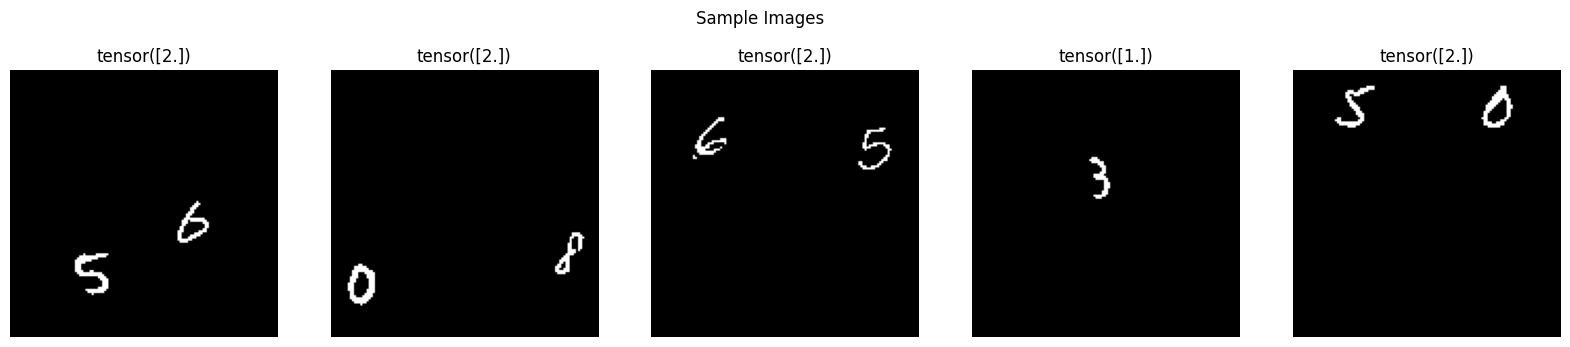

In [8]:
# sample images
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
random_indices = np.random.randint(0, len(train_images), 5)
for i in range(len(random_indices)):
    ax[i].imshow(train_images[random_indices[i]].permute(1, 2, 0), cmap="gray")
    ax[i].set_title(train_labels[random_indices[i]])
    ax[i].axis("off")
    
fig.suptitle("Sample Images")
plt.show()

In [9]:
# dataset class
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = MultiMNISTDataset(train_images, train_labels)
val_dataset = MultiMNISTDataset(val_images, val_labels)
test_dataset = MultiMNISTDataset(test_images, test_labels)

In [10]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [11]:
# overall function to get the dataloaders based on the task
def get_dataloaders(task):
    train_images, train_labels, val_images, val_labels, test_images, test_labels = (
        load_mnist_data(task=task)
    )
    train_dataset = MultiMNISTDataset(train_images, train_labels)
    val_dataset = MultiMNISTDataset(val_images, val_labels)
    test_dataset = MultiMNISTDataset(test_images, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)
    return train_loader, val_loader, test_loader

## 2.2 Sample Run of the implemented model

In [12]:
# sample usage of the CNN class for regression
train_loader, val_loader, test_loader = get_dataloaders("regression")
cnn_regression = CNN(task="regression", epochs=5, learning_rate=0.001, output_size=1)
cnn_regression.fit(train_loader, val_loader)

cnn_regression.evaluate(train_loader, type='Train')
cnn_regression.evaluate(val_loader, type='Validation')
cnn_regression.evaluate(test_loader, type='Test')

Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 111.24it/s]


Epoch 1/5, Loss: 0.12468689066466644
	Validation Loss: 0.0221 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 121.48it/s]


Epoch 2/5, Loss: 0.027421112276311152
	Validation Loss: 0.0139 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 122.32it/s]


Epoch 3/5, Loss: 0.0235173965374074
	Validation Loss: 0.0114 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 120.79it/s]


Epoch 4/5, Loss: 0.016446185269898873
	Validation Loss: 0.0100 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 121.06it/s]


Epoch 5/5, Loss: 0.016031853722285497
	Validation Loss: 0.0133 Validation Accuracy: 99.97% 
	Train Loss: 0.0124 Train Accuracy: 100.00% 
	Validation Loss: 0.0133 Validation Accuracy: 99.97% 
	Test Loss: 0.0114 Test Accuracy: 100.00% 


In [13]:
# sample usage of the CNN class for classification
train_loader, val_loader, test_loader = get_dataloaders("classification")
cnn_classification = CNN(task="classification", epochs=5, learning_rate=0.01, output_size=4)
cnn_classification.fit(train_loader, val_loader)

cnn_classification.evaluate(train_loader, type='Train')
cnn_classification.evaluate(val_loader, type='Validation')
cnn_classification.evaluate(test_loader, type='Test')

Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 120.21it/s]


Epoch 1/5, Loss: 0.274749023976708
	Validation Loss: 0.0006 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 120.83it/s]


Epoch 2/5, Loss: 0.005237106483325314
	Validation Loss: 0.0016 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 121.09it/s]


Epoch 3/5, Loss: 0.010581989576598625
	Validation Loss: 0.0010 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 120.71it/s]


Epoch 4/5, Loss: 0.005083728205047268
	Validation Loss: 0.0101 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 120.16it/s]


Epoch 5/5, Loss: 0.047984644463102244
	Validation Loss: 0.0089 Validation Accuracy: 99.87% 
	Train Loss: 0.0014 Train Accuracy: 99.98% 
	Validation Loss: 0.0080 Validation Accuracy: 99.87% 
	Test Loss: 0.0024 Test Accuracy: 99.91% 


## 2.3 Hyperparameter tuning

### Regression Task

In [14]:
# hyperparameter sweep for regression task using CNN
sweep_config = {
        "method": "grid",
        "metric": {"name": "accuracy", "goal": "maximize"},
        "parameters": {
            "learning_rate": {"values": [0.01, 0.001]},
            "dropout_rate": {"values": [0.1, 0.5, 0.9]},
            "num_layers": {"values": [1, 3, 5]},
            "activation_function": {"values": ["relu", "sigmoid", "tanh"]},
            "optimizer": {"values": ["adam", "sgd"]},
            "epochs": {"values": [10, 20]},
        },
    }

# sweep
train_loader, val_loader, test_loader = get_dataloaders("regression")
activations = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}
optimizers = {'adam': optim.Adam, 'sgd': optim.SGD}
run_id = 0

def train():
    global run_id
    wandb.init(project="cnn-regression", name=f"run-{run_id}")
    run_id += 1
    config = wandb.config
    model = CNN(
        learning_rate=config.learning_rate,
        dropout_rate=config.dropout_rate,
        kernel_sizes=[3]*config.num_layers,
        channel_sizes=[16,32,64,128, 32][:config.num_layers],
        activation_functions=[activations[config.activation_function]]*config.num_layers,
        optimizer=optimizers[config.optimizer],
        epochs=config.epochs,
        task="regression",
        log_wandb=True
    )
    model.fit(train_loader, val_loader)
    loss, accuracy, _ = model.evaluate(test_loader, type="Test", return_output=True)
    wandb.log(
        {
            "loss": loss,
            "accuracy": accuracy
        }
    )

    wandb.finish()

sweep_id = wandb.sweep(sweep_config, project="cnn-regression")
wandb.agent(sweep_id, train)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: osevqqso
Sweep URL: https://wandb.ai/gauravbehera-iiith/cnn-regression/sweeps/osevqqso


wandb: Agent Starting Run: pefkx0qt with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: Currently logged in as: gauravbehera (gauravbehera-iiith). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 339.42it/s]


Epoch 1/10, Loss: 39.495576349082334
	Validation Loss: 0.1083 Validation Accuracy: 90.30% 


100%|██████████| 197/197 [00:00<00:00, 357.27it/s]


Epoch 2/10, Loss: 0.11472425969118999
	Validation Loss: 0.0755 Validation Accuracy: 93.67% 


100%|██████████| 197/197 [00:00<00:00, 346.28it/s]


Epoch 3/10, Loss: 0.07878951811548417
	Validation Loss: 0.0614 Validation Accuracy: 95.57% 


100%|██████████| 197/197 [00:00<00:00, 351.65it/s]


Epoch 4/10, Loss: 3.8307987673936155
	Validation Loss: 2.4127 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.62it/s]


Epoch 5/10, Loss: 1.473738226188621
	Validation Loss: 0.9767 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.86it/s]


Epoch 6/10, Loss: 0.7678359270398387
	Validation Loss: 0.6461 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.23it/s]


Epoch 7/10, Loss: 0.6324112487928516
	Validation Loss: 0.5839 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.84it/s]


Epoch 8/10, Loss: 0.6129696163429221
	Validation Loss: 0.5718 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 337.47it/s]


Epoch 9/10, Loss: 0.6107845834366561
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.83it/s]


Epoch 10/10, Loss: 0.6107235635597694
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: qg1xcfhe with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 371.50it/s]


Epoch 1/10, Loss: 0.7535297749989529
	Validation Loss: 0.0962 Validation Accuracy: 87.67% 


100%|██████████| 197/197 [00:00<00:00, 374.74it/s]


Epoch 2/10, Loss: 0.11398804486554286
	Validation Loss: 0.0905 Validation Accuracy: 87.87% 


100%|██████████| 197/197 [00:00<00:00, 373.44it/s]


Epoch 3/10, Loss: 0.10728820018129906
	Validation Loss: 0.0885 Validation Accuracy: 88.07% 


100%|██████████| 197/197 [00:00<00:00, 378.99it/s]


Epoch 4/10, Loss: 0.10183171371971896
	Validation Loss: 0.0877 Validation Accuracy: 91.37% 


100%|██████████| 197/197 [00:00<00:00, 382.73it/s]


Epoch 5/10, Loss: 0.09592171126815874
	Validation Loss: 0.0851 Validation Accuracy: 91.83% 


100%|██████████| 197/197 [00:00<00:00, 377.13it/s]


Epoch 6/10, Loss: 0.08974116059199808
	Validation Loss: 0.0816 Validation Accuracy: 92.57% 


100%|██████████| 197/197 [00:00<00:00, 382.85it/s]


Epoch 7/10, Loss: 0.0833394927951285
	Validation Loss: 0.0777 Validation Accuracy: 92.90% 


100%|██████████| 197/197 [00:00<00:00, 375.98it/s]


Epoch 8/10, Loss: 0.07704174758743514
	Validation Loss: 0.0751 Validation Accuracy: 93.30% 


100%|██████████| 197/197 [00:00<00:00, 380.59it/s]


Epoch 9/10, Loss: 0.07124694898195073
	Validation Loss: 0.0735 Validation Accuracy: 93.67% 


100%|██████████| 197/197 [00:00<00:00, 382.21it/s]


Epoch 10/10, Loss: 0.06524717730238352
	Validation Loss: 0.0686 Validation Accuracy: 94.63% 


wandb: Agent Starting Run: rx3q8egk with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.68it/s]


Epoch 1/10, Loss: 1.1293160924451606
	Validation Loss: 0.5741 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.54it/s]


Epoch 2/10, Loss: 0.6230022335415564
	Validation Loss: 0.5655 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.83it/s]


Epoch 3/10, Loss: 0.6229285251368121
	Validation Loss: 0.5723 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.31it/s]


Epoch 4/10, Loss: 0.6335189896186596
	Validation Loss: 0.5713 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.29it/s]


Epoch 5/10, Loss: 0.30462362993565306
	Validation Loss: 0.0427 Validation Accuracy: 98.10% 


100%|██████████| 197/197 [00:00<00:00, 209.26it/s]


Epoch 6/10, Loss: 0.03685923968323596
	Validation Loss: 0.0222 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 205.79it/s]


Epoch 7/10, Loss: 0.02534404446177071
	Validation Loss: 0.0167 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.30it/s]


Epoch 8/10, Loss: 0.01991849868241603
	Validation Loss: 0.0202 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 209.51it/s]


Epoch 9/10, Loss: 0.020182483498631092
	Validation Loss: 0.0524 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 210.46it/s]


Epoch 10/10, Loss: 0.02073974142484556
	Validation Loss: 0.0130 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: f17px9ja with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.70it/s]


Epoch 1/10, Loss: 0.3721252227495164
	Validation Loss: 0.0770 Validation Accuracy: 90.97% 


100%|██████████| 197/197 [00:00<00:00, 217.40it/s]


Epoch 2/10, Loss: 0.0825887401280972
	Validation Loss: 0.0593 Validation Accuracy: 96.00% 


100%|██████████| 197/197 [00:00<00:00, 217.19it/s]


Epoch 3/10, Loss: 0.06775675696996868
	Validation Loss: 0.0545 Validation Accuracy: 96.63% 


100%|██████████| 197/197 [00:00<00:00, 217.68it/s]


Epoch 4/10, Loss: 0.058117460951133425
	Validation Loss: 0.0473 Validation Accuracy: 97.57% 


100%|██████████| 197/197 [00:00<00:00, 217.85it/s]


Epoch 5/10, Loss: 0.04964818542605729
	Validation Loss: 0.0458 Validation Accuracy: 97.83% 


100%|██████████| 197/197 [00:00<00:00, 217.55it/s]


Epoch 6/10, Loss: 0.041900514204263085
	Validation Loss: 0.0352 Validation Accuracy: 98.90% 


100%|██████████| 197/197 [00:00<00:00, 217.29it/s]


Epoch 7/10, Loss: 0.03526068452348564
	Validation Loss: 0.0311 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 217.60it/s]


Epoch 8/10, Loss: 0.030298082980558957
	Validation Loss: 0.0295 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 217.25it/s]


Epoch 9/10, Loss: 0.026436515767032726
	Validation Loss: 0.0249 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 215.85it/s]


Epoch 10/10, Loss: 0.022630225446283212
	Validation Loss: 0.0247 Validation Accuracy: 99.73% 


wandb: Agent Starting Run: dak58au2 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.93it/s]


Epoch 1/10, Loss: 2.697225482028148
	Validation Loss: 0.6479 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.06it/s]


Epoch 2/10, Loss: 0.615429240434908
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.95it/s]


Epoch 3/10, Loss: 0.610705382327743
	Validation Loss: 0.5705 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.25it/s]


Epoch 4/10, Loss: 0.6108655263929803
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.75it/s]


Epoch 5/10, Loss: 0.6109468147234263
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.50it/s]


Epoch 6/10, Loss: 0.6110012203001128
	Validation Loss: 0.5714 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.23it/s]


Epoch 7/10, Loss: 0.6111573005085669
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.99it/s]


Epoch 8/10, Loss: 0.6109656396553601
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.56it/s]


Epoch 9/10, Loss: 0.6111356529790133
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.29it/s]


Epoch 10/10, Loss: 0.6113092958322032
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 81guutq1 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.91it/s]


Epoch 1/10, Loss: 0.7537590629860834
	Validation Loss: 0.2895 Validation Accuracy: 66.03% 


100%|██████████| 197/197 [00:00<00:00, 198.20it/s]


Epoch 2/10, Loss: 0.23397157027334126
	Validation Loss: 0.0949 Validation Accuracy: 88.90% 


100%|██████████| 197/197 [00:00<00:00, 198.01it/s]


Epoch 3/10, Loss: 0.12615512534597803
	Validation Loss: 0.0664 Validation Accuracy: 95.37% 


100%|██████████| 197/197 [00:00<00:00, 198.26it/s]


Epoch 4/10, Loss: 0.10149852636501874
	Validation Loss: 0.0574 Validation Accuracy: 96.10% 


100%|██████████| 197/197 [00:00<00:00, 198.30it/s]


Epoch 5/10, Loss: 0.0915632250194017
	Validation Loss: 0.0685 Validation Accuracy: 93.20% 


100%|██████████| 197/197 [00:00<00:00, 197.89it/s]


Epoch 6/10, Loss: 0.07945038022728741
	Validation Loss: 0.0426 Validation Accuracy: 98.10% 


100%|██████████| 197/197 [00:00<00:00, 198.05it/s]


Epoch 7/10, Loss: 0.06919844923210024
	Validation Loss: 0.0346 Validation Accuracy: 98.97% 


100%|██████████| 197/197 [00:00<00:00, 198.22it/s]


Epoch 8/10, Loss: 0.06170070188375294
	Validation Loss: 0.0318 Validation Accuracy: 99.17% 


100%|██████████| 197/197 [00:00<00:00, 198.18it/s]


Epoch 9/10, Loss: 0.057410796678762144
	Validation Loss: 0.0285 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 198.10it/s]


Epoch 10/10, Loss: 0.055419097999630844
	Validation Loss: 0.0288 Validation Accuracy: 99.23% 


wandb: Agent Starting Run: 6mmco0xg with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 355.05it/s]


Epoch 1/10, Loss: 0.37097770179891343
	Validation Loss: 0.0999 Validation Accuracy: 88.93% 


100%|██████████| 197/197 [00:00<00:00, 351.64it/s]


Epoch 2/10, Loss: 0.08308160872326284
	Validation Loss: 0.0645 Validation Accuracy: 94.97% 


100%|██████████| 197/197 [00:00<00:00, 357.29it/s]


Epoch 3/10, Loss: 0.05985613394207156
	Validation Loss: 0.0606 Validation Accuracy: 95.13% 


100%|██████████| 197/197 [00:00<00:00, 355.80it/s]


Epoch 4/10, Loss: 0.04867499689500646
	Validation Loss: 0.0507 Validation Accuracy: 96.73% 


100%|██████████| 197/197 [00:00<00:00, 353.99it/s]


Epoch 5/10, Loss: 0.04219181378026904
	Validation Loss: 0.0541 Validation Accuracy: 96.43% 


100%|██████████| 197/197 [00:00<00:00, 349.87it/s]


Epoch 6/10, Loss: 0.038129511653318016
	Validation Loss: 0.0537 Validation Accuracy: 97.00% 


100%|██████████| 197/197 [00:00<00:00, 346.14it/s]


Epoch 7/10, Loss: 0.03806361857669305
	Validation Loss: 0.0555 Validation Accuracy: 96.23% 


100%|██████████| 197/197 [00:00<00:00, 353.87it/s]


Epoch 8/10, Loss: 0.035177317537783366
	Validation Loss: 0.0604 Validation Accuracy: 95.57% 


100%|██████████| 197/197 [00:00<00:00, 353.73it/s]


Epoch 9/10, Loss: 0.03271564201163459
	Validation Loss: 0.0580 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 349.80it/s]


Epoch 10/10, Loss: 0.029926656267894102
	Validation Loss: 0.0576 Validation Accuracy: 95.80% 


wandb: Agent Starting Run: sdketopd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 381.39it/s]


Epoch 1/10, Loss: 0.5559765852344822
	Validation Loss: 0.4171 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.12it/s]


Epoch 2/10, Loss: 0.39725199341773987
	Validation Loss: 0.3009 Validation Accuracy: 57.37% 


100%|██████████| 197/197 [00:00<00:00, 385.61it/s]


Epoch 3/10, Loss: 0.3029498272589621
	Validation Loss: 0.2211 Validation Accuracy: 76.27% 


100%|██████████| 197/197 [00:00<00:00, 385.75it/s]


Epoch 4/10, Loss: 0.23990870891186186
	Validation Loss: 0.1731 Validation Accuracy: 80.97% 


100%|██████████| 197/197 [00:00<00:00, 386.17it/s]


Epoch 5/10, Loss: 0.1970730647444725
	Validation Loss: 0.1412 Validation Accuracy: 85.73% 


100%|██████████| 197/197 [00:00<00:00, 385.90it/s]


Epoch 6/10, Loss: 0.16539232319381636
	Validation Loss: 0.1175 Validation Accuracy: 88.47% 


100%|██████████| 197/197 [00:00<00:00, 380.56it/s]


Epoch 7/10, Loss: 0.14323426745264664
	Validation Loss: 0.0998 Validation Accuracy: 90.87% 


100%|██████████| 197/197 [00:00<00:00, 386.29it/s]


Epoch 8/10, Loss: 0.12763248671432437
	Validation Loss: 0.0922 Validation Accuracy: 89.33% 


100%|██████████| 197/197 [00:00<00:00, 371.82it/s]


Epoch 9/10, Loss: 0.11771981803898884
	Validation Loss: 0.1144 Validation Accuracy: 84.27% 


100%|██████████| 197/197 [00:00<00:00, 385.98it/s]


Epoch 10/10, Loss: 0.11323625949887454
	Validation Loss: 0.0853 Validation Accuracy: 89.30% 


wandb: Agent Starting Run: uyzh1oqj with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.60it/s]


Epoch 1/10, Loss: 0.18525515843731194
	Validation Loss: 0.0235 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 212.06it/s]


Epoch 2/10, Loss: 0.02182056220144336
	Validation Loss: 0.0155 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.95it/s]


Epoch 3/10, Loss: 0.01621572031795525
	Validation Loss: 0.0120 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.38it/s]


Epoch 4/10, Loss: 0.012835036523564516
	Validation Loss: 0.0093 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.24it/s]


Epoch 5/10, Loss: 0.010163477967081941
	Validation Loss: 0.0079 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.74it/s]


Epoch 6/10, Loss: 0.00903412007116878
	Validation Loss: 0.0099 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.48it/s]


Epoch 7/10, Loss: 0.009391919284264751
	Validation Loss: 0.0071 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.82it/s]


Epoch 8/10, Loss: 0.008482660852410466
	Validation Loss: 0.0062 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.99it/s]


Epoch 9/10, Loss: 0.007299157457549106
	Validation Loss: 0.0059 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.91it/s]


Epoch 10/10, Loss: 0.007160595437360521
	Validation Loss: 0.0059 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: vvssb72v with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.39it/s]


Epoch 1/10, Loss: 1.0387616487323936
	Validation Loss: 0.4397 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.89it/s]


Epoch 2/10, Loss: 0.44634389710910427
	Validation Loss: 0.3473 Validation Accuracy: 53.37% 


100%|██████████| 197/197 [00:00<00:00, 211.40it/s]


Epoch 3/10, Loss: 0.3344811355402022
	Validation Loss: 0.2253 Validation Accuracy: 65.50% 


100%|██████████| 197/197 [00:00<00:00, 213.58it/s]


Epoch 4/10, Loss: 0.21728610568845333
	Validation Loss: 0.1353 Validation Accuracy: 87.73% 


100%|██████████| 197/197 [00:00<00:00, 217.70it/s]


Epoch 5/10, Loss: 0.15008917258021795
	Validation Loss: 0.0991 Validation Accuracy: 90.07% 


100%|██████████| 197/197 [00:00<00:00, 214.98it/s]


Epoch 6/10, Loss: 0.1180840922037357
	Validation Loss: 0.0818 Validation Accuracy: 90.93% 


100%|██████████| 197/197 [00:00<00:00, 214.75it/s]


Epoch 7/10, Loss: 0.10135738275529164
	Validation Loss: 0.0747 Validation Accuracy: 90.97% 


100%|██████████| 197/197 [00:00<00:00, 216.24it/s]


Epoch 8/10, Loss: 0.09312078341614777
	Validation Loss: 0.0732 Validation Accuracy: 93.73% 


100%|██████████| 197/197 [00:00<00:00, 216.66it/s]


Epoch 9/10, Loss: 0.08864746269235756
	Validation Loss: 0.0709 Validation Accuracy: 94.17% 


100%|██████████| 197/197 [00:00<00:00, 216.60it/s]


Epoch 10/10, Loss: 0.08593504361543558
	Validation Loss: 0.0691 Validation Accuracy: 94.33% 


wandb: Agent Starting Run: tsxm7csb with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.16it/s]


Epoch 1/10, Loss: 0.47827256641109583
	Validation Loss: 0.0670 Validation Accuracy: 94.13% 


100%|██████████| 197/197 [00:01<00:00, 192.71it/s]


Epoch 2/10, Loss: 0.07847837602653479
	Validation Loss: 0.0272 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:01<00:00, 192.42it/s]


Epoch 3/10, Loss: 0.04972111625681976
	Validation Loss: 0.0285 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:01<00:00, 191.95it/s]


Epoch 4/10, Loss: 0.03924611428289244
	Validation Loss: 0.0207 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:01<00:00, 191.79it/s]


Epoch 5/10, Loss: 0.03245857244518203
	Validation Loss: 0.0136 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.36it/s]


Epoch 6/10, Loss: 0.027538213732316713
	Validation Loss: 0.0127 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.72it/s]


Epoch 7/10, Loss: 0.02461707578773426
	Validation Loss: 0.0157 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.48it/s]


Epoch 8/10, Loss: 0.02208946711445218
	Validation Loss: 0.0103 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.30it/s]


Epoch 9/10, Loss: 0.02188819849646182
	Validation Loss: 0.0215 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 191.34it/s]


Epoch 10/10, Loss: 0.01768167046971884
	Validation Loss: 0.0077 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: ttftxrg3 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.98it/s]


Epoch 1/10, Loss: 3.0649433517214004
	Validation Loss: 2.2180 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.93it/s]


Epoch 2/10, Loss: 1.585534255214149
	Validation Loss: 1.2167 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.63it/s]


Epoch 3/10, Loss: 0.9463139660467351
	Validation Loss: 0.7845 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.25it/s]


Epoch 4/10, Loss: 0.7001956011438127
	Validation Loss: 0.6266 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.05it/s]


Epoch 5/10, Loss: 0.6258409307692862
	Validation Loss: 0.5803 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.20it/s]


Epoch 6/10, Loss: 0.6081580885775804
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.79it/s]


Epoch 7/10, Loss: 0.6046753619528059
	Validation Loss: 0.5617 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.31it/s]


Epoch 8/10, Loss: 0.6027767983487415
	Validation Loss: 0.5596 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.07it/s]


Epoch 9/10, Loss: 0.601778014813583
	Validation Loss: 0.5582 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.03it/s]


Epoch 10/10, Loss: 0.6008246279307429
	Validation Loss: 0.5562 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: f3vu2q3m with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 351.46it/s]


Epoch 1/20, Loss: 103.8461675777048
	Validation Loss: 3.8390 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.29it/s]


Epoch 2/20, Loss: 3.0560725316178377
	Validation Loss: 2.5645 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 356.13it/s]


Epoch 3/20, Loss: 1.960951576983263
	Validation Loss: 1.5997 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 355.47it/s]


Epoch 4/20, Loss: 1.2385577281114413
	Validation Loss: 1.0290 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 351.51it/s]


Epoch 5/20, Loss: 0.8574756299178612
	Validation Loss: 0.7498 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.57it/s]


Epoch 6/20, Loss: 0.692653974905837
	Validation Loss: 0.6332 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.39it/s]


Epoch 7/20, Loss: 0.6332571916471278
	Validation Loss: 0.5905 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.43it/s]


Epoch 8/20, Loss: 0.6157946199329977
	Validation Loss: 0.5757 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.40it/s]


Epoch 9/20, Loss: 0.611715557762814
	Validation Loss: 0.5714 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.02it/s]


Epoch 10/20, Loss: 0.6107184138092293
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.09it/s]


Epoch 11/20, Loss: 0.6105503046573116
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.52it/s]


Epoch 12/20, Loss: 0.6106546070369973
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.67it/s]


Epoch 13/20, Loss: 0.6106065032143279
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.19it/s]


Epoch 14/20, Loss: 0.6104802555844263
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.00it/s]


Epoch 15/20, Loss: 0.610657596648647
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.08it/s]


Epoch 16/20, Loss: 0.6105558232305014
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.42it/s]


Epoch 17/20, Loss: 0.6106531045158502
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.46it/s]


Epoch 18/20, Loss: 0.6105992984650704
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.09it/s]


Epoch 19/20, Loss: 0.610584551005194
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.27it/s]


Epoch 20/20, Loss: 0.6106165919812198
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: e4b61tzg with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 384.12it/s]


Epoch 1/20, Loss: 0.5500522488869991
	Validation Loss: 0.0854 Validation Accuracy: 89.50% 


100%|██████████| 197/197 [00:00<00:00, 385.94it/s]


Epoch 2/20, Loss: 0.10520361466002344
	Validation Loss: 0.0811 Validation Accuracy: 89.37% 


100%|██████████| 197/197 [00:00<00:00, 385.63it/s]


Epoch 3/20, Loss: 0.096110460570621
	Validation Loss: 0.0774 Validation Accuracy: 89.83% 


100%|██████████| 197/197 [00:00<00:00, 385.63it/s]


Epoch 4/20, Loss: 0.08863622190307845
	Validation Loss: 0.0762 Validation Accuracy: 93.10% 


100%|██████████| 197/197 [00:00<00:00, 384.95it/s]


Epoch 5/20, Loss: 0.08181005920552965
	Validation Loss: 0.0763 Validation Accuracy: 93.53% 


100%|██████████| 197/197 [00:00<00:00, 385.90it/s]


Epoch 6/20, Loss: 0.0761895166511463
	Validation Loss: 0.0725 Validation Accuracy: 94.10% 


100%|██████████| 197/197 [00:00<00:00, 385.56it/s]


Epoch 7/20, Loss: 0.06942802378293221
	Validation Loss: 0.0695 Validation Accuracy: 94.23% 


100%|██████████| 197/197 [00:00<00:00, 386.13it/s]


Epoch 8/20, Loss: 0.06365463939415017
	Validation Loss: 0.0650 Validation Accuracy: 95.00% 


100%|██████████| 197/197 [00:00<00:00, 385.07it/s]


Epoch 9/20, Loss: 0.0585827203042011
	Validation Loss: 0.0635 Validation Accuracy: 95.23% 


100%|██████████| 197/197 [00:00<00:00, 384.94it/s]


Epoch 10/20, Loss: 0.05364334679723996
	Validation Loss: 0.0609 Validation Accuracy: 95.23% 


100%|██████████| 197/197 [00:00<00:00, 378.11it/s]


Epoch 11/20, Loss: 0.049164597985103045
	Validation Loss: 0.0583 Validation Accuracy: 95.87% 


100%|██████████| 197/197 [00:00<00:00, 376.63it/s]


Epoch 12/20, Loss: 0.0455161212059447
	Validation Loss: 0.0557 Validation Accuracy: 96.37% 


100%|██████████| 197/197 [00:00<00:00, 383.15it/s]


Epoch 13/20, Loss: 0.04218224280036343
	Validation Loss: 0.0544 Validation Accuracy: 96.33% 


100%|██████████| 197/197 [00:00<00:00, 385.82it/s]


Epoch 14/20, Loss: 0.03933643634776174
	Validation Loss: 0.0541 Validation Accuracy: 96.20% 


100%|██████████| 197/197 [00:00<00:00, 385.32it/s]


Epoch 15/20, Loss: 0.036498170998420204
	Validation Loss: 0.0521 Validation Accuracy: 96.83% 


100%|██████████| 197/197 [00:00<00:00, 376.64it/s]


Epoch 16/20, Loss: 0.03464037480617538
	Validation Loss: 0.0527 Validation Accuracy: 96.63% 


100%|██████████| 197/197 [00:00<00:00, 385.54it/s]


Epoch 17/20, Loss: 0.032782730915900414
	Validation Loss: 0.0511 Validation Accuracy: 96.90% 


100%|██████████| 197/197 [00:00<00:00, 379.22it/s]


Epoch 18/20, Loss: 0.031171680650281423
	Validation Loss: 0.0495 Validation Accuracy: 97.40% 


100%|██████████| 197/197 [00:00<00:00, 383.99it/s]


Epoch 19/20, Loss: 0.029766002509194582
	Validation Loss: 0.0507 Validation Accuracy: 96.90% 


100%|██████████| 197/197 [00:00<00:00, 386.28it/s]


Epoch 20/20, Loss: 0.02926447236825367
	Validation Loss: 0.0491 Validation Accuracy: 97.40% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ea91bfu with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.89it/s]


Epoch 1/20, Loss: 1.7495416973807334
	Validation Loss: 0.0296 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 207.40it/s]


Epoch 2/20, Loss: 0.03151351256002932
	Validation Loss: 0.0372 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 212.00it/s]


Epoch 3/20, Loss: 0.02703796037316776
	Validation Loss: 0.0190 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 211.82it/s]


Epoch 4/20, Loss: 0.02463896963083502
	Validation Loss: 0.0164 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 211.19it/s]


Epoch 5/20, Loss: 0.027933146435824143
	Validation Loss: 0.0171 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.04it/s]


Epoch 6/20, Loss: 0.02468415986992381
	Validation Loss: 0.0174 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 211.01it/s]


Epoch 7/20, Loss: 0.02192829779543096
	Validation Loss: 0.0136 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 210.99it/s]


Epoch 8/20, Loss: 0.02012044136521175
	Validation Loss: 0.0190 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 210.86it/s]


Epoch 9/20, Loss: 0.018313478158437056
	Validation Loss: 0.0121 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.21it/s]


Epoch 10/20, Loss: 0.020262410760228403
	Validation Loss: 0.0136 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.06it/s]


Epoch 11/20, Loss: 0.018132829140436832
	Validation Loss: 0.0125 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.76it/s]


Epoch 12/20, Loss: 0.021158743583535786
	Validation Loss: 0.0107 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.90it/s]


Epoch 13/20, Loss: 0.021004978529541626
	Validation Loss: 0.0362 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 211.07it/s]


Epoch 14/20, Loss: 0.021150642641947656
	Validation Loss: 0.0263 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 211.27it/s]


Epoch 15/20, Loss: 0.017982641915757644
	Validation Loss: 0.0111 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.86it/s]


Epoch 16/20, Loss: 0.0171748352742891
	Validation Loss: 0.0102 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.70it/s]


Epoch 17/20, Loss: 0.015945479784368864
	Validation Loss: 0.0090 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.53it/s]


Epoch 18/20, Loss: 0.015214869327048965
	Validation Loss: 0.0086 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.74it/s]


Epoch 19/20, Loss: 0.01804642790578646
	Validation Loss: 0.0096 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.48it/s]


Epoch 20/20, Loss: 0.01580819141516831
	Validation Loss: 0.0238 Validation Accuracy: 99.83% 


wandb: Agent Starting Run: 6wfzr22m with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.51it/s]


Epoch 1/20, Loss: 0.36244267490006943
	Validation Loss: 0.0777 Validation Accuracy: 90.30% 


100%|██████████| 197/197 [00:00<00:00, 215.21it/s]


Epoch 2/20, Loss: 0.08725144328350948
	Validation Loss: 0.0624 Validation Accuracy: 95.53% 


100%|██████████| 197/197 [00:00<00:00, 217.40it/s]


Epoch 3/20, Loss: 0.07312023070484854
	Validation Loss: 0.0591 Validation Accuracy: 95.87% 


100%|██████████| 197/197 [00:00<00:00, 212.96it/s]


Epoch 4/20, Loss: 0.06190830911627881
	Validation Loss: 0.0496 Validation Accuracy: 97.30% 


100%|██████████| 197/197 [00:00<00:00, 212.94it/s]


Epoch 5/20, Loss: 0.05315697785031977
	Validation Loss: 0.0440 Validation Accuracy: 97.97% 


100%|██████████| 197/197 [00:00<00:00, 217.22it/s]


Epoch 6/20, Loss: 0.04476761549408666
	Validation Loss: 0.0373 Validation Accuracy: 98.67% 


100%|██████████| 197/197 [00:00<00:00, 216.90it/s]


Epoch 7/20, Loss: 0.037730431269268096
	Validation Loss: 0.0318 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:00<00:00, 216.38it/s]


Epoch 8/20, Loss: 0.03258864460560271
	Validation Loss: 0.0343 Validation Accuracy: 99.23% 


100%|██████████| 197/197 [00:00<00:00, 212.98it/s]


Epoch 9/20, Loss: 0.028879478190869546
	Validation Loss: 0.0250 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 216.43it/s]


Epoch 10/20, Loss: 0.024837432523744967
	Validation Loss: 0.0234 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 212.98it/s]


Epoch 11/20, Loss: 0.02230506187049568
	Validation Loss: 0.0209 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 213.95it/s]


Epoch 12/20, Loss: 0.02070284472674434
	Validation Loss: 0.0194 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 212.96it/s]


Epoch 13/20, Loss: 0.01934332801927316
	Validation Loss: 0.0180 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 217.72it/s]


Epoch 14/20, Loss: 0.017705074809302532
	Validation Loss: 0.0168 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.11it/s]


Epoch 15/20, Loss: 0.01681921835799659
	Validation Loss: 0.0164 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 217.57it/s]


Epoch 16/20, Loss: 0.017590795998192077
	Validation Loss: 0.0154 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 213.26it/s]


Epoch 17/20, Loss: 0.015271532131822278
	Validation Loss: 0.0194 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.08it/s]


Epoch 18/20, Loss: 0.014417254432165986
	Validation Loss: 0.0143 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 216.16it/s]


Epoch 19/20, Loss: 0.013497508022234525
	Validation Loss: 0.0132 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 214.34it/s]


Epoch 20/20, Loss: 0.013549444043469912
	Validation Loss: 0.0127 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: nrgnsocj with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.84it/s]


Epoch 1/20, Loss: 1.01688272577857
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.37it/s]


Epoch 2/20, Loss: 0.6283101669422866
	Validation Loss: 0.5768 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.29it/s]


Epoch 3/20, Loss: 0.6182676428163112
	Validation Loss: 0.5747 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.87it/s]


Epoch 4/20, Loss: 0.61525310931472
	Validation Loss: 0.5757 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.06it/s]


Epoch 5/20, Loss: 0.6164950115729104
	Validation Loss: 0.5745 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.03it/s]


Epoch 6/20, Loss: 0.6132069401026983
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.41it/s]


Epoch 7/20, Loss: 0.6121090585507717
	Validation Loss: 0.5737 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.33it/s]


Epoch 8/20, Loss: 0.6134708609980375
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.42it/s]


Epoch 9/20, Loss: 0.6133840109793668
	Validation Loss: 0.5737 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.34it/s]


Epoch 10/20, Loss: 0.6124040870194508
	Validation Loss: 0.5742 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.28it/s]


Epoch 11/20, Loss: 0.614179924357361
	Validation Loss: 0.5721 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.51it/s]


Epoch 12/20, Loss: 0.6175079696674637
	Validation Loss: 0.6009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.19it/s]


Epoch 13/20, Loss: 0.6142269239812939
	Validation Loss: 0.5774 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.61it/s]


Epoch 14/20, Loss: 0.6138112977676585
	Validation Loss: 0.5828 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.87it/s]


Epoch 15/20, Loss: 0.6135729701083323
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.08it/s]


Epoch 16/20, Loss: 0.6138994164273218
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.63it/s]


Epoch 17/20, Loss: 0.613076099586971
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.19it/s]


Epoch 18/20, Loss: 0.6122552701059332
	Validation Loss: 0.5656 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.65it/s]


Epoch 19/20, Loss: 0.6127580859636897
	Validation Loss: 0.5803 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.61it/s]


Epoch 20/20, Loss: 0.6140587201275801
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: lee1mqbi with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.37it/s]


Epoch 1/20, Loss: 0.965321292429406
	Validation Loss: 0.5497 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.49it/s]


Epoch 2/20, Loss: 0.5537775328316664
	Validation Loss: 0.4068 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.81it/s]


Epoch 3/20, Loss: 0.3526769716878833
	Validation Loss: 0.2130 Validation Accuracy: 71.60% 


100%|██████████| 197/197 [00:00<00:00, 197.31it/s]


Epoch 4/20, Loss: 0.19991736027038642
	Validation Loss: 0.0992 Validation Accuracy: 88.13% 


100%|██████████| 197/197 [00:01<00:00, 196.73it/s]


Epoch 5/20, Loss: 0.12665893814436674
	Validation Loss: 0.0703 Validation Accuracy: 91.30% 


100%|██████████| 197/197 [00:01<00:00, 195.62it/s]


Epoch 6/20, Loss: 0.10026983699293306
	Validation Loss: 0.0923 Validation Accuracy: 89.83% 


100%|██████████| 197/197 [00:00<00:00, 197.30it/s]


Epoch 7/20, Loss: 0.08420964298287624
	Validation Loss: 0.0444 Validation Accuracy: 98.63% 


100%|██████████| 197/197 [00:01<00:00, 195.96it/s]


Epoch 8/20, Loss: 0.07385207952808608
	Validation Loss: 0.0377 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 197.32it/s]


Epoch 9/20, Loss: 0.0662056610442055
	Validation Loss: 0.0336 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:01<00:00, 192.96it/s]


Epoch 10/20, Loss: 0.05839846557393897
	Validation Loss: 0.0378 Validation Accuracy: 98.47% 


100%|██████████| 197/197 [00:01<00:00, 193.19it/s]


Epoch 11/20, Loss: 0.055255341858881986
	Validation Loss: 0.0270 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:01<00:00, 193.89it/s]


Epoch 12/20, Loss: 0.05028582529784156
	Validation Loss: 0.0291 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:01<00:00, 196.60it/s]


Epoch 13/20, Loss: 0.04747242356655259
	Validation Loss: 0.0226 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:01<00:00, 193.65it/s]


Epoch 14/20, Loss: 0.04372575953791892
	Validation Loss: 0.0208 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 15/20, Loss: 0.04307888915317918
	Validation Loss: 0.0211 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 16/20, Loss: 0.03971426423431048
	Validation Loss: 0.0183 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 17/20, Loss: 0.03726333164170309
	Validation Loss: 0.0190 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:01<00:00, 196.77it/s]


Epoch 18/20, Loss: 0.0361340814340992
	Validation Loss: 0.0192 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:01<00:00, 196.59it/s]


Epoch 19/20, Loss: 0.03509233425829919
	Validation Loss: 0.0196 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 194.65it/s]


Epoch 20/20, Loss: 0.03361156750186748
	Validation Loss: 0.0159 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: n7uwcl96 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 344.11it/s]


Epoch 1/20, Loss: 0.7807072178663941
	Validation Loss: 0.0953 Validation Accuracy: 90.10% 


100%|██████████| 197/197 [00:00<00:00, 353.64it/s]


Epoch 2/20, Loss: 0.11501327281827249
	Validation Loss: 0.0863 Validation Accuracy: 88.83% 


100%|██████████| 197/197 [00:00<00:00, 344.59it/s]


Epoch 3/20, Loss: 0.09972026781533576
	Validation Loss: 0.0764 Validation Accuracy: 93.70% 


100%|██████████| 197/197 [00:00<00:00, 344.52it/s]


Epoch 4/20, Loss: 0.07867286203022536
	Validation Loss: 0.0640 Validation Accuracy: 95.03% 


100%|██████████| 197/197 [00:00<00:00, 345.34it/s]


Epoch 5/20, Loss: 0.06046728322726821
	Validation Loss: 0.0534 Validation Accuracy: 96.33% 


100%|██████████| 197/197 [00:00<00:00, 346.68it/s]


Epoch 6/20, Loss: 0.048284847894447105
	Validation Loss: 0.0506 Validation Accuracy: 97.20% 


100%|██████████| 197/197 [00:00<00:00, 353.85it/s]


Epoch 7/20, Loss: 0.0430031300423109
	Validation Loss: 0.0523 Validation Accuracy: 96.73% 


100%|██████████| 197/197 [00:00<00:00, 353.88it/s]


Epoch 8/20, Loss: 0.038851315826934
	Validation Loss: 0.0546 Validation Accuracy: 96.70% 


100%|██████████| 197/197 [00:00<00:00, 348.96it/s]


Epoch 9/20, Loss: 0.03732240120620292
	Validation Loss: 0.0506 Validation Accuracy: 97.13% 


100%|██████████| 197/197 [00:00<00:00, 345.77it/s]


Epoch 10/20, Loss: 0.034266440160005227
	Validation Loss: 0.0511 Validation Accuracy: 97.07% 


100%|██████████| 197/197 [00:00<00:00, 344.57it/s]


Epoch 11/20, Loss: 0.03210053721509004
	Validation Loss: 0.0526 Validation Accuracy: 96.87% 


100%|██████████| 197/197 [00:00<00:00, 344.10it/s]


Epoch 12/20, Loss: 0.03156956579290368
	Validation Loss: 0.0500 Validation Accuracy: 96.80% 


100%|██████████| 197/197 [00:00<00:00, 350.60it/s]


Epoch 13/20, Loss: 0.029217628979592153
	Validation Loss: 0.0651 Validation Accuracy: 95.33% 


100%|██████████| 197/197 [00:00<00:00, 342.71it/s]


Epoch 14/20, Loss: 0.028018610183206307
	Validation Loss: 0.0514 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:00<00:00, 345.83it/s]


Epoch 15/20, Loss: 0.026994118145501553
	Validation Loss: 0.0537 Validation Accuracy: 96.23% 


100%|██████████| 197/197 [00:00<00:00, 345.56it/s]


Epoch 16/20, Loss: 0.0266370535520884
	Validation Loss: 0.0545 Validation Accuracy: 96.13% 


100%|██████████| 197/197 [00:00<00:00, 347.19it/s]


Epoch 17/20, Loss: 0.02464185607369025
	Validation Loss: 0.0529 Validation Accuracy: 96.17% 


100%|██████████| 197/197 [00:00<00:00, 345.21it/s]


Epoch 18/20, Loss: 0.023628497907542033
	Validation Loss: 0.0572 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 344.22it/s]


Epoch 19/20, Loss: 0.02463556565627985
	Validation Loss: 0.0562 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 344.54it/s]


Epoch 20/20, Loss: 0.02236726080176189
	Validation Loss: 0.0554 Validation Accuracy: 96.10% 


wandb: Agent Starting Run: 7vfppjg2 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 376.38it/s]


Epoch 1/20, Loss: 0.5270510745532622
	Validation Loss: 0.3754 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.71it/s]


Epoch 2/20, Loss: 0.3633289867397492
	Validation Loss: 0.2621 Validation Accuracy: 64.43% 


100%|██████████| 197/197 [00:00<00:00, 379.25it/s]


Epoch 3/20, Loss: 0.2750081350355584
	Validation Loss: 0.2144 Validation Accuracy: 70.50% 


100%|██████████| 197/197 [00:00<00:00, 375.84it/s]


Epoch 4/20, Loss: 0.22026398059377816
	Validation Loss: 0.1511 Validation Accuracy: 86.03% 


100%|██████████| 197/197 [00:00<00:00, 374.69it/s]


Epoch 5/20, Loss: 0.18219682623438424
	Validation Loss: 0.1249 Validation Accuracy: 88.07% 


100%|██████████| 197/197 [00:00<00:00, 377.39it/s]


Epoch 6/20, Loss: 0.15735982108842297
	Validation Loss: 0.1484 Validation Accuracy: 77.73% 


100%|██████████| 197/197 [00:00<00:00, 376.46it/s]


Epoch 7/20, Loss: 0.14387868359911865
	Validation Loss: 0.0974 Validation Accuracy: 90.10% 


100%|██████████| 197/197 [00:00<00:00, 378.99it/s]


Epoch 8/20, Loss: 0.1339840896541092
	Validation Loss: 0.1040 Validation Accuracy: 86.23% 


100%|██████████| 197/197 [00:00<00:00, 376.85it/s]


Epoch 9/20, Loss: 0.1346104812954888
	Validation Loss: 0.0896 Validation Accuracy: 89.20% 


100%|██████████| 197/197 [00:00<00:00, 373.07it/s]


Epoch 10/20, Loss: 0.12170486492553943
	Validation Loss: 0.0949 Validation Accuracy: 88.97% 


100%|██████████| 197/197 [00:00<00:00, 379.98it/s]


Epoch 11/20, Loss: 0.1261741579864836
	Validation Loss: 0.1322 Validation Accuracy: 84.20% 


100%|██████████| 197/197 [00:00<00:00, 381.46it/s]


Epoch 12/20, Loss: 0.1244883882969164
	Validation Loss: 0.0897 Validation Accuracy: 88.70% 


100%|██████████| 197/197 [00:00<00:00, 366.45it/s]


Epoch 13/20, Loss: 0.11950575707830148
	Validation Loss: 0.0895 Validation Accuracy: 88.57% 


100%|██████████| 197/197 [00:00<00:00, 369.22it/s]


Epoch 14/20, Loss: 0.11813136042677207
	Validation Loss: 0.0948 Validation Accuracy: 88.40% 


100%|██████████| 197/197 [00:00<00:00, 378.52it/s]


Epoch 15/20, Loss: 0.11222251213444066
	Validation Loss: 0.1114 Validation Accuracy: 87.97% 


100%|██████████| 197/197 [00:00<00:00, 377.92it/s]


Epoch 16/20, Loss: 0.11497253830057716
	Validation Loss: 0.1388 Validation Accuracy: 83.90% 


100%|██████████| 197/197 [00:00<00:00, 372.88it/s]


Epoch 17/20, Loss: 0.11319166223334177
	Validation Loss: 0.0910 Validation Accuracy: 88.53% 


100%|██████████| 197/197 [00:00<00:00, 381.83it/s]


Epoch 18/20, Loss: 0.11391663710175431
	Validation Loss: 0.0922 Validation Accuracy: 90.77% 


100%|██████████| 197/197 [00:00<00:00, 370.26it/s]


Epoch 19/20, Loss: 0.10875975715024823
	Validation Loss: 0.0984 Validation Accuracy: 90.07% 


100%|██████████| 197/197 [00:00<00:00, 380.55it/s]


Epoch 20/20, Loss: 0.10814570128766414
	Validation Loss: 0.0879 Validation Accuracy: 88.20% 


wandb: Agent Starting Run: 0hnhxln7 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 204.17it/s]


Epoch 1/20, Loss: 0.19416937544979723
	Validation Loss: 0.0218 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 211.96it/s]


Epoch 2/20, Loss: 0.0191359866438859
	Validation Loss: 0.0191 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 208.43it/s]


Epoch 3/20, Loss: 0.013780223148955306
	Validation Loss: 0.0175 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.48it/s]


Epoch 4/20, Loss: 0.011253472824160218
	Validation Loss: 0.0094 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.11it/s]


Epoch 5/20, Loss: 0.010689253275883076
	Validation Loss: 0.0114 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.98it/s]


Epoch 6/20, Loss: 0.009588627235699199
	Validation Loss: 0.0086 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.39it/s]


Epoch 7/20, Loss: 0.00888601575651901
	Validation Loss: 0.0065 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.90it/s]


Epoch 8/20, Loss: 0.007559134620170908
	Validation Loss: 0.0057 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.19it/s]


Epoch 9/20, Loss: 0.008030427801824615
	Validation Loss: 0.0062 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.88it/s]


Epoch 10/20, Loss: 0.006907080306061709
	Validation Loss: 0.0051 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.46it/s]


Epoch 11/20, Loss: 0.007336166097550904
	Validation Loss: 0.0085 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.84it/s]


Epoch 12/20, Loss: 0.008345561776886964
	Validation Loss: 0.0077 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.73it/s]


Epoch 13/20, Loss: 0.006002717125489551
	Validation Loss: 0.0049 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.09it/s]


Epoch 14/20, Loss: 0.007368347936116046
	Validation Loss: 0.0049 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.20it/s]


Epoch 15/20, Loss: 0.0060626272086129725
	Validation Loss: 0.0058 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.64it/s]


Epoch 16/20, Loss: 0.005863312416743052
	Validation Loss: 0.0046 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.02it/s]


Epoch 17/20, Loss: 0.00518949163325963
	Validation Loss: 0.0049 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.16it/s]


Epoch 18/20, Loss: 0.00541617706072928
	Validation Loss: 0.0060 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.17it/s]


Epoch 19/20, Loss: 0.010952390102801968
	Validation Loss: 0.0673 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 208.98it/s]


Epoch 20/20, Loss: 0.0108718595037303
	Validation Loss: 0.0055 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: 30hso6ci with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.68it/s]


Epoch 1/20, Loss: 0.9061496439318971
	Validation Loss: 0.4622 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.80it/s]


Epoch 2/20, Loss: 0.47414093059936757
	Validation Loss: 0.3919 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.18it/s]


Epoch 3/20, Loss: 0.3955165488919631
	Validation Loss: 0.2968 Validation Accuracy: 56.03% 


100%|██████████| 197/197 [00:00<00:00, 215.68it/s]


Epoch 4/20, Loss: 0.28915131356812973
	Validation Loss: 0.1963 Validation Accuracy: 76.43% 


100%|██████████| 197/197 [00:00<00:00, 214.31it/s]


Epoch 5/20, Loss: 0.19884213521547123
	Validation Loss: 0.1318 Validation Accuracy: 87.43% 


100%|██████████| 197/197 [00:00<00:00, 215.89it/s]


Epoch 6/20, Loss: 0.14800313247490654
	Validation Loss: 0.0981 Validation Accuracy: 91.17% 


100%|██████████| 197/197 [00:00<00:00, 216.46it/s]


Epoch 7/20, Loss: 0.11748614052528052
	Validation Loss: 0.0804 Validation Accuracy: 91.83% 


100%|██████████| 197/197 [00:00<00:00, 216.12it/s]


Epoch 8/20, Loss: 0.09916435541386531
	Validation Loss: 0.0719 Validation Accuracy: 91.63% 


100%|██████████| 197/197 [00:00<00:00, 215.75it/s]


Epoch 9/20, Loss: 0.08977889260135326
	Validation Loss: 0.0674 Validation Accuracy: 91.67% 


100%|██████████| 197/197 [00:00<00:00, 215.99it/s]


Epoch 10/20, Loss: 0.08400221163321872
	Validation Loss: 0.0654 Validation Accuracy: 95.03% 


100%|██████████| 197/197 [00:00<00:00, 216.37it/s]


Epoch 11/20, Loss: 0.08075321059163451
	Validation Loss: 0.0662 Validation Accuracy: 94.80% 


100%|██████████| 197/197 [00:00<00:00, 216.02it/s]


Epoch 12/20, Loss: 0.0782088863327721
	Validation Loss: 0.0656 Validation Accuracy: 94.77% 


100%|██████████| 197/197 [00:00<00:00, 216.03it/s]


Epoch 13/20, Loss: 0.07680212524790449
	Validation Loss: 0.0665 Validation Accuracy: 94.53% 


100%|██████████| 197/197 [00:00<00:00, 216.44it/s]


Epoch 14/20, Loss: 0.0752209585897511
	Validation Loss: 0.0650 Validation Accuracy: 94.80% 


100%|██████████| 197/197 [00:00<00:00, 216.49it/s]


Epoch 15/20, Loss: 0.07368059696506728
	Validation Loss: 0.0605 Validation Accuracy: 95.83% 


100%|██████████| 197/197 [00:00<00:00, 216.39it/s]


Epoch 16/20, Loss: 0.07228806440902845
	Validation Loss: 0.0617 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 216.02it/s]


Epoch 17/20, Loss: 0.07089873893082445
	Validation Loss: 0.0609 Validation Accuracy: 95.60% 


100%|██████████| 197/197 [00:00<00:00, 215.56it/s]


Epoch 18/20, Loss: 0.06953180273096574
	Validation Loss: 0.0594 Validation Accuracy: 95.70% 


100%|██████████| 197/197 [00:00<00:00, 215.28it/s]


Epoch 19/20, Loss: 0.0684056649088557
	Validation Loss: 0.0575 Validation Accuracy: 96.13% 


100%|██████████| 197/197 [00:00<00:00, 215.52it/s]


Epoch 20/20, Loss: 0.06734896494728054
	Validation Loss: 0.0577 Validation Accuracy: 96.17% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pkz4143p with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.69it/s]


Epoch 1/20, Loss: 0.4274067539097694
	Validation Loss: 0.0884 Validation Accuracy: 90.40% 


100%|██████████| 197/197 [00:01<00:00, 192.08it/s]


Epoch 2/20, Loss: 0.09006334716444693
	Validation Loss: 0.0484 Validation Accuracy: 97.40% 


100%|██████████| 197/197 [00:01<00:00, 189.65it/s]


Epoch 3/20, Loss: 0.05894178517994844
	Validation Loss: 0.0271 Validation Accuracy: 99.23% 


100%|██████████| 197/197 [00:01<00:00, 191.77it/s]


Epoch 4/20, Loss: 0.04269297463526278
	Validation Loss: 0.0167 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 191.33it/s]


Epoch 5/20, Loss: 0.03293931273374763
	Validation Loss: 0.0364 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:01<00:00, 191.33it/s]


Epoch 6/20, Loss: 0.02764848727959818
	Validation Loss: 0.0358 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:01<00:00, 192.00it/s]


Epoch 7/20, Loss: 0.027187274097639897
	Validation Loss: 0.0107 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.98it/s]


Epoch 8/20, Loss: 0.023193343882898086
	Validation Loss: 0.0227 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 191.11it/s]


Epoch 9/20, Loss: 0.020603276075331994
	Validation Loss: 0.0098 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.40it/s]


Epoch 10/20, Loss: 0.021483758596826327
	Validation Loss: 0.0231 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 190.50it/s]


Epoch 11/20, Loss: 0.020995454314320827
	Validation Loss: 0.0258 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 191.11it/s]


Epoch 12/20, Loss: 0.01681667010815162
	Validation Loss: 0.0430 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:01<00:00, 190.98it/s]


Epoch 13/20, Loss: 0.01547263731215584
	Validation Loss: 0.0197 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 190.84it/s]


Epoch 14/20, Loss: 0.014765706747713579
	Validation Loss: 0.0261 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 191.61it/s]


Epoch 15/20, Loss: 0.013104457904579979
	Validation Loss: 0.0278 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 190.96it/s]


Epoch 16/20, Loss: 0.013553657436620462
	Validation Loss: 0.0658 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:01<00:00, 190.52it/s]


Epoch 17/20, Loss: 0.01309686120561688
	Validation Loss: 0.0224 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 190.12it/s]


Epoch 18/20, Loss: 0.013779553981866631
	Validation Loss: 0.0269 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 190.73it/s]


Epoch 19/20, Loss: 0.01040776501773729
	Validation Loss: 0.0145 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.76it/s]


Epoch 20/20, Loss: 0.0102010031377301
	Validation Loss: 0.0242 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: 033v1m5s with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.49it/s]


Epoch 1/20, Loss: 2.851669583223798
	Validation Loss: 1.9010 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 196.97it/s]


Epoch 2/20, Loss: 1.035292372334427
	Validation Loss: 0.5182 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.50it/s]


Epoch 3/20, Loss: 0.5691424338950724
	Validation Loss: 0.5108 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.93it/s]


Epoch 4/20, Loss: 0.5608486484755114
	Validation Loss: 0.5043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 5/20, Loss: 0.552000966320183
	Validation Loss: 0.4908 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 6/20, Loss: 0.5419247578545875
	Validation Loss: 0.4769 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.64it/s]


Epoch 7/20, Loss: 0.5283745227731423
	Validation Loss: 0.4633 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.72it/s]


Epoch 8/20, Loss: 0.5126989777318112
	Validation Loss: 0.4439 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.09it/s]


Epoch 9/20, Loss: 0.4946694625210641
	Validation Loss: 0.4191 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.11it/s]


Epoch 10/20, Loss: 0.46776063732689405
	Validation Loss: 0.3946 Validation Accuracy: 53.37% 


100%|██████████| 197/197 [00:00<00:00, 197.63it/s]


Epoch 11/20, Loss: 0.43941731864425737
	Validation Loss: 0.3581 Validation Accuracy: 54.87% 


100%|██████████| 197/197 [00:01<00:00, 196.83it/s]


Epoch 12/20, Loss: 0.406344931440305
	Validation Loss: 0.3239 Validation Accuracy: 58.23% 


100%|██████████| 197/197 [00:00<00:00, 197.01it/s]


Epoch 13/20, Loss: 0.37383136501167025
	Validation Loss: 0.2922 Validation Accuracy: 63.03% 


100%|██████████| 197/197 [00:01<00:00, 196.94it/s]


Epoch 14/20, Loss: 0.3488913678427033
	Validation Loss: 0.2707 Validation Accuracy: 66.07% 


100%|██████████| 197/197 [00:01<00:00, 196.90it/s]


Epoch 15/20, Loss: 0.32973839017340373
	Validation Loss: 0.2581 Validation Accuracy: 67.50% 


100%|██████████| 197/197 [00:01<00:00, 196.69it/s]


Epoch 16/20, Loss: 0.31526936378878384
	Validation Loss: 0.2466 Validation Accuracy: 68.20% 


100%|██████████| 197/197 [00:01<00:00, 196.87it/s]


Epoch 17/20, Loss: 0.30383853273948436
	Validation Loss: 0.2364 Validation Accuracy: 69.70% 


100%|██████████| 197/197 [00:01<00:00, 196.79it/s]


Epoch 18/20, Loss: 0.2918081832718728
	Validation Loss: 0.2271 Validation Accuracy: 70.57% 


100%|██████████| 197/197 [00:01<00:00, 192.58it/s]


Epoch 19/20, Loss: 0.2774992209249342
	Validation Loss: 0.2129 Validation Accuracy: 72.17% 


100%|██████████| 197/197 [00:01<00:00, 196.30it/s]


Epoch 20/20, Loss: 0.26531070047223626
	Validation Loss: 0.2007 Validation Accuracy: 73.37% 


wandb: Agent Starting Run: am1vupm1 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.21it/s]


Epoch 1/10, Loss: 129.1894579563044
	Validation Loss: 4.0616 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 353.14it/s]


Epoch 2/10, Loss: 3.286799082296149
	Validation Loss: 2.8093 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.43it/s]


Epoch 3/10, Loss: 2.179646765520125
	Validation Loss: 1.8059 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.68it/s]


Epoch 4/10, Loss: 1.4001365900039673
	Validation Loss: 1.1671 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.76it/s]


Epoch 5/10, Loss: 0.9523068984147861
	Validation Loss: 0.8252 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.47it/s]


Epoch 6/10, Loss: 0.7371649182387415
	Validation Loss: 0.6681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.02it/s]


Epoch 7/10, Loss: 0.6506492253487486
	Validation Loss: 0.6051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.24it/s]


Epoch 8/10, Loss: 0.6213221403245394
	Validation Loss: 0.5813 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.22it/s]


Epoch 9/10, Loss: 0.6129450407730141
	Validation Loss: 0.5735 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.21it/s]


Epoch 10/10, Loss: 0.6109886614199217
	Validation Loss: 0.5702 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 3m8voycf with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 372.27it/s]


Epoch 1/10, Loss: 0.717382254031709
	Validation Loss: 0.1661 Validation Accuracy: 84.27% 


100%|██████████| 197/197 [00:00<00:00, 380.62it/s]


Epoch 2/10, Loss: 0.14979478126855067
	Validation Loss: 0.0850 Validation Accuracy: 89.03% 


100%|██████████| 197/197 [00:00<00:00, 370.22it/s]


Epoch 3/10, Loss: 0.10980604721356164
	Validation Loss: 0.0849 Validation Accuracy: 91.93% 


100%|██████████| 197/197 [00:00<00:00, 370.96it/s]


Epoch 4/10, Loss: 0.10048299231731952
	Validation Loss: 0.0803 Validation Accuracy: 92.80% 


100%|██████████| 197/197 [00:00<00:00, 378.72it/s]


Epoch 5/10, Loss: 0.09416819044251733
	Validation Loss: 0.0756 Validation Accuracy: 93.57% 


100%|██████████| 197/197 [00:00<00:00, 377.67it/s]


Epoch 6/10, Loss: 0.08772753284969911
	Validation Loss: 0.0735 Validation Accuracy: 93.63% 


100%|██████████| 197/197 [00:00<00:00, 379.34it/s]


Epoch 7/10, Loss: 0.08075440676911229
	Validation Loss: 0.0659 Validation Accuracy: 94.93% 


100%|██████████| 197/197 [00:00<00:00, 372.06it/s]


Epoch 8/10, Loss: 0.07590832642567945
	Validation Loss: 0.0646 Validation Accuracy: 95.27% 


100%|██████████| 197/197 [00:00<00:00, 377.43it/s]


Epoch 9/10, Loss: 0.07123645521738202
	Validation Loss: 0.0605 Validation Accuracy: 95.67% 


100%|██████████| 197/197 [00:00<00:00, 377.05it/s]


Epoch 10/10, Loss: 0.06734204106978353
	Validation Loss: 0.0603 Validation Accuracy: 95.67% 


wandb: Agent Starting Run: e5sqsvq7 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.22it/s]


Epoch 1/10, Loss: 2.6603967160137776
	Validation Loss: 1.0679 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.79it/s]


Epoch 2/10, Loss: 0.7329670839805893
	Validation Loss: 0.5894 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.20it/s]


Epoch 3/10, Loss: 0.612635021736174
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.58it/s]


Epoch 4/10, Loss: 0.6105244362414791
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.84it/s]


Epoch 5/10, Loss: 0.6107323295271336
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.45it/s]


Epoch 6/10, Loss: 0.6106291296820955
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.17it/s]


Epoch 7/10, Loss: 0.6107860322531105
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.68it/s]


Epoch 8/10, Loss: 0.6107526784620915
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.43it/s]


Epoch 9/10, Loss: 0.6106608526658286
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.89it/s]


Epoch 10/10, Loss: 0.6108870642439364
	Validation Loss: 0.5676 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: tjeeb0sz with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.89it/s]


Epoch 1/10, Loss: 0.3174344057283426
	Validation Loss: 0.0659 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 214.60it/s]


Epoch 2/10, Loss: 0.08802317419481762
	Validation Loss: 0.0618 Validation Accuracy: 95.63% 


100%|██████████| 197/197 [00:00<00:00, 215.45it/s]


Epoch 3/10, Loss: 0.07476340674885033
	Validation Loss: 0.0516 Validation Accuracy: 97.17% 


100%|██████████| 197/197 [00:00<00:00, 214.72it/s]


Epoch 4/10, Loss: 0.06227294809473347
	Validation Loss: 0.0428 Validation Accuracy: 98.30% 


100%|██████████| 197/197 [00:01<00:00, 191.80it/s]


Epoch 5/10, Loss: 0.05304954228402697
	Validation Loss: 0.0359 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 215.03it/s]


Epoch 6/10, Loss: 0.04558885253512012
	Validation Loss: 0.0315 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 215.32it/s]


Epoch 7/10, Loss: 0.03972610869080887
	Validation Loss: 0.0285 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 215.11it/s]


Epoch 8/10, Loss: 0.0361879381828653
	Validation Loss: 0.0250 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 210.06it/s]


Epoch 9/10, Loss: 0.03357324579985917
	Validation Loss: 0.0252 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 212.88it/s]


Epoch 10/10, Loss: 0.031331714809999855
	Validation Loss: 0.0216 Validation Accuracy: 99.73% 


wandb: Agent Starting Run: tv06krv3 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.15it/s]


Epoch 1/10, Loss: 0.9044161773272578
	Validation Loss: 0.9535 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.89it/s]


Epoch 2/10, Loss: 0.6203866886911054
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.68it/s]


Epoch 3/10, Loss: 0.6139274865842713
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.26it/s]


Epoch 4/10, Loss: 0.6121533018380857
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.86it/s]


Epoch 5/10, Loss: 0.6133206951134096
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.78it/s]


Epoch 6/10, Loss: 0.6141549988749063
	Validation Loss: 0.5652 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.45it/s]


Epoch 7/10, Loss: 0.6126596373955006
	Validation Loss: 0.5665 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.45it/s]


Epoch 8/10, Loss: 0.6127571493841065
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.94it/s]


Epoch 9/10, Loss: 0.6134080225743618
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.28it/s]


Epoch 10/10, Loss: 0.6139993124504379
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: bmeg3ad9 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.33it/s]


Epoch 1/10, Loss: 0.8725284079307227
	Validation Loss: 0.4062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 2/10, Loss: 0.37610255227173645
	Validation Loss: 0.2108 Validation Accuracy: 72.53% 


100%|██████████| 197/197 [00:01<00:00, 195.23it/s]


Epoch 3/10, Loss: 0.26202738527114017
	Validation Loss: 0.1443 Validation Accuracy: 81.13% 


100%|██████████| 197/197 [00:01<00:00, 195.15it/s]


Epoch 4/10, Loss: 0.21168713369950426
	Validation Loss: 0.1304 Validation Accuracy: 82.67% 


100%|██████████| 197/197 [00:01<00:00, 194.81it/s]


Epoch 5/10, Loss: 0.18372539491369033
	Validation Loss: 0.0821 Validation Accuracy: 90.80% 


100%|██████████| 197/197 [00:01<00:00, 194.88it/s]


Epoch 6/10, Loss: 0.16760724268588922
	Validation Loss: 0.0779 Validation Accuracy: 91.23% 


100%|██████████| 197/197 [00:01<00:00, 194.56it/s]


Epoch 7/10, Loss: 0.15449536338372885
	Validation Loss: 0.0718 Validation Accuracy: 91.53% 


100%|██████████| 197/197 [00:01<00:00, 194.82it/s]


Epoch 8/10, Loss: 0.14807723330210915
	Validation Loss: 0.0673 Validation Accuracy: 92.13% 


100%|██████████| 197/197 [00:01<00:00, 194.81it/s]


Epoch 9/10, Loss: 0.1379277579826752
	Validation Loss: 0.0592 Validation Accuracy: 96.50% 


100%|██████████| 197/197 [00:01<00:00, 194.58it/s]


Epoch 10/10, Loss: 0.13433259513777523
	Validation Loss: 0.0587 Validation Accuracy: 96.20% 


wandb: Agent Starting Run: smnuumnh with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 344.90it/s]


Epoch 1/10, Loss: 4.755203947803091
	Validation Loss: 4.0684 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.46it/s]


Epoch 2/10, Loss: 3.5924514211373886
	Validation Loss: 3.4381 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.41it/s]


Epoch 3/10, Loss: 3.0228007832154407
	Validation Loss: 2.8890 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.50it/s]


Epoch 4/10, Loss: 2.5339874942895726
	Validation Loss: 2.4216 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.46it/s]


Epoch 5/10, Loss: 2.1210038764827748
	Validation Loss: 2.0270 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.58it/s]


Epoch 6/10, Loss: 1.7766315059613456
	Validation Loss: 1.6985 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 344.93it/s]


Epoch 7/10, Loss: 1.494762640919177
	Validation Loss: 1.4301 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.89it/s]


Epoch 8/10, Loss: 1.2666198593105762
	Validation Loss: 1.2125 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 344.95it/s]


Epoch 9/10, Loss: 1.0860905653329065
	Validation Loss: 1.0405 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.57it/s]


Epoch 10/10, Loss: 0.9461924109967227
	Validation Loss: 0.9066 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: xbp047bu with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 382.95it/s]


Epoch 1/10, Loss: 0.5507761538028717
	Validation Loss: 0.4197 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.23it/s]


Epoch 2/10, Loss: 0.3943949393965871
	Validation Loss: 0.2886 Validation Accuracy: 62.10% 


100%|██████████| 197/197 [00:00<00:00, 384.92it/s]


Epoch 3/10, Loss: 0.3026804669859446
	Validation Loss: 0.2158 Validation Accuracy: 77.40% 


100%|██████████| 197/197 [00:00<00:00, 384.99it/s]


Epoch 4/10, Loss: 0.24931239688456966
	Validation Loss: 0.2167 Validation Accuracy: 68.63% 


100%|██████████| 197/197 [00:00<00:00, 384.23it/s]


Epoch 5/10, Loss: 0.20871809124946594
	Validation Loss: 0.1689 Validation Accuracy: 76.47% 


100%|██████████| 197/197 [00:00<00:00, 384.10it/s]


Epoch 6/10, Loss: 0.1865671907887241
	Validation Loss: 0.1387 Validation Accuracy: 81.90% 


100%|██████████| 197/197 [00:00<00:00, 375.65it/s]


Epoch 7/10, Loss: 0.17127066007271635
	Validation Loss: 0.1040 Validation Accuracy: 90.03% 


100%|██████████| 197/197 [00:00<00:00, 383.92it/s]


Epoch 8/10, Loss: 0.14960439650691706
	Validation Loss: 0.1126 Validation Accuracy: 85.20% 


100%|██████████| 197/197 [00:00<00:00, 384.32it/s]


Epoch 9/10, Loss: 0.14014173272600028
	Validation Loss: 0.1393 Validation Accuracy: 79.67% 


100%|██████████| 197/197 [00:00<00:00, 384.38it/s]


Epoch 10/10, Loss: 0.14065263008103152
	Validation Loss: 0.0952 Validation Accuracy: 89.50% 


wandb: Agent Starting Run: botrklgm with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.41it/s]


Epoch 1/10, Loss: 0.18833959492178737
	Validation Loss: 0.0248 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 212.05it/s]


Epoch 2/10, Loss: 0.03218914909751585
	Validation Loss: 0.0252 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 212.00it/s]


Epoch 3/10, Loss: 0.02479551409650121
	Validation Loss: 0.0139 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 211.10it/s]


Epoch 4/10, Loss: 0.02256612734973128
	Validation Loss: 0.0121 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.14it/s]


Epoch 5/10, Loss: 0.019862977976953317
	Validation Loss: 0.0128 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.78it/s]


Epoch 6/10, Loss: 0.018865092993160793
	Validation Loss: 0.0109 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.96it/s]


Epoch 7/10, Loss: 0.01741055956081993
	Validation Loss: 0.0102 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.86it/s]


Epoch 8/10, Loss: 0.01668879828477269
	Validation Loss: 0.0154 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.98it/s]


Epoch 9/10, Loss: 0.016168934276544956
	Validation Loss: 0.0119 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.89it/s]


Epoch 10/10, Loss: 0.015216756763343279
	Validation Loss: 0.0077 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: l7xl2jum with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 217.08it/s]


Epoch 1/10, Loss: 0.9284382397450771
	Validation Loss: 0.4465 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.87it/s]


Epoch 2/10, Loss: 0.4607925474038584
	Validation Loss: 0.3812 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.87it/s]


Epoch 3/10, Loss: 0.3784670149765644
	Validation Loss: 0.2829 Validation Accuracy: 54.57% 


100%|██████████| 197/197 [00:00<00:00, 217.84it/s]


Epoch 4/10, Loss: 0.2661823218849105
	Validation Loss: 0.1737 Validation Accuracy: 81.13% 


100%|██████████| 197/197 [00:00<00:00, 218.00it/s]


Epoch 5/10, Loss: 0.17871982876570697
	Validation Loss: 0.1105 Validation Accuracy: 89.73% 


100%|██████████| 197/197 [00:00<00:00, 217.98it/s]


Epoch 6/10, Loss: 0.1358218477840351
	Validation Loss: 0.0865 Validation Accuracy: 90.80% 


100%|██████████| 197/197 [00:00<00:00, 217.44it/s]


Epoch 7/10, Loss: 0.11381362961028434
	Validation Loss: 0.0759 Validation Accuracy: 91.43% 


100%|██████████| 197/197 [00:00<00:00, 217.89it/s]


Epoch 8/10, Loss: 0.10242310646675565
	Validation Loss: 0.0714 Validation Accuracy: 91.33% 


100%|██████████| 197/197 [00:00<00:00, 217.73it/s]


Epoch 9/10, Loss: 0.09549072681722907
	Validation Loss: 0.0693 Validation Accuracy: 94.73% 


100%|██████████| 197/197 [00:00<00:00, 217.48it/s]


Epoch 10/10, Loss: 0.0914409006496674
	Validation Loss: 0.0669 Validation Accuracy: 95.17% 


wandb: Agent Starting Run: wsrxnq1j with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.93it/s]


Epoch 1/10, Loss: 0.4645303607289561
	Validation Loss: 0.2434 Validation Accuracy: 64.80% 


100%|██████████| 197/197 [00:01<00:00, 193.02it/s]


Epoch 2/10, Loss: 0.168414519901203
	Validation Loss: 0.3335 Validation Accuracy: 51.23% 


100%|██████████| 197/197 [00:01<00:00, 193.27it/s]


Epoch 3/10, Loss: 0.14185078979143637
	Validation Loss: 0.3368 Validation Accuracy: 49.30% 


100%|██████████| 197/197 [00:01<00:00, 192.55it/s]


Epoch 4/10, Loss: 0.11822533770109796
	Validation Loss: 0.5523 Validation Accuracy: 26.47% 


100%|██████████| 197/197 [00:01<00:00, 191.70it/s]


Epoch 5/10, Loss: 0.10353038645335261
	Validation Loss: 0.6926 Validation Accuracy: 20.80% 


100%|██████████| 197/197 [00:01<00:00, 192.69it/s]


Epoch 6/10, Loss: 0.09198236813399997
	Validation Loss: 0.8371 Validation Accuracy: 18.90% 


100%|██████████| 197/197 [00:01<00:00, 192.28it/s]


Epoch 7/10, Loss: 0.08287377230028815
	Validation Loss: 0.8277 Validation Accuracy: 18.43% 


100%|██████████| 197/197 [00:01<00:00, 192.65it/s]


Epoch 8/10, Loss: 0.06778682592480921
	Validation Loss: 0.8310 Validation Accuracy: 17.47% 


100%|██████████| 197/197 [00:01<00:00, 191.37it/s]


Epoch 9/10, Loss: 0.060641388716128876
	Validation Loss: 0.8379 Validation Accuracy: 16.33% 


100%|██████████| 197/197 [00:01<00:00, 192.36it/s]


Epoch 10/10, Loss: 0.05692710929791334
	Validation Loss: 0.9371 Validation Accuracy: 15.37% 


wandb: Agent Starting Run: 0xjo9bwg with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 1/10, Loss: 3.288104054286395
	Validation Loss: 2.1747 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.80it/s]


Epoch 2/10, Loss: 1.2859955068469653
	Validation Loss: 0.6259 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.16it/s]


Epoch 3/10, Loss: 0.5871535642498036
	Validation Loss: 0.4939 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.78it/s]


Epoch 4/10, Loss: 0.5616888653505877
	Validation Loss: 0.4772 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.61it/s]


Epoch 5/10, Loss: 0.5402296914667042
	Validation Loss: 0.4534 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.77it/s]


Epoch 6/10, Loss: 0.5221643464516867
	Validation Loss: 0.4267 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.49it/s]


Epoch 7/10, Loss: 0.49676212426369565
	Validation Loss: 0.3975 Validation Accuracy: 53.40% 


100%|██████████| 197/197 [00:00<00:00, 197.77it/s]


Epoch 8/10, Loss: 0.4647727884011825
	Validation Loss: 0.3639 Validation Accuracy: 54.03% 


100%|██████████| 197/197 [00:00<00:00, 198.07it/s]


Epoch 9/10, Loss: 0.43660622290548334
	Validation Loss: 0.3287 Validation Accuracy: 56.30% 


100%|██████████| 197/197 [00:00<00:00, 197.69it/s]


Epoch 10/10, Loss: 0.40890420912788605
	Validation Loss: 0.3053 Validation Accuracy: 60.33% 


wandb: Agent Starting Run: p30se4yn with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.99it/s]


Epoch 1/20, Loss: 49.571974519545655
	Validation Loss: 3.6243 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.36it/s]


Epoch 2/20, Loss: 2.6820436171468742
	Validation Loss: 2.0672 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 349.68it/s]


Epoch 3/20, Loss: 1.49428556261934
	Validation Loss: 1.1543 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.95it/s]


Epoch 4/20, Loss: 0.9059169967162427
	Validation Loss: 0.7580 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.32it/s]


Epoch 5/20, Loss: 0.6881071581755798
	Validation Loss: 0.6216 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.69it/s]


Epoch 6/20, Loss: 0.6264555507202438
	Validation Loss: 0.5831 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.93it/s]


Epoch 7/20, Loss: 0.6130232762564257
	Validation Loss: 0.5725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.58it/s]


Epoch 8/20, Loss: 0.6109572223902959
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.92it/s]


Epoch 9/20, Loss: 0.6105965162594307
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.21it/s]


Epoch 10/20, Loss: 0.6106530362881984
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.59it/s]


Epoch 11/20, Loss: 0.6106767250499144
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.46it/s]


Epoch 12/20, Loss: 0.6106242244013675
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.83it/s]


Epoch 13/20, Loss: 0.6106522579483574
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.68it/s]


Epoch 14/20, Loss: 0.6105995279580808
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.62it/s]


Epoch 15/20, Loss: 0.6105182199611277
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.53it/s]


Epoch 16/20, Loss: 0.6105946949895869
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.54it/s]


Epoch 17/20, Loss: 0.6106916818824516
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.37it/s]


Epoch 18/20, Loss: 0.6106247815686434
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.48it/s]


Epoch 19/20, Loss: 0.6107059617333
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.45it/s]


Epoch 20/20, Loss: 0.6106241923298328
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 2ttd9vky with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 383.16it/s]


Epoch 1/20, Loss: 1.3169295025355925
	Validation Loss: 0.5766 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.99it/s]


Epoch 2/20, Loss: 0.5949210137280111
	Validation Loss: 0.5097 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.99it/s]


Epoch 3/20, Loss: 0.48071588190073894
	Validation Loss: 0.3576 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.62it/s]


Epoch 4/20, Loss: 0.3103276969212566
	Validation Loss: 0.1873 Validation Accuracy: 68.83% 


100%|██████████| 197/197 [00:00<00:00, 384.96it/s]


Epoch 5/20, Loss: 0.16762532225720167
	Validation Loss: 0.0940 Validation Accuracy: 91.53% 


100%|██████████| 197/197 [00:00<00:00, 385.42it/s]


Epoch 6/20, Loss: 0.0903794920157055
	Validation Loss: 0.0538 Validation Accuracy: 97.27% 


100%|██████████| 197/197 [00:00<00:00, 385.76it/s]


Epoch 7/20, Loss: 0.05562621767297009
	Validation Loss: 0.0420 Validation Accuracy: 97.33% 


100%|██████████| 197/197 [00:00<00:00, 385.58it/s]


Epoch 8/20, Loss: 0.042388755024462786
	Validation Loss: 0.0382 Validation Accuracy: 97.23% 


100%|██████████| 197/197 [00:00<00:00, 385.40it/s]


Epoch 9/20, Loss: 0.034423018952235956
	Validation Loss: 0.0364 Validation Accuracy: 96.83% 


100%|██████████| 197/197 [00:00<00:00, 385.82it/s]


Epoch 10/20, Loss: 0.030493239044840567
	Validation Loss: 0.0372 Validation Accuracy: 96.77% 


100%|██████████| 197/197 [00:00<00:00, 385.82it/s]


Epoch 11/20, Loss: 0.026868399677013384
	Validation Loss: 0.0326 Validation Accuracy: 97.17% 


100%|██████████| 197/197 [00:00<00:00, 385.70it/s]


Epoch 12/20, Loss: 0.024808838838229173
	Validation Loss: 0.0328 Validation Accuracy: 97.00% 


100%|██████████| 197/197 [00:00<00:00, 386.47it/s]


Epoch 13/20, Loss: 0.0228830369633769
	Validation Loss: 0.0311 Validation Accuracy: 97.20% 


100%|██████████| 197/197 [00:00<00:00, 386.24it/s]


Epoch 14/20, Loss: 0.019967605860970045
	Validation Loss: 0.0297 Validation Accuracy: 97.33% 


100%|██████████| 197/197 [00:00<00:00, 386.41it/s]


Epoch 15/20, Loss: 0.018185899555115834
	Validation Loss: 0.0309 Validation Accuracy: 96.97% 


100%|██████████| 197/197 [00:00<00:00, 386.12it/s]


Epoch 16/20, Loss: 0.016653667568101497
	Validation Loss: 0.0291 Validation Accuracy: 97.33% 


100%|██████████| 197/197 [00:00<00:00, 385.17it/s]


Epoch 17/20, Loss: 0.015705718105743983
	Validation Loss: 0.0270 Validation Accuracy: 97.73% 


100%|██████████| 197/197 [00:00<00:00, 381.51it/s]


Epoch 18/20, Loss: 0.014238972084473837
	Validation Loss: 0.0265 Validation Accuracy: 97.70% 


100%|██████████| 197/197 [00:00<00:00, 385.82it/s]


Epoch 19/20, Loss: 0.013489264295185883
	Validation Loss: 0.0257 Validation Accuracy: 97.93% 


100%|██████████| 197/197 [00:00<00:00, 386.17it/s]


Epoch 20/20, Loss: 0.01199744295962344
	Validation Loss: 0.0246 Validation Accuracy: 98.00% 


wandb: Agent Starting Run: n04vmapu with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.79it/s]


Epoch 1/20, Loss: 6.393897737645861
	Validation Loss: 0.5738 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.99it/s]


Epoch 2/20, Loss: 0.6415020870375754
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.77it/s]


Epoch 3/20, Loss: 0.6569268234490138
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.04it/s]


Epoch 4/20, Loss: 0.6398701336480639
	Validation Loss: 0.5712 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.59it/s]


Epoch 5/20, Loss: 0.6501126124471577
	Validation Loss: 0.5657 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.18it/s]


Epoch 6/20, Loss: 0.6421762909078356
	Validation Loss: 0.7611 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.27it/s]


Epoch 7/20, Loss: 0.6405038225469251
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.03it/s]


Epoch 8/20, Loss: 0.646920207339495
	Validation Loss: 0.6059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.53it/s]


Epoch 9/20, Loss: 0.6433217628353138
	Validation Loss: 0.5894 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.07it/s]


Epoch 10/20, Loss: 0.6353111410806627
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.29it/s]


Epoch 11/20, Loss: 0.6336620123253256
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.03it/s]


Epoch 12/20, Loss: 0.6435776723520404
	Validation Loss: 0.6737 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.40it/s]


Epoch 13/20, Loss: 0.6336929050798948
	Validation Loss: 0.5950 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.10it/s]


Epoch 14/20, Loss: 0.6409344281339403
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.36it/s]


Epoch 15/20, Loss: 0.630282112940919
	Validation Loss: 0.5769 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.30it/s]


Epoch 16/20, Loss: 0.6274358935767624
	Validation Loss: 0.5769 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.94it/s]


Epoch 17/20, Loss: 0.6304835329201016
	Validation Loss: 0.5944 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.15it/s]


Epoch 18/20, Loss: 0.6235420141123273
	Validation Loss: 0.5813 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.10it/s]


Epoch 19/20, Loss: 0.6225754807745745
	Validation Loss: 0.6043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 20/20, Loss: 0.624309422552283
	Validation Loss: 0.6294 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 2q1avt33 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 216.22it/s]


Epoch 1/20, Loss: 0.4162118717044743
	Validation Loss: 0.0759 Validation Accuracy: 91.00% 


100%|██████████| 197/197 [00:00<00:00, 216.95it/s]


Epoch 2/20, Loss: 0.09392038008510159
	Validation Loss: 0.0653 Validation Accuracy: 94.57% 


100%|██████████| 197/197 [00:00<00:00, 215.84it/s]


Epoch 3/20, Loss: 0.07645569944064023
	Validation Loss: 0.0725 Validation Accuracy: 93.87% 


100%|██████████| 197/197 [00:00<00:00, 217.47it/s]


Epoch 4/20, Loss: 0.06552425077950894
	Validation Loss: 0.0471 Validation Accuracy: 97.53% 


100%|██████████| 197/197 [00:00<00:00, 217.08it/s]


Epoch 5/20, Loss: 0.05702698968237427
	Validation Loss: 0.0406 Validation Accuracy: 98.30% 


100%|██████████| 197/197 [00:00<00:00, 216.43it/s]


Epoch 6/20, Loss: 0.050892572575792445
	Validation Loss: 0.0353 Validation Accuracy: 98.90% 


100%|██████████| 197/197 [00:00<00:00, 216.74it/s]


Epoch 7/20, Loss: 0.043054612164343066
	Validation Loss: 0.0329 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 216.95it/s]


Epoch 8/20, Loss: 0.038123320485583416
	Validation Loss: 0.0266 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 217.33it/s]


Epoch 9/20, Loss: 0.033405212931297154
	Validation Loss: 0.0234 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 216.73it/s]


Epoch 10/20, Loss: 0.03047856328261988
	Validation Loss: 0.0217 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 216.69it/s]


Epoch 11/20, Loss: 0.028538842321501164
	Validation Loss: 0.0218 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 217.15it/s]


Epoch 12/20, Loss: 0.026801753704091012
	Validation Loss: 0.0200 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 217.36it/s]


Epoch 13/20, Loss: 0.025111489749612845
	Validation Loss: 0.0189 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 217.61it/s]


Epoch 14/20, Loss: 0.023941454463425625
	Validation Loss: 0.0177 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 217.23it/s]


Epoch 15/20, Loss: 0.02280124066974306
	Validation Loss: 0.0216 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 217.51it/s]


Epoch 16/20, Loss: 0.02161788102712123
	Validation Loss: 0.0157 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 217.27it/s]


Epoch 17/20, Loss: 0.021980867886603785
	Validation Loss: 0.0156 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 214.85it/s]


Epoch 18/20, Loss: 0.020716867806758674
	Validation Loss: 0.0167 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 217.11it/s]


Epoch 19/20, Loss: 0.02020527250818946
	Validation Loss: 0.0142 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 217.18it/s]


Epoch 20/20, Loss: 0.01969874370843172
	Validation Loss: 0.0136 Validation Accuracy: 99.93% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rnmdzm6a with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.85it/s]


Epoch 1/20, Loss: 0.6311148140333631
	Validation Loss: 0.6093 Validation Accuracy: 27.77% 


100%|██████████| 197/197 [00:01<00:00, 194.35it/s]


Epoch 2/20, Loss: 0.24470849584806995
	Validation Loss: 1.0113 Validation Accuracy: 16.73% 


100%|██████████| 197/197 [00:01<00:00, 193.96it/s]


Epoch 3/20, Loss: 0.2331939232228371
	Validation Loss: 0.7072 Validation Accuracy: 22.27% 


100%|██████████| 197/197 [00:01<00:00, 193.02it/s]


Epoch 4/20, Loss: 0.21355107090043537
	Validation Loss: 0.8263 Validation Accuracy: 21.23% 


100%|██████████| 197/197 [00:01<00:00, 192.73it/s]


Epoch 5/20, Loss: 0.20434872110180444
	Validation Loss: 0.8565 Validation Accuracy: 20.60% 


100%|██████████| 197/197 [00:01<00:00, 189.57it/s]


Epoch 6/20, Loss: 0.19110843618660409
	Validation Loss: 0.8443 Validation Accuracy: 20.47% 


100%|██████████| 197/197 [00:01<00:00, 191.12it/s]


Epoch 7/20, Loss: 0.1954942029820481
	Validation Loss: 0.8922 Validation Accuracy: 20.47% 


100%|██████████| 197/197 [00:01<00:00, 192.81it/s]


Epoch 8/20, Loss: 0.18093498985325623
	Validation Loss: 0.9278 Validation Accuracy: 20.23% 


100%|██████████| 197/197 [00:01<00:00, 192.83it/s]


Epoch 9/20, Loss: 0.16891680283443578
	Validation Loss: 0.9931 Validation Accuracy: 20.00% 


100%|██████████| 197/197 [00:01<00:00, 192.78it/s]


Epoch 10/20, Loss: 0.15763807413995568
	Validation Loss: 1.0147 Validation Accuracy: 20.00% 


100%|██████████| 197/197 [00:01<00:00, 191.77it/s]


Epoch 11/20, Loss: 0.15422705810535983
	Validation Loss: 0.9047 Validation Accuracy: 19.87% 


100%|██████████| 197/197 [00:01<00:00, 192.98it/s]


Epoch 12/20, Loss: 0.1373714244153899
	Validation Loss: 1.1143 Validation Accuracy: 19.90% 


100%|██████████| 197/197 [00:01<00:00, 191.56it/s]


Epoch 13/20, Loss: 0.13097632438095694
	Validation Loss: 0.8172 Validation Accuracy: 20.37% 


100%|██████████| 197/197 [00:01<00:00, 192.50it/s]


Epoch 14/20, Loss: 0.11847059608337843
	Validation Loss: 0.8718 Validation Accuracy: 20.00% 


100%|██████████| 197/197 [00:01<00:00, 191.40it/s]


Epoch 15/20, Loss: 0.11734947743754702
	Validation Loss: 0.8407 Validation Accuracy: 20.20% 


100%|██████████| 197/197 [00:01<00:00, 192.81it/s]


Epoch 16/20, Loss: 0.11504601929242236
	Validation Loss: 0.6808 Validation Accuracy: 24.00% 


100%|██████████| 197/197 [00:01<00:00, 193.09it/s]


Epoch 17/20, Loss: 0.10901555337654757
	Validation Loss: 0.8261 Validation Accuracy: 19.93% 


100%|██████████| 197/197 [00:01<00:00, 191.85it/s]


Epoch 18/20, Loss: 0.1097045531732782
	Validation Loss: 0.8170 Validation Accuracy: 20.00% 


100%|██████████| 197/197 [00:01<00:00, 192.78it/s]


Epoch 19/20, Loss: 0.10995392788787783
	Validation Loss: 0.5608 Validation Accuracy: 34.87% 


100%|██████████| 197/197 [00:01<00:00, 193.05it/s]


Epoch 20/20, Loss: 0.10764557140203297
	Validation Loss: 0.7913 Validation Accuracy: 19.40% 


wandb: Agent Starting Run: goy7y3zd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.51it/s]


Epoch 1/20, Loss: 0.8179861287477658
	Validation Loss: 0.3422 Validation Accuracy: 55.57% 


100%|██████████| 197/197 [00:00<00:00, 198.20it/s]


Epoch 2/20, Loss: 0.34871955707593616
	Validation Loss: 0.1952 Validation Accuracy: 74.03% 


100%|██████████| 197/197 [00:00<00:00, 197.74it/s]


Epoch 3/20, Loss: 0.2446786372492156
	Validation Loss: 0.1202 Validation Accuracy: 85.10% 


100%|██████████| 197/197 [00:00<00:00, 198.12it/s]


Epoch 4/20, Loss: 0.19635232110616518
	Validation Loss: 0.1291 Validation Accuracy: 82.87% 


100%|██████████| 197/197 [00:00<00:00, 198.02it/s]


Epoch 5/20, Loss: 0.1749384553374978
	Validation Loss: 0.1077 Validation Accuracy: 86.27% 


100%|██████████| 197/197 [00:00<00:00, 197.99it/s]


Epoch 6/20, Loss: 0.16214845147986098
	Validation Loss: 0.0740 Validation Accuracy: 91.33% 


100%|██████████| 197/197 [00:00<00:00, 197.45it/s]


Epoch 7/20, Loss: 0.15024070494671157
	Validation Loss: 0.0946 Validation Accuracy: 87.53% 


100%|██████████| 197/197 [00:00<00:00, 197.69it/s]


Epoch 8/20, Loss: 0.14314107135467724
	Validation Loss: 0.0676 Validation Accuracy: 95.17% 


100%|██████████| 197/197 [00:00<00:00, 197.86it/s]


Epoch 9/20, Loss: 0.13666750823483248
	Validation Loss: 0.0740 Validation Accuracy: 93.50% 


100%|██████████| 197/197 [00:00<00:00, 197.26it/s]


Epoch 10/20, Loss: 0.13169475758287508
	Validation Loss: 0.0591 Validation Accuracy: 96.30% 


100%|██████████| 197/197 [00:00<00:00, 197.52it/s]


Epoch 11/20, Loss: 0.12431206402893599
	Validation Loss: 0.0543 Validation Accuracy: 96.40% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 12/20, Loss: 0.12354451784778972
	Validation Loss: 0.0635 Validation Accuracy: 95.13% 


100%|██████████| 197/197 [00:00<00:00, 197.90it/s]


Epoch 13/20, Loss: 0.11966122444813626
	Validation Loss: 0.0527 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 197.41it/s]


Epoch 14/20, Loss: 0.11555671101899316
	Validation Loss: 0.0491 Validation Accuracy: 96.90% 


100%|██████████| 197/197 [00:00<00:00, 198.02it/s]


Epoch 15/20, Loss: 0.11054809160795309
	Validation Loss: 0.0595 Validation Accuracy: 95.93% 


100%|██████████| 197/197 [00:00<00:00, 197.05it/s]


Epoch 16/20, Loss: 0.10764195100607606
	Validation Loss: 0.0519 Validation Accuracy: 96.77% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 17/20, Loss: 0.10558608985567455
	Validation Loss: 0.0653 Validation Accuracy: 95.57% 


100%|██████████| 197/197 [00:00<00:00, 197.38it/s]


Epoch 18/20, Loss: 0.10412655059758782
	Validation Loss: 0.0498 Validation Accuracy: 97.23% 


100%|██████████| 197/197 [00:01<00:00, 196.88it/s]


Epoch 19/20, Loss: 0.09999751651347591
	Validation Loss: 0.0410 Validation Accuracy: 97.80% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 20/20, Loss: 0.09864647056775044
	Validation Loss: 0.0428 Validation Accuracy: 97.63% 


wandb: Agent Starting Run: f0l3wq1w with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 341.72it/s]


Epoch 1/20, Loss: 0.4827811876453724
	Validation Loss: 0.0727 Validation Accuracy: 94.17% 


100%|██████████| 197/197 [00:00<00:00, 347.68it/s]


Epoch 2/20, Loss: 0.0903905423235167
	Validation Loss: 0.0628 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 347.94it/s]


Epoch 3/20, Loss: 0.0735385900902264
	Validation Loss: 0.0731 Validation Accuracy: 93.67% 


100%|██████████| 197/197 [00:00<00:00, 352.52it/s]


Epoch 4/20, Loss: 0.06857534197305665
	Validation Loss: 0.0546 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:00<00:00, 341.45it/s]


Epoch 5/20, Loss: 0.06225468571945495
	Validation Loss: 0.0523 Validation Accuracy: 96.87% 


100%|██████████| 197/197 [00:00<00:00, 353.81it/s]


Epoch 6/20, Loss: 0.06316376364019316
	Validation Loss: 0.0831 Validation Accuracy: 92.63% 


100%|██████████| 197/197 [00:00<00:00, 349.61it/s]


Epoch 7/20, Loss: 0.06127439499809052
	Validation Loss: 0.0601 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 343.38it/s]


Epoch 8/20, Loss: 0.05601163403258711
	Validation Loss: 0.0514 Validation Accuracy: 96.77% 


100%|██████████| 197/197 [00:00<00:00, 344.22it/s]


Epoch 9/20, Loss: 0.05730437920405175
	Validation Loss: 0.0522 Validation Accuracy: 97.17% 


100%|██████████| 197/197 [00:00<00:00, 346.93it/s]


Epoch 10/20, Loss: 0.052875810732998824
	Validation Loss: 0.0581 Validation Accuracy: 96.23% 


100%|██████████| 197/197 [00:00<00:00, 349.01it/s]


Epoch 11/20, Loss: 0.052550006544378206
	Validation Loss: 0.0537 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:00<00:00, 342.04it/s]


Epoch 12/20, Loss: 0.052550568079887915
	Validation Loss: 0.0521 Validation Accuracy: 97.00% 


100%|██████████| 197/197 [00:00<00:00, 342.27it/s]


Epoch 13/20, Loss: 0.054123859048873034
	Validation Loss: 0.0753 Validation Accuracy: 93.77% 


100%|██████████| 197/197 [00:00<00:00, 348.43it/s]


Epoch 14/20, Loss: 0.05055703961191141
	Validation Loss: 0.0492 Validation Accuracy: 97.20% 


100%|██████████| 197/197 [00:00<00:00, 348.78it/s]


Epoch 15/20, Loss: 0.04914386328404325
	Validation Loss: 0.0508 Validation Accuracy: 97.00% 


100%|██████████| 197/197 [00:00<00:00, 347.78it/s]


Epoch 16/20, Loss: 0.04708435195427255
	Validation Loss: 0.0517 Validation Accuracy: 96.83% 


100%|██████████| 197/197 [00:00<00:00, 348.63it/s]


Epoch 17/20, Loss: 0.046842837488742045
	Validation Loss: 0.0486 Validation Accuracy: 97.23% 


100%|██████████| 197/197 [00:00<00:00, 352.14it/s]


Epoch 18/20, Loss: 0.04569663881763891
	Validation Loss: 0.0482 Validation Accuracy: 97.37% 


100%|██████████| 197/197 [00:00<00:00, 342.68it/s]


Epoch 19/20, Loss: 0.045930719324553074
	Validation Loss: 0.0562 Validation Accuracy: 96.43% 


100%|██████████| 197/197 [00:00<00:00, 341.82it/s]


Epoch 20/20, Loss: 0.04508314533206412
	Validation Loss: 0.0457 Validation Accuracy: 97.67% 


wandb: Agent Starting Run: 5godgejj with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 381.88it/s]


Epoch 1/20, Loss: 0.5721322945531855
	Validation Loss: 0.4296 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.35it/s]


Epoch 2/20, Loss: 0.43977871000161634
	Validation Loss: 0.3375 Validation Accuracy: 54.67% 


100%|██████████| 197/197 [00:00<00:00, 378.97it/s]


Epoch 3/20, Loss: 0.36380711334005833
	Validation Loss: 0.3102 Validation Accuracy: 75.07% 


100%|██████████| 197/197 [00:00<00:00, 382.69it/s]


Epoch 4/20, Loss: 0.30339297130325726
	Validation Loss: 0.2124 Validation Accuracy: 75.67% 


100%|██████████| 197/197 [00:00<00:00, 383.07it/s]


Epoch 5/20, Loss: 0.2643539360937128
	Validation Loss: 0.1764 Validation Accuracy: 81.13% 


100%|██████████| 197/197 [00:00<00:00, 383.70it/s]


Epoch 6/20, Loss: 0.247090098594651
	Validation Loss: 0.2386 Validation Accuracy: 62.53% 


100%|██████████| 197/197 [00:00<00:00, 384.42it/s]


Epoch 7/20, Loss: 0.2233545738201456
	Validation Loss: 0.1965 Validation Accuracy: 69.10% 


100%|██████████| 197/197 [00:00<00:00, 382.57it/s]


Epoch 8/20, Loss: 0.2023089569686028
	Validation Loss: 0.1919 Validation Accuracy: 69.77% 


100%|██████████| 197/197 [00:00<00:00, 384.33it/s]


Epoch 9/20, Loss: 0.17340105809838638
	Validation Loss: 0.2258 Validation Accuracy: 69.73% 


100%|██████████| 197/197 [00:00<00:00, 384.53it/s]


Epoch 10/20, Loss: 0.17242888191024663
	Validation Loss: 0.0974 Validation Accuracy: 89.77% 


100%|██████████| 197/197 [00:00<00:00, 384.28it/s]


Epoch 11/20, Loss: 0.15863322561162377
	Validation Loss: 0.0936 Validation Accuracy: 90.23% 


100%|██████████| 197/197 [00:00<00:00, 370.70it/s]


Epoch 12/20, Loss: 0.1617090268637323
	Validation Loss: 0.0930 Validation Accuracy: 88.93% 


100%|██████████| 197/197 [00:00<00:00, 383.64it/s]


Epoch 13/20, Loss: 0.14658349287237613
	Validation Loss: 0.0917 Validation Accuracy: 88.60% 


100%|██████████| 197/197 [00:00<00:00, 384.05it/s]


Epoch 14/20, Loss: 0.1434458404552513
	Validation Loss: 0.0893 Validation Accuracy: 89.57% 


100%|██████████| 197/197 [00:00<00:00, 384.78it/s]


Epoch 15/20, Loss: 0.13321323704144677
	Validation Loss: 0.0899 Validation Accuracy: 89.37% 


100%|██████████| 197/197 [00:00<00:00, 382.21it/s]


Epoch 16/20, Loss: 0.12340721639279786
	Validation Loss: 0.0969 Validation Accuracy: 87.07% 


100%|██████████| 197/197 [00:00<00:00, 384.55it/s]


Epoch 17/20, Loss: 0.12020913814076312
	Validation Loss: 0.1213 Validation Accuracy: 86.03% 


100%|██████████| 197/197 [00:00<00:00, 383.05it/s]


Epoch 18/20, Loss: 0.11957006228302941
	Validation Loss: 0.0897 Validation Accuracy: 88.93% 


100%|██████████| 197/197 [00:00<00:00, 386.93it/s]


Epoch 19/20, Loss: 0.11835386709967241
	Validation Loss: 0.0898 Validation Accuracy: 88.10% 


100%|██████████| 197/197 [00:00<00:00, 385.11it/s]


Epoch 20/20, Loss: 0.11626893523985965
	Validation Loss: 0.0928 Validation Accuracy: 87.60% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ol33n90m with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 204.65it/s]


Epoch 1/20, Loss: 0.20242760884504632
	Validation Loss: 0.0211 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 205.82it/s]


Epoch 2/20, Loss: 0.03081144225135975
	Validation Loss: 0.0390 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 207.95it/s]


Epoch 3/20, Loss: 0.02502578079492459
	Validation Loss: 0.0132 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.09it/s]


Epoch 4/20, Loss: 0.02091745654981451
	Validation Loss: 0.0119 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 204.95it/s]


Epoch 5/20, Loss: 0.01901255736155861
	Validation Loss: 0.0127 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 205.90it/s]


Epoch 6/20, Loss: 0.018122641497343626
	Validation Loss: 0.0094 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.29it/s]


Epoch 7/20, Loss: 0.01683518415799147
	Validation Loss: 0.0086 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 205.62it/s]


Epoch 8/20, Loss: 0.017584058342662256
	Validation Loss: 0.0110 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 205.64it/s]


Epoch 9/20, Loss: 0.015512573972420039
	Validation Loss: 0.0080 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 205.46it/s]


Epoch 10/20, Loss: 0.01506178296138036
	Validation Loss: 0.0075 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.15it/s]


Epoch 11/20, Loss: 0.016310830217630124
	Validation Loss: 0.0120 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.72it/s]


Epoch 12/20, Loss: 0.014974310663221451
	Validation Loss: 0.0073 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.34it/s]


Epoch 13/20, Loss: 0.015086915469279295
	Validation Loss: 0.0073 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.30it/s]


Epoch 14/20, Loss: 0.014486943948352095
	Validation Loss: 0.0149 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 205.78it/s]


Epoch 15/20, Loss: 0.014542514855410847
	Validation Loss: 0.0082 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.28it/s]


Epoch 16/20, Loss: 0.013549041303186701
	Validation Loss: 0.0093 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.26it/s]


Epoch 17/20, Loss: 0.013780227004252563
	Validation Loss: 0.0068 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.94it/s]


Epoch 18/20, Loss: 0.014370185287603116
	Validation Loss: 0.0065 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.72it/s]


Epoch 19/20, Loss: 0.013466490453893915
	Validation Loss: 0.0072 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 205.08it/s]


Epoch 20/20, Loss: 0.013933058007889744
	Validation Loss: 0.0085 Validation Accuracy: 99.97% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kksxyv6y with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.46it/s]


Epoch 1/20, Loss: 1.1435369250132952
	Validation Loss: 0.4289 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.30it/s]


Epoch 2/20, Loss: 0.451821834907919
	Validation Loss: 0.3684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.24it/s]


Epoch 3/20, Loss: 0.375196407591631
	Validation Loss: 0.2794 Validation Accuracy: 55.67% 


100%|██████████| 197/197 [00:00<00:00, 217.34it/s]


Epoch 4/20, Loss: 0.2764995302343127
	Validation Loss: 0.1810 Validation Accuracy: 79.43% 


100%|██████████| 197/197 [00:00<00:00, 217.06it/s]


Epoch 5/20, Loss: 0.19169739652708703
	Validation Loss: 0.1242 Validation Accuracy: 88.10% 


100%|██████████| 197/197 [00:00<00:00, 217.09it/s]


Epoch 6/20, Loss: 0.14489492520614325
	Validation Loss: 0.0947 Validation Accuracy: 90.57% 


100%|██████████| 197/197 [00:00<00:00, 212.65it/s]


Epoch 7/20, Loss: 0.11922354345696831
	Validation Loss: 0.0800 Validation Accuracy: 91.33% 


100%|██████████| 197/197 [00:00<00:00, 216.72it/s]


Epoch 8/20, Loss: 0.10506651058868709
	Validation Loss: 0.0717 Validation Accuracy: 91.93% 


100%|██████████| 197/197 [00:00<00:00, 211.63it/s]


Epoch 9/20, Loss: 0.09667554399386276
	Validation Loss: 0.0677 Validation Accuracy: 91.63% 


100%|██████████| 197/197 [00:00<00:00, 216.67it/s]


Epoch 10/20, Loss: 0.09208885037581327
	Validation Loss: 0.0663 Validation Accuracy: 94.97% 


100%|██████████| 197/197 [00:00<00:00, 212.35it/s]


Epoch 11/20, Loss: 0.08917002646526709
	Validation Loss: 0.0664 Validation Accuracy: 94.57% 


100%|██████████| 197/197 [00:00<00:00, 212.60it/s]


Epoch 12/20, Loss: 0.08705932514619101
	Validation Loss: 0.0653 Validation Accuracy: 94.93% 


100%|██████████| 197/197 [00:00<00:00, 217.14it/s]


Epoch 13/20, Loss: 0.08490117832186259
	Validation Loss: 0.0646 Validation Accuracy: 94.93% 


100%|██████████| 197/197 [00:00<00:00, 213.36it/s]


Epoch 14/20, Loss: 0.08416585777389822
	Validation Loss: 0.0635 Validation Accuracy: 95.07% 


100%|██████████| 197/197 [00:00<00:00, 217.28it/s]


Epoch 15/20, Loss: 0.08310789709466362
	Validation Loss: 0.0632 Validation Accuracy: 95.20% 


100%|██████████| 197/197 [00:00<00:00, 217.38it/s]


Epoch 16/20, Loss: 0.08106753249005012
	Validation Loss: 0.0627 Validation Accuracy: 95.17% 


100%|██████████| 197/197 [00:00<00:00, 217.45it/s]


Epoch 17/20, Loss: 0.08060332232622931
	Validation Loss: 0.0628 Validation Accuracy: 95.20% 


100%|██████████| 197/197 [00:00<00:00, 217.84it/s]


Epoch 18/20, Loss: 0.07981289068454413
	Validation Loss: 0.0612 Validation Accuracy: 95.63% 


100%|██████████| 197/197 [00:00<00:00, 217.37it/s]


Epoch 19/20, Loss: 0.07785461096064693
	Validation Loss: 0.0603 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 217.80it/s]


Epoch 20/20, Loss: 0.07808584226342627
	Validation Loss: 0.0610 Validation Accuracy: 95.60% 


wandb: Agent Starting Run: zkr7cn65 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.29it/s]


Epoch 1/20, Loss: 0.5171022998348711
	Validation Loss: 0.1287 Validation Accuracy: 83.97% 


100%|██████████| 197/197 [00:01<00:00, 192.30it/s]


Epoch 2/20, Loss: 0.18739198394081918
	Validation Loss: 0.1868 Validation Accuracy: 73.43% 


100%|██████████| 197/197 [00:01<00:00, 193.29it/s]


Epoch 3/20, Loss: 0.14928666165637486
	Validation Loss: 0.2639 Validation Accuracy: 60.87% 


100%|██████████| 197/197 [00:01<00:00, 191.78it/s]


Epoch 4/20, Loss: 0.13502142880925067
	Validation Loss: 0.2192 Validation Accuracy: 68.33% 


100%|██████████| 197/197 [00:01<00:00, 191.41it/s]


Epoch 5/20, Loss: 0.11904031250077456
	Validation Loss: 0.5037 Validation Accuracy: 27.47% 


100%|██████████| 197/197 [00:01<00:00, 192.41it/s]


Epoch 6/20, Loss: 0.10271602538107011
	Validation Loss: 0.4791 Validation Accuracy: 35.93% 


100%|██████████| 197/197 [00:01<00:00, 188.65it/s]


Epoch 7/20, Loss: 0.09755874461102002
	Validation Loss: 0.5742 Validation Accuracy: 22.50% 


100%|██████████| 197/197 [00:01<00:00, 192.52it/s]


Epoch 8/20, Loss: 0.08139350210425213
	Validation Loss: 0.5745 Validation Accuracy: 21.93% 


100%|██████████| 197/197 [00:01<00:00, 192.48it/s]


Epoch 9/20, Loss: 0.06882121202152998
	Validation Loss: 0.5805 Validation Accuracy: 19.73% 


100%|██████████| 197/197 [00:01<00:00, 192.38it/s]


Epoch 10/20, Loss: 0.06223209847124095
	Validation Loss: 0.7898 Validation Accuracy: 15.10% 


100%|██████████| 197/197 [00:01<00:00, 192.62it/s]


Epoch 11/20, Loss: 0.06147303178830801
	Validation Loss: 0.7390 Validation Accuracy: 15.60% 


100%|██████████| 197/197 [00:01<00:00, 192.68it/s]


Epoch 12/20, Loss: 0.05647195204336026
	Validation Loss: 0.7945 Validation Accuracy: 12.83% 


100%|██████████| 197/197 [00:01<00:00, 192.59it/s]


Epoch 13/20, Loss: 0.052239120498223955
	Validation Loss: 0.6930 Validation Accuracy: 15.47% 


100%|██████████| 197/197 [00:01<00:00, 192.37it/s]


Epoch 14/20, Loss: 0.04801182265435984
	Validation Loss: 0.6952 Validation Accuracy: 14.63% 


100%|██████████| 197/197 [00:01<00:00, 192.30it/s]


Epoch 15/20, Loss: 0.04343838444178177
	Validation Loss: 0.6016 Validation Accuracy: 16.93% 


100%|██████████| 197/197 [00:01<00:00, 192.49it/s]


Epoch 16/20, Loss: 0.04303580256850284
	Validation Loss: 0.5934 Validation Accuracy: 16.63% 


100%|██████████| 197/197 [00:01<00:00, 191.98it/s]


Epoch 17/20, Loss: 0.04212124158774838
	Validation Loss: 0.5898 Validation Accuracy: 18.50% 


100%|██████████| 197/197 [00:01<00:00, 191.86it/s]


Epoch 18/20, Loss: 0.04008098350374529
	Validation Loss: 0.4931 Validation Accuracy: 22.93% 


100%|██████████| 197/197 [00:01<00:00, 191.60it/s]


Epoch 19/20, Loss: 0.038564814396467306
	Validation Loss: 0.5074 Validation Accuracy: 20.83% 


100%|██████████| 197/197 [00:01<00:00, 191.61it/s]


Epoch 20/20, Loss: 0.037781391481911474
	Validation Loss: 0.5504 Validation Accuracy: 17.53% 


wandb: Agent Starting Run: a4f1680d with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.45it/s]


Epoch 1/20, Loss: 3.0796624385765967
	Validation Loss: 1.8304 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.18it/s]


Epoch 2/20, Loss: 0.8261390588610306
	Validation Loss: 0.4507 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.41it/s]


Epoch 3/20, Loss: 0.5426395948465705
	Validation Loss: 0.4216 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.53it/s]


Epoch 4/20, Loss: 0.5155079218034212
	Validation Loss: 0.3963 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.20it/s]


Epoch 5/20, Loss: 0.48392841507335604
	Validation Loss: 0.3626 Validation Accuracy: 54.20% 


100%|██████████| 197/197 [00:00<00:00, 197.26it/s]


Epoch 6/20, Loss: 0.4554804695136656
	Validation Loss: 0.3291 Validation Accuracy: 57.67% 


100%|██████████| 197/197 [00:00<00:00, 197.37it/s]


Epoch 7/20, Loss: 0.42088910135520896
	Validation Loss: 0.3064 Validation Accuracy: 62.00% 


100%|██████████| 197/197 [00:00<00:00, 197.57it/s]


Epoch 8/20, Loss: 0.4022635083815773
	Validation Loss: 0.2818 Validation Accuracy: 64.27% 


100%|██████████| 197/197 [00:01<00:00, 196.31it/s]


Epoch 9/20, Loss: 0.3774613772854587
	Validation Loss: 0.2672 Validation Accuracy: 66.13% 


100%|██████████| 197/197 [00:00<00:00, 197.55it/s]


Epoch 10/20, Loss: 0.3613549159262991
	Validation Loss: 0.2536 Validation Accuracy: 67.47% 


100%|██████████| 197/197 [00:00<00:00, 197.70it/s]


Epoch 11/20, Loss: 0.35034744819711305
	Validation Loss: 0.2405 Validation Accuracy: 69.17% 


100%|██████████| 197/197 [00:00<00:00, 197.83it/s]


Epoch 12/20, Loss: 0.331799624913235
	Validation Loss: 0.2291 Validation Accuracy: 70.33% 


100%|██████████| 197/197 [00:00<00:00, 197.45it/s]


Epoch 13/20, Loss: 0.3138008494365034
	Validation Loss: 0.2176 Validation Accuracy: 71.63% 


100%|██████████| 197/197 [00:00<00:00, 197.14it/s]


Epoch 14/20, Loss: 0.3009580846516614
	Validation Loss: 0.2033 Validation Accuracy: 73.13% 


100%|██████████| 197/197 [00:00<00:00, 197.25it/s]


Epoch 15/20, Loss: 0.2910828589636662
	Validation Loss: 0.1916 Validation Accuracy: 74.17% 


100%|██████████| 197/197 [00:00<00:00, 197.17it/s]


Epoch 16/20, Loss: 0.27763402053547387
	Validation Loss: 0.1759 Validation Accuracy: 76.40% 


100%|██████████| 197/197 [00:00<00:00, 197.74it/s]


Epoch 17/20, Loss: 0.26320408473765183
	Validation Loss: 0.1628 Validation Accuracy: 77.83% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 18/20, Loss: 0.25007961962731357
	Validation Loss: 0.1538 Validation Accuracy: 79.27% 


100%|██████████| 197/197 [00:00<00:00, 198.09it/s]


Epoch 19/20, Loss: 0.2464574132171379
	Validation Loss: 0.1465 Validation Accuracy: 80.63% 


100%|██████████| 197/197 [00:00<00:00, 197.95it/s]


Epoch 20/20, Loss: 0.23634905039053883
	Validation Loss: 0.1379 Validation Accuracy: 81.60% 


wandb: Agent Starting Run: 8mwytmt4 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.96it/s]


Epoch 1/10, Loss: 136.99619874857405
	Validation Loss: 4.4645 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 350.06it/s]


Epoch 2/10, Loss: 3.622504621592875
	Validation Loss: 3.0990 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 355.55it/s]


Epoch 3/10, Loss: 2.405633257125235
	Validation Loss: 1.9896 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.28it/s]


Epoch 4/10, Loss: 1.5314942428908371
	Validation Loss: 1.2678 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.20it/s]


Epoch 5/10, Loss: 1.0197846178475976
	Validation Loss: 0.8751 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.00it/s]


Epoch 6/10, Loss: 0.7673629304479221
	Validation Loss: 0.6893 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.05it/s]


Epoch 7/10, Loss: 0.6620994399344255
	Validation Loss: 0.6136 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.75it/s]


Epoch 8/10, Loss: 0.6248487831674857
	Validation Loss: 0.5846 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.63it/s]


Epoch 9/10, Loss: 0.6137571540580788
	Validation Loss: 0.5735 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.03it/s]


Epoch 10/10, Loss: 0.611245687994255
	Validation Loss: 0.5706 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: eg53wjej with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 383.45it/s]


Epoch 1/10, Loss: 0.4510905023304944
	Validation Loss: 0.1117 Validation Accuracy: 90.60% 


100%|██████████| 197/197 [00:00<00:00, 384.39it/s]


Epoch 2/10, Loss: 0.18301258625717937
	Validation Loss: 0.0833 Validation Accuracy: 90.20% 


100%|██████████| 197/197 [00:00<00:00, 384.60it/s]


Epoch 3/10, Loss: 0.1600871151927764
	Validation Loss: 0.0771 Validation Accuracy: 90.93% 


100%|██████████| 197/197 [00:00<00:00, 384.97it/s]


Epoch 4/10, Loss: 0.14960169357242922
	Validation Loss: 0.0724 Validation Accuracy: 91.73% 


100%|██████████| 197/197 [00:00<00:00, 383.89it/s]


Epoch 5/10, Loss: 0.14286503218454757
	Validation Loss: 0.0702 Validation Accuracy: 92.53% 


100%|██████████| 197/197 [00:00<00:00, 384.57it/s]


Epoch 6/10, Loss: 0.1393403323168682
	Validation Loss: 0.0722 Validation Accuracy: 91.20% 


100%|██████████| 197/197 [00:00<00:00, 385.06it/s]


Epoch 7/10, Loss: 0.13433533483350338
	Validation Loss: 0.0749 Validation Accuracy: 90.23% 


100%|██████████| 197/197 [00:00<00:00, 384.63it/s]


Epoch 8/10, Loss: 0.12993902191141535
	Validation Loss: 0.0648 Validation Accuracy: 92.73% 


100%|██████████| 197/197 [00:00<00:00, 383.93it/s]


Epoch 9/10, Loss: 0.12366762178652177
	Validation Loss: 0.0621 Validation Accuracy: 92.23% 


100%|██████████| 197/197 [00:00<00:00, 383.31it/s]


Epoch 10/10, Loss: 0.11822034944283781
	Validation Loss: 0.0628 Validation Accuracy: 95.53% 


wandb: Agent Starting Run: fb2h8dm9 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.60it/s]


Epoch 1/10, Loss: 6.231071991363757
	Validation Loss: 1.9686 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.40it/s]


Epoch 2/10, Loss: 1.1615961006450168
	Validation Loss: 0.7574 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.25it/s]


Epoch 3/10, Loss: 0.6615501776867106
	Validation Loss: 0.5889 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.34it/s]


Epoch 4/10, Loss: 0.612917572259903
	Validation Loss: 0.5709 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.48it/s]


Epoch 5/10, Loss: 0.6106677773942802
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.98it/s]


Epoch 6/10, Loss: 0.6107451378694041
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.67it/s]


Epoch 7/10, Loss: 0.6106894849823211
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.39it/s]


Epoch 8/10, Loss: 0.6105537266295573
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.94it/s]


Epoch 9/10, Loss: 0.6107659509339308
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.11it/s]


Epoch 10/10, Loss: 0.6105712429823609
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: hx2gh9as with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 216.58it/s]


Epoch 1/10, Loss: 0.47686753531700465
	Validation Loss: 0.0829 Validation Accuracy: 91.93% 


100%|██████████| 197/197 [00:00<00:00, 217.40it/s]


Epoch 2/10, Loss: 0.14179153505920758
	Validation Loss: 0.0512 Validation Accuracy: 95.03% 


100%|██████████| 197/197 [00:00<00:00, 213.79it/s]


Epoch 3/10, Loss: 0.11272897911707157
	Validation Loss: 0.0496 Validation Accuracy: 97.33% 


100%|██████████| 197/197 [00:00<00:00, 217.43it/s]


Epoch 4/10, Loss: 0.09814733005871022
	Validation Loss: 0.0392 Validation Accuracy: 98.77% 


100%|██████████| 197/197 [00:00<00:00, 217.41it/s]


Epoch 5/10, Loss: 0.0888221893024626
	Validation Loss: 0.0338 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 217.25it/s]


Epoch 6/10, Loss: 0.0815482903177363
	Validation Loss: 0.0378 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 217.30it/s]


Epoch 7/10, Loss: 0.07548858423901693
	Validation Loss: 0.0300 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 217.27it/s]


Epoch 8/10, Loss: 0.07405966259350026
	Validation Loss: 0.0287 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 217.24it/s]


Epoch 9/10, Loss: 0.0723323284029053
	Validation Loss: 0.0340 Validation Accuracy: 99.00% 


100%|██████████| 197/197 [00:00<00:00, 215.75it/s]


Epoch 10/10, Loss: 0.06827471469562066
	Validation Loss: 0.0277 Validation Accuracy: 99.67% 


wandb: Agent Starting Run: n87gtqgy with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.11it/s]


Epoch 1/10, Loss: 0.8018909892454971
	Validation Loss: 0.7185 Validation Accuracy: 27.47% 


100%|██████████| 197/197 [00:01<00:00, 193.46it/s]


Epoch 2/10, Loss: 0.36861302397275336
	Validation Loss: 0.9665 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.16it/s]


Epoch 3/10, Loss: 0.3360271087757827
	Validation Loss: 1.0077 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.57it/s]


Epoch 4/10, Loss: 0.31636353283364155
	Validation Loss: 1.0044 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.67it/s]


Epoch 5/10, Loss: 0.30533900531717967
	Validation Loss: 1.0106 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 188.31it/s]


Epoch 6/10, Loss: 0.30396091612765025
	Validation Loss: 0.9493 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.43it/s]


Epoch 7/10, Loss: 0.2946263250663196
	Validation Loss: 0.7240 Validation Accuracy: 22.80% 


100%|██████████| 197/197 [00:01<00:00, 188.33it/s]


Epoch 8/10, Loss: 0.293086150500375
	Validation Loss: 1.1118 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.37it/s]


Epoch 9/10, Loss: 0.2909110875299134
	Validation Loss: 0.8982 Validation Accuracy: 16.73% 


100%|██████████| 197/197 [00:01<00:00, 192.53it/s]


Epoch 10/10, Loss: 0.300926144126103
	Validation Loss: 0.9628 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: rensoiyd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.98it/s]


Epoch 1/10, Loss: 0.925956506263181
	Validation Loss: 0.4798 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.72it/s]


Epoch 2/10, Loss: 0.48061016413766117
	Validation Loss: 0.3715 Validation Accuracy: 53.47% 


100%|██████████| 197/197 [00:00<00:00, 197.33it/s]


Epoch 3/10, Loss: 0.4078157929902149
	Validation Loss: 0.3219 Validation Accuracy: 61.30% 


100%|██████████| 197/197 [00:00<00:00, 197.23it/s]


Epoch 4/10, Loss: 0.36832792535046033
	Validation Loss: 0.3587 Validation Accuracy: 64.73% 


100%|██████████| 197/197 [00:00<00:00, 197.60it/s]


Epoch 5/10, Loss: 0.3437103742572862
	Validation Loss: 0.3149 Validation Accuracy: 66.23% 


100%|██████████| 197/197 [00:00<00:00, 197.68it/s]


Epoch 6/10, Loss: 0.32337399545659873
	Validation Loss: 0.3614 Validation Accuracy: 63.03% 


100%|██████████| 197/197 [00:00<00:00, 197.38it/s]


Epoch 7/10, Loss: 0.31585633573193234
	Validation Loss: 0.4869 Validation Accuracy: 47.90% 


100%|██████████| 197/197 [00:00<00:00, 197.93it/s]


Epoch 8/10, Loss: 0.2968577430181697
	Validation Loss: 0.4966 Validation Accuracy: 43.60% 


100%|██████████| 197/197 [00:00<00:00, 198.08it/s]


Epoch 9/10, Loss: 0.2930638008765158
	Validation Loss: 0.5279 Validation Accuracy: 38.47% 


100%|██████████| 197/197 [00:00<00:00, 197.94it/s]


Epoch 10/10, Loss: 0.28795782692238764
	Validation Loss: 0.6199 Validation Accuracy: 26.33% 


wandb: Agent Starting Run: b37wx10y with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.19it/s]


Epoch 1/10, Loss: 4.662364692252299
	Validation Loss: 4.3000 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.76it/s]


Epoch 2/10, Loss: 3.797313558268668
	Validation Loss: 3.6307 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 354.92it/s]


Epoch 3/10, Loss: 3.195708619761588
	Validation Loss: 3.0556 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.08it/s]


Epoch 4/10, Loss: 2.6811346995649
	Validation Loss: 2.5625 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.84it/s]


Epoch 5/10, Loss: 2.2453746142121136
	Validation Loss: 2.1467 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.56it/s]


Epoch 6/10, Loss: 1.881644461965803
	Validation Loss: 1.8002 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.39it/s]


Epoch 7/10, Loss: 1.5815985668734245
	Validation Loss: 1.5127 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.41it/s]


Epoch 8/10, Loss: 1.3381861309109606
	Validation Loss: 1.2812 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.10it/s]


Epoch 9/10, Loss: 1.14354829164931
	Validation Loss: 1.0959 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.91it/s]


Epoch 10/10, Loss: 0.9911829735421892
	Validation Loss: 0.9498 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: jpyzf6gs with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 385.04it/s]


Epoch 1/10, Loss: 0.5589595586817881
	Validation Loss: 0.3931 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.80it/s]


Epoch 2/10, Loss: 0.4120534159205287
	Validation Loss: 0.2987 Validation Accuracy: 59.07% 


100%|██████████| 197/197 [00:00<00:00, 383.66it/s]


Epoch 3/10, Loss: 0.3379165627024501
	Validation Loss: 0.2330 Validation Accuracy: 71.77% 


100%|██████████| 197/197 [00:00<00:00, 384.48it/s]


Epoch 4/10, Loss: 0.2867858770686358
	Validation Loss: 0.2032 Validation Accuracy: 73.50% 


100%|██████████| 197/197 [00:00<00:00, 384.14it/s]


Epoch 5/10, Loss: 0.25232808443192906
	Validation Loss: 0.1604 Validation Accuracy: 84.07% 


100%|██████████| 197/197 [00:00<00:00, 381.38it/s]


Epoch 6/10, Loss: 0.22688094242877765
	Validation Loss: 0.1374 Validation Accuracy: 87.23% 


100%|██████████| 197/197 [00:00<00:00, 373.42it/s]


Epoch 7/10, Loss: 0.20603290956637582
	Validation Loss: 0.1167 Validation Accuracy: 90.10% 


100%|██████████| 197/197 [00:00<00:00, 383.36it/s]


Epoch 8/10, Loss: 0.1922171095830535
	Validation Loss: 0.1083 Validation Accuracy: 89.70% 


100%|██████████| 197/197 [00:00<00:00, 383.46it/s]


Epoch 9/10, Loss: 0.17952965555457295
	Validation Loss: 0.0983 Validation Accuracy: 90.23% 


100%|██████████| 197/197 [00:00<00:00, 382.53it/s]


Epoch 10/10, Loss: 0.17334764076368459
	Validation Loss: 0.1013 Validation Accuracy: 88.20% 


wandb: Agent Starting Run: vuj18hj5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.64it/s]


Epoch 1/10, Loss: 0.22016696543030934
	Validation Loss: 0.0392 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 211.43it/s]


Epoch 2/10, Loss: 0.08130017062885507
	Validation Loss: 0.0367 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 211.79it/s]


Epoch 3/10, Loss: 0.06870293004561197
	Validation Loss: 0.0373 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 211.69it/s]


Epoch 4/10, Loss: 0.06493020129536614
	Validation Loss: 0.0237 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 211.01it/s]


Epoch 5/10, Loss: 0.05891552510751685
	Validation Loss: 0.0279 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 211.14it/s]


Epoch 6/10, Loss: 0.05477686267970177
	Validation Loss: 0.0231 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 211.13it/s]


Epoch 7/10, Loss: 0.041217840565037606
	Validation Loss: 0.0166 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.17it/s]


Epoch 8/10, Loss: 0.03518953402219387
	Validation Loss: 0.0143 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.56it/s]


Epoch 9/10, Loss: 0.029938790143519488
	Validation Loss: 0.0109 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.86it/s]


Epoch 10/10, Loss: 0.02883155850060095
	Validation Loss: 0.0086 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: qt9238ms with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 216.49it/s]


Epoch 1/10, Loss: 0.857346527770086
	Validation Loss: 0.4559 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.63it/s]


Epoch 2/10, Loss: 0.5002861006308328
	Validation Loss: 0.4053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.58it/s]


Epoch 3/10, Loss: 0.4418705588367385
	Validation Loss: 0.3447 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.67it/s]


Epoch 4/10, Loss: 0.37466740698983825
	Validation Loss: 0.2679 Validation Accuracy: 56.13% 


100%|██████████| 197/197 [00:00<00:00, 217.76it/s]


Epoch 5/10, Loss: 0.2924400381933009
	Validation Loss: 0.1798 Validation Accuracy: 79.53% 


100%|██████████| 197/197 [00:00<00:00, 217.53it/s]


Epoch 6/10, Loss: 0.21863913218382047
	Validation Loss: 0.1191 Validation Accuracy: 90.10% 


100%|██████████| 197/197 [00:00<00:00, 217.59it/s]


Epoch 7/10, Loss: 0.17847681491810657
	Validation Loss: 0.0889 Validation Accuracy: 93.13% 


100%|██████████| 197/197 [00:00<00:00, 217.44it/s]


Epoch 8/10, Loss: 0.15274569070732533
	Validation Loss: 0.0758 Validation Accuracy: 92.63% 


100%|██████████| 197/197 [00:00<00:00, 217.40it/s]


Epoch 9/10, Loss: 0.13957680667263603
	Validation Loss: 0.0682 Validation Accuracy: 92.53% 


100%|██████████| 197/197 [00:00<00:00, 217.74it/s]


Epoch 10/10, Loss: 0.12785635748641744
	Validation Loss: 0.0573 Validation Accuracy: 93.93% 


wandb: Agent Starting Run: j1q1x89b with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.72it/s]


Epoch 1/10, Loss: 0.9526972085388784
	Validation Loss: 2.1371 Validation Accuracy: 11.63% 


100%|██████████| 197/197 [00:01<00:00, 193.84it/s]


Epoch 2/10, Loss: 0.48181122420402955
	Validation Loss: 3.0584 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:01<00:00, 193.42it/s]


Epoch 3/10, Loss: 0.37219600228186184
	Validation Loss: 3.1223 Validation Accuracy: 3.13% 


100%|██████████| 197/197 [00:01<00:00, 193.26it/s]


Epoch 4/10, Loss: 0.32618968748501714
	Validation Loss: 2.9611 Validation Accuracy: 10.77% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 5/10, Loss: 0.304302772970369
	Validation Loss: 2.7766 Validation Accuracy: 15.73% 


100%|██████████| 197/197 [00:01<00:00, 192.54it/s]


Epoch 6/10, Loss: 0.2876168623339706
	Validation Loss: 2.9028 Validation Accuracy: 11.53% 


100%|██████████| 197/197 [00:01<00:00, 192.65it/s]


Epoch 7/10, Loss: 0.27522559653078843
	Validation Loss: 2.7375 Validation Accuracy: 15.97% 


100%|██████████| 197/197 [00:01<00:00, 185.54it/s]


Epoch 8/10, Loss: 0.27029742792173084
	Validation Loss: 2.7650 Validation Accuracy: 15.97% 


100%|██████████| 197/197 [00:01<00:00, 191.32it/s]


Epoch 9/10, Loss: 0.2609867273550953
	Validation Loss: 2.8886 Validation Accuracy: 9.50% 


100%|██████████| 197/197 [00:01<00:00, 191.12it/s]


Epoch 10/10, Loss: 0.2574778679512479
	Validation Loss: 2.7898 Validation Accuracy: 12.83% 


wandb: Agent Starting Run: d0ac72yq with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.72it/s]


Epoch 1/10, Loss: 3.1230624393763278
	Validation Loss: 2.1812 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 196.90it/s]


Epoch 2/10, Loss: 1.5190570227385778
	Validation Loss: 1.1101 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.73it/s]


Epoch 3/10, Loss: 0.8691898896004343
	Validation Loss: 0.7025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.73it/s]


Epoch 4/10, Loss: 0.662591253591673
	Validation Loss: 0.5900 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.47it/s]


Epoch 5/10, Loss: 0.6210110653475457
	Validation Loss: 0.5673 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.64it/s]


Epoch 6/10, Loss: 0.6133475778671691
	Validation Loss: 0.5620 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.20it/s]


Epoch 7/10, Loss: 0.6116967051464894
	Validation Loss: 0.5613 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.61it/s]


Epoch 8/10, Loss: 0.6083180462648421
	Validation Loss: 0.5602 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.26it/s]


Epoch 9/10, Loss: 0.6075636195349814
	Validation Loss: 0.5594 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.95it/s]


Epoch 10/10, Loss: 0.6075084546798377
	Validation Loss: 0.5586 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: d4u0s4go with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 350.73it/s]


Epoch 1/20, Loss: 30.680031245129967
	Validation Loss: 3.3448 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 353.14it/s]


Epoch 2/20, Loss: 2.34149415662446
	Validation Loss: 1.6941 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.87it/s]


Epoch 3/20, Loss: 1.201195016125132
	Validation Loss: 0.9168 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.01it/s]


Epoch 4/20, Loss: 0.75833855818976
	Validation Loss: 0.6553 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.50it/s]


Epoch 5/20, Loss: 0.637673573142986
	Validation Loss: 0.5888 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.94it/s]


Epoch 6/20, Loss: 0.614310701486423
	Validation Loss: 0.5739 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.37it/s]


Epoch 7/20, Loss: 0.6111080908230718
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.34it/s]


Epoch 8/20, Loss: 0.6107096283266387
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.67it/s]


Epoch 9/20, Loss: 0.6106746659666149
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.04it/s]


Epoch 10/20, Loss: 0.6106396368917475
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.19it/s]


Epoch 11/20, Loss: 0.6107227502740579
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.46it/s]


Epoch 12/20, Loss: 0.6106481151229839
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.67it/s]


Epoch 13/20, Loss: 0.6106713538242475
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.81it/s]


Epoch 14/20, Loss: 0.6107186818788499
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.10it/s]


Epoch 15/20, Loss: 0.6107088853865106
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.51it/s]


Epoch 16/20, Loss: 0.6105541313057623
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.17it/s]


Epoch 17/20, Loss: 0.6105734158288404
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.99it/s]


Epoch 18/20, Loss: 0.6105143482309913
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.18it/s]


Epoch 19/20, Loss: 0.6105108212698535
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.23it/s]


Epoch 20/20, Loss: 0.6106924251251414
	Validation Loss: 0.5670 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 8yxwtdw1 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 381.35it/s]


Epoch 1/20, Loss: 0.5671712175238556
	Validation Loss: 0.2471 Validation Accuracy: 60.50% 


100%|██████████| 197/197 [00:00<00:00, 383.61it/s]


Epoch 2/20, Loss: 0.1940526120024284
	Validation Loss: 0.0881 Validation Accuracy: 89.50% 


100%|██████████| 197/197 [00:00<00:00, 357.23it/s]


Epoch 3/20, Loss: 0.15923029021714544
	Validation Loss: 0.1226 Validation Accuracy: 82.67% 


100%|██████████| 197/197 [00:00<00:00, 367.40it/s]


Epoch 4/20, Loss: 0.1577787517669237
	Validation Loss: 0.0828 Validation Accuracy: 89.80% 


100%|██████████| 197/197 [00:00<00:00, 375.97it/s]


Epoch 5/20, Loss: 0.1492057113251105
	Validation Loss: 0.0853 Validation Accuracy: 89.10% 


100%|██████████| 197/197 [00:00<00:00, 383.34it/s]


Epoch 6/20, Loss: 0.14430499001202848
	Validation Loss: 0.0894 Validation Accuracy: 87.90% 


100%|██████████| 197/197 [00:00<00:00, 382.78it/s]


Epoch 7/20, Loss: 0.13361754896223244
	Validation Loss: 0.0714 Validation Accuracy: 91.30% 


100%|██████████| 197/197 [00:00<00:00, 384.49it/s]


Epoch 8/20, Loss: 0.1282564066161359
	Validation Loss: 0.0759 Validation Accuracy: 90.10% 


100%|██████████| 197/197 [00:00<00:00, 378.61it/s]


Epoch 9/20, Loss: 0.1230518143567337
	Validation Loss: 0.0742 Validation Accuracy: 90.60% 


100%|██████████| 197/197 [00:00<00:00, 383.35it/s]


Epoch 10/20, Loss: 0.11924209063730869
	Validation Loss: 0.0676 Validation Accuracy: 91.43% 


100%|██████████| 197/197 [00:00<00:00, 382.06it/s]


Epoch 11/20, Loss: 0.11319661401401317
	Validation Loss: 0.0612 Validation Accuracy: 92.50% 


100%|██████████| 197/197 [00:00<00:00, 383.47it/s]


Epoch 12/20, Loss: 0.10926801314208713
	Validation Loss: 0.0588 Validation Accuracy: 96.17% 


100%|██████████| 197/197 [00:00<00:00, 383.48it/s]


Epoch 13/20, Loss: 0.10636706007313608
	Validation Loss: 0.0602 Validation Accuracy: 95.53% 


100%|██████████| 197/197 [00:00<00:00, 383.61it/s]


Epoch 14/20, Loss: 0.10575550567680204
	Validation Loss: 0.0617 Validation Accuracy: 95.03% 


100%|██████████| 197/197 [00:00<00:00, 383.93it/s]


Epoch 15/20, Loss: 0.10175018330213383
	Validation Loss: 0.0560 Validation Accuracy: 96.03% 


100%|██████████| 197/197 [00:00<00:00, 383.19it/s]


Epoch 16/20, Loss: 0.10068121892849201
	Validation Loss: 0.0519 Validation Accuracy: 96.83% 


100%|██████████| 197/197 [00:00<00:00, 382.92it/s]


Epoch 17/20, Loss: 0.10100145569912673
	Validation Loss: 0.0528 Validation Accuracy: 96.70% 


100%|██████████| 197/197 [00:00<00:00, 377.71it/s]


Epoch 18/20, Loss: 0.09786698672220792
	Validation Loss: 0.0544 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 381.20it/s]


Epoch 19/20, Loss: 0.09793248133459673
	Validation Loss: 0.0542 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 384.92it/s]


Epoch 20/20, Loss: 0.09718516155094059
	Validation Loss: 0.0503 Validation Accuracy: 96.93% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8u69s66e with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.25it/s]


Epoch 1/20, Loss: 2.2119343063704253
	Validation Loss: 0.0834 Validation Accuracy: 92.77% 


100%|██████████| 197/197 [00:00<00:00, 212.23it/s]


Epoch 2/20, Loss: 0.2744167307155386
	Validation Loss: 0.0772 Validation Accuracy: 92.47% 


100%|██████████| 197/197 [00:00<00:00, 211.98it/s]


Epoch 3/20, Loss: 0.23823468545971788
	Validation Loss: 0.0737 Validation Accuracy: 95.37% 


100%|██████████| 197/197 [00:00<00:00, 211.41it/s]


Epoch 4/20, Loss: 0.22586714154875218
	Validation Loss: 0.1042 Validation Accuracy: 87.43% 


100%|██████████| 197/197 [00:00<00:00, 210.94it/s]


Epoch 5/20, Loss: 0.19599357648246785
	Validation Loss: 0.0505 Validation Accuracy: 95.37% 


100%|██████████| 197/197 [00:00<00:00, 210.75it/s]


Epoch 6/20, Loss: 0.1944983182522246
	Validation Loss: 0.0468 Validation Accuracy: 96.33% 


100%|██████████| 197/197 [00:00<00:00, 210.95it/s]


Epoch 7/20, Loss: 0.19369949714332668
	Validation Loss: 0.1291 Validation Accuracy: 82.10% 


100%|██████████| 197/197 [00:00<00:00, 210.82it/s]


Epoch 8/20, Loss: 0.1773444029507298
	Validation Loss: 0.0486 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 211.07it/s]


Epoch 9/20, Loss: 0.17035723292282995
	Validation Loss: 0.0549 Validation Accuracy: 95.27% 


100%|██████████| 197/197 [00:00<00:00, 210.95it/s]


Epoch 10/20, Loss: 0.14727442828834358
	Validation Loss: 0.0459 Validation Accuracy: 96.50% 


100%|██████████| 197/197 [00:00<00:00, 210.74it/s]


Epoch 11/20, Loss: 0.1446428956265377
	Validation Loss: 0.0737 Validation Accuracy: 94.50% 


100%|██████████| 197/197 [00:00<00:00, 211.03it/s]


Epoch 12/20, Loss: 0.1376392186671344
	Validation Loss: 0.0444 Validation Accuracy: 96.43% 


100%|██████████| 197/197 [00:00<00:00, 210.76it/s]


Epoch 13/20, Loss: 0.13063485886391044
	Validation Loss: 0.0677 Validation Accuracy: 94.67% 


100%|██████████| 197/197 [00:00<00:00, 210.59it/s]


Epoch 14/20, Loss: 0.12480374792505641
	Validation Loss: 0.0464 Validation Accuracy: 96.63% 


100%|██████████| 197/197 [00:00<00:00, 210.22it/s]


Epoch 15/20, Loss: 0.1248752312536167
	Validation Loss: 0.0453 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:00<00:00, 210.55it/s]


Epoch 16/20, Loss: 0.13018152473239125
	Validation Loss: 0.0506 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 210.92it/s]


Epoch 17/20, Loss: 0.11773241315093742
	Validation Loss: 0.0474 Validation Accuracy: 96.50% 


100%|██████████| 197/197 [00:00<00:00, 210.80it/s]


Epoch 18/20, Loss: 0.12011340235922542
	Validation Loss: 0.0496 Validation Accuracy: 96.23% 


100%|██████████| 197/197 [00:00<00:00, 210.62it/s]


Epoch 19/20, Loss: 0.1135149722550121
	Validation Loss: 0.0384 Validation Accuracy: 96.50% 


100%|██████████| 197/197 [00:00<00:00, 210.75it/s]


Epoch 20/20, Loss: 0.08662781176076928
	Validation Loss: 0.0297 Validation Accuracy: 99.93% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 902vye73 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 216.16it/s]


Epoch 1/20, Loss: 0.41402897995135507
	Validation Loss: 0.0686 Validation Accuracy: 94.53% 


100%|██████████| 197/197 [00:00<00:00, 217.85it/s]


Epoch 2/20, Loss: 0.13473341757724733
	Validation Loss: 0.1000 Validation Accuracy: 89.50% 


100%|██████████| 197/197 [00:00<00:00, 217.52it/s]


Epoch 3/20, Loss: 0.11204546251272793
	Validation Loss: 0.0547 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 217.31it/s]


Epoch 4/20, Loss: 0.1009940990828318
	Validation Loss: 0.0490 Validation Accuracy: 97.30% 


100%|██████████| 197/197 [00:00<00:00, 217.54it/s]


Epoch 5/20, Loss: 0.09183189804254449
	Validation Loss: 0.0399 Validation Accuracy: 98.60% 


100%|██████████| 197/197 [00:00<00:00, 217.46it/s]


Epoch 6/20, Loss: 0.08320438474189812
	Validation Loss: 0.0441 Validation Accuracy: 97.77% 


100%|██████████| 197/197 [00:00<00:00, 217.53it/s]


Epoch 7/20, Loss: 0.0799275446248236
	Validation Loss: 0.0312 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 216.92it/s]


Epoch 8/20, Loss: 0.07419550938881593
	Validation Loss: 0.0355 Validation Accuracy: 98.83% 


100%|██████████| 197/197 [00:00<00:00, 216.62it/s]


Epoch 9/20, Loss: 0.07078070896984962
	Validation Loss: 0.0288 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 216.83it/s]


Epoch 10/20, Loss: 0.06886115641839008
	Validation Loss: 0.0266 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 217.26it/s]


Epoch 11/20, Loss: 0.06620475999670586
	Validation Loss: 0.0259 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 217.67it/s]


Epoch 12/20, Loss: 0.06287353708961893
	Validation Loss: 0.0251 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 217.58it/s]


Epoch 13/20, Loss: 0.061669984198917595
	Validation Loss: 0.0276 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 217.54it/s]


Epoch 14/20, Loss: 0.05966004131711679
	Validation Loss: 0.0241 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 217.07it/s]


Epoch 15/20, Loss: 0.0597681245828038
	Validation Loss: 0.0234 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 217.20it/s]


Epoch 16/20, Loss: 0.055511004371842754
	Validation Loss: 0.0231 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 217.05it/s]


Epoch 17/20, Loss: 0.05594484377557856
	Validation Loss: 0.0221 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 217.24it/s]


Epoch 18/20, Loss: 0.05452780293177832
	Validation Loss: 0.0210 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 216.69it/s]


Epoch 19/20, Loss: 0.05598992347566004
	Validation Loss: 0.0224 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 217.18it/s]


Epoch 20/20, Loss: 0.05474228455406155
	Validation Loss: 0.0219 Validation Accuracy: 99.83% 


wandb: Agent Starting Run: kegahwe3 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.17it/s]


Epoch 1/20, Loss: 0.9113133764509017
	Validation Loss: 1.3755 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.24it/s]


Epoch 2/20, Loss: 0.45164158380576197
	Validation Loss: 1.4224 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.06it/s]


Epoch 3/20, Loss: 0.40635718571655643
	Validation Loss: 1.4845 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 4/20, Loss: 0.39427009913219413
	Validation Loss: 1.5569 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.10it/s]


Epoch 5/20, Loss: 0.3656070696067084
	Validation Loss: 1.6651 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.92it/s]


Epoch 6/20, Loss: 0.3526241261190569
	Validation Loss: 1.7143 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 188.85it/s]


Epoch 7/20, Loss: 0.3383353685364505
	Validation Loss: 1.5300 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.09it/s]


Epoch 8/20, Loss: 0.3576613923317285
	Validation Loss: 1.5233 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.07it/s]


Epoch 9/20, Loss: 0.35070667790277354
	Validation Loss: 1.6888 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.06it/s]


Epoch 10/20, Loss: 0.33999545993236113
	Validation Loss: 1.6530 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 186.21it/s]


Epoch 11/20, Loss: 0.341072029798164
	Validation Loss: 1.6527 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 12/20, Loss: 0.3427123381250401
	Validation Loss: 1.5589 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.07it/s]


Epoch 13/20, Loss: 0.3327392527294643
	Validation Loss: 1.4738 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.99it/s]


Epoch 14/20, Loss: 0.33139889350699897
	Validation Loss: 1.5357 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.95it/s]


Epoch 15/20, Loss: 0.3316595073278785
	Validation Loss: 1.5383 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.07it/s]


Epoch 16/20, Loss: 0.3296362235007552
	Validation Loss: 1.4668 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.00it/s]


Epoch 17/20, Loss: 0.32808039552971796
	Validation Loss: 1.6057 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.05it/s]


Epoch 18/20, Loss: 0.3273361472762781
	Validation Loss: 1.3994 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.24it/s]


Epoch 19/20, Loss: 0.32673890321387855
	Validation Loss: 1.3754 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.23it/s]


Epoch 20/20, Loss: 0.329220031118635
	Validation Loss: 1.4038 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: 95xis8rb with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.70it/s]


Epoch 1/20, Loss: 0.9611974691376468
	Validation Loss: 0.4960 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.57it/s]


Epoch 2/20, Loss: 0.4953890606231496
	Validation Loss: 0.3911 Validation Accuracy: 53.37% 


100%|██████████| 197/197 [00:01<00:00, 196.50it/s]


Epoch 3/20, Loss: 0.4432075869310931
	Validation Loss: 0.3718 Validation Accuracy: 54.90% 


100%|██████████| 197/197 [00:01<00:00, 196.63it/s]


Epoch 4/20, Loss: 0.38975032006726046
	Validation Loss: 0.3868 Validation Accuracy: 63.77% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 5/20, Loss: 0.35700190165623796
	Validation Loss: 0.3906 Validation Accuracy: 64.87% 


100%|██████████| 197/197 [00:01<00:00, 196.78it/s]


Epoch 6/20, Loss: 0.33543704782948275
	Validation Loss: 0.4532 Validation Accuracy: 58.63% 


100%|██████████| 197/197 [00:01<00:00, 196.78it/s]


Epoch 7/20, Loss: 0.32165835389328484
	Validation Loss: 0.4700 Validation Accuracy: 54.23% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 8/20, Loss: 0.308025962280743
	Validation Loss: 0.5582 Validation Accuracy: 38.77% 


100%|██████████| 197/197 [00:00<00:00, 197.80it/s]


Epoch 9/20, Loss: 0.29954694188790876
	Validation Loss: 0.6644 Validation Accuracy: 24.17% 


100%|██████████| 197/197 [00:00<00:00, 197.62it/s]


Epoch 10/20, Loss: 0.29189215199596386
	Validation Loss: 0.7934 Validation Accuracy: 17.47% 


100%|██████████| 197/197 [00:01<00:00, 196.68it/s]


Epoch 11/20, Loss: 0.2850023797018274
	Validation Loss: 0.9385 Validation Accuracy: 16.70% 


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 12/20, Loss: 0.27460429564042743
	Validation Loss: 0.9445 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 196.79it/s]


Epoch 13/20, Loss: 0.2690913302795536
	Validation Loss: 1.0656 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.63it/s]


Epoch 14/20, Loss: 0.26873074297977584
	Validation Loss: 1.1233 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.87it/s]


Epoch 15/20, Loss: 0.26242117107217083
	Validation Loss: 1.2365 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 196.66it/s]


Epoch 16/20, Loss: 0.25748603068632525
	Validation Loss: 1.3146 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.84it/s]


Epoch 17/20, Loss: 0.25409419380771325
	Validation Loss: 1.2225 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.39it/s]


Epoch 18/20, Loss: 0.25050876104287084
	Validation Loss: 1.3252 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.82it/s]


Epoch 19/20, Loss: 0.24091715535839198
	Validation Loss: 1.3295 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 196.35it/s]


Epoch 20/20, Loss: 0.2430671771165683
	Validation Loss: 1.4056 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: zu58mcwt with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 351.62it/s]


Epoch 1/20, Loss: 4.13712020331833
	Validation Loss: 3.8545 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.11it/s]


Epoch 2/20, Loss: 3.3852921500423836
	Validation Loss: 3.2286 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 353.28it/s]


Epoch 3/20, Loss: 2.826687363803689
	Validation Loss: 2.6938 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 351.56it/s]


Epoch 4/20, Loss: 2.3563379103762245
	Validation Loss: 2.2476 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.98it/s]


Epoch 5/20, Loss: 1.963928530058885
	Validation Loss: 1.8738 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.34it/s]


Epoch 6/20, Loss: 1.6418455415570796
	Validation Loss: 1.5668 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.28it/s]


Epoch 7/20, Loss: 1.3807402404431763
	Validation Loss: 1.3190 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 342.16it/s]


Epoch 8/20, Loss: 1.172556292889687
	Validation Loss: 1.1207 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.12it/s]


Epoch 9/20, Loss: 1.0104460350147964
	Validation Loss: 0.9665 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.40it/s]


Epoch 10/20, Loss: 0.8867737886869362
	Validation Loss: 0.8488 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.07it/s]


Epoch 11/20, Loss: 0.7950212081071689
	Validation Loss: 0.7605 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.85it/s]


Epoch 12/20, Loss: 0.7293457667234585
	Validation Loss: 0.6962 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.41it/s]


Epoch 13/20, Loss: 0.6837772247452422
	Validation Loss: 0.6518 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.93it/s]


Epoch 14/20, Loss: 0.6536131296968702
	Validation Loss: 0.6215 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.71it/s]


Epoch 15/20, Loss: 0.634765016245963
	Validation Loss: 0.6012 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.55it/s]


Epoch 16/20, Loss: 0.6231319462587386
	Validation Loss: 0.5880 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.15it/s]


Epoch 17/20, Loss: 0.6166878115707243
	Validation Loss: 0.5802 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.30it/s]


Epoch 18/20, Loss: 0.6132729982361576
	Validation Loss: 0.5754 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.93it/s]


Epoch 19/20, Loss: 0.6117683727729138
	Validation Loss: 0.5724 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.60it/s]


Epoch 20/20, Loss: 0.6108896980430875
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 46vb89r1 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 382.92it/s]


Epoch 1/20, Loss: 0.5947910178131258
	Validation Loss: 0.4117 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.92it/s]


Epoch 2/20, Loss: 0.4195564870301842
	Validation Loss: 0.3012 Validation Accuracy: 57.80% 


100%|██████████| 197/197 [00:00<00:00, 384.03it/s]


Epoch 3/20, Loss: 0.32899480853891616
	Validation Loss: 0.2247 Validation Accuracy: 74.67% 


100%|██████████| 197/197 [00:00<00:00, 375.35it/s]


Epoch 4/20, Loss: 0.27454626908157076
	Validation Loss: 0.1804 Validation Accuracy: 80.33% 


100%|██████████| 197/197 [00:00<00:00, 379.36it/s]


Epoch 5/20, Loss: 0.23987561608026475
	Validation Loss: 0.1619 Validation Accuracy: 81.57% 


100%|██████████| 197/197 [00:00<00:00, 384.57it/s]


Epoch 6/20, Loss: 0.21406600578938645
	Validation Loss: 0.1274 Validation Accuracy: 88.50% 


100%|██████████| 197/197 [00:00<00:00, 381.68it/s]


Epoch 7/20, Loss: 0.19725600906132443
	Validation Loss: 0.1108 Validation Accuracy: 90.77% 


100%|██████████| 197/197 [00:00<00:00, 374.45it/s]


Epoch 8/20, Loss: 0.19116999655205585
	Validation Loss: 0.1050 Validation Accuracy: 89.50% 


100%|██████████| 197/197 [00:00<00:00, 383.34it/s]


Epoch 9/20, Loss: 0.17982684858710632
	Validation Loss: 0.1059 Validation Accuracy: 88.00% 


100%|██████████| 197/197 [00:00<00:00, 384.30it/s]


Epoch 10/20, Loss: 0.17558472864518915
	Validation Loss: 0.0976 Validation Accuracy: 89.03% 


100%|██████████| 197/197 [00:00<00:00, 383.59it/s]


Epoch 11/20, Loss: 0.16953710012780834
	Validation Loss: 0.0913 Validation Accuracy: 90.17% 


100%|██████████| 197/197 [00:00<00:00, 382.94it/s]


Epoch 12/20, Loss: 0.16554947628587635
	Validation Loss: 0.0904 Validation Accuracy: 89.80% 


100%|██████████| 197/197 [00:00<00:00, 384.05it/s]


Epoch 13/20, Loss: 0.16078696634412418
	Validation Loss: 0.0888 Validation Accuracy: 89.77% 


100%|██████████| 197/197 [00:00<00:00, 384.79it/s]


Epoch 14/20, Loss: 0.15788038997783274
	Validation Loss: 0.0901 Validation Accuracy: 89.00% 


100%|██████████| 197/197 [00:00<00:00, 384.83it/s]


Epoch 15/20, Loss: 0.15794804533423507
	Validation Loss: 0.0889 Validation Accuracy: 89.07% 


100%|██████████| 197/197 [00:00<00:00, 384.39it/s]


Epoch 16/20, Loss: 0.15701074232607323
	Validation Loss: 0.0890 Validation Accuracy: 88.80% 


100%|██████████| 197/197 [00:00<00:00, 384.63it/s]


Epoch 17/20, Loss: 0.1559824244625072
	Validation Loss: 0.0864 Validation Accuracy: 89.43% 


100%|██████████| 197/197 [00:00<00:00, 384.80it/s]


Epoch 18/20, Loss: 0.1518466724886507
	Validation Loss: 0.0882 Validation Accuracy: 88.73% 


100%|██████████| 197/197 [00:00<00:00, 383.57it/s]


Epoch 19/20, Loss: 0.15042466674056756
	Validation Loss: 0.0830 Validation Accuracy: 90.07% 


100%|██████████| 197/197 [00:00<00:00, 369.54it/s]


Epoch 20/20, Loss: 0.14643934350177115
	Validation Loss: 0.0854 Validation Accuracy: 89.13% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jgyuwjrp with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 203.57it/s]


Epoch 1/20, Loss: 0.26332906032274217
	Validation Loss: 0.0299 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 211.19it/s]


Epoch 2/20, Loss: 0.09556039222303381
	Validation Loss: 0.0241 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 211.14it/s]


Epoch 3/20, Loss: 0.07684065091428417
	Validation Loss: 0.0542 Validation Accuracy: 97.73% 


100%|██████████| 197/197 [00:00<00:00, 204.95it/s]


Epoch 4/20, Loss: 0.07187230056766326
	Validation Loss: 0.0195 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 204.45it/s]


Epoch 5/20, Loss: 0.06761413827765411
	Validation Loss: 0.0508 Validation Accuracy: 98.40% 


100%|██████████| 197/197 [00:00<00:00, 210.07it/s]


Epoch 6/20, Loss: 0.06298769480988459
	Validation Loss: 0.0262 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 206.84it/s]


Epoch 7/20, Loss: 0.06378515836248543
	Validation Loss: 0.0266 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 208.88it/s]


Epoch 8/20, Loss: 0.05970848090757573
	Validation Loss: 0.0218 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 208.08it/s]


Epoch 9/20, Loss: 0.05860528663784114
	Validation Loss: 0.0164 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 202.36it/s]


Epoch 10/20, Loss: 0.054177004427928006
	Validation Loss: 0.0183 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 208.01it/s]


Epoch 11/20, Loss: 0.05314530498409634
	Validation Loss: 0.0195 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 209.90it/s]


Epoch 12/20, Loss: 0.0549562023148924
	Validation Loss: 0.0157 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 207.87it/s]


Epoch 13/20, Loss: 0.05343867498000866
	Validation Loss: 0.0167 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 207.66it/s]


Epoch 14/20, Loss: 0.052493703660323535
	Validation Loss: 0.0158 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 207.86it/s]


Epoch 15/20, Loss: 0.05100325395726613
	Validation Loss: 0.0194 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 211.42it/s]


Epoch 16/20, Loss: 0.05392962801955678
	Validation Loss: 0.0182 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 210.02it/s]


Epoch 17/20, Loss: 0.050804520300045834
	Validation Loss: 0.0152 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 207.61it/s]


Epoch 18/20, Loss: 0.04958787815749343
	Validation Loss: 0.0147 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 207.97it/s]


Epoch 19/20, Loss: 0.048044653363563686
	Validation Loss: 0.0145 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 211.49it/s]


Epoch 20/20, Loss: 0.047566832832727335
	Validation Loss: 0.0148 Validation Accuracy: 99.87% 


wandb: Agent Starting Run: f65jygcv with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 216.66it/s]


Epoch 1/20, Loss: 1.0836275003585718
	Validation Loss: 0.4155 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.81it/s]


Epoch 2/20, Loss: 0.4475932454851073
	Validation Loss: 0.3315 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.70it/s]


Epoch 3/20, Loss: 0.3573489578696072
	Validation Loss: 0.2241 Validation Accuracy: 64.97% 


100%|██████████| 197/197 [00:00<00:00, 217.44it/s]


Epoch 4/20, Loss: 0.26390186943075983
	Validation Loss: 0.1442 Validation Accuracy: 86.13% 


100%|██████████| 197/197 [00:00<00:00, 217.48it/s]


Epoch 5/20, Loss: 0.20808128641946666
	Validation Loss: 0.1050 Validation Accuracy: 91.73% 


100%|██████████| 197/197 [00:00<00:00, 217.80it/s]


Epoch 6/20, Loss: 0.17825507898318585
	Validation Loss: 0.0830 Validation Accuracy: 93.30% 


100%|██████████| 197/197 [00:00<00:00, 216.14it/s]


Epoch 7/20, Loss: 0.1622588410973549
	Validation Loss: 0.0746 Validation Accuracy: 92.83% 


100%|██████████| 197/197 [00:00<00:00, 216.62it/s]


Epoch 8/20, Loss: 0.15114329452744596
	Validation Loss: 0.0698 Validation Accuracy: 92.57% 


100%|██████████| 197/197 [00:00<00:00, 214.33it/s]


Epoch 9/20, Loss: 0.14498889680743823
	Validation Loss: 0.0639 Validation Accuracy: 93.53% 


100%|██████████| 197/197 [00:00<00:00, 217.40it/s]


Epoch 10/20, Loss: 0.13783540085033716
	Validation Loss: 0.0630 Validation Accuracy: 92.87% 


100%|██████████| 197/197 [00:00<00:00, 217.40it/s]


Epoch 11/20, Loss: 0.13309192854135773
	Validation Loss: 0.0611 Validation Accuracy: 93.07% 


100%|██████████| 197/197 [00:00<00:00, 217.57it/s]


Epoch 12/20, Loss: 0.1297474381357885
	Validation Loss: 0.0627 Validation Accuracy: 92.47% 


100%|██████████| 197/197 [00:00<00:00, 217.69it/s]


Epoch 13/20, Loss: 0.12754321468965657
	Validation Loss: 0.0587 Validation Accuracy: 93.20% 


100%|██████████| 197/197 [00:00<00:00, 217.69it/s]


Epoch 14/20, Loss: 0.1261898400214723
	Validation Loss: 0.0591 Validation Accuracy: 93.07% 


100%|██████████| 197/197 [00:00<00:00, 217.83it/s]


Epoch 15/20, Loss: 0.12223666879882668
	Validation Loss: 0.0573 Validation Accuracy: 93.27% 


100%|██████████| 197/197 [00:00<00:00, 217.69it/s]


Epoch 16/20, Loss: 0.1203605102252234
	Validation Loss: 0.0556 Validation Accuracy: 93.53% 


100%|██████████| 197/197 [00:00<00:00, 217.59it/s]


Epoch 17/20, Loss: 0.11828110022895832
	Validation Loss: 0.0554 Validation Accuracy: 96.77% 


100%|██████████| 197/197 [00:00<00:00, 217.78it/s]


Epoch 18/20, Loss: 0.1148646595287444
	Validation Loss: 0.0566 Validation Accuracy: 96.47% 


100%|██████████| 197/197 [00:00<00:00, 217.55it/s]


Epoch 19/20, Loss: 0.11526390123488334
	Validation Loss: 0.0538 Validation Accuracy: 97.10% 


100%|██████████| 197/197 [00:00<00:00, 217.72it/s]


Epoch 20/20, Loss: 0.11294574169489333
	Validation Loss: 0.0537 Validation Accuracy: 96.80% 


wandb: Agent Starting Run: b9tlryir with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.18it/s]


Epoch 1/20, Loss: 0.8526481697099463
	Validation Loss: 1.0248 Validation Accuracy: 18.20% 


100%|██████████| 197/197 [00:01<00:00, 192.48it/s]


Epoch 2/20, Loss: 0.41650641902449165
	Validation Loss: 1.8972 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.59it/s]


Epoch 3/20, Loss: 0.32774344306004227
	Validation Loss: 2.1636 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 189.71it/s]


Epoch 4/20, Loss: 0.2963607632720531
	Validation Loss: 2.0400 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.13it/s]


Epoch 5/20, Loss: 0.28774042979714837
	Validation Loss: 2.0905 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.13it/s]


Epoch 6/20, Loss: 0.2808611557870952
	Validation Loss: 2.1612 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.86it/s]


Epoch 7/20, Loss: 0.27455828826742124
	Validation Loss: 2.1343 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.77it/s]


Epoch 8/20, Loss: 0.2604807729497174
	Validation Loss: 2.1776 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.19it/s]


Epoch 9/20, Loss: 0.2608292953011953
	Validation Loss: 2.3084 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.92it/s]


Epoch 10/20, Loss: 0.25580678986111266
	Validation Loss: 2.2099 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.57it/s]


Epoch 11/20, Loss: 0.2537718988614639
	Validation Loss: 2.2155 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 190.29it/s]


Epoch 12/20, Loss: 0.2432884939279653
	Validation Loss: 2.2050 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.94it/s]


Epoch 13/20, Loss: 0.23589470173199165
	Validation Loss: 2.2068 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.52it/s]


Epoch 14/20, Loss: 0.23830456161862099
	Validation Loss: 2.1388 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 190.17it/s]


Epoch 15/20, Loss: 0.2335658708804755
	Validation Loss: 2.2754 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.51it/s]


Epoch 16/20, Loss: 0.23422523395059072
	Validation Loss: 2.1067 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.22it/s]


Epoch 17/20, Loss: 0.22741831014604133
	Validation Loss: 2.1464 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 18/20, Loss: 0.22013283645743645
	Validation Loss: 2.0877 Validation Accuracy: 20.00% 


100%|██████████| 197/197 [00:01<00:00, 189.04it/s]


Epoch 19/20, Loss: 0.21665518901069758
	Validation Loss: 2.0667 Validation Accuracy: 20.00% 


100%|██████████| 197/197 [00:01<00:00, 193.35it/s]


Epoch 20/20, Loss: 0.20884439523147447
	Validation Loss: 1.9677 Validation Accuracy: 20.00% 


wandb: Agent Starting Run: 2nznkken with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 1/20, Loss: 3.474437799550555
	Validation Loss: 2.4256 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.11it/s]


Epoch 2/20, Loss: 1.670154864412879
	Validation Loss: 1.1854 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.77it/s]


Epoch 3/20, Loss: 0.8886844045317113
	Validation Loss: 0.6777 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.14it/s]


Epoch 4/20, Loss: 0.6599786021382675
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.01it/s]


Epoch 5/20, Loss: 0.6217277829114556
	Validation Loss: 0.5513 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.05it/s]


Epoch 6/20, Loss: 0.618242175445944
	Validation Loss: 0.5494 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.23it/s]


Epoch 7/20, Loss: 0.6071125746983562
	Validation Loss: 0.5461 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.11it/s]


Epoch 8/20, Loss: 0.605459362117167
	Validation Loss: 0.5423 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.73it/s]


Epoch 9/20, Loss: 0.6018129965375523
	Validation Loss: 0.5400 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.06it/s]


Epoch 10/20, Loss: 0.5923780036456694
	Validation Loss: 0.5344 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.11it/s]


Epoch 11/20, Loss: 0.5900496391172941
	Validation Loss: 0.5303 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.12it/s]


Epoch 12/20, Loss: 0.5831528976181437
	Validation Loss: 0.5230 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.08it/s]


Epoch 13/20, Loss: 0.5783936207367079
	Validation Loss: 0.5141 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.00it/s]


Epoch 14/20, Loss: 0.5695665353143275
	Validation Loss: 0.5033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.07it/s]


Epoch 15/20, Loss: 0.5577393007762541
	Validation Loss: 0.4895 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.42it/s]


Epoch 16/20, Loss: 0.5437471438482934
	Validation Loss: 0.4704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.43it/s]


Epoch 17/20, Loss: 0.5276679372424402
	Validation Loss: 0.4485 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.15it/s]


Epoch 18/20, Loss: 0.5165595717841599
	Validation Loss: 0.4293 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.13it/s]


Epoch 19/20, Loss: 0.5023143332319211
	Validation Loss: 0.4135 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.12it/s]


Epoch 20/20, Loss: 0.4945040753650181
	Validation Loss: 0.4008 Validation Accuracy: 53.43% 


wandb: Agent Starting Run: ew5avnzs with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.13it/s]


Epoch 1/10, Loss: 767.8974689880604
	Validation Loss: 4.4258 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 353.13it/s]


Epoch 2/10, Loss: 3.9494409670079422
	Validation Loss: 3.7812 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.95it/s]


Epoch 3/10, Loss: 12.789367035560801
	Validation Loss: 3.1655 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 352.15it/s]


Epoch 4/10, Loss: 2.698667040936233
	Validation Loss: 2.4852 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.95it/s]


Epoch 5/10, Loss: 2.0886055061659836
	Validation Loss: 1.9015 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 351.08it/s]


Epoch 6/10, Loss: 1.5930000467953949
	Validation Loss: 1.4450 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.57it/s]


Epoch 7/10, Loss: 1.2222563261308041
	Validation Loss: 1.1126 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.61it/s]


Epoch 8/10, Loss: 45.069011791708505
	Validation Loss: 0.7709 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.47it/s]


Epoch 9/10, Loss: 0.729946550076383
	Validation Loss: 0.6898 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.30it/s]


Epoch 10/10, Loss: 0.6746280766683181
	Validation Loss: 0.6377 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jeay158p with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.48it/s]


Epoch 1/10, Loss: 11.803683797266277
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.18it/s]


Epoch 2/10, Loss: 0.6519119999735489
	Validation Loss: 0.5588 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.11it/s]


Epoch 3/10, Loss: 0.6244603179130458
	Validation Loss: 0.5875 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.00it/s]


Epoch 4/10, Loss: 0.6222904680041492
	Validation Loss: 0.5554 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.24it/s]


Epoch 5/10, Loss: 0.6126634033803408
	Validation Loss: 0.5377 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.51it/s]


Epoch 6/10, Loss: 0.645903754809181
	Validation Loss: 0.7110 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.85it/s]


Epoch 7/10, Loss: 0.6245370670623586
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.55it/s]


Epoch 8/10, Loss: 0.6107672430234512
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.18it/s]


Epoch 9/10, Loss: 0.6106267572962089
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.58it/s]


Epoch 10/10, Loss: 0.6106303491568202
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: mrvzh41u with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.26it/s]


Epoch 1/10, Loss: 19.390010331034055
	Validation Loss: 0.5714 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.31it/s]


Epoch 2/10, Loss: 0.6111921295901845
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.94it/s]


Epoch 3/10, Loss: 0.6115973469267036
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.11it/s]


Epoch 4/10, Loss: 0.6112913622468861
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.81it/s]


Epoch 5/10, Loss: 0.6117634997150014
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.03it/s]


Epoch 6/10, Loss: 0.6114491737130935
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.41it/s]


Epoch 7/10, Loss: 0.6114073134013239
	Validation Loss: 0.5703 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.96it/s]


Epoch 8/10, Loss: 0.6120814047186508
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.86it/s]


Epoch 9/10, Loss: 0.6108340578635937
	Validation Loss: 0.5676 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.42it/s]


Epoch 10/10, Loss: 0.6111030847893149
	Validation Loss: 0.5652 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: wcpgxitb with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.60it/s]


Epoch 1/10, Loss: 1.1369424472908078
	Validation Loss: 0.5719 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.43it/s]


Epoch 2/10, Loss: 0.6489445529310837
	Validation Loss: 0.5823 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.27it/s]


Epoch 3/10, Loss: 0.6310781116412981
	Validation Loss: 0.6271 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.54it/s]


Epoch 4/10, Loss: 0.6314812155847017
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.58it/s]


Epoch 5/10, Loss: 0.623851896542583
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.43it/s]


Epoch 6/10, Loss: 0.6206944603000195
	Validation Loss: 0.6069 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.08it/s]


Epoch 7/10, Loss: 0.6204868285789102
	Validation Loss: 0.5898 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.33it/s]


Epoch 8/10, Loss: 0.6203775487575435
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.48it/s]


Epoch 9/10, Loss: 0.6193492073698093
	Validation Loss: 0.5655 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.44it/s]


Epoch 10/10, Loss: 0.6170910533309588
	Validation Loss: 0.6165 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: zwwebb0k with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.91it/s]


Epoch 1/10, Loss: 0.657779374703538
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.34it/s]


Epoch 2/10, Loss: 0.6344991752944017
	Validation Loss: 0.5768 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.01it/s]


Epoch 3/10, Loss: 0.6285469978291371
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.84it/s]


Epoch 4/10, Loss: 0.6233824181375165
	Validation Loss: 0.5727 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.52it/s]


Epoch 5/10, Loss: 0.637903960525687
	Validation Loss: 0.6130 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.14it/s]


Epoch 6/10, Loss: 0.6247308317779889
	Validation Loss: 0.5986 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.12it/s]


Epoch 7/10, Loss: 0.6231315728976642
	Validation Loss: 0.5797 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.53it/s]


Epoch 8/10, Loss: 0.6197915587025851
	Validation Loss: 0.5777 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.33it/s]


Epoch 9/10, Loss: 0.6198122306221028
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.36it/s]


Epoch 10/10, Loss: 0.620588605476515
	Validation Loss: 0.5804 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 41dk4l20 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.52it/s]


Epoch 1/10, Loss: 0.6706793538204909
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.10it/s]


Epoch 2/10, Loss: 0.6189203878042057
	Validation Loss: 0.5715 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.81it/s]


Epoch 3/10, Loss: 0.6172208825343757
	Validation Loss: 0.5933 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.11it/s]


Epoch 4/10, Loss: 0.6191115300667468
	Validation Loss: 0.5671 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.89it/s]


Epoch 5/10, Loss: 0.6197808566432313
	Validation Loss: 0.5713 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.09it/s]


Epoch 6/10, Loss: 0.6167501488010291
	Validation Loss: 0.5771 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.30it/s]


Epoch 7/10, Loss: 0.6182160406245798
	Validation Loss: 0.5658 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.51it/s]


Epoch 8/10, Loss: 0.6176415243124599
	Validation Loss: 0.5658 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.04it/s]


Epoch 9/10, Loss: 0.6181169527436271
	Validation Loss: 0.5709 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.60it/s]


Epoch 10/10, Loss: 0.6189738552885007
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: f9brk9ei with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 352.96it/s]


Epoch 1/10, Loss: 6.685193438971709
	Validation Loss: 0.5605 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.40it/s]


Epoch 2/10, Loss: 0.6164873888347354
	Validation Loss: 0.5734 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.73it/s]


Epoch 3/10, Loss: 0.6013311353431741
	Validation Loss: 0.5207 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.93it/s]


Epoch 4/10, Loss: 0.5800552508855229
	Validation Loss: 0.5177 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.17it/s]


Epoch 5/10, Loss: 0.5445688468248105
	Validation Loss: 0.5055 Validation Accuracy: 65.93% 


100%|██████████| 197/197 [00:00<00:00, 354.13it/s]


Epoch 6/10, Loss: 0.4698512843115076
	Validation Loss: 0.3778 Validation Accuracy: 50.00% 


100%|██████████| 197/197 [00:00<00:00, 353.96it/s]


Epoch 7/10, Loss: 0.3759616359236277
	Validation Loss: 0.2669 Validation Accuracy: 63.40% 


100%|██████████| 197/197 [00:00<00:00, 354.13it/s]


Epoch 8/10, Loss: 0.339565660596499
	Validation Loss: 0.2816 Validation Accuracy: 59.03% 


100%|██████████| 197/197 [00:00<00:00, 354.18it/s]


Epoch 9/10, Loss: 0.31606539577094434
	Validation Loss: 0.2508 Validation Accuracy: 63.30% 


100%|██████████| 197/197 [00:00<00:00, 354.21it/s]


Epoch 10/10, Loss: 0.2595814876447474
	Validation Loss: 0.1635 Validation Accuracy: 81.10% 


wandb: Agent Starting Run: 5qtt0hk4 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 380.23it/s]


Epoch 1/10, Loss: 0.6790756412266474
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.86it/s]


Epoch 2/10, Loss: 0.6170806694151786
	Validation Loss: 0.5586 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.45it/s]


Epoch 3/10, Loss: 0.6130340509305751
	Validation Loss: 0.5570 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.67it/s]


Epoch 4/10, Loss: 0.6133676345275744
	Validation Loss: 0.5591 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.83it/s]


Epoch 5/10, Loss: 0.6110208090489286
	Validation Loss: 0.5996 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.69it/s]


Epoch 6/10, Loss: 0.6163779866271818
	Validation Loss: 0.5956 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.14it/s]


Epoch 7/10, Loss: 0.6096737076183261
	Validation Loss: 0.5586 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.14it/s]


Epoch 8/10, Loss: 0.6045939786180021
	Validation Loss: 0.5479 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.14it/s]


Epoch 9/10, Loss: 0.6072513712239145
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.09it/s]


Epoch 10/10, Loss: 0.6041357980161755
	Validation Loss: 0.5544 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: c26051fr with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.56it/s]


Epoch 1/10, Loss: 4.403705373028208
	Validation Loss: 4.0994 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 210.89it/s]


Epoch 2/10, Loss: 3.6126433665377236
	Validation Loss: 3.4497 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 210.99it/s]


Epoch 3/10, Loss: 3.0292206887666344
	Validation Loss: 2.8917 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.67it/s]


Epoch 4/10, Loss: 2.5333071426691744
	Validation Loss: 2.4193 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.14it/s]


Epoch 5/10, Loss: 2.1173357691256527
	Validation Loss: 2.0220 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.76it/s]


Epoch 6/10, Loss: 1.7717341947071443
	Validation Loss: 1.6932 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.57it/s]


Epoch 7/10, Loss: 1.4887448361682407
	Validation Loss: 1.4227 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.76it/s]


Epoch 8/10, Loss: 1.2609309554100037
	Validation Loss: 1.2059 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.78it/s]


Epoch 9/10, Loss: 1.0809702706821074
	Validation Loss: 1.0348 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.67it/s]


Epoch 10/10, Loss: 0.9416144880546531
	Validation Loss: 0.9011 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: k3zirb8m with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.62it/s]


Epoch 1/10, Loss: 0.6388409521979124
	Validation Loss: 0.5838 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.53it/s]


Epoch 2/10, Loss: 0.617751186117908
	Validation Loss: 0.5841 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.58it/s]


Epoch 3/10, Loss: 0.6170862716466642
	Validation Loss: 0.5831 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.03it/s]


Epoch 4/10, Loss: 0.6164388925896078
	Validation Loss: 0.5928 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.53it/s]


Epoch 5/10, Loss: 0.618159101245367
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.49it/s]


Epoch 6/10, Loss: 0.6166296881164997
	Validation Loss: 0.5668 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.52it/s]


Epoch 7/10, Loss: 0.617399060030274
	Validation Loss: 0.5651 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.50it/s]


Epoch 8/10, Loss: 0.6151657664231237
	Validation Loss: 0.6060 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.53it/s]


Epoch 9/10, Loss: 0.6157602082351743
	Validation Loss: 0.5849 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.34it/s]


Epoch 10/10, Loss: 0.6151727605894738
	Validation Loss: 0.5980 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: d030r3ew with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.86it/s]


Epoch 1/10, Loss: 0.6857875857861514
	Validation Loss: 0.5806 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.07it/s]


Epoch 2/10, Loss: 0.6192633184382152
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.93it/s]


Epoch 3/10, Loss: 0.6212857252147597
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.24it/s]


Epoch 4/10, Loss: 0.6238064859724287
	Validation Loss: 0.5747 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.48it/s]


Epoch 5/10, Loss: 0.619319538930951
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.30it/s]


Epoch 6/10, Loss: 0.6240726476393376
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.04it/s]


Epoch 7/10, Loss: 0.6181414434449927
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.20it/s]


Epoch 8/10, Loss: 0.6192036703758433
	Validation Loss: 0.5776 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.21it/s]


Epoch 9/10, Loss: 0.6214827987445792
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.08it/s]


Epoch 10/10, Loss: 0.6215978744368867
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: lv5bgpxf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 1/10, Loss: 1.0694500179157644
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.75it/s]


Epoch 2/10, Loss: 0.6202989458130096
	Validation Loss: 0.5712 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.37it/s]


Epoch 3/10, Loss: 0.6207549885142273
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.39it/s]


Epoch 4/10, Loss: 0.6212867351655428
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.86it/s]


Epoch 5/10, Loss: 0.6216981951052767
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.58it/s]


Epoch 6/10, Loss: 0.6178609016280489
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.92it/s]


Epoch 7/10, Loss: 0.6202523181886237
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.77it/s]


Epoch 8/10, Loss: 0.62008368121791
	Validation Loss: 0.5712 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.90it/s]


Epoch 9/10, Loss: 0.6197628151946867
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.98it/s]


Epoch 10/10, Loss: 0.6165551432800777
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ww73zjvz with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 354.37it/s]


Epoch 1/20, Loss: 384.06265384896756
	Validation Loss: 4.0701 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 355.16it/s]


Epoch 2/20, Loss: 3.5310769202140384
	Validation Loss: 3.2759 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 356.88it/s]


Epoch 3/20, Loss: 45.132208830208945
	Validation Loss: 2.7108 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 356.76it/s]


Epoch 4/20, Loss: 2.244066916141413
	Validation Loss: 2.0069 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 354.67it/s]


Epoch 5/20, Loss: 1.6482613837053328
	Validation Loss: 1.4644 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 354.89it/s]


Epoch 6/20, Loss: 1.2170606854603376
	Validation Loss: 1.0879 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 354.64it/s]


Epoch 7/20, Loss: 0.9356120010923008
	Validation Loss: 0.8486 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.42it/s]


Epoch 8/20, Loss: 0.7695735363185708
	Validation Loss: 0.7102 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.91it/s]


Epoch 9/20, Loss: 0.6810903010634601
	Validation Loss: 0.6363 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.75it/s]


Epoch 10/20, Loss: 0.6389797817026903
	Validation Loss: 0.5999 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.33it/s]


Epoch 11/20, Loss: 0.6208022203542254
	Validation Loss: 0.5823 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.63it/s]


Epoch 12/20, Loss: 0.6137984497898121
	Validation Loss: 0.5752 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 355.00it/s]


Epoch 13/20, Loss: 0.6113720800973437
	Validation Loss: 0.5713 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.47it/s]


Epoch 14/20, Loss: 0.6107488268523047
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.66it/s]


Epoch 15/20, Loss: 0.6107877315906098
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.28it/s]


Epoch 16/20, Loss: 0.6106260181381012
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.36it/s]


Epoch 17/20, Loss: 0.6106672821008614
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.55it/s]


Epoch 18/20, Loss: 0.6104791368627306
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.07it/s]


Epoch 19/20, Loss: 0.6106669163038283
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.27it/s]


Epoch 20/20, Loss: 0.6106572232875728
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: kli6z7ga with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 381.76it/s]


Epoch 1/20, Loss: 17.63268618807575
	Validation Loss: 0.6925 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.71it/s]


Epoch 2/20, Loss: 0.7139208380340925
	Validation Loss: 0.5872 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.84it/s]


Epoch 3/20, Loss: 0.6745440645266305
	Validation Loss: 0.5518 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.74it/s]


Epoch 4/20, Loss: 0.6622865377041289
	Validation Loss: 0.5454 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.56it/s]


Epoch 5/20, Loss: 0.6266981429860071
	Validation Loss: 0.5359 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.46it/s]


Epoch 6/20, Loss: 0.6382667851932158
	Validation Loss: 0.6031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.70it/s]


Epoch 7/20, Loss: 0.5996975959255005
	Validation Loss: 1.0173 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 385.58it/s]


Epoch 8/20, Loss: 0.5654663395155505
	Validation Loss: 1.1242 Validation Accuracy: 16.70% 


100%|██████████| 197/197 [00:00<00:00, 385.78it/s]


Epoch 9/20, Loss: 0.5167646131993551
	Validation Loss: 0.5510 Validation Accuracy: 62.47% 


100%|██████████| 197/197 [00:00<00:00, 385.52it/s]


Epoch 10/20, Loss: 0.4449459014053877
	Validation Loss: 1.1452 Validation Accuracy: 17.13% 


100%|██████████| 197/197 [00:00<00:00, 385.88it/s]


Epoch 11/20, Loss: 0.3738801145008978
	Validation Loss: 0.4186 Validation Accuracy: 41.07% 


100%|██████████| 197/197 [00:00<00:00, 385.72it/s]


Epoch 12/20, Loss: 0.3452304547208215
	Validation Loss: 0.5422 Validation Accuracy: 30.13% 


100%|██████████| 197/197 [00:00<00:00, 384.09it/s]


Epoch 13/20, Loss: 0.2973379931852297
	Validation Loss: 0.1688 Validation Accuracy: 80.60% 


100%|██████████| 197/197 [00:00<00:00, 385.44it/s]


Epoch 14/20, Loss: 0.2749197014848593
	Validation Loss: 0.1620 Validation Accuracy: 81.40% 


100%|██████████| 197/197 [00:00<00:00, 384.25it/s]


Epoch 15/20, Loss: 0.24817474481418048
	Validation Loss: 0.1737 Validation Accuracy: 74.37% 


100%|██████████| 197/197 [00:00<00:00, 385.68it/s]


Epoch 16/20, Loss: 0.2361266222702065
	Validation Loss: 0.1507 Validation Accuracy: 84.17% 


100%|██████████| 197/197 [00:00<00:00, 385.71it/s]


Epoch 17/20, Loss: 0.22175908296695215
	Validation Loss: 0.1140 Validation Accuracy: 89.17% 


100%|██████████| 197/197 [00:00<00:00, 385.64it/s]


Epoch 18/20, Loss: 0.20220204234728353
	Validation Loss: 0.1062 Validation Accuracy: 89.37% 


100%|██████████| 197/197 [00:00<00:00, 376.23it/s]


Epoch 19/20, Loss: 0.20002903974600855
	Validation Loss: 0.1068 Validation Accuracy: 89.07% 


100%|██████████| 197/197 [00:00<00:00, 384.91it/s]


Epoch 20/20, Loss: 0.18585979779662215
	Validation Loss: 0.1575 Validation Accuracy: 76.90% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uyhm3pfu with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.37it/s]


Epoch 1/20, Loss: 26.854783359517906
	Validation Loss: 3.3785 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 210.80it/s]


Epoch 2/20, Loss: 2.320557092652103
	Validation Loss: 1.6401 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.92it/s]


Epoch 3/20, Loss: 1.1541902795055796
	Validation Loss: 0.8749 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.22it/s]


Epoch 4/20, Loss: 0.7353438626086046
	Validation Loss: 0.6403 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.39it/s]


Epoch 5/20, Loss: 0.631232135792069
	Validation Loss: 0.5841 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.19it/s]


Epoch 6/20, Loss: 0.6130710396972404
	Validation Loss: 0.5723 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.17it/s]


Epoch 7/20, Loss: 0.6108512683265706
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.20it/s]


Epoch 8/20, Loss: 0.6106269808892671
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.44it/s]


Epoch 9/20, Loss: 0.6105775108494734
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.31it/s]


Epoch 10/20, Loss: 0.6104828188867133
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.21it/s]


Epoch 11/20, Loss: 0.6106329085258058
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.23it/s]


Epoch 12/20, Loss: 0.6107955107531572
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.96it/s]


Epoch 13/20, Loss: 0.6106969269399111
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.75it/s]


Epoch 14/20, Loss: 0.6107936962909505
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.76it/s]


Epoch 15/20, Loss: 0.6107177282045335
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.78it/s]


Epoch 16/20, Loss: 0.610919371322932
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.74it/s]


Epoch 17/20, Loss: 0.6107906221133198
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.66it/s]


Epoch 18/20, Loss: 0.6105090481073118
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.62it/s]


Epoch 19/20, Loss: 0.6105675977196185
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.18it/s]


Epoch 20/20, Loss: 0.6105921220053271
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 8yir0hb7 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.61it/s]


Epoch 1/20, Loss: 2.8637710089610917
	Validation Loss: 0.5752 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.02it/s]


Epoch 2/20, Loss: 0.610898266588976
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.19it/s]


Epoch 3/20, Loss: 0.610564995235598
	Validation Loss: 0.5702 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.10it/s]


Epoch 4/20, Loss: 0.6107199272225956
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.11it/s]


Epoch 5/20, Loss: 0.6107717480151181
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.05it/s]


Epoch 6/20, Loss: 0.6106938538212462
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.84it/s]


Epoch 7/20, Loss: 0.6107359191185326
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.54it/s]


Epoch 8/20, Loss: 0.6105909064639038
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.69it/s]


Epoch 9/20, Loss: 0.6105909560840141
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.53it/s]


Epoch 10/20, Loss: 0.6106190563458477
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.52it/s]


Epoch 11/20, Loss: 0.6107789884666501
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.14it/s]


Epoch 12/20, Loss: 0.6106183469900625
	Validation Loss: 0.5676 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.00it/s]


Epoch 13/20, Loss: 0.6107554697445806
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.90it/s]


Epoch 14/20, Loss: 0.6107062641436678
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.92it/s]


Epoch 15/20, Loss: 0.6106384028940637
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.29it/s]


Epoch 16/20, Loss: 0.6105908054083132
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.58it/s]


Epoch 17/20, Loss: 0.6108398107707803
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.61it/s]


Epoch 18/20, Loss: 0.6108660172992552
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.50it/s]


Epoch 19/20, Loss: 0.6107326263401109
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.86it/s]


Epoch 20/20, Loss: 0.6107818435896472
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: m1z1vsl0 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.35it/s]


Epoch 1/20, Loss: 0.661283989243096
	Validation Loss: 0.5754 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.53it/s]


Epoch 2/20, Loss: 0.6385997515644519
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.42it/s]


Epoch 3/20, Loss: 0.6296655438878209
	Validation Loss: 0.6294 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.18it/s]


Epoch 4/20, Loss: 0.6251544159681058
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.97it/s]


Epoch 5/20, Loss: 0.6277718551570389
	Validation Loss: 0.5734 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.63it/s]


Epoch 6/20, Loss: 0.6231373111306108
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.78it/s]


Epoch 7/20, Loss: 0.6238971192219536
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.55it/s]


Epoch 8/20, Loss: 0.6229229289565594
	Validation Loss: 0.5779 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.77it/s]


Epoch 9/20, Loss: 0.6209794987881849
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 10/20, Loss: 0.6229537115786886
	Validation Loss: 0.5913 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.79it/s]


Epoch 11/20, Loss: 0.6254883593109053
	Validation Loss: 0.6125 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.59it/s]


Epoch 12/20, Loss: 0.6206517944178606
	Validation Loss: 0.5671 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.40it/s]


Epoch 13/20, Loss: 0.6187163128465565
	Validation Loss: 0.6126 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.67it/s]


Epoch 14/20, Loss: 0.6203921886567537
	Validation Loss: 0.5782 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 15/20, Loss: 0.6177685980869428
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.97it/s]


Epoch 16/20, Loss: 0.6176242196015295
	Validation Loss: 0.6000 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.48it/s]


Epoch 17/20, Loss: 0.615993427746187
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.71it/s]


Epoch 18/20, Loss: 0.6202869557487178
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.14it/s]


Epoch 19/20, Loss: 0.6158689233252239
	Validation Loss: 0.5656 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.22it/s]


Epoch 20/20, Loss: 0.6172490508725801
	Validation Loss: 0.5722 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: q22x1c3i with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.43it/s]


Epoch 1/20, Loss: 0.6794860199623302
	Validation Loss: 0.5916 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.89it/s]


Epoch 2/20, Loss: 0.6217302627067276
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.76it/s]


Epoch 3/20, Loss: 0.6192712289125181
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.77it/s]


Epoch 4/20, Loss: 0.618488495271218
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.96it/s]


Epoch 5/20, Loss: 0.6183538352172386
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.77it/s]


Epoch 6/20, Loss: 0.6194446918928078
	Validation Loss: 0.5736 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.58it/s]


Epoch 7/20, Loss: 0.6166643780197589
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 8/20, Loss: 0.6180483720024225
	Validation Loss: 0.5804 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.57it/s]


Epoch 9/20, Loss: 0.618733992885212
	Validation Loss: 0.5656 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.79it/s]


Epoch 10/20, Loss: 0.6173986732052062
	Validation Loss: 0.5705 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.56it/s]


Epoch 11/20, Loss: 0.6191040661734373
	Validation Loss: 0.5761 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.45it/s]


Epoch 12/20, Loss: 0.6173481478303822
	Validation Loss: 0.5663 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.27it/s]


Epoch 13/20, Loss: 0.6168034961683496
	Validation Loss: 0.5671 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.27it/s]


Epoch 14/20, Loss: 0.6179245811731077
	Validation Loss: 0.5736 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.39it/s]


Epoch 15/20, Loss: 0.6174763233831086
	Validation Loss: 0.5727 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.83it/s]


Epoch 16/20, Loss: 0.6164839946981614
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.55it/s]


Epoch 17/20, Loss: 0.6179952601793454
	Validation Loss: 0.5727 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.47it/s]


Epoch 18/20, Loss: 0.6159946269492813
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.19it/s]


Epoch 19/20, Loss: 0.6182670888259326
	Validation Loss: 0.5846 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.03it/s]


Epoch 20/20, Loss: 0.6151769604477181
	Validation Loss: 0.5654 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: lynok5pj with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.02it/s]


Epoch 1/20, Loss: 11.115533921470497
	Validation Loss: 0.5637 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.01it/s]


Epoch 2/20, Loss: 0.6056538210605001
	Validation Loss: 0.5401 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.15it/s]


Epoch 3/20, Loss: 0.5903908067245773
	Validation Loss: 0.5515 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.83it/s]


Epoch 4/20, Loss: 0.5977824915786685
	Validation Loss: 0.5173 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.83it/s]


Epoch 5/20, Loss: 0.5470868031385586
	Validation Loss: 0.5084 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.35it/s]


Epoch 6/20, Loss: 0.5173327998461457
	Validation Loss: 0.3995 Validation Accuracy: 53.60% 


100%|██████████| 197/197 [00:00<00:00, 347.18it/s]


Epoch 7/20, Loss: 0.4265185153575113
	Validation Loss: 0.4368 Validation Accuracy: 71.10% 


100%|██████████| 197/197 [00:00<00:00, 346.88it/s]


Epoch 8/20, Loss: 0.39426963787696084
	Validation Loss: 0.2899 Validation Accuracy: 74.23% 


100%|██████████| 197/197 [00:00<00:00, 345.48it/s]


Epoch 9/20, Loss: 0.3346144072144165
	Validation Loss: 0.2656 Validation Accuracy: 74.37% 


100%|██████████| 197/197 [00:00<00:00, 346.54it/s]


Epoch 10/20, Loss: 0.3180597959284855
	Validation Loss: 0.2611 Validation Accuracy: 62.50% 


100%|██████████| 197/197 [00:00<00:00, 346.11it/s]


Epoch 11/20, Loss: 0.28843167106512235
	Validation Loss: 0.2361 Validation Accuracy: 65.93% 


100%|██████████| 197/197 [00:00<00:00, 346.60it/s]


Epoch 12/20, Loss: 0.2530506582278286
	Validation Loss: 0.1893 Validation Accuracy: 80.57% 


100%|██████████| 197/197 [00:00<00:00, 350.56it/s]


Epoch 13/20, Loss: 0.2502533472734054
	Validation Loss: 0.1482 Validation Accuracy: 84.73% 


100%|██████████| 197/197 [00:00<00:00, 346.12it/s]


Epoch 14/20, Loss: 0.21882243700287668
	Validation Loss: 0.2275 Validation Accuracy: 63.13% 


100%|██████████| 197/197 [00:00<00:00, 346.74it/s]


Epoch 15/20, Loss: 0.1942862806283883
	Validation Loss: 0.1186 Validation Accuracy: 89.23% 


100%|██████████| 197/197 [00:00<00:00, 344.49it/s]


Epoch 16/20, Loss: 0.18547698409121655
	Validation Loss: 0.1057 Validation Accuracy: 90.47% 


100%|██████████| 197/197 [00:00<00:00, 345.87it/s]


Epoch 17/20, Loss: 0.17018087953329086
	Validation Loss: 0.1511 Validation Accuracy: 76.40% 


100%|██████████| 197/197 [00:00<00:00, 350.65it/s]


Epoch 18/20, Loss: 0.1519581444826223
	Validation Loss: 0.1026 Validation Accuracy: 86.73% 


100%|██████████| 197/197 [00:00<00:00, 344.07it/s]


Epoch 19/20, Loss: 0.14843418865185704
	Validation Loss: 0.1004 Validation Accuracy: 86.80% 


100%|██████████| 197/197 [00:00<00:00, 346.73it/s]


Epoch 20/20, Loss: 0.1431540136561176
	Validation Loss: 0.0842 Validation Accuracy: 90.40% 


wandb: Agent Starting Run: n5qjzppy with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 383.70it/s]


Epoch 1/20, Loss: 0.6564044038656399
	Validation Loss: 0.5628 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.60it/s]


Epoch 2/20, Loss: 0.6151917821864792
	Validation Loss: 0.5596 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.23it/s]


Epoch 3/20, Loss: 0.6179478216897413
	Validation Loss: 0.5581 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.95it/s]


Epoch 4/20, Loss: 0.6158500345527823
	Validation Loss: 0.5599 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 368.70it/s]


Epoch 5/20, Loss: 0.6112010203642289
	Validation Loss: 0.6148 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.24it/s]


Epoch 6/20, Loss: 0.617092225908628
	Validation Loss: 0.5636 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.73it/s]


Epoch 7/20, Loss: 0.6123261848076951
	Validation Loss: 0.5929 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.08it/s]


Epoch 8/20, Loss: 0.6095506337088377
	Validation Loss: 0.5598 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.50it/s]


Epoch 9/20, Loss: 0.607028061060736
	Validation Loss: 0.5503 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.58it/s]


Epoch 10/20, Loss: 0.6034397467743927
	Validation Loss: 0.5647 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.23it/s]


Epoch 11/20, Loss: 0.6015628260101764
	Validation Loss: 0.5587 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.85it/s]


Epoch 12/20, Loss: 0.6054247345416074
	Validation Loss: 0.5517 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.82it/s]


Epoch 13/20, Loss: 0.5968758462346749
	Validation Loss: 0.5504 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.50it/s]


Epoch 14/20, Loss: 0.6048565700574575
	Validation Loss: 0.5393 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.03it/s]


Epoch 15/20, Loss: 0.5971800635006222
	Validation Loss: 0.5447 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.74it/s]


Epoch 16/20, Loss: 0.6001874607831693
	Validation Loss: 0.5385 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.40it/s]


Epoch 17/20, Loss: 0.5929527524764162
	Validation Loss: 0.5983 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.47it/s]


Epoch 18/20, Loss: 0.5921761596263363
	Validation Loss: 0.5941 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.75it/s]


Epoch 19/20, Loss: 0.592175080994059
	Validation Loss: 0.5834 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.14it/s]


Epoch 20/20, Loss: 0.5922324890412655
	Validation Loss: 0.5211 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: b8rlnz7e with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.28it/s]


Epoch 1/20, Loss: 0.702256564258924
	Validation Loss: 0.5652 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.87it/s]


Epoch 2/20, Loss: 0.6204434730074733
	Validation Loss: 0.6974 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.82it/s]


Epoch 3/20, Loss: 0.6121882625340205
	Validation Loss: 0.5545 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.77it/s]


Epoch 4/20, Loss: 0.5504325191079057
	Validation Loss: 0.4356 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.60it/s]


Epoch 5/20, Loss: 0.345562780115205
	Validation Loss: 0.2445 Validation Accuracy: 68.17% 


100%|██████████| 197/197 [00:00<00:00, 210.69it/s]


Epoch 6/20, Loss: 0.2198518920065788
	Validation Loss: 0.1617 Validation Accuracy: 78.67% 


100%|██████████| 197/197 [00:00<00:00, 210.31it/s]


Epoch 7/20, Loss: 0.15303800194547867
	Validation Loss: 0.0886 Validation Accuracy: 90.17% 


100%|██████████| 197/197 [00:00<00:00, 210.56it/s]


Epoch 8/20, Loss: 0.10919463369749524
	Validation Loss: 0.0677 Validation Accuracy: 91.97% 


100%|██████████| 197/197 [00:00<00:00, 210.63it/s]


Epoch 9/20, Loss: 0.08388672252823859
	Validation Loss: 0.0551 Validation Accuracy: 96.90% 


100%|██████████| 197/197 [00:00<00:00, 210.73it/s]


Epoch 10/20, Loss: 0.06649278450360153
	Validation Loss: 0.0488 Validation Accuracy: 97.67% 


100%|██████████| 197/197 [00:00<00:00, 210.67it/s]


Epoch 11/20, Loss: 0.0560825583974117
	Validation Loss: 0.0395 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 210.58it/s]


Epoch 12/20, Loss: 0.048937148920397466
	Validation Loss: 0.0512 Validation Accuracy: 97.47% 


100%|██████████| 197/197 [00:00<00:00, 210.59it/s]


Epoch 13/20, Loss: 0.043793902377867455
	Validation Loss: 0.0326 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:00<00:00, 210.71it/s]


Epoch 14/20, Loss: 0.040773296416713505
	Validation Loss: 0.0332 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 210.53it/s]


Epoch 15/20, Loss: 0.03810297940777341
	Validation Loss: 0.0326 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 210.75it/s]


Epoch 16/20, Loss: 0.03796619878429447
	Validation Loss: 0.0293 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 210.72it/s]


Epoch 17/20, Loss: 0.03594390437158231
	Validation Loss: 0.0258 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 210.61it/s]


Epoch 18/20, Loss: 0.03331441194915832
	Validation Loss: 0.0274 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 210.84it/s]


Epoch 19/20, Loss: 0.03158621828492523
	Validation Loss: 0.0253 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 210.73it/s]


Epoch 20/20, Loss: 0.030301643648955424
	Validation Loss: 0.0238 Validation Accuracy: 99.73% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j6yt5vfo with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.47it/s]


Epoch 1/20, Loss: 0.639909966645507
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.81it/s]


Epoch 2/20, Loss: 0.6190685725151585
	Validation Loss: 0.5651 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.21it/s]


Epoch 3/20, Loss: 0.6169163383505671
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.49it/s]


Epoch 4/20, Loss: 0.6150272930334062
	Validation Loss: 0.5777 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.43it/s]


Epoch 5/20, Loss: 0.6163891653724128
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.96it/s]


Epoch 6/20, Loss: 0.6161557575167739
	Validation Loss: 0.5668 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.56it/s]


Epoch 7/20, Loss: 0.6168687755081255
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.38it/s]


Epoch 8/20, Loss: 0.6162882911674867
	Validation Loss: 0.5788 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.48it/s]


Epoch 9/20, Loss: 0.6148275521200925
	Validation Loss: 0.5758 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.90it/s]


Epoch 10/20, Loss: 0.6154033680857741
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.37it/s]


Epoch 11/20, Loss: 0.6151695903485197
	Validation Loss: 0.5713 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.44it/s]


Epoch 12/20, Loss: 0.6161684051988089
	Validation Loss: 0.5893 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.57it/s]


Epoch 13/20, Loss: 0.6141011159734677
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.38it/s]


Epoch 14/20, Loss: 0.6166178863968341
	Validation Loss: 0.5723 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.69it/s]


Epoch 15/20, Loss: 0.6150747799328741
	Validation Loss: 0.5651 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.52it/s]


Epoch 16/20, Loss: 0.6132753836321951
	Validation Loss: 0.5731 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.55it/s]


Epoch 17/20, Loss: 0.6142434337114925
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.42it/s]


Epoch 18/20, Loss: 0.6139553641607314
	Validation Loss: 0.5779 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.67it/s]


Epoch 19/20, Loss: 0.61453710564502
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.69it/s]


Epoch 20/20, Loss: 0.6140234529366954
	Validation Loss: 0.5829 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: mc7l1mky with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.31it/s]


Epoch 1/20, Loss: 0.7547932719518691
	Validation Loss: 0.5760 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.17it/s]


Epoch 2/20, Loss: 0.6188784178138385
	Validation Loss: 0.5653 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.95it/s]


Epoch 3/20, Loss: 0.6204995435809121
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.43it/s]


Epoch 4/20, Loss: 0.6196653133418959
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.53it/s]


Epoch 5/20, Loss: 0.6180718355069911
	Validation Loss: 0.5759 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.25it/s]


Epoch 6/20, Loss: 0.6172401855137143
	Validation Loss: 0.5834 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 7/20, Loss: 0.620214075152644
	Validation Loss: 0.5651 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.46it/s]


Epoch 8/20, Loss: 0.6210507313309587
	Validation Loss: 0.5734 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.62it/s]


Epoch 9/20, Loss: 0.6191959207130567
	Validation Loss: 0.5738 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.06it/s]


Epoch 10/20, Loss: 0.6200352704464481
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.61it/s]


Epoch 11/20, Loss: 0.620301343462794
	Validation Loss: 0.5868 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.57it/s]


Epoch 12/20, Loss: 0.6186312697260513
	Validation Loss: 0.5856 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.28it/s]


Epoch 13/20, Loss: 0.6172330650278759
	Validation Loss: 0.5712 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.49it/s]


Epoch 14/20, Loss: 0.6175370438752441
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.19it/s]


Epoch 15/20, Loss: 0.6182593057300839
	Validation Loss: 0.5663 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.54it/s]


Epoch 16/20, Loss: 0.6212046305237687
	Validation Loss: 0.5996 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.99it/s]


Epoch 17/20, Loss: 0.6183230279363351
	Validation Loss: 0.5851 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.22it/s]


Epoch 18/20, Loss: 0.6209386036480744
	Validation Loss: 0.5866 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.31it/s]


Epoch 19/20, Loss: 0.6196261476441688
	Validation Loss: 0.5828 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.64it/s]


Epoch 20/20, Loss: 0.6220059930370544
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 9279pzdu with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.48it/s]


Epoch 1/20, Loss: 1.114190258350469
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.93it/s]


Epoch 2/20, Loss: 0.6185604963205793
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.71it/s]


Epoch 3/20, Loss: 0.6193341036435916
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.98it/s]


Epoch 4/20, Loss: 0.6162590508533613
	Validation Loss: 0.5665 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 5/20, Loss: 0.6200847672629477
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.38it/s]


Epoch 6/20, Loss: 0.6204443014212672
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 7/20, Loss: 0.6180789543287403
	Validation Loss: 0.5668 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.18it/s]


Epoch 8/20, Loss: 0.6183216989342937
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.24it/s]


Epoch 9/20, Loss: 0.6201416901525507
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.05it/s]


Epoch 10/20, Loss: 0.6172030114280391
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.80it/s]


Epoch 11/20, Loss: 0.6184642151527598
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.49it/s]


Epoch 12/20, Loss: 0.6177552539079928
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.41it/s]


Epoch 13/20, Loss: 0.6193842512701974
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.59it/s]


Epoch 14/20, Loss: 0.617660333511188
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.35it/s]


Epoch 15/20, Loss: 0.6157706497889485
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.49it/s]


Epoch 16/20, Loss: 0.6166012070808314
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.14it/s]


Epoch 17/20, Loss: 0.6186039794217512
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.50it/s]


Epoch 18/20, Loss: 0.6159594042349588
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.51it/s]


Epoch 19/20, Loss: 0.6176420220263719
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.35it/s]


Epoch 20/20, Loss: 0.6178734328238492
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ppy6eorp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.01it/s]


Epoch 1/10, Loss: 1286.975795682917
	Validation Loss: 4.2942 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 352.47it/s]


Epoch 2/10, Loss: 3.894656850601816
	Validation Loss: 3.8054 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 355.58it/s]


Epoch 3/10, Loss: 3.378656597912009
	Validation Loss: 3.2415 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 354.35it/s]


Epoch 4/10, Loss: 2.8286279815102593
	Validation Loss: 2.6751 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.24it/s]


Epoch 5/10, Loss: 2.303366043240891
	Validation Loss: 2.1551 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.68it/s]


Epoch 6/10, Loss: 1.840298665356515
	Validation Loss: 1.7087 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.33it/s]


Epoch 7/10, Loss: 1.4591364766740558
	Validation Loss: 1.3507 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 349.97it/s]


Epoch 8/10, Loss: 1.1651175321661276
	Validation Loss: 1.0793 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.61it/s]


Epoch 9/10, Loss: 0.9524992247523391
	Validation Loss: 0.8865 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 342.35it/s]


Epoch 10/10, Loss: 0.8089487504232958
	Validation Loss: 0.7573 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 8p3srqvm with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 382.50it/s]


Epoch 1/10, Loss: 17.846556362615623
	Validation Loss: 0.5789 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.75it/s]


Epoch 2/10, Loss: 0.6109026935197375
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.46it/s]


Epoch 3/10, Loss: 0.6105856244939233
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.83it/s]


Epoch 4/10, Loss: 0.6107559500611978
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.18it/s]


Epoch 5/10, Loss: 0.6108617371108931
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.02it/s]


Epoch 6/10, Loss: 0.6106924576505186
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.89it/s]


Epoch 7/10, Loss: 0.6107529012987456
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.58it/s]


Epoch 8/10, Loss: 0.6108192712219839
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.74it/s]


Epoch 9/10, Loss: 0.610795333603312
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.66it/s]


Epoch 10/10, Loss: 0.6106566762561121
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jovyswa8 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.97it/s]


Epoch 1/10, Loss: 35.99487942850529
	Validation Loss: 3.2813 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 211.75it/s]


Epoch 2/10, Loss: 2.349141308498867
	Validation Loss: 1.7471 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.52it/s]


Epoch 3/10, Loss: 1.2510595957034736
	Validation Loss: 0.9631 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.12it/s]


Epoch 4/10, Loss: 0.7880003110406363
	Validation Loss: 0.6765 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.01it/s]


Epoch 5/10, Loss: 0.647415679118355
	Validation Loss: 0.5952 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.57it/s]


Epoch 6/10, Loss: 0.6161776163856391
	Validation Loss: 0.5751 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.95it/s]


Epoch 7/10, Loss: 0.6111049248179808
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.94it/s]


Epoch 8/10, Loss: 0.6105402851770372
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.84it/s]


Epoch 9/10, Loss: 0.6105690790614501
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.65it/s]


Epoch 10/10, Loss: 0.6106665114763424
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 8oky374k with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.21it/s]


Epoch 1/10, Loss: 1.4547334591749357
	Validation Loss: 0.5761 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.38it/s]


Epoch 2/10, Loss: 0.6109280374449522
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.97it/s]


Epoch 3/10, Loss: 0.6106445155470505
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 4/10, Loss: 0.6106552024783217
	Validation Loss: 0.5675 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.68it/s]


Epoch 5/10, Loss: 0.6106371965807706
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.12it/s]


Epoch 6/10, Loss: 0.6106554395353734
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.13it/s]


Epoch 7/10, Loss: 0.6106917113822123
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.36it/s]


Epoch 8/10, Loss: 0.6105726344633828
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.15it/s]


Epoch 9/10, Loss: 0.6105956993429794
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.27it/s]


Epoch 10/10, Loss: 0.6106228345844347
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: b8lidi4t with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.72it/s]


Epoch 1/10, Loss: 0.7346892247950365
	Validation Loss: 0.5757 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 2/10, Loss: 0.6707539833741745
	Validation Loss: 0.5781 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.11it/s]


Epoch 3/10, Loss: 0.6495384687397081
	Validation Loss: 0.6101 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.99it/s]


Epoch 4/10, Loss: 0.6422539728547111
	Validation Loss: 0.6624 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.00it/s]


Epoch 5/10, Loss: 0.6312667921109854
	Validation Loss: 0.5653 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.11it/s]


Epoch 6/10, Loss: 0.6237835216945803
	Validation Loss: 0.5746 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.73it/s]


Epoch 7/10, Loss: 0.621240482868882
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.27it/s]


Epoch 8/10, Loss: 0.6199891130028642
	Validation Loss: 0.5843 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.72it/s]


Epoch 9/10, Loss: 0.6176225086154067
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.77it/s]


Epoch 10/10, Loss: 0.6155420257355356
	Validation Loss: 0.5758 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: x5kx5juk with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.01it/s]


Epoch 1/10, Loss: 0.7219157778672155
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.12it/s]


Epoch 2/10, Loss: 0.6435621545702068
	Validation Loss: 0.6008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 3/10, Loss: 0.6400898601197954
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.44it/s]


Epoch 4/10, Loss: 0.6311108693858694
	Validation Loss: 0.5755 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.06it/s]


Epoch 5/10, Loss: 0.6319594670673312
	Validation Loss: 0.5773 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.33it/s]


Epoch 6/10, Loss: 0.629524592820763
	Validation Loss: 0.5839 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.44it/s]


Epoch 7/10, Loss: 0.6246145335853402
	Validation Loss: 0.5839 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.34it/s]


Epoch 8/10, Loss: 0.6266525298508291
	Validation Loss: 0.5731 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.50it/s]


Epoch 9/10, Loss: 0.6225176010337578
	Validation Loss: 0.5888 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.56it/s]


Epoch 10/10, Loss: 0.6241233345820819
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: dxnusni3 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 357.38it/s]


Epoch 1/10, Loss: 12.107499793096242
	Validation Loss: 4.7634 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 351.14it/s]


Epoch 2/10, Loss: 4.328413692222634
	Validation Loss: 4.2408 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 355.54it/s]


Epoch 3/10, Loss: 3.813229777486191
	Validation Loss: 3.7111 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 353.94it/s]


Epoch 4/10, Loss: 3.3146387949812834
	Validation Loss: 3.2131 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 352.72it/s]


Epoch 5/10, Loss: 2.857229927469631
	Validation Loss: 2.7637 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.23it/s]


Epoch 6/10, Loss: 2.4483736517465657
	Validation Loss: 2.3652 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.14it/s]


Epoch 7/10, Loss: 2.0914144727784363
	Validation Loss: 2.0196 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.80it/s]


Epoch 8/10, Loss: 1.7846134513767842
	Validation Loss: 1.7212 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.46it/s]


Epoch 9/10, Loss: 1.5252002574465602
	Validation Loss: 1.4704 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 352.50it/s]


Epoch 10/10, Loss: 1.3097073907779557
	Validation Loss: 1.2616 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: sluovua0 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 384.31it/s]


Epoch 1/10, Loss: 0.7710371100660508
	Validation Loss: 0.5611 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.22it/s]


Epoch 2/10, Loss: 0.6177170741073976
	Validation Loss: 0.5736 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.01it/s]


Epoch 3/10, Loss: 0.6192080549479742
	Validation Loss: 0.5647 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.57it/s]


Epoch 4/10, Loss: 0.6102080261949355
	Validation Loss: 0.5790 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.09it/s]


Epoch 5/10, Loss: 0.6077606935186435
	Validation Loss: 0.5540 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.46it/s]


Epoch 6/10, Loss: 0.6061027284503588
	Validation Loss: 0.5620 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.20it/s]


Epoch 7/10, Loss: 0.604081505143703
	Validation Loss: 0.5555 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.81it/s]


Epoch 8/10, Loss: 0.6073917450033469
	Validation Loss: 0.5556 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.92it/s]


Epoch 9/10, Loss: 0.5995089805065678
	Validation Loss: 0.5452 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.53it/s]


Epoch 10/10, Loss: 0.5982220066985503
	Validation Loss: 0.5405 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: i9abtind with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.28it/s]


Epoch 1/10, Loss: 0.9227467398655597
	Validation Loss: 0.5761 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.39it/s]


Epoch 2/10, Loss: 0.6147714164958993
	Validation Loss: 0.6160 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.23it/s]


Epoch 3/10, Loss: 0.6143832215802923
	Validation Loss: 0.5639 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.17it/s]


Epoch 4/10, Loss: 0.6073637721199675
	Validation Loss: 0.5457 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.53it/s]


Epoch 5/10, Loss: 0.580814150232954
	Validation Loss: 0.5061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.28it/s]


Epoch 6/10, Loss: 0.4654569333882501
	Validation Loss: 0.3130 Validation Accuracy: 54.57% 


100%|██████████| 197/197 [00:00<00:00, 209.29it/s]


Epoch 7/10, Loss: 0.27576633735659156
	Validation Loss: 0.1687 Validation Accuracy: 83.00% 


100%|██████████| 197/197 [00:00<00:00, 209.18it/s]


Epoch 8/10, Loss: 0.20318008947947303
	Validation Loss: 0.1268 Validation Accuracy: 86.73% 


100%|██████████| 197/197 [00:00<00:00, 209.56it/s]


Epoch 9/10, Loss: 0.15534805582108233
	Validation Loss: 0.1188 Validation Accuracy: 84.13% 


100%|██████████| 197/197 [00:00<00:00, 209.78it/s]


Epoch 10/10, Loss: 0.12734708462269778
	Validation Loss: 0.0831 Validation Accuracy: 89.67% 


wandb: Agent Starting Run: 67k8xzcv with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.47it/s]


Epoch 1/10, Loss: 0.6517296436474408
	Validation Loss: 0.5725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.85it/s]


Epoch 2/10, Loss: 0.6234308561395268
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.16it/s]


Epoch 3/10, Loss: 0.6220480190013266
	Validation Loss: 0.5741 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.54it/s]


Epoch 4/10, Loss: 0.6227016610845091
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.63it/s]


Epoch 5/10, Loss: 0.6226751878479411
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.75it/s]


Epoch 6/10, Loss: 0.6218943379554652
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.99it/s]


Epoch 7/10, Loss: 0.6216343255515026
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.39it/s]


Epoch 8/10, Loss: 0.6198286197814845
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.66it/s]


Epoch 9/10, Loss: 0.6199464130825197
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.85it/s]


Epoch 10/10, Loss: 0.6192321435449087
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 679uj72b with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.57it/s]


Epoch 1/10, Loss: 0.7236184125321771
	Validation Loss: 0.5917 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.91it/s]


Epoch 2/10, Loss: 0.6535829942541074
	Validation Loss: 0.6298 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 3/10, Loss: 0.6483446887604476
	Validation Loss: 0.5960 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 4/10, Loss: 0.6534278728635178
	Validation Loss: 0.5847 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.43it/s]


Epoch 5/10, Loss: 0.6405475691792929
	Validation Loss: 0.5957 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 6/10, Loss: 0.6418106445503718
	Validation Loss: 0.5964 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.08it/s]


Epoch 7/10, Loss: 0.6403239451084041
	Validation Loss: 0.5947 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.27it/s]


Epoch 8/10, Loss: 0.6433231195217461
	Validation Loss: 0.6411 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.24it/s]


Epoch 9/10, Loss: 0.6391502502303438
	Validation Loss: 0.6093 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.13it/s]


Epoch 10/10, Loss: 0.6379738223129118
	Validation Loss: 0.6098 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ongy2qer with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.87it/s]


Epoch 1/10, Loss: 1.1526302214201332
	Validation Loss: 0.5724 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.41it/s]


Epoch 2/10, Loss: 0.6688834616375453
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.37it/s]


Epoch 3/10, Loss: 0.665899890177141
	Validation Loss: 0.5745 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.69it/s]


Epoch 4/10, Loss: 0.6593808630093705
	Validation Loss: 0.5715 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.38it/s]


Epoch 5/10, Loss: 0.6629390061506765
	Validation Loss: 0.5760 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.61it/s]


Epoch 6/10, Loss: 0.6575535824758753
	Validation Loss: 0.5742 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.41it/s]


Epoch 7/10, Loss: 0.648011706504725
	Validation Loss: 0.5725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.57it/s]


Epoch 8/10, Loss: 0.6494984283362548
	Validation Loss: 0.5754 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.44it/s]


Epoch 9/10, Loss: 0.651819789318869
	Validation Loss: 0.5716 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 10/10, Loss: 0.6452756794878673
	Validation Loss: 0.5791 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 4rtvlha5 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 350.40it/s]


Epoch 1/20, Loss: 1115.5617295545976
	Validation Loss: 4.0574 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.82it/s]


Epoch 2/20, Loss: 3.664991714022486
	Validation Loss: 3.5671 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 344.98it/s]


Epoch 3/20, Loss: 3.1525905410650417
	Validation Loss: 3.0107 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 344.43it/s]


Epoch 4/20, Loss: 2.6144334937110165
	Validation Loss: 2.4606 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.00it/s]


Epoch 5/20, Loss: 2.1098518305018468
	Validation Loss: 1.9641 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.26it/s]


Epoch 6/20, Loss: 1.674640089122172
	Validation Loss: 1.5489 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.68it/s]


Epoch 7/20, Loss: 1.3248313314418503
	Validation Loss: 1.2235 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 344.62it/s]


Epoch 8/20, Loss: 1.0631161646794547
	Validation Loss: 0.9841 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.67it/s]


Epoch 9/20, Loss: 0.8794998699033321
	Validation Loss: 0.8199 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.10it/s]


Epoch 10/20, Loss: 0.7602330040810678
	Validation Loss: 0.7129 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.04it/s]


Epoch 11/20, Loss: 0.6880502613062786
	Validation Loss: 0.6485 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.16it/s]


Epoch 12/20, Loss: 0.6475633809409166
	Validation Loss: 0.6114 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.84it/s]


Epoch 13/20, Loss: 0.6268450179075832
	Validation Loss: 0.5901 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.78it/s]


Epoch 14/20, Loss: 0.6169142201164652
	Validation Loss: 0.5791 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.20it/s]


Epoch 15/20, Loss: 0.6128233686316437
	Validation Loss: 0.5745 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.02it/s]


Epoch 16/20, Loss: 0.6111948891037007
	Validation Loss: 0.5712 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 330.26it/s]


Epoch 17/20, Loss: 0.6107755575688357
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 335.35it/s]


Epoch 18/20, Loss: 0.6108267782303283
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 338.87it/s]


Epoch 19/20, Loss: 0.6106719981292783
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.93it/s]


Epoch 20/20, Loss: 0.6106411436487575
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 1uxy87tp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.13it/s]


Epoch 1/20, Loss: 10.504561656168875
	Validation Loss: 0.5768 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.29it/s]


Epoch 2/20, Loss: 0.6108902621692812
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.09it/s]


Epoch 3/20, Loss: 0.6107706256626826
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.28it/s]


Epoch 4/20, Loss: 0.6106320143048534
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.46it/s]


Epoch 5/20, Loss: 0.610733067021152
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.82it/s]


Epoch 6/20, Loss: 0.6105381211048455
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.01it/s]


Epoch 7/20, Loss: 0.6106557284817478
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.94it/s]


Epoch 8/20, Loss: 0.6105950662327296
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.94it/s]


Epoch 9/20, Loss: 0.6106612559805061
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.89it/s]


Epoch 10/20, Loss: 0.6105125912554978
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.03it/s]


Epoch 11/20, Loss: 0.6105730391395878
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.02it/s]


Epoch 12/20, Loss: 0.6107329338940267
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.98it/s]


Epoch 13/20, Loss: 0.6107863379916564
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.06it/s]


Epoch 14/20, Loss: 0.6105896497740964
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.43it/s]


Epoch 15/20, Loss: 0.6107067429474767
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.57it/s]


Epoch 16/20, Loss: 0.6106529591349781
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.26it/s]


Epoch 17/20, Loss: 0.6106663564134975
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.15it/s]


Epoch 18/20, Loss: 0.610743240202744
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.60it/s]


Epoch 19/20, Loss: 0.6106437624711071
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 368.88it/s]


Epoch 20/20, Loss: 0.6106651743051364
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: w7y98qha with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.54it/s]


Epoch 1/20, Loss: 45.30548712444789
	Validation Loss: 3.7955 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 211.75it/s]


Epoch 2/20, Loss: 2.7723723359519457
	Validation Loss: 2.0978 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.55it/s]


Epoch 3/20, Loss: 1.5009285135922699
	Validation Loss: 1.1455 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.30it/s]


Epoch 4/20, Loss: 0.8959233866730317
	Validation Loss: 0.7476 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.04it/s]


Epoch 5/20, Loss: 0.6812103404308939
	Validation Loss: 0.6167 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.04it/s]


Epoch 6/20, Loss: 0.6237852599112516
	Validation Loss: 0.5814 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.79it/s]


Epoch 7/20, Loss: 0.6124585945594129
	Validation Loss: 0.5717 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.65it/s]


Epoch 8/20, Loss: 0.6108523374281559
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.69it/s]


Epoch 9/20, Loss: 0.6106154168317766
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.02it/s]


Epoch 10/20, Loss: 0.6105652555898966
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.55it/s]


Epoch 11/20, Loss: 0.6105923642059268
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.96it/s]


Epoch 12/20, Loss: 0.6105617103237791
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.60it/s]


Epoch 13/20, Loss: 0.6106034432570946
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.78it/s]


Epoch 14/20, Loss: 0.6106989619695595
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.00it/s]


Epoch 15/20, Loss: 0.6107303589431162
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 201.91it/s]


Epoch 16/20, Loss: 0.6106947022041088
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.53it/s]


Epoch 17/20, Loss: 0.6106114375409741
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.52it/s]


Epoch 18/20, Loss: 0.6105935525168017
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.42it/s]


Epoch 19/20, Loss: 0.6105578771702529
	Validation Loss: 0.5679 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.79it/s]


Epoch 20/20, Loss: 0.6108006406859093
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: b8xj5v3x with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.68it/s]


Epoch 1/20, Loss: 1.2518919792574674
	Validation Loss: 1.1209 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 216.35it/s]


Epoch 2/20, Loss: 0.653775608479069
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.49it/s]


Epoch 3/20, Loss: 0.637812994155787
	Validation Loss: 0.6093 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.44it/s]


Epoch 4/20, Loss: 0.6317990381403018
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.42it/s]


Epoch 5/20, Loss: 0.629925224381655
	Validation Loss: 0.5941 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 6/20, Loss: 0.6326164960256083
	Validation Loss: 0.5730 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.44it/s]


Epoch 7/20, Loss: 0.6265673508801436
	Validation Loss: 0.6986 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.39it/s]


Epoch 8/20, Loss: 0.6291562338468387
	Validation Loss: 0.6577 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 9/20, Loss: 0.6263823315576853
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.42it/s]


Epoch 10/20, Loss: 0.6218367659198452
	Validation Loss: 0.5671 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.13it/s]


Epoch 11/20, Loss: 0.6223859035121608
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.51it/s]


Epoch 12/20, Loss: 0.623487851946487
	Validation Loss: 0.5655 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.44it/s]


Epoch 13/20, Loss: 0.6192243761822657
	Validation Loss: 0.5670 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.53it/s]


Epoch 14/20, Loss: 0.6189110097546263
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 15/20, Loss: 0.6175451796066943
	Validation Loss: 0.5663 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.43it/s]


Epoch 16/20, Loss: 0.618227613607639
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.34it/s]


Epoch 17/20, Loss: 0.6172815400936882
	Validation Loss: 0.5666 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.49it/s]


Epoch 18/20, Loss: 0.6173788551146608
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.31it/s]


Epoch 19/20, Loss: 0.6171059861098449
	Validation Loss: 0.5753 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.38it/s]


Epoch 20/20, Loss: 0.6155869957759296
	Validation Loss: 0.5787 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: mzpzqpph with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.56it/s]


Epoch 1/20, Loss: 0.7135858101590635
	Validation Loss: 0.5813 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.18it/s]


Epoch 2/20, Loss: 0.6560530086156681
	Validation Loss: 0.5654 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 3/20, Loss: 0.6454104936970066
	Validation Loss: 0.5826 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.12it/s]


Epoch 4/20, Loss: 0.6359426503254072
	Validation Loss: 0.5673 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.06it/s]


Epoch 5/20, Loss: 0.630748956185307
	Validation Loss: 0.5797 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.64it/s]


Epoch 6/20, Loss: 0.6213265023558273
	Validation Loss: 0.5725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.73it/s]


Epoch 7/20, Loss: 0.6211298870556246
	Validation Loss: 0.5720 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.95it/s]


Epoch 8/20, Loss: 0.6167651724996905
	Validation Loss: 0.6073 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.76it/s]


Epoch 9/20, Loss: 0.6153663655525536
	Validation Loss: 0.5675 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.91it/s]


Epoch 10/20, Loss: 0.6146438294255794
	Validation Loss: 0.5723 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.76it/s]


Epoch 11/20, Loss: 0.6127990960772267
	Validation Loss: 0.5675 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.94it/s]


Epoch 12/20, Loss: 0.6112932534084707
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.89it/s]


Epoch 13/20, Loss: 0.6112371480404423
	Validation Loss: 0.5653 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.86it/s]


Epoch 14/20, Loss: 0.6112126385802545
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.67it/s]


Epoch 15/20, Loss: 0.6110586940031971
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.33it/s]


Epoch 16/20, Loss: 0.6105971755412629
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.33it/s]


Epoch 17/20, Loss: 0.6109772855557766
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.53it/s]


Epoch 18/20, Loss: 0.6108426289812563
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.45it/s]


Epoch 19/20, Loss: 0.6107138794690824
	Validation Loss: 0.5676 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.12it/s]


Epoch 20/20, Loss: 0.6110576103786527
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jft7xy8p with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.65it/s]


Epoch 1/20, Loss: 0.717344370287687
	Validation Loss: 0.5749 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.36it/s]


Epoch 2/20, Loss: 0.6469167411932485
	Validation Loss: 0.5757 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.09it/s]


Epoch 3/20, Loss: 0.6336390802702928
	Validation Loss: 0.5941 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.33it/s]


Epoch 4/20, Loss: 0.638047951883471
	Validation Loss: 0.5883 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.65it/s]


Epoch 5/20, Loss: 0.6306372132095589
	Validation Loss: 0.5776 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.41it/s]


Epoch 6/20, Loss: 0.6266809768483118
	Validation Loss: 0.5769 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.33it/s]


Epoch 7/20, Loss: 0.6280561402666992
	Validation Loss: 0.5726 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.47it/s]


Epoch 8/20, Loss: 0.6262444474067784
	Validation Loss: 0.5952 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.15it/s]


Epoch 9/20, Loss: 0.6235134796745281
	Validation Loss: 0.6046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 10/20, Loss: 0.6227873311127503
	Validation Loss: 0.5771 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.80it/s]


Epoch 11/20, Loss: 0.622944988121236
	Validation Loss: 0.5807 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.53it/s]


Epoch 12/20, Loss: 0.6235402138705181
	Validation Loss: 0.5859 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.34it/s]


Epoch 13/20, Loss: 0.6203693888211613
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.75it/s]


Epoch 14/20, Loss: 0.6222428325469118
	Validation Loss: 0.5843 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.56it/s]


Epoch 15/20, Loss: 0.6173430165361027
	Validation Loss: 0.5709 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.26it/s]


Epoch 16/20, Loss: 0.6191237146781786
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.26it/s]


Epoch 17/20, Loss: 0.619467661465485
	Validation Loss: 0.5768 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 18/20, Loss: 0.6209261113314459
	Validation Loss: 0.5725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.43it/s]


Epoch 19/20, Loss: 0.6161473953179296
	Validation Loss: 0.5711 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.23it/s]


Epoch 20/20, Loss: 0.6158567857621285
	Validation Loss: 0.5781 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: nzsj42pm with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.64it/s]


Epoch 1/20, Loss: 13.514178345046068
	Validation Loss: 4.8388 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.85it/s]


Epoch 2/20, Loss: 4.4096475059005815
	Validation Loss: 4.3314 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 350.59it/s]


Epoch 3/20, Loss: 3.903622065703881
	Validation Loss: 3.8068 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 350.22it/s]


Epoch 4/20, Loss: 3.408158241794799
	Validation Loss: 3.3112 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.32it/s]


Epoch 5/20, Loss: 2.948803697140689
	Validation Loss: 2.8562 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.20it/s]


Epoch 6/20, Loss: 2.534936483741412
	Validation Loss: 2.4515 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.66it/s]


Epoch 7/20, Loss: 2.1710926136994724
	Validation Loss: 2.0974 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.34it/s]


Epoch 8/20, Loss: 1.855881100378666
	Validation Loss: 1.7928 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.49it/s]


Epoch 9/20, Loss: 1.5877242185137599
	Validation Loss: 1.5320 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 349.02it/s]


Epoch 10/20, Loss: 1.363344977652361
	Validation Loss: 1.3145 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 349.01it/s]


Epoch 11/20, Loss: 1.1788564009714853
	Validation Loss: 1.1367 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.77it/s]


Epoch 12/20, Loss: 1.0297743956449674
	Validation Loss: 0.9921 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.42it/s]


Epoch 13/20, Loss: 0.9123108057201211
	Validation Loss: 0.8774 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.45it/s]


Epoch 14/20, Loss: 0.8213316420008083
	Validation Loss: 0.7895 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.42it/s]


Epoch 15/20, Loss: 0.7534233662985304
	Validation Loss: 0.7228 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.36it/s]


Epoch 16/20, Loss: 0.7037486358342437
	Validation Loss: 0.6735 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.80it/s]


Epoch 17/20, Loss: 0.6689510828044813
	Validation Loss: 0.6388 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.01it/s]


Epoch 18/20, Loss: 0.6456240102421814
	Validation Loss: 0.6138 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.55it/s]


Epoch 19/20, Loss: 0.6306813713257688
	Validation Loss: 0.5971 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.77it/s]


Epoch 20/20, Loss: 0.6213880099620915
	Validation Loss: 0.5864 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uwxfomdh with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 381.75it/s]


Epoch 1/20, Loss: 0.8571489471469433
	Validation Loss: 0.6053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.11it/s]


Epoch 2/20, Loss: 0.6190317183884267
	Validation Loss: 0.5637 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.39it/s]


Epoch 3/20, Loss: 0.615265918867237
	Validation Loss: 0.6111 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.29it/s]


Epoch 4/20, Loss: 0.6137738551585202
	Validation Loss: 0.5715 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.44it/s]


Epoch 5/20, Loss: 0.6173377722350474
	Validation Loss: 0.5626 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.08it/s]


Epoch 6/20, Loss: 0.6148206325351889
	Validation Loss: 0.5615 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.61it/s]


Epoch 7/20, Loss: 0.6129918307217245
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.95it/s]


Epoch 8/20, Loss: 0.613596761589728
	Validation Loss: 0.5738 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.69it/s]


Epoch 9/20, Loss: 0.617912318046928
	Validation Loss: 0.5761 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.36it/s]


Epoch 10/20, Loss: 0.6120442915991479
	Validation Loss: 0.6782 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.79it/s]


Epoch 11/20, Loss: 0.614427309350919
	Validation Loss: 0.5554 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.51it/s]


Epoch 12/20, Loss: 0.613641910746618
	Validation Loss: 0.5543 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.87it/s]


Epoch 13/20, Loss: 0.6106284641977494
	Validation Loss: 0.5628 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.71it/s]


Epoch 14/20, Loss: 0.6114864308519412
	Validation Loss: 0.5855 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.56it/s]


Epoch 15/20, Loss: 0.6120788028397536
	Validation Loss: 0.5599 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.62it/s]


Epoch 16/20, Loss: 0.6092926563345237
	Validation Loss: 0.5566 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.91it/s]


Epoch 17/20, Loss: 0.610925961720762
	Validation Loss: 0.5517 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.93it/s]


Epoch 18/20, Loss: 0.6070663506912096
	Validation Loss: 0.5491 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.00it/s]


Epoch 19/20, Loss: 0.6066779958717714
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.88it/s]


Epoch 20/20, Loss: 0.6042361675482716
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: dh1m1ee9 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.13it/s]


Epoch 1/20, Loss: 4.100293899550656
	Validation Loss: 3.8072 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 211.16it/s]


Epoch 2/20, Loss: 3.3444571192494505
	Validation Loss: 3.1866 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 209.98it/s]


Epoch 3/20, Loss: 2.791782970960975
	Validation Loss: 2.6621 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 212.29it/s]


Epoch 4/20, Loss: 2.326100374236325
	Validation Loss: 2.2166 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.12it/s]


Epoch 5/20, Loss: 1.9378564569550722
	Validation Loss: 1.8490 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.18it/s]


Epoch 6/20, Loss: 1.619712712195924
	Validation Loss: 1.5450 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.04it/s]


Epoch 7/20, Loss: 1.3620023031525201
	Validation Loss: 1.3018 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.10it/s]


Epoch 8/20, Loss: 1.1573893990613482
	Validation Loss: 1.1062 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.87it/s]


Epoch 9/20, Loss: 0.9981285015943692
	Validation Loss: 0.9543 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.09it/s]


Epoch 10/20, Loss: 0.8772190803198645
	Validation Loss: 0.8396 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.88it/s]


Epoch 11/20, Loss: 0.7881745668837261
	Validation Loss: 0.7540 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.81it/s]


Epoch 12/20, Loss: 0.7241553157416697
	Validation Loss: 0.6916 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.86it/s]


Epoch 13/20, Loss: 0.6803913959089269
	Validation Loss: 0.6478 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.11it/s]


Epoch 14/20, Loss: 0.651330691757541
	Validation Loss: 0.6192 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.94it/s]


Epoch 15/20, Loss: 0.6332104956438094
	Validation Loss: 0.5991 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.13it/s]


Epoch 16/20, Loss: 0.6222294550861804
	Validation Loss: 0.5873 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.09it/s]


Epoch 17/20, Loss: 0.6163364902970755
	Validation Loss: 0.5793 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.11it/s]


Epoch 18/20, Loss: 0.6131962129307277
	Validation Loss: 0.5746 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.80it/s]


Epoch 19/20, Loss: 0.6116062516185838
	Validation Loss: 0.5727 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.06it/s]


Epoch 20/20, Loss: 0.6109378850702102
	Validation Loss: 0.5706 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m8imzyd8 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.39it/s]


Epoch 1/20, Loss: 0.6550606127620349
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.35it/s]


Epoch 2/20, Loss: 0.6260647754076168
	Validation Loss: 0.5859 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.34it/s]


Epoch 3/20, Loss: 0.6226904066988659
	Validation Loss: 0.5736 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.35it/s]


Epoch 4/20, Loss: 0.6208747843195339
	Validation Loss: 0.5791 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.47it/s]


Epoch 5/20, Loss: 0.6225486884867479
	Validation Loss: 0.5720 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.42it/s]


Epoch 6/20, Loss: 0.6196109542084224
	Validation Loss: 0.5771 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.41it/s]


Epoch 7/20, Loss: 0.619912067948259
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.26it/s]


Epoch 8/20, Loss: 0.6210335865238596
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.12it/s]


Epoch 9/20, Loss: 0.6190056887072355
	Validation Loss: 0.5809 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.25it/s]


Epoch 10/20, Loss: 0.6172267824865235
	Validation Loss: 0.5675 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.53it/s]


Epoch 11/20, Loss: 0.616321396857954
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.45it/s]


Epoch 12/20, Loss: 0.6151379505692399
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.92it/s]


Epoch 13/20, Loss: 0.6172726777604389
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.73it/s]


Epoch 14/20, Loss: 0.6164715228044442
	Validation Loss: 0.5965 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.36it/s]


Epoch 15/20, Loss: 0.6151879149947674
	Validation Loss: 0.5715 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.51it/s]


Epoch 16/20, Loss: 0.6162406498102972
	Validation Loss: 0.6153 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.45it/s]


Epoch 17/20, Loss: 0.6155576409422202
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.61it/s]


Epoch 18/20, Loss: 0.6148625200775069
	Validation Loss: 0.5665 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.20it/s]


Epoch 19/20, Loss: 0.615072947770811
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.48it/s]


Epoch 20/20, Loss: 0.6173356533958222
	Validation Loss: 0.5783 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zy2tyj7e with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.20it/s]


Epoch 1/20, Loss: 0.7489076111522422
	Validation Loss: 0.6418 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.81it/s]


Epoch 2/20, Loss: 0.6614827173312908
	Validation Loss: 0.5972 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.58it/s]


Epoch 3/20, Loss: 0.6531788560037081
	Validation Loss: 0.5943 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.50it/s]


Epoch 4/20, Loss: 0.6575317587041613
	Validation Loss: 0.5828 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.72it/s]


Epoch 5/20, Loss: 0.6506579332242762
	Validation Loss: 0.5725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.90it/s]


Epoch 6/20, Loss: 0.6465183198451996
	Validation Loss: 0.5890 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.14it/s]


Epoch 7/20, Loss: 0.6452963904378378
	Validation Loss: 0.5953 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.95it/s]


Epoch 8/20, Loss: 0.6476168407098896
	Validation Loss: 0.5957 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.89it/s]


Epoch 9/20, Loss: 0.6457597139825676
	Validation Loss: 0.5838 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 10/20, Loss: 0.6419750883191975
	Validation Loss: 0.5995 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.77it/s]


Epoch 11/20, Loss: 0.6396059828058718
	Validation Loss: 0.5959 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.90it/s]


Epoch 12/20, Loss: 0.6414044634037211
	Validation Loss: 0.6185 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.80it/s]


Epoch 13/20, Loss: 0.6399994966039803
	Validation Loss: 0.5756 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.96it/s]


Epoch 14/20, Loss: 0.6380263022359858
	Validation Loss: 0.5842 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.40it/s]


Epoch 15/20, Loss: 0.6374663305161569
	Validation Loss: 0.6155 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 16/20, Loss: 0.6325268863421406
	Validation Loss: 0.6158 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.11it/s]


Epoch 17/20, Loss: 0.6314039554087644
	Validation Loss: 0.5817 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.02it/s]


Epoch 18/20, Loss: 0.6363857364291468
	Validation Loss: 0.5730 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.24it/s]


Epoch 19/20, Loss: 0.6302186672760145
	Validation Loss: 0.5735 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.21it/s]


Epoch 20/20, Loss: 0.6294718384742737
	Validation Loss: 0.5921 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 2qaygmne with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.38it/s]


Epoch 1/20, Loss: 1.3055075735307586
	Validation Loss: 0.5716 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.78it/s]


Epoch 2/20, Loss: 0.6710559064664211
	Validation Loss: 0.5782 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.72it/s]


Epoch 3/20, Loss: 0.6618587666659186
	Validation Loss: 0.5742 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.81it/s]


Epoch 4/20, Loss: 0.6672876070296099
	Validation Loss: 0.5723 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.80it/s]


Epoch 5/20, Loss: 0.6568134805272678
	Validation Loss: 0.5753 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.96it/s]


Epoch 6/20, Loss: 0.6631028614370956
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 7/20, Loss: 0.6532251992201442
	Validation Loss: 0.5745 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.96it/s]


Epoch 8/20, Loss: 0.6520116640831614
	Validation Loss: 0.5719 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 9/20, Loss: 0.6473294372485979
	Validation Loss: 0.5732 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.73it/s]


Epoch 10/20, Loss: 0.6483219535217672
	Validation Loss: 0.5733 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.80it/s]


Epoch 11/20, Loss: 0.6464583524290075
	Validation Loss: 0.5731 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 12/20, Loss: 0.6474990023271686
	Validation Loss: 0.5748 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.75it/s]


Epoch 13/20, Loss: 0.6454774498334391
	Validation Loss: 0.5773 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.71it/s]


Epoch 14/20, Loss: 0.6407219734288714
	Validation Loss: 0.5750 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.89it/s]


Epoch 15/20, Loss: 0.6428246047291054
	Validation Loss: 0.5779 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 16/20, Loss: 0.6401824914864477
	Validation Loss: 0.5752 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.71it/s]


Epoch 17/20, Loss: 0.636877321198507
	Validation Loss: 0.5769 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.83it/s]


Epoch 18/20, Loss: 0.636307300347362
	Validation Loss: 0.5767 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 19/20, Loss: 0.6356167645018718
	Validation Loss: 0.5737 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.76it/s]


Epoch 20/20, Loss: 0.6366699163986341
	Validation Loss: 0.5788 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: agmrlc5c with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.71it/s]


Epoch 1/10, Loss: 833.6143317597772
	Validation Loss: 4.4621 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.80it/s]


Epoch 2/10, Loss: 3.9941379878726706
	Validation Loss: 3.8371 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 355.97it/s]


Epoch 3/10, Loss: 3.3463195265852255
	Validation Loss: 3.1439 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 351.53it/s]


Epoch 4/10, Loss: 2.6892243369581736
	Validation Loss: 2.4872 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.39it/s]


Epoch 5/10, Loss: 2.09783483882846
	Validation Loss: 1.9190 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.07it/s]


Epoch 6/10, Loss: 1.6117615088593535
	Validation Loss: 1.4677 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.60it/s]


Epoch 7/10, Loss: 1.242825646690911
	Validation Loss: 1.1333 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.77it/s]


Epoch 8/10, Loss: 0.9838510818287806
	Validation Loss: 0.9043 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.81it/s]


Epoch 9/10, Loss: 0.815466414853401
	Validation Loss: 0.7575 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.78it/s]


Epoch 10/10, Loss: 0.7146501703008177
	Validation Loss: 0.6697 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: btgu0oyi with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 376.15it/s]


Epoch 1/10, Loss: 11.634263132126803
	Validation Loss: 0.5773 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.71it/s]


Epoch 2/10, Loss: 0.6109615249682199
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.98it/s]


Epoch 3/10, Loss: 0.6107218463711327
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.95it/s]


Epoch 4/10, Loss: 0.6106595387918695
	Validation Loss: 0.5675 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 360.68it/s]


Epoch 5/10, Loss: 0.6106725439504923
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 364.41it/s]


Epoch 6/10, Loss: 0.6106053108188707
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 360.87it/s]


Epoch 7/10, Loss: 0.6106083202483085
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.44it/s]


Epoch 8/10, Loss: 0.6106953893216128
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.04it/s]


Epoch 9/10, Loss: 0.6106311535169631
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.75it/s]


Epoch 10/10, Loss: 0.6106248325502812
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: npwtnpyi with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.30it/s]


Epoch 1/10, Loss: 11.658617635668836
	Validation Loss: 2.1828 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.45it/s]


Epoch 2/10, Loss: 1.3934977342029513
	Validation Loss: 0.9387 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.80it/s]


Epoch 3/10, Loss: 0.746015925546588
	Validation Loss: 0.6280 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.05it/s]


Epoch 4/10, Loss: 0.6246798233634929
	Validation Loss: 0.5777 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.55it/s]


Epoch 5/10, Loss: 0.6115065186761962
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.37it/s]


Epoch 6/10, Loss: 0.6105989515781403
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.28it/s]


Epoch 7/10, Loss: 0.610593082941123
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.28it/s]


Epoch 8/10, Loss: 0.6105453760793367
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.21it/s]


Epoch 9/10, Loss: 0.6107278324020695
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.36it/s]


Epoch 10/10, Loss: 0.6105445718704746
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 8t6j028f with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.72it/s]


Epoch 1/10, Loss: 2.414264158851604
	Validation Loss: 0.5763 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.23it/s]


Epoch 2/10, Loss: 0.611083181073823
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.01it/s]


Epoch 3/10, Loss: 0.6106544655894265
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.83it/s]


Epoch 4/10, Loss: 0.6106053108188707
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.88it/s]


Epoch 5/10, Loss: 0.6107186333177054
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.77it/s]


Epoch 6/10, Loss: 0.6106886299431021
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.00it/s]


Epoch 7/10, Loss: 0.6106107536003674
	Validation Loss: 0.5703 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.27it/s]


Epoch 8/10, Loss: 0.6106139937330624
	Validation Loss: 0.5705 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.46it/s]


Epoch 9/10, Loss: 0.6107145455585519
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.52it/s]


Epoch 10/10, Loss: 0.610698501773292
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: b48dqo31 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.33it/s]


Epoch 1/10, Loss: 0.8154501698646449
	Validation Loss: 1.2269 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.57it/s]


Epoch 2/10, Loss: 0.6767306016181326
	Validation Loss: 0.8564 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 3/10, Loss: 0.6387251756215458
	Validation Loss: 0.6297 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.11it/s]


Epoch 4/10, Loss: 0.6244308134626011
	Validation Loss: 0.5840 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.57it/s]


Epoch 5/10, Loss: 0.6169546815344524
	Validation Loss: 0.5803 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.25it/s]


Epoch 6/10, Loss: 0.6139975839157394
	Validation Loss: 0.5702 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.09it/s]


Epoch 7/10, Loss: 0.6131732507708109
	Validation Loss: 0.5727 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.02it/s]


Epoch 8/10, Loss: 0.6124596113178331
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.87it/s]


Epoch 9/10, Loss: 0.6120088378790066
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.55it/s]


Epoch 10/10, Loss: 0.6117945083506822
	Validation Loss: 0.5714 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ba5z753r with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.07it/s]


Epoch 1/10, Loss: 0.8418470658929215
	Validation Loss: 1.0096 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.62it/s]


Epoch 2/10, Loss: 0.6852418606353895
	Validation Loss: 1.0401 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.13it/s]


Epoch 3/10, Loss: 0.6523347503037622
	Validation Loss: 0.9868 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.75it/s]


Epoch 4/10, Loss: 0.6404927105165376
	Validation Loss: 0.9073 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.65it/s]


Epoch 5/10, Loss: 0.6349276590165753
	Validation Loss: 0.8902 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.85it/s]


Epoch 6/10, Loss: 0.6285290687822448
	Validation Loss: 0.8112 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.78it/s]


Epoch 7/10, Loss: 0.6260240913042562
	Validation Loss: 0.7615 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.72it/s]


Epoch 8/10, Loss: 0.6201071241482865
	Validation Loss: 0.7567 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 9/10, Loss: 0.622470891566446
	Validation Loss: 0.7479 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.77it/s]


Epoch 10/10, Loss: 0.6167613673331168
	Validation Loss: 0.7114 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 23ccewa0 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.18it/s]


Epoch 1/10, Loss: 11.891510625781141
	Validation Loss: 4.3341 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.85it/s]


Epoch 2/10, Loss: 3.9361389324749787
	Validation Loss: 3.8606 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 352.44it/s]


Epoch 3/10, Loss: 3.4645309242500266
	Validation Loss: 3.3724 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.00it/s]


Epoch 4/10, Loss: 3.007319857021274
	Validation Loss: 2.9166 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.91it/s]


Epoch 5/10, Loss: 2.5877769211222073
	Validation Loss: 2.5037 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.71it/s]


Epoch 6/10, Loss: 2.2145648650106438
	Validation Loss: 2.1376 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.29it/s]


Epoch 7/10, Loss: 1.8902436652159327
	Validation Loss: 1.8233 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 340.42it/s]


Epoch 8/10, Loss: 1.6134790974825166
	Validation Loss: 1.5554 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.37it/s]


Epoch 9/10, Loss: 1.3820543428362928
	Validation Loss: 1.3316 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 340.17it/s]


Epoch 10/10, Loss: 1.191696231135257
	Validation Loss: 1.1478 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: h6hddait with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 374.95it/s]


Epoch 1/10, Loss: 0.9542880881256258
	Validation Loss: 0.5657 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.08it/s]


Epoch 2/10, Loss: 0.6269293872232969
	Validation Loss: 0.5821 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.75it/s]


Epoch 3/10, Loss: 0.6285237465715651
	Validation Loss: 0.5644 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.96it/s]


Epoch 4/10, Loss: 0.6235716701461579
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 371.23it/s]


Epoch 5/10, Loss: 0.6258861219822452
	Validation Loss: 0.5718 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.96it/s]


Epoch 6/10, Loss: 0.6292263817061022
	Validation Loss: 0.5583 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.60it/s]


Epoch 7/10, Loss: 0.6244297010947
	Validation Loss: 0.5588 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.12it/s]


Epoch 8/10, Loss: 0.6252434314204957
	Validation Loss: 0.5749 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.08it/s]


Epoch 9/10, Loss: 0.6230448832366672
	Validation Loss: 0.5845 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.90it/s]


Epoch 10/10, Loss: 0.6259830650036711
	Validation Loss: 0.6241 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: rh6lxrqk with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.20it/s]


Epoch 1/10, Loss: 4.227884788803642
	Validation Loss: 3.6797 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 208.23it/s]


Epoch 2/10, Loss: 3.23456262210904
	Validation Loss: 3.0868 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 208.17it/s]


Epoch 3/10, Loss: 2.7034841201027033
	Validation Loss: 2.5793 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.89it/s]


Epoch 4/10, Loss: 2.2531248312916246
	Validation Loss: 2.1474 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.03it/s]


Epoch 5/10, Loss: 1.8776184550396682
	Validation Loss: 1.7907 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 208.94it/s]


Epoch 6/10, Loss: 1.570033058902334
	Validation Loss: 1.4989 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 208.94it/s]


Epoch 7/10, Loss: 1.3215027596744788
	Validation Loss: 1.2623 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.23it/s]


Epoch 8/10, Loss: 1.1250752718920636
	Validation Loss: 1.0753 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.30it/s]


Epoch 9/10, Loss: 0.9730470362048463
	Validation Loss: 0.9311 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 208.97it/s]


Epoch 10/10, Loss: 0.8583645521081643
	Validation Loss: 0.8211 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: d7im0idr with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.23it/s]


Epoch 1/10, Loss: 0.7080353713277633
	Validation Loss: 0.6004 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.35it/s]


Epoch 2/10, Loss: 0.6528589365446023
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.00it/s]


Epoch 3/10, Loss: 0.6379175615794768
	Validation Loss: 0.5673 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.16it/s]


Epoch 4/10, Loss: 0.6336431299066786
	Validation Loss: 0.5861 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.38it/s]


Epoch 5/10, Loss: 0.6273165910982238
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.49it/s]


Epoch 6/10, Loss: 0.6276233677331566
	Validation Loss: 0.6093 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.45it/s]


Epoch 7/10, Loss: 0.6300306674187559
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.05it/s]


Epoch 8/10, Loss: 0.6268751724117299
	Validation Loss: 0.5658 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.34it/s]


Epoch 9/10, Loss: 0.6264880444797768
	Validation Loss: 0.5786 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.07it/s]


Epoch 10/10, Loss: 0.6246272196927046
	Validation Loss: 0.5656 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: nwasd0qp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.88it/s]


Epoch 1/10, Loss: 1.1060568339328476
	Validation Loss: 0.9710 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 2/10, Loss: 0.8318690733256073
	Validation Loss: 1.7016 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.07it/s]


Epoch 3/10, Loss: 0.7660181368062944
	Validation Loss: 1.6399 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.48it/s]


Epoch 4/10, Loss: 0.7455288300356889
	Validation Loss: 1.5753 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.11it/s]


Epoch 5/10, Loss: 0.7170034218863183
	Validation Loss: 0.9747 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.17it/s]


Epoch 6/10, Loss: 0.6899650453916056
	Validation Loss: 0.8668 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.31it/s]


Epoch 7/10, Loss: 0.6649122484746923
	Validation Loss: 0.7568 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.59it/s]


Epoch 8/10, Loss: 0.6457564700678521
	Validation Loss: 0.7105 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.49it/s]


Epoch 9/10, Loss: 0.6305993377859822
	Validation Loss: 0.6078 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.54it/s]


Epoch 10/10, Loss: 0.617702778069501
	Validation Loss: 0.5779 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: u8pwv2hk with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.36it/s]


Epoch 1/10, Loss: 1.2407998230856687
	Validation Loss: 0.8121 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.25it/s]


Epoch 2/10, Loss: 0.8716851019012142
	Validation Loss: 0.8433 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.96it/s]


Epoch 3/10, Loss: 0.818846300168691
	Validation Loss: 0.8447 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.11it/s]


Epoch 4/10, Loss: 0.7896019961628212
	Validation Loss: 0.8874 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.26it/s]


Epoch 5/10, Loss: 0.7639577207226439
	Validation Loss: 0.9079 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.02it/s]


Epoch 6/10, Loss: 0.745068826802491
	Validation Loss: 0.9005 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.87it/s]


Epoch 7/10, Loss: 0.7436255582698106
	Validation Loss: 0.9383 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.73it/s]


Epoch 8/10, Loss: 0.7280259751123825
	Validation Loss: 0.9536 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.97it/s]


Epoch 9/10, Loss: 0.7158707154886371
	Validation Loss: 0.9363 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.72it/s]


Epoch 10/10, Loss: 0.7134705370452803
	Validation Loss: 0.9365 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: wbvuvcye with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.15it/s]


Epoch 1/20, Loss: 1267.4360100097463
	Validation Loss: 4.9154 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 344.44it/s]


Epoch 2/20, Loss: 4.45832689401462
	Validation Loss: 4.3402 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 346.46it/s]


Epoch 3/20, Loss: 3.849588528502411
	Validation Loss: 3.6776 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 352.13it/s]


Epoch 4/20, Loss: 3.2026766302621907
	Validation Loss: 3.0139 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 350.90it/s]


Epoch 5/20, Loss: 2.585530031756096
	Validation Loss: 2.4046 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.54it/s]


Epoch 6/20, Loss: 2.042439571491958
	Validation Loss: 1.8832 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.70it/s]


Epoch 7/20, Loss: 1.596416357810122
	Validation Loss: 1.4673 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.68it/s]


Epoch 8/20, Loss: 1.253645062749156
	Validation Loss: 1.1538 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.46it/s]


Epoch 9/20, Loss: 1.0062276424490255
	Validation Loss: 0.9307 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.06it/s]


Epoch 10/20, Loss: 0.8392822754564624
	Validation Loss: 0.7828 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.17it/s]


Epoch 11/20, Loss: 0.733935890615289
	Validation Loss: 0.6892 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.88it/s]


Epoch 12/20, Loss: 0.672401648033694
	Validation Loss: 0.6336 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.43it/s]


Epoch 13/20, Loss: 0.6392382968803347
	Validation Loss: 0.6032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.30it/s]


Epoch 14/20, Loss: 0.6226661929926897
	Validation Loss: 0.5858 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.75it/s]


Epoch 15/20, Loss: 0.6151182194651686
	Validation Loss: 0.5771 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.47it/s]


Epoch 16/20, Loss: 0.6121661799208162
	Validation Loss: 0.5729 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.13it/s]


Epoch 17/20, Loss: 0.6109144221707649
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.82it/s]


Epoch 18/20, Loss: 0.6105419885991189
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.14it/s]


Epoch 19/20, Loss: 0.6105807836588264
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.42it/s]


Epoch 20/20, Loss: 0.6105422654430274
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 5e5u14kf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 379.49it/s]


Epoch 1/20, Loss: 43.59858509641008
	Validation Loss: 0.5829 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.63it/s]


Epoch 2/20, Loss: 0.611433714325658
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.57it/s]


Epoch 3/20, Loss: 0.6106085946717238
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.34it/s]


Epoch 4/20, Loss: 0.6107601736705315
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.12it/s]


Epoch 5/20, Loss: 0.6107117678913369
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.76it/s]


Epoch 6/20, Loss: 0.61069887029338
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.43it/s]


Epoch 7/20, Loss: 0.6106362436628584
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.78it/s]


Epoch 8/20, Loss: 0.6106377723555879
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.27it/s]


Epoch 9/20, Loss: 0.6105883691819186
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.60it/s]


Epoch 10/20, Loss: 0.6107131846362565
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.79it/s]


Epoch 11/20, Loss: 0.6107662695313468
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.38it/s]


Epoch 12/20, Loss: 0.6108667128884853
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.49it/s]


Epoch 13/20, Loss: 0.6107266583115921
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.62it/s]


Epoch 14/20, Loss: 0.6106144230680417
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.22it/s]


Epoch 15/20, Loss: 0.610642272052426
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.21it/s]


Epoch 16/20, Loss: 0.6107150226982717
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.50it/s]


Epoch 17/20, Loss: 0.6107476825641497
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.64it/s]


Epoch 18/20, Loss: 0.6105948408243015
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.23it/s]


Epoch 19/20, Loss: 0.6107970503381062
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.91it/s]


Epoch 20/20, Loss: 0.6105824905603671
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: l2b2vfw2 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.29it/s]


Epoch 1/20, Loss: 52.146621682317125
	Validation Loss: 3.5962 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 210.36it/s]


Epoch 2/20, Loss: 2.6775711502520565
	Validation Loss: 2.0781 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.98it/s]


Epoch 3/20, Loss: 1.5104680100673347
	Validation Loss: 1.1715 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.30it/s]


Epoch 4/20, Loss: 0.918533232611448
	Validation Loss: 0.7688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.63it/s]


Epoch 5/20, Loss: 0.6933857812191629
	Validation Loss: 0.6254 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.37it/s]


Epoch 6/20, Loss: 0.6280679112763574
	Validation Loss: 0.5851 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.14it/s]


Epoch 7/20, Loss: 0.613434217605494
	Validation Loss: 0.5735 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.31it/s]


Epoch 8/20, Loss: 0.6109752422056828
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.49it/s]


Epoch 9/20, Loss: 0.6106340749009611
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.52it/s]


Epoch 10/20, Loss: 0.610492042478571
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.02it/s]


Epoch 11/20, Loss: 0.6105341619343927
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.44it/s]


Epoch 12/20, Loss: 0.6106677557611223
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.17it/s]


Epoch 13/20, Loss: 0.6105429115634279
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.77it/s]


Epoch 14/20, Loss: 0.6106022068389176
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.42it/s]


Epoch 15/20, Loss: 0.6106104746385275
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.59it/s]


Epoch 16/20, Loss: 0.6106572618641829
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.24it/s]


Epoch 17/20, Loss: 0.6107010709755312
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.20it/s]


Epoch 18/20, Loss: 0.6106904271592949
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.48it/s]


Epoch 19/20, Loss: 0.6106378234885066
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.22it/s]


Epoch 20/20, Loss: 0.610661430104735
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: j31uujep with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.97it/s]


Epoch 1/20, Loss: 1.6007650311525703
	Validation Loss: 0.5730 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.04it/s]


Epoch 2/20, Loss: 0.6225837319332936
	Validation Loss: 0.6258 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.20it/s]


Epoch 3/20, Loss: 0.6249693778868254
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.03it/s]


Epoch 4/20, Loss: 0.6262526084021264
	Validation Loss: 0.5901 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.00it/s]


Epoch 5/20, Loss: 0.6228731934189191
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.17it/s]


Epoch 6/20, Loss: 0.6245975160054144
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.62it/s]


Epoch 7/20, Loss: 0.6193047999428009
	Validation Loss: 0.5841 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.05it/s]


Epoch 8/20, Loss: 0.6195070292743935
	Validation Loss: 0.6179 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.90it/s]


Epoch 9/20, Loss: 0.620488426860819
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.18it/s]


Epoch 10/20, Loss: 0.6174331841432503
	Validation Loss: 0.6013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.97it/s]


Epoch 11/20, Loss: 0.6164204960849684
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.94it/s]


Epoch 12/20, Loss: 0.6172614581693853
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.01it/s]


Epoch 13/20, Loss: 0.6179615365067109
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.01it/s]


Epoch 14/20, Loss: 0.6187348433860063
	Validation Loss: 0.5771 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.13it/s]


Epoch 15/20, Loss: 0.6169209164108722
	Validation Loss: 0.5803 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.22it/s]


Epoch 16/20, Loss: 0.6162082684524168
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.07it/s]


Epoch 17/20, Loss: 0.6166801594840694
	Validation Loss: 0.5785 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.94it/s]


Epoch 18/20, Loss: 0.6143628788478483
	Validation Loss: 0.5658 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.27it/s]


Epoch 19/20, Loss: 0.6167749000079741
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.03it/s]


Epoch 20/20, Loss: 0.614181566359428
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ebsygl24 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.57it/s]


Epoch 1/20, Loss: 0.8070154982774996
	Validation Loss: 1.1580 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.10it/s]


Epoch 2/20, Loss: 0.6614116058131765
	Validation Loss: 0.8756 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.02it/s]


Epoch 3/20, Loss: 0.6416369380079551
	Validation Loss: 0.7114 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.69it/s]


Epoch 4/20, Loss: 0.6298775648707666
	Validation Loss: 0.6248 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.43it/s]


Epoch 5/20, Loss: 0.6208384808550026
	Validation Loss: 0.5995 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.77it/s]


Epoch 6/20, Loss: 0.6173463203580246
	Validation Loss: 0.5774 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.58it/s]


Epoch 7/20, Loss: 0.6153325694164044
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.61it/s]


Epoch 8/20, Loss: 0.6130540004841567
	Validation Loss: 0.5719 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.68it/s]


Epoch 9/20, Loss: 0.61218909382215
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.82it/s]


Epoch 10/20, Loss: 0.6122676100827715
	Validation Loss: 0.5675 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 184.81it/s]


Epoch 11/20, Loss: 0.6123526945029418
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.80it/s]


Epoch 12/20, Loss: 0.6123694847077887
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.51it/s]


Epoch 13/20, Loss: 0.6117845492314566
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.51it/s]


Epoch 14/20, Loss: 0.6119704546057029
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.62it/s]


Epoch 15/20, Loss: 0.611516803956879
	Validation Loss: 0.5668 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.43it/s]


Epoch 16/20, Loss: 0.611180755843971
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.60it/s]


Epoch 17/20, Loss: 0.6114274643096828
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.41it/s]


Epoch 18/20, Loss: 0.6108901803263553
	Validation Loss: 0.5729 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.35it/s]


Epoch 19/20, Loss: 0.6120186198483869
	Validation Loss: 0.5752 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.45it/s]


Epoch 20/20, Loss: 0.6113746518713569
	Validation Loss: 0.5732 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: pi3s5dli with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.39it/s]


Epoch 1/20, Loss: 0.816302984650365
	Validation Loss: 0.8473 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.64it/s]


Epoch 2/20, Loss: 0.6838908600928214
	Validation Loss: 0.9533 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.71it/s]


Epoch 3/20, Loss: 0.661363334976477
	Validation Loss: 0.9315 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.75it/s]


Epoch 4/20, Loss: 0.644583939144454
	Validation Loss: 0.9221 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.57it/s]


Epoch 5/20, Loss: 0.6325301537053839
	Validation Loss: 0.8575 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.75it/s]


Epoch 6/20, Loss: 0.6314916917817847
	Validation Loss: 0.7604 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.64it/s]


Epoch 7/20, Loss: 0.6264984359595981
	Validation Loss: 0.7414 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.05it/s]


Epoch 8/20, Loss: 0.6228454680309683
	Validation Loss: 0.7086 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.14it/s]


Epoch 9/20, Loss: 0.6202557033996292
	Validation Loss: 0.6909 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.03it/s]


Epoch 10/20, Loss: 0.6171074850002521
	Validation Loss: 0.6637 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.11it/s]


Epoch 11/20, Loss: 0.6163913108370631
	Validation Loss: 0.6555 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.16it/s]


Epoch 12/20, Loss: 0.6157258025885839
	Validation Loss: 0.6488 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.14it/s]


Epoch 13/20, Loss: 0.6146217758582934
	Validation Loss: 0.6534 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.81it/s]


Epoch 14/20, Loss: 0.6147141380963592
	Validation Loss: 0.6304 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.95it/s]


Epoch 15/20, Loss: 0.6140418356747797
	Validation Loss: 0.6181 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.88it/s]


Epoch 16/20, Loss: 0.614519512138996
	Validation Loss: 0.6203 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.01it/s]


Epoch 17/20, Loss: 0.6140673342089967
	Validation Loss: 0.6137 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.96it/s]


Epoch 18/20, Loss: 0.6121326386928558
	Validation Loss: 0.6143 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.59it/s]


Epoch 19/20, Loss: 0.613275469105861
	Validation Loss: 0.5974 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.61it/s]


Epoch 20/20, Loss: 0.6122219498992572
	Validation Loss: 0.5980 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ttfzp9sw with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.81it/s]


Epoch 1/20, Loss: 16.593015766385847
	Validation Loss: 3.9756 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.77it/s]


Epoch 2/20, Loss: 3.635372920689849
	Validation Loss: 3.5959 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.54it/s]


Epoch 3/20, Loss: 3.2513551469986814
	Validation Loss: 3.1913 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 340.40it/s]


Epoch 4/20, Loss: 2.8607541558706218
	Validation Loss: 2.7909 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 338.19it/s]


Epoch 5/20, Loss: 2.490151533015488
	Validation Loss: 2.4218 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 342.82it/s]


Epoch 6/20, Loss: 2.151396519641586
	Validation Loss: 2.0882 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.94it/s]


Epoch 7/20, Loss: 1.851859774081235
	Validation Loss: 1.7934 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.57it/s]


Epoch 8/20, Loss: 1.5918593600316702
	Validation Loss: 1.5398 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.00it/s]


Epoch 9/20, Loss: 1.3718447688267317
	Validation Loss: 1.3251 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.90it/s]


Epoch 10/20, Loss: 1.1886241175801622
	Validation Loss: 1.1480 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.43it/s]


Epoch 11/20, Loss: 1.0392446596610365
	Validation Loss: 1.0028 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.52it/s]


Epoch 12/20, Loss: 0.9202598058027665
	Validation Loss: 0.8866 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.34it/s]


Epoch 13/20, Loss: 0.827908116246238
	Validation Loss: 0.7962 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.38it/s]


Epoch 14/20, Loss: 0.758348581452055
	Validation Loss: 0.7279 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.89it/s]


Epoch 15/20, Loss: 0.7076499120233023
	Validation Loss: 0.6774 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.79it/s]


Epoch 16/20, Loss: 0.6717476207895328
	Validation Loss: 0.6408 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.05it/s]


Epoch 17/20, Loss: 0.6474863193967015
	Validation Loss: 0.6154 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.44it/s]


Epoch 18/20, Loss: 0.6317146488555192
	Validation Loss: 0.5986 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 341.82it/s]


Epoch 19/20, Loss: 0.6220032725539909
	Validation Loss: 0.5873 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.44it/s]


Epoch 20/20, Loss: 0.6162710822173182
	Validation Loss: 0.5802 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 9c65o5dw with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.77it/s]


Epoch 1/20, Loss: 1.062787061264067
	Validation Loss: 0.5599 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.85it/s]


Epoch 2/20, Loss: 0.6251838284398094
	Validation Loss: 0.5594 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.16it/s]


Epoch 3/20, Loss: 0.6260220903127932
	Validation Loss: 0.5581 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.19it/s]


Epoch 4/20, Loss: 0.6249215536311193
	Validation Loss: 0.6391 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.31it/s]


Epoch 5/20, Loss: 0.6381739264514845
	Validation Loss: 0.6149 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.83it/s]


Epoch 6/20, Loss: 0.6299214031793139
	Validation Loss: 0.6713 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.98it/s]


Epoch 7/20, Loss: 0.6234251897649716
	Validation Loss: 0.5563 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.67it/s]


Epoch 8/20, Loss: 0.6243915137300636
	Validation Loss: 0.5920 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.07it/s]


Epoch 9/20, Loss: 0.624152069769535
	Validation Loss: 0.5794 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.23it/s]


Epoch 10/20, Loss: 0.6305357155763558
	Validation Loss: 0.5625 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.90it/s]


Epoch 11/20, Loss: 0.6252579779794374
	Validation Loss: 0.5676 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.44it/s]


Epoch 12/20, Loss: 0.6219891225020897
	Validation Loss: 0.5961 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.83it/s]


Epoch 13/20, Loss: 0.6238806805937424
	Validation Loss: 0.5593 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.46it/s]


Epoch 14/20, Loss: 0.6236448333348115
	Validation Loss: 0.5528 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.29it/s]


Epoch 15/20, Loss: 0.6196249495000403
	Validation Loss: 0.5544 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.95it/s]


Epoch 16/20, Loss: 0.6246447092688023
	Validation Loss: 0.5514 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.52it/s]


Epoch 17/20, Loss: 0.6227158362490272
	Validation Loss: 0.5554 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.92it/s]


Epoch 18/20, Loss: 0.6180275911607113
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.28it/s]


Epoch 19/20, Loss: 0.6200472391801437
	Validation Loss: 0.5488 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.07it/s]


Epoch 20/20, Loss: 0.6205591815074688
	Validation Loss: 0.5519 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ljh4n16o with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.36it/s]


Epoch 1/20, Loss: 4.876271997006412
	Validation Loss: 4.5944 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 212.13it/s]


Epoch 2/20, Loss: 4.063575301678653
	Validation Loss: 3.8921 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 210.52it/s]


Epoch 3/20, Loss: 3.430329224784967
	Validation Loss: 3.2821 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 210.63it/s]


Epoch 4/20, Loss: 2.886793466994
	Validation Loss: 2.7627 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 203.58it/s]


Epoch 5/20, Loss: 2.4249553359704574
	Validation Loss: 2.3223 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 204.50it/s]


Epoch 6/20, Loss: 2.0363435103808563
	Validation Loss: 1.9486 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.34it/s]


Epoch 7/20, Loss: 1.7125463709613393
	Validation Loss: 1.6411 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.78it/s]


Epoch 8/20, Loss: 1.447243445718349
	Validation Loss: 1.3861 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.88it/s]


Epoch 9/20, Loss: 1.2326476607225874
	Validation Loss: 1.1816 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.49it/s]


Epoch 10/20, Loss: 1.0625500827271321
	Validation Loss: 1.0193 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.18it/s]


Epoch 11/20, Loss: 0.9304285981328354
	Validation Loss: 0.8927 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.31it/s]


Epoch 12/20, Loss: 0.8300522453893865
	Validation Loss: 0.7956 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.11it/s]


Epoch 13/20, Loss: 0.7563319172956011
	Validation Loss: 0.7244 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.11it/s]


Epoch 14/20, Loss: 0.703434889843016
	Validation Loss: 0.6719 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.22it/s]


Epoch 15/20, Loss: 0.6674854333328112
	Validation Loss: 0.6365 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.54it/s]


Epoch 16/20, Loss: 0.6438096506038898
	Validation Loss: 0.6109 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.62it/s]


Epoch 17/20, Loss: 0.6290452798005893
	Validation Loss: 0.5950 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.29it/s]


Epoch 18/20, Loss: 0.6201248941990325
	Validation Loss: 0.5847 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.41it/s]


Epoch 19/20, Loss: 0.6152485120417502
	Validation Loss: 0.5783 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.46it/s]


Epoch 20/20, Loss: 0.6126525306762173
	Validation Loss: 0.5744 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: fk47ox9s with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.70it/s]


Epoch 1/20, Loss: 0.7230367315602182
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.36it/s]


Epoch 2/20, Loss: 0.6637951804296619
	Validation Loss: 0.5828 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.33it/s]


Epoch 3/20, Loss: 0.6419135601387411
	Validation Loss: 0.5919 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.30it/s]


Epoch 4/20, Loss: 0.6383482633810963
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.28it/s]


Epoch 5/20, Loss: 0.6316812050524097
	Validation Loss: 0.5897 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.34it/s]


Epoch 6/20, Loss: 0.6291769080355688
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.25it/s]


Epoch 7/20, Loss: 0.6274834810779785
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 8/20, Loss: 0.6257806918040145
	Validation Loss: 0.5776 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.22it/s]


Epoch 9/20, Loss: 0.6280905837334957
	Validation Loss: 0.5806 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.20it/s]


Epoch 10/20, Loss: 0.6230773959063032
	Validation Loss: 0.5655 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.29it/s]


Epoch 11/20, Loss: 0.6264034744144091
	Validation Loss: 0.5775 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.45it/s]


Epoch 12/20, Loss: 0.6238977273708672
	Validation Loss: 0.5763 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.35it/s]


Epoch 13/20, Loss: 0.6252089675307879
	Validation Loss: 0.5896 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.38it/s]


Epoch 14/20, Loss: 0.6243889283407763
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.22it/s]


Epoch 15/20, Loss: 0.6237101801458349
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.18it/s]


Epoch 16/20, Loss: 0.6253743114205181
	Validation Loss: 0.5653 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.29it/s]


Epoch 17/20, Loss: 0.6265620563538546
	Validation Loss: 0.5658 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.24it/s]


Epoch 18/20, Loss: 0.6235769313906655
	Validation Loss: 0.5656 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.24it/s]


Epoch 19/20, Loss: 0.6272627327042788
	Validation Loss: 0.5679 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 20/20, Loss: 0.6222387505364297
	Validation Loss: 0.5653 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: u885xx5n with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.56it/s]


Epoch 1/20, Loss: 0.958123031606529
	Validation Loss: 1.5222 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.22it/s]


Epoch 2/20, Loss: 0.769243702973206
	Validation Loss: 1.9122 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.04it/s]


Epoch 3/20, Loss: 0.7287155099326584
	Validation Loss: 2.0841 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.31it/s]


Epoch 4/20, Loss: 0.7113352006462019
	Validation Loss: 1.4962 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.85it/s]


Epoch 5/20, Loss: 0.6885678111599182
	Validation Loss: 1.0564 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.31it/s]


Epoch 6/20, Loss: 0.6599720648400069
	Validation Loss: 1.3267 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.12it/s]


Epoch 7/20, Loss: 0.4162323648100577
	Validation Loss: 0.5476 Validation Accuracy: 55.00% 


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 8/20, Loss: 0.3292676985717667
	Validation Loss: 0.5897 Validation Accuracy: 31.33% 


100%|██████████| 197/197 [00:01<00:00, 194.95it/s]


Epoch 9/20, Loss: 0.3048499315069412
	Validation Loss: 0.5949 Validation Accuracy: 30.30% 


100%|██████████| 197/197 [00:01<00:00, 193.88it/s]


Epoch 10/20, Loss: 0.29344450239905245
	Validation Loss: 0.6312 Validation Accuracy: 30.73% 


100%|██████████| 197/197 [00:01<00:00, 195.31it/s]


Epoch 11/20, Loss: 0.27262135167714907
	Validation Loss: 0.6544 Validation Accuracy: 27.23% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 12/20, Loss: 0.2546329933223386
	Validation Loss: 0.7400 Validation Accuracy: 20.60% 


100%|██████████| 197/197 [00:01<00:00, 195.25it/s]


Epoch 13/20, Loss: 0.2433943486758295
	Validation Loss: 0.7713 Validation Accuracy: 21.70% 


100%|██████████| 197/197 [00:01<00:00, 192.99it/s]


Epoch 14/20, Loss: 0.23281313146128874
	Validation Loss: 0.7559 Validation Accuracy: 22.50% 


100%|██████████| 197/197 [00:01<00:00, 195.33it/s]


Epoch 15/20, Loss: 0.2234553627026868
	Validation Loss: 0.6404 Validation Accuracy: 44.20% 


100%|██████████| 197/197 [00:01<00:00, 195.30it/s]


Epoch 16/20, Loss: 0.2176677881158548
	Validation Loss: 0.5902 Validation Accuracy: 67.90% 


100%|██████████| 197/197 [00:01<00:00, 193.21it/s]


Epoch 17/20, Loss: 0.21095166805431928
	Validation Loss: 0.5052 Validation Accuracy: 67.73% 


100%|██████████| 197/197 [00:01<00:00, 195.25it/s]


Epoch 18/20, Loss: 0.19633798028914456
	Validation Loss: 0.5491 Validation Accuracy: 67.27% 


100%|██████████| 197/197 [00:01<00:00, 193.21it/s]


Epoch 19/20, Loss: 0.1947647261664952
	Validation Loss: 0.5138 Validation Accuracy: 67.33% 


100%|██████████| 197/197 [00:01<00:00, 193.67it/s]


Epoch 20/20, Loss: 0.1866071930315894
	Validation Loss: 0.5486 Validation Accuracy: 65.83% 


wandb: Agent Starting Run: fi5yf8vd with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.74it/s]


Epoch 1/20, Loss: 1.250306411443023
	Validation Loss: 0.9054 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.49it/s]


Epoch 2/20, Loss: 0.8417531229215225
	Validation Loss: 0.9595 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.51it/s]


Epoch 3/20, Loss: 0.8042088246285007
	Validation Loss: 0.9863 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.52it/s]


Epoch 4/20, Loss: 0.7580120295740022
	Validation Loss: 0.9797 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.64it/s]


Epoch 5/20, Loss: 0.7446709812292592
	Validation Loss: 1.0001 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.94it/s]


Epoch 6/20, Loss: 0.7290510532214557
	Validation Loss: 1.0328 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.58it/s]


Epoch 7/20, Loss: 0.7243534760729311
	Validation Loss: 1.0550 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.52it/s]


Epoch 8/20, Loss: 0.7146621744342262
	Validation Loss: 1.0680 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.02it/s]


Epoch 9/20, Loss: 0.7051813328629217
	Validation Loss: 1.0818 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.82it/s]


Epoch 10/20, Loss: 0.6957687488969813
	Validation Loss: 1.0714 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.03it/s]


Epoch 11/20, Loss: 0.6921788798976065
	Validation Loss: 1.0933 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.98it/s]


Epoch 12/20, Loss: 0.6849977103284168
	Validation Loss: 1.1198 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.05it/s]


Epoch 13/20, Loss: 0.6878019866301929
	Validation Loss: 1.1452 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 190.50it/s]


Epoch 14/20, Loss: 0.6816953500817875
	Validation Loss: 1.1414 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.18it/s]


Epoch 15/20, Loss: 0.6799855023471232
	Validation Loss: 1.1399 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 16/20, Loss: 0.6811555876647155
	Validation Loss: 1.1620 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.87it/s]


Epoch 17/20, Loss: 0.6749335598522032
	Validation Loss: 1.1244 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.00it/s]


Epoch 18/20, Loss: 0.6702490281030006
	Validation Loss: 1.1291 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.94it/s]


Epoch 19/20, Loss: 0.6729469636672645
	Validation Loss: 1.1632 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 198.00it/s]


Epoch 20/20, Loss: 0.6711513321411792
	Validation Loss: 1.1304 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: gkzjtust with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 341.69it/s]


Epoch 1/10, Loss: 152.99902381358413
	Validation Loss: 3.9866 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 340.71it/s]


Epoch 2/10, Loss: 3.2711882300788377
	Validation Loss: 2.8442 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.26it/s]


Epoch 3/10, Loss: 2.2383007888261437
	Validation Loss: 1.8841 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.45it/s]


Epoch 4/10, Loss: 1.4747451053658112
	Validation Loss: 1.2416 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 342.40it/s]


Epoch 5/10, Loss: 1.0098904592131601
	Validation Loss: 0.8757 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 349.77it/s]


Epoch 6/10, Loss: 0.7705588567680514
	Validation Loss: 0.6952 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 341.38it/s]


Epoch 7/10, Loss: 0.6655036191347287
	Validation Loss: 0.6168 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.64it/s]


Epoch 8/10, Loss: 0.6265989614622242
	Validation Loss: 0.5866 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.85it/s]


Epoch 9/10, Loss: 0.6146012786681276
	Validation Loss: 0.5748 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.20it/s]


Epoch 10/10, Loss: 0.6113749214537858
	Validation Loss: 0.5720 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: e7yaqp8k with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 384.17it/s]


Epoch 1/10, Loss: 5.509088191142081e+22
	Validation Loss: 1764035567807119616.0000  


100%|██████████| 197/197 [00:00<00:00, 386.86it/s]


Epoch 2/10, Loss: 2.2604463589678115e+17
	Validation Loss: 616000315719680.0000  


100%|██████████| 197/197 [00:00<00:00, 386.40it/s]


Epoch 3/10, Loss: 78934680511337.27
	Validation Loss: 215107198453.1064  


100%|██████████| 197/197 [00:00<00:00, 386.84it/s]


Epoch 4/10, Loss: 27563968088.690357
	Validation Loss: 75116314.3830  


100%|██████████| 197/197 [00:00<00:00, 386.35it/s]


Epoch 5/10, Loss: 9625292.47582884
	Validation Loss: 26246.5988  


100%|██████████| 197/197 [00:00<00:00, 385.26it/s]


Epoch 6/10, Loss: 3360.9064630227645
	Validation Loss: 10.0187  


100%|██████████| 197/197 [00:00<00:00, 385.94it/s]


Epoch 7/10, Loss: 1.7799111621331443
	Validation Loss: 0.5789 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.35it/s]


Epoch 8/10, Loss: 0.6111264304461212
	Validation Loss: 0.5714 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 386.48it/s]


Epoch 9/10, Loss: 0.6105955783183199
	Validation Loss: 0.5673 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.88it/s]


Epoch 10/10, Loss: 0.6107275846040794
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 521u0niq with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 1/10, Loss: 43.62452721671404
	Validation Loss: 0.0872 Validation Accuracy: 93.17% 


100%|██████████| 197/197 [00:00<00:00, 213.12it/s]


Epoch 2/10, Loss: 0.07888341950356657
	Validation Loss: 0.0477 Validation Accuracy: 98.03% 


100%|██████████| 197/197 [00:00<00:00, 213.35it/s]


Epoch 3/10, Loss: 0.05964891130322127
	Validation Loss: 0.0461 Validation Accuracy: 97.93% 


100%|██████████| 197/197 [00:00<00:00, 212.95it/s]


Epoch 4/10, Loss: 0.053291882194465186
	Validation Loss: 0.0568 Validation Accuracy: 96.80% 


100%|██████████| 197/197 [00:00<00:00, 211.64it/s]


Epoch 5/10, Loss: 0.049530140147899006
	Validation Loss: 0.0398 Validation Accuracy: 98.77% 


100%|██████████| 197/197 [00:00<00:00, 211.13it/s]


Epoch 6/10, Loss: 0.04626359183549276
	Validation Loss: 0.0373 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:00<00:00, 211.28it/s]


Epoch 7/10, Loss: 0.04117169180119098
	Validation Loss: 0.0381 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 205.24it/s]


Epoch 8/10, Loss: 0.03781351999280416
	Validation Loss: 0.0304 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 202.01it/s]


Epoch 9/10, Loss: 0.03422531209470052
	Validation Loss: 0.0278 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 209.61it/s]


Epoch 10/10, Loss: 0.03506923861196501
	Validation Loss: 0.0279 Validation Accuracy: 99.67% 


wandb: Agent Starting Run: 1k90xlpe with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.17it/s]


Epoch 1/10, Loss: 0.5914394603616695
	Validation Loss: 0.2474 Validation Accuracy: 75.30% 


100%|██████████| 197/197 [00:00<00:00, 216.08it/s]


Epoch 2/10, Loss: 0.26003806429163456
	Validation Loss: 0.0958 Validation Accuracy: 91.20% 


100%|██████████| 197/197 [00:00<00:00, 216.03it/s]


Epoch 3/10, Loss: 0.13677099231762935
	Validation Loss: 0.0737 Validation Accuracy: 93.27% 


100%|██████████| 197/197 [00:00<00:00, 216.26it/s]


Epoch 4/10, Loss: 0.07267534626922026
	Validation Loss: 0.0326 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 216.22it/s]


Epoch 5/10, Loss: 0.05187560650070912
	Validation Loss: 0.0325 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 215.93it/s]


Epoch 6/10, Loss: 0.03777484254448244
	Validation Loss: 0.0226 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 217.30it/s]


Epoch 7/10, Loss: 0.03191885018371386
	Validation Loss: 0.0180 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 216.27it/s]


Epoch 8/10, Loss: 0.026973030265174842
	Validation Loss: 0.0178 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 216.12it/s]


Epoch 9/10, Loss: 0.020512056811169018
	Validation Loss: 0.0143 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 216.25it/s]


Epoch 10/10, Loss: 0.019139500540506265
	Validation Loss: 0.0119 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: pkt438bh with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.31it/s]


Epoch 1/10, Loss: 0.6926016704685192
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.03it/s]


Epoch 2/10, Loss: 0.6342543772029393
	Validation Loss: 0.6030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.50it/s]


Epoch 3/10, Loss: 0.6478348701133341
	Validation Loss: 0.5663 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.09it/s]


Epoch 4/10, Loss: 0.6211954747057203
	Validation Loss: 0.5718 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.44it/s]


Epoch 5/10, Loss: 0.6252425081536249
	Validation Loss: 0.5778 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.06it/s]


Epoch 6/10, Loss: 0.6347204168435886
	Validation Loss: 0.6230 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 7/10, Loss: 0.6212887916770683
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.20it/s]


Epoch 8/10, Loss: 0.6264298299544959
	Validation Loss: 0.6463 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.41it/s]


Epoch 9/10, Loss: 0.6232698006073231
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.14it/s]


Epoch 10/10, Loss: 0.621046673979251
	Validation Loss: 0.5658 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: qxy07ofj with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.33it/s]


Epoch 1/10, Loss: 0.7547292512685514
	Validation Loss: 0.4850 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.92it/s]


Epoch 2/10, Loss: 0.41976373434671893
	Validation Loss: 0.2429 Validation Accuracy: 69.07% 


100%|██████████| 197/197 [00:00<00:00, 197.78it/s]


Epoch 3/10, Loss: 0.19032007750823413
	Validation Loss: 0.0679 Validation Accuracy: 95.47% 


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 4/10, Loss: 0.08207906031896015
	Validation Loss: 0.0426 Validation Accuracy: 97.97% 


100%|██████████| 197/197 [00:01<00:00, 195.62it/s]


Epoch 5/10, Loss: 0.05766025558114052
	Validation Loss: 0.0309 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 6/10, Loss: 0.04577617783118323
	Validation Loss: 0.0281 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 197.07it/s]


Epoch 7/10, Loss: 0.03846469554615202
	Validation Loss: 0.0235 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:01<00:00, 194.43it/s]


Epoch 8/10, Loss: 0.03359487789876873
	Validation Loss: 0.0148 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 197.68it/s]


Epoch 9/10, Loss: 0.030432997895451973
	Validation Loss: 0.0126 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 197.71it/s]


Epoch 10/10, Loss: 0.02803494543933929
	Validation Loss: 0.0125 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: gq5amx47 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 348.43it/s]


Epoch 1/10, Loss: 4.874430893641438
	Validation Loss: 4.0746 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.02it/s]


Epoch 2/10, Loss: 3.6031970421069768
	Validation Loss: 3.4518 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.65it/s]


Epoch 3/10, Loss: 3.0367278096639567
	Validation Loss: 2.9046 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.84it/s]


Epoch 4/10, Loss: 2.5480697209459877
	Validation Loss: 2.4354 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.37it/s]


Epoch 5/10, Loss: 2.1346167925045574
	Validation Loss: 2.0410 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.17it/s]


Epoch 6/10, Loss: 1.789015497047889
	Validation Loss: 1.7119 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.82it/s]


Epoch 7/10, Loss: 1.505160827927178
	Validation Loss: 1.4394 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.77it/s]


Epoch 8/10, Loss: 1.2756796412661595
	Validation Loss: 1.2208 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.82it/s]


Epoch 9/10, Loss: 1.0938328162667714
	Validation Loss: 1.0473 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.12it/s]


Epoch 10/10, Loss: 0.9523127490493852
	Validation Loss: 0.9125 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: rjjhi9ze with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 384.30it/s]


Epoch 1/10, Loss: 0.5724295495730366
	Validation Loss: 0.4204 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.18it/s]


Epoch 2/10, Loss: 0.38152339925923323
	Validation Loss: 0.2650 Validation Accuracy: 66.07% 


100%|██████████| 197/197 [00:00<00:00, 375.20it/s]


Epoch 3/10, Loss: 0.28124105718535214
	Validation Loss: 0.2388 Validation Accuracy: 65.53% 


100%|██████████| 197/197 [00:00<00:00, 382.39it/s]


Epoch 4/10, Loss: 0.24126248636524084
	Validation Loss: 0.1535 Validation Accuracy: 85.97% 


100%|██████████| 197/197 [00:00<00:00, 381.32it/s]


Epoch 5/10, Loss: 0.21841749654808626
	Validation Loss: 0.1232 Validation Accuracy: 90.20% 


100%|██████████| 197/197 [00:00<00:00, 382.66it/s]


Epoch 6/10, Loss: 0.20657230940113214
	Validation Loss: 0.1276 Validation Accuracy: 83.70% 


100%|██████████| 197/197 [00:00<00:00, 382.26it/s]


Epoch 7/10, Loss: 0.2071841833403873
	Validation Loss: 0.0992 Validation Accuracy: 90.40% 


100%|██████████| 197/197 [00:00<00:00, 382.25it/s]


Epoch 8/10, Loss: 0.18406800101251167
	Validation Loss: 0.0916 Validation Accuracy: 91.13% 


100%|██████████| 197/197 [00:00<00:00, 382.25it/s]


Epoch 9/10, Loss: 0.15784463494410975
	Validation Loss: 0.2418 Validation Accuracy: 66.13% 


100%|██████████| 197/197 [00:00<00:00, 379.59it/s]


Epoch 10/10, Loss: 0.16103925707225267
	Validation Loss: 0.0854 Validation Accuracy: 90.20% 


wandb: Agent Starting Run: gp7dmjh5 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.02it/s]


Epoch 1/10, Loss: 0.17960515797024754
	Validation Loss: 0.0259 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 211.07it/s]


Epoch 2/10, Loss: 0.024852188644448513
	Validation Loss: 0.0131 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.18it/s]


Epoch 3/10, Loss: 0.017542880241224912
	Validation Loss: 0.0125 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.33it/s]


Epoch 4/10, Loss: 0.015090988462006077
	Validation Loss: 0.0125 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.06it/s]


Epoch 5/10, Loss: 0.014107085338930793
	Validation Loss: 0.0129 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.94it/s]


Epoch 6/10, Loss: 0.012518363014374137
	Validation Loss: 0.0096 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.08it/s]


Epoch 7/10, Loss: 0.010511800705875993
	Validation Loss: 0.0069 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.36it/s]


Epoch 8/10, Loss: 0.007616744769103636
	Validation Loss: 0.0103 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.20it/s]


Epoch 9/10, Loss: 0.007377945209338051
	Validation Loss: 0.0060 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.32it/s]


Epoch 10/10, Loss: 0.007009646867113519
	Validation Loss: 0.0048 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: ht62x1b9 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.37it/s]


Epoch 1/10, Loss: 0.8451479302747601
	Validation Loss: 0.5655 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.26it/s]


Epoch 2/10, Loss: 0.586872482360317
	Validation Loss: 0.5293 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.27it/s]


Epoch 3/10, Loss: 0.5558725155247044
	Validation Loss: 0.4888 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.31it/s]


Epoch 4/10, Loss: 0.5065317405056833
	Validation Loss: 0.4230 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.40it/s]


Epoch 5/10, Loss: 0.4176230527422755
	Validation Loss: 0.3058 Validation Accuracy: 53.90% 


100%|██████████| 197/197 [00:00<00:00, 216.47it/s]


Epoch 6/10, Loss: 0.27699512258398956
	Validation Loss: 0.1616 Validation Accuracy: 83.13% 


100%|██████████| 197/197 [00:00<00:00, 215.93it/s]


Epoch 7/10, Loss: 0.16616875977080486
	Validation Loss: 0.0967 Validation Accuracy: 92.23% 


100%|██████████| 197/197 [00:00<00:00, 216.20it/s]


Epoch 8/10, Loss: 0.15319214541899975
	Validation Loss: 0.3248 Validation Accuracy: 50.37% 


100%|██████████| 197/197 [00:00<00:00, 216.37it/s]


Epoch 9/10, Loss: 0.1499552245294382
	Validation Loss: 0.0665 Validation Accuracy: 93.97% 


100%|██████████| 197/197 [00:00<00:00, 216.37it/s]


Epoch 10/10, Loss: 0.1312530881484148
	Validation Loss: 0.1986 Validation Accuracy: 71.83% 


wandb: Agent Starting Run: agl7b9fg with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.14it/s]


Epoch 1/10, Loss: 0.6918760126617354
	Validation Loss: 0.5986 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.14it/s]


Epoch 2/10, Loss: 0.6217387489558477
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.02it/s]


Epoch 3/10, Loss: 0.6256013797019339
	Validation Loss: 0.5794 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.92it/s]


Epoch 4/10, Loss: 0.6243166030966086
	Validation Loss: 0.5750 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 5/10, Loss: 0.6219918239237693
	Validation Loss: 0.5818 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.60it/s]


Epoch 6/10, Loss: 0.621426800785936
	Validation Loss: 0.5654 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.37it/s]


Epoch 7/10, Loss: 0.6222022038123329
	Validation Loss: 0.5733 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.72it/s]


Epoch 8/10, Loss: 0.6205984133149162
	Validation Loss: 0.5663 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 9/10, Loss: 0.6235524358483135
	Validation Loss: 0.5735 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.42it/s]


Epoch 10/10, Loss: 0.6211125827985366
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: fbvh503h with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 1/10, Loss: 2.448261289578404
	Validation Loss: 0.5894 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 2/10, Loss: 0.6117805204718246
	Validation Loss: 0.5602 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.66it/s]


Epoch 3/10, Loss: 0.608489913534997
	Validation Loss: 0.5581 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.90it/s]


Epoch 4/10, Loss: 0.604991737961164
	Validation Loss: 0.5538 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.21it/s]


Epoch 5/10, Loss: 0.6027624228884121
	Validation Loss: 0.5552 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.43it/s]


Epoch 6/10, Loss: 0.6002187374884707
	Validation Loss: 0.5491 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.56it/s]


Epoch 7/10, Loss: 0.5937652258098428
	Validation Loss: 0.5441 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.36it/s]


Epoch 8/10, Loss: 0.589490054222533
	Validation Loss: 0.5394 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.63it/s]


Epoch 9/10, Loss: 0.581737921171382
	Validation Loss: 0.5313 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.40it/s]


Epoch 10/10, Loss: 0.569954410270991
	Validation Loss: 0.5124 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: x769f1id with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 333.49it/s]


Epoch 1/20, Loss: 63.15471535406742
	Validation Loss: 3.7924 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 354.78it/s]


Epoch 2/20, Loss: 2.87808297007217
	Validation Loss: 2.2829 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 351.90it/s]


Epoch 3/20, Loss: 1.6742034067357252
	Validation Loss: 1.3075 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 351.33it/s]


Epoch 4/20, Loss: 1.0120899967735795
	Validation Loss: 0.8385 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.05it/s]


Epoch 5/20, Loss: 0.7325629852144852
	Validation Loss: 0.6538 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.60it/s]


Epoch 6/20, Loss: 0.6403058095631866
	Validation Loss: 0.5930 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.58it/s]


Epoch 7/20, Loss: 0.6161376113818987
	Validation Loss: 0.5761 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.68it/s]


Epoch 8/20, Loss: 0.6115824840395584
	Validation Loss: 0.5708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.29it/s]


Epoch 9/20, Loss: 0.6107133351606766
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.35it/s]


Epoch 10/20, Loss: 0.6105937727816819
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.36it/s]


Epoch 11/20, Loss: 0.6105729483710933
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.99it/s]


Epoch 12/20, Loss: 0.6105882340881426
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.40it/s]


Epoch 13/20, Loss: 0.6105374719588285
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.40it/s]


Epoch 14/20, Loss: 0.6106044129671784
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.80it/s]


Epoch 15/20, Loss: 0.6105451527888399
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.36it/s]


Epoch 16/20, Loss: 0.6106274997824945
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.28it/s]


Epoch 17/20, Loss: 0.6106928615703195
	Validation Loss: 0.5679 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.42it/s]


Epoch 18/20, Loss: 0.6106901831433252
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.00it/s]


Epoch 19/20, Loss: 0.6106411040131816
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.61it/s]


Epoch 20/20, Loss: 0.610642501091594
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: qkimiu5y with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 382.69it/s]


Epoch 1/20, Loss: 1.7749696580380643e+21
	Validation Loss: 56835315204252168.0000  


100%|██████████| 197/197 [00:00<00:00, 385.17it/s]


Epoch 2/20, Loss: 7282914028487654.0
	Validation Loss: 19846874317845.7891  


100%|██████████| 197/197 [00:00<00:00, 385.28it/s]


Epoch 3/20, Loss: 2543191226854.0103
	Validation Loss: 6930532722.3830  


100%|██████████| 197/197 [00:00<00:00, 384.18it/s]


Epoch 4/20, Loss: 888081509.8274112
	Validation Loss: 2420321.3457  


100%|██████████| 197/197 [00:00<00:00, 382.77it/s]


Epoch 5/20, Loss: 310118.72874954145
	Validation Loss: 848.7451  


100%|██████████| 197/197 [00:00<00:00, 384.31it/s]


Epoch 6/20, Loss: 108.81635085217239
	Validation Loss: 0.9171 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 384.96it/s]


Epoch 7/20, Loss: 0.6468668881104077
	Validation Loss: 0.5703 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.00it/s]


Epoch 8/20, Loss: 0.610736081594138
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.90it/s]


Epoch 9/20, Loss: 0.610592773874399
	Validation Loss: 0.5678 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.53it/s]


Epoch 10/20, Loss: 0.6107077161370195
	Validation Loss: 0.5704 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.33it/s]


Epoch 11/20, Loss: 0.6107529748212263
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.84it/s]


Epoch 12/20, Loss: 0.6106132698543181
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.53it/s]


Epoch 13/20, Loss: 0.6107892742011752
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.86it/s]


Epoch 14/20, Loss: 0.6107254619828335
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.44it/s]


Epoch 15/20, Loss: 0.6106774189750556
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.17it/s]


Epoch 16/20, Loss: 0.6104707562076259
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.92it/s]


Epoch 17/20, Loss: 0.610652275496933
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.40it/s]


Epoch 18/20, Loss: 0.6107164038921976
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.75it/s]


Epoch 19/20, Loss: 0.6107918344778458
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.52it/s]


Epoch 20/20, Loss: 0.6107784396198195
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2w3u55yd with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.98it/s]


Epoch 1/20, Loss: 41.19343559269978
	Validation Loss: 3.3195 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 212.05it/s]


Epoch 2/20, Loss: 2.41564137378925
	Validation Loss: 1.8294 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 212.61it/s]


Epoch 3/20, Loss: 1.3194580985809945
	Validation Loss: 1.0192 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.21it/s]


Epoch 4/20, Loss: 0.8222280407920102
	Validation Loss: 0.7010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.94it/s]


Epoch 5/20, Loss: 0.6585771789405551
	Validation Loss: 0.6025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.29it/s]


Epoch 6/20, Loss: 0.6188236673168724
	Validation Loss: 0.5773 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.51it/s]


Epoch 7/20, Loss: 0.6118623780720125
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.66it/s]


Epoch 8/20, Loss: 0.6107691836538653
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.55it/s]


Epoch 9/20, Loss: 0.6106463781165593
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.44it/s]


Epoch 10/20, Loss: 0.6105587446144994
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.73it/s]


Epoch 11/20, Loss: 0.6106706688246751
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.52it/s]


Epoch 12/20, Loss: 0.6107302597028955
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.92it/s]


Epoch 13/20, Loss: 0.6106527067985631
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.08it/s]


Epoch 14/20, Loss: 0.6104779284315061
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.19it/s]


Epoch 15/20, Loss: 0.6106528199566197
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.08it/s]


Epoch 16/20, Loss: 0.6105092701875618
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.29it/s]


Epoch 17/20, Loss: 0.6106656751959457
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.16it/s]


Epoch 18/20, Loss: 0.6109834959361758
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.16it/s]


Epoch 19/20, Loss: 0.6106279908400501
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.18it/s]


Epoch 20/20, Loss: 0.6106754119323595
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 01i91hor with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.87it/s]


Epoch 1/20, Loss: 0.5703771899496843
	Validation Loss: 0.3261 Validation Accuracy: 69.17% 


100%|██████████| 197/197 [00:00<00:00, 215.96it/s]


Epoch 2/20, Loss: 0.2739796777667128
	Validation Loss: 0.0951 Validation Accuracy: 91.77% 


100%|██████████| 197/197 [00:00<00:00, 216.12it/s]


Epoch 3/20, Loss: 0.12092186119123764
	Validation Loss: 0.0831 Validation Accuracy: 92.83% 


100%|██████████| 197/197 [00:00<00:00, 215.59it/s]


Epoch 4/20, Loss: 0.06030430529398967
	Validation Loss: 0.0532 Validation Accuracy: 97.10% 


100%|██████████| 197/197 [00:00<00:00, 216.23it/s]


Epoch 5/20, Loss: 0.03511429865499438
	Validation Loss: 0.0230 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 216.10it/s]


Epoch 6/20, Loss: 0.02699790446815757
	Validation Loss: 0.0197 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 216.11it/s]


Epoch 7/20, Loss: 0.019196543157062856
	Validation Loss: 0.0241 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 216.17it/s]


Epoch 8/20, Loss: 0.016556571965781867
	Validation Loss: 0.0144 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 216.25it/s]


Epoch 9/20, Loss: 0.014393602268590691
	Validation Loss: 0.0136 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 216.02it/s]


Epoch 10/20, Loss: 0.012988898326373342
	Validation Loss: 0.0119 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.81it/s]


Epoch 11/20, Loss: 0.012128790604130265
	Validation Loss: 0.0112 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.67it/s]


Epoch 12/20, Loss: 0.011011451844428548
	Validation Loss: 0.0144 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 211.67it/s]


Epoch 13/20, Loss: 0.01053124575681871
	Validation Loss: 0.0096 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 213.82it/s]


Epoch 14/20, Loss: 0.010056034541277565
	Validation Loss: 0.0081 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.28it/s]


Epoch 15/20, Loss: 0.0099510670176277
	Validation Loss: 0.0082 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 213.69it/s]


Epoch 16/20, Loss: 0.008706720082590423
	Validation Loss: 0.0115 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 214.07it/s]


Epoch 17/20, Loss: 0.00843410099133244
	Validation Loss: 0.0106 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 214.72it/s]


Epoch 18/20, Loss: 0.008275647361663543
	Validation Loss: 0.0084 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 214.55it/s]


Epoch 19/20, Loss: 0.007999277416011554
	Validation Loss: 0.0069 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.66it/s]


Epoch 20/20, Loss: 0.007775261407235855
	Validation Loss: 0.0072 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l2ygdo93 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.66it/s]


Epoch 1/20, Loss: 0.6766104714822043
	Validation Loss: 0.5800 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.31it/s]


Epoch 2/20, Loss: 0.6287536748169642
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.09it/s]


Epoch 3/20, Loss: 0.6294026566943541
	Validation Loss: 0.5718 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.23it/s]


Epoch 4/20, Loss: 0.6238707279795923
	Validation Loss: 0.5895 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.62it/s]


Epoch 5/20, Loss: 0.6197430538344504
	Validation Loss: 0.6144 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.54it/s]


Epoch 6/20, Loss: 0.6243970256468971
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.63it/s]


Epoch 7/20, Loss: 0.6187528175145841
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.69it/s]


Epoch 8/20, Loss: 0.6264597092788231
	Validation Loss: 0.5848 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.30it/s]


Epoch 9/20, Loss: 0.6209906788949434
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.68it/s]


Epoch 10/20, Loss: 0.6186403335653586
	Validation Loss: 0.5832 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.43it/s]


Epoch 11/20, Loss: 0.6231530494798864
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.67it/s]


Epoch 12/20, Loss: 0.6244666912228928
	Validation Loss: 0.5907 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.74it/s]


Epoch 13/20, Loss: 0.6184472471929444
	Validation Loss: 0.5862 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.83it/s]


Epoch 14/20, Loss: 0.620673213967212
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.77it/s]


Epoch 15/20, Loss: 0.6227928575525429
	Validation Loss: 0.6303 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.79it/s]


Epoch 16/20, Loss: 0.6179544231310714
	Validation Loss: 0.5797 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.33it/s]


Epoch 17/20, Loss: 0.6175419919684454
	Validation Loss: 0.5761 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.52it/s]


Epoch 18/20, Loss: 0.6166227024218758
	Validation Loss: 0.5665 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.62it/s]


Epoch 19/20, Loss: 0.6158384968181552
	Validation Loss: 0.5854 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.74it/s]


Epoch 20/20, Loss: 0.6145326809834708
	Validation Loss: 0.5679 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: uadk7yjd with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.47it/s]


Epoch 1/20, Loss: 0.7595638348366404
	Validation Loss: 0.4239 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.14it/s]


Epoch 2/20, Loss: 0.360489676824681
	Validation Loss: 0.1705 Validation Accuracy: 75.67% 


100%|██████████| 197/197 [00:00<00:00, 197.87it/s]


Epoch 3/20, Loss: 0.13538334573510336
	Validation Loss: 0.0629 Validation Accuracy: 95.47% 


100%|██████████| 197/197 [00:00<00:00, 197.57it/s]


Epoch 4/20, Loss: 0.0721210652045187
	Validation Loss: 0.0455 Validation Accuracy: 97.20% 


100%|██████████| 197/197 [00:00<00:00, 197.64it/s]


Epoch 5/20, Loss: 0.05066170332584587
	Validation Loss: 0.0297 Validation Accuracy: 98.97% 


100%|██████████| 197/197 [00:00<00:00, 197.39it/s]


Epoch 6/20, Loss: 0.04228192147075525
	Validation Loss: 0.0217 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 197.27it/s]


Epoch 7/20, Loss: 0.035934941096202974
	Validation Loss: 0.0186 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 197.53it/s]


Epoch 8/20, Loss: 0.03238214663972104
	Validation Loss: 0.0164 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 197.54it/s]


Epoch 9/20, Loss: 0.029522759924987853
	Validation Loss: 0.0128 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 197.39it/s]


Epoch 10/20, Loss: 0.0272419388372886
	Validation Loss: 0.0175 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 197.47it/s]


Epoch 11/20, Loss: 0.02430447943149333
	Validation Loss: 0.0106 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 197.46it/s]


Epoch 12/20, Loss: 0.023729749269745675
	Validation Loss: 0.0096 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 197.61it/s]


Epoch 13/20, Loss: 0.021914370778740058
	Validation Loss: 0.0097 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 197.37it/s]


Epoch 14/20, Loss: 0.02047419373116215
	Validation Loss: 0.0084 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 15/20, Loss: 0.019709791841581087
	Validation Loss: 0.0074 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 197.70it/s]


Epoch 16/20, Loss: 0.018620011595262186
	Validation Loss: 0.0073 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 197.76it/s]


Epoch 17/20, Loss: 0.018224398170593122
	Validation Loss: 0.0074 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 197.88it/s]


Epoch 18/20, Loss: 0.016998727082601053
	Validation Loss: 0.0065 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 196.13it/s]


Epoch 19/20, Loss: 0.01641292138696473
	Validation Loss: 0.0060 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 197.56it/s]


Epoch 20/20, Loss: 0.016028875357419405
	Validation Loss: 0.0065 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: dftfjwje with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 352.37it/s]


Epoch 1/20, Loss: 0.8683257857101218
	Validation Loss: 0.2136 Validation Accuracy: 71.50% 


100%|██████████| 197/197 [00:00<00:00, 354.45it/s]


Epoch 2/20, Loss: 0.14103015954724424
	Validation Loss: 0.0829 Validation Accuracy: 88.97% 


100%|██████████| 197/197 [00:00<00:00, 354.37it/s]


Epoch 3/20, Loss: 0.10777126381239915
	Validation Loss: 0.0806 Validation Accuracy: 92.57% 


100%|██████████| 197/197 [00:00<00:00, 353.54it/s]


Epoch 4/20, Loss: 0.09983015389460598
	Validation Loss: 0.1071 Validation Accuracy: 88.70% 


100%|██████████| 197/197 [00:00<00:00, 351.29it/s]


Epoch 5/20, Loss: 0.09501471933979673
	Validation Loss: 0.0996 Validation Accuracy: 89.90% 


100%|██████████| 197/197 [00:00<00:00, 350.93it/s]


Epoch 6/20, Loss: 0.08750673894047133
	Validation Loss: 0.0729 Validation Accuracy: 93.90% 


100%|██████████| 197/197 [00:00<00:00, 351.38it/s]


Epoch 7/20, Loss: 0.084128397011061
	Validation Loss: 0.0754 Validation Accuracy: 93.53% 


100%|██████████| 197/197 [00:00<00:00, 351.41it/s]


Epoch 8/20, Loss: 0.07926114597523273
	Validation Loss: 0.0664 Validation Accuracy: 94.57% 


100%|██████████| 197/197 [00:00<00:00, 351.37it/s]


Epoch 9/20, Loss: 0.07134391123495126
	Validation Loss: 0.0638 Validation Accuracy: 94.70% 


100%|██████████| 197/197 [00:00<00:00, 352.01it/s]


Epoch 10/20, Loss: 0.07084839305069845
	Validation Loss: 0.0665 Validation Accuracy: 94.73% 


100%|██████████| 197/197 [00:00<00:00, 351.31it/s]


Epoch 11/20, Loss: 0.06623484379597727
	Validation Loss: 0.0605 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 351.55it/s]


Epoch 12/20, Loss: 0.06172506919669621
	Validation Loss: 0.0586 Validation Accuracy: 96.00% 


100%|██████████| 197/197 [00:00<00:00, 351.01it/s]


Epoch 13/20, Loss: 0.06377761410123806
	Validation Loss: 0.0586 Validation Accuracy: 96.03% 


100%|██████████| 197/197 [00:00<00:00, 351.86it/s]


Epoch 14/20, Loss: 0.0586801256020057
	Validation Loss: 0.0739 Validation Accuracy: 93.87% 


100%|██████████| 197/197 [00:00<00:00, 351.73it/s]


Epoch 15/20, Loss: 0.057832325907981944
	Validation Loss: 0.0718 Validation Accuracy: 93.80% 


100%|██████████| 197/197 [00:00<00:00, 351.54it/s]


Epoch 16/20, Loss: 0.05546099019383416
	Validation Loss: 0.0615 Validation Accuracy: 95.60% 


100%|██████████| 197/197 [00:00<00:00, 351.99it/s]


Epoch 17/20, Loss: 0.06056575212381818
	Validation Loss: 0.0583 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 351.88it/s]


Epoch 18/20, Loss: 0.05331591531861252
	Validation Loss: 0.0703 Validation Accuracy: 94.23% 


100%|██████████| 197/197 [00:00<00:00, 351.41it/s]


Epoch 19/20, Loss: 0.05541979464782676
	Validation Loss: 0.0565 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 351.75it/s]


Epoch 20/20, Loss: 0.04997340062169859
	Validation Loss: 0.0891 Validation Accuracy: 91.43% 


wandb: Agent Starting Run: uemd4tij with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 383.97it/s]


Epoch 1/20, Loss: 0.5642945509271573
	Validation Loss: 0.4144 Validation Accuracy: 61.97% 


100%|██████████| 197/197 [00:00<00:00, 384.91it/s]


Epoch 2/20, Loss: 0.374374291921025
	Validation Loss: 0.2618 Validation Accuracy: 70.80% 


100%|██████████| 197/197 [00:00<00:00, 385.78it/s]


Epoch 3/20, Loss: 0.2914862346074303
	Validation Loss: 0.2862 Validation Accuracy: 56.73% 


100%|██████████| 197/197 [00:00<00:00, 385.89it/s]


Epoch 4/20, Loss: 0.2703317086860008
	Validation Loss: 0.1648 Validation Accuracy: 84.30% 


100%|██████████| 197/197 [00:00<00:00, 385.45it/s]


Epoch 5/20, Loss: 0.26160913078010384
	Validation Loss: 0.2657 Validation Accuracy: 57.10% 


100%|██████████| 197/197 [00:00<00:00, 385.51it/s]


Epoch 6/20, Loss: 0.20873108540240884
	Validation Loss: 0.1218 Validation Accuracy: 89.83% 


100%|██████████| 197/197 [00:00<00:00, 386.68it/s]


Epoch 7/20, Loss: 0.21915322799367953
	Validation Loss: 0.1083 Validation Accuracy: 89.57% 


100%|██████████| 197/197 [00:00<00:00, 385.68it/s]


Epoch 8/20, Loss: 0.18073945916092335
	Validation Loss: 0.1255 Validation Accuracy: 82.57% 


100%|██████████| 197/197 [00:00<00:00, 373.77it/s]


Epoch 9/20, Loss: 0.17434975402760627
	Validation Loss: 0.0913 Validation Accuracy: 91.10% 


100%|██████████| 197/197 [00:00<00:00, 384.52it/s]


Epoch 10/20, Loss: 0.17203785358044096
	Validation Loss: 0.1644 Validation Accuracy: 74.73% 


100%|██████████| 197/197 [00:00<00:00, 384.55it/s]


Epoch 11/20, Loss: 0.1563015142219321
	Validation Loss: 0.1599 Validation Accuracy: 79.17% 


100%|██████████| 197/197 [00:00<00:00, 385.02it/s]


Epoch 12/20, Loss: 0.13181019532801536
	Validation Loss: 0.0898 Validation Accuracy: 88.57% 


100%|██████████| 197/197 [00:00<00:00, 385.19it/s]


Epoch 13/20, Loss: 0.15443827177818656
	Validation Loss: 0.0827 Validation Accuracy: 90.17% 


100%|██████████| 197/197 [00:00<00:00, 385.18it/s]


Epoch 14/20, Loss: 0.13257195902657387
	Validation Loss: 0.1612 Validation Accuracy: 79.47% 


100%|██████████| 197/197 [00:00<00:00, 384.40it/s]


Epoch 15/20, Loss: 0.1332721826691313
	Validation Loss: 0.0882 Validation Accuracy: 88.27% 


100%|██████████| 197/197 [00:00<00:00, 385.88it/s]


Epoch 16/20, Loss: 0.11630321365927682
	Validation Loss: 0.0809 Validation Accuracy: 90.07% 


100%|██████████| 197/197 [00:00<00:00, 385.86it/s]


Epoch 17/20, Loss: 0.13500616419587644
	Validation Loss: 0.2137 Validation Accuracy: 71.17% 


100%|██████████| 197/197 [00:00<00:00, 385.78it/s]


Epoch 18/20, Loss: 0.11497319584267998
	Validation Loss: 0.0983 Validation Accuracy: 90.03% 


100%|██████████| 197/197 [00:00<00:00, 386.07it/s]


Epoch 19/20, Loss: 0.12223828228445828
	Validation Loss: 0.0839 Validation Accuracy: 88.70% 


100%|██████████| 197/197 [00:00<00:00, 385.80it/s]


Epoch 20/20, Loss: 0.12499807374126415
	Validation Loss: 0.0797 Validation Accuracy: 90.17% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d2ovcrnb with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.79it/s]


Epoch 1/20, Loss: 0.2171186074652345
	Validation Loss: 0.0497 Validation Accuracy: 97.47% 


100%|██████████| 197/197 [00:00<00:00, 211.57it/s]


Epoch 2/20, Loss: 0.022089517561879556
	Validation Loss: 0.0134 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.37it/s]


Epoch 3/20, Loss: 0.011377952801451314
	Validation Loss: 0.0140 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.95it/s]


Epoch 4/20, Loss: 0.009293003506523552
	Validation Loss: 0.0101 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.11it/s]


Epoch 5/20, Loss: 0.008724813009163147
	Validation Loss: 0.0074 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.56it/s]


Epoch 6/20, Loss: 0.008369135098333286
	Validation Loss: 0.0064 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.45it/s]


Epoch 7/20, Loss: 0.006651315913738938
	Validation Loss: 0.0049 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.45it/s]


Epoch 8/20, Loss: 0.005963074798615375
	Validation Loss: 0.0073 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.43it/s]


Epoch 9/20, Loss: 0.005816290179872649
	Validation Loss: 0.0066 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.65it/s]


Epoch 10/20, Loss: 0.006004818503598347
	Validation Loss: 0.0058 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.41it/s]


Epoch 11/20, Loss: 0.005582726934007582
	Validation Loss: 0.0065 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.32it/s]


Epoch 12/20, Loss: 0.004977021080342495
	Validation Loss: 0.0064 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.28it/s]


Epoch 13/20, Loss: 0.0048905191352108714
	Validation Loss: 0.0047 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.62it/s]


Epoch 14/20, Loss: 0.004855194276784958
	Validation Loss: 0.0078 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.37it/s]


Epoch 15/20, Loss: 0.004346652855850794
	Validation Loss: 0.0041 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 200.01it/s]


Epoch 16/20, Loss: 0.0042035087746884765
	Validation Loss: 0.0093 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 199.53it/s]


Epoch 17/20, Loss: 0.0044031499939389184
	Validation Loss: 0.0040 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.91it/s]


Epoch 18/20, Loss: 0.004194696468116744
	Validation Loss: 0.0043 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.09it/s]


Epoch 19/20, Loss: 0.004086405123338141
	Validation Loss: 0.0043 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.17it/s]


Epoch 20/20, Loss: 0.0036656255603337725
	Validation Loss: 0.0040 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1axmiim1 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 216.59it/s]


Epoch 1/20, Loss: 0.8846090016933867
	Validation Loss: 0.5339 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.38it/s]


Epoch 2/20, Loss: 0.5694382137756058
	Validation Loss: 0.5171 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.43it/s]


Epoch 3/20, Loss: 0.5485947103367239
	Validation Loss: 0.4939 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.33it/s]


Epoch 4/20, Loss: 0.5159412746502058
	Validation Loss: 0.4504 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.36it/s]


Epoch 5/20, Loss: 0.46174882798630573
	Validation Loss: 0.3779 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.25it/s]


Epoch 6/20, Loss: 0.37023501135976183
	Validation Loss: 0.2751 Validation Accuracy: 55.67% 


100%|██████████| 197/197 [00:00<00:00, 216.37it/s]


Epoch 7/20, Loss: 0.24444880642866726
	Validation Loss: 0.1493 Validation Accuracy: 84.87% 


100%|██████████| 197/197 [00:00<00:00, 216.26it/s]


Epoch 8/20, Loss: 0.15870800674869323
	Validation Loss: 0.1039 Validation Accuracy: 91.00% 


100%|██████████| 197/197 [00:00<00:00, 216.25it/s]


Epoch 9/20, Loss: 0.1417712335507882
	Validation Loss: 0.0781 Validation Accuracy: 92.70% 


100%|██████████| 197/197 [00:00<00:00, 216.22it/s]


Epoch 10/20, Loss: 0.1505486444773408
	Validation Loss: 0.1356 Validation Accuracy: 81.77% 


100%|██████████| 197/197 [00:00<00:00, 216.36it/s]


Epoch 11/20, Loss: 0.1254584927130774
	Validation Loss: 0.2268 Validation Accuracy: 66.20% 


100%|██████████| 197/197 [00:00<00:00, 216.29it/s]


Epoch 12/20, Loss: 0.1262360372140928
	Validation Loss: 0.1696 Validation Accuracy: 76.53% 


100%|██████████| 197/197 [00:00<00:00, 216.34it/s]


Epoch 13/20, Loss: 0.11136482031968645
	Validation Loss: 0.0835 Validation Accuracy: 92.07% 


100%|██████████| 197/197 [00:00<00:00, 217.73it/s]


Epoch 14/20, Loss: 0.10961339898823481
	Validation Loss: 0.0513 Validation Accuracy: 95.13% 


100%|██████████| 197/197 [00:00<00:00, 216.28it/s]


Epoch 15/20, Loss: 0.09192213406644496
	Validation Loss: 0.1735 Validation Accuracy: 76.67% 


100%|██████████| 197/197 [00:00<00:00, 216.45it/s]


Epoch 16/20, Loss: 0.08206437373070548
	Validation Loss: 0.0675 Validation Accuracy: 95.00% 


100%|██████████| 197/197 [00:00<00:00, 216.11it/s]


Epoch 17/20, Loss: 0.08911755367130192
	Validation Loss: 0.0950 Validation Accuracy: 89.47% 


100%|██████████| 197/197 [00:00<00:00, 216.52it/s]


Epoch 18/20, Loss: 0.07447576732729293
	Validation Loss: 0.0501 Validation Accuracy: 97.20% 


100%|██████████| 197/197 [00:00<00:00, 215.47it/s]


Epoch 19/20, Loss: 0.0673295035201886
	Validation Loss: 0.0894 Validation Accuracy: 91.60% 


100%|██████████| 197/197 [00:00<00:00, 217.66it/s]


Epoch 20/20, Loss: 0.06684241634864492
	Validation Loss: 0.0853 Validation Accuracy: 90.10% 


wandb: Agent Starting Run: uor4cj3g with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.53it/s]


Epoch 1/20, Loss: 0.7664246177915389
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.32it/s]


Epoch 2/20, Loss: 0.6222325471149484
	Validation Loss: 0.5754 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.96it/s]


Epoch 3/20, Loss: 0.620794511083419
	Validation Loss: 0.5737 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.80it/s]


Epoch 4/20, Loss: 0.6174727162431339
	Validation Loss: 0.5846 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.76it/s]


Epoch 5/20, Loss: 0.6181803185322563
	Validation Loss: 0.5669 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 184.32it/s]


Epoch 6/20, Loss: 0.619480848161097
	Validation Loss: 0.5675 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 186.89it/s]


Epoch 7/20, Loss: 0.6175933699619952
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.52it/s]


Epoch 8/20, Loss: 0.6182925745012796
	Validation Loss: 0.5713 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.95it/s]


Epoch 9/20, Loss: 0.6163308909399255
	Validation Loss: 0.5743 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.86it/s]


Epoch 10/20, Loss: 0.6154006376181762
	Validation Loss: 0.5650 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.39it/s]


Epoch 11/20, Loss: 0.616763140949501
	Validation Loss: 0.5705 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.90it/s]


Epoch 12/20, Loss: 0.6183351630789374
	Validation Loss: 0.5726 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.84it/s]


Epoch 13/20, Loss: 0.6179108220308566
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.87it/s]


Epoch 14/20, Loss: 0.6173942937766235
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.96it/s]


Epoch 15/20, Loss: 0.616569919180749
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.93it/s]


Epoch 16/20, Loss: 0.6173606434751888
	Validation Loss: 0.5722 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.69it/s]


Epoch 17/20, Loss: 0.6153260106362667
	Validation Loss: 0.5812 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.86it/s]


Epoch 18/20, Loss: 0.6193984350577224
	Validation Loss: 0.5731 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.47it/s]


Epoch 19/20, Loss: 0.6159743244575365
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.44it/s]


Epoch 20/20, Loss: 0.6183498693904296
	Validation Loss: 0.5744 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: kogsrzad with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.39it/s]


Epoch 1/20, Loss: 2.05567439316493
	Validation Loss: 0.5602 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.93it/s]


Epoch 2/20, Loss: 0.6066362620307709
	Validation Loss: 0.5544 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.89it/s]


Epoch 3/20, Loss: 0.6049684438911186
	Validation Loss: 0.5539 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 4/20, Loss: 0.6003105477028087
	Validation Loss: 0.5499 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.92it/s]


Epoch 5/20, Loss: 0.5975862708188555
	Validation Loss: 0.5493 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 6/20, Loss: 0.5913628819327669
	Validation Loss: 0.5389 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.74it/s]


Epoch 7/20, Loss: 0.5835903618238905
	Validation Loss: 0.5303 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 8/20, Loss: 0.5753132351461401
	Validation Loss: 0.5191 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.75it/s]


Epoch 9/20, Loss: 0.5623958342268988
	Validation Loss: 0.5112 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.97it/s]


Epoch 10/20, Loss: 0.5462497118765932
	Validation Loss: 0.4823 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 11/20, Loss: 0.5173846108054146
	Validation Loss: 0.4506 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.89it/s]


Epoch 12/20, Loss: 0.4710041717224315
	Validation Loss: 0.3880 Validation Accuracy: 53.37% 


100%|██████████| 197/197 [00:01<00:00, 196.87it/s]


Epoch 13/20, Loss: 0.404903619725087
	Validation Loss: 0.3139 Validation Accuracy: 62.40% 


100%|██████████| 197/197 [00:01<00:00, 196.61it/s]


Epoch 14/20, Loss: 0.3478597939619558
	Validation Loss: 0.2771 Validation Accuracy: 65.57% 


100%|██████████| 197/197 [00:01<00:00, 196.62it/s]


Epoch 15/20, Loss: 0.323955464332842
	Validation Loss: 0.2609 Validation Accuracy: 65.67% 


100%|██████████| 197/197 [00:01<00:00, 196.83it/s]


Epoch 16/20, Loss: 0.3129349827463857
	Validation Loss: 0.2490 Validation Accuracy: 67.90% 


100%|██████████| 197/197 [00:01<00:00, 196.97it/s]


Epoch 17/20, Loss: 0.30046752707909813
	Validation Loss: 0.2371 Validation Accuracy: 68.57% 


100%|██████████| 197/197 [00:00<00:00, 197.00it/s]


Epoch 18/20, Loss: 0.2880781618925521
	Validation Loss: 0.2355 Validation Accuracy: 67.47% 


100%|██████████| 197/197 [00:01<00:00, 196.89it/s]


Epoch 19/20, Loss: 0.2742426536107426
	Validation Loss: 0.2125 Validation Accuracy: 70.53% 


100%|██████████| 197/197 [00:01<00:00, 195.96it/s]


Epoch 20/20, Loss: 0.25613829364933943
	Validation Loss: 0.1968 Validation Accuracy: 72.13% 


wandb: Agent Starting Run: nu61niiz with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 344.24it/s]


Epoch 1/10, Loss: 42.687269474649185
	Validation Loss: 3.1567 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 343.82it/s]


Epoch 2/10, Loss: 2.3148284018947387
	Validation Loss: 1.7703 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.84it/s]


Epoch 3/10, Loss: 1.2877233691021877
	Validation Loss: 1.0053 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.56it/s]


Epoch 4/10, Loss: 0.815987001215746
	Validation Loss: 0.6978 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.10it/s]


Epoch 5/10, Loss: 0.6585845150015681
	Validation Loss: 0.6030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.14it/s]


Epoch 6/10, Loss: 0.6192232138916925
	Validation Loss: 0.5778 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.64it/s]


Epoch 7/10, Loss: 0.6118520474070825
	Validation Loss: 0.5711 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.54it/s]


Epoch 8/10, Loss: 0.6107005740180234
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.09it/s]


Epoch 9/10, Loss: 0.6105356456967175
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.48it/s]


Epoch 10/10, Loss: 0.6106529312993064
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: dlmyn0kt with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 380.18it/s]


Epoch 1/10, Loss: 12522594989148.633
	Validation Loss: 400972328.8511  


100%|██████████| 197/197 [00:00<00:00, 380.80it/s]


Epoch 2/10, Loss: 51380486.88800761
	Validation Loss: 140057.1180  


100%|██████████| 197/197 [00:00<00:00, 381.93it/s]


Epoch 3/10, Loss: 17941.76303296162
	Validation Loss: 50.3630  


100%|██████████| 197/197 [00:00<00:00, 379.32it/s]


Epoch 4/10, Loss: 6.899734000264085
	Validation Loss: 0.6021 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.09it/s]


Epoch 5/10, Loss: 0.6131980942590588
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.23it/s]


Epoch 6/10, Loss: 0.6107514488515515
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.19it/s]


Epoch 7/10, Loss: 0.6106726158088839
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.55it/s]


Epoch 8/10, Loss: 0.6106791223971372
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.76it/s]


Epoch 9/10, Loss: 0.6106868144219297
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.60it/s]


Epoch 10/10, Loss: 0.6106938370290746
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: j5ji91zq with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.12it/s]


Epoch 1/10, Loss: 29.376513144842864
	Validation Loss: 0.0673 Validation Accuracy: 94.23% 


100%|██████████| 197/197 [00:00<00:00, 213.15it/s]


Epoch 2/10, Loss: 0.10973823380651813
	Validation Loss: 0.0503 Validation Accuracy: 97.17% 


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 3/10, Loss: 0.08638235981467411
	Validation Loss: 0.0629 Validation Accuracy: 95.33% 


100%|██████████| 197/197 [00:00<00:00, 212.57it/s]


Epoch 4/10, Loss: 0.06809664387161357
	Validation Loss: 0.0478 Validation Accuracy: 97.43% 


100%|██████████| 197/197 [00:00<00:00, 210.22it/s]


Epoch 5/10, Loss: 0.056520910035383884
	Validation Loss: 0.0400 Validation Accuracy: 98.50% 


100%|██████████| 197/197 [00:00<00:00, 211.27it/s]


Epoch 6/10, Loss: 0.05990034675575452
	Validation Loss: 0.0598 Validation Accuracy: 96.80% 


100%|██████████| 197/197 [00:00<00:00, 211.17it/s]


Epoch 7/10, Loss: 0.05361540704436109
	Validation Loss: 0.0326 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 210.93it/s]


Epoch 8/10, Loss: 0.051336141842119584
	Validation Loss: 0.0286 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 210.89it/s]


Epoch 9/10, Loss: 0.047851239354704235
	Validation Loss: 0.0265 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 211.09it/s]


Epoch 10/10, Loss: 0.04332057680688836
	Validation Loss: 0.0256 Validation Accuracy: 99.77% 


wandb: Agent Starting Run: q1o5wqge with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.85it/s]


Epoch 1/10, Loss: 0.572687075903573
	Validation Loss: 0.5077 Validation Accuracy: 30.63% 


100%|██████████| 197/197 [00:00<00:00, 216.10it/s]


Epoch 2/10, Loss: 0.2184095366427741
	Validation Loss: 0.1810 Validation Accuracy: 73.80% 


100%|██████████| 197/197 [00:00<00:00, 216.15it/s]


Epoch 3/10, Loss: 0.11573389679344777
	Validation Loss: 0.1742 Validation Accuracy: 76.43% 


100%|██████████| 197/197 [00:00<00:00, 216.02it/s]


Epoch 4/10, Loss: 0.06945340671968944
	Validation Loss: 0.0317 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 216.35it/s]


Epoch 5/10, Loss: 0.05645347454674958
	Validation Loss: 0.0320 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 216.38it/s]


Epoch 6/10, Loss: 0.04912891428028872
	Validation Loss: 0.0238 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 216.35it/s]


Epoch 7/10, Loss: 0.04483332234401691
	Validation Loss: 0.0369 Validation Accuracy: 99.03% 


100%|██████████| 197/197 [00:00<00:00, 215.89it/s]


Epoch 8/10, Loss: 0.03811170158879406
	Validation Loss: 0.0220 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 216.44it/s]


Epoch 9/10, Loss: 0.0365649764591516
	Validation Loss: 0.0170 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 216.26it/s]


Epoch 10/10, Loss: 0.03388014147389056
	Validation Loss: 0.0263 Validation Accuracy: 99.53% 


wandb: Agent Starting Run: lxqf690s with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.84it/s]


Epoch 1/10, Loss: 0.7203944116679545
	Validation Loss: 0.6668 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.82it/s]


Epoch 2/10, Loss: 0.6391671540470898
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.52it/s]


Epoch 3/10, Loss: 0.6433652291443143
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 4/10, Loss: 0.6364571884803966
	Validation Loss: 0.5656 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.31it/s]


Epoch 5/10, Loss: 0.6312152307650765
	Validation Loss: 0.5794 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.65it/s]


Epoch 6/10, Loss: 0.628971200303983
	Validation Loss: 0.5949 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.00it/s]


Epoch 7/10, Loss: 0.6263588890811513
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.18it/s]


Epoch 8/10, Loss: 0.6231871917465617
	Validation Loss: 0.5778 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.17it/s]


Epoch 9/10, Loss: 0.6191603394631807
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.27it/s]


Epoch 10/10, Loss: 0.6177775986908656
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: kdtqaqnk with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.42it/s]


Epoch 1/10, Loss: 0.7993573717356939
	Validation Loss: 0.5277 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 2/10, Loss: 0.443352252547511
	Validation Loss: 0.2238 Validation Accuracy: 70.33% 


100%|██████████| 197/197 [00:01<00:00, 196.81it/s]


Epoch 3/10, Loss: 0.22711088920607786
	Validation Loss: 0.0879 Validation Accuracy: 88.70% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 4/10, Loss: 0.14134957210212795
	Validation Loss: 0.0715 Validation Accuracy: 93.97% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 5/10, Loss: 0.11306465755637526
	Validation Loss: 0.0478 Validation Accuracy: 97.17% 


100%|██████████| 197/197 [00:01<00:00, 196.73it/s]


Epoch 6/10, Loss: 0.09928344539957604
	Validation Loss: 0.0367 Validation Accuracy: 98.07% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 7/10, Loss: 0.08773827165138298
	Validation Loss: 0.0359 Validation Accuracy: 98.23% 


100%|██████████| 197/197 [00:00<00:00, 198.01it/s]


Epoch 8/10, Loss: 0.07925102978869138
	Validation Loss: 0.0308 Validation Accuracy: 98.50% 


100%|██████████| 197/197 [00:01<00:00, 196.77it/s]


Epoch 9/10, Loss: 0.07229843713002762
	Validation Loss: 0.0293 Validation Accuracy: 98.63% 


100%|██████████| 197/197 [00:01<00:00, 196.78it/s]


Epoch 10/10, Loss: 0.06756549169720732
	Validation Loss: 0.0423 Validation Accuracy: 98.27% 


wandb: Agent Starting Run: tgi8ktj9 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 348.39it/s]


Epoch 1/10, Loss: 4.876249095510105
	Validation Loss: 3.7865 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.94it/s]


Epoch 2/10, Loss: 3.3470352373752497
	Validation Loss: 3.2063 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 350.04it/s]


Epoch 3/10, Loss: 2.817966433345969
	Validation Loss: 2.6941 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.86it/s]


Epoch 4/10, Loss: 2.3613567679061505
	Validation Loss: 2.2576 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.31it/s]


Epoch 5/10, Loss: 1.976029903150452
	Validation Loss: 1.8876 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.35it/s]


Epoch 6/10, Loss: 1.656245594097273
	Validation Loss: 1.5824 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.30it/s]


Epoch 7/10, Loss: 1.3951958175843138
	Validation Loss: 1.3334 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 350.45it/s]


Epoch 8/10, Loss: 1.1863113133435321
	Validation Loss: 1.1347 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 342.71it/s]


Epoch 9/10, Loss: 1.0222001768610804
	Validation Loss: 0.9795 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.68it/s]


Epoch 10/10, Loss: 0.8963071256119588
	Validation Loss: 0.8583 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: np03cw6b with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.58it/s]


Epoch 1/10, Loss: 0.6524619131826507
	Validation Loss: 0.4994 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.58it/s]


Epoch 2/10, Loss: 0.5142257573640892
	Validation Loss: 0.4304 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.38it/s]


Epoch 3/10, Loss: 0.43083515082519064
	Validation Loss: 0.3413 Validation Accuracy: 54.00% 


100%|██████████| 197/197 [00:00<00:00, 384.46it/s]


Epoch 4/10, Loss: 0.35388838881768553
	Validation Loss: 0.2607 Validation Accuracy: 63.67% 


100%|██████████| 197/197 [00:00<00:00, 381.71it/s]


Epoch 5/10, Loss: 0.2988565349336808
	Validation Loss: 0.2038 Validation Accuracy: 79.30% 


100%|██████████| 197/197 [00:00<00:00, 382.55it/s]


Epoch 6/10, Loss: 0.2670204028260284
	Validation Loss: 0.1791 Validation Accuracy: 78.43% 


100%|██████████| 197/197 [00:00<00:00, 384.93it/s]


Epoch 7/10, Loss: 0.2727862363539371
	Validation Loss: 0.2524 Validation Accuracy: 59.77% 


100%|██████████| 197/197 [00:00<00:00, 385.62it/s]


Epoch 8/10, Loss: 0.23904061446032548
	Validation Loss: 0.1466 Validation Accuracy: 85.97% 


100%|██████████| 197/197 [00:00<00:00, 385.51it/s]


Epoch 9/10, Loss: 0.22891512176560871
	Validation Loss: 0.3167 Validation Accuracy: 49.53% 


100%|██████████| 197/197 [00:00<00:00, 386.69it/s]


Epoch 10/10, Loss: 0.21135977568662712
	Validation Loss: 0.1138 Validation Accuracy: 89.50% 


wandb: Agent Starting Run: h6twglus with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.20it/s]


Epoch 1/10, Loss: 0.19988239350430856
	Validation Loss: 0.0395 Validation Accuracy: 98.50% 


100%|██████████| 197/197 [00:00<00:00, 208.83it/s]


Epoch 2/10, Loss: 0.04601175081797965
	Validation Loss: 0.0192 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 208.51it/s]


Epoch 3/10, Loss: 0.034739065036026355
	Validation Loss: 0.0163 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 209.00it/s]


Epoch 4/10, Loss: 0.03192465839349679
	Validation Loss: 0.0163 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 206.80it/s]


Epoch 5/10, Loss: 0.02752318303218953
	Validation Loss: 0.0133 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.79it/s]


Epoch 6/10, Loss: 0.026329187227195593
	Validation Loss: 0.0125 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.55it/s]


Epoch 7/10, Loss: 0.020965319230849974
	Validation Loss: 0.0113 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.75it/s]


Epoch 8/10, Loss: 0.018640023982388718
	Validation Loss: 0.0082 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.04it/s]


Epoch 9/10, Loss: 0.015765636265845165
	Validation Loss: 0.0131 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.52it/s]


Epoch 10/10, Loss: 0.014729158662089388
	Validation Loss: 0.0098 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: 3yaxtgd5 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 216.62it/s]


Epoch 1/10, Loss: 0.918359510638387
	Validation Loss: 0.5679 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.42it/s]


Epoch 2/10, Loss: 0.5954069853736664
	Validation Loss: 0.5352 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.58it/s]


Epoch 3/10, Loss: 0.5678805687705878
	Validation Loss: 0.5001 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.06it/s]


Epoch 4/10, Loss: 0.523887872544642
	Validation Loss: 0.4419 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.79it/s]


Epoch 5/10, Loss: 0.4426367140663457
	Validation Loss: 0.3393 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 217.57it/s]


Epoch 6/10, Loss: 0.3113465525474645
	Validation Loss: 0.1913 Validation Accuracy: 76.23% 


100%|██████████| 197/197 [00:00<00:00, 217.25it/s]


Epoch 7/10, Loss: 0.1919904936691226
	Validation Loss: 0.1082 Validation Accuracy: 91.17% 


100%|██████████| 197/197 [00:00<00:00, 217.46it/s]


Epoch 8/10, Loss: 0.1522389534236816
	Validation Loss: 0.1750 Validation Accuracy: 77.63% 


100%|██████████| 197/197 [00:00<00:00, 217.60it/s]


Epoch 9/10, Loss: 0.1627104448788057
	Validation Loss: 0.2072 Validation Accuracy: 70.83% 


100%|██████████| 197/197 [00:00<00:00, 217.53it/s]


Epoch 10/10, Loss: 0.15526894060185717
	Validation Loss: 0.0794 Validation Accuracy: 90.30% 


wandb: Agent Starting Run: 7mu737qx with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.50it/s]


Epoch 1/10, Loss: 0.726215705351176
	Validation Loss: 0.6193 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.06it/s]


Epoch 2/10, Loss: 0.6497449971697657
	Validation Loss: 0.5727 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.63it/s]


Epoch 3/10, Loss: 0.6431505956928137
	Validation Loss: 0.6133 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.75it/s]


Epoch 4/10, Loss: 0.6414704245661721
	Validation Loss: 0.5893 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.32it/s]


Epoch 5/10, Loss: 0.6391128238082537
	Validation Loss: 0.5671 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.22it/s]


Epoch 6/10, Loss: 0.635264100005784
	Validation Loss: 0.5899 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.22it/s]


Epoch 7/10, Loss: 0.6403141570877908
	Validation Loss: 0.5836 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.25it/s]


Epoch 8/10, Loss: 0.6374671607453206
	Validation Loss: 0.5774 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 9/10, Loss: 0.6362434577215746
	Validation Loss: 0.5752 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.92it/s]


Epoch 10/10, Loss: 0.634539496323784
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: i4r57us0 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.47it/s]


Epoch 1/10, Loss: 2.4978088630637543
	Validation Loss: 0.9930 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 197.85it/s]


Epoch 2/10, Loss: 0.6721520151583676
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.77it/s]


Epoch 3/10, Loss: 0.6317276624858682
	Validation Loss: 0.5612 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 4/10, Loss: 0.6245243882164737
	Validation Loss: 0.5566 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.48it/s]


Epoch 5/10, Loss: 0.6206978597314224
	Validation Loss: 0.5507 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.37it/s]


Epoch 6/10, Loss: 0.6109788708275344
	Validation Loss: 0.5423 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.97it/s]


Epoch 7/10, Loss: 0.5988006151569676
	Validation Loss: 0.5317 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 8/10, Loss: 0.5848036532474653
	Validation Loss: 0.5098 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.87it/s]


Epoch 9/10, Loss: 0.5609310363149885
	Validation Loss: 0.4842 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.89it/s]


Epoch 10/10, Loss: 0.523178832936408
	Validation Loss: 0.4293 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: bilxom8q with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.55it/s]


Epoch 1/20, Loss: 123.10562474594504
	Validation Loss: 3.6421 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 345.91it/s]


Epoch 2/20, Loss: 2.9448591107644404
	Validation Loss: 2.5205 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.52it/s]


Epoch 3/20, Loss: 1.9609323437443844
	Validation Loss: 1.6315 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 337.59it/s]


Epoch 4/20, Loss: 1.277135980310779
	Validation Loss: 1.0746 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.07it/s]


Epoch 5/20, Loss: 0.8925172505039854
	Validation Loss: 0.7805 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.20it/s]


Epoch 6/20, Loss: 0.712422543522065
	Validation Loss: 0.6493 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.68it/s]


Epoch 7/20, Loss: 0.6419866856584694
	Validation Loss: 0.5984 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.74it/s]


Epoch 8/20, Loss: 0.6185901768619034
	Validation Loss: 0.5784 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.70it/s]


Epoch 9/20, Loss: 0.6121712907921845
	Validation Loss: 0.5718 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.28it/s]


Epoch 10/20, Loss: 0.611013954060937
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.85it/s]


Epoch 11/20, Loss: 0.6106644310624466
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 334.64it/s]


Epoch 12/20, Loss: 0.6105556975161364
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.65it/s]


Epoch 13/20, Loss: 0.6106269769559657
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.60it/s]


Epoch 14/20, Loss: 0.6106497427533726
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.15it/s]


Epoch 15/20, Loss: 0.6106364521278342
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.61it/s]


Epoch 16/20, Loss: 0.6106167780566336
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.57it/s]


Epoch 17/20, Loss: 0.6106922367805152
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.44it/s]


Epoch 18/20, Loss: 0.6106810311072974
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.92it/s]


Epoch 19/20, Loss: 0.61053579849035
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.48it/s]


Epoch 20/20, Loss: 0.6104929241432151
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: y1sp3zal with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.75it/s]


Epoch 1/20, Loss: 4557.466955201275
	Validation Loss: 0.8002 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.52it/s]


Epoch 2/20, Loss: 0.6334933514522417
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.64it/s]


Epoch 3/20, Loss: 0.6106602439117915
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.07it/s]


Epoch 4/20, Loss: 0.6106631305012001
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.41it/s]


Epoch 5/20, Loss: 0.6107175934133191
	Validation Loss: 0.5694 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 385.40it/s]


Epoch 6/20, Loss: 0.6107561781926809
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.45it/s]


Epoch 7/20, Loss: 0.6106657370698029
	Validation Loss: 0.5705 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.31it/s]


Epoch 8/20, Loss: 0.6106996374384401
	Validation Loss: 0.5700 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.13it/s]


Epoch 9/20, Loss: 0.6105818485245487
	Validation Loss: 0.5679 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.22it/s]


Epoch 10/20, Loss: 0.610672928203786
	Validation Loss: 0.5707 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.88it/s]


Epoch 11/20, Loss: 0.6106714807488591
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.39it/s]


Epoch 12/20, Loss: 0.6106767380600653
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.68it/s]


Epoch 13/20, Loss: 0.6106483624671316
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.93it/s]


Epoch 14/20, Loss: 0.6107384315904627
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.03it/s]


Epoch 15/20, Loss: 0.610658801297851
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.90it/s]


Epoch 16/20, Loss: 0.6106224034340854
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.31it/s]


Epoch 17/20, Loss: 0.6106002143191808
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.88it/s]


Epoch 18/20, Loss: 0.6106803798433488
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.55it/s]


Epoch 19/20, Loss: 0.6106832643148258
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.21it/s]


Epoch 20/20, Loss: 0.6106270949550087
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfa1rtyh with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 200.69it/s]


Epoch 1/20, Loss: 82.47244133456104
	Validation Loss: 0.5513 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.83it/s]


Epoch 2/20, Loss: 0.4880028734654945
	Validation Loss: 0.3222 Validation Accuracy: 55.27% 


100%|██████████| 197/197 [00:00<00:00, 211.34it/s]


Epoch 3/20, Loss: 0.33533028857357006
	Validation Loss: 0.2027 Validation Accuracy: 75.13% 


100%|██████████| 197/197 [00:00<00:00, 209.44it/s]


Epoch 4/20, Loss: 0.23014819304350065
	Validation Loss: 0.1158 Validation Accuracy: 89.37% 


100%|██████████| 197/197 [00:00<00:00, 209.15it/s]


Epoch 5/20, Loss: 0.16561050663896018
	Validation Loss: 0.0570 Validation Accuracy: 94.60% 


100%|██████████| 197/197 [00:00<00:00, 209.15it/s]


Epoch 6/20, Loss: 0.13924242503146836
	Validation Loss: 0.0657 Validation Accuracy: 93.87% 


100%|██████████| 197/197 [00:00<00:00, 209.16it/s]


Epoch 7/20, Loss: 0.1318433412402717
	Validation Loss: 0.0375 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 209.16it/s]


Epoch 8/20, Loss: 0.10006420828666784
	Validation Loss: 0.0338 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 209.33it/s]


Epoch 9/20, Loss: 0.08490228938496658
	Validation Loss: 0.0565 Validation Accuracy: 96.93% 


100%|██████████| 197/197 [00:00<00:00, 209.40it/s]


Epoch 10/20, Loss: 0.07361213872351018
	Validation Loss: 0.0401 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 210.54it/s]


Epoch 11/20, Loss: 0.07058966938916802
	Validation Loss: 0.0292 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 208.90it/s]


Epoch 12/20, Loss: 0.07286662020280882
	Validation Loss: 0.0414 Validation Accuracy: 98.63% 


100%|██████████| 197/197 [00:00<00:00, 209.02it/s]


Epoch 13/20, Loss: 0.07766118911354977
	Validation Loss: 0.0255 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 208.96it/s]


Epoch 14/20, Loss: 0.08703986627196297
	Validation Loss: 0.0232 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 209.36it/s]


Epoch 15/20, Loss: 0.06436210808339458
	Validation Loss: 0.0236 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 209.24it/s]


Epoch 16/20, Loss: 0.06980457835769291
	Validation Loss: 0.0234 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 207.31it/s]


Epoch 17/20, Loss: 0.058854819563817856
	Validation Loss: 0.0778 Validation Accuracy: 96.43% 


100%|██████████| 197/197 [00:00<00:00, 209.15it/s]


Epoch 18/20, Loss: 0.08232829640359443
	Validation Loss: 0.2672 Validation Accuracy: 60.83% 


100%|██████████| 197/197 [00:00<00:00, 209.15it/s]


Epoch 19/20, Loss: 0.062239753167490065
	Validation Loss: 0.0388 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 210.47it/s]


Epoch 20/20, Loss: 0.07106862085762665
	Validation Loss: 0.0523 Validation Accuracy: 98.47% 


wandb: Agent Starting Run: w4uy20d9 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.23it/s]


Epoch 1/20, Loss: 0.5874631193083555
	Validation Loss: 0.2700 Validation Accuracy: 72.97% 


100%|██████████| 197/197 [00:00<00:00, 214.85it/s]


Epoch 2/20, Loss: 0.24627516691000934
	Validation Loss: 0.1199 Validation Accuracy: 84.00% 


100%|██████████| 197/197 [00:00<00:00, 215.71it/s]


Epoch 3/20, Loss: 0.1282055302887096
	Validation Loss: 0.1044 Validation Accuracy: 89.07% 


100%|██████████| 197/197 [00:00<00:00, 212.57it/s]


Epoch 4/20, Loss: 0.08605481525363051
	Validation Loss: 0.0415 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 215.08it/s]


Epoch 5/20, Loss: 0.06606598132228489
	Validation Loss: 0.0355 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 215.10it/s]


Epoch 6/20, Loss: 0.05335184101601542
	Validation Loss: 0.0273 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 214.88it/s]


Epoch 7/20, Loss: 0.04767440258511129
	Validation Loss: 0.0483 Validation Accuracy: 98.23% 


100%|██████████| 197/197 [00:00<00:00, 211.94it/s]


Epoch 8/20, Loss: 0.045245806568392034
	Validation Loss: 0.0221 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 214.66it/s]


Epoch 9/20, Loss: 0.04223560860503446
	Validation Loss: 0.0251 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 215.00it/s]


Epoch 10/20, Loss: 0.039957761641610696
	Validation Loss: 0.0185 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 215.29it/s]


Epoch 11/20, Loss: 0.03711333584399695
	Validation Loss: 0.0172 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 215.09it/s]


Epoch 12/20, Loss: 0.03441492314001328
	Validation Loss: 0.0168 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 215.31it/s]


Epoch 13/20, Loss: 0.03106405610587391
	Validation Loss: 0.0209 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 215.14it/s]


Epoch 14/20, Loss: 0.02755266147651497
	Validation Loss: 0.0461 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 215.00it/s]


Epoch 15/20, Loss: 0.02660648072336985
	Validation Loss: 0.0146 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 215.49it/s]


Epoch 16/20, Loss: 0.025398615407308346
	Validation Loss: 0.0132 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 215.29it/s]


Epoch 17/20, Loss: 0.025156022522239214
	Validation Loss: 0.0120 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 215.48it/s]


Epoch 18/20, Loss: 0.02386151346363846
	Validation Loss: 0.0140 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.40it/s]


Epoch 19/20, Loss: 0.02168412174235292
	Validation Loss: 0.0110 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 215.45it/s]


Epoch 20/20, Loss: 0.020468327018247946
	Validation Loss: 0.0144 Validation Accuracy: 99.87% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b9npnqn2 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.20it/s]


Epoch 1/20, Loss: 0.6854945924984017
	Validation Loss: 0.5939 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.69it/s]


Epoch 2/20, Loss: 0.6456020548561503
	Validation Loss: 0.5872 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.49it/s]


Epoch 3/20, Loss: 0.6456982130326595
	Validation Loss: 0.6785 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.97it/s]


Epoch 4/20, Loss: 0.6280108163804572
	Validation Loss: 0.5726 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.92it/s]


Epoch 5/20, Loss: 0.6345949047410548
	Validation Loss: 0.5662 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.57it/s]


Epoch 6/20, Loss: 0.6271281373984923
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.60it/s]


Epoch 7/20, Loss: 0.6224101418771114
	Validation Loss: 0.6153 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.69it/s]


Epoch 8/20, Loss: 0.6216556077378655
	Validation Loss: 0.5661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.37it/s]


Epoch 9/20, Loss: 0.6185393451434101
	Validation Loss: 0.5724 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.98it/s]


Epoch 10/20, Loss: 0.6183774967484063
	Validation Loss: 0.5811 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 11/20, Loss: 0.6125716111684208
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.75it/s]


Epoch 12/20, Loss: 0.6121237427752635
	Validation Loss: 0.5676 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.15it/s]


Epoch 13/20, Loss: 0.6113086560655971
	Validation Loss: 0.5689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.19it/s]


Epoch 14/20, Loss: 0.6108673446372076
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.50it/s]


Epoch 15/20, Loss: 0.6110785674625242
	Validation Loss: 0.5685 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.12it/s]


Epoch 16/20, Loss: 0.6108748306175174
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.18it/s]


Epoch 17/20, Loss: 0.6108247235341726
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.59it/s]


Epoch 18/20, Loss: 0.6107756444040289
	Validation Loss: 0.5667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.52it/s]


Epoch 19/20, Loss: 0.6110005117007319
	Validation Loss: 0.5698 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.60it/s]


Epoch 20/20, Loss: 0.6111483067122813
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: frbphsy4 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.67it/s]


Epoch 1/20, Loss: 0.8523328983541673
	Validation Loss: 0.4825 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.99it/s]


Epoch 2/20, Loss: 0.4485561949801324
	Validation Loss: 0.2673 Validation Accuracy: 66.90% 


100%|██████████| 197/197 [00:01<00:00, 196.80it/s]


Epoch 3/20, Loss: 0.2597512125136889
	Validation Loss: 0.1054 Validation Accuracy: 87.63% 


100%|██████████| 197/197 [00:01<00:00, 196.31it/s]


Epoch 4/20, Loss: 0.1589042225540592
	Validation Loss: 0.0668 Validation Accuracy: 92.57% 


100%|██████████| 197/197 [00:01<00:00, 194.39it/s]


Epoch 5/20, Loss: 0.12489044095205172
	Validation Loss: 0.0521 Validation Accuracy: 94.07% 


100%|██████████| 197/197 [00:01<00:00, 196.06it/s]


Epoch 6/20, Loss: 0.10842941674938057
	Validation Loss: 0.0428 Validation Accuracy: 98.17% 


100%|██████████| 197/197 [00:01<00:00, 195.94it/s]


Epoch 7/20, Loss: 0.09581196794125635
	Validation Loss: 0.0523 Validation Accuracy: 96.73% 


100%|██████████| 197/197 [00:01<00:00, 195.17it/s]


Epoch 8/20, Loss: 0.08462500630825909
	Validation Loss: 0.0329 Validation Accuracy: 99.00% 


100%|██████████| 197/197 [00:01<00:00, 196.13it/s]


Epoch 9/20, Loss: 0.07852016147320645
	Validation Loss: 0.0358 Validation Accuracy: 98.60% 


100%|██████████| 197/197 [00:01<00:00, 196.09it/s]


Epoch 10/20, Loss: 0.07093545331189476
	Validation Loss: 0.0274 Validation Accuracy: 98.97% 


100%|██████████| 197/197 [00:01<00:00, 196.39it/s]


Epoch 11/20, Loss: 0.0667232547125538
	Validation Loss: 0.0284 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:01<00:00, 196.06it/s]


Epoch 12/20, Loss: 0.0639291938186297
	Validation Loss: 0.0245 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:01<00:00, 196.69it/s]


Epoch 13/20, Loss: 0.06084639611204869
	Validation Loss: 0.0252 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:01<00:00, 194.46it/s]


Epoch 14/20, Loss: 0.05701993890863082
	Validation Loss: 0.0199 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 15/20, Loss: 0.05443672300670958
	Validation Loss: 0.0201 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:01<00:00, 196.23it/s]


Epoch 16/20, Loss: 0.051602913794783774
	Validation Loss: 0.0198 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 197.46it/s]


Epoch 17/20, Loss: 0.049348284778785584
	Validation Loss: 0.0246 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:01<00:00, 196.34it/s]


Epoch 18/20, Loss: 0.04752841189049827
	Validation Loss: 0.0188 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:01<00:00, 196.36it/s]


Epoch 19/20, Loss: 0.046030062151514936
	Validation Loss: 0.0174 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:01<00:00, 194.99it/s]


Epoch 20/20, Loss: 0.04666330733426331
	Validation Loss: 0.0156 Validation Accuracy: 99.87% 


wandb: Agent Starting Run: azocx8ad with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.59it/s]


Epoch 1/20, Loss: 5.405003799399749
	Validation Loss: 4.4211 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 342.30it/s]


Epoch 2/20, Loss: 3.9235678747825817
	Validation Loss: 3.7681 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 348.62it/s]


Epoch 3/20, Loss: 3.3262188543523026
	Validation Loss: 3.1901 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 342.37it/s]


Epoch 4/20, Loss: 2.8053879580521945
	Validation Loss: 2.6871 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.75it/s]


Epoch 5/20, Loss: 2.359341503399883
	Validation Loss: 2.2601 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 344.85it/s]


Epoch 6/20, Loss: 1.9830669430911843
	Validation Loss: 1.8998 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.83it/s]


Epoch 7/20, Loss: 1.6700699383837319
	Validation Loss: 1.5999 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.02it/s]


Epoch 8/20, Loss: 1.4130401157485653
	Validation Loss: 1.3552 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.42it/s]


Epoch 9/20, Loss: 1.2059507000869907
	Validation Loss: 1.1555 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 338.15it/s]


Epoch 10/20, Loss: 1.0417875859338015
	Validation Loss: 0.9991 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.41it/s]


Epoch 11/20, Loss: 0.9144711364344292
	Validation Loss: 0.8779 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 348.62it/s]


Epoch 12/20, Loss: 0.8182113739439678
	Validation Loss: 0.7840 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.00it/s]


Epoch 13/20, Loss: 0.7476587316711542
	Validation Loss: 0.7156 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 340.20it/s]


Epoch 14/20, Loss: 0.6976689098752694
	Validation Loss: 0.6661 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.55it/s]


Epoch 15/20, Loss: 0.663629773455828
	Validation Loss: 0.6313 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.35it/s]


Epoch 16/20, Loss: 0.6412073612818258
	Validation Loss: 0.6087 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.75it/s]


Epoch 17/20, Loss: 0.627318713416908
	Validation Loss: 0.5935 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.29it/s]


Epoch 18/20, Loss: 0.6193468924706358
	Validation Loss: 0.5837 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.26it/s]


Epoch 19/20, Loss: 0.6147204914371375
	Validation Loss: 0.5778 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.26it/s]


Epoch 20/20, Loss: 0.6124003612753098
	Validation Loss: 0.5743 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: gt1mz0zp with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.10it/s]


Epoch 1/20, Loss: 0.5407716577428247
	Validation Loss: 0.3626 Validation Accuracy: 56.57% 


100%|██████████| 197/197 [00:00<00:00, 376.59it/s]


Epoch 2/20, Loss: 0.366957508292295
	Validation Loss: 0.2405 Validation Accuracy: 69.50% 


100%|██████████| 197/197 [00:00<00:00, 375.36it/s]


Epoch 3/20, Loss: 0.3046719985564953
	Validation Loss: 0.2520 Validation Accuracy: 62.63% 


100%|██████████| 197/197 [00:00<00:00, 381.42it/s]


Epoch 4/20, Loss: 0.2827157636130522
	Validation Loss: 0.2269 Validation Accuracy: 63.83% 


100%|██████████| 197/197 [00:00<00:00, 381.44it/s]


Epoch 5/20, Loss: 0.24793372015813886
	Validation Loss: 0.1788 Validation Accuracy: 79.43% 


100%|██████████| 197/197 [00:00<00:00, 368.35it/s]


Epoch 6/20, Loss: 0.23460910159167905
	Validation Loss: 0.1266 Validation Accuracy: 85.73% 


100%|██████████| 197/197 [00:00<00:00, 375.33it/s]


Epoch 7/20, Loss: 0.1861553932658307
	Validation Loss: 0.1536 Validation Accuracy: 76.40% 


100%|██████████| 197/197 [00:00<00:00, 376.44it/s]


Epoch 8/20, Loss: 0.1895420688587397
	Validation Loss: 0.5433 Validation Accuracy: 26.33% 


100%|██████████| 197/197 [00:00<00:00, 376.89it/s]


Epoch 9/20, Loss: 0.1676018960811765
	Validation Loss: 0.2107 Validation Accuracy: 69.87% 


100%|██████████| 197/197 [00:00<00:00, 374.89it/s]


Epoch 10/20, Loss: 0.1668565297868046
	Validation Loss: 0.1087 Validation Accuracy: 85.10% 


100%|██████████| 197/197 [00:00<00:00, 377.35it/s]


Epoch 11/20, Loss: 0.16300289671357512
	Validation Loss: 0.0896 Validation Accuracy: 89.27% 


100%|██████████| 197/197 [00:00<00:00, 377.91it/s]


Epoch 12/20, Loss: 0.15552166123226815
	Validation Loss: 0.1271 Validation Accuracy: 81.50% 


100%|██████████| 197/197 [00:00<00:00, 377.10it/s]


Epoch 13/20, Loss: 0.13171068155372204
	Validation Loss: 0.1458 Validation Accuracy: 82.80% 


100%|██████████| 197/197 [00:00<00:00, 377.62it/s]


Epoch 14/20, Loss: 0.13357424093079445
	Validation Loss: 0.0946 Validation Accuracy: 87.37% 


100%|██████████| 197/197 [00:00<00:00, 376.23it/s]


Epoch 15/20, Loss: 0.12605669292701682
	Validation Loss: 0.0877 Validation Accuracy: 90.03% 


100%|██████████| 197/197 [00:00<00:00, 373.37it/s]


Epoch 16/20, Loss: 0.13083730407323935
	Validation Loss: 0.1245 Validation Accuracy: 85.60% 


100%|██████████| 197/197 [00:00<00:00, 376.45it/s]


Epoch 17/20, Loss: 0.12838276846305974
	Validation Loss: 0.0850 Validation Accuracy: 88.83% 


100%|██████████| 197/197 [00:00<00:00, 374.63it/s]


Epoch 18/20, Loss: 0.12014655156183969
	Validation Loss: 0.0812 Validation Accuracy: 89.83% 


100%|██████████| 197/197 [00:00<00:00, 376.67it/s]


Epoch 19/20, Loss: 0.12225498266631576
	Validation Loss: 0.0937 Validation Accuracy: 88.87% 


100%|██████████| 197/197 [00:00<00:00, 376.49it/s]


Epoch 20/20, Loss: 0.12005342497740905
	Validation Loss: 0.0894 Validation Accuracy: 91.53% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k7wnczaj with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.90it/s]


Epoch 1/20, Loss: 0.18201287554075876
	Validation Loss: 0.0451 Validation Accuracy: 98.13% 


100%|██████████| 197/197 [00:00<00:00, 210.73it/s]


Epoch 2/20, Loss: 0.037223564631064535
	Validation Loss: 0.0236 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 210.93it/s]


Epoch 3/20, Loss: 0.02991404461906041
	Validation Loss: 0.0185 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 206.49it/s]


Epoch 4/20, Loss: 0.02667204702395927
	Validation Loss: 0.0156 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.39it/s]


Epoch 5/20, Loss: 0.024794168311743265
	Validation Loss: 0.0175 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.92it/s]


Epoch 6/20, Loss: 0.022852065240217344
	Validation Loss: 0.0156 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 210.60it/s]


Epoch 7/20, Loss: 0.021240457112376158
	Validation Loss: 0.0117 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.24it/s]


Epoch 8/20, Loss: 0.018905149030541708
	Validation Loss: 0.0177 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.48it/s]


Epoch 9/20, Loss: 0.019604816645156915
	Validation Loss: 0.0138 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 10/20, Loss: 0.01934495068575979
	Validation Loss: 0.0113 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.88it/s]


Epoch 11/20, Loss: 0.016378496891729117
	Validation Loss: 0.0105 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.04it/s]


Epoch 12/20, Loss: 0.0163731180972935
	Validation Loss: 0.0120 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.81it/s]


Epoch 13/20, Loss: 0.0168055868022106
	Validation Loss: 0.0095 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.51it/s]


Epoch 14/20, Loss: 0.015596661882163002
	Validation Loss: 0.0155 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.16it/s]


Epoch 15/20, Loss: 0.015396278115169046
	Validation Loss: 0.0123 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.92it/s]


Epoch 16/20, Loss: 0.01497232345722351
	Validation Loss: 0.0095 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.86it/s]


Epoch 17/20, Loss: 0.015030088238796304
	Validation Loss: 0.0094 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.58it/s]


Epoch 18/20, Loss: 0.014916363205325784
	Validation Loss: 0.0077 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.93it/s]


Epoch 19/20, Loss: 0.013533541932702065
	Validation Loss: 0.0101 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.07it/s]


Epoch 20/20, Loss: 0.014843765788045027
	Validation Loss: 0.0117 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5ep8e8sr with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.92it/s]


Epoch 1/20, Loss: 0.8839304934298327
	Validation Loss: 0.5459 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.99it/s]


Epoch 2/20, Loss: 0.5739051375897403
	Validation Loss: 0.5074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.69it/s]


Epoch 3/20, Loss: 0.5292540793188938
	Validation Loss: 0.4468 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.30it/s]


Epoch 4/20, Loss: 0.4496794554787844
	Validation Loss: 0.3432 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.07it/s]


Epoch 5/20, Loss: 0.30935379885477465
	Validation Loss: 0.1846 Validation Accuracy: 78.17% 


100%|██████████| 197/197 [00:00<00:00, 212.24it/s]


Epoch 6/20, Loss: 0.1827149300784024
	Validation Loss: 0.1035 Validation Accuracy: 91.43% 


100%|██████████| 197/197 [00:00<00:00, 213.91it/s]


Epoch 7/20, Loss: 0.1547527494391209
	Validation Loss: 0.1658 Validation Accuracy: 76.13% 


100%|██████████| 197/197 [00:00<00:00, 213.92it/s]


Epoch 8/20, Loss: 0.1565492322602248
	Validation Loss: 0.0679 Validation Accuracy: 93.60% 


100%|██████████| 197/197 [00:00<00:00, 215.87it/s]


Epoch 9/20, Loss: 0.13187771158169975
	Validation Loss: 0.0650 Validation Accuracy: 94.67% 


100%|██████████| 197/197 [00:00<00:00, 215.29it/s]


Epoch 10/20, Loss: 0.12392486338763672
	Validation Loss: 0.0607 Validation Accuracy: 94.53% 


100%|██████████| 197/197 [00:00<00:00, 212.36it/s]


Epoch 11/20, Loss: 0.12389089749549247
	Validation Loss: 0.0520 Validation Accuracy: 95.13% 


100%|██████████| 197/197 [00:00<00:00, 215.59it/s]


Epoch 12/20, Loss: 0.1044227930759718
	Validation Loss: 0.0544 Validation Accuracy: 94.97% 


100%|██████████| 197/197 [00:00<00:00, 215.16it/s]


Epoch 13/20, Loss: 0.10236734908244331
	Validation Loss: 0.2418 Validation Accuracy: 61.53% 


100%|██████████| 197/197 [00:00<00:00, 214.30it/s]


Epoch 14/20, Loss: 0.09171315390370824
	Validation Loss: 0.0669 Validation Accuracy: 93.57% 


100%|██████████| 197/197 [00:00<00:00, 215.22it/s]


Epoch 15/20, Loss: 0.09727266674795126
	Validation Loss: 0.0919 Validation Accuracy: 90.33% 


100%|██████████| 197/197 [00:00<00:00, 215.18it/s]


Epoch 16/20, Loss: 0.07993746518634903
	Validation Loss: 0.0466 Validation Accuracy: 98.37% 


100%|██████████| 197/197 [00:00<00:00, 214.95it/s]


Epoch 17/20, Loss: 0.08003572191154291
	Validation Loss: 0.0482 Validation Accuracy: 98.23% 


100%|██████████| 197/197 [00:00<00:00, 215.23it/s]


Epoch 18/20, Loss: 0.07607567631805004
	Validation Loss: 0.0725 Validation Accuracy: 94.30% 


100%|██████████| 197/197 [00:00<00:00, 213.40it/s]


Epoch 19/20, Loss: 0.08860649274387941
	Validation Loss: 0.0564 Validation Accuracy: 96.43% 


100%|██████████| 197/197 [00:00<00:00, 213.78it/s]


Epoch 20/20, Loss: 0.06954633344324107
	Validation Loss: 0.0421 Validation Accuracy: 98.63% 


wandb: Agent Starting Run: cbewqszn with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.44it/s]


Epoch 1/20, Loss: 0.7342490647650007
	Validation Loss: 0.6022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.09it/s]


Epoch 2/20, Loss: 0.6513239649044076
	Validation Loss: 0.5861 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.18it/s]


Epoch 3/20, Loss: 0.6434125700577866
	Validation Loss: 0.5807 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.63it/s]


Epoch 4/20, Loss: 0.6482049921139847
	Validation Loss: 0.5660 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.34it/s]


Epoch 5/20, Loss: 0.6411089093854585
	Validation Loss: 0.5797 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.25it/s]


Epoch 6/20, Loss: 0.6400172134038761
	Validation Loss: 0.5720 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.42it/s]


Epoch 7/20, Loss: 0.6457183557718539
	Validation Loss: 0.5861 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.29it/s]


Epoch 8/20, Loss: 0.645992414600353
	Validation Loss: 0.5860 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.08it/s]


Epoch 9/20, Loss: 0.6440366040631599
	Validation Loss: 0.5863 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.79it/s]


Epoch 10/20, Loss: 0.6387355546963397
	Validation Loss: 0.5885 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.54it/s]


Epoch 11/20, Loss: 0.6413589177397907
	Validation Loss: 0.6231 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 12/20, Loss: 0.6364164179956853
	Validation Loss: 0.5724 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.77it/s]


Epoch 13/20, Loss: 0.6410319106227855
	Validation Loss: 0.5887 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.62it/s]


Epoch 14/20, Loss: 0.6389432449631279
	Validation Loss: 0.5918 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.94it/s]


Epoch 15/20, Loss: 0.6365644479463548
	Validation Loss: 0.5722 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.46it/s]


Epoch 16/20, Loss: 0.6357083629230558
	Validation Loss: 0.5835 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.86it/s]


Epoch 17/20, Loss: 0.636089488485743
	Validation Loss: 0.5688 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.37it/s]


Epoch 18/20, Loss: 0.6298299611825023
	Validation Loss: 0.5774 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.58it/s]


Epoch 19/20, Loss: 0.6327113016002675
	Validation Loss: 0.5909 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.01it/s]


Epoch 20/20, Loss: 0.6356903219283535
	Validation Loss: 0.5821 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 24x5hevs with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.74it/s]


Epoch 1/20, Loss: 2.2866029220486657
	Validation Loss: 0.5858 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.66it/s]


Epoch 2/20, Loss: 0.666432131516752
	Validation Loss: 0.5770 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.28it/s]


Epoch 3/20, Loss: 0.648331289061435
	Validation Loss: 0.5752 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.33it/s]


Epoch 4/20, Loss: 0.6454236389416729
	Validation Loss: 0.5618 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.22it/s]


Epoch 5/20, Loss: 0.6405440068184421
	Validation Loss: 0.5504 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.26it/s]


Epoch 6/20, Loss: 0.625371675049593
	Validation Loss: 0.5468 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.28it/s]


Epoch 7/20, Loss: 0.6041342473877263
	Validation Loss: 0.5303 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.31it/s]


Epoch 8/20, Loss: 0.5886575083442146
	Validation Loss: 0.5024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.68it/s]


Epoch 9/20, Loss: 0.5551005210065599
	Validation Loss: 0.4569 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 10/20, Loss: 0.49479995206527905
	Validation Loss: 0.3838 Validation Accuracy: 53.93% 


100%|██████████| 197/197 [00:01<00:00, 195.48it/s]


Epoch 11/20, Loss: 0.4200220845526245
	Validation Loss: 0.3152 Validation Accuracy: 63.50% 


100%|██████████| 197/197 [00:01<00:00, 195.65it/s]


Epoch 12/20, Loss: 0.37081506886155474
	Validation Loss: 0.2785 Validation Accuracy: 65.70% 


100%|██████████| 197/197 [00:01<00:00, 196.87it/s]


Epoch 13/20, Loss: 0.34770830315986867
	Validation Loss: 0.2659 Validation Accuracy: 66.23% 


100%|██████████| 197/197 [00:01<00:00, 195.24it/s]


Epoch 14/20, Loss: 0.3389397610716408
	Validation Loss: 0.2562 Validation Accuracy: 66.93% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 15/20, Loss: 0.3214421847144964
	Validation Loss: 0.2388 Validation Accuracy: 68.50% 


100%|██████████| 197/197 [00:01<00:00, 195.76it/s]


Epoch 16/20, Loss: 0.3053477606948862
	Validation Loss: 0.2254 Validation Accuracy: 69.63% 


100%|██████████| 197/197 [00:01<00:00, 196.02it/s]


Epoch 17/20, Loss: 0.2879245210873899
	Validation Loss: 0.2215 Validation Accuracy: 70.00% 


100%|██████████| 197/197 [00:01<00:00, 196.05it/s]


Epoch 18/20, Loss: 0.27148928292814245
	Validation Loss: 0.1847 Validation Accuracy: 74.57% 


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 19/20, Loss: 0.25279698547372964
	Validation Loss: 0.1711 Validation Accuracy: 75.80% 


100%|██████████| 197/197 [00:01<00:00, 196.05it/s]


Epoch 20/20, Loss: 0.23119884252850778
	Validation Loss: 0.1461 Validation Accuracy: 80.13% 


wandb: Agent Starting Run: yz7znn9r with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 341.99it/s]


Epoch 1/10, Loss: 76.44732090422345
	Validation Loss: 3.7422 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 341.71it/s]


Epoch 2/10, Loss: 2.8984642295062844
	Validation Loss: 2.3545 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 349.12it/s]


Epoch 3/10, Loss: 1.7584614487468895
	Validation Loss: 1.3997 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 345.26it/s]


Epoch 4/10, Loss: 1.082758255113805
	Validation Loss: 0.8980 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 339.98it/s]


Epoch 5/10, Loss: 0.769926784304798
	Validation Loss: 0.6818 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.59it/s]


Epoch 6/10, Loss: 0.6549020023817943
	Validation Loss: 0.6042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.23it/s]


Epoch 7/10, Loss: 0.6205494432582468
	Validation Loss: 0.5794 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.87it/s]


Epoch 8/10, Loss: 0.6124040305917033
	Validation Loss: 0.5722 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 336.00it/s]


Epoch 9/10, Loss: 0.6107448505871187
	Validation Loss: 0.5702 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.14it/s]


Epoch 10/10, Loss: 0.610618411133132
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: zvqi7jye with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 379.51it/s]


Epoch 1/10, Loss: 0.9408789952545602
	Validation Loss: 0.2726 Validation Accuracy: 73.83% 


100%|██████████| 197/197 [00:00<00:00, 377.64it/s]


Epoch 2/10, Loss: 0.27543295080286595
	Validation Loss: 0.1522 Validation Accuracy: 84.03% 


100%|██████████| 197/197 [00:00<00:00, 379.49it/s]


Epoch 3/10, Loss: 0.22166924893402207
	Validation Loss: 0.1248 Validation Accuracy: 87.97% 


100%|██████████| 197/197 [00:00<00:00, 379.13it/s]


Epoch 4/10, Loss: 0.19590007056137027
	Validation Loss: 0.1120 Validation Accuracy: 89.30% 


100%|██████████| 197/197 [00:00<00:00, 376.88it/s]


Epoch 5/10, Loss: 0.18359270075402284
	Validation Loss: 0.2052 Validation Accuracy: 69.73% 


100%|██████████| 197/197 [00:00<00:00, 383.36it/s]


Epoch 6/10, Loss: 0.17483595304834057
	Validation Loss: 0.0983 Validation Accuracy: 90.70% 


100%|██████████| 197/197 [00:00<00:00, 382.35it/s]


Epoch 7/10, Loss: 0.17137381956359457
	Validation Loss: 0.1430 Validation Accuracy: 80.53% 


100%|██████████| 197/197 [00:00<00:00, 378.28it/s]


Epoch 8/10, Loss: 0.16208680185872287
	Validation Loss: 0.0923 Validation Accuracy: 91.07% 


100%|██████████| 197/197 [00:00<00:00, 378.86it/s]


Epoch 9/10, Loss: 0.15911682135411326
	Validation Loss: 0.0915 Validation Accuracy: 90.43% 


100%|██████████| 197/197 [00:00<00:00, 380.69it/s]


Epoch 10/10, Loss: 0.15324133910654766
	Validation Loss: 0.0871 Validation Accuracy: 90.43% 


wandb: Agent Starting Run: qssidsuu with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.11it/s]


Epoch 1/10, Loss: 42.44541198469055
	Validation Loss: 3.5208 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 208.75it/s]


Epoch 2/10, Loss: 2.5624727882104477
	Validation Loss: 1.9360 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 210.90it/s]


Epoch 3/10, Loss: 1.3888489449689836
	Validation Loss: 1.0653 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 209.99it/s]


Epoch 4/10, Loss: 0.8489238939006921
	Validation Loss: 0.7173 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.53it/s]


Epoch 5/10, Loss: 0.6671047431563363
	Validation Loss: 0.6076 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.61it/s]


Epoch 6/10, Loss: 0.6209685180695529
	Validation Loss: 0.5790 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.02it/s]


Epoch 7/10, Loss: 0.6120725042626337
	Validation Loss: 0.5719 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.99it/s]


Epoch 8/10, Loss: 0.6106946730069097
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.96it/s]


Epoch 9/10, Loss: 0.6106050012983041
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.06it/s]


Epoch 10/10, Loss: 0.6105902373488179
	Validation Loss: 0.5690 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: u7384ls8 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.89it/s]


Epoch 1/10, Loss: 0.5904424945412553
	Validation Loss: 0.1672 Validation Accuracy: 83.07% 


100%|██████████| 197/197 [00:00<00:00, 214.86it/s]


Epoch 2/10, Loss: 0.256250958190049
	Validation Loss: 0.6891 Validation Accuracy: 15.23% 


100%|██████████| 197/197 [00:00<00:00, 212.31it/s]


Epoch 3/10, Loss: 0.19763642961755018
	Validation Loss: 0.0692 Validation Accuracy: 94.63% 


100%|██████████| 197/197 [00:00<00:00, 213.61it/s]


Epoch 4/10, Loss: 0.15582760820534022
	Validation Loss: 0.0484 Validation Accuracy: 95.37% 


100%|██████████| 197/197 [00:00<00:00, 215.39it/s]


Epoch 5/10, Loss: 0.13397415625262382
	Validation Loss: 0.0923 Validation Accuracy: 91.63% 


100%|██████████| 197/197 [00:00<00:00, 214.99it/s]


Epoch 6/10, Loss: 0.11988636613043431
	Validation Loss: 0.0395 Validation Accuracy: 99.00% 


100%|██████████| 197/197 [00:00<00:00, 215.25it/s]


Epoch 7/10, Loss: 0.10785999124500957
	Validation Loss: 0.0443 Validation Accuracy: 97.97% 


100%|██████████| 197/197 [00:00<00:00, 215.37it/s]


Epoch 8/10, Loss: 0.10141856323568349
	Validation Loss: 0.0350 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:00<00:00, 211.39it/s]


Epoch 9/10, Loss: 0.09603176810565939
	Validation Loss: 0.0330 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 213.82it/s]


Epoch 10/10, Loss: 0.08827171781038876
	Validation Loss: 0.0348 Validation Accuracy: 99.00% 


wandb: Agent Starting Run: khxyuvjd with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.59it/s]


Epoch 1/10, Loss: 0.8530971987295877
	Validation Loss: 0.7491 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.87it/s]


Epoch 2/10, Loss: 0.7029469634978299
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.35it/s]


Epoch 3/10, Loss: 0.6560788821750486
	Validation Loss: 0.5727 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.18it/s]


Epoch 4/10, Loss: 0.6350520611717011
	Validation Loss: 0.5672 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.08it/s]


Epoch 5/10, Loss: 0.6188145514369616
	Validation Loss: 0.5712 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.67it/s]


Epoch 6/10, Loss: 0.6133377615570417
	Validation Loss: 0.5677 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.94it/s]


Epoch 7/10, Loss: 0.6119418557222724
	Validation Loss: 0.5664 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.42it/s]


Epoch 8/10, Loss: 0.6119339685452166
	Validation Loss: 0.5728 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.38it/s]


Epoch 9/10, Loss: 0.6119217872619629
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.29it/s]


Epoch 10/10, Loss: 0.6116759342893126
	Validation Loss: 0.5676 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 777gmbs4 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.73it/s]


Epoch 1/10, Loss: 0.8904249010049752
	Validation Loss: 0.6337 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.47it/s]


Epoch 2/10, Loss: 0.5067063032975657
	Validation Loss: 0.3329 Validation Accuracy: 62.90% 


100%|██████████| 197/197 [00:00<00:00, 197.11it/s]


Epoch 3/10, Loss: 0.3642168056390007
	Validation Loss: 0.2391 Validation Accuracy: 70.90% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 4/10, Loss: 0.29571577233408913
	Validation Loss: 0.1789 Validation Accuracy: 78.67% 


100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 5/10, Loss: 0.26036466234529076
	Validation Loss: 0.1270 Validation Accuracy: 85.70% 


100%|██████████| 197/197 [00:01<00:00, 196.81it/s]


Epoch 6/10, Loss: 0.24190006431589273
	Validation Loss: 0.1304 Validation Accuracy: 84.20% 


100%|██████████| 197/197 [00:01<00:00, 196.76it/s]


Epoch 7/10, Loss: 0.2292563300296135
	Validation Loss: 0.0991 Validation Accuracy: 88.73% 


100%|██████████| 197/197 [00:01<00:00, 194.94it/s]


Epoch 8/10, Loss: 0.21368387205346587
	Validation Loss: 0.0939 Validation Accuracy: 88.33% 


100%|██████████| 197/197 [00:00<00:00, 197.48it/s]


Epoch 9/10, Loss: 0.20374317232727399
	Validation Loss: 0.0895 Validation Accuracy: 88.17% 


100%|██████████| 197/197 [00:00<00:00, 197.09it/s]


Epoch 10/10, Loss: 0.19673083616694823
	Validation Loss: 0.0882 Validation Accuracy: 91.13% 


wandb: Agent Starting Run: fqhou5c3 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 339.66it/s]


Epoch 1/10, Loss: 4.187370468517245
	Validation Loss: 3.6130 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 349.05it/s]


Epoch 2/10, Loss: 3.1745795356440665
	Validation Loss: 3.0283 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 352.78it/s]


Epoch 3/10, Loss: 2.6511596768035504
	Validation Loss: 2.5267 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.38it/s]


Epoch 4/10, Loss: 2.2085504882831866
	Validation Loss: 2.1053 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.20it/s]


Epoch 5/10, Loss: 1.8401727234651595
	Validation Loss: 1.7540 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.09it/s]


Epoch 6/10, Loss: 1.5386288492812723
	Validation Loss: 1.4679 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.79it/s]


Epoch 7/10, Loss: 1.2961441163484215
	Validation Loss: 1.2378 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 341.84it/s]


Epoch 8/10, Loss: 1.104535552450848
	Validation Loss: 1.0559 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 347.11it/s]


Epoch 9/10, Loss: 0.9572620379743237
	Validation Loss: 0.9152 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 346.72it/s]


Epoch 10/10, Loss: 0.8464383364934002
	Validation Loss: 0.8090 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 3nieloq6 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 376.47it/s]


Epoch 1/10, Loss: 0.5967959186752435
	Validation Loss: 0.4328 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.35it/s]


Epoch 2/10, Loss: 0.4622435919221888
	Validation Loss: 0.3311 Validation Accuracy: 54.47% 


100%|██████████| 197/197 [00:00<00:00, 380.85it/s]


Epoch 3/10, Loss: 0.3898790074786559
	Validation Loss: 0.3402 Validation Accuracy: 53.50% 


100%|██████████| 197/197 [00:00<00:00, 380.31it/s]


Epoch 4/10, Loss: 0.3425648715441602
	Validation Loss: 0.2069 Validation Accuracy: 78.67% 


100%|██████████| 197/197 [00:00<00:00, 382.11it/s]


Epoch 5/10, Loss: 0.3119858752955035
	Validation Loss: 0.1770 Validation Accuracy: 82.80% 


100%|██████████| 197/197 [00:00<00:00, 381.40it/s]


Epoch 6/10, Loss: 0.28023770897824146
	Validation Loss: 0.1914 Validation Accuracy: 76.53% 


100%|██████████| 197/197 [00:00<00:00, 381.57it/s]


Epoch 7/10, Loss: 0.2632097963451734
	Validation Loss: 0.1396 Validation Accuracy: 88.00% 


100%|██████████| 197/197 [00:00<00:00, 381.89it/s]


Epoch 8/10, Loss: 0.24937336404008914
	Validation Loss: 0.2079 Validation Accuracy: 66.37% 


100%|██████████| 197/197 [00:00<00:00, 378.81it/s]


Epoch 9/10, Loss: 0.2297098783369597
	Validation Loss: 0.1285 Validation Accuracy: 86.53% 


100%|██████████| 197/197 [00:00<00:00, 379.37it/s]


Epoch 10/10, Loss: 0.21893564607891333
	Validation Loss: 0.1243 Validation Accuracy: 85.83% 


wandb: Agent Starting Run: pvnm2eaj with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.21it/s]


Epoch 1/10, Loss: 0.32381968983085024
	Validation Loss: 0.0573 Validation Accuracy: 94.57% 


100%|██████████| 197/197 [00:00<00:00, 209.71it/s]


Epoch 2/10, Loss: 0.11452111004270273
	Validation Loss: 0.0337 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 210.83it/s]


Epoch 3/10, Loss: 0.08982058067990438
	Validation Loss: 0.0383 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 211.40it/s]


Epoch 4/10, Loss: 0.08171445418735446
	Validation Loss: 0.0324 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 212.12it/s]


Epoch 5/10, Loss: 0.06730487163599372
	Validation Loss: 0.0204 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 212.31it/s]


Epoch 6/10, Loss: 0.05049088342011277
	Validation Loss: 0.0157 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 212.19it/s]


Epoch 7/10, Loss: 0.04130090842127498
	Validation Loss: 0.0184 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 212.26it/s]


Epoch 8/10, Loss: 0.03629446542126878
	Validation Loss: 0.0100 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.82it/s]


Epoch 9/10, Loss: 0.03350203354762593
	Validation Loss: 0.0169 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 212.06it/s]


Epoch 10/10, Loss: 0.03146698428932483
	Validation Loss: 0.0094 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: ut374gbo with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.36it/s]


Epoch 1/10, Loss: 0.7767141149733877
	Validation Loss: 0.5044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.43it/s]


Epoch 2/10, Loss: 0.5418442790278324
	Validation Loss: 0.4659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.15it/s]


Epoch 3/10, Loss: 0.4868253281878941
	Validation Loss: 0.3873 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.16it/s]


Epoch 4/10, Loss: 0.3986300121860456
	Validation Loss: 0.2877 Validation Accuracy: 53.83% 


100%|██████████| 197/197 [00:00<00:00, 210.68it/s]


Epoch 5/10, Loss: 0.2793066087107973
	Validation Loss: 0.1581 Validation Accuracy: 83.73% 


100%|██████████| 197/197 [00:00<00:00, 214.38it/s]


Epoch 6/10, Loss: 0.19425257276459998
	Validation Loss: 0.0968 Validation Accuracy: 93.10% 


100%|██████████| 197/197 [00:00<00:00, 209.58it/s]


Epoch 7/10, Loss: 0.15939724570149696
	Validation Loss: 0.0821 Validation Accuracy: 90.70% 


100%|██████████| 197/197 [00:00<00:00, 214.39it/s]


Epoch 8/10, Loss: 0.14403190966790097
	Validation Loss: 0.0816 Validation Accuracy: 89.47% 


100%|██████████| 197/197 [00:00<00:00, 214.55it/s]


Epoch 9/10, Loss: 0.13692525596485525
	Validation Loss: 0.0602 Validation Accuracy: 93.47% 


100%|██████████| 197/197 [00:00<00:00, 212.47it/s]


Epoch 10/10, Loss: 0.12626661004753886
	Validation Loss: 0.0552 Validation Accuracy: 95.03% 


wandb: Agent Starting Run: 447iygum with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.03it/s]


Epoch 1/10, Loss: 0.8945604499221453
	Validation Loss: 1.3108 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.58it/s]


Epoch 2/10, Loss: 0.7365924889968737
	Validation Loss: 1.6624 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.87it/s]


Epoch 3/10, Loss: 0.7119400918786296
	Validation Loss: 1.5327 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.59it/s]


Epoch 4/10, Loss: 0.7008324605861896
	Validation Loss: 1.6339 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.25it/s]


Epoch 5/10, Loss: 0.6916797413741271
	Validation Loss: 1.6547 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.87it/s]


Epoch 6/10, Loss: 0.6797129422577505
	Validation Loss: 1.3689 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.84it/s]


Epoch 7/10, Loss: 0.6704440616109044
	Validation Loss: 1.2688 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.84it/s]


Epoch 8/10, Loss: 0.6647413743631488
	Validation Loss: 1.3304 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.84it/s]


Epoch 9/10, Loss: 0.6660816922103088
	Validation Loss: 1.1853 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.99it/s]


Epoch 10/10, Loss: 0.657926423598062
	Validation Loss: 1.1723 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: vr0hbzt6 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.59it/s]


Epoch 1/10, Loss: 2.865331842814605
	Validation Loss: 0.7596 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 2/10, Loss: 0.8528767234177759
	Validation Loss: 0.5958 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.15it/s]


Epoch 3/10, Loss: 0.7686216971898442
	Validation Loss: 0.5784 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 4/10, Loss: 0.7171139954612945
	Validation Loss: 0.5659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 5/10, Loss: 0.6853232202191039
	Validation Loss: 0.5557 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.37it/s]


Epoch 6/10, Loss: 0.6634427272728857
	Validation Loss: 0.5405 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.59it/s]


Epoch 7/10, Loss: 0.6312357364269683
	Validation Loss: 0.5248 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.99it/s]


Epoch 8/10, Loss: 0.601464555802079
	Validation Loss: 0.4889 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.93it/s]


Epoch 9/10, Loss: 0.548910435383695
	Validation Loss: 0.4391 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.52it/s]


Epoch 10/10, Loss: 0.49648702477440615
	Validation Loss: 0.3696 Validation Accuracy: 55.37% 


wandb: Agent Starting Run: 2ujtl5jm with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 341.43it/s]


Epoch 1/20, Loss: 116.90950730851459
	Validation Loss: 3.4850 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 330.75it/s]


Epoch 2/20, Loss: 2.809791618192256
	Validation Loss: 2.4003 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 329.63it/s]


Epoch 3/20, Loss: 1.8641425371170044
	Validation Loss: 1.5504 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 327.01it/s]


Epoch 4/20, Loss: 1.2177580110917843
	Validation Loss: 1.0278 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 331.82it/s]


Epoch 5/20, Loss: 0.8608033375691642
	Validation Loss: 0.7571 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 337.73it/s]


Epoch 6/20, Loss: 0.6982417903878362
	Validation Loss: 0.6398 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.12it/s]


Epoch 7/20, Loss: 0.6362962318858519
	Validation Loss: 0.5933 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.47it/s]


Epoch 8/20, Loss: 0.6169803791542343
	Validation Loss: 0.5775 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.93it/s]


Epoch 9/20, Loss: 0.6118871674017252
	Validation Loss: 0.5717 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 341.15it/s]


Epoch 10/20, Loss: 0.61082589580928
	Validation Loss: 0.5702 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.65it/s]


Epoch 11/20, Loss: 0.6106964121312659
	Validation Loss: 0.5695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.98it/s]


Epoch 12/20, Loss: 0.6105422019050811
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.11it/s]


Epoch 13/20, Loss: 0.6105889721872843
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.95it/s]


Epoch 14/20, Loss: 0.6104753813162673
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.43it/s]


Epoch 15/20, Loss: 0.6105861799971102
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.49it/s]


Epoch 16/20, Loss: 0.610619731966009
	Validation Loss: 0.5684 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.21it/s]


Epoch 17/20, Loss: 0.6105548689510617
	Validation Loss: 0.5699 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.65it/s]


Epoch 18/20, Loss: 0.6106282631455339
	Validation Loss: 0.5692 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.72it/s]


Epoch 19/20, Loss: 0.6105842827842926
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.45it/s]


Epoch 20/20, Loss: 0.6106695768796853
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: nlo3e4za with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 380.47it/s]


Epoch 1/20, Loss: 0.8109654726715863
	Validation Loss: 0.2453 Validation Accuracy: 74.97% 


100%|██████████| 197/197 [00:00<00:00, 386.26it/s]


Epoch 2/20, Loss: 0.2954853415337916
	Validation Loss: 0.1428 Validation Accuracy: 85.77% 


100%|██████████| 197/197 [00:00<00:00, 380.78it/s]


Epoch 3/20, Loss: 0.21891190293174104
	Validation Loss: 0.2727 Validation Accuracy: 57.83% 


100%|██████████| 197/197 [00:00<00:00, 381.92it/s]


Epoch 4/20, Loss: 0.197297490755011
	Validation Loss: 0.1078 Validation Accuracy: 88.73% 


100%|██████████| 197/197 [00:00<00:00, 381.11it/s]


Epoch 5/20, Loss: 0.17679417061472907
	Validation Loss: 0.0968 Validation Accuracy: 88.43% 


100%|██████████| 197/197 [00:00<00:00, 383.63it/s]


Epoch 6/20, Loss: 0.17366310341406593
	Validation Loss: 0.1107 Validation Accuracy: 88.50% 


100%|██████████| 197/197 [00:00<00:00, 383.11it/s]


Epoch 7/20, Loss: 0.16682274616914353
	Validation Loss: 0.1237 Validation Accuracy: 83.40% 


100%|██████████| 197/197 [00:00<00:00, 382.29it/s]


Epoch 8/20, Loss: 0.16170258154421288
	Validation Loss: 0.0890 Validation Accuracy: 89.50% 


100%|██████████| 197/197 [00:00<00:00, 381.98it/s]


Epoch 9/20, Loss: 0.15420448451024021
	Validation Loss: 0.1202 Validation Accuracy: 87.27% 


100%|██████████| 197/197 [00:00<00:00, 380.75it/s]


Epoch 10/20, Loss: 0.1543303569258772
	Validation Loss: 0.0889 Validation Accuracy: 89.27% 


100%|██████████| 197/197 [00:00<00:00, 381.23it/s]


Epoch 11/20, Loss: 0.1513887471353947
	Validation Loss: 0.0922 Validation Accuracy: 90.07% 


100%|██████████| 197/197 [00:00<00:00, 383.33it/s]


Epoch 12/20, Loss: 0.14838670436198337
	Validation Loss: 0.0895 Validation Accuracy: 90.37% 


100%|██████████| 197/197 [00:00<00:00, 383.08it/s]


Epoch 13/20, Loss: 0.1488184157361839
	Validation Loss: 0.0865 Validation Accuracy: 89.33% 


100%|██████████| 197/197 [00:00<00:00, 383.78it/s]


Epoch 14/20, Loss: 0.1433400617260013
	Validation Loss: 0.1010 Validation Accuracy: 86.57% 


100%|██████████| 197/197 [00:00<00:00, 382.45it/s]


Epoch 15/20, Loss: 0.1440074445329947
	Validation Loss: 0.0833 Validation Accuracy: 90.00% 


100%|██████████| 197/197 [00:00<00:00, 384.95it/s]


Epoch 16/20, Loss: 0.14192850328036372
	Validation Loss: 0.0872 Validation Accuracy: 89.87% 


100%|██████████| 197/197 [00:00<00:00, 381.77it/s]


Epoch 17/20, Loss: 0.1415865813490703
	Validation Loss: 0.0923 Validation Accuracy: 87.77% 


100%|██████████| 197/197 [00:00<00:00, 381.25it/s]


Epoch 18/20, Loss: 0.1373847822852546
	Validation Loss: 0.0817 Validation Accuracy: 90.20% 


100%|██████████| 197/197 [00:00<00:00, 379.17it/s]


Epoch 19/20, Loss: 0.13912313106247617
	Validation Loss: 0.0846 Validation Accuracy: 89.10% 


100%|██████████| 197/197 [00:00<00:00, 382.64it/s]


Epoch 20/20, Loss: 0.132777750870298
	Validation Loss: 0.0821 Validation Accuracy: 89.87% 


wandb: Agent Starting Run: cntz7819 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.46it/s]


Epoch 1/20, Loss: 71.3409995542565
	Validation Loss: 3.2797 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 211.69it/s]


Epoch 2/20, Loss: 2.5360079192873184
	Validation Loss: 2.0648 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.37it/s]


Epoch 3/20, Loss: 1.5505943010906278
	Validation Loss: 1.2453 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 211.26it/s]


Epoch 4/20, Loss: 0.9838400806872373
	Validation Loss: 0.8277 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.80it/s]


Epoch 5/20, Loss: 0.7314040205502873
	Validation Loss: 0.6560 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.70it/s]


Epoch 6/20, Loss: 0.642206681561349
	Validation Loss: 0.5960 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.84it/s]


Epoch 7/20, Loss: 0.6172982029200811
	Validation Loss: 0.5770 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.96it/s]


Epoch 8/20, Loss: 0.6118659953478024
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.25it/s]


Epoch 9/20, Loss: 0.6107147749002815
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.57it/s]


Epoch 10/20, Loss: 0.61056987737036
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 201.81it/s]


Epoch 11/20, Loss: 0.6107046404465806
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 203.75it/s]


Epoch 12/20, Loss: 0.6106634540908833
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.36it/s]


Epoch 13/20, Loss: 0.610689366226874
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 202.83it/s]


Epoch 14/20, Loss: 0.6105508929884373
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.73it/s]


Epoch 15/20, Loss: 0.6106481015077098
	Validation Loss: 0.5687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.65it/s]


Epoch 16/20, Loss: 0.6106779100326112
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.38it/s]


Epoch 17/20, Loss: 0.6104934359262437
	Validation Loss: 0.5691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.79it/s]


Epoch 18/20, Loss: 0.6105884611606598
	Validation Loss: 0.5680 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.05it/s]


Epoch 19/20, Loss: 0.6106134359606632
	Validation Loss: 0.5693 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.13it/s]


Epoch 20/20, Loss: 0.6106312566904852
	Validation Loss: 0.5681 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: n0iw4wyb with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.37it/s]


Epoch 1/20, Loss: 0.5780027353672812
	Validation Loss: 0.2133 Validation Accuracy: 75.90% 


100%|██████████| 197/197 [00:00<00:00, 214.41it/s]


Epoch 2/20, Loss: 0.25616098626464756
	Validation Loss: 0.2022 Validation Accuracy: 72.30% 


100%|██████████| 197/197 [00:00<00:00, 216.18it/s]


Epoch 3/20, Loss: 0.18630615599113068
	Validation Loss: 0.0680 Validation Accuracy: 93.37% 


100%|██████████| 197/197 [00:00<00:00, 216.11it/s]


Epoch 4/20, Loss: 0.1492041208341642
	Validation Loss: 0.0515 Validation Accuracy: 95.67% 


100%|██████████| 197/197 [00:00<00:00, 215.89it/s]


Epoch 5/20, Loss: 0.12801957179598397
	Validation Loss: 0.0604 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 216.11it/s]


Epoch 6/20, Loss: 0.11503375158999778
	Validation Loss: 0.0473 Validation Accuracy: 98.00% 


100%|██████████| 197/197 [00:00<00:00, 217.39it/s]


Epoch 7/20, Loss: 0.10889538398324536
	Validation Loss: 0.1163 Validation Accuracy: 88.83% 


100%|██████████| 197/197 [00:00<00:00, 214.54it/s]


Epoch 8/20, Loss: 0.09681358774603926
	Validation Loss: 0.1059 Validation Accuracy: 91.13% 


100%|██████████| 197/197 [00:00<00:00, 215.91it/s]


Epoch 9/20, Loss: 0.09553293424285003
	Validation Loss: 0.0536 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 216.01it/s]


Epoch 10/20, Loss: 0.0936821636360914
	Validation Loss: 0.0388 Validation Accuracy: 96.50% 


100%|██████████| 197/197 [00:00<00:00, 216.03it/s]


Epoch 11/20, Loss: 0.08808877101631334
	Validation Loss: 0.0511 Validation Accuracy: 95.83% 


100%|██████████| 197/197 [00:00<00:00, 216.37it/s]


Epoch 12/20, Loss: 0.08286321125357284
	Validation Loss: 0.0730 Validation Accuracy: 95.70% 


100%|██████████| 197/197 [00:00<00:00, 214.56it/s]


Epoch 13/20, Loss: 0.08174611372769182
	Validation Loss: 0.0300 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 216.25it/s]


Epoch 14/20, Loss: 0.0779242902275572
	Validation Loss: 0.0256 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 216.10it/s]


Epoch 15/20, Loss: 0.07598490545970535
	Validation Loss: 0.0261 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 215.65it/s]


Epoch 16/20, Loss: 0.07684942703637375
	Validation Loss: 0.0883 Validation Accuracy: 94.57% 


100%|██████████| 197/197 [00:00<00:00, 216.11it/s]


Epoch 17/20, Loss: 0.07189232648024099
	Validation Loss: 0.0592 Validation Accuracy: 97.80% 


100%|██████████| 197/197 [00:00<00:00, 216.14it/s]


Epoch 18/20, Loss: 0.06941505027982184
	Validation Loss: 0.0538 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 216.21it/s]


Epoch 19/20, Loss: 0.06925169605440294
	Validation Loss: 0.0380 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 216.07it/s]


Epoch 20/20, Loss: 0.06670846682287715
	Validation Loss: 0.0267 Validation Accuracy: 99.53% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: koa9wcaa with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.74it/s]


Epoch 1/20, Loss: 0.8455951443783523
	Validation Loss: 0.7873 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.26it/s]


Epoch 2/20, Loss: 0.69066419486467
	Validation Loss: 0.6780 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.03it/s]


Epoch 3/20, Loss: 0.652239334310977
	Validation Loss: 0.6518 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.89it/s]


Epoch 4/20, Loss: 0.6322575942211345
	Validation Loss: 0.5912 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.27it/s]


Epoch 5/20, Loss: 0.6187890016185451
	Validation Loss: 0.5696 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.58it/s]


Epoch 6/20, Loss: 0.6128572080341087
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.42it/s]


Epoch 7/20, Loss: 0.6124787109757438
	Validation Loss: 0.5710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.61it/s]


Epoch 8/20, Loss: 0.611910995795642
	Validation Loss: 0.5665 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.35it/s]


Epoch 9/20, Loss: 0.6115521666059639
	Validation Loss: 0.5663 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.74it/s]


Epoch 10/20, Loss: 0.6114728838054057
	Validation Loss: 0.5683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.57it/s]


Epoch 11/20, Loss: 0.611414089572006
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.55it/s]


Epoch 12/20, Loss: 0.611938336173895
	Validation Loss: 0.5674 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 13/20, Loss: 0.611971958639658
	Validation Loss: 0.5655 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.61it/s]


Epoch 14/20, Loss: 0.6114619955193573
	Validation Loss: 0.5737 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.77it/s]


Epoch 15/20, Loss: 0.6114433823805775
	Validation Loss: 0.5666 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.80it/s]


Epoch 16/20, Loss: 0.6112613289186797
	Validation Loss: 0.5682 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 17/20, Loss: 0.6111384996302842
	Validation Loss: 0.5686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.79it/s]


Epoch 18/20, Loss: 0.6117083620904061
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.92it/s]


Epoch 19/20, Loss: 0.6123497856752521
	Validation Loss: 0.5701 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.33it/s]


Epoch 20/20, Loss: 0.6114037767582133
	Validation Loss: 0.5697 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: m7lauhks with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 196.47it/s]


Epoch 1/20, Loss: 0.972437515022791
	Validation Loss: 0.5277 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.88it/s]


Epoch 2/20, Loss: 0.46325355715255445
	Validation Loss: 0.2557 Validation Accuracy: 67.47% 


100%|██████████| 197/197 [00:00<00:00, 197.85it/s]


Epoch 3/20, Loss: 0.32156094106925925
	Validation Loss: 0.1690 Validation Accuracy: 77.40% 


100%|██████████| 197/197 [00:00<00:00, 198.00it/s]


Epoch 4/20, Loss: 0.259748937363552
	Validation Loss: 0.1370 Validation Accuracy: 82.23% 


100%|██████████| 197/197 [00:00<00:00, 198.05it/s]


Epoch 5/20, Loss: 0.23183644793662928
	Validation Loss: 0.1057 Validation Accuracy: 87.20% 


100%|██████████| 197/197 [00:00<00:00, 197.89it/s]


Epoch 6/20, Loss: 0.21516842145453854
	Validation Loss: 0.0966 Validation Accuracy: 87.97% 


100%|██████████| 197/197 [00:00<00:00, 197.83it/s]


Epoch 7/20, Loss: 0.20241110208373383
	Validation Loss: 0.0951 Validation Accuracy: 87.43% 


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 8/20, Loss: 0.193162044633161
	Validation Loss: 0.0831 Validation Accuracy: 89.67% 


100%|██████████| 197/197 [00:00<00:00, 198.07it/s]


Epoch 9/20, Loss: 0.18150471150875092
	Validation Loss: 0.0795 Validation Accuracy: 92.17% 


100%|██████████| 197/197 [00:00<00:00, 197.93it/s]


Epoch 10/20, Loss: 0.17864094829650096
	Validation Loss: 0.0801 Validation Accuracy: 93.13% 


100%|██████████| 197/197 [00:00<00:00, 197.86it/s]


Epoch 11/20, Loss: 0.17096254195507407
	Validation Loss: 0.0782 Validation Accuracy: 92.20% 


100%|██████████| 197/197 [00:01<00:00, 196.56it/s]


Epoch 12/20, Loss: 0.16944489321732883
	Validation Loss: 0.0764 Validation Accuracy: 93.13% 


100%|██████████| 197/197 [00:01<00:00, 195.43it/s]


Epoch 13/20, Loss: 0.16892863719293913
	Validation Loss: 0.0747 Validation Accuracy: 93.17% 


100%|██████████| 197/197 [00:01<00:00, 192.25it/s]


Epoch 14/20, Loss: 0.163251100760426
	Validation Loss: 0.0709 Validation Accuracy: 93.70% 


100%|██████████| 197/197 [00:01<00:00, 194.71it/s]


Epoch 15/20, Loss: 0.16518482702032564
	Validation Loss: 0.0751 Validation Accuracy: 93.47% 


100%|██████████| 197/197 [00:01<00:00, 193.74it/s]


Epoch 16/20, Loss: 0.15606646530973126
	Validation Loss: 0.0790 Validation Accuracy: 92.53% 


100%|██████████| 197/197 [00:01<00:00, 195.82it/s]


Epoch 17/20, Loss: 0.16016417129088173
	Validation Loss: 0.0730 Validation Accuracy: 94.30% 


100%|██████████| 197/197 [00:00<00:00, 197.85it/s]


Epoch 18/20, Loss: 0.15770383670850455
	Validation Loss: 0.0711 Validation Accuracy: 93.63% 


100%|██████████| 197/197 [00:00<00:00, 198.02it/s]


Epoch 19/20, Loss: 0.15593192862526414
	Validation Loss: 0.0677 Validation Accuracy: 94.20% 


100%|██████████| 197/197 [00:00<00:00, 197.98it/s]


Epoch 20/20, Loss: 0.1536835523577511
	Validation Loss: 0.0766 Validation Accuracy: 94.53% 


wandb: Agent Starting Run: n00z1cui with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 340.85it/s]


Epoch 1/20, Loss: 5.22505075798422
	Validation Loss: 4.5829 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 339.75it/s]


Epoch 2/20, Loss: 4.064148179165603
	Validation Loss: 3.8975 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 341.33it/s]


Epoch 3/20, Loss: 3.4413048870067304
	Validation Loss: 3.2967 Validation Accuracy: 3.33% 


100%|██████████| 197/197 [00:00<00:00, 342.08it/s]


Epoch 4/20, Loss: 2.9024021782850857
	Validation Loss: 2.7806 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.57it/s]


Epoch 5/20, Loss: 2.4416402257638534
	Validation Loss: 2.3373 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 338.64it/s]


Epoch 6/20, Loss: 2.0522049102686384
	Validation Loss: 1.9654 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 339.96it/s]


Epoch 7/20, Loss: 1.726985311750228
	Validation Loss: 1.6541 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 340.10it/s]


Epoch 8/20, Loss: 1.4600086360413411
	Validation Loss: 1.3997 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 343.24it/s]


Epoch 9/20, Loss: 1.2440177610682956
	Validation Loss: 1.1937 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 340.35it/s]


Epoch 10/20, Loss: 1.072008282097463
	Validation Loss: 1.0283 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 340.99it/s]


Epoch 11/20, Loss: 0.9380587944524542
	Validation Loss: 0.8999 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 340.65it/s]


Epoch 12/20, Loss: 0.8360804567482266
	Validation Loss: 0.8019 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 340.34it/s]


Epoch 13/20, Loss: 0.7609486147231862
	Validation Loss: 0.7285 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.14it/s]


Epoch 14/20, Loss: 0.7070315283567167
	Validation Loss: 0.6753 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 338.89it/s]


Epoch 15/20, Loss: 0.6699757574475961
	Validation Loss: 0.6381 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.56it/s]


Epoch 16/20, Loss: 0.6453961315493898
	Validation Loss: 0.6128 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 341.83it/s]


Epoch 17/20, Loss: 0.6299298965386327
	Validation Loss: 0.5967 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 338.15it/s]


Epoch 18/20, Loss: 0.6207893244203577
	Validation Loss: 0.5855 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 339.33it/s]


Epoch 19/20, Loss: 0.6155478144962776
	Validation Loss: 0.5786 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.20it/s]


Epoch 20/20, Loss: 0.6127486883988841
	Validation Loss: 0.5746 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n2abidpj with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 372.61it/s]


Epoch 1/20, Loss: 0.6391405959419793
	Validation Loss: 0.4934 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.93it/s]


Epoch 2/20, Loss: 0.5221763752438695
	Validation Loss: 0.4148 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.42it/s]


Epoch 3/20, Loss: 0.4471488077628431
	Validation Loss: 0.3353 Validation Accuracy: 55.43% 


100%|██████████| 197/197 [00:00<00:00, 376.57it/s]


Epoch 4/20, Loss: 0.38292568029485985
	Validation Loss: 0.2734 Validation Accuracy: 71.73% 


100%|██████████| 197/197 [00:00<00:00, 377.27it/s]


Epoch 5/20, Loss: 0.33591352319959455
	Validation Loss: 0.2226 Validation Accuracy: 75.90% 


100%|██████████| 197/197 [00:00<00:00, 375.39it/s]


Epoch 6/20, Loss: 0.30315612801137914
	Validation Loss: 0.1896 Validation Accuracy: 81.50% 


100%|██████████| 197/197 [00:00<00:00, 377.74it/s]


Epoch 7/20, Loss: 0.2786665182882154
	Validation Loss: 0.1708 Validation Accuracy: 82.17% 


100%|██████████| 197/197 [00:00<00:00, 372.84it/s]


Epoch 8/20, Loss: 0.25959352740478997
	Validation Loss: 0.1514 Validation Accuracy: 85.90% 


100%|██████████| 197/197 [00:00<00:00, 360.64it/s]


Epoch 9/20, Loss: 0.24404718269248904
	Validation Loss: 0.1561 Validation Accuracy: 80.60% 


100%|██████████| 197/197 [00:00<00:00, 370.83it/s]


Epoch 10/20, Loss: 0.2278999836009166
	Validation Loss: 0.1289 Validation Accuracy: 87.83% 


100%|██████████| 197/197 [00:00<00:00, 371.92it/s]


Epoch 11/20, Loss: 0.21798779970498255
	Validation Loss: 0.1189 Validation Accuracy: 88.70% 


100%|██████████| 197/197 [00:00<00:00, 366.96it/s]


Epoch 12/20, Loss: 0.20768447954037467
	Validation Loss: 0.1411 Validation Accuracy: 80.77% 


100%|██████████| 197/197 [00:00<00:00, 371.00it/s]


Epoch 13/20, Loss: 0.2027540514387455
	Validation Loss: 0.1814 Validation Accuracy: 71.70% 


100%|██████████| 197/197 [00:00<00:00, 353.99it/s]


Epoch 14/20, Loss: 0.1929835150311441
	Validation Loss: 0.1155 Validation Accuracy: 85.60% 


100%|██████████| 197/197 [00:00<00:00, 368.49it/s]


Epoch 15/20, Loss: 0.18597508690835254
	Validation Loss: 0.1021 Validation Accuracy: 88.43% 


100%|██████████| 197/197 [00:00<00:00, 365.91it/s]


Epoch 16/20, Loss: 0.1869068032669537
	Validation Loss: 0.1257 Validation Accuracy: 82.50% 


100%|██████████| 197/197 [00:00<00:00, 366.50it/s]


Epoch 17/20, Loss: 0.1806826340743733
	Validation Loss: 0.0956 Validation Accuracy: 91.17% 


100%|██████████| 197/197 [00:00<00:00, 370.38it/s]


Epoch 18/20, Loss: 0.17621861420912185
	Validation Loss: 0.1001 Validation Accuracy: 87.60% 


100%|██████████| 197/197 [00:00<00:00, 368.68it/s]


Epoch 19/20, Loss: 0.16728000478998659
	Validation Loss: 0.0976 Validation Accuracy: 88.03% 


100%|██████████| 197/197 [00:00<00:00, 371.08it/s]


Epoch 20/20, Loss: 0.16826705827477015
	Validation Loss: 0.0871 Validation Accuracy: 90.77% 


wandb: Agent Starting Run: 4qx10sl4 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.53it/s]


Epoch 1/20, Loss: 0.23650041888207954
	Validation Loss: 0.0414 Validation Accuracy: 98.60% 


100%|██████████| 197/197 [00:00<00:00, 211.86it/s]


Epoch 2/20, Loss: 0.10312796002112064
	Validation Loss: 0.0295 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 211.81it/s]


Epoch 3/20, Loss: 0.08783743954098164
	Validation Loss: 0.0259 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 208.84it/s]


Epoch 4/20, Loss: 0.079784173102397
	Validation Loss: 0.0239 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 210.80it/s]


Epoch 5/20, Loss: 0.06575977098820779
	Validation Loss: 0.0192 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 212.24it/s]


Epoch 6/20, Loss: 0.049357163809655887
	Validation Loss: 0.0148 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 212.03it/s]


Epoch 7/20, Loss: 0.04081159905733796
	Validation Loss: 0.0227 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.76it/s]


Epoch 8/20, Loss: 0.03808807872878719
	Validation Loss: 0.0150 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.04it/s]


Epoch 9/20, Loss: 0.035068305095818444
	Validation Loss: 0.0126 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.63it/s]


Epoch 10/20, Loss: 0.03174980973758673
	Validation Loss: 0.0151 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.51it/s]


Epoch 11/20, Loss: 0.028879653983914913
	Validation Loss: 0.0118 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.95it/s]


Epoch 12/20, Loss: 0.028158530110710768
	Validation Loss: 0.0119 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.15it/s]


Epoch 13/20, Loss: 0.028357315718711633
	Validation Loss: 0.0129 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.17it/s]


Epoch 14/20, Loss: 0.027146385949539956
	Validation Loss: 0.0159 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.01it/s]


Epoch 15/20, Loss: 0.02637467632628032
	Validation Loss: 0.0088 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.80it/s]


Epoch 16/20, Loss: 0.023971335607850308
	Validation Loss: 0.0081 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.72it/s]


Epoch 17/20, Loss: 0.02447251894695656
	Validation Loss: 0.0070 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.81it/s]


Epoch 18/20, Loss: 0.021920147829400705
	Validation Loss: 0.0084 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.88it/s]


Epoch 19/20, Loss: 0.02199631389041389
	Validation Loss: 0.0080 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.65it/s]


Epoch 20/20, Loss: 0.0227864206612564
	Validation Loss: 0.0111 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lch56esp with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.94it/s]


Epoch 1/20, Loss: 0.8812119087894555
	Validation Loss: 0.5373 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.57it/s]


Epoch 2/20, Loss: 0.5941927991240158
	Validation Loss: 0.5146 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.90it/s]


Epoch 3/20, Loss: 0.5645159599442168
	Validation Loss: 0.4780 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.77it/s]


Epoch 4/20, Loss: 0.5187391082042365
	Validation Loss: 0.4310 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.20it/s]


Epoch 5/20, Loss: 0.4497517345823007
	Validation Loss: 0.3339 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.45it/s]


Epoch 6/20, Loss: 0.34084760393890634
	Validation Loss: 0.2095 Validation Accuracy: 71.00% 


100%|██████████| 197/197 [00:00<00:00, 212.66it/s]


Epoch 7/20, Loss: 0.23689167768822103
	Validation Loss: 0.1219 Validation Accuracy: 89.53% 


100%|██████████| 197/197 [00:00<00:00, 214.11it/s]


Epoch 8/20, Loss: 0.19832798248620204
	Validation Loss: 0.0953 Validation Accuracy: 90.70% 


100%|██████████| 197/197 [00:00<00:00, 215.44it/s]


Epoch 9/20, Loss: 0.19808471966818506
	Validation Loss: 0.0845 Validation Accuracy: 91.53% 


100%|██████████| 197/197 [00:00<00:00, 214.86it/s]


Epoch 10/20, Loss: 0.18702227455861678
	Validation Loss: 0.0731 Validation Accuracy: 93.37% 


100%|██████████| 197/197 [00:00<00:00, 215.64it/s]


Epoch 11/20, Loss: 0.1832296895950579
	Validation Loss: 0.1018 Validation Accuracy: 86.33% 


100%|██████████| 197/197 [00:00<00:00, 214.91it/s]


Epoch 12/20, Loss: 0.1730872954662681
	Validation Loss: 0.1335 Validation Accuracy: 86.40% 


100%|██████████| 197/197 [00:00<00:00, 213.65it/s]


Epoch 13/20, Loss: 0.16353999411091585
	Validation Loss: 0.0769 Validation Accuracy: 90.03% 


100%|██████████| 197/197 [00:00<00:00, 213.15it/s]


Epoch 14/20, Loss: 0.14474038446917753
	Validation Loss: 0.0736 Validation Accuracy: 93.53% 


100%|██████████| 197/197 [00:00<00:00, 214.57it/s]


Epoch 15/20, Loss: 0.1440363294506436
	Validation Loss: 0.0542 Validation Accuracy: 94.03% 


100%|██████████| 197/197 [00:00<00:00, 214.14it/s]


Epoch 16/20, Loss: 0.1565438187515675
	Validation Loss: 0.3559 Validation Accuracy: 40.27% 


100%|██████████| 197/197 [00:00<00:00, 210.36it/s]


Epoch 17/20, Loss: 0.13095125711054972
	Validation Loss: 0.1452 Validation Accuracy: 82.40% 


100%|██████████| 197/197 [00:00<00:00, 215.36it/s]


Epoch 18/20, Loss: 0.13798408138419166
	Validation Loss: 0.0846 Validation Accuracy: 93.10% 


100%|██████████| 197/197 [00:00<00:00, 213.65it/s]


Epoch 19/20, Loss: 0.13022249256293786
	Validation Loss: 0.0844 Validation Accuracy: 91.50% 


100%|██████████| 197/197 [00:00<00:00, 215.14it/s]


Epoch 20/20, Loss: 0.12213279666180538
	Validation Loss: 0.0491 Validation Accuracy: 97.83% 


wandb: Agent Starting Run: 2u5m2ah4 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.91it/s]


Epoch 1/20, Loss: 0.9485529747408659
	Validation Loss: 1.7979 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.90it/s]


Epoch 2/20, Loss: 0.7781537246280515
	Validation Loss: 1.9497 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.31it/s]


Epoch 3/20, Loss: 0.7447418676415071
	Validation Loss: 1.7637 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.75it/s]


Epoch 4/20, Loss: 0.7261096558292505
	Validation Loss: 2.1537 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.67it/s]


Epoch 5/20, Loss: 0.7083147091006264
	Validation Loss: 2.1487 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.80it/s]


Epoch 6/20, Loss: 0.6950598693438593
	Validation Loss: 1.8047 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.24it/s]


Epoch 7/20, Loss: 0.6956176642839074
	Validation Loss: 1.6368 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 189.07it/s]


Epoch 8/20, Loss: 0.6821507667829543
	Validation Loss: 1.6600 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 189.39it/s]


Epoch 9/20, Loss: 0.6718363014574583
	Validation Loss: 1.5143 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 192.36it/s]


Epoch 10/20, Loss: 0.66817591017878
	Validation Loss: 1.3471 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.32it/s]


Epoch 11/20, Loss: 0.6605097677199369
	Validation Loss: 1.2923 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.08it/s]


Epoch 12/20, Loss: 0.6529823105952461
	Validation Loss: 1.2325 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.20it/s]


Epoch 13/20, Loss: 0.6564946524080286
	Validation Loss: 1.2246 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.25it/s]


Epoch 14/20, Loss: 0.6510946631129018
	Validation Loss: 1.2087 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 193.28it/s]


Epoch 15/20, Loss: 0.6460326103692128
	Validation Loss: 0.9245 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.30it/s]


Epoch 16/20, Loss: 0.6431786709933112
	Validation Loss: 1.0749 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.21it/s]


Epoch 17/20, Loss: 0.6411756077393662
	Validation Loss: 0.9899 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 187.73it/s]


Epoch 18/20, Loss: 0.64374140842917
	Validation Loss: 0.9963 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 191.65it/s]


Epoch 19/20, Loss: 0.6389063105062784
	Validation Loss: 0.9652 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 190.77it/s]


Epoch 20/20, Loss: 0.6358309424468104
	Validation Loss: 0.9345 Validation Accuracy: 16.67% 


wandb: Agent Starting Run: aijk3beq with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.93it/s]


Epoch 1/20, Loss: 2.3511855980466465
	Validation Loss: 0.7244 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.42it/s]


Epoch 2/20, Loss: 0.7852804995127741
	Validation Loss: 0.6593 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.22it/s]


Epoch 3/20, Loss: 0.7422636090801452
	Validation Loss: 0.6415 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.69it/s]


Epoch 4/20, Loss: 0.7035677013966033
	Validation Loss: 0.6382 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.78it/s]


Epoch 5/20, Loss: 0.6916297982791959
	Validation Loss: 0.6312 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.56it/s]


Epoch 6/20, Loss: 0.6639829364222318
	Validation Loss: 0.6101 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.66it/s]


Epoch 7/20, Loss: 0.6465371960613329
	Validation Loss: 0.5854 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.70it/s]


Epoch 8/20, Loss: 0.6195144258477361
	Validation Loss: 0.5925 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.97it/s]


Epoch 9/20, Loss: 0.5877586262782818
	Validation Loss: 0.5387 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.74it/s]


Epoch 10/20, Loss: 0.5509240875389371
	Validation Loss: 0.5044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.78it/s]


Epoch 11/20, Loss: 0.49953328398278524
	Validation Loss: 0.4156 Validation Accuracy: 56.50% 


100%|██████████| 197/197 [00:01<00:00, 194.45it/s]


Epoch 12/20, Loss: 0.457578778493828
	Validation Loss: 0.4093 Validation Accuracy: 59.30% 


100%|██████████| 197/197 [00:01<00:00, 194.49it/s]


Epoch 13/20, Loss: 0.4403919063243769
	Validation Loss: 0.3445 Validation Accuracy: 61.87% 


100%|██████████| 197/197 [00:01<00:00, 196.21it/s]


Epoch 14/20, Loss: 0.4215419348423856
	Validation Loss: 0.3543 Validation Accuracy: 61.47% 


100%|██████████| 197/197 [00:01<00:00, 196.78it/s]


Epoch 15/20, Loss: 0.4095109114187018
	Validation Loss: 0.3259 Validation Accuracy: 63.70% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 16/20, Loss: 0.4024987133021282
	Validation Loss: 0.3174 Validation Accuracy: 64.17% 


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 17/20, Loss: 0.3954287995844323
	Validation Loss: 0.3227 Validation Accuracy: 63.97% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 18/20, Loss: 0.3877797332511941
	Validation Loss: 0.3145 Validation Accuracy: 64.33% 


100%|██████████| 197/197 [00:01<00:00, 196.81it/s]


Epoch 19/20, Loss: 0.37874740029349546
	Validation Loss: 0.3054 Validation Accuracy: 65.50% 


100%|██████████| 197/197 [00:01<00:00, 196.64it/s]


Epoch 20/20, Loss: 0.36779044606358874
	Validation Loss: 0.3120 Validation Accuracy: 65.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Classification Task

In [15]:
# hyperparameter sweep for classification task using CNN
sweep_config = {
        "method": "grid",
        "metric": {"name": "accuracy", "goal": "maximize"},
        "parameters": {
            "learning_rate": {"values": [0.01, 0.001]},
            "dropout_rate": {"values": [0.1, 0.5, 0.9]},
            "num_layers": {"values": [1, 3, 5]},
            "activation_function": {"values": ["relu", "sigmoid", "tanh"]},
            "optimizer": {"values": ["adam", "sgd"]},
            "epochs": {"values": [10, 20]},
        },
    }

# sweep
train_loader, val_loader, test_loader = get_dataloaders("classification")
activations = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}
optimizers = {'adam': optim.Adam, 'sgd': optim.SGD}
run_id = 0

def train():
    global run_id
    wandb.init(project="cnn-classification", name=f"run-{run_id}")
    run_id += 1
    config = wandb.config
    model = CNN(
        learning_rate=config.learning_rate,
        dropout_rate=config.dropout_rate,
        kernel_sizes=[3]*config.num_layers,
        channel_sizes=[16,32,64,128, 32][:config.num_layers],
        activation_functions=[activations[config.activation_function]]*config.num_layers,
        optimizer=optimizers[config.optimizer],
        output_size=4,
        epochs=config.epochs,
        task="classification",
        log_wandb=True
    )
    model.fit(train_loader, val_loader)
    loss, accuracy, _ = model.evaluate(test_loader, type="Test", return_output=True)
    wandb.log(
        {
            "loss": loss,
            "accuracy": accuracy
        }
    )

    wandb.finish()

sweep_id = wandb.sweep(sweep_config, project="cnn-classification")
wandb.agent(sweep_id, train)

Create sweep with ID: v8llck27
Sweep URL: https://wandb.ai/gauravbehera-iiith/cnn-classification/sweeps/v8llck27


wandb: Agent Starting Run: tignitjd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.59it/s]


Epoch 1/10, Loss: 0.7051728916954874
	Validation Loss: 0.0337 Validation Accuracy: 98.90% 


100%|██████████| 197/197 [00:00<00:00, 346.87it/s]


Epoch 2/10, Loss: 0.023927348459654767
	Validation Loss: 0.0082 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 316.66it/s]


Epoch 3/10, Loss: 0.0113545837011401
	Validation Loss: 0.0083 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 344.54it/s]


Epoch 4/10, Loss: 0.009194269896896206
	Validation Loss: 0.0396 Validation Accuracy: 98.97% 


100%|██████████| 197/197 [00:00<00:00, 346.29it/s]


Epoch 5/10, Loss: 0.0129888964135721
	Validation Loss: 0.0084 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 350.32it/s]


Epoch 6/10, Loss: 0.0037115752498988893
	Validation Loss: 0.0100 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 344.88it/s]


Epoch 7/10, Loss: 0.0005397069097885408
	Validation Loss: 0.0104 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 338.90it/s]


Epoch 8/10, Loss: 0.00015863805049263235
	Validation Loss: 0.0086 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 350.83it/s]


Epoch 9/10, Loss: 6.852064960157388e-05
	Validation Loss: 0.0094 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 350.56it/s]


Epoch 10/10, Loss: 4.8417984685167844e-05
	Validation Loss: 0.0086 Validation Accuracy: 99.90% 


wandb: Agent Starting Run: 26v34m5h with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 378.21it/s]


Epoch 1/10, Loss: 0.9462830070311647
	Validation Loss: 0.6231 Validation Accuracy: 79.03% 


100%|██████████| 197/197 [00:00<00:00, 374.86it/s]


Epoch 2/10, Loss: 0.5480007727436608
	Validation Loss: 0.3725 Validation Accuracy: 94.90% 


100%|██████████| 197/197 [00:00<00:00, 378.99it/s]


Epoch 3/10, Loss: 0.33955554656570935
	Validation Loss: 0.2474 Validation Accuracy: 93.33% 


100%|██████████| 197/197 [00:00<00:00, 369.08it/s]


Epoch 4/10, Loss: 0.24076248410389509
	Validation Loss: 0.1412 Validation Accuracy: 95.23% 


100%|██████████| 197/197 [00:00<00:00, 378.13it/s]


Epoch 5/10, Loss: 0.18749951847313626
	Validation Loss: 0.1087 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 378.91it/s]


Epoch 6/10, Loss: 0.15595635011565262
	Validation Loss: 0.0848 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 382.21it/s]


Epoch 7/10, Loss: 0.13106923472835932
	Validation Loss: 0.1393 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 372.32it/s]


Epoch 8/10, Loss: 0.11479286486424771
	Validation Loss: 0.0652 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:00<00:00, 380.52it/s]


Epoch 9/10, Loss: 0.10541854146395238
	Validation Loss: 0.0935 Validation Accuracy: 97.60% 


100%|██████████| 197/197 [00:00<00:00, 368.72it/s]


Epoch 10/10, Loss: 0.09836754424090918
	Validation Loss: 0.0651 Validation Accuracy: 98.93% 


wandb: Agent Starting Run: u7gfzoxr with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.96it/s]


Epoch 1/10, Loss: 0.1845809428059095
	Validation Loss: 0.0592 Validation Accuracy: 98.83% 


100%|██████████| 197/197 [00:00<00:00, 208.35it/s]


Epoch 2/10, Loss: 0.005894765180733206
	Validation Loss: 0.0009 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.66it/s]


Epoch 3/10, Loss: 1.916583772003948e-05
	Validation Loss: 0.0010 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.79it/s]


Epoch 4/10, Loss: 1.026466300193067e-05
	Validation Loss: 0.0013 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.17it/s]


Epoch 5/10, Loss: 5.916633664511501e-06
	Validation Loss: 0.0013 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.93it/s]


Epoch 6/10, Loss: 4.960546912471026e-06
	Validation Loss: 0.0011 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.80it/s]


Epoch 7/10, Loss: 4.0614783668891776e-06
	Validation Loss: 0.0011 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.65it/s]


Epoch 8/10, Loss: 7.606782371434803e-06
	Validation Loss: 0.0007 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.89it/s]


Epoch 9/10, Loss: 2.165064240457676e-06
	Validation Loss: 0.0006 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.24it/s]


Epoch 10/10, Loss: 2.7033701495983465e-06
	Validation Loss: 0.0012 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: 29quu07w with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 202.71it/s]


Epoch 1/10, Loss: 1.1770124468706586
	Validation Loss: 1.0811 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.57it/s]


Epoch 2/10, Loss: 1.046369082128941
	Validation Loss: 0.7853 Validation Accuracy: 76.40% 


100%|██████████| 197/197 [00:00<00:00, 213.08it/s]


Epoch 3/10, Loss: 0.5655748102870689
	Validation Loss: 0.3320 Validation Accuracy: 84.97% 


100%|██████████| 197/197 [00:00<00:00, 212.83it/s]


Epoch 4/10, Loss: 0.34704594563711716
	Validation Loss: 0.2044 Validation Accuracy: 94.33% 


100%|██████████| 197/197 [00:00<00:00, 213.22it/s]


Epoch 5/10, Loss: 0.20305604226698126
	Validation Loss: 0.0953 Validation Accuracy: 96.00% 


100%|██████████| 197/197 [00:00<00:00, 213.36it/s]


Epoch 6/10, Loss: 0.08114975921544931
	Validation Loss: 0.0441 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 210.82it/s]


Epoch 7/10, Loss: 0.03012061425423259
	Validation Loss: 0.0229 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 211.29it/s]


Epoch 8/10, Loss: 0.014698791744300934
	Validation Loss: 0.0160 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 213.53it/s]


Epoch 9/10, Loss: 0.008505449399853192
	Validation Loss: 0.0126 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.12it/s]


Epoch 10/10, Loss: 0.005459358955279636
	Validation Loss: 0.0102 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: vr4zh893 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 187.24it/s]


Epoch 1/10, Loss: 0.4414865382046434
	Validation Loss: 0.0137 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 191.26it/s]


Epoch 2/10, Loss: 0.05261547572452511
	Validation Loss: 0.0342 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:01<00:00, 190.61it/s]


Epoch 3/10, Loss: 0.024318546203790106
	Validation Loss: 0.0033 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 190.78it/s]


Epoch 4/10, Loss: 0.018886262819680342
	Validation Loss: 0.0062 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:01<00:00, 189.07it/s]


Epoch 5/10, Loss: 0.02354669403425783
	Validation Loss: 0.0069 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 188.81it/s]


Epoch 6/10, Loss: 0.02501967301631233
	Validation Loss: 0.0096 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:01<00:00, 188.72it/s]


Epoch 7/10, Loss: 0.033719454263320334
	Validation Loss: 0.0108 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 188.86it/s]


Epoch 8/10, Loss: 0.017035207419761774
	Validation Loss: 0.0060 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 188.83it/s]


Epoch 9/10, Loss: 0.019202331874576112
	Validation Loss: 0.0044 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 188.26it/s]


Epoch 10/10, Loss: 0.025987441489689612
	Validation Loss: 0.0075 Validation Accuracy: 99.90% 


wandb: Agent Starting Run: gpnu1a6g with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.21it/s]


Epoch 1/10, Loss: 1.2960183626504114
	Validation Loss: 1.2151 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.56it/s]


Epoch 2/10, Loss: 1.2006365121318605
	Validation Loss: 1.1512 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.96it/s]


Epoch 3/10, Loss: 1.1652985151649127
	Validation Loss: 1.1215 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.75it/s]


Epoch 4/10, Loss: 1.1463559844772222
	Validation Loss: 1.1006 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.04it/s]


Epoch 5/10, Loss: 1.1336282149789296
	Validation Loss: 1.0878 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.47it/s]


Epoch 6/10, Loss: 1.1248509109322795
	Validation Loss: 1.0767 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.08it/s]


Epoch 7/10, Loss: 1.110594138578715
	Validation Loss: 1.0460 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.70it/s]


Epoch 8/10, Loss: 1.0499883127696623
	Validation Loss: 0.9060 Validation Accuracy: 62.43% 


100%|██████████| 197/197 [00:01<00:00, 194.90it/s]


Epoch 9/10, Loss: 0.8385067884692081
	Validation Loss: 0.6216 Validation Accuracy: 73.00% 


100%|██████████| 197/197 [00:01<00:00, 195.48it/s]


Epoch 10/10, Loss: 0.5629261049824923
	Validation Loss: 0.3298 Validation Accuracy: 83.20% 


wandb: Agent Starting Run: wjphx75m with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 356.79it/s]


Epoch 1/10, Loss: 0.351576534397711
	Validation Loss: 0.1159 Validation Accuracy: 97.07% 


100%|██████████| 197/197 [00:00<00:00, 357.12it/s]


Epoch 2/10, Loss: 0.06665162297750488
	Validation Loss: 0.1085 Validation Accuracy: 96.17% 


100%|██████████| 197/197 [00:00<00:00, 357.16it/s]


Epoch 3/10, Loss: 0.02973732667700931
	Validation Loss: 0.0179 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 356.23it/s]


Epoch 4/10, Loss: 0.00789071206029429
	Validation Loss: 0.0142 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 354.26it/s]


Epoch 5/10, Loss: 0.0028169059236285744
	Validation Loss: 0.0117 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 354.66it/s]


Epoch 6/10, Loss: 0.001417564328636993
	Validation Loss: 0.0132 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 354.76it/s]


Epoch 7/10, Loss: 0.0008649707780406351
	Validation Loss: 0.0113 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 354.73it/s]


Epoch 8/10, Loss: 0.0006469526373722761
	Validation Loss: 0.0117 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 354.51it/s]


Epoch 9/10, Loss: 0.0004605623878075311
	Validation Loss: 0.0102 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 354.76it/s]


Epoch 10/10, Loss: 0.0003391947589287544
	Validation Loss: 0.0108 Validation Accuracy: 99.80% 


wandb: Agent Starting Run: 41sh5qhk with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 372.63it/s]


Epoch 1/10, Loss: 1.1852185054478912
	Validation Loss: 1.0710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 364.80it/s]


Epoch 2/10, Loss: 1.0794725732754935
	Validation Loss: 1.0147 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 370.88it/s]


Epoch 3/10, Loss: 1.026221052039093
	Validation Loss: 0.9544 Validation Accuracy: 60.00% 


100%|██████████| 197/197 [00:00<00:00, 371.22it/s]


Epoch 4/10, Loss: 0.9666417047457041
	Validation Loss: 0.8902 Validation Accuracy: 69.43% 


100%|██████████| 197/197 [00:00<00:00, 378.35it/s]


Epoch 5/10, Loss: 0.9040631243420131
	Validation Loss: 0.8253 Validation Accuracy: 76.50% 


100%|██████████| 197/197 [00:00<00:00, 376.55it/s]


Epoch 6/10, Loss: 0.8416901324606184
	Validation Loss: 0.7637 Validation Accuracy: 77.60% 


100%|██████████| 197/197 [00:00<00:00, 368.10it/s]


Epoch 7/10, Loss: 0.7845653519412588
	Validation Loss: 0.7058 Validation Accuracy: 78.07% 


100%|██████████| 197/197 [00:00<00:00, 374.76it/s]


Epoch 8/10, Loss: 0.7347596853517638
	Validation Loss: 0.6592 Validation Accuracy: 78.17% 


100%|██████████| 197/197 [00:00<00:00, 371.00it/s]


Epoch 9/10, Loss: 0.6908618744254718
	Validation Loss: 0.6149 Validation Accuracy: 78.30% 


100%|██████████| 197/197 [00:00<00:00, 369.06it/s]


Epoch 10/10, Loss: 0.652321446668073
	Validation Loss: 0.5737 Validation Accuracy: 79.03% 


wandb: Agent Starting Run: m1nqxg3q with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.54it/s]


Epoch 1/10, Loss: 0.21669009461618374
	Validation Loss: 0.0062 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 208.61it/s]


Epoch 2/10, Loss: 0.0029471021674178674
	Validation Loss: 0.0023 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.06it/s]


Epoch 3/10, Loss: 0.0022330903510951916
	Validation Loss: 0.0037 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 208.02it/s]


Epoch 4/10, Loss: 0.00020293241582548205
	Validation Loss: 0.0023 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 209.77it/s]


Epoch 5/10, Loss: 6.637329236208491e-05
	Validation Loss: 0.0022 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.49it/s]


Epoch 6/10, Loss: 4.3033045650250635e-05
	Validation Loss: 0.0018 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 207.54it/s]


Epoch 7/10, Loss: 2.6897982989715915e-05
	Validation Loss: 0.0016 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 208.37it/s]


Epoch 8/10, Loss: 2.099244360357575e-05
	Validation Loss: 0.0017 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 207.17it/s]


Epoch 9/10, Loss: 1.6881890204495178e-05
	Validation Loss: 0.0014 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.55it/s]


Epoch 10/10, Loss: 1.2888207560175997e-05
	Validation Loss: 0.0016 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: njaq3xxb with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.28it/s]


Epoch 1/10, Loss: 1.3057427630206655
	Validation Loss: 1.2703 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.77it/s]


Epoch 2/10, Loss: 1.2550942885694165
	Validation Loss: 1.2050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.44it/s]


Epoch 3/10, Loss: 1.1947257942354619
	Validation Loss: 1.1369 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.27it/s]


Epoch 4/10, Loss: 1.1550157829589651
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.55it/s]


Epoch 5/10, Loss: 1.1409457843315782
	Validation Loss: 1.0970 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.54it/s]


Epoch 6/10, Loss: 1.1344133884773642
	Validation Loss: 1.0924 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.44it/s]


Epoch 7/10, Loss: 1.1304636276918014
	Validation Loss: 1.0898 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.17it/s]


Epoch 8/10, Loss: 1.1274412949073134
	Validation Loss: 1.0870 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.30it/s]


Epoch 9/10, Loss: 1.1246132287882307
	Validation Loss: 1.0844 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.24it/s]


Epoch 10/10, Loss: 1.121127712545056
	Validation Loss: 1.0800 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 57xphlhe with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.50it/s]


Epoch 1/10, Loss: 0.4285630135877332
	Validation Loss: 0.0103 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 191.29it/s]


Epoch 2/10, Loss: 0.023293135251003662
	Validation Loss: 0.0013 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 191.89it/s]


Epoch 3/10, Loss: 0.012711951163897898
	Validation Loss: 0.0071 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:01<00:00, 191.53it/s]


Epoch 4/10, Loss: 0.008835153684554216
	Validation Loss: 0.0038 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 191.49it/s]


Epoch 5/10, Loss: 0.00868093244878829
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.17it/s]


Epoch 6/10, Loss: 0.004316354285393448
	Validation Loss: 0.0012 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 190.45it/s]


Epoch 7/10, Loss: 0.00613493716679707
	Validation Loss: 0.0025 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 190.78it/s]


Epoch 8/10, Loss: 0.007051745032919923
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.12it/s]


Epoch 9/10, Loss: 0.0027622415670895102
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.42it/s]


Epoch 10/10, Loss: 0.009439109348718583
	Validation Loss: 0.0014 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: nqixw46c with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.87it/s]


Epoch 1/10, Loss: 1.3636725190932375
	Validation Loss: 1.3520 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 196.63it/s]


Epoch 2/10, Loss: 1.340762282386044
	Validation Loss: 1.3283 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.56it/s]


Epoch 3/10, Loss: 1.32057763779829
	Validation Loss: 1.3074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.69it/s]


Epoch 4/10, Loss: 1.3029395275309605
	Validation Loss: 1.2892 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.04it/s]


Epoch 5/10, Loss: 1.287527780847501
	Validation Loss: 1.2730 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.48it/s]


Epoch 6/10, Loss: 1.2738006459879996
	Validation Loss: 1.2585 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.98it/s]


Epoch 7/10, Loss: 1.261507684204179
	Validation Loss: 1.2454 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.65it/s]


Epoch 8/10, Loss: 1.2505671838818468
	Validation Loss: 1.2336 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.67it/s]


Epoch 9/10, Loss: 1.240639793086173
	Validation Loss: 1.2230 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.14it/s]


Epoch 10/10, Loss: 1.231609512101575
	Validation Loss: 1.2130 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 568qgvpf with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 355.30it/s]


Epoch 1/20, Loss: 0.797254652730402
	Validation Loss: 0.1646 Validation Accuracy: 92.70% 


100%|██████████| 197/197 [00:00<00:00, 357.25it/s]


Epoch 2/20, Loss: 0.04698488946417867
	Validation Loss: 0.0367 Validation Accuracy: 98.93% 


100%|██████████| 197/197 [00:00<00:00, 356.90it/s]


Epoch 3/20, Loss: 0.01700361359209711
	Validation Loss: 0.0080 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 355.28it/s]


Epoch 4/20, Loss: 0.015396089502994377
	Validation Loss: 0.0228 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 350.81it/s]


Epoch 5/20, Loss: 0.019964334069660198
	Validation Loss: 0.0038 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 354.24it/s]


Epoch 6/20, Loss: 0.02257113275007371
	Validation Loss: 0.0045 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 354.65it/s]


Epoch 7/20, Loss: 0.017064372320165434
	Validation Loss: 0.0258 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 353.74it/s]


Epoch 8/20, Loss: 0.005311398606900738
	Validation Loss: 0.0132 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 354.11it/s]


Epoch 9/20, Loss: 0.010518570689676607
	Validation Loss: 0.0157 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 354.29it/s]


Epoch 10/20, Loss: 0.009463997495687425
	Validation Loss: 0.0173 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 354.58it/s]


Epoch 11/20, Loss: 0.028374749132749854
	Validation Loss: 0.0301 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 354.34it/s]


Epoch 12/20, Loss: 0.020147957132430148
	Validation Loss: 0.0155 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 353.24it/s]


Epoch 13/20, Loss: 0.031161070570933914
	Validation Loss: 0.0232 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 350.68it/s]


Epoch 14/20, Loss: 0.011094505871777623
	Validation Loss: 0.0173 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 353.34it/s]


Epoch 15/20, Loss: 0.0022383432762885626
	Validation Loss: 0.0206 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 353.59it/s]


Epoch 16/20, Loss: 0.003087610735641252
	Validation Loss: 0.0099 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 354.03it/s]


Epoch 17/20, Loss: 0.0005912427348360251
	Validation Loss: 0.0246 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 350.59it/s]


Epoch 18/20, Loss: 0.002936575605503877
	Validation Loss: 0.0111 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 353.33it/s]


Epoch 19/20, Loss: 0.007790895062849042
	Validation Loss: 0.0124 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 353.75it/s]


Epoch 20/20, Loss: 0.0041862134354690005
	Validation Loss: 0.0175 Validation Accuracy: 99.57% 


wandb: Agent Starting Run: 9j6mz05d with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 378.03it/s]


Epoch 1/20, Loss: 0.9584124502796812
	Validation Loss: 0.6350 Validation Accuracy: 80.57% 


100%|██████████| 197/197 [00:00<00:00, 382.22it/s]


Epoch 2/20, Loss: 0.5254743537927037
	Validation Loss: 0.3635 Validation Accuracy: 93.30% 


100%|██████████| 197/197 [00:00<00:00, 374.85it/s]


Epoch 3/20, Loss: 0.3397425788308158
	Validation Loss: 0.2094 Validation Accuracy: 95.60% 


100%|██████████| 197/197 [00:00<00:00, 374.64it/s]


Epoch 4/20, Loss: 0.2588430441878169
	Validation Loss: 0.1639 Validation Accuracy: 95.47% 


100%|██████████| 197/197 [00:00<00:00, 381.39it/s]


Epoch 5/20, Loss: 0.2095761742007914
	Validation Loss: 0.1640 Validation Accuracy: 94.10% 


100%|██████████| 197/197 [00:00<00:00, 379.27it/s]


Epoch 6/20, Loss: 0.17441238682282154
	Validation Loss: 0.1371 Validation Accuracy: 98.00% 


100%|██████████| 197/197 [00:00<00:00, 378.42it/s]


Epoch 7/20, Loss: 0.1499711437916695
	Validation Loss: 0.1099 Validation Accuracy: 98.47% 


100%|██████████| 197/197 [00:00<00:00, 377.81it/s]


Epoch 8/20, Loss: 0.12899001948724542
	Validation Loss: 0.0780 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 380.60it/s]


Epoch 9/20, Loss: 0.11460321249090476
	Validation Loss: 0.0679 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 376.61it/s]


Epoch 10/20, Loss: 0.10509915073132757
	Validation Loss: 0.0874 Validation Accuracy: 98.10% 


100%|██████████| 197/197 [00:00<00:00, 376.31it/s]


Epoch 11/20, Loss: 0.09680197798282968
	Validation Loss: 0.0705 Validation Accuracy: 98.63% 


100%|██████████| 197/197 [00:00<00:00, 369.91it/s]


Epoch 12/20, Loss: 0.08987605575528847
	Validation Loss: 0.0693 Validation Accuracy: 98.53% 


100%|██████████| 197/197 [00:00<00:00, 369.35it/s]


Epoch 13/20, Loss: 0.0849866178737679
	Validation Loss: 0.0622 Validation Accuracy: 98.67% 


100%|██████████| 197/197 [00:00<00:00, 372.22it/s]


Epoch 14/20, Loss: 0.08042563908369409
	Validation Loss: 0.0481 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 380.58it/s]


Epoch 15/20, Loss: 0.07607812074197427
	Validation Loss: 0.0562 Validation Accuracy: 98.60% 


100%|██████████| 197/197 [00:00<00:00, 374.60it/s]


Epoch 16/20, Loss: 0.07200070877138734
	Validation Loss: 0.0577 Validation Accuracy: 98.37% 


100%|██████████| 197/197 [00:00<00:00, 382.24it/s]


Epoch 17/20, Loss: 0.06700014523443232
	Validation Loss: 0.0647 Validation Accuracy: 97.97% 


100%|██████████| 197/197 [00:00<00:00, 378.90it/s]


Epoch 18/20, Loss: 0.062398240395684534
	Validation Loss: 0.0633 Validation Accuracy: 98.03% 


100%|██████████| 197/197 [00:00<00:00, 373.79it/s]


Epoch 19/20, Loss: 0.05963545261886973
	Validation Loss: 0.0658 Validation Accuracy: 97.87% 


100%|██████████| 197/197 [00:00<00:00, 377.97it/s]


Epoch 20/20, Loss: 0.05604550318064423
	Validation Loss: 0.0454 Validation Accuracy: 98.70% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fqijftn5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 202.64it/s]


Epoch 1/20, Loss: 0.17782575295549471
	Validation Loss: 0.0019 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.22it/s]


Epoch 2/20, Loss: 0.0015781065713033663
	Validation Loss: 0.0009 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.78it/s]


Epoch 3/20, Loss: 0.013508888978818218
	Validation Loss: 0.0030 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 207.65it/s]


Epoch 4/20, Loss: 0.021427150373256154
	Validation Loss: 0.0031 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.25it/s]


Epoch 5/20, Loss: 0.0015866021634732541
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.45it/s]


Epoch 6/20, Loss: 4.0478139450307504e-05
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.19it/s]


Epoch 7/20, Loss: 0.0022471451319253516
	Validation Loss: 0.0015 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.38it/s]


Epoch 8/20, Loss: 0.00010830538275888355
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.81it/s]


Epoch 9/20, Loss: 7.663341313979446e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.86it/s]


Epoch 10/20, Loss: 8.481205108869936e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.49it/s]


Epoch 11/20, Loss: 5.940572374900542e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.15it/s]


Epoch 12/20, Loss: 2.6883768472378337e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.33it/s]


Epoch 13/20, Loss: 1.7807774162162998e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.01it/s]


Epoch 14/20, Loss: 1.7049230027946158e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.01it/s]


Epoch 15/20, Loss: 1.6977141127135725e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.91it/s]


Epoch 16/20, Loss: 9.826731669279172e-07
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.84it/s]


Epoch 17/20, Loss: 1.0082246154793761e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.90it/s]


Epoch 18/20, Loss: 7.574790523937664e-07
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.43it/s]


Epoch 19/20, Loss: 1.4902333287065402e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.14it/s]


Epoch 20/20, Loss: 4.1896445711434014e-07
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lhcx6end with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.06it/s]


Epoch 1/20, Loss: 1.136097416054779
	Validation Loss: 0.9767 Validation Accuracy: 53.53% 


100%|██████████| 197/197 [00:00<00:00, 213.23it/s]


Epoch 2/20, Loss: 0.6676541529028549
	Validation Loss: 0.3354 Validation Accuracy: 85.13% 


100%|██████████| 197/197 [00:00<00:00, 213.37it/s]


Epoch 3/20, Loss: 0.27483985678949935
	Validation Loss: 0.1229 Validation Accuracy: 96.30% 


100%|██████████| 197/197 [00:00<00:00, 213.20it/s]


Epoch 4/20, Loss: 0.0866128214195295
	Validation Loss: 0.0438 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 213.15it/s]


Epoch 5/20, Loss: 0.02625181626641962
	Validation Loss: 0.0230 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 213.76it/s]


Epoch 6/20, Loss: 0.011664225414943726
	Validation Loss: 0.0151 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 213.59it/s]


Epoch 7/20, Loss: 0.007001495271268759
	Validation Loss: 0.0128 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 214.21it/s]


Epoch 8/20, Loss: 0.004472759905682527
	Validation Loss: 0.0103 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 213.16it/s]


Epoch 9/20, Loss: 0.003321609232896173
	Validation Loss: 0.0082 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 213.05it/s]


Epoch 10/20, Loss: 0.0025997824764805774
	Validation Loss: 0.0083 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 11/20, Loss: 0.0020073817154690433
	Validation Loss: 0.0064 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 213.29it/s]


Epoch 12/20, Loss: 0.0017515438497137411
	Validation Loss: 0.0066 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 13/20, Loss: 0.0013890909783005581
	Validation Loss: 0.0065 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.97it/s]


Epoch 14/20, Loss: 0.0011982038717003075
	Validation Loss: 0.0058 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.06it/s]


Epoch 15/20, Loss: 0.0010906951041031762
	Validation Loss: 0.0054 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.31it/s]


Epoch 16/20, Loss: 0.0009979471112370993
	Validation Loss: 0.0052 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 213.45it/s]


Epoch 17/20, Loss: 0.0008257040401612205
	Validation Loss: 0.0051 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 18/20, Loss: 0.0007660416716684322
	Validation Loss: 0.0050 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 213.48it/s]


Epoch 19/20, Loss: 0.0007119485949606961
	Validation Loss: 0.0048 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 214.37it/s]


Epoch 20/20, Loss: 0.0006139085804340358
	Validation Loss: 0.0046 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: bwhzw7s5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.28it/s]


Epoch 1/20, Loss: 0.3505782764617751
	Validation Loss: 0.0332 Validation Accuracy: 98.93% 


100%|██████████| 197/197 [00:01<00:00, 190.77it/s]


Epoch 2/20, Loss: 0.05079991616507245
	Validation Loss: 0.0336 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:01<00:00, 190.60it/s]


Epoch 3/20, Loss: 0.0313454068623079
	Validation Loss: 0.0094 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:01<00:00, 190.15it/s]


Epoch 4/20, Loss: 0.031158941065514967
	Validation Loss: 0.0162 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:01<00:00, 189.88it/s]


Epoch 5/20, Loss: 0.025961505333287064
	Validation Loss: 0.0101 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 189.88it/s]


Epoch 6/20, Loss: 0.03984415653577188
	Validation Loss: 0.0119 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 189.61it/s]


Epoch 7/20, Loss: 0.036224938078587995
	Validation Loss: 0.0024 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 189.66it/s]


Epoch 8/20, Loss: 0.013174196526019356
	Validation Loss: 0.0059 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 190.07it/s]


Epoch 9/20, Loss: 0.036878060329829244
	Validation Loss: 0.0045 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 189.80it/s]


Epoch 10/20, Loss: 0.019751972691415983
	Validation Loss: 0.0368 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:01<00:00, 189.81it/s]


Epoch 11/20, Loss: 0.011763528949407645
	Validation Loss: 0.0014 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 189.34it/s]


Epoch 12/20, Loss: 0.011066385279294655
	Validation Loss: 0.0009 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 189.98it/s]


Epoch 13/20, Loss: 0.008520540636049291
	Validation Loss: 0.0021 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 189.65it/s]


Epoch 14/20, Loss: 0.02072115956718732
	Validation Loss: 0.0053 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 189.89it/s]


Epoch 15/20, Loss: 0.014432720264219797
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 189.93it/s]


Epoch 16/20, Loss: 0.006287146521927051
	Validation Loss: 0.0034 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 189.87it/s]


Epoch 17/20, Loss: 0.045466506977538124
	Validation Loss: 0.0283 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:01<00:00, 189.56it/s]


Epoch 18/20, Loss: 0.01738953097605984
	Validation Loss: 0.0026 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 189.99it/s]


Epoch 19/20, Loss: 0.011959525928612465
	Validation Loss: 0.0010 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 189.79it/s]


Epoch 20/20, Loss: 0.029973785177025078
	Validation Loss: 0.0019 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: fho9esdo with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.75it/s]


Epoch 1/20, Loss: 1.2803782327526112
	Validation Loss: 1.2072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.59it/s]


Epoch 2/20, Loss: 1.1959949701570618
	Validation Loss: 1.1519 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.82it/s]


Epoch 3/20, Loss: 1.1674347286902103
	Validation Loss: 1.1291 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.81it/s]


Epoch 4/20, Loss: 1.1553981101452397
	Validation Loss: 1.1183 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.34it/s]


Epoch 5/20, Loss: 1.1492166549421203
	Validation Loss: 1.1119 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 6/20, Loss: 1.1454342627888403
	Validation Loss: 1.1081 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.40it/s]


Epoch 7/20, Loss: 1.1428434921400197
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.59it/s]


Epoch 8/20, Loss: 1.1409988403320312
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.71it/s]


Epoch 9/20, Loss: 1.139487732788028
	Validation Loss: 1.1007 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.13it/s]


Epoch 10/20, Loss: 1.138015329837799
	Validation Loss: 1.0989 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.19it/s]


Epoch 11/20, Loss: 1.1364811640705554
	Validation Loss: 1.0963 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.39it/s]


Epoch 12/20, Loss: 1.1334318464177513
	Validation Loss: 1.0907 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.94it/s]


Epoch 13/20, Loss: 1.1283727926651232
	Validation Loss: 1.0814 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.84it/s]


Epoch 14/20, Loss: 1.114428480264499
	Validation Loss: 1.0538 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.62it/s]


Epoch 15/20, Loss: 1.0575919456893417
	Validation Loss: 0.9178 Validation Accuracy: 60.93% 


100%|██████████| 197/197 [00:01<00:00, 196.83it/s]


Epoch 16/20, Loss: 0.8780372856837239
	Validation Loss: 0.6919 Validation Accuracy: 68.30% 


100%|██████████| 197/197 [00:01<00:00, 196.67it/s]


Epoch 17/20, Loss: 0.6044802193714277
	Validation Loss: 0.3471 Validation Accuracy: 90.40% 


100%|██████████| 197/197 [00:01<00:00, 196.77it/s]


Epoch 18/20, Loss: 0.3035043104348449
	Validation Loss: 0.2051 Validation Accuracy: 93.57% 


100%|██████████| 197/197 [00:01<00:00, 195.70it/s]


Epoch 19/20, Loss: 0.19468346886752827
	Validation Loss: 0.1118 Validation Accuracy: 96.20% 


100%|██████████| 197/197 [00:01<00:00, 195.19it/s]


Epoch 20/20, Loss: 0.14543475395985667
	Validation Loss: 0.0907 Validation Accuracy: 96.47% 


wandb: Agent Starting Run: qfydg633 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.89it/s]


Epoch 1/20, Loss: 0.5082097925661784
	Validation Loss: 0.1450 Validation Accuracy: 94.73% 


100%|██████████| 197/197 [00:00<00:00, 346.20it/s]


Epoch 2/20, Loss: 0.12944782689818876
	Validation Loss: 0.0620 Validation Accuracy: 98.40% 


100%|██████████| 197/197 [00:00<00:00, 352.55it/s]


Epoch 3/20, Loss: 0.08700078681376078
	Validation Loss: 0.0562 Validation Accuracy: 98.43% 


100%|██████████| 197/197 [00:00<00:00, 351.65it/s]


Epoch 4/20, Loss: 0.07539303780434095
	Validation Loss: 0.0278 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 348.68it/s]


Epoch 5/20, Loss: 0.057213803020490304
	Validation Loss: 0.0568 Validation Accuracy: 98.13% 


100%|██████████| 197/197 [00:00<00:00, 343.76it/s]


Epoch 6/20, Loss: 0.045305868319996875
	Validation Loss: 0.0786 Validation Accuracy: 96.87% 


100%|██████████| 197/197 [00:00<00:00, 349.24it/s]


Epoch 7/20, Loss: 0.03285324759072232
	Validation Loss: 0.0253 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 347.36it/s]


Epoch 8/20, Loss: 0.023442969114997134
	Validation Loss: 0.0218 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 349.94it/s]


Epoch 9/20, Loss: 0.019274181145631005
	Validation Loss: 0.0319 Validation Accuracy: 99.00% 


100%|██████████| 197/197 [00:00<00:00, 349.82it/s]


Epoch 10/20, Loss: 0.010255414590731187
	Validation Loss: 0.0278 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 348.65it/s]


Epoch 11/20, Loss: 0.007251169523082409
	Validation Loss: 0.0570 Validation Accuracy: 98.00% 


100%|██████████| 197/197 [00:00<00:00, 352.55it/s]


Epoch 12/20, Loss: 0.005642310566925397
	Validation Loss: 0.0299 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 352.81it/s]


Epoch 13/20, Loss: 0.003131671936450961
	Validation Loss: 0.0232 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 352.04it/s]


Epoch 14/20, Loss: 0.0024507270675615837
	Validation Loss: 0.0422 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 347.98it/s]


Epoch 15/20, Loss: 0.0020559139307151043
	Validation Loss: 0.0261 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 351.15it/s]


Epoch 16/20, Loss: 0.001607757194238351
	Validation Loss: 0.0300 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 351.83it/s]


Epoch 17/20, Loss: 0.0011240493056044068
	Validation Loss: 0.0300 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 351.93it/s]


Epoch 18/20, Loss: 0.000956848685967684
	Validation Loss: 0.0261 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 350.18it/s]


Epoch 19/20, Loss: 0.0006882513372161364
	Validation Loss: 0.0276 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 348.12it/s]


Epoch 20/20, Loss: 0.000649547708650837
	Validation Loss: 0.0304 Validation Accuracy: 99.33% 


wandb: Agent Starting Run: exxjsb3r with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.97it/s]


Epoch 1/20, Loss: 1.1760808710519433
	Validation Loss: 1.0713 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.33it/s]


Epoch 2/20, Loss: 1.0836039394291523
	Validation Loss: 1.0151 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.13it/s]


Epoch 3/20, Loss: 1.0293051001384173
	Validation Loss: 0.9578 Validation Accuracy: 56.97% 


100%|██████████| 197/197 [00:00<00:00, 379.67it/s]


Epoch 4/20, Loss: 0.9702314480307138
	Validation Loss: 0.8924 Validation Accuracy: 67.50% 


100%|██████████| 197/197 [00:00<00:00, 380.16it/s]


Epoch 5/20, Loss: 0.904329095697645
	Validation Loss: 0.8197 Validation Accuracy: 76.47% 


100%|██████████| 197/197 [00:00<00:00, 381.88it/s]


Epoch 6/20, Loss: 0.8334282346183274
	Validation Loss: 0.7504 Validation Accuracy: 78.53% 


100%|██████████| 197/197 [00:00<00:00, 381.44it/s]


Epoch 7/20, Loss: 0.7640238546477962
	Validation Loss: 0.6754 Validation Accuracy: 79.17% 


100%|██████████| 197/197 [00:00<00:00, 376.65it/s]


Epoch 8/20, Loss: 0.7010069559068244
	Validation Loss: 0.6142 Validation Accuracy: 81.83% 


100%|██████████| 197/197 [00:00<00:00, 376.14it/s]


Epoch 9/20, Loss: 0.6452479625716427
	Validation Loss: 0.5556 Validation Accuracy: 83.03% 


100%|██████████| 197/197 [00:00<00:00, 371.30it/s]


Epoch 10/20, Loss: 0.5957587111722394
	Validation Loss: 0.5054 Validation Accuracy: 84.27% 


100%|██████████| 197/197 [00:00<00:00, 381.72it/s]


Epoch 11/20, Loss: 0.5520137805624057
	Validation Loss: 0.4618 Validation Accuracy: 87.83% 


100%|██████████| 197/197 [00:00<00:00, 381.24it/s]


Epoch 12/20, Loss: 0.5131920196380712
	Validation Loss: 0.4176 Validation Accuracy: 87.97% 


100%|██████████| 197/197 [00:00<00:00, 380.69it/s]


Epoch 13/20, Loss: 0.48039360881456866
	Validation Loss: 0.3819 Validation Accuracy: 91.20% 


100%|██████████| 197/197 [00:00<00:00, 378.91it/s]


Epoch 14/20, Loss: 0.45107303885033895
	Validation Loss: 0.3542 Validation Accuracy: 94.10% 


100%|██████████| 197/197 [00:00<00:00, 368.39it/s]


Epoch 15/20, Loss: 0.4243134087717473
	Validation Loss: 0.3262 Validation Accuracy: 94.87% 


100%|██████████| 197/197 [00:00<00:00, 379.91it/s]


Epoch 16/20, Loss: 0.40009172419606126
	Validation Loss: 0.3059 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 376.21it/s]


Epoch 17/20, Loss: 0.37958451916421126
	Validation Loss: 0.2869 Validation Accuracy: 95.70% 


100%|██████████| 197/197 [00:00<00:00, 366.45it/s]


Epoch 18/20, Loss: 0.3613401680882207
	Validation Loss: 0.2677 Validation Accuracy: 95.87% 


100%|██████████| 197/197 [00:00<00:00, 377.47it/s]


Epoch 19/20, Loss: 0.3449312068786718
	Validation Loss: 0.2502 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 371.70it/s]


Epoch 20/20, Loss: 0.3303920546461483
	Validation Loss: 0.2484 Validation Accuracy: 95.77% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: glszo5bv with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.45it/s]


Epoch 1/20, Loss: 0.18889550453401763
	Validation Loss: 0.0127 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 205.62it/s]


Epoch 2/20, Loss: 0.0027618222495202367
	Validation Loss: 0.0010 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.38it/s]


Epoch 3/20, Loss: 0.00018699167045214458
	Validation Loss: 0.0008 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.57it/s]


Epoch 4/20, Loss: 5.925933437353664e-05
	Validation Loss: 0.0005 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.30it/s]


Epoch 5/20, Loss: 6.10360307383892e-05
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.00it/s]


Epoch 6/20, Loss: 3.439488674986268e-05
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.39it/s]


Epoch 7/20, Loss: 1.404856855256854e-05
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.64it/s]


Epoch 8/20, Loss: 1.092742538765443e-05
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.93it/s]


Epoch 9/20, Loss: 7.714277825849643e-06
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.33it/s]


Epoch 10/20, Loss: 6.700987041525425e-06
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.19it/s]


Epoch 11/20, Loss: 5.0494557449567805e-06
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.84it/s]


Epoch 12/20, Loss: 4.309607581102322e-06
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.00it/s]


Epoch 13/20, Loss: 3.4370313915248427e-06
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.78it/s]


Epoch 14/20, Loss: 2.925467331547894e-06
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.84it/s]


Epoch 15/20, Loss: 3.1523699474185025e-06
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.95it/s]


Epoch 16/20, Loss: 2.0439091044494408e-06
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.72it/s]


Epoch 17/20, Loss: 2.0547351860125276e-06
	Validation Loss: 0.0003 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.93it/s]


Epoch 18/20, Loss: 1.5374620506618204e-06
	Validation Loss: 0.0003 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.79it/s]


Epoch 19/20, Loss: 1.293925693800868e-06
	Validation Loss: 0.0003 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.95it/s]


Epoch 20/20, Loss: 1.1575959684286628e-06
	Validation Loss: 0.0004 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: pjqrz1v3 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.47it/s]


Epoch 1/20, Loss: 1.348540205035718
	Validation Loss: 1.3008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.23it/s]


Epoch 2/20, Loss: 1.2545073734322174
	Validation Loss: 1.1858 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.69it/s]


Epoch 3/20, Loss: 1.1679425197204358
	Validation Loss: 1.1124 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.34it/s]


Epoch 4/20, Loss: 1.131177689218279
	Validation Loss: 1.0860 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.97it/s]


Epoch 5/20, Loss: 1.1179368662350069
	Validation Loss: 1.0749 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.31it/s]


Epoch 6/20, Loss: 1.1093425448170773
	Validation Loss: 1.0650 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.90it/s]


Epoch 7/20, Loss: 1.0991785511147552
	Validation Loss: 1.0516 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.03it/s]


Epoch 8/20, Loss: 1.0851604127641863
	Validation Loss: 1.0350 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.20it/s]


Epoch 9/20, Loss: 1.0650449186412212
	Validation Loss: 1.0100 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.02it/s]


Epoch 10/20, Loss: 1.03556512152483
	Validation Loss: 0.9719 Validation Accuracy: 55.30% 


100%|██████████| 197/197 [00:00<00:00, 213.20it/s]


Epoch 11/20, Loss: 0.9900975290893903
	Validation Loss: 0.9153 Validation Accuracy: 66.97% 


100%|██████████| 197/197 [00:00<00:00, 212.98it/s]


Epoch 12/20, Loss: 0.9228159307223286
	Validation Loss: 0.8320 Validation Accuracy: 76.13% 


100%|██████████| 197/197 [00:00<00:00, 213.37it/s]


Epoch 13/20, Loss: 0.8344575578186113
	Validation Loss: 0.7324 Validation Accuracy: 78.20% 


100%|██████████| 197/197 [00:00<00:00, 213.16it/s]


Epoch 14/20, Loss: 0.7430040700181486
	Validation Loss: 0.6411 Validation Accuracy: 78.77% 


100%|██████████| 197/197 [00:00<00:00, 213.06it/s]


Epoch 15/20, Loss: 0.6673391538525596
	Validation Loss: 0.5726 Validation Accuracy: 81.33% 


100%|██████████| 197/197 [00:00<00:00, 213.02it/s]


Epoch 16/20, Loss: 0.6112254865581009
	Validation Loss: 0.5192 Validation Accuracy: 82.50% 


100%|██████████| 197/197 [00:00<00:00, 212.90it/s]


Epoch 17/20, Loss: 0.5691709031308363
	Validation Loss: 0.4847 Validation Accuracy: 83.20% 


100%|██████████| 197/197 [00:00<00:00, 213.11it/s]


Epoch 18/20, Loss: 0.5365695485911394
	Validation Loss: 0.4448 Validation Accuracy: 83.47% 


100%|██████████| 197/197 [00:00<00:00, 213.12it/s]


Epoch 19/20, Loss: 0.5107402412721953
	Validation Loss: 0.4198 Validation Accuracy: 83.77% 


100%|██████████| 197/197 [00:00<00:00, 213.17it/s]


Epoch 20/20, Loss: 0.4868719780505611
	Validation Loss: 0.3935 Validation Accuracy: 84.10% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2wsm4gss with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.50it/s]


Epoch 1/20, Loss: 0.3725528234573374
	Validation Loss: 0.0219 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:01<00:00, 191.56it/s]


Epoch 2/20, Loss: 0.019893204625802314
	Validation Loss: 0.0113 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 3/20, Loss: 0.010958540320966976
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.00it/s]


Epoch 4/20, Loss: 0.012782021288750847
	Validation Loss: 0.0007 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 190.47it/s]


Epoch 5/20, Loss: 0.005800926863645921
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 189.56it/s]


Epoch 6/20, Loss: 0.00385216987235004
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.80it/s]


Epoch 7/20, Loss: 0.008497961810716504
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.93it/s]


Epoch 8/20, Loss: 0.005761107495636494
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.49it/s]


Epoch 9/20, Loss: 0.00282829856715686
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.82it/s]


Epoch 10/20, Loss: 0.0031831351281357573
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.10it/s]


Epoch 11/20, Loss: 0.003501473785565838
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.20it/s]


Epoch 12/20, Loss: 0.0033311886403274275
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.79it/s]


Epoch 13/20, Loss: 0.0011284865690873943
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.23it/s]


Epoch 14/20, Loss: 0.00305495622634401
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.41it/s]


Epoch 15/20, Loss: 0.0008103887628663953
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.64it/s]


Epoch 16/20, Loss: 0.004357341704679944
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.15it/s]


Epoch 17/20, Loss: 0.007706301582083821
	Validation Loss: 0.0033 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 191.59it/s]


Epoch 18/20, Loss: 0.0048094968371046685
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.47it/s]


Epoch 19/20, Loss: 0.0005742716647151601
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 191.39it/s]


Epoch 20/20, Loss: 0.0021720570922842478
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: gs9zgihk with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 1/20, Loss: 1.3776726783229616
	Validation Loss: 1.3619 Validation Accuracy: 26.67% 


100%|██████████| 197/197 [00:01<00:00, 195.55it/s]


Epoch 2/20, Loss: 1.3518014595593293
	Validation Loss: 1.3355 Validation Accuracy: 26.67% 


100%|██████████| 197/197 [00:01<00:00, 195.55it/s]


Epoch 3/20, Loss: 1.3288998531206004
	Validation Loss: 1.3121 Validation Accuracy: 41.83% 


100%|██████████| 197/197 [00:01<00:00, 195.36it/s]


Epoch 4/20, Loss: 1.308663179426629
	Validation Loss: 1.2914 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.53it/s]


Epoch 5/20, Loss: 1.2911758900898966
	Validation Loss: 1.2734 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.51it/s]


Epoch 6/20, Loss: 1.2756834901528915
	Validation Loss: 1.2573 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.75it/s]


Epoch 7/20, Loss: 1.2618276788498544
	Validation Loss: 1.2425 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.52it/s]


Epoch 8/20, Loss: 1.2493856037933815
	Validation Loss: 1.2294 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.47it/s]


Epoch 9/20, Loss: 1.238164082396454
	Validation Loss: 1.2175 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 10/20, Loss: 1.2281632024019502
	Validation Loss: 1.2066 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.66it/s]


Epoch 11/20, Loss: 1.2192943828360079
	Validation Loss: 1.1970 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 12/20, Loss: 1.211330916070696
	Validation Loss: 1.1881 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.46it/s]


Epoch 13/20, Loss: 1.204126253345896
	Validation Loss: 1.1804 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.54it/s]


Epoch 14/20, Loss: 1.1977677889886846
	Validation Loss: 1.1733 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.65it/s]


Epoch 15/20, Loss: 1.192081214207683
	Validation Loss: 1.1667 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 16/20, Loss: 1.1869255873152447
	Validation Loss: 1.1612 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.04it/s]


Epoch 17/20, Loss: 1.1824483714127905
	Validation Loss: 1.1561 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 18/20, Loss: 1.178445850532067
	Validation Loss: 1.1511 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.10it/s]


Epoch 19/20, Loss: 1.1746567360640783
	Validation Loss: 1.1470 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.34it/s]


Epoch 20/20, Loss: 1.171378827337081
	Validation Loss: 1.1432 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 2hxqsmue with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 352.87it/s]


Epoch 1/10, Loss: 2.1920758576562562
	Validation Loss: 1.1186 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.99it/s]


Epoch 2/10, Loss: 1.144638862706683
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.32it/s]


Epoch 3/10, Loss: 1.141564634548226
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.40it/s]


Epoch 4/10, Loss: 1.1413605110294323
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.52it/s]


Epoch 5/10, Loss: 1.1416755336795361
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.30it/s]


Epoch 6/10, Loss: 1.1415329321386851
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.81it/s]


Epoch 7/10, Loss: 1.141217596942398
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.24it/s]


Epoch 8/10, Loss: 1.1415096521377563
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.21it/s]


Epoch 9/10, Loss: 1.141625742924395
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.44it/s]


Epoch 10/10, Loss: 1.1416779087884776
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: assgd4yq with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 378.26it/s]


Epoch 1/10, Loss: 1.107605644289007
	Validation Loss: 0.9695 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.88it/s]


Epoch 2/10, Loss: 0.7530239511867465
	Validation Loss: 0.4949 Validation Accuracy: 94.50% 


100%|██████████| 197/197 [00:00<00:00, 373.83it/s]


Epoch 3/10, Loss: 0.4149922838217111
	Validation Loss: 0.2295 Validation Accuracy: 95.87% 


100%|██████████| 197/197 [00:00<00:00, 377.11it/s]


Epoch 4/10, Loss: 0.29076541491268854
	Validation Loss: 0.1687 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 375.71it/s]


Epoch 5/10, Loss: 0.23898203712580773
	Validation Loss: 0.1319 Validation Accuracy: 95.87% 


100%|██████████| 197/197 [00:00<00:00, 379.78it/s]


Epoch 6/10, Loss: 0.19833678328597606
	Validation Loss: 0.1123 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 377.50it/s]


Epoch 7/10, Loss: 0.17068568053584413
	Validation Loss: 0.2375 Validation Accuracy: 93.10% 


100%|██████████| 197/197 [00:00<00:00, 369.35it/s]


Epoch 8/10, Loss: 0.14708516239968653
	Validation Loss: 0.0836 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:00<00:00, 373.45it/s]


Epoch 9/10, Loss: 0.12858462500088105
	Validation Loss: 0.0741 Validation Accuracy: 99.03% 


100%|██████████| 197/197 [00:00<00:00, 377.05it/s]


Epoch 10/10, Loss: 0.11993822171754644
	Validation Loss: 0.0751 Validation Accuracy: 98.77% 


wandb: Agent Starting Run: comthnqw with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.27it/s]


Epoch 1/10, Loss: 0.13397373392694006
	Validation Loss: 0.0158 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 207.10it/s]


Epoch 2/10, Loss: 0.009309304718105758
	Validation Loss: 0.0051 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.92it/s]


Epoch 3/10, Loss: 0.020136603378291096
	Validation Loss: 0.0012 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.58it/s]


Epoch 4/10, Loss: 0.005673052294165088
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.25it/s]


Epoch 5/10, Loss: 0.0031797609501111133
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 204.31it/s]


Epoch 6/10, Loss: 0.008140429765528562
	Validation Loss: 0.0058 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.79it/s]


Epoch 7/10, Loss: 0.06902277220296554
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.86it/s]


Epoch 8/10, Loss: 0.023446946358154083
	Validation Loss: 0.0333 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 205.93it/s]


Epoch 9/10, Loss: 0.08015289077485474
	Validation Loss: 0.0320 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 206.23it/s]


Epoch 10/10, Loss: 0.06399699206369663
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: j1mzw50d with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.45it/s]


Epoch 1/10, Loss: 1.140207184752837
	Validation Loss: 1.0320 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.54it/s]


Epoch 2/10, Loss: 0.8262433244794758
	Validation Loss: 0.4511 Validation Accuracy: 82.43% 


100%|██████████| 197/197 [00:00<00:00, 212.38it/s]


Epoch 3/10, Loss: 0.4198020303309871
	Validation Loss: 0.2211 Validation Accuracy: 94.37% 


100%|██████████| 197/197 [00:00<00:00, 214.40it/s]


Epoch 4/10, Loss: 0.22228651361417046
	Validation Loss: 0.0880 Validation Accuracy: 96.30% 


100%|██████████| 197/197 [00:00<00:00, 214.03it/s]


Epoch 5/10, Loss: 0.11773550500951442
	Validation Loss: 0.0560 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:00<00:00, 213.87it/s]


Epoch 6/10, Loss: 0.07199712385078372
	Validation Loss: 0.0251 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 213.54it/s]


Epoch 7/10, Loss: 0.04292870432062803
	Validation Loss: 0.0185 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 213.05it/s]


Epoch 8/10, Loss: 0.023571608172077214
	Validation Loss: 0.0130 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 213.03it/s]


Epoch 9/10, Loss: 0.013122814889467762
	Validation Loss: 0.0091 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 213.31it/s]


Epoch 10/10, Loss: 0.00809228309928936
	Validation Loss: 0.0063 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: 24xl8n1j with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.60it/s]


Epoch 1/10, Loss: 0.6492419292781558
	Validation Loss: 0.1568 Validation Accuracy: 91.40% 


100%|██████████| 197/197 [00:01<00:00, 191.36it/s]


Epoch 2/10, Loss: 0.22237851659809876
	Validation Loss: 0.0404 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:01<00:00, 191.11it/s]


Epoch 3/10, Loss: 0.1638870061691945
	Validation Loss: 0.0420 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:01<00:00, 190.70it/s]


Epoch 4/10, Loss: 0.12373849850261423
	Validation Loss: 0.0503 Validation Accuracy: 98.53% 


100%|██████████| 197/197 [00:01<00:00, 189.25it/s]


Epoch 5/10, Loss: 0.11158441518182834
	Validation Loss: 0.0244 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 191.21it/s]


Epoch 6/10, Loss: 0.10270987987414305
	Validation Loss: 0.0222 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:01<00:00, 191.05it/s]


Epoch 7/10, Loss: 0.08249712381086449
	Validation Loss: 0.0460 Validation Accuracy: 98.90% 


100%|██████████| 197/197 [00:01<00:00, 191.24it/s]


Epoch 8/10, Loss: 0.08423231724592938
	Validation Loss: 0.0368 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:01<00:00, 190.61it/s]


Epoch 9/10, Loss: 0.08393669101471071
	Validation Loss: 0.0127 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 191.18it/s]


Epoch 10/10, Loss: 0.058234049373679805
	Validation Loss: 0.0100 Validation Accuracy: 99.77% 


wandb: Agent Starting Run: 30hzt6pa with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.39it/s]


Epoch 1/10, Loss: 1.2810593323054047
	Validation Loss: 1.2087 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.94it/s]


Epoch 2/10, Loss: 1.1936930799242205
	Validation Loss: 1.1488 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.89it/s]


Epoch 3/10, Loss: 1.1624782315365554
	Validation Loss: 1.1227 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.01it/s]


Epoch 4/10, Loss: 1.14731290013657
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 5/10, Loss: 1.1337708237812605
	Validation Loss: 1.0821 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.58it/s]


Epoch 6/10, Loss: 1.1099666178529033
	Validation Loss: 1.0354 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.87it/s]


Epoch 7/10, Loss: 1.032234293555245
	Validation Loss: 0.8593 Validation Accuracy: 63.57% 


100%|██████████| 197/197 [00:01<00:00, 196.94it/s]


Epoch 8/10, Loss: 0.8479238887728774
	Validation Loss: 0.6343 Validation Accuracy: 72.60% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 9/10, Loss: 0.6564098312164927
	Validation Loss: 0.3888 Validation Accuracy: 79.40% 


100%|██████████| 197/197 [00:01<00:00, 196.95it/s]


Epoch 10/10, Loss: 0.4352471491860859
	Validation Loss: 0.2314 Validation Accuracy: 91.80% 


wandb: Agent Starting Run: pdrocmu9 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 352.80it/s]


Epoch 1/10, Loss: 0.49240734916048
	Validation Loss: 0.1226 Validation Accuracy: 98.37% 


100%|██████████| 197/197 [00:00<00:00, 354.40it/s]


Epoch 2/10, Loss: 0.11986243520593885
	Validation Loss: 0.0838 Validation Accuracy: 97.57% 


100%|██████████| 197/197 [00:00<00:00, 354.13it/s]


Epoch 3/10, Loss: 0.06421975076179667
	Validation Loss: 0.0185 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 353.81it/s]


Epoch 4/10, Loss: 0.033559202942240816
	Validation Loss: 0.0192 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 352.69it/s]


Epoch 5/10, Loss: 0.015745739172434974
	Validation Loss: 0.0108 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 353.46it/s]


Epoch 6/10, Loss: 0.008452319238703642
	Validation Loss: 0.0118 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 352.83it/s]


Epoch 7/10, Loss: 0.004086367379954359
	Validation Loss: 0.0082 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 353.61it/s]


Epoch 8/10, Loss: 0.002703796561894853
	Validation Loss: 0.0053 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 353.41it/s]


Epoch 9/10, Loss: 0.002202996440163251
	Validation Loss: 0.0052 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 353.58it/s]


Epoch 10/10, Loss: 0.001436999318518482
	Validation Loss: 0.0085 Validation Accuracy: 99.87% 


wandb: Agent Starting Run: 2i3682jk with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 365.51it/s]


Epoch 1/10, Loss: 1.2334268195980091
	Validation Loss: 1.0690 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.10it/s]


Epoch 2/10, Loss: 1.0595065854527623
	Validation Loss: 0.9778 Validation Accuracy: 55.07% 


100%|██████████| 197/197 [00:00<00:00, 375.53it/s]


Epoch 3/10, Loss: 0.9810327013131931
	Validation Loss: 0.8970 Validation Accuracy: 69.87% 


100%|██████████| 197/197 [00:00<00:00, 378.42it/s]


Epoch 4/10, Loss: 0.9030687176636633
	Validation Loss: 0.8178 Validation Accuracy: 76.77% 


100%|██████████| 197/197 [00:00<00:00, 372.01it/s]


Epoch 5/10, Loss: 0.8308061443004512
	Validation Loss: 0.7500 Validation Accuracy: 77.60% 


100%|██████████| 197/197 [00:00<00:00, 371.02it/s]


Epoch 6/10, Loss: 0.7691801350733956
	Validation Loss: 0.6911 Validation Accuracy: 77.37% 


100%|██████████| 197/197 [00:00<00:00, 374.96it/s]


Epoch 7/10, Loss: 0.7194058165937511
	Validation Loss: 0.6455 Validation Accuracy: 77.80% 


100%|██████████| 197/197 [00:00<00:00, 373.89it/s]


Epoch 8/10, Loss: 0.6775524425627616
	Validation Loss: 0.6047 Validation Accuracy: 78.47% 


100%|██████████| 197/197 [00:00<00:00, 378.04it/s]


Epoch 9/10, Loss: 0.6406073779019003
	Validation Loss: 0.5655 Validation Accuracy: 78.63% 


100%|██████████| 197/197 [00:00<00:00, 380.14it/s]


Epoch 10/10, Loss: 0.6069262640427817
	Validation Loss: 0.5326 Validation Accuracy: 80.53% 


wandb: Agent Starting Run: j6fn111j with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 203.92it/s]


Epoch 1/10, Loss: 0.19836161149131504
	Validation Loss: 0.0104 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 206.65it/s]


Epoch 2/10, Loss: 0.007448618562636793
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.93it/s]


Epoch 3/10, Loss: 0.006360336983090959
	Validation Loss: 0.0070 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 206.44it/s]


Epoch 4/10, Loss: 0.000676217321117366
	Validation Loss: 0.0006 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.17it/s]


Epoch 5/10, Loss: 0.003950438810559643
	Validation Loss: 0.0019 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.28it/s]


Epoch 6/10, Loss: 0.011638953673470408
	Validation Loss: 0.0003 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.40it/s]


Epoch 7/10, Loss: 0.0006574832058386672
	Validation Loss: 0.0063 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 206.24it/s]


Epoch 8/10, Loss: 0.0002650183610161742
	Validation Loss: 0.0020 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.13it/s]


Epoch 9/10, Loss: 3.9349693154605205e-05
	Validation Loss: 0.0011 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.53it/s]


Epoch 10/10, Loss: 2.438896351658361e-05
	Validation Loss: 0.0010 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: 083atw6w with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.26it/s]


Epoch 1/10, Loss: 1.324352111913226
	Validation Loss: 1.2838 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.98it/s]


Epoch 2/10, Loss: 1.25117234409158
	Validation Loss: 1.1932 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.30it/s]


Epoch 3/10, Loss: 1.175102053559976
	Validation Loss: 1.1209 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.01it/s]


Epoch 4/10, Loss: 1.1391232724722267
	Validation Loss: 1.0945 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.68it/s]


Epoch 5/10, Loss: 1.1259746633205316
	Validation Loss: 1.0815 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.38it/s]


Epoch 6/10, Loss: 1.116447966110888
	Validation Loss: 1.0710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.05it/s]


Epoch 7/10, Loss: 1.1069577796205046
	Validation Loss: 1.0597 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.99it/s]


Epoch 8/10, Loss: 1.0940175846143423
	Validation Loss: 1.0432 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.29it/s]


Epoch 9/10, Loss: 1.0750314302855941
	Validation Loss: 1.0192 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.58it/s]


Epoch 10/10, Loss: 1.0458374223128188
	Validation Loss: 0.9809 Validation Accuracy: 53.43% 


wandb: Agent Starting Run: 1jpqrv84 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.50it/s]


Epoch 1/10, Loss: 0.4958963014071968
	Validation Loss: 0.0636 Validation Accuracy: 96.37% 


100%|██████████| 197/197 [00:01<00:00, 191.45it/s]


Epoch 2/10, Loss: 0.09342287460502785
	Validation Loss: 0.0126 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 190.53it/s]


Epoch 3/10, Loss: 0.052165905956230905
	Validation Loss: 0.0072 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 190.55it/s]


Epoch 4/10, Loss: 0.04418326404446802
	Validation Loss: 0.0093 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 190.07it/s]


Epoch 5/10, Loss: 0.02942016428876621
	Validation Loss: 0.0048 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 190.72it/s]


Epoch 6/10, Loss: 0.028537191234311553
	Validation Loss: 0.0008 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.60it/s]


Epoch 7/10, Loss: 0.026265414312616614
	Validation Loss: 0.0010 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.46it/s]


Epoch 8/10, Loss: 0.028784295027472224
	Validation Loss: 0.0018 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.17it/s]


Epoch 9/10, Loss: 0.02106323222769188
	Validation Loss: 0.0005 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.19it/s]


Epoch 10/10, Loss: 0.015879983897911867
	Validation Loss: 0.0008 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: itw7gwcs with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.26it/s]


Epoch 1/10, Loss: 1.3609673577516817
	Validation Loss: 1.3460 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.42it/s]


Epoch 2/10, Loss: 1.3340161808856248
	Validation Loss: 1.3181 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.33it/s]


Epoch 3/10, Loss: 1.3110735035184675
	Validation Loss: 1.2944 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.25it/s]


Epoch 4/10, Loss: 1.2918989888302566
	Validation Loss: 1.2746 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.45it/s]


Epoch 5/10, Loss: 1.275347060963587
	Validation Loss: 1.2572 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.62it/s]


Epoch 6/10, Loss: 1.260821701306377
	Validation Loss: 1.2419 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.87it/s]


Epoch 7/10, Loss: 1.2478555828181621
	Validation Loss: 1.2280 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 8/10, Loss: 1.2362620231463823
	Validation Loss: 1.2153 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.61it/s]


Epoch 9/10, Loss: 1.225570677500691
	Validation Loss: 1.2039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.08it/s]


Epoch 10/10, Loss: 1.2160557883645071
	Validation Loss: 1.1935 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: zsnjewn3 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 348.92it/s]


Epoch 1/20, Loss: 0.6808036364766245
	Validation Loss: 0.0374 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 351.76it/s]


Epoch 2/20, Loss: 0.058437649865024886
	Validation Loss: 0.0251 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 349.69it/s]


Epoch 3/20, Loss: 0.0378863820274299
	Validation Loss: 0.0142 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 348.18it/s]


Epoch 4/20, Loss: 0.029003518197725665
	Validation Loss: 0.0061 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 345.53it/s]


Epoch 5/20, Loss: 0.023014216843358984
	Validation Loss: 0.0078 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 344.26it/s]


Epoch 6/20, Loss: 0.019110093884398157
	Validation Loss: 0.0060 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 347.27it/s]


Epoch 7/20, Loss: 0.013876345421974712
	Validation Loss: 0.0090 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 347.45it/s]


Epoch 8/20, Loss: 0.0059895630245056205
	Validation Loss: 0.0045 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 349.27it/s]


Epoch 9/20, Loss: 0.005170660217496555
	Validation Loss: 0.0228 Validation Accuracy: 99.00% 


100%|██████████| 197/197 [00:00<00:00, 347.32it/s]


Epoch 10/20, Loss: 0.0073927288084065035
	Validation Loss: 0.0034 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 342.93it/s]


Epoch 11/20, Loss: 0.01839184753731702
	Validation Loss: 0.0247 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 347.57it/s]


Epoch 12/20, Loss: 0.013691014183361662
	Validation Loss: 0.0042 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 349.31it/s]


Epoch 13/20, Loss: 0.012496635841837002
	Validation Loss: 0.0042 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 342.08it/s]


Epoch 14/20, Loss: 0.01598911108995811
	Validation Loss: 0.0683 Validation Accuracy: 98.50% 


100%|██████████| 197/197 [00:00<00:00, 345.35it/s]


Epoch 15/20, Loss: 0.013488146336979584
	Validation Loss: 0.0108 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 343.34it/s]


Epoch 16/20, Loss: 0.0066711139804159665
	Validation Loss: 0.0160 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 347.88it/s]


Epoch 17/20, Loss: 0.014187223647886072
	Validation Loss: 0.0255 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 349.15it/s]


Epoch 18/20, Loss: 0.022410691738879496
	Validation Loss: 0.0290 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 349.61it/s]


Epoch 19/20, Loss: 0.015905262751284097
	Validation Loss: 0.0065 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 344.78it/s]


Epoch 20/20, Loss: 0.022802310431653625
	Validation Loss: 0.0511 Validation Accuracy: 99.33% 


wandb: Agent Starting Run: 7snbcfvx with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 374.06it/s]


Epoch 1/20, Loss: 0.9678635727330512
	Validation Loss: 0.6390 Validation Accuracy: 78.30% 


100%|██████████| 197/197 [00:00<00:00, 383.43it/s]


Epoch 2/20, Loss: 0.5439820639070521
	Validation Loss: 0.3776 Validation Accuracy: 94.03% 


100%|██████████| 197/197 [00:00<00:00, 381.34it/s]


Epoch 3/20, Loss: 0.34527174803206157
	Validation Loss: 0.1873 Validation Accuracy: 96.03% 


100%|██████████| 197/197 [00:00<00:00, 379.94it/s]


Epoch 4/20, Loss: 0.257559163089331
	Validation Loss: 0.1741 Validation Accuracy: 94.70% 


100%|██████████| 197/197 [00:00<00:00, 382.19it/s]


Epoch 5/20, Loss: 0.20836648492492396
	Validation Loss: 0.1296 Validation Accuracy: 95.47% 


100%|██████████| 197/197 [00:00<00:00, 383.25it/s]


Epoch 6/20, Loss: 0.17522477173260625
	Validation Loss: 0.1136 Validation Accuracy: 98.87% 


100%|██████████| 197/197 [00:00<00:00, 383.03it/s]


Epoch 7/20, Loss: 0.1495582829347722
	Validation Loss: 0.0856 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 383.32it/s]


Epoch 8/20, Loss: 0.1336063205023405
	Validation Loss: 0.0719 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 380.12it/s]


Epoch 9/20, Loss: 0.12083776803866861
	Validation Loss: 0.1432 Validation Accuracy: 96.33% 


100%|██████████| 197/197 [00:00<00:00, 379.97it/s]


Epoch 10/20, Loss: 0.11432917404749672
	Validation Loss: 0.0930 Validation Accuracy: 97.97% 


100%|██████████| 197/197 [00:00<00:00, 373.54it/s]


Epoch 11/20, Loss: 0.10549323120849387
	Validation Loss: 0.0621 Validation Accuracy: 99.17% 


100%|██████████| 197/197 [00:00<00:00, 377.85it/s]


Epoch 12/20, Loss: 0.09737541856537313
	Validation Loss: 0.0602 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:00<00:00, 379.37it/s]


Epoch 13/20, Loss: 0.09533190834075969
	Validation Loss: 0.1106 Validation Accuracy: 96.90% 


100%|██████████| 197/197 [00:00<00:00, 380.08it/s]


Epoch 14/20, Loss: 0.08875886364107205
	Validation Loss: 0.0488 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 383.02it/s]


Epoch 15/20, Loss: 0.08320559825048532
	Validation Loss: 0.0555 Validation Accuracy: 98.83% 


100%|██████████| 197/197 [00:00<00:00, 380.17it/s]


Epoch 16/20, Loss: 0.07591123050693328
	Validation Loss: 0.0517 Validation Accuracy: 98.93% 


100%|██████████| 197/197 [00:00<00:00, 382.93it/s]


Epoch 17/20, Loss: 0.07058484613573944
	Validation Loss: 0.0637 Validation Accuracy: 98.20% 


100%|██████████| 197/197 [00:00<00:00, 382.98it/s]


Epoch 18/20, Loss: 0.06496268523110048
	Validation Loss: 0.0456 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 379.94it/s]


Epoch 19/20, Loss: 0.05591333128965748
	Validation Loss: 0.0684 Validation Accuracy: 98.07% 


100%|██████████| 197/197 [00:00<00:00, 382.82it/s]


Epoch 20/20, Loss: 0.0497452880913004
	Validation Loss: 0.0394 Validation Accuracy: 99.23% 


wandb: Agent Starting Run: zpfwwzdr with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.26it/s]


Epoch 1/20, Loss: 0.28464000666783507
	Validation Loss: 0.0042 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 210.04it/s]


Epoch 2/20, Loss: 0.01387685911498664
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.79it/s]


Epoch 3/20, Loss: 0.0034395760024953635
	Validation Loss: 0.0008 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.96it/s]


Epoch 4/20, Loss: 0.013143463933797162
	Validation Loss: 0.0007 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.44it/s]


Epoch 5/20, Loss: 0.020151012386603318
	Validation Loss: 0.0040 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 208.16it/s]


Epoch 6/20, Loss: 0.003933405960709435
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.10it/s]


Epoch 7/20, Loss: 0.0043810923211168315
	Validation Loss: 0.0016 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.14it/s]


Epoch 8/20, Loss: 0.009770577933292324
	Validation Loss: 0.0011 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.48it/s]


Epoch 9/20, Loss: 0.005183681836381575
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.87it/s]


Epoch 10/20, Loss: 0.0011037842557613427
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.14it/s]


Epoch 11/20, Loss: 0.01081401019772989
	Validation Loss: 0.0115 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 208.24it/s]


Epoch 12/20, Loss: 0.010506189180166013
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.05it/s]


Epoch 13/20, Loss: 0.011128753722516361
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.36it/s]


Epoch 14/20, Loss: 0.0030912451557841567
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.49it/s]


Epoch 15/20, Loss: 0.00016492559392295304
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.91it/s]


Epoch 16/20, Loss: 1.0483352511739137e-05
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.74it/s]


Epoch 17/20, Loss: 0.07898645108158246
	Validation Loss: 0.0024 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.33it/s]


Epoch 18/20, Loss: 0.07116562711333241
	Validation Loss: 0.0153 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.25it/s]


Epoch 19/20, Loss: 0.00848431005862307
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.46it/s]


Epoch 20/20, Loss: 0.005497449664339338
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: i4ze6pkh with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 156.50it/s]


Epoch 1/20, Loss: 1.152811709091748
	Validation Loss: 0.9948 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 161.27it/s]


Epoch 2/20, Loss: 0.7359763193251517
	Validation Loss: 0.4106 Validation Accuracy: 82.83% 


100%|██████████| 197/197 [00:01<00:00, 169.88it/s]


Epoch 3/20, Loss: 0.42082047326310634
	Validation Loss: 0.3131 Validation Accuracy: 92.70% 


100%|██████████| 197/197 [00:01<00:00, 174.25it/s]


Epoch 4/20, Loss: 0.272151475479155
	Validation Loss: 0.1219 Validation Accuracy: 96.13% 


100%|██████████| 197/197 [00:01<00:00, 160.51it/s]


Epoch 5/20, Loss: 0.11785004764492742
	Validation Loss: 0.0446 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 165.63it/s]


Epoch 6/20, Loss: 0.03661944048696666
	Validation Loss: 0.0211 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 173.16it/s]


Epoch 7/20, Loss: 0.016412290050719067
	Validation Loss: 0.0141 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 163.14it/s]


Epoch 8/20, Loss: 0.010037929164765752
	Validation Loss: 0.0096 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.52it/s]


Epoch 9/20, Loss: 0.006690584537974998
	Validation Loss: 0.0081 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.27it/s]


Epoch 10/20, Loss: 0.005057969222762409
	Validation Loss: 0.0069 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.58it/s]


Epoch 11/20, Loss: 0.003382043074461901
	Validation Loss: 0.0057 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 212.28it/s]


Epoch 12/20, Loss: 0.0033099868226687656
	Validation Loss: 0.0056 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.69it/s]


Epoch 13/20, Loss: 0.002860680117397711
	Validation Loss: 0.0047 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 213.65it/s]


Epoch 14/20, Loss: 0.0020195962484455595
	Validation Loss: 0.0040 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 171.64it/s]


Epoch 15/20, Loss: 0.0019210333208172928
	Validation Loss: 0.0038 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 169.25it/s]


Epoch 16/20, Loss: 0.0014651206408882618
	Validation Loss: 0.0035 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 172.25it/s]


Epoch 17/20, Loss: 0.0014627592568403952
	Validation Loss: 0.0038 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 176.16it/s]


Epoch 18/20, Loss: 0.0011412526768493953
	Validation Loss: 0.0032 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 165.38it/s]


Epoch 19/20, Loss: 0.001245566301915303
	Validation Loss: 0.0032 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 172.51it/s]


Epoch 20/20, Loss: 0.0008174811339485672
	Validation Loss: 0.0030 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: tea1x0le with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 187.37it/s]


Epoch 1/20, Loss: 0.6336545196886595
	Validation Loss: 0.1126 Validation Accuracy: 98.13% 


100%|██████████| 197/197 [00:01<00:00, 190.34it/s]


Epoch 2/20, Loss: 0.2681566255573694
	Validation Loss: 0.0563 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:01<00:00, 190.13it/s]


Epoch 3/20, Loss: 0.17202609178000294
	Validation Loss: 0.0297 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:01<00:00, 184.97it/s]


Epoch 4/20, Loss: 0.15400407421709922
	Validation Loss: 0.0203 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 189.29it/s]


Epoch 5/20, Loss: 0.13169217757351204
	Validation Loss: 0.0211 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 188.51it/s]


Epoch 6/20, Loss: 0.10418829131814732
	Validation Loss: 0.0251 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:01<00:00, 188.83it/s]


Epoch 7/20, Loss: 0.10365200330630928
	Validation Loss: 0.0236 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 189.28it/s]


Epoch 8/20, Loss: 0.09406871514319239
	Validation Loss: 0.0426 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:01<00:00, 189.25it/s]


Epoch 9/20, Loss: 0.09638777407368428
	Validation Loss: 0.0127 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 189.30it/s]


Epoch 10/20, Loss: 0.10466361713364039
	Validation Loss: 0.0206 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 189.44it/s]


Epoch 11/20, Loss: 0.0970584063407809
	Validation Loss: 0.0195 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 186.72it/s]


Epoch 12/20, Loss: 0.0726770401665194
	Validation Loss: 0.0172 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 189.01it/s]


Epoch 13/20, Loss: 0.08208652609382487
	Validation Loss: 0.0097 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 188.38it/s]


Epoch 14/20, Loss: 0.06760221277599975
	Validation Loss: 0.0221 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:01<00:00, 188.69it/s]


Epoch 15/20, Loss: 0.08201408650262783
	Validation Loss: 0.0133 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 188.64it/s]


Epoch 16/20, Loss: 0.07559798796883392
	Validation Loss: 0.0112 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 187.62it/s]


Epoch 17/20, Loss: 0.07136863740728365
	Validation Loss: 0.0234 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 189.18it/s]


Epoch 18/20, Loss: 0.05728997278315615
	Validation Loss: 0.0091 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 188.78it/s]


Epoch 19/20, Loss: 0.0751786347629909
	Validation Loss: 0.0122 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 187.04it/s]


Epoch 20/20, Loss: 0.08613576317267482
	Validation Loss: 0.0257 Validation Accuracy: 99.50% 


wandb: Agent Starting Run: rxqiice2 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.39it/s]


Epoch 1/20, Loss: 1.2710736608747297
	Validation Loss: 1.2002 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.88it/s]


Epoch 2/20, Loss: 1.192984447866527
	Validation Loss: 1.1483 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.02it/s]


Epoch 3/20, Loss: 1.1635684803657724
	Validation Loss: 1.1218 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.21it/s]


Epoch 4/20, Loss: 1.1469991915117062
	Validation Loss: 1.1007 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.09it/s]


Epoch 5/20, Loss: 1.130914010069697
	Validation Loss: 1.0769 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.67it/s]


Epoch 6/20, Loss: 1.0992073180711814
	Validation Loss: 0.9987 Validation Accuracy: 53.80% 


100%|██████████| 197/197 [00:01<00:00, 193.00it/s]


Epoch 7/20, Loss: 0.9570205250972419
	Validation Loss: 0.7474 Validation Accuracy: 67.93% 


100%|██████████| 197/197 [00:01<00:00, 194.37it/s]


Epoch 8/20, Loss: 0.7526269216222812
	Validation Loss: 0.5121 Validation Accuracy: 76.73% 


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 9/20, Loss: 0.5480579904795904
	Validation Loss: 0.3254 Validation Accuracy: 87.20% 


100%|██████████| 197/197 [00:01<00:00, 195.89it/s]


Epoch 10/20, Loss: 0.3582403491898842
	Validation Loss: 0.1789 Validation Accuracy: 95.67% 


100%|██████████| 197/197 [00:01<00:00, 195.83it/s]


Epoch 11/20, Loss: 0.2584502101322721
	Validation Loss: 0.1400 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:01<00:00, 195.30it/s]


Epoch 12/20, Loss: 0.20961397014520494
	Validation Loss: 0.0967 Validation Accuracy: 96.47% 


100%|██████████| 197/197 [00:01<00:00, 194.59it/s]


Epoch 13/20, Loss: 0.17282139905137459
	Validation Loss: 0.0872 Validation Accuracy: 96.57% 


100%|██████████| 197/197 [00:01<00:00, 194.05it/s]


Epoch 14/20, Loss: 0.14959662349960828
	Validation Loss: 0.0771 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 15/20, Loss: 0.13600554722384905
	Validation Loss: 0.0686 Validation Accuracy: 96.57% 


100%|██████████| 197/197 [00:01<00:00, 194.25it/s]


Epoch 16/20, Loss: 0.11968529175229484
	Validation Loss: 0.0627 Validation Accuracy: 96.57% 


100%|██████████| 197/197 [00:01<00:00, 194.53it/s]


Epoch 17/20, Loss: 0.1215341915778324
	Validation Loss: 0.0581 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:01<00:00, 193.66it/s]


Epoch 18/20, Loss: 0.1084014369354484
	Validation Loss: 0.0547 Validation Accuracy: 96.67% 


100%|██████████| 197/197 [00:01<00:00, 195.26it/s]


Epoch 19/20, Loss: 0.09807636586920863
	Validation Loss: 0.0572 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:01<00:00, 194.56it/s]


Epoch 20/20, Loss: 0.09692288647041784
	Validation Loss: 0.0539 Validation Accuracy: 96.67% 


wandb: Agent Starting Run: dt85ke89 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 348.06it/s]


Epoch 1/20, Loss: 0.41291532986962853
	Validation Loss: 0.1256 Validation Accuracy: 97.53% 


100%|██████████| 197/197 [00:00<00:00, 347.93it/s]


Epoch 2/20, Loss: 0.11738232769979741
	Validation Loss: 0.0697 Validation Accuracy: 97.83% 


100%|██████████| 197/197 [00:00<00:00, 348.60it/s]


Epoch 3/20, Loss: 0.08984785127514963
	Validation Loss: 0.0652 Validation Accuracy: 97.90% 


100%|██████████| 197/197 [00:00<00:00, 344.33it/s]


Epoch 4/20, Loss: 0.0672271419647457
	Validation Loss: 0.0461 Validation Accuracy: 98.67% 


100%|██████████| 197/197 [00:00<00:00, 348.19it/s]


Epoch 5/20, Loss: 0.0473045757333488
	Validation Loss: 0.0264 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:00<00:00, 340.15it/s]


Epoch 6/20, Loss: 0.041048663290132424
	Validation Loss: 0.0516 Validation Accuracy: 98.23% 


100%|██████████| 197/197 [00:00<00:00, 343.98it/s]


Epoch 7/20, Loss: 0.024468979940083124
	Validation Loss: 0.0227 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 345.20it/s]


Epoch 8/20, Loss: 0.0207517663877325
	Validation Loss: 0.0215 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 347.19it/s]


Epoch 9/20, Loss: 0.015424388817152208
	Validation Loss: 0.0337 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 348.09it/s]


Epoch 10/20, Loss: 0.010583266014289962
	Validation Loss: 0.0129 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 348.01it/s]


Epoch 11/20, Loss: 0.01170095591569499
	Validation Loss: 0.0178 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 341.28it/s]


Epoch 12/20, Loss: 0.009063068626632885
	Validation Loss: 0.0302 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 340.27it/s]


Epoch 13/20, Loss: 0.00627124934681209
	Validation Loss: 0.0302 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 346.83it/s]


Epoch 14/20, Loss: 0.008059723984667568
	Validation Loss: 0.0081 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 350.17it/s]


Epoch 15/20, Loss: 0.008396397094356918
	Validation Loss: 0.0128 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 340.78it/s]


Epoch 16/20, Loss: 0.007317877245579698
	Validation Loss: 0.0165 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 341.18it/s]


Epoch 17/20, Loss: 0.006263971538002234
	Validation Loss: 0.0124 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 342.59it/s]


Epoch 18/20, Loss: 0.007221647897795219
	Validation Loss: 0.0167 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 348.99it/s]


Epoch 19/20, Loss: 0.005164669325638315
	Validation Loss: 0.0091 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 339.06it/s]


Epoch 20/20, Loss: 0.005650326870770376
	Validation Loss: 0.0280 Validation Accuracy: 99.30% 


wandb: Agent Starting Run: n8ii7oy0 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 375.92it/s]


Epoch 1/20, Loss: 1.1460076494870453
	Validation Loss: 1.0710 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 370.17it/s]


Epoch 2/20, Loss: 1.0927532387869008
	Validation Loss: 1.0334 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.71it/s]


Epoch 3/20, Loss: 1.055697533382377
	Validation Loss: 0.9891 Validation Accuracy: 55.27% 


100%|██████████| 197/197 [00:00<00:00, 377.46it/s]


Epoch 4/20, Loss: 1.0092938052216156
	Validation Loss: 0.9412 Validation Accuracy: 61.73% 


100%|██████████| 197/197 [00:00<00:00, 375.71it/s]


Epoch 5/20, Loss: 0.9551504947207301
	Validation Loss: 0.8790 Validation Accuracy: 70.00% 


100%|██████████| 197/197 [00:00<00:00, 372.10it/s]


Epoch 6/20, Loss: 0.8911637573072753
	Validation Loss: 0.8118 Validation Accuracy: 77.47% 


100%|██████████| 197/197 [00:00<00:00, 371.02it/s]


Epoch 7/20, Loss: 0.8243268610257183
	Validation Loss: 0.7388 Validation Accuracy: 77.77% 


100%|██████████| 197/197 [00:00<00:00, 376.33it/s]


Epoch 8/20, Loss: 0.7625540204459641
	Validation Loss: 0.6763 Validation Accuracy: 78.63% 


100%|██████████| 197/197 [00:00<00:00, 372.63it/s]


Epoch 9/20, Loss: 0.7061429807377345
	Validation Loss: 0.6234 Validation Accuracy: 79.73% 


100%|██████████| 197/197 [00:00<00:00, 382.34it/s]


Epoch 10/20, Loss: 0.6553319924071356
	Validation Loss: 0.5734 Validation Accuracy: 81.87% 


100%|██████████| 197/197 [00:00<00:00, 381.98it/s]


Epoch 11/20, Loss: 0.6108467063020329
	Validation Loss: 0.5228 Validation Accuracy: 83.43% 


100%|██████████| 197/197 [00:00<00:00, 375.82it/s]


Epoch 12/20, Loss: 0.570074277329566
	Validation Loss: 0.4778 Validation Accuracy: 83.47% 


100%|██████████| 197/197 [00:00<00:00, 377.79it/s]


Epoch 13/20, Loss: 0.5330275368266905
	Validation Loss: 0.4366 Validation Accuracy: 84.87% 


100%|██████████| 197/197 [00:00<00:00, 379.68it/s]


Epoch 14/20, Loss: 0.5005809890134686
	Validation Loss: 0.4055 Validation Accuracy: 90.70% 


100%|██████████| 197/197 [00:00<00:00, 371.56it/s]


Epoch 15/20, Loss: 0.4723923731273806
	Validation Loss: 0.3763 Validation Accuracy: 93.73% 


100%|██████████| 197/197 [00:00<00:00, 378.86it/s]


Epoch 16/20, Loss: 0.4464213817857849
	Validation Loss: 0.3447 Validation Accuracy: 93.70% 


100%|██████████| 197/197 [00:00<00:00, 383.49it/s]


Epoch 17/20, Loss: 0.42252363272124743
	Validation Loss: 0.3292 Validation Accuracy: 95.67% 


100%|██████████| 197/197 [00:00<00:00, 379.92it/s]


Epoch 18/20, Loss: 0.4012331955021408
	Validation Loss: 0.3040 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 377.87it/s]


Epoch 19/20, Loss: 0.3834201718496187
	Validation Loss: 0.2769 Validation Accuracy: 95.30% 


100%|██████████| 197/197 [00:00<00:00, 375.66it/s]


Epoch 20/20, Loss: 0.36658383217559853
	Validation Loss: 0.2640 Validation Accuracy: 95.73% 


wandb: Agent Starting Run: lf27yws4 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.81it/s]


Epoch 1/20, Loss: 0.1822972979164933
	Validation Loss: 0.0091 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 207.98it/s]


Epoch 2/20, Loss: 0.004338940081938491
	Validation Loss: 0.0038 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 208.41it/s]


Epoch 3/20, Loss: 0.005568930996426199
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.35it/s]


Epoch 4/20, Loss: 0.0006831520443663948
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 5/20, Loss: 0.0037175722181604825
	Validation Loss: 0.0008 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.09it/s]


Epoch 6/20, Loss: 0.001966363395094546
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.86it/s]


Epoch 7/20, Loss: 0.00011034523165135813
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.21it/s]


Epoch 8/20, Loss: 1.831756025860833e-05
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.29it/s]


Epoch 9/20, Loss: 1.146973923194074e-05
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.58it/s]


Epoch 10/20, Loss: 0.0011276466601297416
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.54it/s]


Epoch 11/20, Loss: 0.00554813105029864
	Validation Loss: 0.0058 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 207.50it/s]


Epoch 12/20, Loss: 0.0033576551363867432
	Validation Loss: 0.0026 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.06it/s]


Epoch 13/20, Loss: 0.000938499042810599
	Validation Loss: 0.0008 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.81it/s]


Epoch 14/20, Loss: 0.0006420945716705262
	Validation Loss: 0.0020 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.83it/s]


Epoch 15/20, Loss: 0.0002620702216024248
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.27it/s]


Epoch 16/20, Loss: 0.00018102979622225908
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.37it/s]


Epoch 17/20, Loss: 0.0005422388107141318
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.01it/s]


Epoch 18/20, Loss: 1.711704409136896e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.62it/s]


Epoch 19/20, Loss: 1.180945708733495e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.77it/s]


Epoch 20/20, Loss: 1.075674035757962e-06
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: rywrvc61 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.73it/s]


Epoch 1/20, Loss: 1.3227852964159197
	Validation Loss: 1.1899 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.24it/s]


Epoch 2/20, Loss: 1.1584984139742585
	Validation Loss: 1.0947 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.76it/s]


Epoch 3/20, Loss: 1.1246373402285696
	Validation Loss: 1.0732 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.19it/s]


Epoch 4/20, Loss: 1.108232978939405
	Validation Loss: 1.0550 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.24it/s]


Epoch 5/20, Loss: 1.0876558483554628
	Validation Loss: 1.0308 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.15it/s]


Epoch 6/20, Loss: 1.0600052409365697
	Validation Loss: 0.9959 Validation Accuracy: 53.37% 


100%|██████████| 197/197 [00:00<00:00, 211.90it/s]


Epoch 7/20, Loss: 1.0188762766455637
	Validation Loss: 0.9397 Validation Accuracy: 60.13% 


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 8/20, Loss: 0.9527180385468575
	Validation Loss: 0.8553 Validation Accuracy: 74.40% 


100%|██████████| 197/197 [00:00<00:00, 212.06it/s]


Epoch 9/20, Loss: 0.8623153183060854
	Validation Loss: 0.7521 Validation Accuracy: 77.67% 


100%|██████████| 197/197 [00:00<00:00, 212.52it/s]


Epoch 10/20, Loss: 0.7659966851854082
	Validation Loss: 0.6533 Validation Accuracy: 77.57% 


100%|██████████| 197/197 [00:00<00:00, 211.56it/s]


Epoch 11/20, Loss: 0.6846316720023373
	Validation Loss: 0.5775 Validation Accuracy: 78.50% 


100%|██████████| 197/197 [00:00<00:00, 210.65it/s]


Epoch 12/20, Loss: 0.620850223272585
	Validation Loss: 0.5215 Validation Accuracy: 80.67% 


100%|██████████| 197/197 [00:00<00:00, 212.64it/s]


Epoch 13/20, Loss: 0.574626372247783
	Validation Loss: 0.4715 Validation Accuracy: 82.40% 


100%|██████████| 197/197 [00:00<00:00, 211.81it/s]


Epoch 14/20, Loss: 0.5359575749956412
	Validation Loss: 0.4345 Validation Accuracy: 82.83% 


100%|██████████| 197/197 [00:00<00:00, 211.46it/s]


Epoch 15/20, Loss: 0.5034912452479909
	Validation Loss: 0.4050 Validation Accuracy: 83.53% 


100%|██████████| 197/197 [00:00<00:00, 211.57it/s]


Epoch 16/20, Loss: 0.475449233944646
	Validation Loss: 0.3767 Validation Accuracy: 83.93% 


100%|██████████| 197/197 [00:00<00:00, 212.83it/s]


Epoch 17/20, Loss: 0.45119437847645755
	Validation Loss: 0.3547 Validation Accuracy: 85.03% 


100%|██████████| 197/197 [00:00<00:00, 212.86it/s]


Epoch 18/20, Loss: 0.43036911995882915
	Validation Loss: 0.3341 Validation Accuracy: 85.87% 


100%|██████████| 197/197 [00:00<00:00, 213.09it/s]


Epoch 19/20, Loss: 0.4110179423983327
	Validation Loss: 0.3187 Validation Accuracy: 87.73% 


100%|██████████| 197/197 [00:00<00:00, 212.73it/s]


Epoch 20/20, Loss: 0.3899924857210992
	Validation Loss: 0.2920 Validation Accuracy: 87.83% 


wandb: Agent Starting Run: knneq1si with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 186.08it/s]


Epoch 1/20, Loss: 0.5585191587203651
	Validation Loss: 0.0627 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 189.74it/s]


Epoch 2/20, Loss: 0.10899512010253021
	Validation Loss: 0.0075 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 189.69it/s]


Epoch 3/20, Loss: 0.06038038664956005
	Validation Loss: 0.0108 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 188.79it/s]


Epoch 4/20, Loss: 0.05198684368556753
	Validation Loss: 0.0049 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 188.46it/s]


Epoch 5/20, Loss: 0.040866633326992356
	Validation Loss: 0.0015 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.69it/s]


Epoch 6/20, Loss: 0.03576890031185455
	Validation Loss: 0.0040 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 189.81it/s]


Epoch 7/20, Loss: 0.032208860724772026
	Validation Loss: 0.0013 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 188.73it/s]


Epoch 8/20, Loss: 0.02944448633240016
	Validation Loss: 0.0025 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.59it/s]


Epoch 9/20, Loss: 0.026933185703612788
	Validation Loss: 0.0047 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 188.40it/s]


Epoch 10/20, Loss: 0.025088681104276235
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.43it/s]


Epoch 11/20, Loss: 0.02133111886592667
	Validation Loss: 0.0012 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.40it/s]


Epoch 12/20, Loss: 0.023129153388110935
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.46it/s]


Epoch 13/20, Loss: 0.017395966579458914
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.56it/s]


Epoch 14/20, Loss: 0.02327995163807084
	Validation Loss: 0.0031 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 188.77it/s]


Epoch 15/20, Loss: 0.019183452269857217
	Validation Loss: 0.0014 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 188.70it/s]


Epoch 16/20, Loss: 0.01799270822379979
	Validation Loss: 0.0043 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.16it/s]


Epoch 17/20, Loss: 0.01238043738585521
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.36it/s]


Epoch 18/20, Loss: 0.010969803613287173
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 190.22it/s]


Epoch 19/20, Loss: 0.01738558406875112
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 188.57it/s]


Epoch 20/20, Loss: 0.01370443527907048
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: 0p02hgt1 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.54it/s]


Epoch 1/20, Loss: 1.331407234753449
	Validation Loss: 1.3188 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.25it/s]


Epoch 2/20, Loss: 1.3113164163482975
	Validation Loss: 1.2977 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.68it/s]


Epoch 3/20, Loss: 1.2938611670799063
	Validation Loss: 1.2793 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.80it/s]


Epoch 4/20, Loss: 1.278727841861357
	Validation Loss: 1.2632 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.24it/s]


Epoch 5/20, Loss: 1.2654565808736733
	Validation Loss: 1.2488 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.51it/s]


Epoch 6/20, Loss: 1.253668463774744
	Validation Loss: 1.2363 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.52it/s]


Epoch 7/20, Loss: 1.2430529400781931
	Validation Loss: 1.2246 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 8/20, Loss: 1.2334700586832115
	Validation Loss: 1.2143 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.36it/s]


Epoch 9/20, Loss: 1.2249910014534964
	Validation Loss: 1.2047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.10it/s]


Epoch 10/20, Loss: 1.21731386148385
	Validation Loss: 1.1961 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.99it/s]


Epoch 11/20, Loss: 1.210408057053077
	Validation Loss: 1.1881 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 12/20, Loss: 1.2040586441301453
	Validation Loss: 1.1809 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.90it/s]


Epoch 13/20, Loss: 1.1985134933200585
	Validation Loss: 1.1744 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.15it/s]


Epoch 14/20, Loss: 1.1933669093901735
	Validation Loss: 1.1683 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.93it/s]


Epoch 15/20, Loss: 1.188751070027424
	Validation Loss: 1.1628 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.08it/s]


Epoch 16/20, Loss: 1.1846198170318216
	Validation Loss: 1.1581 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.80it/s]


Epoch 17/20, Loss: 1.180800238236558
	Validation Loss: 1.1533 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.24it/s]


Epoch 18/20, Loss: 1.1771872455093462
	Validation Loss: 1.1493 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.60it/s]


Epoch 19/20, Loss: 1.1738504939878047
	Validation Loss: 1.1452 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.55it/s]


Epoch 20/20, Loss: 1.1708746004830761
	Validation Loss: 1.1412 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 2r7lejj0 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.90it/s]


Epoch 1/10, Loss: 1.2832325787713685
	Validation Loss: 0.5058 Validation Accuracy: 79.77% 


100%|██████████| 197/197 [00:00<00:00, 353.28it/s]


Epoch 2/10, Loss: 0.5684780145659665
	Validation Loss: 0.2183 Validation Accuracy: 90.37% 


100%|██████████| 197/197 [00:00<00:00, 353.18it/s]


Epoch 3/10, Loss: 0.3002498242909533
	Validation Loss: 0.1092 Validation Accuracy: 96.47% 


100%|██████████| 197/197 [00:00<00:00, 348.63it/s]


Epoch 4/10, Loss: 0.23853853946258574
	Validation Loss: 0.0917 Validation Accuracy: 96.47% 


100%|██████████| 197/197 [00:00<00:00, 346.38it/s]


Epoch 5/10, Loss: 0.2078705188737908
	Validation Loss: 0.0778 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 348.08it/s]


Epoch 6/10, Loss: 0.19435980844164863
	Validation Loss: 0.0970 Validation Accuracy: 95.80% 


100%|██████████| 197/197 [00:00<00:00, 347.75it/s]


Epoch 7/10, Loss: 0.18160444259794836
	Validation Loss: 0.0707 Validation Accuracy: 96.47% 


100%|██████████| 197/197 [00:00<00:00, 351.39it/s]


Epoch 8/10, Loss: 0.17370173628181976
	Validation Loss: 0.0678 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 350.94it/s]


Epoch 9/10, Loss: 0.1646460347104496
	Validation Loss: 0.0628 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 350.54it/s]


Epoch 10/10, Loss: 0.1674426724462945
	Validation Loss: 0.1096 Validation Accuracy: 95.13% 


wandb: Agent Starting Run: k3xeixcq with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 380.57it/s]


Epoch 1/10, Loss: 1.0031384907398126
	Validation Loss: 0.6773 Validation Accuracy: 78.40% 


100%|██████████| 197/197 [00:00<00:00, 382.24it/s]


Epoch 2/10, Loss: 0.5903082017971174
	Validation Loss: 0.3340 Validation Accuracy: 94.60% 


100%|██████████| 197/197 [00:00<00:00, 382.23it/s]


Epoch 3/10, Loss: 0.3819951291768079
	Validation Loss: 0.2250 Validation Accuracy: 95.60% 


100%|██████████| 197/197 [00:00<00:00, 376.14it/s]


Epoch 4/10, Loss: 0.29705877488639754
	Validation Loss: 0.1457 Validation Accuracy: 96.10% 


100%|██████████| 197/197 [00:00<00:00, 374.28it/s]


Epoch 5/10, Loss: 0.25287762178382295
	Validation Loss: 0.1304 Validation Accuracy: 95.80% 


100%|██████████| 197/197 [00:00<00:00, 376.97it/s]


Epoch 6/10, Loss: 0.2166374274316778
	Validation Loss: 0.0979 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 381.94it/s]


Epoch 7/10, Loss: 0.19431748513491626
	Validation Loss: 0.0817 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 379.02it/s]


Epoch 8/10, Loss: 0.17838694219510567
	Validation Loss: 0.0752 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 380.43it/s]


Epoch 9/10, Loss: 0.16727775601944342
	Validation Loss: 0.0757 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 367.30it/s]


Epoch 10/10, Loss: 0.16352915100110363
	Validation Loss: 0.0691 Validation Accuracy: 99.13% 


wandb: Agent Starting Run: pjju04pq with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.45it/s]


Epoch 1/10, Loss: 0.38353291191727984
	Validation Loss: 0.0297 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 207.92it/s]


Epoch 2/10, Loss: 0.16587266536443707
	Validation Loss: 0.0031 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.06it/s]


Epoch 3/10, Loss: 0.06886496190939023
	Validation Loss: 0.0005 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.20it/s]


Epoch 4/10, Loss: 0.04302488444186865
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.77it/s]


Epoch 5/10, Loss: 0.04173463020902668
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.82it/s]


Epoch 6/10, Loss: 0.036750142991231166
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.33it/s]


Epoch 7/10, Loss: 0.04672218636313299
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.41it/s]


Epoch 8/10, Loss: 0.03926645492320318
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.60it/s]


Epoch 9/10, Loss: 0.41828414075008846
	Validation Loss: 0.0114 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.45it/s]


Epoch 10/10, Loss: 0.09748944529173553
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: uxj8ject with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.51it/s]


Epoch 1/10, Loss: 1.16548858862843
	Validation Loss: 1.0856 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.46it/s]


Epoch 2/10, Loss: 1.0983957206537276
	Validation Loss: 0.9728 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.36it/s]


Epoch 3/10, Loss: 0.7505363799291214
	Validation Loss: 0.3959 Validation Accuracy: 82.83% 


100%|██████████| 197/197 [00:00<00:00, 213.79it/s]


Epoch 4/10, Loss: 0.43975463948274024
	Validation Loss: 0.2486 Validation Accuracy: 87.37% 


100%|██████████| 197/197 [00:00<00:00, 213.55it/s]


Epoch 5/10, Loss: 0.2992674584316118
	Validation Loss: 0.1274 Validation Accuracy: 96.37% 


100%|██████████| 197/197 [00:00<00:00, 212.67it/s]


Epoch 6/10, Loss: 0.15620406297257708
	Validation Loss: 0.0459 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 212.78it/s]


Epoch 7/10, Loss: 0.06603025204412223
	Validation Loss: 0.0194 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.83it/s]


Epoch 8/10, Loss: 0.04237192091508414
	Validation Loss: 0.0114 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.41it/s]


Epoch 9/10, Loss: 0.030138668660925426
	Validation Loss: 0.0079 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 213.02it/s]


Epoch 10/10, Loss: 0.024701178705007744
	Validation Loss: 0.0058 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: k5ssh5u8 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.51it/s]


Epoch 1/10, Loss: 1.1629425060325467
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.40it/s]


Epoch 2/10, Loss: 1.1430855006130818
	Validation Loss: 1.1081 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.10it/s]


Epoch 3/10, Loss: 1.1437165815818129
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.30it/s]


Epoch 4/10, Loss: 1.143382352620817
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.37it/s]


Epoch 5/10, Loss: 1.1424269231442872
	Validation Loss: 1.1005 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.30it/s]


Epoch 6/10, Loss: 1.1422271220212055
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.65it/s]


Epoch 7/10, Loss: 1.1427874474356017
	Validation Loss: 1.1006 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.99it/s]


Epoch 8/10, Loss: 1.1428931167888157
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.79it/s]


Epoch 9/10, Loss: 1.1423834286970536
	Validation Loss: 1.1111 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.95it/s]


Epoch 10/10, Loss: 1.14255637535589
	Validation Loss: 1.1173 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: lqvesrla with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.74it/s]


Epoch 1/10, Loss: 1.2994575349207458
	Validation Loss: 1.2130 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.07it/s]


Epoch 2/10, Loss: 1.198553678953103
	Validation Loss: 1.1504 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.43it/s]


Epoch 3/10, Loss: 1.1659675975741468
	Validation Loss: 1.1260 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.09it/s]


Epoch 4/10, Loss: 1.1533645116133133
	Validation Loss: 1.1151 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.44it/s]


Epoch 5/10, Loss: 1.1468253589523625
	Validation Loss: 1.1090 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.38it/s]


Epoch 6/10, Loss: 1.1421069263806802
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 7/10, Loss: 1.1390127312713467
	Validation Loss: 1.0987 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.83it/s]


Epoch 8/10, Loss: 1.134166709662694
	Validation Loss: 1.0915 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 9/10, Loss: 1.1260429293976217
	Validation Loss: 1.0747 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.25it/s]


Epoch 10/10, Loss: 1.1016044904132785
	Validation Loss: 1.0217 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: nvnu1msd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 344.20it/s]


Epoch 1/10, Loss: 0.573109477834048
	Validation Loss: 0.1646 Validation Accuracy: 96.13% 


100%|██████████| 197/197 [00:00<00:00, 345.09it/s]


Epoch 2/10, Loss: 0.2414653578082922
	Validation Loss: 0.1124 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 345.66it/s]


Epoch 3/10, Loss: 0.21298454656516236
	Validation Loss: 0.0975 Validation Accuracy: 96.20% 


100%|██████████| 197/197 [00:00<00:00, 344.66it/s]


Epoch 4/10, Loss: 0.18931285503703327
	Validation Loss: 0.0724 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 342.49it/s]


Epoch 5/10, Loss: 0.152075279182589
	Validation Loss: 0.0351 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 344.56it/s]


Epoch 6/10, Loss: 0.1403151724468633
	Validation Loss: 0.0611 Validation Accuracy: 97.93% 


100%|██████████| 197/197 [00:00<00:00, 343.87it/s]


Epoch 7/10, Loss: 0.12762073071928798
	Validation Loss: 0.0363 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 343.72it/s]


Epoch 8/10, Loss: 0.12024779457996036
	Validation Loss: 0.0359 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:00<00:00, 343.72it/s]


Epoch 9/10, Loss: 0.1237739257911589
	Validation Loss: 0.0289 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 343.97it/s]


Epoch 10/10, Loss: 0.11194541154968254
	Validation Loss: 0.0332 Validation Accuracy: 99.27% 


wandb: Agent Starting Run: wz39bc9s with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 366.33it/s]


Epoch 1/10, Loss: 1.1932974757276815
	Validation Loss: 1.0970 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.52it/s]


Epoch 2/10, Loss: 1.1286666608098799
	Validation Loss: 1.0830 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.38it/s]


Epoch 3/10, Loss: 1.1176995638058271
	Validation Loss: 1.0701 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.31it/s]


Epoch 4/10, Loss: 1.1025328363863949
	Validation Loss: 1.0503 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.24it/s]


Epoch 5/10, Loss: 1.082900308412949
	Validation Loss: 1.0311 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.51it/s]


Epoch 6/10, Loss: 1.0612804898755805
	Validation Loss: 1.0011 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 368.03it/s]


Epoch 7/10, Loss: 1.0322268647590869
	Validation Loss: 0.9691 Validation Accuracy: 56.03% 


100%|██████████| 197/197 [00:00<00:00, 372.59it/s]


Epoch 8/10, Loss: 0.9969267530489694
	Validation Loss: 0.9294 Validation Accuracy: 69.03% 


100%|██████████| 197/197 [00:00<00:00, 376.07it/s]


Epoch 9/10, Loss: 0.9517423991624474
	Validation Loss: 0.8839 Validation Accuracy: 72.80% 


100%|██████████| 197/197 [00:00<00:00, 371.22it/s]


Epoch 10/10, Loss: 0.9045259598548037
	Validation Loss: 0.8242 Validation Accuracy: 77.00% 


wandb: Agent Starting Run: km822hx7 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.81it/s]


Epoch 1/10, Loss: 0.40342767729523216
	Validation Loss: 0.0203 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 209.04it/s]


Epoch 2/10, Loss: 0.0430600761086089
	Validation Loss: 0.0012 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.16it/s]


Epoch 3/10, Loss: 0.018017922957111056
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.05it/s]


Epoch 4/10, Loss: 0.014607520799417295
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.01it/s]


Epoch 5/10, Loss: 0.008605331433408062
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.29it/s]


Epoch 6/10, Loss: 0.006549424895730701
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.76it/s]


Epoch 7/10, Loss: 0.006680382122767281
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.88it/s]


Epoch 8/10, Loss: 0.004844073704940262
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.04it/s]


Epoch 9/10, Loss: 0.0017916562001719192
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.16it/s]


Epoch 10/10, Loss: 0.003092631522069154
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: tgcy89mh with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.17it/s]


Epoch 1/10, Loss: 1.3281666923900546
	Validation Loss: 1.2665 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.62it/s]


Epoch 2/10, Loss: 1.2262720928579418
	Validation Loss: 1.1520 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.59it/s]


Epoch 3/10, Loss: 1.1545754743711598
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 4/10, Loss: 1.1340912916333543
	Validation Loss: 1.0882 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.65it/s]


Epoch 5/10, Loss: 1.128181623928438
	Validation Loss: 1.0824 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.40it/s]


Epoch 6/10, Loss: 1.1232355197674126
	Validation Loss: 1.0777 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.44it/s]


Epoch 7/10, Loss: 1.1177609360157537
	Validation Loss: 1.0706 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.41it/s]


Epoch 8/10, Loss: 1.1114096814000667
	Validation Loss: 1.0632 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.72it/s]


Epoch 9/10, Loss: 1.1045458446904488
	Validation Loss: 1.0535 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.71it/s]


Epoch 10/10, Loss: 1.093755840347503
	Validation Loss: 1.0374 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 5mg751du with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.39it/s]


Epoch 1/10, Loss: 1.0240847922218632
	Validation Loss: 0.6527 Validation Accuracy: 74.87% 


100%|██████████| 197/197 [00:01<00:00, 192.01it/s]


Epoch 2/10, Loss: 0.793222153549872
	Validation Loss: 0.4922 Validation Accuracy: 78.03% 


100%|██████████| 197/197 [00:01<00:00, 192.26it/s]


Epoch 3/10, Loss: 0.7377108931541443
	Validation Loss: 0.4353 Validation Accuracy: 80.93% 


100%|██████████| 197/197 [00:01<00:00, 191.91it/s]


Epoch 4/10, Loss: 0.6875015846666346
	Validation Loss: 0.4071 Validation Accuracy: 81.27% 


100%|██████████| 197/197 [00:01<00:00, 190.82it/s]


Epoch 5/10, Loss: 0.6488755939878182
	Validation Loss: 0.3590 Validation Accuracy: 83.63% 


100%|██████████| 197/197 [00:01<00:00, 191.35it/s]


Epoch 6/10, Loss: 0.6317563044843335
	Validation Loss: 0.3155 Validation Accuracy: 87.93% 


100%|██████████| 197/197 [00:01<00:00, 187.38it/s]


Epoch 7/10, Loss: 0.6109005002503468
	Validation Loss: 0.3194 Validation Accuracy: 85.73% 


100%|██████████| 197/197 [00:01<00:00, 190.78it/s]


Epoch 8/10, Loss: 0.5997556329983745
	Validation Loss: 0.3247 Validation Accuracy: 85.07% 


100%|██████████| 197/197 [00:01<00:00, 190.72it/s]


Epoch 9/10, Loss: 0.5773174476805072
	Validation Loss: 0.3171 Validation Accuracy: 85.73% 


100%|██████████| 197/197 [00:01<00:00, 190.70it/s]


Epoch 10/10, Loss: 0.5716850396037707
	Validation Loss: 0.3266 Validation Accuracy: 88.37% 


wandb: Agent Starting Run: 0z7zsyev with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.77it/s]


Epoch 1/10, Loss: 1.3880909076196892
	Validation Loss: 1.3687 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.37it/s]


Epoch 2/10, Loss: 1.3584153101528962
	Validation Loss: 1.3388 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.23it/s]


Epoch 3/10, Loss: 1.333416390540031
	Validation Loss: 1.3128 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.78it/s]


Epoch 4/10, Loss: 1.311461131584826
	Validation Loss: 1.2897 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.06it/s]


Epoch 5/10, Loss: 1.2919051925542997
	Validation Loss: 1.2691 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.14it/s]


Epoch 6/10, Loss: 1.274639062469986
	Validation Loss: 1.2509 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.97it/s]


Epoch 7/10, Loss: 1.2601191404507246
	Validation Loss: 1.2348 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.11it/s]


Epoch 8/10, Loss: 1.2462462549887332
	Validation Loss: 1.2201 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 9/10, Loss: 1.2344499360486336
	Validation Loss: 1.2069 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.91it/s]


Epoch 10/10, Loss: 1.224148479815062
	Validation Loss: 1.1954 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: m1h2j3dj with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.88it/s]


Epoch 1/20, Loss: 1.334508131603299
	Validation Loss: 1.1116 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.17it/s]


Epoch 2/20, Loss: 1.1428201761342547
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.17it/s]


Epoch 3/20, Loss: 1.1419254565602026
	Validation Loss: 1.1022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.17it/s]


Epoch 4/20, Loss: 1.1414477861472192
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.32it/s]


Epoch 5/20, Loss: 1.1416873202711193
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.01it/s]


Epoch 6/20, Loss: 1.1415223993625738
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.15it/s]


Epoch 7/20, Loss: 1.1417248702896428
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.96it/s]


Epoch 8/20, Loss: 1.1414786634711445
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.34it/s]


Epoch 9/20, Loss: 1.141778072427372
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.07it/s]


Epoch 10/20, Loss: 1.1416952098686683
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.96it/s]


Epoch 11/20, Loss: 1.1417205294376702
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.50it/s]


Epoch 12/20, Loss: 1.14193538663351
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.83it/s]


Epoch 13/20, Loss: 1.1415971659766841
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.04it/s]


Epoch 14/20, Loss: 1.1416231109406136
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.44it/s]


Epoch 15/20, Loss: 1.1417530647994298
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.76it/s]


Epoch 16/20, Loss: 1.1416527308183273
	Validation Loss: 1.1068 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.02it/s]


Epoch 17/20, Loss: 1.1494139765724918
	Validation Loss: 1.1065 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.20it/s]


Epoch 18/20, Loss: 1.1417007597569886
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.68it/s]


Epoch 19/20, Loss: 1.141963083429385
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.01it/s]


Epoch 20/20, Loss: 1.1418092604821104
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: rmif5ncn with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 367.41it/s]


Epoch 1/20, Loss: 0.9588106879728094
	Validation Loss: 0.5938 Validation Accuracy: 80.23% 


100%|██████████| 197/197 [00:00<00:00, 352.24it/s]


Epoch 2/20, Loss: 0.5361692522685539
	Validation Loss: 0.2733 Validation Accuracy: 94.83% 


100%|██████████| 197/197 [00:00<00:00, 355.99it/s]


Epoch 3/20, Loss: 0.3791520476038686
	Validation Loss: 0.1823 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 358.32it/s]


Epoch 4/20, Loss: 0.31328123255732093
	Validation Loss: 0.1543 Validation Accuracy: 95.87% 


100%|██████████| 197/197 [00:00<00:00, 375.76it/s]


Epoch 5/20, Loss: 0.269285794593356
	Validation Loss: 0.1163 Validation Accuracy: 96.23% 


100%|██████████| 197/197 [00:00<00:00, 373.59it/s]


Epoch 6/20, Loss: 0.23697263898734514
	Validation Loss: 0.0961 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 373.73it/s]


Epoch 7/20, Loss: 0.21510425849160567
	Validation Loss: 0.0870 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 383.39it/s]


Epoch 8/20, Loss: 0.19326444110138163
	Validation Loss: 0.0792 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 372.86it/s]


Epoch 9/20, Loss: 0.18486224648159771
	Validation Loss: 0.0674 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 373.05it/s]


Epoch 10/20, Loss: 0.17421616318867292
	Validation Loss: 0.0785 Validation Accuracy: 99.03% 


100%|██████████| 197/197 [00:00<00:00, 377.33it/s]


Epoch 11/20, Loss: 0.15872933912246964
	Validation Loss: 0.0620 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 376.99it/s]


Epoch 12/20, Loss: 0.15245154428149238
	Validation Loss: 0.0504 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 376.25it/s]


Epoch 13/20, Loss: 0.148873133953604
	Validation Loss: 0.0724 Validation Accuracy: 98.53% 


100%|██████████| 197/197 [00:00<00:00, 382.21it/s]


Epoch 14/20, Loss: 0.13779576493398793
	Validation Loss: 0.0545 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 376.53it/s]


Epoch 15/20, Loss: 0.13714934108296628
	Validation Loss: 0.0631 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 373.14it/s]


Epoch 16/20, Loss: 0.1253566925749561
	Validation Loss: 0.0442 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 379.99it/s]


Epoch 17/20, Loss: 0.11287891327729685
	Validation Loss: 0.0451 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 375.82it/s]


Epoch 18/20, Loss: 0.10531599938793836
	Validation Loss: 0.0399 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 375.73it/s]


Epoch 19/20, Loss: 0.09038500382853341
	Validation Loss: 0.0327 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 373.63it/s]


Epoch 20/20, Loss: 0.08024332784872672
	Validation Loss: 0.0280 Validation Accuracy: 99.67% 


wandb: Agent Starting Run: lwvks7s5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.68it/s]


Epoch 1/20, Loss: 0.39130651147156803
	Validation Loss: 0.0087 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.29it/s]


Epoch 2/20, Loss: 0.09456396855290998
	Validation Loss: 0.0038 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.19it/s]


Epoch 3/20, Loss: 0.06446002986397935
	Validation Loss: 0.0013 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.75it/s]


Epoch 4/20, Loss: 0.047209798138846314
	Validation Loss: 0.0064 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 209.22it/s]


Epoch 5/20, Loss: 0.03734248300349052
	Validation Loss: 0.0005 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.85it/s]


Epoch 6/20, Loss: 0.03306017738751382
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.80it/s]


Epoch 7/20, Loss: 0.03283055707218266
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.61it/s]


Epoch 8/20, Loss: 0.03816583539031655
	Validation Loss: 0.0006 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.85it/s]


Epoch 9/20, Loss: 0.04511049348881441
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.85it/s]


Epoch 10/20, Loss: 0.051090651488176965
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.79it/s]


Epoch 11/20, Loss: 0.08346897509917316
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.87it/s]


Epoch 12/20, Loss: 0.043536456252160106
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.81it/s]


Epoch 13/20, Loss: 0.039567653398048123
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.81it/s]


Epoch 14/20, Loss: 0.04472432854824459
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.88it/s]


Epoch 15/20, Loss: 0.04736442609915943
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.84it/s]


Epoch 16/20, Loss: 0.034106392266710125
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.78it/s]


Epoch 17/20, Loss: 0.04803449255187555
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.64it/s]


Epoch 18/20, Loss: 0.034982154896107634
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.96it/s]


Epoch 19/20, Loss: 0.020583275552960887
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.79it/s]


Epoch 20/20, Loss: 0.01705381180622011
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: 0hpf1kvz with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.54it/s]


Epoch 1/20, Loss: 1.109705015790039
	Validation Loss: 0.7409 Validation Accuracy: 76.57% 


100%|██████████| 197/197 [00:00<00:00, 216.44it/s]


Epoch 2/20, Loss: 0.5845921640166172
	Validation Loss: 0.2952 Validation Accuracy: 85.57% 


100%|██████████| 197/197 [00:00<00:00, 215.96it/s]


Epoch 3/20, Loss: 0.39163930487209164
	Validation Loss: 0.1722 Validation Accuracy: 94.93% 


100%|██████████| 197/197 [00:00<00:00, 215.85it/s]


Epoch 4/20, Loss: 0.2718677340727772
	Validation Loss: 0.0982 Validation Accuracy: 96.03% 


100%|██████████| 197/197 [00:00<00:00, 216.39it/s]


Epoch 5/20, Loss: 0.16766775643386816
	Validation Loss: 0.0480 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 216.88it/s]


Epoch 6/20, Loss: 0.08037809204064347
	Validation Loss: 0.0190 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 216.84it/s]


Epoch 7/20, Loss: 0.042750476982425616
	Validation Loss: 0.0128 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 216.69it/s]


Epoch 8/20, Loss: 0.0326229307734346
	Validation Loss: 0.0082 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 216.84it/s]


Epoch 9/20, Loss: 0.028396591811256512
	Validation Loss: 0.0061 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 216.83it/s]


Epoch 10/20, Loss: 0.02668281110490526
	Validation Loss: 0.0048 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 216.96it/s]


Epoch 11/20, Loss: 0.020917360448966343
	Validation Loss: 0.0039 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 216.97it/s]


Epoch 12/20, Loss: 0.015127428598125195
	Validation Loss: 0.0035 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 216.97it/s]


Epoch 13/20, Loss: 0.015946826014105173
	Validation Loss: 0.0031 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 216.34it/s]


Epoch 14/20, Loss: 0.013991139854864705
	Validation Loss: 0.0024 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 215.88it/s]


Epoch 15/20, Loss: 0.013868826562609656
	Validation Loss: 0.0020 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 215.73it/s]


Epoch 16/20, Loss: 0.009925139387466751
	Validation Loss: 0.0022 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 213.44it/s]


Epoch 17/20, Loss: 0.008232532753100912
	Validation Loss: 0.0019 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 214.24it/s]


Epoch 18/20, Loss: 0.009860271668188075
	Validation Loss: 0.0016 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 215.77it/s]


Epoch 19/20, Loss: 0.009758169549460603
	Validation Loss: 0.0014 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 215.63it/s]


Epoch 20/20, Loss: 0.00702087912128808
	Validation Loss: 0.0014 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mp4jwe0g with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.61it/s]


Epoch 1/20, Loss: 1.0039337897663794
	Validation Loss: 0.6866 Validation Accuracy: 73.37% 


100%|██████████| 197/197 [00:01<00:00, 191.22it/s]


Epoch 2/20, Loss: 0.8352802471461029
	Validation Loss: 0.5584 Validation Accuracy: 78.37% 


100%|██████████| 197/197 [00:01<00:00, 190.87it/s]


Epoch 3/20, Loss: 0.7837950206044967
	Validation Loss: 0.5174 Validation Accuracy: 73.63% 


100%|██████████| 197/197 [00:01<00:00, 190.43it/s]


Epoch 4/20, Loss: 0.7382209857708306
	Validation Loss: 0.4279 Validation Accuracy: 79.63% 


100%|██████████| 197/197 [00:01<00:00, 190.15it/s]


Epoch 5/20, Loss: 0.7073029137504887
	Validation Loss: 0.4395 Validation Accuracy: 79.20% 


100%|██████████| 197/197 [00:01<00:00, 189.79it/s]


Epoch 6/20, Loss: 0.7166057993010216
	Validation Loss: 0.4587 Validation Accuracy: 79.83% 


100%|██████████| 197/197 [00:01<00:00, 189.39it/s]


Epoch 7/20, Loss: 0.696849791834197
	Validation Loss: 0.4123 Validation Accuracy: 77.07% 


100%|██████████| 197/197 [00:01<00:00, 189.71it/s]


Epoch 8/20, Loss: 0.6884982231909853
	Validation Loss: 0.4087 Validation Accuracy: 75.97% 


100%|██████████| 197/197 [00:01<00:00, 189.78it/s]


Epoch 9/20, Loss: 0.6902018271121882
	Validation Loss: 0.4184 Validation Accuracy: 81.43% 


100%|██████████| 197/197 [00:01<00:00, 189.67it/s]


Epoch 10/20, Loss: 0.6883659892275854
	Validation Loss: 0.4166 Validation Accuracy: 78.27% 


100%|██████████| 197/197 [00:01<00:00, 187.05it/s]


Epoch 11/20, Loss: 0.6852195214499072
	Validation Loss: 0.3593 Validation Accuracy: 82.33% 


100%|██████████| 197/197 [00:01<00:00, 190.36it/s]


Epoch 12/20, Loss: 0.6673841276749741
	Validation Loss: 0.3817 Validation Accuracy: 80.27% 


100%|██████████| 197/197 [00:01<00:00, 189.79it/s]


Epoch 13/20, Loss: 0.6790251973921877
	Validation Loss: 0.4200 Validation Accuracy: 76.23% 


100%|██████████| 197/197 [00:01<00:00, 189.85it/s]


Epoch 14/20, Loss: 0.6685365899867818
	Validation Loss: 0.4423 Validation Accuracy: 76.10% 


100%|██████████| 197/197 [00:01<00:00, 189.49it/s]


Epoch 15/20, Loss: 0.6857170629017244
	Validation Loss: 0.3387 Validation Accuracy: 79.83% 


100%|██████████| 197/197 [00:01<00:00, 190.02it/s]


Epoch 16/20, Loss: 0.6710542927538683
	Validation Loss: 0.4213 Validation Accuracy: 81.97% 


100%|██████████| 197/197 [00:01<00:00, 189.62it/s]


Epoch 17/20, Loss: 0.6795830631316616
	Validation Loss: 0.3847 Validation Accuracy: 79.73% 


100%|██████████| 197/197 [00:01<00:00, 190.41it/s]


Epoch 18/20, Loss: 0.6744853370080744
	Validation Loss: 0.3672 Validation Accuracy: 83.67% 


100%|██████████| 197/197 [00:01<00:00, 191.77it/s]


Epoch 19/20, Loss: 0.6748121069167471
	Validation Loss: 0.3872 Validation Accuracy: 80.43% 


100%|██████████| 197/197 [00:01<00:00, 191.52it/s]


Epoch 20/20, Loss: 0.6661740517253198
	Validation Loss: 0.3915 Validation Accuracy: 82.77% 


wandb: Agent Starting Run: gz5brg3e with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.21it/s]


Epoch 1/20, Loss: 1.29527434903353
	Validation Loss: 1.1963 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.60it/s]


Epoch 2/20, Loss: 1.1855767807984716
	Validation Loss: 1.1319 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.64it/s]


Epoch 3/20, Loss: 1.1586014141286085
	Validation Loss: 1.1135 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.71it/s]


Epoch 4/20, Loss: 1.1461352176472621
	Validation Loss: 1.1008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.74it/s]


Epoch 5/20, Loss: 1.1363625045355201
	Validation Loss: 1.0886 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.63it/s]


Epoch 6/20, Loss: 1.123972227730727
	Validation Loss: 1.0668 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.57it/s]


Epoch 7/20, Loss: 1.0947789086908253
	Validation Loss: 1.0039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 8/20, Loss: 1.0459950088244405
	Validation Loss: 0.9136 Validation Accuracy: 58.57% 


100%|██████████| 197/197 [00:01<00:00, 196.79it/s]


Epoch 9/20, Loss: 0.994628639390626
	Validation Loss: 0.8411 Validation Accuracy: 62.87% 


100%|██████████| 197/197 [00:01<00:00, 196.48it/s]


Epoch 10/20, Loss: 0.9399660005787303
	Validation Loss: 0.7758 Validation Accuracy: 67.53% 


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 11/20, Loss: 0.9028058741903547
	Validation Loss: 0.7095 Validation Accuracy: 70.90% 


100%|██████████| 197/197 [00:01<00:00, 196.81it/s]


Epoch 12/20, Loss: 0.8616739826153983
	Validation Loss: 0.6292 Validation Accuracy: 74.83% 


100%|██████████| 197/197 [00:00<00:00, 197.21it/s]


Epoch 13/20, Loss: 0.8157501629161351
	Validation Loss: 0.5799 Validation Accuracy: 76.97% 


100%|██████████| 197/197 [00:00<00:00, 198.00it/s]


Epoch 14/20, Loss: 0.7922800122783874
	Validation Loss: 0.5607 Validation Accuracy: 77.73% 


100%|██████████| 197/197 [00:01<00:00, 196.95it/s]


Epoch 15/20, Loss: 0.7682380152837879
	Validation Loss: 0.5138 Validation Accuracy: 79.70% 


100%|██████████| 197/197 [00:01<00:00, 195.89it/s]


Epoch 16/20, Loss: 0.7447229587487157
	Validation Loss: 0.4910 Validation Accuracy: 79.00% 


100%|██████████| 197/197 [00:00<00:00, 197.17it/s]


Epoch 17/20, Loss: 0.7154177167088852
	Validation Loss: 0.4545 Validation Accuracy: 82.63% 


100%|██████████| 197/197 [00:01<00:00, 196.96it/s]


Epoch 18/20, Loss: 0.705927531882591
	Validation Loss: 0.4271 Validation Accuracy: 83.37% 


100%|██████████| 197/197 [00:01<00:00, 196.70it/s]


Epoch 19/20, Loss: 0.6745076147735422
	Validation Loss: 0.3768 Validation Accuracy: 83.60% 


100%|██████████| 197/197 [00:01<00:00, 196.32it/s]


Epoch 20/20, Loss: 0.6429077259780187
	Validation Loss: 0.3445 Validation Accuracy: 83.17% 


wandb: Agent Starting Run: vexjur7j with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 335.51it/s]


Epoch 1/20, Loss: 0.6083833112329395
	Validation Loss: 0.1022 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 350.87it/s]


Epoch 2/20, Loss: 0.20492870515675715
	Validation Loss: 0.0776 Validation Accuracy: 98.40% 


100%|██████████| 197/197 [00:00<00:00, 348.99it/s]


Epoch 3/20, Loss: 0.1708559284771457
	Validation Loss: 0.0551 Validation Accuracy: 98.90% 


100%|██████████| 197/197 [00:00<00:00, 347.98it/s]


Epoch 4/20, Loss: 0.1650263006293078
	Validation Loss: 0.0454 Validation Accuracy: 98.97% 


100%|██████████| 197/197 [00:00<00:00, 346.39it/s]


Epoch 5/20, Loss: 0.1552235160382266
	Validation Loss: 0.0647 Validation Accuracy: 98.10% 


100%|██████████| 197/197 [00:00<00:00, 346.78it/s]


Epoch 6/20, Loss: 0.15456889842064853
	Validation Loss: 0.0338 Validation Accuracy: 99.17% 


100%|██████████| 197/197 [00:00<00:00, 344.52it/s]


Epoch 7/20, Loss: 0.14649034543010184
	Validation Loss: 0.0289 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 347.14it/s]


Epoch 8/20, Loss: 0.14220925592604627
	Validation Loss: 0.0330 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 348.00it/s]


Epoch 9/20, Loss: 0.13641141852373398
	Validation Loss: 0.0374 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 346.91it/s]


Epoch 10/20, Loss: 0.13746252765661568
	Validation Loss: 0.0309 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 344.14it/s]


Epoch 11/20, Loss: 0.13181249421033156
	Validation Loss: 0.0437 Validation Accuracy: 98.43% 


100%|██████████| 197/197 [00:00<00:00, 345.21it/s]


Epoch 12/20, Loss: 0.12265990035334215
	Validation Loss: 0.0421 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 346.56it/s]


Epoch 13/20, Loss: 0.11561056507779711
	Validation Loss: 0.0222 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 347.28it/s]


Epoch 14/20, Loss: 0.07939558157101652
	Validation Loss: 0.0117 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 345.55it/s]


Epoch 15/20, Loss: 0.05339541765364823
	Validation Loss: 0.0073 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 348.42it/s]


Epoch 16/20, Loss: 0.03362928603676521
	Validation Loss: 0.0045 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 345.08it/s]


Epoch 17/20, Loss: 0.028506673503723847
	Validation Loss: 0.0041 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 345.46it/s]


Epoch 18/20, Loss: 0.022070875914937574
	Validation Loss: 0.0017 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 347.63it/s]


Epoch 19/20, Loss: 0.022331776759270484
	Validation Loss: 0.0028 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 346.36it/s]


Epoch 20/20, Loss: 0.01713103145525819
	Validation Loss: 0.0021 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: x549objk with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 374.99it/s]


Epoch 1/20, Loss: 1.1598597474509689
	Validation Loss: 1.0938 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.37it/s]


Epoch 2/20, Loss: 1.1252449626849992
	Validation Loss: 1.0725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.81it/s]


Epoch 3/20, Loss: 1.1007937450094272
	Validation Loss: 1.0449 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.03it/s]


Epoch 4/20, Loss: 1.070181713491527
	Validation Loss: 1.0008 Validation Accuracy: 53.57% 


100%|██████████| 197/197 [00:00<00:00, 378.49it/s]


Epoch 5/20, Loss: 1.0294211164948903
	Validation Loss: 0.9576 Validation Accuracy: 58.83% 


100%|██████████| 197/197 [00:00<00:00, 378.62it/s]


Epoch 6/20, Loss: 0.9851987676572074
	Validation Loss: 0.9059 Validation Accuracy: 68.23% 


100%|██████████| 197/197 [00:00<00:00, 379.02it/s]


Epoch 7/20, Loss: 0.9355103231323552
	Validation Loss: 0.8572 Validation Accuracy: 78.13% 


100%|██████████| 197/197 [00:00<00:00, 377.97it/s]


Epoch 8/20, Loss: 0.8823283962186823
	Validation Loss: 0.7923 Validation Accuracy: 76.70% 


100%|██████████| 197/197 [00:00<00:00, 375.21it/s]


Epoch 9/20, Loss: 0.8253358720522846
	Validation Loss: 0.7373 Validation Accuracy: 78.70% 


100%|██████████| 197/197 [00:00<00:00, 379.10it/s]


Epoch 10/20, Loss: 0.7759886462676343
	Validation Loss: 0.6834 Validation Accuracy: 79.97% 


100%|██████████| 197/197 [00:00<00:00, 378.58it/s]


Epoch 11/20, Loss: 0.7283067966475705
	Validation Loss: 0.6315 Validation Accuracy: 80.90% 


100%|██████████| 197/197 [00:00<00:00, 376.14it/s]


Epoch 12/20, Loss: 0.684522060270842
	Validation Loss: 0.5855 Validation Accuracy: 82.33% 


100%|██████████| 197/197 [00:00<00:00, 379.61it/s]


Epoch 13/20, Loss: 0.645354171543557
	Validation Loss: 0.5410 Validation Accuracy: 83.20% 


100%|██████████| 197/197 [00:00<00:00, 378.72it/s]


Epoch 14/20, Loss: 0.6103012469516793
	Validation Loss: 0.5000 Validation Accuracy: 83.33% 


100%|██████████| 197/197 [00:00<00:00, 375.00it/s]


Epoch 15/20, Loss: 0.5784009581592482
	Validation Loss: 0.4663 Validation Accuracy: 85.00% 


100%|██████████| 197/197 [00:00<00:00, 373.15it/s]


Epoch 16/20, Loss: 0.550846940823618
	Validation Loss: 0.4309 Validation Accuracy: 84.97% 


100%|██████████| 197/197 [00:00<00:00, 375.87it/s]


Epoch 17/20, Loss: 0.5218066613988828
	Validation Loss: 0.4012 Validation Accuracy: 86.57% 


100%|██████████| 197/197 [00:00<00:00, 378.87it/s]


Epoch 18/20, Loss: 0.4985001864772158
	Validation Loss: 0.3731 Validation Accuracy: 89.47% 


100%|██████████| 197/197 [00:00<00:00, 379.36it/s]


Epoch 19/20, Loss: 0.4775711399347044
	Validation Loss: 0.3558 Validation Accuracy: 94.40% 


100%|██████████| 197/197 [00:00<00:00, 373.41it/s]


Epoch 20/20, Loss: 0.45492370676268173
	Validation Loss: 0.3260 Validation Accuracy: 93.03% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: slu9wvwi with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.69it/s]


Epoch 1/20, Loss: 0.39929683739083066
	Validation Loss: 0.0161 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.99it/s]


Epoch 2/20, Loss: 0.03436632962988425
	Validation Loss: 0.0017 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 203.07it/s]


Epoch 3/20, Loss: 0.016428681385353548
	Validation Loss: 0.0007 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 204.67it/s]


Epoch 4/20, Loss: 0.014167589825317429
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.73it/s]


Epoch 5/20, Loss: 0.007499473907863355
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.30it/s]


Epoch 6/20, Loss: 0.00500742790421003
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.11it/s]


Epoch 7/20, Loss: 0.005997266775011667
	Validation Loss: 0.0014 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.74it/s]


Epoch 8/20, Loss: 0.004804089240175654
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.24it/s]


Epoch 9/20, Loss: 0.006445599475435689
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.91it/s]


Epoch 10/20, Loss: 0.004870928907824555
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.71it/s]


Epoch 11/20, Loss: 0.004522761741921889
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.66it/s]


Epoch 12/20, Loss: 0.004580972020319558
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.52it/s]


Epoch 13/20, Loss: 0.005781960898991021
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.59it/s]


Epoch 14/20, Loss: 0.0036716749891754176
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.01it/s]


Epoch 15/20, Loss: 0.002471847777650773
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.45it/s]


Epoch 16/20, Loss: 0.006114260434704304
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.69it/s]


Epoch 17/20, Loss: 0.0020546066552139613
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.31it/s]


Epoch 18/20, Loss: 0.0020304648563434073
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.74it/s]


Epoch 19/20, Loss: 0.004145841785860603
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.06it/s]


Epoch 20/20, Loss: 0.0023911059090242393
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: mrngkj10 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.60it/s]


Epoch 1/20, Loss: 1.3004973479333868
	Validation Loss: 1.2624 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.24it/s]


Epoch 2/20, Loss: 1.2439249330365718
	Validation Loss: 1.1877 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.07it/s]


Epoch 3/20, Loss: 1.1876897636403891
	Validation Loss: 1.1348 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.51it/s]


Epoch 4/20, Loss: 1.161309479154306
	Validation Loss: 1.1156 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.67it/s]


Epoch 5/20, Loss: 1.1488115723968157
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.75it/s]


Epoch 6/20, Loss: 1.1414089221034558
	Validation Loss: 1.0989 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 7/20, Loss: 1.1351633810149837
	Validation Loss: 1.0933 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.35it/s]


Epoch 8/20, Loss: 1.1317781896760621
	Validation Loss: 1.0896 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.71it/s]


Epoch 9/20, Loss: 1.1288557663786836
	Validation Loss: 1.0865 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.53it/s]


Epoch 10/20, Loss: 1.1255255093429295
	Validation Loss: 1.0842 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.94it/s]


Epoch 11/20, Loss: 1.1228068144188315
	Validation Loss: 1.0781 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.08it/s]


Epoch 12/20, Loss: 1.1182330172074022
	Validation Loss: 1.0730 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.77it/s]


Epoch 13/20, Loss: 1.11329029598817
	Validation Loss: 1.0659 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.55it/s]


Epoch 14/20, Loss: 1.1073686716520241
	Validation Loss: 1.0588 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.37it/s]


Epoch 15/20, Loss: 1.0986060049328101
	Validation Loss: 1.0476 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.21it/s]


Epoch 16/20, Loss: 1.087904771875004
	Validation Loss: 1.0327 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.70it/s]


Epoch 17/20, Loss: 1.070533872255819
	Validation Loss: 1.0095 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.59it/s]


Epoch 18/20, Loss: 1.0468027171144632
	Validation Loss: 0.9774 Validation Accuracy: 53.47% 


100%|██████████| 197/197 [00:00<00:00, 213.70it/s]


Epoch 19/20, Loss: 1.010686960014595
	Validation Loss: 0.9297 Validation Accuracy: 60.97% 


100%|██████████| 197/197 [00:00<00:00, 212.32it/s]


Epoch 20/20, Loss: 0.9576649266451144
	Validation Loss: 0.8586 Validation Accuracy: 72.70% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lctr45zh with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.33it/s]


Epoch 1/20, Loss: 1.0341320482607421
	Validation Loss: 0.6768 Validation Accuracy: 74.77% 


100%|██████████| 197/197 [00:01<00:00, 191.89it/s]


Epoch 2/20, Loss: 0.7553808083994135
	Validation Loss: 0.4504 Validation Accuracy: 82.63% 


100%|██████████| 197/197 [00:01<00:00, 191.98it/s]


Epoch 3/20, Loss: 0.6485015060090776
	Validation Loss: 0.4256 Validation Accuracy: 82.13% 


100%|██████████| 197/197 [00:01<00:00, 191.20it/s]


Epoch 4/20, Loss: 0.6009276320183943
	Validation Loss: 0.2963 Validation Accuracy: 88.77% 


100%|██████████| 197/197 [00:01<00:00, 189.19it/s]


Epoch 5/20, Loss: 0.5806320783147957
	Validation Loss: 0.3068 Validation Accuracy: 87.00% 


100%|██████████| 197/197 [00:01<00:00, 191.02it/s]


Epoch 6/20, Loss: 0.5513329017283347
	Validation Loss: 0.3230 Validation Accuracy: 86.40% 


100%|██████████| 197/197 [00:01<00:00, 190.49it/s]


Epoch 7/20, Loss: 0.5457531770473809
	Validation Loss: 0.2513 Validation Accuracy: 90.87% 


100%|██████████| 197/197 [00:01<00:00, 189.89it/s]


Epoch 8/20, Loss: 0.5229816318768535
	Validation Loss: 0.2253 Validation Accuracy: 93.80% 


100%|██████████| 197/197 [00:01<00:00, 190.59it/s]


Epoch 9/20, Loss: 0.5140309258160858
	Validation Loss: 0.2342 Validation Accuracy: 89.67% 


100%|██████████| 197/197 [00:01<00:00, 191.11it/s]


Epoch 10/20, Loss: 0.5032704026263377
	Validation Loss: 0.2072 Validation Accuracy: 93.00% 


100%|██████████| 197/197 [00:01<00:00, 191.41it/s]


Epoch 11/20, Loss: 0.48665723038203823
	Validation Loss: 0.2788 Validation Accuracy: 88.30% 


100%|██████████| 197/197 [00:01<00:00, 191.45it/s]


Epoch 12/20, Loss: 0.48510216471507467
	Validation Loss: 0.2021 Validation Accuracy: 95.57% 


100%|██████████| 197/197 [00:01<00:00, 189.22it/s]


Epoch 13/20, Loss: 0.47819792241009357
	Validation Loss: 0.2678 Validation Accuracy: 89.00% 


100%|██████████| 197/197 [00:01<00:00, 190.64it/s]


Epoch 14/20, Loss: 0.474298199572539
	Validation Loss: 0.2365 Validation Accuracy: 91.90% 


100%|██████████| 197/197 [00:01<00:00, 190.56it/s]


Epoch 15/20, Loss: 0.4633761706388541
	Validation Loss: 0.1993 Validation Accuracy: 93.57% 


100%|██████████| 197/197 [00:01<00:00, 190.90it/s]


Epoch 16/20, Loss: 0.4433669748947705
	Validation Loss: 0.1656 Validation Accuracy: 98.97% 


100%|██████████| 197/197 [00:01<00:00, 190.52it/s]


Epoch 17/20, Loss: 0.44155848661655095
	Validation Loss: 0.1690 Validation Accuracy: 97.77% 


100%|██████████| 197/197 [00:01<00:00, 190.78it/s]


Epoch 18/20, Loss: 0.44349368181325455
	Validation Loss: 0.1699 Validation Accuracy: 98.47% 


100%|██████████| 197/197 [00:01<00:00, 190.78it/s]


Epoch 19/20, Loss: 0.4365417187286513
	Validation Loss: 0.1564 Validation Accuracy: 96.63% 


100%|██████████| 197/197 [00:01<00:00, 190.74it/s]


Epoch 20/20, Loss: 0.42682801149218214
	Validation Loss: 0.1979 Validation Accuracy: 93.07% 


wandb: Agent Starting Run: akm6l9tl with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.41it/s]


Epoch 1/20, Loss: 1.4000884917786884
	Validation Loss: 1.3887 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.54it/s]


Epoch 2/20, Loss: 1.3690903144439466
	Validation Loss: 1.3553 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.18it/s]


Epoch 3/20, Loss: 1.3413221182556927
	Validation Loss: 1.3258 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.71it/s]


Epoch 4/20, Loss: 1.3172185899037394
	Validation Loss: 1.2997 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.74it/s]


Epoch 5/20, Loss: 1.2953800773862654
	Validation Loss: 1.2767 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.72it/s]


Epoch 6/20, Loss: 1.276413750527474
	Validation Loss: 1.2566 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.88it/s]


Epoch 7/20, Loss: 1.259870165495703
	Validation Loss: 1.2384 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.87it/s]


Epoch 8/20, Loss: 1.24518810552994
	Validation Loss: 1.2220 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.69it/s]


Epoch 9/20, Loss: 1.2317111952050688
	Validation Loss: 1.2070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.23it/s]


Epoch 10/20, Loss: 1.2194644708923883
	Validation Loss: 1.1937 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.33it/s]


Epoch 11/20, Loss: 1.2086990938573925
	Validation Loss: 1.1814 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.27it/s]


Epoch 12/20, Loss: 1.1998707346504716
	Validation Loss: 1.1708 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.78it/s]


Epoch 13/20, Loss: 1.1924913159481765
	Validation Loss: 1.1613 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.42it/s]


Epoch 14/20, Loss: 1.1871092930663056
	Validation Loss: 1.1534 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.10it/s]


Epoch 15/20, Loss: 1.1794809532649626
	Validation Loss: 1.1462 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.15it/s]


Epoch 16/20, Loss: 1.1744045182533072
	Validation Loss: 1.1401 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.30it/s]


Epoch 17/20, Loss: 1.1708459466847065
	Validation Loss: 1.1351 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.88it/s]


Epoch 18/20, Loss: 1.1676534317471654
	Validation Loss: 1.1306 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.48it/s]


Epoch 19/20, Loss: 1.167349450479304
	Validation Loss: 1.1272 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.08it/s]


Epoch 20/20, Loss: 1.1632571595574392
	Validation Loss: 1.1238 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: at3tgl3e with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 338.73it/s]


Epoch 1/10, Loss: 6.803931463188326
	Validation Loss: 1.1283 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.25it/s]


Epoch 2/10, Loss: 1.1478894419476466
	Validation Loss: 1.1073 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 341.94it/s]


Epoch 3/10, Loss: 1.1418790723466632
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.80it/s]


Epoch 4/10, Loss: 1.141423473503384
	Validation Loss: 1.1014 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 341.62it/s]


Epoch 5/10, Loss: 1.1414495494765073
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.97it/s]


Epoch 6/10, Loss: 1.1416378208828457
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.62it/s]


Epoch 7/10, Loss: 1.1415803459695149
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.16it/s]


Epoch 8/10, Loss: 1.1415043521653576
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.39it/s]


Epoch 9/10, Loss: 1.1415833855038366
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.41it/s]


Epoch 10/10, Loss: 1.141626619445491
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: qjrxublr with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.59it/s]


Epoch 1/10, Loss: 1.165827617729981
	Validation Loss: 1.1278 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.09it/s]


Epoch 2/10, Loss: 1.1496534035895682
	Validation Loss: 1.1003 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.03it/s]


Epoch 3/10, Loss: 1.150492104479504
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.11it/s]


Epoch 4/10, Loss: 1.1496761017644466
	Validation Loss: 1.1123 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.47it/s]


Epoch 5/10, Loss: 1.148774900714758
	Validation Loss: 1.1166 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.16it/s]


Epoch 6/10, Loss: 1.1457781897583588
	Validation Loss: 1.1210 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.68it/s]


Epoch 7/10, Loss: 1.1492228035999434
	Validation Loss: 1.0994 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.79it/s]


Epoch 8/10, Loss: 1.1465873073805408
	Validation Loss: 1.0989 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.38it/s]


Epoch 9/10, Loss: 1.1475705580057831
	Validation Loss: 1.0992 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.15it/s]


Epoch 10/10, Loss: 1.1464422435929933
	Validation Loss: 1.0990 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: cilg84qx with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 203.82it/s]


Epoch 1/10, Loss: 1.4835312980685742
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.64it/s]


Epoch 2/10, Loss: 1.141942521037184
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.74it/s]


Epoch 3/10, Loss: 1.1424079231804398
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.73it/s]


Epoch 4/10, Loss: 1.1418964717593896
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.55it/s]


Epoch 5/10, Loss: 1.1414806189270794
	Validation Loss: 1.1127 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.37it/s]


Epoch 6/10, Loss: 1.142078797526771
	Validation Loss: 1.1011 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.51it/s]


Epoch 7/10, Loss: 1.1418886880584174
	Validation Loss: 1.1017 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.87it/s]


Epoch 8/10, Loss: 1.1419341098233529
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.94it/s]


Epoch 9/10, Loss: 1.1459746173190586
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.80it/s]


Epoch 10/10, Loss: 1.142280777698846
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ilcecbog with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.32it/s]


Epoch 1/10, Loss: 1.1543009238799817
	Validation Loss: 1.0999 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.76it/s]


Epoch 2/10, Loss: 1.1462908205647153
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.21it/s]


Epoch 3/10, Loss: 1.1446287205376602
	Validation Loss: 1.1001 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.81it/s]


Epoch 4/10, Loss: 1.1443090345048663
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.33it/s]


Epoch 5/10, Loss: 1.144929225372179
	Validation Loss: 1.1080 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.43it/s]


Epoch 6/10, Loss: 1.144369571342081
	Validation Loss: 1.1141 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.81it/s]


Epoch 7/10, Loss: 1.143968641757965
	Validation Loss: 1.1081 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.14it/s]


Epoch 8/10, Loss: 1.1442789374874327
	Validation Loss: 1.1084 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.34it/s]


Epoch 9/10, Loss: 1.1436293663712322
	Validation Loss: 1.1128 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.72it/s]


Epoch 10/10, Loss: 1.1438730949072669
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: rsbxqty7 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.54it/s]


Epoch 1/10, Loss: 1.1540314785115005
	Validation Loss: 1.1117 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.23it/s]


Epoch 2/10, Loss: 1.1486447768162955
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.32it/s]


Epoch 3/10, Loss: 1.1466424555947938
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.09it/s]


Epoch 4/10, Loss: 1.1443685671399693
	Validation Loss: 1.1284 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.75it/s]


Epoch 5/10, Loss: 1.1444096958576726
	Validation Loss: 1.1006 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.60it/s]


Epoch 6/10, Loss: 1.1454022632637604
	Validation Loss: 1.1018 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.35it/s]


Epoch 7/10, Loss: 1.1446232605101494
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.58it/s]


Epoch 8/10, Loss: 1.1432812153385374
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.37it/s]


Epoch 9/10, Loss: 1.1440547880182412
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.47it/s]


Epoch 10/10, Loss: 1.1431246675210556
	Validation Loss: 1.1060 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: twz5cwb6 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.44it/s]


Epoch 1/10, Loss: 1.1855686836436314
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.48it/s]


Epoch 2/10, Loss: 1.1426263911469938
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.21it/s]


Epoch 3/10, Loss: 1.1422959263554684
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.56it/s]


Epoch 4/10, Loss: 1.1424647726988428
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.43it/s]


Epoch 5/10, Loss: 1.1423784969421813
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.39it/s]


Epoch 6/10, Loss: 1.142160245307206
	Validation Loss: 1.1093 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.30it/s]


Epoch 7/10, Loss: 1.1420697167440115
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.45it/s]


Epoch 8/10, Loss: 1.142447009607015
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.44it/s]


Epoch 9/10, Loss: 1.1422141899312208
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.39it/s]


Epoch 10/10, Loss: 1.142305275812972
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: cwk3a2sp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.98it/s]


Epoch 1/10, Loss: 2.088617054036426
	Validation Loss: 1.2833 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:00<00:00, 353.32it/s]


Epoch 2/10, Loss: 1.05847709735638
	Validation Loss: 1.1217 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.89it/s]


Epoch 3/10, Loss: 0.8143697197969795
	Validation Loss: 0.6501 Validation Accuracy: 79.27% 


100%|██████████| 197/197 [00:00<00:00, 347.30it/s]


Epoch 4/10, Loss: 0.6665811612823893
	Validation Loss: 0.5771 Validation Accuracy: 87.30% 


100%|██████████| 197/197 [00:00<00:00, 347.48it/s]


Epoch 5/10, Loss: 0.6104782473314837
	Validation Loss: 0.5685 Validation Accuracy: 78.70% 


100%|██████████| 197/197 [00:00<00:00, 348.12it/s]


Epoch 6/10, Loss: 0.5246775514885859
	Validation Loss: 0.3714 Validation Accuracy: 92.63% 


100%|██████████| 197/197 [00:00<00:00, 347.34it/s]


Epoch 7/10, Loss: 0.5141626375580802
	Validation Loss: 0.3393 Validation Accuracy: 84.40% 


100%|██████████| 197/197 [00:00<00:00, 346.52it/s]


Epoch 8/10, Loss: 0.44618525117787006
	Validation Loss: 0.2524 Validation Accuracy: 88.43% 


100%|██████████| 197/197 [00:00<00:00, 349.81it/s]


Epoch 9/10, Loss: 0.37241417820078465
	Validation Loss: 0.3798 Validation Accuracy: 88.93% 


100%|██████████| 197/197 [00:00<00:00, 347.21it/s]


Epoch 10/10, Loss: 0.3044244468514689
	Validation Loss: 0.1710 Validation Accuracy: 96.13% 


wandb: Agent Starting Run: struslvb with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.10it/s]


Epoch 1/10, Loss: 1.1508983567281423
	Validation Loss: 1.1002 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.34it/s]


Epoch 2/10, Loss: 1.1439775425165437
	Validation Loss: 1.1292 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.37it/s]


Epoch 3/10, Loss: 1.1421665921429087
	Validation Loss: 1.1001 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.32it/s]


Epoch 4/10, Loss: 1.1411872418398785
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.46it/s]


Epoch 5/10, Loss: 1.1404637207234571
	Validation Loss: 1.0991 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.30it/s]


Epoch 6/10, Loss: 1.1389198657219786
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.00it/s]


Epoch 7/10, Loss: 1.1375962728776303
	Validation Loss: 1.0985 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.36it/s]


Epoch 8/10, Loss: 1.1371141085164802
	Validation Loss: 1.0935 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.45it/s]


Epoch 9/10, Loss: 1.136302259972858
	Validation Loss: 1.1002 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.76it/s]


Epoch 10/10, Loss: 1.1347886780796923
	Validation Loss: 1.0950 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 4zpaqtm1 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.38it/s]


Epoch 1/10, Loss: 1.1820340047632982
	Validation Loss: 1.1280 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.57it/s]


Epoch 2/10, Loss: 1.1457568512955292
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 198.82it/s]


Epoch 3/10, Loss: 1.1446211120198826
	Validation Loss: 1.1002 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 201.41it/s]


Epoch 4/10, Loss: 1.1451901654301562
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.00it/s]


Epoch 5/10, Loss: 1.1429466354060294
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.44it/s]


Epoch 6/10, Loss: 1.1408758199759546
	Validation Loss: 1.0880 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.50it/s]


Epoch 7/10, Loss: 0.8889159868816434
	Validation Loss: 0.3123 Validation Accuracy: 89.40% 


100%|██████████| 197/197 [00:00<00:00, 206.37it/s]


Epoch 8/10, Loss: 0.19481436507350902
	Validation Loss: 0.1074 Validation Accuracy: 98.20% 


100%|██████████| 197/197 [00:00<00:00, 206.68it/s]


Epoch 9/10, Loss: 0.057891714939762494
	Validation Loss: 0.0191 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.45it/s]


Epoch 10/10, Loss: 0.03968668339991479
	Validation Loss: 0.0146 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: zaqnritn with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 1/10, Loss: 1.1542391595501584
	Validation Loss: 1.1075 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.33it/s]


Epoch 2/10, Loss: 1.141617584652102
	Validation Loss: 1.1012 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.09it/s]


Epoch 3/10, Loss: 1.141875003195051
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.39it/s]


Epoch 4/10, Loss: 1.1419031299310287
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.31it/s]


Epoch 5/10, Loss: 1.1419496209488302
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.17it/s]


Epoch 6/10, Loss: 1.14175733364173
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.08it/s]


Epoch 7/10, Loss: 1.1417931451410206
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.55it/s]


Epoch 8/10, Loss: 1.1418460159737447
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.33it/s]


Epoch 9/10, Loss: 1.1419509261997822
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.45it/s]


Epoch 10/10, Loss: 1.1420770723202507
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 21u2wy3o with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.41it/s]


Epoch 1/10, Loss: 1.1513520412638707
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.72it/s]


Epoch 2/10, Loss: 1.1437889640101322
	Validation Loss: 1.1110 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.18it/s]


Epoch 3/10, Loss: 1.1441234534767073
	Validation Loss: 1.1102 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.65it/s]


Epoch 4/10, Loss: 1.1437191376226203
	Validation Loss: 1.1108 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.77it/s]


Epoch 5/10, Loss: 1.1436723540277045
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 6/10, Loss: 1.1439061630800895
	Validation Loss: 1.1155 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.73it/s]


Epoch 7/10, Loss: 1.1448605163448353
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.47it/s]


Epoch 8/10, Loss: 1.1427338483369895
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.78it/s]


Epoch 9/10, Loss: 1.141977621214039
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.58it/s]


Epoch 10/10, Loss: 1.1434231149363638
	Validation Loss: 1.1002 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: b3ypvzro with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.32it/s]


Epoch 1/10, Loss: 1.3485642375074667
	Validation Loss: 1.2902 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.43it/s]


Epoch 2/10, Loss: 1.2596023669702752
	Validation Loss: 1.2016 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.74it/s]


Epoch 3/10, Loss: 1.197238287949925
	Validation Loss: 1.1483 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 4/10, Loss: 1.166143400414946
	Validation Loss: 1.1245 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.93it/s]


Epoch 5/10, Loss: 1.1545848386541842
	Validation Loss: 1.1150 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 6/10, Loss: 1.1479790930820601
	Validation Loss: 1.1103 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 7/10, Loss: 1.1456265035014468
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 8/10, Loss: 1.143610891351845
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 9/10, Loss: 1.1435507136553071
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.63it/s]


Epoch 10/10, Loss: 1.1424826897945501
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: cf06u2qq with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.54it/s]


Epoch 1/20, Loss: 8.792526274768228
	Validation Loss: 1.1189 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.46it/s]


Epoch 2/20, Loss: 1.1453838360491138
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.92it/s]


Epoch 3/20, Loss: 1.1419869044105413
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.26it/s]


Epoch 4/20, Loss: 1.1414517019000756
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.01it/s]


Epoch 5/20, Loss: 1.1414156081107667
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.65it/s]


Epoch 6/20, Loss: 1.141439385220484
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.63it/s]


Epoch 7/20, Loss: 1.1414416459611225
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.79it/s]


Epoch 8/20, Loss: 1.1415838559872002
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.62it/s]


Epoch 9/20, Loss: 1.1417981498132503
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.55it/s]


Epoch 10/20, Loss: 1.141608131415953
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.25it/s]


Epoch 11/20, Loss: 1.141457613349566
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.34it/s]


Epoch 12/20, Loss: 1.1416755790637834
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.87it/s]


Epoch 13/20, Loss: 1.1417914632008161
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.36it/s]


Epoch 14/20, Loss: 1.141537438794441
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.41it/s]


Epoch 15/20, Loss: 1.1417441888509063
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.94it/s]


Epoch 16/20, Loss: 1.1418045892328175
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.16it/s]


Epoch 17/20, Loss: 1.1417900030383
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.78it/s]


Epoch 18/20, Loss: 1.1415831752234908
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.23it/s]


Epoch 19/20, Loss: 1.1416259302100555
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.34it/s]


Epoch 20/20, Loss: 1.141558694960502
	Validation Loss: 1.1065 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 2d4eticr with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.34it/s]


Epoch 1/20, Loss: 1.1675685907378415
	Validation Loss: 1.1148 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.17it/s]


Epoch 2/20, Loss: 1.1463034558417229
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.92it/s]


Epoch 3/20, Loss: 1.1481745702966215
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.75it/s]


Epoch 4/20, Loss: 1.14698773652769
	Validation Loss: 1.1121 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.72it/s]


Epoch 5/20, Loss: 1.1450318485347148
	Validation Loss: 1.1318 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.85it/s]


Epoch 6/20, Loss: 1.1468604609445872
	Validation Loss: 1.1003 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.84it/s]


Epoch 7/20, Loss: 1.1465400281896445
	Validation Loss: 1.1003 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.49it/s]


Epoch 8/20, Loss: 1.1440050145091138
	Validation Loss: 1.1011 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.21it/s]


Epoch 9/20, Loss: 1.143945727251508
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.42it/s]


Epoch 10/20, Loss: 1.1459374899791581
	Validation Loss: 1.1169 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.91it/s]


Epoch 11/20, Loss: 1.1429121382345402
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.08it/s]


Epoch 12/20, Loss: 1.1440323709231344
	Validation Loss: 1.1084 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.60it/s]


Epoch 13/20, Loss: 1.1415693817404926
	Validation Loss: 1.0965 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 367.01it/s]


Epoch 14/20, Loss: 1.1427554715103305
	Validation Loss: 1.1011 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 371.64it/s]


Epoch 15/20, Loss: 1.1409385942565609
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.48it/s]


Epoch 16/20, Loss: 1.1422250210331175
	Validation Loss: 1.0994 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.09it/s]


Epoch 17/20, Loss: 1.1425938923951937
	Validation Loss: 1.1003 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.89it/s]


Epoch 18/20, Loss: 1.1404634593101928
	Validation Loss: 1.0961 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.00it/s]


Epoch 19/20, Loss: 1.140056409206487
	Validation Loss: 1.0914 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.84it/s]


Epoch 20/20, Loss: 1.1382880970306204
	Validation Loss: 1.0958 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wvlfcvsp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.59it/s]


Epoch 1/20, Loss: 1.403312031992801
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.02it/s]


Epoch 2/20, Loss: 1.1419657417360296
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.07it/s]


Epoch 3/20, Loss: 1.1418730289802939
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.89it/s]


Epoch 4/20, Loss: 1.1419622882973723
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.67it/s]


Epoch 5/20, Loss: 1.1421384191149988
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.61it/s]


Epoch 6/20, Loss: 1.1422907204797426
	Validation Loss: 1.1073 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.52it/s]


Epoch 7/20, Loss: 1.1423817171058075
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.50it/s]


Epoch 8/20, Loss: 1.1420390097622943
	Validation Loss: 1.1098 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.53it/s]


Epoch 9/20, Loss: 1.1418921336304717
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.52it/s]


Epoch 10/20, Loss: 1.1420565371585982
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.41it/s]


Epoch 11/20, Loss: 1.1429375981921472
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.54it/s]


Epoch 12/20, Loss: 1.1421054187159854
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.51it/s]


Epoch 13/20, Loss: 1.1421968921792083
	Validation Loss: 1.1014 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.47it/s]


Epoch 14/20, Loss: 1.1424667699082853
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.30it/s]


Epoch 15/20, Loss: 1.1430022066014671
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.51it/s]


Epoch 16/20, Loss: 1.1418957779855292
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.58it/s]


Epoch 17/20, Loss: 1.1420273109135894
	Validation Loss: 1.1083 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.59it/s]


Epoch 18/20, Loss: 1.1423130126168886
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.56it/s]


Epoch 19/20, Loss: 1.1423861562903157
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.89it/s]


Epoch 20/20, Loss: 1.1419792335650643
	Validation Loss: 1.1086 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7r5k3rl5 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 215.82it/s]


Epoch 1/20, Loss: 1.153121487138235
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.89it/s]


Epoch 2/20, Loss: 1.1472250074904582
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.76it/s]


Epoch 3/20, Loss: 1.1442610116174379
	Validation Loss: 1.1182 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.51it/s]


Epoch 4/20, Loss: 1.1454513514707536
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.89it/s]


Epoch 5/20, Loss: 1.1441507176094248
	Validation Loss: 1.1203 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.72it/s]


Epoch 6/20, Loss: 1.1438204534162724
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.76it/s]


Epoch 7/20, Loss: 1.1438647139496005
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.71it/s]


Epoch 8/20, Loss: 1.143039182963105
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.59it/s]


Epoch 9/20, Loss: 1.1435295564269052
	Validation Loss: 1.1165 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.48it/s]


Epoch 10/20, Loss: 1.1435682997485708
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.80it/s]


Epoch 11/20, Loss: 1.1434128841167779
	Validation Loss: 1.1110 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.94it/s]


Epoch 12/20, Loss: 1.144193272300178
	Validation Loss: 1.1166 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.89it/s]


Epoch 13/20, Loss: 1.1433524737503322
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.73it/s]


Epoch 14/20, Loss: 1.143738445594226
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.63it/s]


Epoch 15/20, Loss: 1.144438113052833
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.69it/s]


Epoch 16/20, Loss: 1.1432805766308973
	Validation Loss: 1.1089 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.77it/s]


Epoch 17/20, Loss: 1.1437299693296403
	Validation Loss: 1.1085 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.35it/s]


Epoch 18/20, Loss: 1.1436567690771848
	Validation Loss: 1.1004 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.94it/s]


Epoch 19/20, Loss: 1.143395743394261
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.80it/s]


Epoch 20/20, Loss: 1.1430662464974495
	Validation Loss: 1.1016 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 0409g13m with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.60it/s]


Epoch 1/20, Loss: 1.1509064021449404
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.05it/s]


Epoch 2/20, Loss: 1.147054229593519
	Validation Loss: 1.1103 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.70it/s]


Epoch 3/20, Loss: 1.1451282501220703
	Validation Loss: 1.1158 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.07it/s]


Epoch 4/20, Loss: 1.14669615635412
	Validation Loss: 1.1142 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.18it/s]


Epoch 5/20, Loss: 1.143960462003795
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.82it/s]


Epoch 6/20, Loss: 1.1426765827963195
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.38it/s]


Epoch 7/20, Loss: 1.1424101076755426
	Validation Loss: 1.1075 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.49it/s]


Epoch 8/20, Loss: 1.1433397758430637
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.20it/s]


Epoch 9/20, Loss: 1.14262106817991
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.22it/s]


Epoch 10/20, Loss: 1.1418324218788727
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.90it/s]


Epoch 11/20, Loss: 1.141581311141174
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.29it/s]


Epoch 12/20, Loss: 1.141632470987775
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.37it/s]


Epoch 13/20, Loss: 1.141644315368633
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 183.65it/s]


Epoch 14/20, Loss: 1.141677757810215
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.13it/s]


Epoch 15/20, Loss: 1.1416795701544902
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.55it/s]


Epoch 16/20, Loss: 1.14167449195978
	Validation Loss: 1.1021 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.62it/s]


Epoch 17/20, Loss: 1.1417752195735873
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.38it/s]


Epoch 18/20, Loss: 1.1418802127015166
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.35it/s]


Epoch 19/20, Loss: 1.1415925794446529
	Validation Loss: 1.1022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.37it/s]


Epoch 20/20, Loss: 1.1415903495653026
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: cf4fpi2a with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.31it/s]


Epoch 1/20, Loss: 1.1883646207412488
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.10it/s]


Epoch 2/20, Loss: 1.1430394356020817
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.04it/s]


Epoch 3/20, Loss: 1.1435747651884398
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.75it/s]


Epoch 4/20, Loss: 1.142906405901546
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 5/20, Loss: 1.1430194450513966
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.11it/s]


Epoch 6/20, Loss: 1.1419652724629126
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.52it/s]


Epoch 7/20, Loss: 1.142722111062955
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 8/20, Loss: 1.14249804903408
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.19it/s]


Epoch 9/20, Loss: 1.14160823549716
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 10/20, Loss: 1.1424886850536171
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 11/20, Loss: 1.1428350216241052
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.65it/s]


Epoch 12/20, Loss: 1.1423826701750004
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.10it/s]


Epoch 13/20, Loss: 1.1424304219671917
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.53it/s]


Epoch 14/20, Loss: 1.1425624117633413
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.39it/s]


Epoch 15/20, Loss: 1.1416465331455172
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.63it/s]


Epoch 16/20, Loss: 1.1419100516338638
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.70it/s]


Epoch 17/20, Loss: 1.142298881777652
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.19it/s]


Epoch 18/20, Loss: 1.1423161819501577
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.32it/s]


Epoch 19/20, Loss: 1.1420294022197046
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.56it/s]


Epoch 20/20, Loss: 1.142209894160934
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 1g02pzmu with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 348.79it/s]


Epoch 1/20, Loss: 1.4999855735580327
	Validation Loss: 1.0744 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.60it/s]


Epoch 2/20, Loss: 1.127060935884563
	Validation Loss: 0.9208 Validation Accuracy: 77.33% 


100%|██████████| 197/197 [00:00<00:00, 347.12it/s]


Epoch 3/20, Loss: 1.0307991864717552
	Validation Loss: 0.9293 Validation Accuracy: 69.50% 


100%|██████████| 197/197 [00:00<00:00, 349.65it/s]


Epoch 4/20, Loss: 0.8764688554148988
	Validation Loss: 0.6795 Validation Accuracy: 78.07% 


100%|██████████| 197/197 [00:00<00:00, 348.58it/s]


Epoch 5/20, Loss: 0.6875526517780904
	Validation Loss: 0.5532 Validation Accuracy: 80.90% 


100%|██████████| 197/197 [00:00<00:00, 351.45it/s]


Epoch 6/20, Loss: 0.5496860435468897
	Validation Loss: 0.3840 Validation Accuracy: 84.13% 


100%|██████████| 197/197 [00:00<00:00, 329.38it/s]


Epoch 7/20, Loss: 0.474647631499973
	Validation Loss: 0.3161 Validation Accuracy: 87.67% 


100%|██████████| 197/197 [00:00<00:00, 345.63it/s]


Epoch 8/20, Loss: 0.40805608858614406
	Validation Loss: 0.3230 Validation Accuracy: 95.93% 


100%|██████████| 197/197 [00:00<00:00, 345.35it/s]


Epoch 9/20, Loss: 0.3724915386002681
	Validation Loss: 0.2403 Validation Accuracy: 94.60% 


100%|██████████| 197/197 [00:00<00:00, 343.84it/s]


Epoch 10/20, Loss: 0.3511808485851675
	Validation Loss: 0.2750 Validation Accuracy: 95.87% 


100%|██████████| 197/197 [00:00<00:00, 338.43it/s]


Epoch 11/20, Loss: 0.3066557549734406
	Validation Loss: 0.2646 Validation Accuracy: 95.07% 


100%|██████████| 197/197 [00:00<00:00, 339.86it/s]


Epoch 12/20, Loss: 0.31765930089853744
	Validation Loss: 0.2972 Validation Accuracy: 93.07% 


100%|██████████| 197/197 [00:00<00:00, 347.56it/s]


Epoch 13/20, Loss: 0.2933119280537978
	Validation Loss: 0.1986 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 346.54it/s]


Epoch 14/20, Loss: 0.26655083334990565
	Validation Loss: 0.2620 Validation Accuracy: 93.47% 


100%|██████████| 197/197 [00:00<00:00, 347.63it/s]


Epoch 15/20, Loss: 0.24763000578747182
	Validation Loss: 0.1607 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 345.53it/s]


Epoch 16/20, Loss: 0.23932319773635283
	Validation Loss: 0.2605 Validation Accuracy: 92.40% 


100%|██████████| 197/197 [00:00<00:00, 343.68it/s]


Epoch 17/20, Loss: 0.2678639620618167
	Validation Loss: 0.1438 Validation Accuracy: 96.33% 


100%|██████████| 197/197 [00:00<00:00, 344.67it/s]


Epoch 18/20, Loss: 0.2321724949905715
	Validation Loss: 0.1398 Validation Accuracy: 96.37% 


100%|██████████| 197/197 [00:00<00:00, 347.47it/s]


Epoch 19/20, Loss: 0.2266850814147649
	Validation Loss: 0.1367 Validation Accuracy: 96.30% 


100%|██████████| 197/197 [00:00<00:00, 346.87it/s]


Epoch 20/20, Loss: 0.2090087480805247
	Validation Loss: 0.1414 Validation Accuracy: 96.00% 


wandb: Agent Starting Run: rbeygrb3 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.57it/s]


Epoch 1/20, Loss: 1.148027866322377
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.60it/s]


Epoch 2/20, Loss: 1.1455773187772877
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.96it/s]


Epoch 3/20, Loss: 1.143203894196428
	Validation Loss: 1.0992 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.22it/s]


Epoch 4/20, Loss: 1.1424224140680381
	Validation Loss: 1.1021 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.27it/s]


Epoch 5/20, Loss: 1.1411083089518668
	Validation Loss: 1.1199 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.26it/s]


Epoch 6/20, Loss: 1.1410985392362334
	Validation Loss: 1.1094 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.59it/s]


Epoch 7/20, Loss: 1.1411054155548213
	Validation Loss: 1.0974 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.89it/s]


Epoch 8/20, Loss: 1.1399764197731985
	Validation Loss: 1.0964 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.59it/s]


Epoch 9/20, Loss: 1.140540333871309
	Validation Loss: 1.0968 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.68it/s]


Epoch 10/20, Loss: 1.1386699032057361
	Validation Loss: 1.0975 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.62it/s]


Epoch 11/20, Loss: 1.138348556412053
	Validation Loss: 1.0947 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.65it/s]


Epoch 12/20, Loss: 1.1383067838431615
	Validation Loss: 1.0982 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.14it/s]


Epoch 13/20, Loss: 1.137292543038499
	Validation Loss: 1.0995 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.29it/s]


Epoch 14/20, Loss: 1.137589671587581
	Validation Loss: 1.1184 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.83it/s]


Epoch 15/20, Loss: 1.1360899530691544
	Validation Loss: 1.0942 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.37it/s]


Epoch 16/20, Loss: 1.1344959678383648
	Validation Loss: 1.0936 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.13it/s]


Epoch 17/20, Loss: 1.1351804536611296
	Validation Loss: 1.0935 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.20it/s]


Epoch 18/20, Loss: 1.1333637518931161
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.37it/s]


Epoch 19/20, Loss: 1.1332464442035268
	Validation Loss: 1.0915 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.21it/s]


Epoch 20/20, Loss: 1.1327751847693157
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jjfium6x with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.56it/s]


Epoch 1/20, Loss: 1.1828594213814905
	Validation Loss: 1.1002 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.09it/s]


Epoch 2/20, Loss: 1.1456807355590277
	Validation Loss: 1.1213 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.73it/s]


Epoch 3/20, Loss: 1.1462129660064193
	Validation Loss: 1.0999 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.11it/s]


Epoch 4/20, Loss: 1.1432552667438682
	Validation Loss: 1.0953 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.04it/s]


Epoch 5/20, Loss: 1.1389418897895038
	Validation Loss: 1.0929 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 204.94it/s]


Epoch 6/20, Loss: 0.8119286111163609
	Validation Loss: 0.3694 Validation Accuracy: 91.93% 


100%|██████████| 197/197 [00:00<00:00, 203.21it/s]


Epoch 7/20, Loss: 0.25030131944393746
	Validation Loss: 0.1239 Validation Accuracy: 95.47% 


100%|██████████| 197/197 [00:00<00:00, 207.61it/s]


Epoch 8/20, Loss: 0.09542574797790063
	Validation Loss: 0.0440 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 207.20it/s]


Epoch 9/20, Loss: 0.04141636523725418
	Validation Loss: 0.0170 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 209.73it/s]


Epoch 10/20, Loss: 0.02821709513002392
	Validation Loss: 0.0252 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 207.60it/s]


Epoch 11/20, Loss: 0.020987812500579406
	Validation Loss: 0.0159 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 208.17it/s]


Epoch 12/20, Loss: 0.015395690190610547
	Validation Loss: 0.0048 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 209.03it/s]


Epoch 13/20, Loss: 0.014406060177104803
	Validation Loss: 0.0056 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.91it/s]


Epoch 14/20, Loss: 0.01361322378725532
	Validation Loss: 0.0064 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 209.66it/s]


Epoch 15/20, Loss: 0.013930198023518841
	Validation Loss: 0.0097 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 210.07it/s]


Epoch 16/20, Loss: 0.013953834072436173
	Validation Loss: 0.0155 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 210.01it/s]


Epoch 17/20, Loss: 0.010850906673154609
	Validation Loss: 0.0089 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 209.55it/s]


Epoch 18/20, Loss: 0.011468807347638882
	Validation Loss: 0.0089 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 210.29it/s]


Epoch 19/20, Loss: 0.010387299466833264
	Validation Loss: 0.0054 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 209.63it/s]


Epoch 20/20, Loss: 0.008991512629501333
	Validation Loss: 0.0017 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: kgrpa06s with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.44it/s]


Epoch 1/20, Loss: 1.1500953057695766
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.09it/s]


Epoch 2/20, Loss: 1.1421193368543827
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.75it/s]


Epoch 3/20, Loss: 1.1427920908492228
	Validation Loss: 1.0999 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.05it/s]


Epoch 4/20, Loss: 1.1427481631337084
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.10it/s]


Epoch 5/20, Loss: 1.1428286896139233
	Validation Loss: 1.1077 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.00it/s]


Epoch 6/20, Loss: 1.142725957529194
	Validation Loss: 1.1076 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.67it/s]


Epoch 7/20, Loss: 1.1423803773628274
	Validation Loss: 1.1106 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.47it/s]


Epoch 8/20, Loss: 1.1425953976393957
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.41it/s]


Epoch 9/20, Loss: 1.1425650585726432
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.28it/s]


Epoch 10/20, Loss: 1.1422419197063156
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.83it/s]


Epoch 11/20, Loss: 1.1423917110196224
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.60it/s]


Epoch 12/20, Loss: 1.1420131183517765
	Validation Loss: 1.1004 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.68it/s]


Epoch 13/20, Loss: 1.1420203220420682
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.64it/s]


Epoch 14/20, Loss: 1.1418855580581626
	Validation Loss: 1.1094 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.97it/s]


Epoch 15/20, Loss: 1.1426545429955883
	Validation Loss: 1.1073 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.44it/s]


Epoch 16/20, Loss: 1.1423547031915733
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.25it/s]


Epoch 17/20, Loss: 1.1423255773970318
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.05it/s]


Epoch 18/20, Loss: 1.142640060882278
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.54it/s]


Epoch 19/20, Loss: 1.1419938460824453
	Validation Loss: 1.1021 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.38it/s]


Epoch 20/20, Loss: 1.1418494784892512
	Validation Loss: 1.1011 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cd8vta7d with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.25it/s]


Epoch 1/20, Loss: 1.1517196209902691
	Validation Loss: 1.1116 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.13it/s]


Epoch 2/20, Loss: 1.1434316163135665
	Validation Loss: 1.1090 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.48it/s]


Epoch 3/20, Loss: 1.1441718696942789
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.36it/s]


Epoch 4/20, Loss: 1.143447132582592
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.81it/s]


Epoch 5/20, Loss: 1.1429355734495947
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.81it/s]


Epoch 6/20, Loss: 1.1433908455262936
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.56it/s]


Epoch 7/20, Loss: 1.1435248806391876
	Validation Loss: 1.1075 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.57it/s]


Epoch 8/20, Loss: 1.143435883037935
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.90it/s]


Epoch 9/20, Loss: 1.1425039377914468
	Validation Loss: 1.1017 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.19it/s]


Epoch 10/20, Loss: 1.1426968498883514
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.49it/s]


Epoch 11/20, Loss: 1.1429728311935656
	Validation Loss: 1.1076 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.64it/s]


Epoch 12/20, Loss: 1.1431152239668794
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.72it/s]


Epoch 13/20, Loss: 1.1430743648316048
	Validation Loss: 1.1115 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.74it/s]


Epoch 14/20, Loss: 0.7113826566843817
	Validation Loss: 0.1470 Validation Accuracy: 96.73% 


100%|██████████| 197/197 [00:01<00:00, 193.62it/s]


Epoch 15/20, Loss: 0.08380130085583568
	Validation Loss: 0.0253 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 193.74it/s]


Epoch 16/20, Loss: 0.025032991680510455
	Validation Loss: 0.0107 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 193.97it/s]


Epoch 17/20, Loss: 0.01432530397814013
	Validation Loss: 0.0054 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.71it/s]


Epoch 18/20, Loss: 0.010026829022923626
	Validation Loss: 0.0045 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 193.77it/s]


Epoch 19/20, Loss: 0.007715298015941029
	Validation Loss: 0.0024 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.80it/s]


Epoch 20/20, Loss: 0.005986532417414379
	Validation Loss: 0.0028 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: rdzuosyu with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.82it/s]


Epoch 1/20, Loss: 1.289008602878164
	Validation Loss: 1.2210 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 2/20, Loss: 1.207883667219714
	Validation Loss: 1.1613 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.30it/s]


Epoch 3/20, Loss: 1.1718683031004697
	Validation Loss: 1.1325 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.62it/s]


Epoch 4/20, Loss: 1.1557524137690587
	Validation Loss: 1.1181 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.51it/s]


Epoch 5/20, Loss: 1.148138548516985
	Validation Loss: 1.1114 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.18it/s]


Epoch 6/20, Loss: 1.1450562238088113
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 7/20, Loss: 1.1438361206635606
	Validation Loss: 1.1063 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.22it/s]


Epoch 8/20, Loss: 1.1428571255679059
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.11it/s]


Epoch 9/20, Loss: 1.1421371286895674
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.91it/s]


Epoch 10/20, Loss: 1.1420860332885974
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.50it/s]


Epoch 11/20, Loss: 1.14217637063283
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 12/20, Loss: 1.1413807626908201
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.79it/s]


Epoch 13/20, Loss: 1.1425391205676316
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.06it/s]


Epoch 14/20, Loss: 1.141707432451587
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.56it/s]


Epoch 15/20, Loss: 1.141747804462607
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.97it/s]


Epoch 16/20, Loss: 1.1421825050702554
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 17/20, Loss: 1.1417135094022992
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 18/20, Loss: 1.1416419977464047
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.94it/s]


Epoch 19/20, Loss: 1.1413650201056815
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.93it/s]


Epoch 20/20, Loss: 1.1416142528432274
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 0sd4kpka with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 352.79it/s]


Epoch 1/10, Loss: 3.4383797802900906
	Validation Loss: 1.1150 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 355.33it/s]


Epoch 2/10, Loss: 1.1441991882880933
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 355.23it/s]


Epoch 3/10, Loss: 1.1415371568069845
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.84it/s]


Epoch 4/10, Loss: 1.1414652887334678
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.16it/s]


Epoch 5/10, Loss: 1.1414704410557819
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.83it/s]


Epoch 6/10, Loss: 1.1416834299334415
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.43it/s]


Epoch 7/10, Loss: 1.1416075075338334
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.52it/s]


Epoch 8/10, Loss: 1.1414074928022278
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.50it/s]


Epoch 9/10, Loss: 1.1418675547323855
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.92it/s]


Epoch 10/10, Loss: 1.1416228192711844
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: vv0arm4x with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 371.66it/s]


Epoch 1/10, Loss: 1.1720102393082557
	Validation Loss: 1.1192 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.03it/s]


Epoch 2/10, Loss: 1.1461686957911186
	Validation Loss: 1.1096 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.35it/s]


Epoch 3/10, Loss: 1.147261200217426
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.26it/s]


Epoch 4/10, Loss: 1.1457112679626735
	Validation Loss: 1.1177 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.45it/s]


Epoch 5/10, Loss: 1.1459479092946512
	Validation Loss: 1.1004 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.70it/s]


Epoch 6/10, Loss: 1.143950164923208
	Validation Loss: 1.0982 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.59it/s]


Epoch 7/10, Loss: 1.1447015208036162
	Validation Loss: 1.1089 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.50it/s]


Epoch 8/10, Loss: 1.1451130070662134
	Validation Loss: 1.1085 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.31it/s]


Epoch 9/10, Loss: 1.1441124438634378
	Validation Loss: 1.0968 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.96it/s]


Epoch 10/10, Loss: 1.144129780645903
	Validation Loss: 1.0987 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: nqps1hx6 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.28it/s]


Epoch 1/10, Loss: 1.4665413628979989
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.63it/s]


Epoch 2/10, Loss: 1.1416952622118335
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.85it/s]


Epoch 3/10, Loss: 1.1418137362765781
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.70it/s]


Epoch 4/10, Loss: 1.1416560396325164
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 202.40it/s]


Epoch 5/10, Loss: 1.1417272408601595
	Validation Loss: 1.1014 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 201.16it/s]


Epoch 6/10, Loss: 1.1418608920223217
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.21it/s]


Epoch 7/10, Loss: 1.1421274285631131
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.44it/s]


Epoch 8/10, Loss: 1.1420622549686335
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.76it/s]


Epoch 9/10, Loss: 1.1414557541082353
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.34it/s]


Epoch 10/10, Loss: 1.1424341392396065
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: xsv8xqrj with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.32it/s]


Epoch 1/10, Loss: 1.1508778218690514
	Validation Loss: 1.1089 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.57it/s]


Epoch 2/10, Loss: 1.1472331954137929
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.59it/s]


Epoch 3/10, Loss: 1.145731352912593
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.88it/s]


Epoch 4/10, Loss: 1.1454942628816904
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.57it/s]


Epoch 5/10, Loss: 1.1443895485800535
	Validation Loss: 1.1063 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.06it/s]


Epoch 6/10, Loss: 1.1442844422940674
	Validation Loss: 1.1120 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.66it/s]


Epoch 7/10, Loss: 1.1434821047758692
	Validation Loss: 1.1193 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.50it/s]


Epoch 8/10, Loss: 1.1436863735242544
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.37it/s]


Epoch 9/10, Loss: 1.1438986961611637
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.69it/s]


Epoch 10/10, Loss: 1.143346738694283
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jdge7001 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.44it/s]


Epoch 1/10, Loss: 1.1578927034048865
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.83it/s]


Epoch 2/10, Loss: 1.149350169648979
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.22it/s]


Epoch 3/10, Loss: 1.1453327630377057
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.48it/s]


Epoch 4/10, Loss: 1.1445927023887634
	Validation Loss: 1.1102 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.68it/s]


Epoch 5/10, Loss: 1.1429452638940762
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.04it/s]


Epoch 6/10, Loss: 1.1432709636421978
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.96it/s]


Epoch 7/10, Loss: 1.1416893428957402
	Validation Loss: 1.1019 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.02it/s]


Epoch 8/10, Loss: 1.1416666571258893
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 9/10, Loss: 1.141647514958067
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.35it/s]


Epoch 10/10, Loss: 1.141373098804261
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: shbgf639 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.89it/s]


Epoch 1/10, Loss: 1.198228246669479
	Validation Loss: 1.1085 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.08it/s]


Epoch 2/10, Loss: 1.1469815116243314
	Validation Loss: 1.1069 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.80it/s]


Epoch 3/10, Loss: 1.1446536026025182
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.52it/s]


Epoch 4/10, Loss: 1.1474507853464426
	Validation Loss: 1.1076 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.83it/s]


Epoch 5/10, Loss: 1.1448939560633626
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 6/10, Loss: 1.1456353071377363
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.60it/s]


Epoch 7/10, Loss: 1.1452149273780396
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.58it/s]


Epoch 8/10, Loss: 1.1439105717058715
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.76it/s]


Epoch 9/10, Loss: 1.1448605478112468
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.66it/s]


Epoch 10/10, Loss: 1.1445553000203244
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: hcgblt7n with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 350.17it/s]


Epoch 1/10, Loss: 1.5592752217036214
	Validation Loss: 1.1120 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 356.27it/s]


Epoch 2/10, Loss: 1.1511639861891112
	Validation Loss: 1.1580 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 355.94it/s]


Epoch 3/10, Loss: 1.144212187546764
	Validation Loss: 1.1088 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.59it/s]


Epoch 4/10, Loss: 1.1271999992694952
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.15it/s]


Epoch 5/10, Loss: 1.0940666552727598
	Validation Loss: 1.0047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.75it/s]


Epoch 6/10, Loss: 0.9824846840751957
	Validation Loss: 0.8091 Validation Accuracy: 69.97% 


100%|██████████| 197/197 [00:00<00:00, 353.11it/s]


Epoch 7/10, Loss: 0.8520736016597844
	Validation Loss: 0.8252 Validation Accuracy: 75.93% 


100%|██████████| 197/197 [00:00<00:00, 349.64it/s]


Epoch 8/10, Loss: 0.7862294960748121
	Validation Loss: 0.7007 Validation Accuracy: 79.50% 


100%|██████████| 197/197 [00:00<00:00, 350.04it/s]


Epoch 9/10, Loss: 0.7529084797438026
	Validation Loss: 0.8130 Validation Accuracy: 73.10% 


100%|██████████| 197/197 [00:00<00:00, 347.34it/s]


Epoch 10/10, Loss: 0.712058936430113
	Validation Loss: 0.6184 Validation Accuracy: 75.27% 


wandb: Agent Starting Run: uoklwjx0 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 371.72it/s]


Epoch 1/10, Loss: 1.1539107860647482
	Validation Loss: 1.1140 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.82it/s]


Epoch 2/10, Loss: 1.147896574233389
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.50it/s]


Epoch 3/10, Loss: 1.144617395352591
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.66it/s]


Epoch 4/10, Loss: 1.1425023690092988
	Validation Loss: 1.0961 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.85it/s]


Epoch 5/10, Loss: 1.14340455973814
	Validation Loss: 1.0953 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 370.22it/s]


Epoch 6/10, Loss: 1.1425130346099737
	Validation Loss: 1.0989 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.20it/s]


Epoch 7/10, Loss: 1.14013001821973
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.76it/s]


Epoch 8/10, Loss: 1.1387052893033487
	Validation Loss: 1.0899 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.12it/s]


Epoch 9/10, Loss: 1.1369573243983506
	Validation Loss: 1.0907 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.65it/s]


Epoch 10/10, Loss: 1.1355894198877556
	Validation Loss: 1.0966 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 94eauzyu with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.68it/s]


Epoch 1/10, Loss: 1.1754093627034106
	Validation Loss: 1.1179 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.72it/s]


Epoch 2/10, Loss: 1.1445885588069857
	Validation Loss: 1.1153 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.27it/s]


Epoch 3/10, Loss: 1.144559566744693
	Validation Loss: 1.1114 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.51it/s]


Epoch 4/10, Loss: 1.1368069346181027
	Validation Loss: 1.0859 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.53it/s]


Epoch 5/10, Loss: 0.8892668006081267
	Validation Loss: 0.4167 Validation Accuracy: 83.23% 


100%|██████████| 197/197 [00:00<00:00, 209.75it/s]


Epoch 6/10, Loss: 0.3571196471525328
	Validation Loss: 0.1495 Validation Accuracy: 94.97% 


100%|██████████| 197/197 [00:00<00:00, 207.76it/s]


Epoch 7/10, Loss: 0.1642156351111867
	Validation Loss: 0.0514 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 201.03it/s]


Epoch 8/10, Loss: 0.0928528126385914
	Validation Loss: 0.0224 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 209.44it/s]


Epoch 9/10, Loss: 0.06337501678313247
	Validation Loss: 0.0179 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 209.46it/s]


Epoch 10/10, Loss: 0.050832650307471375
	Validation Loss: 0.0119 Validation Accuracy: 99.77% 


wandb: Agent Starting Run: tdzafpn0 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.80it/s]


Epoch 1/10, Loss: 1.1548234357446583
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.59it/s]


Epoch 2/10, Loss: 1.1418805019504528
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.86it/s]


Epoch 3/10, Loss: 1.1443139940954101
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.30it/s]


Epoch 4/10, Loss: 1.1431694841626936
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.45it/s]


Epoch 5/10, Loss: 1.1429663745279846
	Validation Loss: 1.1063 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.37it/s]


Epoch 6/10, Loss: 1.1431082701925093
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.44it/s]


Epoch 7/10, Loss: 1.1428992415442685
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 8/10, Loss: 1.1433200721208214
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.58it/s]


Epoch 9/10, Loss: 1.1420461120944339
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.34it/s]


Epoch 10/10, Loss: 1.1428293283215634
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: va59bjrj with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.38it/s]


Epoch 1/10, Loss: 1.1519740617214727
	Validation Loss: 1.1011 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.88it/s]


Epoch 2/10, Loss: 1.1475822335572412
	Validation Loss: 1.1086 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.62it/s]


Epoch 3/10, Loss: 1.1463322651567798
	Validation Loss: 1.1086 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.22it/s]


Epoch 4/10, Loss: 1.1450812970926314
	Validation Loss: 1.1094 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.06it/s]


Epoch 5/10, Loss: 1.1457466150298337
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.54it/s]


Epoch 6/10, Loss: 1.1458037946429955
	Validation Loss: 1.1088 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.22it/s]


Epoch 7/10, Loss: 1.1447144849651356
	Validation Loss: 1.1089 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 8/10, Loss: 1.143565832660888
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.00it/s]


Epoch 9/10, Loss: 1.1449444614691178
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.14it/s]


Epoch 10/10, Loss: 1.1458663616688725
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: brijkv4f with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.83it/s]


Epoch 1/10, Loss: 1.4047886078732872
	Validation Loss: 1.2883 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 2/10, Loss: 1.247208951693501
	Validation Loss: 1.1714 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.31it/s]


Epoch 3/10, Loss: 1.187038557178478
	Validation Loss: 1.1337 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.50it/s]


Epoch 4/10, Loss: 1.1681207321622045
	Validation Loss: 1.1187 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.03it/s]


Epoch 5/10, Loss: 1.1604706539115326
	Validation Loss: 1.1122 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.10it/s]


Epoch 6/10, Loss: 1.156125911298742
	Validation Loss: 1.1078 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.95it/s]


Epoch 7/10, Loss: 1.153616684342399
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 8/10, Loss: 1.1508557630069365
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.50it/s]


Epoch 9/10, Loss: 1.151203218450401
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.12it/s]


Epoch 10/10, Loss: 1.1503696362984361
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 8igjhi1b with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.71it/s]


Epoch 1/20, Loss: 4.7507508829765515
	Validation Loss: 1.1164 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 355.53it/s]


Epoch 2/20, Loss: 1.1442572997911327
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.79it/s]


Epoch 3/20, Loss: 1.1414543311608019
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.10it/s]


Epoch 4/20, Loss: 1.1413451983843963
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.66it/s]


Epoch 5/20, Loss: 1.1414748760044273
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.44it/s]


Epoch 6/20, Loss: 1.1418184916380094
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.64it/s]


Epoch 7/20, Loss: 1.1414681751715956
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.84it/s]


Epoch 8/20, Loss: 1.1416202481022946
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.92it/s]


Epoch 9/20, Loss: 1.1414221854984459
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.78it/s]


Epoch 10/20, Loss: 1.1416578320077229
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.19it/s]


Epoch 11/20, Loss: 1.141504487107853
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.45it/s]


Epoch 12/20, Loss: 1.1417449818649872
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.48it/s]


Epoch 13/20, Loss: 1.1416845769446513
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.77it/s]


Epoch 14/20, Loss: 1.141493609714024
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.02it/s]


Epoch 15/20, Loss: 1.1417246043379536
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.42it/s]


Epoch 16/20, Loss: 1.141997852906358
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.24it/s]


Epoch 17/20, Loss: 1.1415077695991787
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.50it/s]


Epoch 18/20, Loss: 1.1416764858410444
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.86it/s]


Epoch 19/20, Loss: 1.141897233307059
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.78it/s]


Epoch 20/20, Loss: 1.1417645046553635
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: e54tslpx with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.58it/s]


Epoch 1/20, Loss: 1.1687790636483788
	Validation Loss: 1.1416 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.64it/s]


Epoch 2/20, Loss: 1.1480324576953946
	Validation Loss: 1.1107 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.77it/s]


Epoch 3/20, Loss: 1.146494238207183
	Validation Loss: 1.1112 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.91it/s]


Epoch 4/20, Loss: 1.1464669044852862
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.85it/s]


Epoch 5/20, Loss: 1.14531794780402
	Validation Loss: 1.1163 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.25it/s]


Epoch 6/20, Loss: 1.1493271931173838
	Validation Loss: 1.1147 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.89it/s]


Epoch 7/20, Loss: 1.147179535802851
	Validation Loss: 1.0983 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.43it/s]


Epoch 8/20, Loss: 1.1453664339133325
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.24it/s]


Epoch 9/20, Loss: 1.1447420277571314
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.96it/s]


Epoch 10/20, Loss: 1.1451674046250164
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.36it/s]


Epoch 11/20, Loss: 1.1450163283323878
	Validation Loss: 1.0973 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.63it/s]


Epoch 12/20, Loss: 1.1441825392282554
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.33it/s]


Epoch 13/20, Loss: 1.1434021761574722
	Validation Loss: 1.1541 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.33it/s]


Epoch 14/20, Loss: 1.1436805476997105
	Validation Loss: 1.1171 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.55it/s]


Epoch 15/20, Loss: 1.142926645157906
	Validation Loss: 1.1021 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.54it/s]


Epoch 16/20, Loss: 1.142928081418052
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 369.70it/s]


Epoch 17/20, Loss: 1.1425566531074833
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.05it/s]


Epoch 18/20, Loss: 1.1414450848768205
	Validation Loss: 1.0994 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 370.19it/s]


Epoch 19/20, Loss: 1.1408784937132435
	Validation Loss: 1.0935 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.63it/s]


Epoch 20/20, Loss: 1.1431245598091087
	Validation Loss: 1.0951 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p85ldrot with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.77it/s]


Epoch 1/20, Loss: 1.468203075646144
	Validation Loss: 1.1143 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.13it/s]


Epoch 2/20, Loss: 1.1434433230288743
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.46it/s]


Epoch 3/20, Loss: 1.141413528604556
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.99it/s]


Epoch 4/20, Loss: 1.1415928587090545
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.23it/s]


Epoch 5/20, Loss: 1.1413057537248292
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.18it/s]


Epoch 6/20, Loss: 1.141520895026057
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.16it/s]


Epoch 7/20, Loss: 1.141680682673672
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.20it/s]


Epoch 8/20, Loss: 1.1415237333568824
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.07it/s]


Epoch 9/20, Loss: 1.1418355261613875
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.17it/s]


Epoch 10/20, Loss: 1.1415308901501187
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.21it/s]


Epoch 11/20, Loss: 1.1417738580461687
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.99it/s]


Epoch 12/20, Loss: 1.1415306290394158
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.18it/s]


Epoch 13/20, Loss: 1.1413829042221688
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.21it/s]


Epoch 14/20, Loss: 1.1420589028881285
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.17it/s]


Epoch 15/20, Loss: 1.1417505777426782
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.40it/s]


Epoch 16/20, Loss: 1.1417377188726126
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.14it/s]


Epoch 17/20, Loss: 1.1415624763759864
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.54it/s]


Epoch 18/20, Loss: 1.1418116773445595
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.46it/s]


Epoch 19/20, Loss: 1.1416437208349934
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.57it/s]


Epoch 20/20, Loss: 1.1417972152003177
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: br9wtcxp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.71it/s]


Epoch 1/20, Loss: 1.1498393422455957
	Validation Loss: 1.1095 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.46it/s]


Epoch 2/20, Loss: 1.1453749661518233
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.98it/s]


Epoch 3/20, Loss: 1.1456030846247214
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.72it/s]


Epoch 4/20, Loss: 1.1444492809058446
	Validation Loss: 1.1180 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.87it/s]


Epoch 5/20, Loss: 1.145003391098855
	Validation Loss: 1.1127 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.55it/s]


Epoch 6/20, Loss: 1.1441186472849192
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.52it/s]


Epoch 7/20, Loss: 1.1449145169427553
	Validation Loss: 1.1102 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.30it/s]


Epoch 8/20, Loss: 1.1439320974543614
	Validation Loss: 1.1077 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.42it/s]


Epoch 9/20, Loss: 1.1446115755792803
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.43it/s]


Epoch 10/20, Loss: 1.1432513754985054
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.47it/s]


Epoch 11/20, Loss: 1.1445854584577726
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.80it/s]


Epoch 12/20, Loss: 1.144401224434073
	Validation Loss: 1.1003 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.16it/s]


Epoch 13/20, Loss: 1.1427716116614752
	Validation Loss: 1.1087 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.83it/s]


Epoch 14/20, Loss: 1.1440423751240454
	Validation Loss: 1.1019 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.77it/s]


Epoch 15/20, Loss: 1.1444097430572897
	Validation Loss: 1.1073 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.80it/s]


Epoch 16/20, Loss: 1.1443938019917097
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.42it/s]


Epoch 17/20, Loss: 1.1438001572783223
	Validation Loss: 1.1001 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.01it/s]


Epoch 18/20, Loss: 1.1440119114018938
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.89it/s]


Epoch 19/20, Loss: 1.1445428133010864
	Validation Loss: 1.1068 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.02it/s]


Epoch 20/20, Loss: 1.1437284105320267
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2p0563h7 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 1/20, Loss: 1.1582318544387817
	Validation Loss: 1.1168 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.43it/s]


Epoch 2/20, Loss: 1.1476761795542567
	Validation Loss: 1.1151 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.11it/s]


Epoch 3/20, Loss: 1.1462950307100557
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.11it/s]


Epoch 4/20, Loss: 1.1466830360707898
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.73it/s]


Epoch 5/20, Loss: 1.1442774588686562
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.17it/s]


Epoch 6/20, Loss: 1.1446753183597236
	Validation Loss: 1.1157 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.97it/s]


Epoch 7/20, Loss: 1.1442509747398686
	Validation Loss: 1.1069 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.13it/s]


Epoch 8/20, Loss: 1.1439338471683753
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.52it/s]


Epoch 9/20, Loss: 1.142120917436435
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.05it/s]


Epoch 10/20, Loss: 1.1417650861788522
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 11/20, Loss: 1.141951340709241
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.06it/s]


Epoch 12/20, Loss: 1.1417054352421445
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.80it/s]


Epoch 13/20, Loss: 1.1417680470471454
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.28it/s]


Epoch 14/20, Loss: 1.1416905204656767
	Validation Loss: 1.1060 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 186.26it/s]


Epoch 15/20, Loss: 1.1416818753716909
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.65it/s]


Epoch 16/20, Loss: 1.1417277912197985
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.00it/s]


Epoch 17/20, Loss: 1.1417579799134114
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.05it/s]


Epoch 18/20, Loss: 1.141617091174053
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.09it/s]


Epoch 19/20, Loss: 1.1416968645783245
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.62it/s]


Epoch 20/20, Loss: 1.1415979308525317
	Validation Loss: 1.1018 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jgewy3si with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.94it/s]


Epoch 1/20, Loss: 1.178334965016031
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 2/20, Loss: 1.1473149136843415
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.94it/s]


Epoch 3/20, Loss: 1.1445701624536273
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.81it/s]


Epoch 4/20, Loss: 1.1451389683684723
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 5/20, Loss: 1.1447476759779878
	Validation Loss: 1.1022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.78it/s]


Epoch 6/20, Loss: 1.1447412226405846
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.82it/s]


Epoch 7/20, Loss: 1.1450119121425648
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.77it/s]


Epoch 8/20, Loss: 1.1430055302411772
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.66it/s]


Epoch 9/20, Loss: 1.1443433885646956
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.24it/s]


Epoch 10/20, Loss: 1.1435957563104968
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.68it/s]


Epoch 11/20, Loss: 1.1440735592454823
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.29it/s]


Epoch 12/20, Loss: 1.143406835304299
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.16it/s]


Epoch 13/20, Loss: 1.1448816587477166
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.05it/s]


Epoch 14/20, Loss: 1.1442332183043968
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.23it/s]


Epoch 15/20, Loss: 1.142759511010901
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.78it/s]


Epoch 16/20, Loss: 1.143797002770574
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.10it/s]


Epoch 17/20, Loss: 1.1440283181098512
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.85it/s]


Epoch 18/20, Loss: 1.143376309859571
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.06it/s]


Epoch 19/20, Loss: 1.1439122006977875
	Validation Loss: 1.1079 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.63it/s]


Epoch 20/20, Loss: 1.1441562989641567
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: fmtohm2r with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.74it/s]


Epoch 1/20, Loss: 1.471754666209826
	Validation Loss: 1.2721 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 345.16it/s]


Epoch 2/20, Loss: 1.151118999205265
	Validation Loss: 1.0872 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.52it/s]


Epoch 3/20, Loss: 1.102814763330566
	Validation Loss: 1.0627 Validation Accuracy: 54.93% 


100%|██████████| 197/197 [00:00<00:00, 344.11it/s]


Epoch 4/20, Loss: 1.0111228524125773
	Validation Loss: 0.8750 Validation Accuracy: 74.20% 


100%|██████████| 197/197 [00:00<00:00, 344.48it/s]


Epoch 5/20, Loss: 0.8881693775883786
	Validation Loss: 0.7280 Validation Accuracy: 76.53% 


100%|██████████| 197/197 [00:00<00:00, 349.21it/s]


Epoch 6/20, Loss: 0.7959865301393615
	Validation Loss: 0.6893 Validation Accuracy: 72.97% 


100%|██████████| 197/197 [00:00<00:00, 343.72it/s]


Epoch 7/20, Loss: 0.732765601824988
	Validation Loss: 0.5989 Validation Accuracy: 79.80% 


100%|██████████| 197/197 [00:00<00:00, 338.91it/s]


Epoch 8/20, Loss: 0.6950534563984363
	Validation Loss: 0.5523 Validation Accuracy: 80.70% 


100%|██████████| 197/197 [00:00<00:00, 329.39it/s]


Epoch 9/20, Loss: 0.6606161325111002
	Validation Loss: 0.6075 Validation Accuracy: 81.13% 


100%|██████████| 197/197 [00:00<00:00, 323.58it/s]


Epoch 10/20, Loss: 0.6397382090539496
	Validation Loss: 0.5019 Validation Accuracy: 83.47% 


100%|██████████| 197/197 [00:00<00:00, 335.04it/s]


Epoch 11/20, Loss: 0.6009055067439975
	Validation Loss: 0.4824 Validation Accuracy: 84.87% 


100%|██████████| 197/197 [00:00<00:00, 350.74it/s]


Epoch 12/20, Loss: 0.5967409309699451
	Validation Loss: 0.4921 Validation Accuracy: 84.70% 


100%|██████████| 197/197 [00:00<00:00, 345.16it/s]


Epoch 13/20, Loss: 0.5676748631569335
	Validation Loss: 0.4474 Validation Accuracy: 85.73% 


100%|██████████| 197/197 [00:00<00:00, 347.29it/s]


Epoch 14/20, Loss: 0.5653408104695644
	Validation Loss: 0.4351 Validation Accuracy: 85.70% 


100%|██████████| 197/197 [00:00<00:00, 348.38it/s]


Epoch 15/20, Loss: 0.5484644410573891
	Validation Loss: 0.4474 Validation Accuracy: 82.10% 


100%|██████████| 197/197 [00:00<00:00, 345.96it/s]


Epoch 16/20, Loss: 0.5587598636065643
	Validation Loss: 0.4160 Validation Accuracy: 87.13% 


100%|██████████| 197/197 [00:00<00:00, 346.36it/s]


Epoch 17/20, Loss: 0.5385221186930758
	Validation Loss: 0.4060 Validation Accuracy: 88.87% 


100%|██████████| 197/197 [00:00<00:00, 341.75it/s]


Epoch 18/20, Loss: 0.5181902105433082
	Validation Loss: 0.4494 Validation Accuracy: 86.07% 


100%|██████████| 197/197 [00:00<00:00, 350.40it/s]


Epoch 19/20, Loss: 0.5121368614550169
	Validation Loss: 0.4051 Validation Accuracy: 89.07% 


100%|██████████| 197/197 [00:00<00:00, 350.63it/s]


Epoch 20/20, Loss: 0.49719995502287967
	Validation Loss: 0.5942 Validation Accuracy: 76.57% 


wandb: Agent Starting Run: nzylbnmh with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 378.36it/s]


Epoch 1/20, Loss: 1.1508023551272861
	Validation Loss: 1.1099 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.69it/s]


Epoch 2/20, Loss: 1.1455761481662692
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.66it/s]


Epoch 3/20, Loss: 1.1431463962884119
	Validation Loss: 1.1005 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.18it/s]


Epoch 4/20, Loss: 1.140605594906105
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.76it/s]


Epoch 5/20, Loss: 1.140588618777125
	Validation Loss: 1.0985 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.42it/s]


Epoch 6/20, Loss: 1.1384939360739617
	Validation Loss: 1.0940 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.01it/s]


Epoch 7/20, Loss: 1.1377750302329281
	Validation Loss: 1.0940 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 368.56it/s]


Epoch 8/20, Loss: 1.1344900933013955
	Validation Loss: 1.0980 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.42it/s]


Epoch 9/20, Loss: 1.1348884129887304
	Validation Loss: 1.0937 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.02it/s]


Epoch 10/20, Loss: 1.1336712328915668
	Validation Loss: 1.0865 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.47it/s]


Epoch 11/20, Loss: 1.1293878552272234
	Validation Loss: 1.0893 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.06it/s]


Epoch 12/20, Loss: 1.1286950471437522
	Validation Loss: 1.0879 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.12it/s]


Epoch 13/20, Loss: 1.1297710991752934
	Validation Loss: 1.0823 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 368.56it/s]


Epoch 14/20, Loss: 1.1263100462516553
	Validation Loss: 1.0850 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.20it/s]


Epoch 15/20, Loss: 1.123581052734162
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 367.89it/s]


Epoch 16/20, Loss: 1.1221760012171595
	Validation Loss: 1.0778 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.71it/s]


Epoch 17/20, Loss: 1.1199465475711725
	Validation Loss: 1.0783 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.53it/s]


Epoch 18/20, Loss: 1.1165886003958998
	Validation Loss: 1.0861 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.36it/s]


Epoch 19/20, Loss: 1.1141453203816098
	Validation Loss: 1.0744 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.35it/s]


Epoch 20/20, Loss: 1.111597288078463
	Validation Loss: 1.0715 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8ckxjhub with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.27it/s]


Epoch 1/20, Loss: 1.1927470168486465
	Validation Loss: 1.1004 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.11it/s]


Epoch 2/20, Loss: 1.1443989594575716
	Validation Loss: 1.1223 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.66it/s]


Epoch 3/20, Loss: 1.144336492277039
	Validation Loss: 1.1173 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.61it/s]


Epoch 4/20, Loss: 1.1403982536441784
	Validation Loss: 1.1195 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.72it/s]


Epoch 5/20, Loss: 1.1351326970279518
	Validation Loss: 1.1177 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.66it/s]


Epoch 6/20, Loss: 0.8853415116138265
	Validation Loss: 0.4055 Validation Accuracy: 85.13% 


100%|██████████| 197/197 [00:00<00:00, 205.02it/s]


Epoch 7/20, Loss: 0.3633888359299771
	Validation Loss: 0.1438 Validation Accuracy: 95.80% 


100%|██████████| 197/197 [00:00<00:00, 201.43it/s]


Epoch 8/20, Loss: 0.1702659804808912
	Validation Loss: 0.0744 Validation Accuracy: 98.67% 


100%|██████████| 197/197 [00:00<00:00, 209.14it/s]


Epoch 9/20, Loss: 0.09539807354322243
	Validation Loss: 0.0263 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 209.28it/s]


Epoch 10/20, Loss: 0.06847348343108209
	Validation Loss: 0.0130 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 209.26it/s]


Epoch 11/20, Loss: 0.04748294530152745
	Validation Loss: 0.0125 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 208.87it/s]


Epoch 12/20, Loss: 0.0544869920054479
	Validation Loss: 0.0233 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 208.80it/s]


Epoch 13/20, Loss: 0.03274618310210895
	Validation Loss: 0.0128 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 208.05it/s]


Epoch 14/20, Loss: 0.032199383120000515
	Validation Loss: 0.0044 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.58it/s]


Epoch 15/20, Loss: 0.03482415110964877
	Validation Loss: 0.0043 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.86it/s]


Epoch 16/20, Loss: 0.0343059413182327
	Validation Loss: 0.0141 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 208.95it/s]


Epoch 17/20, Loss: 0.02831737943310385
	Validation Loss: 0.0144 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 208.79it/s]


Epoch 18/20, Loss: 0.023467482697587402
	Validation Loss: 0.0104 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 208.83it/s]


Epoch 19/20, Loss: 0.01920675432580159
	Validation Loss: 0.0083 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 208.73it/s]


Epoch 20/20, Loss: 0.02857266710231998
	Validation Loss: 0.0339 Validation Accuracy: 98.70% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2f717lwd with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.45it/s]


Epoch 1/20, Loss: 1.1576637640822358
	Validation Loss: 1.1082 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.49it/s]


Epoch 2/20, Loss: 1.1469106229428712
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.61it/s]


Epoch 3/20, Loss: 1.1449425374795943
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.45it/s]


Epoch 4/20, Loss: 1.1447834554057437
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.61it/s]


Epoch 5/20, Loss: 1.1448784228508848
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.79it/s]


Epoch 6/20, Loss: 1.1447775463767462
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.68it/s]


Epoch 7/20, Loss: 1.145360486459006
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.22it/s]


Epoch 8/20, Loss: 1.1452336547338418
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.69it/s]


Epoch 9/20, Loss: 1.144093900465118
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.76it/s]


Epoch 10/20, Loss: 1.1444866893255166
	Validation Loss: 1.1096 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.73it/s]


Epoch 11/20, Loss: 1.144240431071538
	Validation Loss: 1.1083 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.71it/s]


Epoch 12/20, Loss: 1.1454599139654091
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.74it/s]


Epoch 13/20, Loss: 1.144901253850327
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.41it/s]


Epoch 14/20, Loss: 1.1443364187545584
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.99it/s]


Epoch 15/20, Loss: 1.144584660602705
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.67it/s]


Epoch 16/20, Loss: 1.1450321150915272
	Validation Loss: 1.1022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.23it/s]


Epoch 17/20, Loss: 1.1439979981044828
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.79it/s]


Epoch 18/20, Loss: 1.144290085976499
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.98it/s]


Epoch 19/20, Loss: 1.1433812337478406
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.39it/s]


Epoch 20/20, Loss: 1.1440632337241003
	Validation Loss: 1.1075 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 74sxwahx with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.50it/s]


Epoch 1/20, Loss: 1.1539387270278738
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.82it/s]


Epoch 2/20, Loss: 1.1451130209840494
	Validation Loss: 1.1106 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.92it/s]


Epoch 3/20, Loss: 1.1458560688241484
	Validation Loss: 1.1115 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.84it/s]


Epoch 4/20, Loss: 1.1445892274682292
	Validation Loss: 1.1091 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.62it/s]


Epoch 5/20, Loss: 1.1441623359767314
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.87it/s]


Epoch 6/20, Loss: 1.1440028666239705
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.23it/s]


Epoch 7/20, Loss: 1.1448629961401073
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.94it/s]


Epoch 8/20, Loss: 1.1438134660575596
	Validation Loss: 1.1101 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.73it/s]


Epoch 9/20, Loss: 1.1434652533022884
	Validation Loss: 1.1075 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.22it/s]


Epoch 10/20, Loss: 1.1444435724752204
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.95it/s]


Epoch 11/20, Loss: 1.1447053926850332
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.94it/s]


Epoch 12/20, Loss: 1.1440819181161483
	Validation Loss: 1.1018 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.96it/s]


Epoch 13/20, Loss: 1.1430887159357217
	Validation Loss: 1.1089 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.97it/s]


Epoch 14/20, Loss: 0.8342402355017395
	Validation Loss: 0.3137 Validation Accuracy: 90.53% 


100%|██████████| 197/197 [00:01<00:00, 193.94it/s]


Epoch 15/20, Loss: 0.27581446141307125
	Validation Loss: 0.0739 Validation Accuracy: 99.00% 


100%|██████████| 197/197 [00:01<00:00, 193.90it/s]


Epoch 16/20, Loss: 0.13075662143339362
	Validation Loss: 0.0309 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 193.91it/s]


Epoch 17/20, Loss: 0.07600732139184088
	Validation Loss: 0.0132 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 193.78it/s]


Epoch 18/20, Loss: 0.0505047729475244
	Validation Loss: 0.0075 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 193.93it/s]


Epoch 19/20, Loss: 0.04317965288528331
	Validation Loss: 0.0071 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.96it/s]


Epoch 20/20, Loss: 0.036155641606068094
	Validation Loss: 0.0100 Validation Accuracy: 99.90% 


wandb: Agent Starting Run: lfxia0jq with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.94it/s]


Epoch 1/20, Loss: 1.3271993410768848
	Validation Loss: 1.2495 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.66it/s]


Epoch 2/20, Loss: 1.2326182036230406
	Validation Loss: 1.1689 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.92it/s]


Epoch 3/20, Loss: 1.1899315179302004
	Validation Loss: 1.1355 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.72it/s]


Epoch 4/20, Loss: 1.1718270209840107
	Validation Loss: 1.1218 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.58it/s]


Epoch 5/20, Loss: 1.162011942282546
	Validation Loss: 1.1150 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.51it/s]


Epoch 6/20, Loss: 1.1572806109026603
	Validation Loss: 1.1112 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.98it/s]


Epoch 7/20, Loss: 1.15323244587419
	Validation Loss: 1.1088 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.44it/s]


Epoch 8/20, Loss: 1.1503684260518419
	Validation Loss: 1.1078 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.96it/s]


Epoch 9/20, Loss: 1.1500548484361717
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.04it/s]


Epoch 10/20, Loss: 1.1469790103471824
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.93it/s]


Epoch 11/20, Loss: 1.147878930955974
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.86it/s]


Epoch 12/20, Loss: 1.1478251808790991
	Validation Loss: 1.1060 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 13/20, Loss: 1.1461991707080512
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.20it/s]


Epoch 14/20, Loss: 1.1467566832068004
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.72it/s]


Epoch 15/20, Loss: 1.1464056941458416
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.65it/s]


Epoch 16/20, Loss: 1.1489133087511596
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.56it/s]


Epoch 17/20, Loss: 1.146075623894706
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 18/20, Loss: 1.1468664329064073
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.34it/s]


Epoch 19/20, Loss: 1.147156644291079
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.29it/s]


Epoch 20/20, Loss: 1.1456239087327482
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: dvyhgjos with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.17it/s]


Epoch 1/10, Loss: 2.2169863911449608
	Validation Loss: 1.1137 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.10it/s]


Epoch 2/10, Loss: 1.1434277991958075
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.83it/s]


Epoch 3/10, Loss: 1.1416420168077885
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.70it/s]


Epoch 4/10, Loss: 1.1416255399055288
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.41it/s]


Epoch 5/10, Loss: 1.141515992317103
	Validation Loss: 1.1066 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.48it/s]


Epoch 6/10, Loss: 1.1414939328498648
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.86it/s]


Epoch 7/10, Loss: 1.1416050504306852
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.79it/s]


Epoch 8/10, Loss: 1.141166163277505
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.36it/s]


Epoch 9/10, Loss: 1.1416252164671263
	Validation Loss: 1.1080 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.58it/s]


Epoch 10/10, Loss: 1.1418272804487781
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: vl7r5vda with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 381.64it/s]


Epoch 1/10, Loss: 1.1573611615878072
	Validation Loss: 1.1110 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.10it/s]


Epoch 2/10, Loss: 1.1476225961888502
	Validation Loss: 1.1229 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.95it/s]


Epoch 3/10, Loss: 1.146640606035436
	Validation Loss: 1.1008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.42it/s]


Epoch 4/10, Loss: 1.148694519161573
	Validation Loss: 1.1176 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.96it/s]


Epoch 5/10, Loss: 1.1472151551754948
	Validation Loss: 1.1107 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.81it/s]


Epoch 6/10, Loss: 1.1473354285743635
	Validation Loss: 1.1012 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.83it/s]


Epoch 7/10, Loss: 1.1463498703114272
	Validation Loss: 1.1114 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.10it/s]


Epoch 8/10, Loss: 1.1459135458554108
	Validation Loss: 1.0993 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.29it/s]


Epoch 9/10, Loss: 1.1469717809391506
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.89it/s]


Epoch 10/10, Loss: 1.1478575462012122
	Validation Loss: 1.1086 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 6tjmgwb4 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.45it/s]


Epoch 1/10, Loss: 1.3296162244027037
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.63it/s]


Epoch 2/10, Loss: 1.1424920498417113
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.39it/s]


Epoch 3/10, Loss: 1.1428768919204093
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.89it/s]


Epoch 4/10, Loss: 1.142475980792554
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.31it/s]


Epoch 5/10, Loss: 1.1428339354277868
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.60it/s]


Epoch 6/10, Loss: 1.1425619134443061
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.69it/s]


Epoch 7/10, Loss: 1.1424818529090301
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.26it/s]


Epoch 8/10, Loss: 1.142636292174383
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.33it/s]


Epoch 9/10, Loss: 1.1420055751873153
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.49it/s]


Epoch 10/10, Loss: 1.1426890247364334
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 61ff152c with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.64it/s]


Epoch 1/10, Loss: 1.1649328927098193
	Validation Loss: 1.1019 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.21it/s]


Epoch 2/10, Loss: 1.1509364825214832
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.46it/s]


Epoch 3/10, Loss: 1.147867165846268
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.68it/s]


Epoch 4/10, Loss: 1.1489289623831735
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.86it/s]


Epoch 5/10, Loss: 1.1470636589272978
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 6/10, Loss: 1.1470915514805595
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.44it/s]


Epoch 7/10, Loss: 1.1477012225819119
	Validation Loss: 1.1083 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 8/10, Loss: 1.1473550708765912
	Validation Loss: 1.1083 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.94it/s]


Epoch 9/10, Loss: 1.146139491935672
	Validation Loss: 1.1098 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.40it/s]


Epoch 10/10, Loss: 1.147166784644732
	Validation Loss: 1.1082 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: e3iu1rgn with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.20it/s]


Epoch 1/10, Loss: 1.1680261771085905
	Validation Loss: 1.1251 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.47it/s]


Epoch 2/10, Loss: 1.1523319240754026
	Validation Loss: 1.1066 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.50it/s]


Epoch 3/10, Loss: 1.144449748968715
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.76it/s]


Epoch 4/10, Loss: 1.1435737615914514
	Validation Loss: 1.1092 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.29it/s]


Epoch 5/10, Loss: 1.142220308332879
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.91it/s]


Epoch 6/10, Loss: 1.142532151967741
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.71it/s]


Epoch 7/10, Loss: 1.1428304735174033
	Validation Loss: 1.1018 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.85it/s]


Epoch 8/10, Loss: 1.1424295118617527
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 185.87it/s]


Epoch 9/10, Loss: 1.1423849127619399
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 183.96it/s]


Epoch 10/10, Loss: 1.1426971981368088
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: tn3ybodj with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.23it/s]


Epoch 1/10, Loss: 1.1950510428641654
	Validation Loss: 1.1269 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.98it/s]


Epoch 2/10, Loss: 1.1624231244706866
	Validation Loss: 1.1250 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.02it/s]


Epoch 3/10, Loss: 1.1585021430465776
	Validation Loss: 1.1208 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.31it/s]


Epoch 4/10, Loss: 1.1520073438053808
	Validation Loss: 1.1274 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.13it/s]


Epoch 5/10, Loss: 1.151406985249011
	Validation Loss: 1.1232 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.08it/s]


Epoch 6/10, Loss: 1.1501243477545413
	Validation Loss: 1.1200 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.12it/s]


Epoch 7/10, Loss: 1.1493848326242515
	Validation Loss: 1.1220 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.88it/s]


Epoch 8/10, Loss: 1.149174219460657
	Validation Loss: 1.1205 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.83it/s]


Epoch 9/10, Loss: 1.1489014041605334
	Validation Loss: 1.1249 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.97it/s]


Epoch 10/10, Loss: 1.1465464219224029
	Validation Loss: 1.1208 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: yx05f20k with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.21it/s]


Epoch 1/10, Loss: 1.3187166110513173
	Validation Loss: 1.1085 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.56it/s]


Epoch 2/10, Loss: 1.1523853056321895
	Validation Loss: 1.0993 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.85it/s]


Epoch 3/10, Loss: 1.1438831780767682
	Validation Loss: 1.0968 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.60it/s]


Epoch 4/10, Loss: 1.1397436920761457
	Validation Loss: 1.0872 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 344.51it/s]


Epoch 5/10, Loss: 1.129695748012078
	Validation Loss: 1.0729 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.54it/s]


Epoch 6/10, Loss: 1.1096314793915918
	Validation Loss: 1.0241 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.76it/s]


Epoch 7/10, Loss: 1.0515588388830273
	Validation Loss: 0.9117 Validation Accuracy: 77.87% 


100%|██████████| 197/197 [00:00<00:00, 346.28it/s]


Epoch 8/10, Loss: 0.9845327710742273
	Validation Loss: 0.7869 Validation Accuracy: 74.10% 


100%|██████████| 197/197 [00:00<00:00, 347.15it/s]


Epoch 9/10, Loss: 0.9098084868513389
	Validation Loss: 0.7463 Validation Accuracy: 72.33% 


100%|██████████| 197/197 [00:00<00:00, 344.83it/s]


Epoch 10/10, Loss: 0.8468485038897713
	Validation Loss: 0.6719 Validation Accuracy: 79.83% 


wandb: Agent Starting Run: 8fuh4ycj with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 375.02it/s]


Epoch 1/10, Loss: 1.1574415035054164
	Validation Loss: 1.1065 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.05it/s]


Epoch 2/10, Loss: 1.1465523908586066
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 367.89it/s]


Epoch 3/10, Loss: 1.145280724552077
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.28it/s]


Epoch 4/10, Loss: 1.1456170587370238
	Validation Loss: 1.1145 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 371.75it/s]


Epoch 5/10, Loss: 1.1450309801827832
	Validation Loss: 1.1016 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 367.10it/s]


Epoch 6/10, Loss: 1.143427719622094
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.99it/s]


Epoch 7/10, Loss: 1.143822290268041
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.48it/s]


Epoch 8/10, Loss: 1.1437719924195768
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.00it/s]


Epoch 9/10, Loss: 1.1436207600051376
	Validation Loss: 1.1014 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.51it/s]


Epoch 10/10, Loss: 1.1442350339768501
	Validation Loss: 1.1016 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: bij0wg0g with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.52it/s]


Epoch 1/10, Loss: 1.154665650147472
	Validation Loss: 1.1148 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.00it/s]


Epoch 2/10, Loss: 1.1460040444650021
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.70it/s]


Epoch 3/10, Loss: 1.1463203300074272
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.86it/s]


Epoch 4/10, Loss: 1.1460558109477086
	Validation Loss: 1.1135 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.11it/s]


Epoch 5/10, Loss: 1.1453002757832484
	Validation Loss: 1.1141 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.33it/s]


Epoch 6/10, Loss: 1.1291264622344583
	Validation Loss: 1.0313 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.25it/s]


Epoch 7/10, Loss: 0.5339823461274811
	Validation Loss: 0.0945 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 208.52it/s]


Epoch 8/10, Loss: 0.09921146887189089
	Validation Loss: 0.0079 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.58it/s]


Epoch 9/10, Loss: 0.041555008151317914
	Validation Loss: 0.0052 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.00it/s]


Epoch 10/10, Loss: 0.018312170179702606
	Validation Loss: 0.0012 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: 8j013we2 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.65it/s]


Epoch 1/10, Loss: 1.1964418688401353
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.40it/s]


Epoch 2/10, Loss: 1.1632537799438245
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.98it/s]


Epoch 3/10, Loss: 1.159590483619477
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.59it/s]


Epoch 4/10, Loss: 1.1550934099909014
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.08it/s]


Epoch 5/10, Loss: 1.1526802124710858
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.80it/s]


Epoch 6/10, Loss: 1.152241595505458
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.78it/s]


Epoch 7/10, Loss: 1.1502076302688133
	Validation Loss: 1.1019 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.91it/s]


Epoch 8/10, Loss: 1.1492194678577674
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.75it/s]


Epoch 9/10, Loss: 1.1498714552312939
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.78it/s]


Epoch 10/10, Loss: 1.1491388826805928
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: m9br6l4m with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.60it/s]


Epoch 1/10, Loss: 1.200857667148416
	Validation Loss: 1.1195 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.54it/s]


Epoch 2/10, Loss: 1.158760350972868
	Validation Loss: 1.1135 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.14it/s]


Epoch 3/10, Loss: 1.1550458612175762
	Validation Loss: 1.1171 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.52it/s]


Epoch 4/10, Loss: 1.1510521309629915
	Validation Loss: 1.1129 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.21it/s]


Epoch 5/10, Loss: 1.1481017788049532
	Validation Loss: 1.1167 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.31it/s]


Epoch 6/10, Loss: 1.14851123881219
	Validation Loss: 1.1124 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.18it/s]


Epoch 7/10, Loss: 1.146960638803879
	Validation Loss: 1.1178 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.04it/s]


Epoch 8/10, Loss: 1.1447024175963425
	Validation Loss: 1.1091 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 188.17it/s]


Epoch 9/10, Loss: 1.0879744025051292
	Validation Loss: 0.9000 Validation Accuracy: 57.90% 


100%|██████████| 197/197 [00:01<00:00, 192.58it/s]


Epoch 10/10, Loss: 0.9141232256356835
	Validation Loss: 0.6799 Validation Accuracy: 68.03% 


wandb: Agent Starting Run: 0z34k7sf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.95it/s]


Epoch 1/10, Loss: 1.3418671503889985
	Validation Loss: 1.2709 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.68it/s]


Epoch 2/10, Loss: 1.2501470068384548
	Validation Loss: 1.2060 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.37it/s]


Epoch 3/10, Loss: 1.2146787631330151
	Validation Loss: 1.1786 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.07it/s]


Epoch 4/10, Loss: 1.1969222798565318
	Validation Loss: 1.1631 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.18it/s]


Epoch 5/10, Loss: 1.1892428906435895
	Validation Loss: 1.1535 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.04it/s]


Epoch 6/10, Loss: 1.182467678779273
	Validation Loss: 1.1499 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 7/10, Loss: 1.1787965745490214
	Validation Loss: 1.1479 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.96it/s]


Epoch 8/10, Loss: 1.1791496537058486
	Validation Loss: 1.1454 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 9/10, Loss: 1.1767476052802226
	Validation Loss: 1.1439 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 10/10, Loss: 1.1722356758747003
	Validation Loss: 1.1428 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jo7dpb1o with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.65it/s]


Epoch 1/20, Loss: 2.6548769994435575
	Validation Loss: 1.1145 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.90it/s]


Epoch 2/20, Loss: 1.1437458913338365
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 350.83it/s]


Epoch 3/20, Loss: 1.1415413124912281
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.89it/s]


Epoch 4/20, Loss: 1.1416215028254513
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.60it/s]


Epoch 5/20, Loss: 1.1415940141919905
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.45it/s]


Epoch 6/20, Loss: 1.1415819208028959
	Validation Loss: 1.1065 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.21it/s]


Epoch 7/20, Loss: 1.1415554781250543
	Validation Loss: 1.1066 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.59it/s]


Epoch 8/20, Loss: 1.1415211443368554
	Validation Loss: 1.1075 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.24it/s]


Epoch 9/20, Loss: 1.1416293779000413
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.73it/s]


Epoch 10/20, Loss: 1.1416086118838509
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.70it/s]


Epoch 11/20, Loss: 1.1416554808011514
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.57it/s]


Epoch 12/20, Loss: 1.141898991492799
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.61it/s]


Epoch 13/20, Loss: 1.141698801577999
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.13it/s]


Epoch 14/20, Loss: 1.1416152267891744
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 348.07it/s]


Epoch 15/20, Loss: 1.1416696385683747
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.62it/s]


Epoch 16/20, Loss: 1.1417381642433593
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 346.52it/s]


Epoch 17/20, Loss: 1.1416220338211447
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.29it/s]


Epoch 18/20, Loss: 1.1419335994018516
	Validation Loss: 1.1021 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.70it/s]


Epoch 19/20, Loss: 1.141778295415307
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 349.33it/s]


Epoch 20/20, Loss: 1.141494211509143
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 1ft5yleh with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 371.81it/s]


Epoch 1/20, Loss: 1.1709677271431473
	Validation Loss: 1.1501 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.19it/s]


Epoch 2/20, Loss: 1.1488812605136542
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 371.99it/s]


Epoch 3/20, Loss: 1.148824640942104
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.67it/s]


Epoch 4/20, Loss: 1.1497415452439168
	Validation Loss: 1.1076 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.28it/s]


Epoch 5/20, Loss: 1.1477136330556144
	Validation Loss: 1.1008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.07it/s]


Epoch 6/20, Loss: 1.1477621400416804
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.06it/s]


Epoch 7/20, Loss: 1.149771030179135
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.17it/s]


Epoch 8/20, Loss: 1.1501686570002947
	Validation Loss: 1.1085 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.62it/s]


Epoch 9/20, Loss: 1.1482993951303704
	Validation Loss: 1.1324 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.48it/s]


Epoch 10/20, Loss: 1.150876820995118
	Validation Loss: 1.1084 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 369.72it/s]


Epoch 11/20, Loss: 1.148503407003916
	Validation Loss: 1.1152 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.63it/s]


Epoch 12/20, Loss: 1.149121807311392
	Validation Loss: 1.1022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.48it/s]


Epoch 13/20, Loss: 1.1484492826582817
	Validation Loss: 1.1089 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.31it/s]


Epoch 14/20, Loss: 1.1499655122684342
	Validation Loss: 1.1079 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.09it/s]


Epoch 15/20, Loss: 1.1488209899306903
	Validation Loss: 1.1121 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 374.86it/s]


Epoch 16/20, Loss: 1.149977252870647
	Validation Loss: 1.1065 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.07it/s]


Epoch 17/20, Loss: 1.150227995693381
	Validation Loss: 1.1101 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 368.25it/s]


Epoch 18/20, Loss: 1.1490547753832667
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 368.98it/s]


Epoch 19/20, Loss: 1.149139951025774
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.37it/s]


Epoch 20/20, Loss: 1.150412426382152
	Validation Loss: 1.0991 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: emdf070w with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.87it/s]


Epoch 1/20, Loss: 1.3441778052276767
	Validation Loss: 1.1069 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.51it/s]


Epoch 2/20, Loss: 1.1425294873073015
	Validation Loss: 1.1067 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.37it/s]


Epoch 3/20, Loss: 1.1424521570883426
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.15it/s]


Epoch 4/20, Loss: 1.1425403090297874
	Validation Loss: 1.1118 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.85it/s]


Epoch 5/20, Loss: 1.1433405252882671
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.92it/s]


Epoch 6/20, Loss: 1.142337602407194
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.16it/s]


Epoch 7/20, Loss: 1.1428548466735684
	Validation Loss: 1.1105 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.09it/s]


Epoch 8/20, Loss: 1.14258929436582
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.10it/s]


Epoch 9/20, Loss: 1.1423799616431223
	Validation Loss: 1.1063 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.74it/s]


Epoch 10/20, Loss: 1.1421287658856
	Validation Loss: 1.1082 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.13it/s]


Epoch 11/20, Loss: 1.1436936283474646
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.04it/s]


Epoch 12/20, Loss: 1.142451355905097
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.22it/s]


Epoch 13/20, Loss: 1.1426440776907247
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.70it/s]


Epoch 14/20, Loss: 1.1418070209207873
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.83it/s]


Epoch 15/20, Loss: 1.1422664096512771
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.43it/s]


Epoch 16/20, Loss: 1.1424989403806967
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.91it/s]


Epoch 17/20, Loss: 1.1421382711623527
	Validation Loss: 1.1016 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.47it/s]


Epoch 18/20, Loss: 1.1422671179480963
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.27it/s]


Epoch 19/20, Loss: 1.142693316573419
	Validation Loss: 1.1108 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.85it/s]


Epoch 20/20, Loss: 1.1419612910541785
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 0bzimmva with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.54it/s]


Epoch 1/20, Loss: 1.1580974266008677
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.86it/s]


Epoch 2/20, Loss: 1.1497027138768114
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 3/20, Loss: 1.147712240061784
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.00it/s]


Epoch 4/20, Loss: 1.147139385569519
	Validation Loss: 1.1138 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.20it/s]


Epoch 5/20, Loss: 1.1464332550915364
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.69it/s]


Epoch 6/20, Loss: 1.148257542382642
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.86it/s]


Epoch 7/20, Loss: 1.1475589813919842
	Validation Loss: 1.1135 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.60it/s]


Epoch 8/20, Loss: 1.1466228172258677
	Validation Loss: 1.1136 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.48it/s]


Epoch 9/20, Loss: 1.1472541172492323
	Validation Loss: 1.1118 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.24it/s]


Epoch 10/20, Loss: 1.146769741162431
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 11/20, Loss: 1.146499632578816
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.38it/s]


Epoch 12/20, Loss: 1.1461218274789413
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.24it/s]


Epoch 13/20, Loss: 1.1453411503491668
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.36it/s]


Epoch 14/20, Loss: 1.1457667747124802
	Validation Loss: 1.1102 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.08it/s]


Epoch 15/20, Loss: 1.1482381645192954
	Validation Loss: 1.1192 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.79it/s]


Epoch 16/20, Loss: 1.1461579363963326
	Validation Loss: 1.1118 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.37it/s]


Epoch 17/20, Loss: 1.1457361793760115
	Validation Loss: 1.1126 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.00it/s]


Epoch 18/20, Loss: 1.1479332477308166
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.85it/s]


Epoch 19/20, Loss: 1.1471286282926647
	Validation Loss: 1.1066 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 216.32it/s]


Epoch 20/20, Loss: 1.1468058340440548
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pokd140y with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.78it/s]


Epoch 1/20, Loss: 1.1673985907269009
	Validation Loss: 1.1403 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.22it/s]


Epoch 2/20, Loss: 1.151778928216944
	Validation Loss: 1.1311 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.43it/s]


Epoch 3/20, Loss: 1.1479609914237472
	Validation Loss: 1.1085 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.20it/s]


Epoch 4/20, Loss: 1.1460586105506432
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.11it/s]


Epoch 5/20, Loss: 1.1441304429533519
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 6/20, Loss: 1.142953779794238
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.67it/s]


Epoch 7/20, Loss: 1.142514794308522
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.16it/s]


Epoch 8/20, Loss: 1.1424373161369168
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.55it/s]


Epoch 9/20, Loss: 1.1419142003591896
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.10it/s]


Epoch 10/20, Loss: 1.1418297472338992
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.08it/s]


Epoch 11/20, Loss: 1.141779456041791
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.39it/s]


Epoch 12/20, Loss: 1.1419438477700132
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 186.55it/s]


Epoch 13/20, Loss: 1.1416453422628683
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.85it/s]


Epoch 14/20, Loss: 1.141987773367596
	Validation Loss: 1.1052 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.15it/s]


Epoch 15/20, Loss: 1.1417236119357463
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.35it/s]


Epoch 16/20, Loss: 1.1418113254653621
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.50it/s]


Epoch 17/20, Loss: 1.1416003522534055
	Validation Loss: 1.1019 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.14it/s]


Epoch 18/20, Loss: 1.1413031668227336
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.74it/s]


Epoch 19/20, Loss: 1.1418931947141735
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.66it/s]


Epoch 20/20, Loss: 1.141826901641594
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: rrpt4vah with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.99it/s]


Epoch 1/20, Loss: 1.2226779134140402
	Validation Loss: 1.1242 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.90it/s]


Epoch 2/20, Loss: 1.1638451251886823
	Validation Loss: 1.1171 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 3/20, Loss: 1.1590519423412187
	Validation Loss: 1.1140 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.81it/s]


Epoch 4/20, Loss: 1.155711721950376
	Validation Loss: 1.1144 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.92it/s]


Epoch 5/20, Loss: 1.152344622285233
	Validation Loss: 1.1193 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.77it/s]


Epoch 6/20, Loss: 1.1520652822431574
	Validation Loss: 1.1176 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.55it/s]


Epoch 7/20, Loss: 1.151178687659617
	Validation Loss: 1.1122 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.60it/s]


Epoch 8/20, Loss: 1.1494685602067085
	Validation Loss: 1.1161 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.46it/s]


Epoch 9/20, Loss: 1.1456508494270634
	Validation Loss: 1.1144 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.61it/s]


Epoch 10/20, Loss: 1.1486574033190151
	Validation Loss: 1.1168 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.96it/s]


Epoch 11/20, Loss: 1.148051611965683
	Validation Loss: 1.1192 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.00it/s]


Epoch 12/20, Loss: 1.146880745282633
	Validation Loss: 1.1154 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.08it/s]


Epoch 13/20, Loss: 1.147044276222965
	Validation Loss: 1.1164 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.68it/s]


Epoch 14/20, Loss: 1.1475143547590614
	Validation Loss: 1.1155 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 15/20, Loss: 1.146341039747151
	Validation Loss: 1.1150 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.13it/s]


Epoch 16/20, Loss: 1.146048417853825
	Validation Loss: 1.1129 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.31it/s]


Epoch 17/20, Loss: 1.1459427197572543
	Validation Loss: 1.1143 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.92it/s]


Epoch 18/20, Loss: 1.1447377456021188
	Validation Loss: 1.1170 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.71it/s]


Epoch 19/20, Loss: 1.1461893822335956
	Validation Loss: 1.1155 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.67it/s]


Epoch 20/20, Loss: 1.1454606879181064
	Validation Loss: 1.1169 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 3xnglavn with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.34it/s]


Epoch 1/20, Loss: 1.249472344587297
	Validation Loss: 1.1129 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 347.10it/s]


Epoch 2/20, Loss: 1.1627478036783674
	Validation Loss: 1.0996 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.45it/s]


Epoch 3/20, Loss: 1.1470078701900346
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 336.96it/s]


Epoch 4/20, Loss: 1.1441095432049126
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 343.66it/s]


Epoch 5/20, Loss: 1.1416335160357094
	Validation Loss: 1.0990 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.86it/s]


Epoch 6/20, Loss: 1.1365301823858076
	Validation Loss: 1.0959 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.77it/s]


Epoch 7/20, Loss: 1.1271683501108043
	Validation Loss: 1.0655 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.84it/s]


Epoch 8/20, Loss: 1.1106324289655927
	Validation Loss: 1.0091 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 342.39it/s]


Epoch 9/20, Loss: 1.0559507308877665
	Validation Loss: 0.8876 Validation Accuracy: 63.87% 


100%|██████████| 197/197 [00:00<00:00, 348.87it/s]


Epoch 10/20, Loss: 0.9766776827991311
	Validation Loss: 0.7809 Validation Accuracy: 77.70% 


100%|██████████| 197/197 [00:00<00:00, 346.58it/s]


Epoch 11/20, Loss: 0.911501793389393
	Validation Loss: 0.7285 Validation Accuracy: 79.77% 


100%|██████████| 197/197 [00:00<00:00, 346.26it/s]


Epoch 12/20, Loss: 0.8532898395799743
	Validation Loss: 0.7222 Validation Accuracy: 77.53% 


100%|██████████| 197/197 [00:00<00:00, 347.32it/s]


Epoch 13/20, Loss: 0.8188674449920654
	Validation Loss: 0.6426 Validation Accuracy: 79.93% 


100%|██████████| 197/197 [00:00<00:00, 348.81it/s]


Epoch 14/20, Loss: 0.7678043222064295
	Validation Loss: 0.5975 Validation Accuracy: 79.77% 


100%|██████████| 197/197 [00:00<00:00, 348.30it/s]


Epoch 15/20, Loss: 0.7278484941133992
	Validation Loss: 0.5772 Validation Accuracy: 79.40% 


100%|██████████| 197/197 [00:00<00:00, 346.68it/s]


Epoch 16/20, Loss: 0.7055050667167315
	Validation Loss: 0.5751 Validation Accuracy: 80.00% 


100%|██████████| 197/197 [00:00<00:00, 347.95it/s]


Epoch 17/20, Loss: 0.690363784883228
	Validation Loss: 0.5402 Validation Accuracy: 79.83% 


100%|██████████| 197/197 [00:00<00:00, 348.07it/s]


Epoch 18/20, Loss: 0.6657580464019388
	Validation Loss: 0.5280 Validation Accuracy: 80.17% 


100%|██████████| 197/197 [00:00<00:00, 348.31it/s]


Epoch 19/20, Loss: 0.6518038595993507
	Validation Loss: 0.5099 Validation Accuracy: 80.13% 


100%|██████████| 197/197 [00:00<00:00, 350.93it/s]


Epoch 20/20, Loss: 0.6408005675991174
	Validation Loss: 0.5174 Validation Accuracy: 80.70% 


wandb: Agent Starting Run: 3s8irdnh with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 369.97it/s]


Epoch 1/20, Loss: 1.1618929308683135
	Validation Loss: 1.1119 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.29it/s]


Epoch 2/20, Loss: 1.1506564078597248
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.63it/s]


Epoch 3/20, Loss: 1.1502044340075575
	Validation Loss: 1.1093 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.13it/s]


Epoch 4/20, Loss: 1.148550151568379
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.08it/s]


Epoch 5/20, Loss: 1.1500026008804438
	Validation Loss: 1.1013 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.59it/s]


Epoch 6/20, Loss: 1.1465312303020265
	Validation Loss: 1.1090 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 371.10it/s]


Epoch 7/20, Loss: 1.1482131956192443
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 383.62it/s]


Epoch 8/20, Loss: 1.1459723907678865
	Validation Loss: 1.1016 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 371.37it/s]


Epoch 9/20, Loss: 1.1454812844997735
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.45it/s]


Epoch 10/20, Loss: 1.145902941069627
	Validation Loss: 1.1001 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.96it/s]


Epoch 11/20, Loss: 1.1465136911058185
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.28it/s]


Epoch 12/20, Loss: 1.1441965387557365
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 376.35it/s]


Epoch 13/20, Loss: 1.1438577078320653
	Validation Loss: 1.1005 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 370.63it/s]


Epoch 14/20, Loss: 1.1443985664299903
	Validation Loss: 1.1090 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 377.29it/s]


Epoch 15/20, Loss: 1.1439289308441472
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 379.36it/s]


Epoch 16/20, Loss: 1.1444972387425185
	Validation Loss: 1.0994 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.12it/s]


Epoch 17/20, Loss: 1.1444473248447864
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.95it/s]


Epoch 18/20, Loss: 1.1432496315331628
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.33it/s]


Epoch 19/20, Loss: 1.1432427409941774
	Validation Loss: 1.1014 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 384.09it/s]


Epoch 20/20, Loss: 1.1429513907674604
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a8ht9khp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 204.11it/s]


Epoch 1/20, Loss: 1.1546778506433903
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.60it/s]


Epoch 2/20, Loss: 1.1483044085768879
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.26it/s]


Epoch 3/20, Loss: 1.1462557464081624
	Validation Loss: 1.1233 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 200.14it/s]


Epoch 4/20, Loss: 1.146187582294348
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 201.51it/s]


Epoch 5/20, Loss: 1.145467243218785
	Validation Loss: 1.1007 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.60it/s]


Epoch 6/20, Loss: 1.139004988718759
	Validation Loss: 1.0906 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.16it/s]


Epoch 7/20, Loss: 0.9360425587232948
	Validation Loss: 0.4564 Validation Accuracy: 79.93% 


100%|██████████| 197/197 [00:00<00:00, 206.27it/s]


Epoch 8/20, Loss: 0.43225407449122005
	Validation Loss: 0.1364 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 206.13it/s]


Epoch 9/20, Loss: 0.20854351677113983
	Validation Loss: 0.0327 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 206.25it/s]


Epoch 10/20, Loss: 0.15383549503566044
	Validation Loss: 0.0251 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 206.66it/s]


Epoch 11/20, Loss: 0.11935100920006708
	Validation Loss: 0.0157 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 206.20it/s]


Epoch 12/20, Loss: 0.09992023479893122
	Validation Loss: 0.0072 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.63it/s]


Epoch 13/20, Loss: 0.0925427548927704
	Validation Loss: 0.0048 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 206.70it/s]


Epoch 14/20, Loss: 0.08445359333441947
	Validation Loss: 0.0066 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 205.61it/s]


Epoch 15/20, Loss: 0.08336110085929711
	Validation Loss: 0.0082 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 205.81it/s]


Epoch 16/20, Loss: 0.08279241887653993
	Validation Loss: 0.0027 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.67it/s]


Epoch 17/20, Loss: 0.0726001586405759
	Validation Loss: 0.0053 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 205.79it/s]


Epoch 18/20, Loss: 0.07346694872993503
	Validation Loss: 0.0230 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 205.44it/s]


Epoch 19/20, Loss: 0.07951099862850408
	Validation Loss: 0.0028 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.61it/s]


Epoch 20/20, Loss: 0.06383685753940779
	Validation Loss: 0.0026 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0885rdzi with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.51it/s]


Epoch 1/20, Loss: 1.1846817054119207
	Validation Loss: 1.1164 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.99it/s]


Epoch 2/20, Loss: 1.158250098603631
	Validation Loss: 1.1119 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.08it/s]


Epoch 3/20, Loss: 1.1575547865199558
	Validation Loss: 1.1129 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.16it/s]


Epoch 4/20, Loss: 1.1543331999464084
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.05it/s]


Epoch 5/20, Loss: 1.1521911279199086
	Validation Loss: 1.1066 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.96it/s]


Epoch 6/20, Loss: 1.1485877439455332
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.56it/s]


Epoch 7/20, Loss: 1.1487808811483045
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.46it/s]


Epoch 8/20, Loss: 1.1495196247463904
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.40it/s]


Epoch 9/20, Loss: 1.1494648081397043
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.16it/s]


Epoch 10/20, Loss: 1.1482814514092383
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.17it/s]


Epoch 11/20, Loss: 1.1468776261745977
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.96it/s]


Epoch 12/20, Loss: 1.1469355882121828
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.38it/s]


Epoch 13/20, Loss: 1.1476893400782862
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.30it/s]


Epoch 14/20, Loss: 1.1450446635333416
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.58it/s]


Epoch 15/20, Loss: 1.1477490633272278
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.37it/s]


Epoch 16/20, Loss: 1.1474135369818828
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.51it/s]


Epoch 17/20, Loss: 1.147257355869119
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.98it/s]


Epoch 18/20, Loss: 1.1464534653019784
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.81it/s]


Epoch 19/20, Loss: 1.1442774407149572
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.22it/s]


Epoch 20/20, Loss: 1.14612025809167
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yihp10w4 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.87it/s]


Epoch 1/20, Loss: 1.177365815276422
	Validation Loss: 1.1201 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.03it/s]


Epoch 2/20, Loss: 1.1544443420347223
	Validation Loss: 1.1269 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.37it/s]


Epoch 3/20, Loss: 1.1524959345759473
	Validation Loss: 1.1148 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.20it/s]


Epoch 4/20, Loss: 1.1507097053043733
	Validation Loss: 1.1160 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.05it/s]


Epoch 5/20, Loss: 1.147160710114513
	Validation Loss: 1.1138 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.80it/s]


Epoch 6/20, Loss: 1.147970675514434
	Validation Loss: 1.1241 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.61it/s]


Epoch 7/20, Loss: 1.1470858739112235
	Validation Loss: 1.1185 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.07it/s]


Epoch 8/20, Loss: 1.1460807629043075
	Validation Loss: 1.1200 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.20it/s]


Epoch 9/20, Loss: 1.1457890744136674
	Validation Loss: 1.1175 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.06it/s]


Epoch 10/20, Loss: 1.1443507196334413
	Validation Loss: 1.1166 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.74it/s]


Epoch 11/20, Loss: 1.144542205757296
	Validation Loss: 1.1144 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.11it/s]


Epoch 12/20, Loss: 1.143341500141899
	Validation Loss: 1.1105 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.95it/s]


Epoch 13/20, Loss: 1.1437633291718923
	Validation Loss: 1.1070 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.06it/s]


Epoch 14/20, Loss: 1.143370929405774
	Validation Loss: 1.1073 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.34it/s]


Epoch 15/20, Loss: 1.1430226803431052
	Validation Loss: 1.1087 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.29it/s]


Epoch 16/20, Loss: 1.1429727951887296
	Validation Loss: 1.1116 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.95it/s]


Epoch 17/20, Loss: 1.1428106545191732
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.32it/s]


Epoch 18/20, Loss: 1.142046037059145
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.05it/s]


Epoch 19/20, Loss: 1.1424327907223386
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.10it/s]


Epoch 20/20, Loss: 1.1425717285441868
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 7rrufdgy with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.44it/s]


Epoch 1/20, Loss: 1.2900908350339395
	Validation Loss: 1.2228 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.86it/s]


Epoch 2/20, Loss: 1.224066748836924
	Validation Loss: 1.1751 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.91it/s]


Epoch 3/20, Loss: 1.207081331819447
	Validation Loss: 1.1542 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.43it/s]


Epoch 4/20, Loss: 1.1958473025239664
	Validation Loss: 1.1432 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.00it/s]


Epoch 5/20, Loss: 1.190812622230065
	Validation Loss: 1.1385 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 6/20, Loss: 1.186733670646164
	Validation Loss: 1.1343 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 7/20, Loss: 1.1834611057630045
	Validation Loss: 1.1317 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.88it/s]


Epoch 8/20, Loss: 1.175538318411348
	Validation Loss: 1.1294 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.96it/s]


Epoch 9/20, Loss: 1.1750072458673855
	Validation Loss: 1.1279 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.79it/s]


Epoch 10/20, Loss: 1.1726817285954045
	Validation Loss: 1.1270 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 11/20, Loss: 1.171173146533482
	Validation Loss: 1.1260 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 12/20, Loss: 1.1726822375040975
	Validation Loss: 1.1257 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.88it/s]


Epoch 13/20, Loss: 1.170638839605496
	Validation Loss: 1.1247 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 14/20, Loss: 1.165356429700319
	Validation Loss: 1.1244 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 15/20, Loss: 1.165813638776692
	Validation Loss: 1.1241 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.88it/s]


Epoch 16/20, Loss: 1.1643796602481513
	Validation Loss: 1.1229 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.85it/s]


Epoch 17/20, Loss: 1.1630462299143602
	Validation Loss: 1.1229 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 18/20, Loss: 1.1638377950276215
	Validation Loss: 1.1231 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.81it/s]


Epoch 19/20, Loss: 1.1626868701828312
	Validation Loss: 1.1232 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.32it/s]


Epoch 20/20, Loss: 1.1617596276520472
	Validation Loss: 1.1225 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: quqxz67x with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 348.19it/s]


Epoch 1/10, Loss: 1.2013938985197676
	Validation Loss: 0.2019 Validation Accuracy: 96.40% 


100%|██████████| 197/197 [00:00<00:00, 350.97it/s]


Epoch 2/10, Loss: 0.22893025045316232
	Validation Loss: 0.1488 Validation Accuracy: 95.97% 


100%|██████████| 197/197 [00:00<00:00, 350.72it/s]


Epoch 3/10, Loss: 0.18670530409225958
	Validation Loss: 0.1210 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 350.92it/s]


Epoch 4/10, Loss: 0.1652216120873611
	Validation Loss: 0.1301 Validation Accuracy: 95.67% 


100%|██████████| 197/197 [00:00<00:00, 350.02it/s]


Epoch 5/10, Loss: 0.14128268491193122
	Validation Loss: 0.1163 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 348.04it/s]


Epoch 6/10, Loss: 0.13063698356526757
	Validation Loss: 0.1263 Validation Accuracy: 95.63% 


100%|██████████| 197/197 [00:00<00:00, 349.33it/s]


Epoch 7/10, Loss: 0.12517525571478805
	Validation Loss: 0.0805 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 349.85it/s]


Epoch 8/10, Loss: 0.11892498796096611
	Validation Loss: 0.1007 Validation Accuracy: 96.10% 


100%|██████████| 197/197 [00:00<00:00, 349.36it/s]


Epoch 9/10, Loss: 0.10719212511469264
	Validation Loss: 0.1054 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 349.19it/s]


Epoch 10/10, Loss: 0.11958045301590171
	Validation Loss: 0.1289 Validation Accuracy: 95.20% 


wandb: Agent Starting Run: 0xvto5g7 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.58it/s]


Epoch 1/10, Loss: 1.0365573612566528
	Validation Loss: 0.7720 Validation Accuracy: 78.00% 


100%|██████████| 197/197 [00:00<00:00, 375.12it/s]


Epoch 2/10, Loss: 0.6579303466123978
	Validation Loss: 0.4242 Validation Accuracy: 84.73% 


100%|██████████| 197/197 [00:00<00:00, 375.62it/s]


Epoch 3/10, Loss: 0.446565301587739
	Validation Loss: 0.3089 Validation Accuracy: 95.33% 


100%|██████████| 197/197 [00:00<00:00, 374.76it/s]


Epoch 4/10, Loss: 0.3409461420653435
	Validation Loss: 0.1852 Validation Accuracy: 95.03% 


100%|██████████| 197/197 [00:00<00:00, 375.42it/s]


Epoch 5/10, Loss: 0.28900774110694827
	Validation Loss: 0.3238 Validation Accuracy: 88.23% 


100%|██████████| 197/197 [00:00<00:00, 374.39it/s]


Epoch 6/10, Loss: 0.2470898669458888
	Validation Loss: 0.1559 Validation Accuracy: 95.50% 


100%|██████████| 197/197 [00:00<00:00, 373.20it/s]


Epoch 7/10, Loss: 0.21254017162444022
	Validation Loss: 0.1106 Validation Accuracy: 96.23% 


100%|██████████| 197/197 [00:00<00:00, 379.28it/s]


Epoch 8/10, Loss: 0.1876888564471061
	Validation Loss: 0.0994 Validation Accuracy: 96.23% 


100%|██████████| 197/197 [00:00<00:00, 374.56it/s]


Epoch 9/10, Loss: 0.16694584541817
	Validation Loss: 0.0856 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 352.27it/s]


Epoch 10/10, Loss: 0.14616569611929395
	Validation Loss: 0.1656 Validation Accuracy: 95.63% 


wandb: Agent Starting Run: 9qf0amln with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.58it/s]


Epoch 1/10, Loss: 1.352230207569103
	Validation Loss: 0.5126 Validation Accuracy: 84.83% 


100%|██████████| 197/197 [00:00<00:00, 211.74it/s]


Epoch 2/10, Loss: 0.49620144954187617
	Validation Loss: 0.3857 Validation Accuracy: 87.67% 


100%|██████████| 197/197 [00:00<00:00, 212.56it/s]


Epoch 3/10, Loss: 0.379381330787833
	Validation Loss: 0.1866 Validation Accuracy: 91.60% 


100%|██████████| 197/197 [00:00<00:00, 212.44it/s]


Epoch 4/10, Loss: 0.2030278940680366
	Validation Loss: 0.1247 Validation Accuracy: 95.73% 


100%|██████████| 197/197 [00:00<00:00, 212.58it/s]


Epoch 5/10, Loss: 0.12273369763557077
	Validation Loss: 0.0984 Validation Accuracy: 96.50% 


100%|██████████| 197/197 [00:00<00:00, 212.33it/s]


Epoch 6/10, Loss: 0.09418170142748634
	Validation Loss: 0.0740 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:00<00:00, 211.54it/s]


Epoch 7/10, Loss: 0.08407540137165694
	Validation Loss: 0.0649 Validation Accuracy: 96.67% 


100%|██████████| 197/197 [00:00<00:00, 211.23it/s]


Epoch 8/10, Loss: 0.07888036163589979
	Validation Loss: 0.0959 Validation Accuracy: 96.50% 


100%|██████████| 197/197 [00:00<00:00, 211.86it/s]


Epoch 9/10, Loss: 0.06923267660842178
	Validation Loss: 0.0826 Validation Accuracy: 94.87% 


100%|██████████| 197/197 [00:00<00:00, 212.72it/s]


Epoch 10/10, Loss: 0.8711230613735651
	Validation Loss: 0.4241 Validation Accuracy: 87.50% 


wandb: Agent Starting Run: djn4k83r with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.60it/s]


Epoch 1/10, Loss: 1.1505793399617152
	Validation Loss: 1.0758 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.99it/s]


Epoch 2/10, Loss: 1.0326021141207158
	Validation Loss: 0.7583 Validation Accuracy: 77.93% 


100%|██████████| 197/197 [00:00<00:00, 214.67it/s]


Epoch 3/10, Loss: 0.5486791692106857
	Validation Loss: 0.2866 Validation Accuracy: 89.40% 


100%|██████████| 197/197 [00:00<00:00, 215.00it/s]


Epoch 4/10, Loss: 0.377959389674482
	Validation Loss: 0.3078 Validation Accuracy: 92.23% 


100%|██████████| 197/197 [00:00<00:00, 215.50it/s]


Epoch 5/10, Loss: 0.2909389398424759
	Validation Loss: 0.1610 Validation Accuracy: 95.27% 


100%|██████████| 197/197 [00:00<00:00, 215.49it/s]


Epoch 6/10, Loss: 0.22845274455807535
	Validation Loss: 0.2472 Validation Accuracy: 93.60% 


100%|██████████| 197/197 [00:00<00:00, 215.30it/s]


Epoch 7/10, Loss: 0.17690840045812772
	Validation Loss: 0.0971 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 215.17it/s]


Epoch 8/10, Loss: 0.14757057423065156
	Validation Loss: 0.0726 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 213.57it/s]


Epoch 9/10, Loss: 0.11937448684939272
	Validation Loss: 0.0629 Validation Accuracy: 96.47% 


100%|██████████| 197/197 [00:00<00:00, 214.89it/s]


Epoch 10/10, Loss: 0.0797032214947007
	Validation Loss: 0.0531 Validation Accuracy: 99.53% 


wandb: Agent Starting Run: 1rzvkgkd with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.21it/s]


Epoch 1/10, Loss: 1.1623466160091651
	Validation Loss: 1.0997 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.04it/s]


Epoch 2/10, Loss: 1.1476101720998735
	Validation Loss: 1.1129 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.75it/s]


Epoch 3/10, Loss: 1.1462848404337307
	Validation Loss: 1.1153 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.92it/s]


Epoch 4/10, Loss: 1.1462959187284945
	Validation Loss: 1.1095 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.13it/s]


Epoch 5/10, Loss: 1.1438573066353193
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.02it/s]


Epoch 6/10, Loss: 1.1451390754752957
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 186.98it/s]


Epoch 7/10, Loss: 1.1440079908080512
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.22it/s]


Epoch 8/10, Loss: 1.1439830691076172
	Validation Loss: 1.1094 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.70it/s]


Epoch 9/10, Loss: 1.1428964389157175
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.96it/s]


Epoch 10/10, Loss: 1.1417065441305867
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jw6l8654 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.79it/s]


Epoch 1/10, Loss: 1.2473004070030251
	Validation Loss: 1.1486 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.17it/s]


Epoch 2/10, Loss: 1.1603632575364282
	Validation Loss: 1.1144 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.23it/s]


Epoch 3/10, Loss: 1.144002160142521
	Validation Loss: 1.1017 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.57it/s]


Epoch 4/10, Loss: 1.1403380904705998
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.54it/s]


Epoch 5/10, Loss: 1.1396606903390836
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.78it/s]


Epoch 6/10, Loss: 1.1388911453600463
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.54it/s]


Epoch 7/10, Loss: 1.1366214603942058
	Validation Loss: 1.0964 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 8/10, Loss: 1.132860786721186
	Validation Loss: 1.0898 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 9/10, Loss: 1.1198869011728896
	Validation Loss: 1.0656 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.26it/s]


Epoch 10/10, Loss: 1.0388661235722187
	Validation Loss: 0.8778 Validation Accuracy: 59.17% 


wandb: Agent Starting Run: psx3cmaf with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.71it/s]


Epoch 1/10, Loss: 0.6961388466927001
	Validation Loss: 0.2744 Validation Accuracy: 87.00% 


100%|██████████| 197/197 [00:00<00:00, 348.21it/s]


Epoch 2/10, Loss: 0.21664382627016396
	Validation Loss: 0.0975 Validation Accuracy: 99.10% 


100%|██████████| 197/197 [00:00<00:00, 349.00it/s]


Epoch 3/10, Loss: 0.10378655500067067
	Validation Loss: 0.0714 Validation Accuracy: 98.63% 


100%|██████████| 197/197 [00:00<00:00, 346.67it/s]


Epoch 4/10, Loss: 0.08633370003970292
	Validation Loss: 0.0387 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 346.51it/s]


Epoch 5/10, Loss: 0.07121228153916634
	Validation Loss: 0.0299 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 351.72it/s]


Epoch 6/10, Loss: 0.05490779482669712
	Validation Loss: 0.0560 Validation Accuracy: 98.40% 


100%|██████████| 197/197 [00:00<00:00, 351.19it/s]


Epoch 7/10, Loss: 0.05110470975186619
	Validation Loss: 0.0294 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:00<00:00, 347.84it/s]


Epoch 8/10, Loss: 0.043588135384382484
	Validation Loss: 0.0548 Validation Accuracy: 98.30% 


100%|██████████| 197/197 [00:00<00:00, 345.16it/s]


Epoch 9/10, Loss: 0.03902318939888084
	Validation Loss: 0.0217 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 342.97it/s]


Epoch 10/10, Loss: 0.03891802926637648
	Validation Loss: 0.0677 Validation Accuracy: 97.67% 


wandb: Agent Starting Run: ffmszksn with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 375.11it/s]


Epoch 1/10, Loss: 1.143436205266091
	Validation Loss: 1.0630 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.39it/s]


Epoch 2/10, Loss: 1.081320617404686
	Validation Loss: 1.0174 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 369.78it/s]


Epoch 3/10, Loss: 1.0310427525321844
	Validation Loss: 0.9652 Validation Accuracy: 56.07% 


100%|██████████| 197/197 [00:00<00:00, 377.08it/s]


Epoch 4/10, Loss: 0.9751767827774668
	Validation Loss: 0.8990 Validation Accuracy: 71.60% 


100%|██████████| 197/197 [00:00<00:00, 372.89it/s]


Epoch 5/10, Loss: 0.9150872266837183
	Validation Loss: 0.8388 Validation Accuracy: 76.10% 


100%|██████████| 197/197 [00:00<00:00, 369.28it/s]


Epoch 6/10, Loss: 0.8544419870763866
	Validation Loss: 0.7731 Validation Accuracy: 77.63% 


100%|██████████| 197/197 [00:00<00:00, 376.83it/s]


Epoch 7/10, Loss: 0.7967823532027036
	Validation Loss: 0.7172 Validation Accuracy: 78.20% 


100%|██████████| 197/197 [00:00<00:00, 376.15it/s]


Epoch 8/10, Loss: 0.7437234623783131
	Validation Loss: 0.6722 Validation Accuracy: 79.60% 


100%|██████████| 197/197 [00:00<00:00, 371.51it/s]


Epoch 9/10, Loss: 0.697244946424126
	Validation Loss: 0.6163 Validation Accuracy: 79.23% 


100%|██████████| 197/197 [00:00<00:00, 375.24it/s]


Epoch 10/10, Loss: 0.6554554129009924
	Validation Loss: 0.5784 Validation Accuracy: 82.07% 


wandb: Agent Starting Run: 7f8g20ro with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.68it/s]


Epoch 1/10, Loss: 0.28211026181594523
	Validation Loss: 0.0133 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 208.69it/s]


Epoch 2/10, Loss: 0.04136976653468904
	Validation Loss: 0.0202 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 208.28it/s]


Epoch 3/10, Loss: 0.006424868625924369
	Validation Loss: 0.0026 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.64it/s]


Epoch 4/10, Loss: 0.008700923466473477
	Validation Loss: 0.0053 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 208.34it/s]


Epoch 5/10, Loss: 0.015624577653485582
	Validation Loss: 0.0179 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 207.21it/s]


Epoch 6/10, Loss: 0.002750059607619571
	Validation Loss: 0.0017 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.92it/s]


Epoch 7/10, Loss: 0.0005085561029117515
	Validation Loss: 0.0016 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.89it/s]


Epoch 8/10, Loss: 0.00028903896509753046
	Validation Loss: 0.0007 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.91it/s]


Epoch 9/10, Loss: 0.00025486937563170246
	Validation Loss: 0.0012 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 207.95it/s]


Epoch 10/10, Loss: 0.00015946641505607535
	Validation Loss: 0.0013 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: t0gs3jxn with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.44it/s]


Epoch 1/10, Loss: 1.262229327623009
	Validation Loss: 1.1439 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.64it/s]


Epoch 2/10, Loss: 1.1530331158395952
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.29it/s]


Epoch 3/10, Loss: 1.1388068078133056
	Validation Loss: 1.0974 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.29it/s]


Epoch 4/10, Loss: 1.133695989998464
	Validation Loss: 1.0942 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.62it/s]


Epoch 5/10, Loss: 1.13025427046161
	Validation Loss: 1.0918 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.66it/s]


Epoch 6/10, Loss: 1.1263666573514792
	Validation Loss: 1.0871 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.25it/s]


Epoch 7/10, Loss: 1.121537181024019
	Validation Loss: 1.0818 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.20it/s]


Epoch 8/10, Loss: 1.1151644935462681
	Validation Loss: 1.0728 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.84it/s]


Epoch 9/10, Loss: 1.1066676711067935
	Validation Loss: 1.0630 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.96it/s]


Epoch 10/10, Loss: 1.0955340387252381
	Validation Loss: 1.0496 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 7dkj8eby with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.32it/s]


Epoch 1/10, Loss: 1.1519977774111752
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.80it/s]


Epoch 2/10, Loss: 1.1439021160154779
	Validation Loss: 1.1009 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.11it/s]


Epoch 3/10, Loss: 1.1436853720451974
	Validation Loss: 1.1080 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.97it/s]


Epoch 4/10, Loss: 1.1433114361036854
	Validation Loss: 1.1078 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 5/10, Loss: 1.1440243929775837
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.90it/s]


Epoch 6/10, Loss: 1.1441711202490754
	Validation Loss: 1.1062 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.59it/s]


Epoch 7/10, Loss: 1.1431307871329603
	Validation Loss: 1.1011 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.99it/s]


Epoch 8/10, Loss: 1.1425343860829542
	Validation Loss: 1.1081 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.09it/s]


Epoch 9/10, Loss: 1.1428320289868388
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.25it/s]


Epoch 10/10, Loss: 1.143037268050431
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ald30bvr with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.54it/s]


Epoch 1/10, Loss: 1.3764949201932413
	Validation Loss: 1.3580 Validation Accuracy: 26.67% 


100%|██████████| 197/197 [00:01<00:00, 196.77it/s]


Epoch 2/10, Loss: 1.341066670296761
	Validation Loss: 1.3178 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 3/10, Loss: 1.304140685778584
	Validation Loss: 1.2765 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.59it/s]


Epoch 4/10, Loss: 1.2664769440132955
	Validation Loss: 1.2327 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.96it/s]


Epoch 5/10, Loss: 1.2273778836739244
	Validation Loss: 1.1873 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.97it/s]


Epoch 6/10, Loss: 1.1916309661671596
	Validation Loss: 1.1505 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.87it/s]


Epoch 7/10, Loss: 1.1697810162142448
	Validation Loss: 1.1306 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.14it/s]


Epoch 8/10, Loss: 1.1591118126351216
	Validation Loss: 1.1205 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 9/10, Loss: 1.1531393661111744
	Validation Loss: 1.1152 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.90it/s]


Epoch 10/10, Loss: 1.149495700591712
	Validation Loss: 1.1114 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 1iwp0lv0 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 357.55it/s]


Epoch 1/20, Loss: 1.050510192185943
	Validation Loss: 0.1025 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:00<00:00, 360.10it/s]


Epoch 2/20, Loss: 0.06987713617958166
	Validation Loss: 0.0293 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 359.47it/s]


Epoch 3/20, Loss: 0.013841050061241245
	Validation Loss: 0.0129 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 359.55it/s]


Epoch 4/20, Loss: 0.0045773872285271725
	Validation Loss: 0.0081 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 359.59it/s]


Epoch 5/20, Loss: 0.020950997001057146
	Validation Loss: 0.0173 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 359.30it/s]


Epoch 6/20, Loss: 0.005413421051731708
	Validation Loss: 0.0755 Validation Accuracy: 97.33% 


100%|██████████| 197/197 [00:00<00:00, 359.11it/s]


Epoch 7/20, Loss: 0.023371776901946903
	Validation Loss: 0.0567 Validation Accuracy: 98.83% 


100%|██████████| 197/197 [00:00<00:00, 359.69it/s]


Epoch 8/20, Loss: 0.01753375525568394
	Validation Loss: 0.0431 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 358.65it/s]


Epoch 9/20, Loss: 0.013550192950104912
	Validation Loss: 0.0136 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 357.61it/s]


Epoch 10/20, Loss: 0.012647981236214407
	Validation Loss: 0.0394 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 357.01it/s]


Epoch 11/20, Loss: 0.005787505821135257
	Validation Loss: 0.1451 Validation Accuracy: 97.20% 


100%|██████████| 197/197 [00:00<00:00, 357.33it/s]


Epoch 12/20, Loss: 0.041447496954115336
	Validation Loss: 0.0173 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 357.53it/s]


Epoch 13/20, Loss: 0.03456384483241032
	Validation Loss: 0.0227 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:00<00:00, 357.44it/s]


Epoch 14/20, Loss: 0.01487514361252816
	Validation Loss: 0.0191 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 358.57it/s]


Epoch 15/20, Loss: 0.007313368411798819
	Validation Loss: 0.0587 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:00<00:00, 353.71it/s]


Epoch 16/20, Loss: 0.04584014992291567
	Validation Loss: 0.0183 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 352.78it/s]


Epoch 17/20, Loss: 0.0050918348042494595
	Validation Loss: 0.0047 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 355.71it/s]


Epoch 18/20, Loss: 0.00011475362296006495
	Validation Loss: 0.0074 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 355.41it/s]


Epoch 19/20, Loss: 8.186511652894828e-05
	Validation Loss: 0.0082 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 355.40it/s]


Epoch 20/20, Loss: 6.904659154328037e-05
	Validation Loss: 0.0087 Validation Accuracy: 99.77% 


wandb: Agent Starting Run: 6owg88o8 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 367.67it/s]


Epoch 1/20, Loss: 1.0151286954202023
	Validation Loss: 0.9742 Validation Accuracy: 53.90% 


100%|██████████| 197/197 [00:00<00:00, 371.77it/s]


Epoch 2/20, Loss: 0.6611922120079776
	Validation Loss: 0.4613 Validation Accuracy: 84.87% 


100%|██████████| 197/197 [00:00<00:00, 374.83it/s]


Epoch 3/20, Loss: 0.4757577108247631
	Validation Loss: 0.3213 Validation Accuracy: 84.30% 


100%|██████████| 197/197 [00:00<00:00, 345.86it/s]


Epoch 4/20, Loss: 0.38647275179775836
	Validation Loss: 0.2375 Validation Accuracy: 95.83% 


100%|██████████| 197/197 [00:00<00:00, 349.58it/s]


Epoch 5/20, Loss: 0.3215176093245521
	Validation Loss: 0.1823 Validation Accuracy: 95.27% 


100%|██████████| 197/197 [00:00<00:00, 344.52it/s]


Epoch 6/20, Loss: 0.28436847719444236
	Validation Loss: 0.3007 Validation Accuracy: 89.93% 


100%|██████████| 197/197 [00:00<00:00, 345.64it/s]


Epoch 7/20, Loss: 0.2558691237254191
	Validation Loss: 0.1500 Validation Accuracy: 95.83% 


100%|██████████| 197/197 [00:00<00:00, 350.35it/s]


Epoch 8/20, Loss: 0.22387763865405533
	Validation Loss: 0.1369 Validation Accuracy: 95.67% 


100%|██████████| 197/197 [00:00<00:00, 381.99it/s]


Epoch 9/20, Loss: 0.20488163114047897
	Validation Loss: 0.1174 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 378.36it/s]


Epoch 10/20, Loss: 0.18890501154104467
	Validation Loss: 0.1022 Validation Accuracy: 96.13% 


100%|██████████| 197/197 [00:00<00:00, 373.35it/s]


Epoch 11/20, Loss: 0.17975721523392624
	Validation Loss: 0.0964 Validation Accuracy: 96.03% 


100%|██████████| 197/197 [00:00<00:00, 370.71it/s]


Epoch 12/20, Loss: 0.15976648565930157
	Validation Loss: 0.0945 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 371.17it/s]


Epoch 13/20, Loss: 0.143647497756227
	Validation Loss: 0.0753 Validation Accuracy: 96.30% 


100%|██████████| 197/197 [00:00<00:00, 370.91it/s]


Epoch 14/20, Loss: 0.13959572732751138
	Validation Loss: 0.0738 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 373.20it/s]


Epoch 15/20, Loss: 0.12356054762066318
	Validation Loss: 0.0895 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 372.03it/s]


Epoch 16/20, Loss: 0.11495404830438836
	Validation Loss: 0.0677 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 364.23it/s]


Epoch 17/20, Loss: 0.10710771453713402
	Validation Loss: 0.1028 Validation Accuracy: 97.07% 


100%|██████████| 197/197 [00:00<00:00, 369.18it/s]


Epoch 18/20, Loss: 0.10655379628166935
	Validation Loss: 0.0644 Validation Accuracy: 99.03% 


100%|██████████| 197/197 [00:00<00:00, 372.65it/s]


Epoch 19/20, Loss: 0.10001507272877669
	Validation Loss: 0.0587 Validation Accuracy: 96.10% 


100%|██████████| 197/197 [00:00<00:00, 370.41it/s]


Epoch 20/20, Loss: 0.08427411965496347
	Validation Loss: 0.0945 Validation Accuracy: 97.50% 


wandb: Agent Starting Run: 5iyc2q88 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.65it/s]


Epoch 1/20, Loss: 2.4569262375081253
	Validation Loss: 1.1222 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.90it/s]


Epoch 2/20, Loss: 1.1460407845259923
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.38it/s]


Epoch 3/20, Loss: 1.1417057541421223
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.47it/s]


Epoch 4/20, Loss: 1.1413659401956548
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.26it/s]


Epoch 5/20, Loss: 1.1417406255823708
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.15it/s]


Epoch 6/20, Loss: 1.141638425098458
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.84it/s]


Epoch 7/20, Loss: 1.141841451226152
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.10it/s]


Epoch 8/20, Loss: 1.1417060352218937
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.33it/s]


Epoch 9/20, Loss: 1.1417634556741278
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.14it/s]


Epoch 10/20, Loss: 1.141450019052186
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.07it/s]


Epoch 11/20, Loss: 1.1418939120878422
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.98it/s]


Epoch 12/20, Loss: 1.1415687164074273
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.55it/s]


Epoch 13/20, Loss: 1.1415698658391304
	Validation Loss: 1.1048 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.13it/s]


Epoch 14/20, Loss: 1.1415561836988188
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.06it/s]


Epoch 15/20, Loss: 1.141533590815394
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.06it/s]


Epoch 16/20, Loss: 1.1420346087005537
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.09it/s]


Epoch 17/20, Loss: 1.1414627841281406
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.13it/s]


Epoch 18/20, Loss: 1.1415830941369691
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.22it/s]


Epoch 19/20, Loss: 1.1414386106626637
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.02it/s]


Epoch 20/20, Loss: 1.1416705849812117
	Validation Loss: 1.1019 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x1p5o79f with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.56it/s]


Epoch 1/20, Loss: 1.1117753764699558
	Validation Loss: 0.9517 Validation Accuracy: 54.00% 


100%|██████████| 197/197 [00:00<00:00, 215.80it/s]


Epoch 2/20, Loss: 0.6643244560599932
	Validation Loss: 0.5364 Validation Accuracy: 86.30% 


100%|██████████| 197/197 [00:00<00:00, 215.57it/s]


Epoch 3/20, Loss: 0.3804717004147883
	Validation Loss: 0.6229 Validation Accuracy: 76.17% 


100%|██████████| 197/197 [00:00<00:00, 215.68it/s]


Epoch 4/20, Loss: 0.2946637604517985
	Validation Loss: 0.1635 Validation Accuracy: 92.50% 


100%|██████████| 197/197 [00:00<00:00, 215.62it/s]


Epoch 5/20, Loss: 0.23857919595719593
	Validation Loss: 0.1852 Validation Accuracy: 96.20% 


100%|██████████| 197/197 [00:00<00:00, 215.88it/s]


Epoch 6/20, Loss: 0.20058777183294296
	Validation Loss: 0.1217 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 215.68it/s]


Epoch 7/20, Loss: 0.14857994927670146
	Validation Loss: 0.0738 Validation Accuracy: 96.33% 


100%|██████████| 197/197 [00:00<00:00, 215.76it/s]


Epoch 8/20, Loss: 0.12768776890665748
	Validation Loss: 0.0578 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 215.64it/s]


Epoch 9/20, Loss: 0.10732463949601057
	Validation Loss: 0.0533 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 213.58it/s]


Epoch 10/20, Loss: 0.08086229556329964
	Validation Loss: 0.0390 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.74it/s]


Epoch 11/20, Loss: 0.06138509169674767
	Validation Loss: 0.0370 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.77it/s]


Epoch 12/20, Loss: 0.05504345861712688
	Validation Loss: 0.0286 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 215.75it/s]


Epoch 13/20, Loss: 0.05784594073778179
	Validation Loss: 0.0812 Validation Accuracy: 96.43% 


100%|██████████| 197/197 [00:00<00:00, 215.69it/s]


Epoch 14/20, Loss: 0.033002244029666866
	Validation Loss: 0.0304 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:00<00:00, 215.63it/s]


Epoch 15/20, Loss: 0.023428130719980914
	Validation Loss: 0.0206 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.59it/s]


Epoch 16/20, Loss: 0.019562467006106064
	Validation Loss: 0.0194 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 213.87it/s]


Epoch 17/20, Loss: 0.03303538693521682
	Validation Loss: 0.0236 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 215.62it/s]


Epoch 18/20, Loss: 0.01479537584606161
	Validation Loss: 0.0275 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:00<00:00, 215.25it/s]


Epoch 19/20, Loss: 0.0471689135762792
	Validation Loss: 0.0208 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 20/20, Loss: 0.017363762934479464
	Validation Loss: 0.0136 Validation Accuracy: 99.93% 


wandb: Agent Starting Run: tjla9qwk with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.13it/s]


Epoch 1/20, Loss: 1.1553837871793562
	Validation Loss: 1.1082 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.17it/s]


Epoch 2/20, Loss: 1.1451722093039962
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.06it/s]


Epoch 3/20, Loss: 1.1449100411482873
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.07it/s]


Epoch 4/20, Loss: 1.1458200201165252
	Validation Loss: 1.1168 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.47it/s]


Epoch 5/20, Loss: 1.1454098987095247
	Validation Loss: 1.1104 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.08it/s]


Epoch 6/20, Loss: 1.145505932079354
	Validation Loss: 1.1018 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.18it/s]


Epoch 7/20, Loss: 1.1440960292888778
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.29it/s]


Epoch 8/20, Loss: 1.1436718148628466
	Validation Loss: 1.1010 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.30it/s]


Epoch 9/20, Loss: 1.1427784540931585
	Validation Loss: 1.1090 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.00it/s]


Epoch 10/20, Loss: 1.1425272020591697
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.93it/s]


Epoch 11/20, Loss: 1.1417369918169709
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.88it/s]


Epoch 12/20, Loss: 1.1414930829541938
	Validation Loss: 1.1099 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.65it/s]


Epoch 13/20, Loss: 1.1416609995256222
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.18it/s]


Epoch 14/20, Loss: 1.1417552541355191
	Validation Loss: 1.1008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 183.92it/s]


Epoch 15/20, Loss: 1.1416506812657197
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 185.09it/s]


Epoch 16/20, Loss: 1.1418106223120907
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.37it/s]


Epoch 17/20, Loss: 1.14159726612459
	Validation Loss: 1.1037 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.52it/s]


Epoch 18/20, Loss: 1.1415485437146298
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.26it/s]


Epoch 19/20, Loss: 1.141897866266028
	Validation Loss: 1.1044 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.34it/s]


Epoch 20/20, Loss: 1.1416404909893947
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 96j7y7qt with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.00it/s]


Epoch 1/20, Loss: 1.2906891658221404
	Validation Loss: 1.2021 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.58it/s]


Epoch 2/20, Loss: 1.1775268788265092
	Validation Loss: 1.1107 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.92it/s]


Epoch 3/20, Loss: 1.1413664654426767
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.68it/s]


Epoch 4/20, Loss: 1.1392682639475402
	Validation Loss: 1.1005 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 5/20, Loss: 1.1376557362261157
	Validation Loss: 1.0990 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.56it/s]


Epoch 6/20, Loss: 1.1345568235755572
	Validation Loss: 1.0955 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.55it/s]


Epoch 7/20, Loss: 1.1244983875812007
	Validation Loss: 1.0747 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 8/20, Loss: 1.0676669729542612
	Validation Loss: 0.9389 Validation Accuracy: 60.10% 


100%|██████████| 197/197 [00:01<00:00, 195.66it/s]


Epoch 9/20, Loss: 0.8655090722335776
	Validation Loss: 0.6856 Validation Accuracy: 71.73% 


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 10/20, Loss: 0.6332874105969056
	Validation Loss: 0.4480 Validation Accuracy: 85.47% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 11/20, Loss: 0.40771567170995143
	Validation Loss: 0.2694 Validation Accuracy: 93.33% 


100%|██████████| 197/197 [00:01<00:00, 195.54it/s]


Epoch 12/20, Loss: 0.25831587393271743
	Validation Loss: 0.1711 Validation Accuracy: 96.20% 


100%|██████████| 197/197 [00:01<00:00, 195.79it/s]


Epoch 13/20, Loss: 0.1755799549787783
	Validation Loss: 0.1173 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 196.31it/s]


Epoch 14/20, Loss: 0.1254352624268096
	Validation Loss: 0.0841 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 196.25it/s]


Epoch 15/20, Loss: 0.09447734889947823
	Validation Loss: 0.0624 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:01<00:00, 194.38it/s]


Epoch 16/20, Loss: 0.07368356925506277
	Validation Loss: 0.0485 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 195.68it/s]


Epoch 17/20, Loss: 0.060556628434034775
	Validation Loss: 0.0396 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 196.21it/s]


Epoch 18/20, Loss: 0.05016874695943697
	Validation Loss: 0.0320 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 19/20, Loss: 0.04374135622215755
	Validation Loss: 0.0266 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 196.39it/s]


Epoch 20/20, Loss: 0.03640443337183011
	Validation Loss: 0.0233 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: xhtv1x8k with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.23it/s]


Epoch 1/20, Loss: 0.5933958319994399
	Validation Loss: 0.1706 Validation Accuracy: 96.10% 


100%|██████████| 197/197 [00:00<00:00, 350.96it/s]


Epoch 2/20, Loss: 0.18858794440624072
	Validation Loss: 0.1141 Validation Accuracy: 98.30% 


100%|██████████| 197/197 [00:00<00:00, 353.75it/s]


Epoch 3/20, Loss: 0.1019597243290716
	Validation Loss: 0.0490 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 352.32it/s]


Epoch 4/20, Loss: 0.07335469686440405
	Validation Loss: 0.0319 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 349.87it/s]


Epoch 5/20, Loss: 0.06070563248193204
	Validation Loss: 0.0373 Validation Accuracy: 99.23% 


100%|██████████| 197/197 [00:00<00:00, 350.67it/s]


Epoch 6/20, Loss: 0.06121279775793782
	Validation Loss: 0.0488 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 348.39it/s]


Epoch 7/20, Loss: 0.04994247426860375
	Validation Loss: 0.0521 Validation Accuracy: 98.60% 


100%|██████████| 197/197 [00:00<00:00, 343.78it/s]


Epoch 8/20, Loss: 0.037313117314754105
	Validation Loss: 0.1413 Validation Accuracy: 95.13% 


100%|██████████| 197/197 [00:00<00:00, 349.05it/s]


Epoch 9/20, Loss: 0.033396308253599606
	Validation Loss: 0.0471 Validation Accuracy: 98.83% 


100%|██████████| 197/197 [00:00<00:00, 353.64it/s]


Epoch 10/20, Loss: 0.019178489845383173
	Validation Loss: 0.0502 Validation Accuracy: 98.73% 


100%|██████████| 197/197 [00:00<00:00, 339.76it/s]


Epoch 11/20, Loss: 0.01642947252437964
	Validation Loss: 0.0272 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 347.64it/s]


Epoch 12/20, Loss: 0.010814606714379137
	Validation Loss: 0.0347 Validation Accuracy: 99.23% 


100%|██████████| 197/197 [00:00<00:00, 345.07it/s]


Epoch 13/20, Loss: 0.007853983523534508
	Validation Loss: 0.0279 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 343.99it/s]


Epoch 14/20, Loss: 0.007729303433919127
	Validation Loss: 0.0409 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 345.28it/s]


Epoch 15/20, Loss: 0.01466765022703073
	Validation Loss: 0.0386 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 325.20it/s]


Epoch 16/20, Loss: 0.006528844841198079
	Validation Loss: 0.0329 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 344.94it/s]


Epoch 17/20, Loss: 0.003598612302094036
	Validation Loss: 0.0337 Validation Accuracy: 99.17% 


100%|██████████| 197/197 [00:00<00:00, 338.98it/s]


Epoch 18/20, Loss: 0.0020201330377216816
	Validation Loss: 0.0386 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 347.54it/s]


Epoch 19/20, Loss: 0.0012297362038483938
	Validation Loss: 0.0459 Validation Accuracy: 99.03% 


100%|██████████| 197/197 [00:00<00:00, 349.43it/s]


Epoch 20/20, Loss: 0.00129469752865418
	Validation Loss: 0.0263 Validation Accuracy: 99.37% 


wandb: Agent Starting Run: 7ony1ldi with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 367.82it/s]


Epoch 1/20, Loss: 1.167187684986192
	Validation Loss: 1.0923 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.64it/s]


Epoch 2/20, Loss: 1.1180709316040658
	Validation Loss: 1.0725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 372.27it/s]


Epoch 3/20, Loss: 1.098984154347841
	Validation Loss: 1.0455 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 375.30it/s]


Epoch 4/20, Loss: 1.0777904969181507
	Validation Loss: 1.0240 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.11it/s]


Epoch 5/20, Loss: 1.0531763056208034
	Validation Loss: 1.0001 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 370.82it/s]


Epoch 6/20, Loss: 1.023723510921304
	Validation Loss: 0.9669 Validation Accuracy: 61.10% 


100%|██████████| 197/197 [00:00<00:00, 374.54it/s]


Epoch 7/20, Loss: 0.988990988828204
	Validation Loss: 0.9226 Validation Accuracy: 65.97% 


100%|██████████| 197/197 [00:00<00:00, 369.30it/s]


Epoch 8/20, Loss: 0.9498945979902587
	Validation Loss: 0.8806 Validation Accuracy: 69.93% 


100%|██████████| 197/197 [00:00<00:00, 369.31it/s]


Epoch 9/20, Loss: 0.9064282826360712
	Validation Loss: 0.8403 Validation Accuracy: 78.47% 


100%|██████████| 197/197 [00:00<00:00, 369.01it/s]


Epoch 10/20, Loss: 0.8601186638556156
	Validation Loss: 0.7897 Validation Accuracy: 77.77% 


100%|██████████| 197/197 [00:00<00:00, 376.95it/s]


Epoch 11/20, Loss: 0.8138232924006312
	Validation Loss: 0.7370 Validation Accuracy: 78.00% 


100%|██████████| 197/197 [00:00<00:00, 379.35it/s]


Epoch 12/20, Loss: 0.7699962146391118
	Validation Loss: 0.7019 Validation Accuracy: 79.13% 


100%|██████████| 197/197 [00:00<00:00, 370.84it/s]


Epoch 13/20, Loss: 0.7287592996800611
	Validation Loss: 0.6564 Validation Accuracy: 80.20% 


100%|██████████| 197/197 [00:00<00:00, 368.57it/s]


Epoch 14/20, Loss: 0.6907799918639478
	Validation Loss: 0.6173 Validation Accuracy: 82.00% 


100%|██████████| 197/197 [00:00<00:00, 372.69it/s]


Epoch 15/20, Loss: 0.6558940271435655
	Validation Loss: 0.5744 Validation Accuracy: 81.93% 


100%|██████████| 197/197 [00:00<00:00, 369.72it/s]


Epoch 16/20, Loss: 0.6232413778147722
	Validation Loss: 0.5463 Validation Accuracy: 83.60% 


100%|██████████| 197/197 [00:00<00:00, 369.21it/s]


Epoch 17/20, Loss: 0.5931491646064719
	Validation Loss: 0.5124 Validation Accuracy: 84.03% 


100%|██████████| 197/197 [00:00<00:00, 379.04it/s]


Epoch 18/20, Loss: 0.5648650986894133
	Validation Loss: 0.4782 Validation Accuracy: 84.87% 


100%|██████████| 197/197 [00:00<00:00, 369.82it/s]


Epoch 19/20, Loss: 0.538322914372846
	Validation Loss: 0.4496 Validation Accuracy: 86.63% 


100%|██████████| 197/197 [00:00<00:00, 377.60it/s]


Epoch 20/20, Loss: 0.5133107371136622
	Validation Loss: 0.4236 Validation Accuracy: 88.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q7gebytb with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.80it/s]


Epoch 1/20, Loss: 0.1649149168356024
	Validation Loss: 0.0059 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.63it/s]


Epoch 2/20, Loss: 0.0015887442248197377
	Validation Loss: 0.0018 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.23it/s]


Epoch 3/20, Loss: 0.0005097195288851304
	Validation Loss: 0.0013 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.98it/s]


Epoch 4/20, Loss: 0.00023223975515832207
	Validation Loss: 0.0013 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.88it/s]


Epoch 5/20, Loss: 0.0001512639284952955
	Validation Loss: 0.0008 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.55it/s]


Epoch 6/20, Loss: 9.677586355704583e-05
	Validation Loss: 0.0008 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 206.23it/s]


Epoch 7/20, Loss: 7.79090261239432e-05
	Validation Loss: 0.0009 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.73it/s]


Epoch 8/20, Loss: 6.242459883577595e-05
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.12it/s]


Epoch 9/20, Loss: 4.2291136649020636e-05
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.90it/s]


Epoch 10/20, Loss: 3.278260611679179e-05
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.41it/s]


Epoch 11/20, Loss: 2.7448988956092564e-05
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 204.19it/s]


Epoch 12/20, Loss: 2.280703488926298e-05
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 202.80it/s]


Epoch 13/20, Loss: 1.7864894099946624e-05
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.57it/s]


Epoch 14/20, Loss: 1.5157062383656325e-05
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.49it/s]


Epoch 15/20, Loss: 1.3142291860036531e-05
	Validation Loss: 0.0005 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.75it/s]


Epoch 16/20, Loss: 1.1110565847140172e-05
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.28it/s]


Epoch 17/20, Loss: 9.862579246067713e-06
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.96it/s]


Epoch 18/20, Loss: 8.328175464540726e-06
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.72it/s]


Epoch 19/20, Loss: 7.357921461376177e-06
	Validation Loss: 0.0003 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.49it/s]


Epoch 20/20, Loss: 6.557081936767959e-06
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xo6lnjpc with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.39it/s]


Epoch 1/20, Loss: 1.2492436908828426
	Validation Loss: 1.1542 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.58it/s]


Epoch 2/20, Loss: 1.159094238644324
	Validation Loss: 1.1079 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.54it/s]


Epoch 3/20, Loss: 1.141063807882028
	Validation Loss: 1.0983 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.58it/s]


Epoch 4/20, Loss: 1.1345863971613386
	Validation Loss: 1.0922 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.15it/s]


Epoch 5/20, Loss: 1.129008889500865
	Validation Loss: 1.0875 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.36it/s]


Epoch 6/20, Loss: 1.1236311750968702
	Validation Loss: 1.0821 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.99it/s]


Epoch 7/20, Loss: 1.1168659459515877
	Validation Loss: 1.0743 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.63it/s]


Epoch 8/20, Loss: 1.1088814090956287
	Validation Loss: 1.0644 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.07it/s]


Epoch 9/20, Loss: 1.098229126881827
	Validation Loss: 1.0532 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.98it/s]


Epoch 10/20, Loss: 1.0837517102357699
	Validation Loss: 1.0351 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.61it/s]


Epoch 11/20, Loss: 1.0634854245306877
	Validation Loss: 1.0095 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.69it/s]


Epoch 12/20, Loss: 1.034302060979272
	Validation Loss: 0.9736 Validation Accuracy: 55.30% 


100%|██████████| 197/197 [00:00<00:00, 212.56it/s]


Epoch 13/20, Loss: 0.9924040515410718
	Validation Loss: 0.9219 Validation Accuracy: 68.23% 


100%|██████████| 197/197 [00:00<00:00, 213.11it/s]


Epoch 14/20, Loss: 0.934880972211131
	Validation Loss: 0.8548 Validation Accuracy: 75.50% 


100%|██████████| 197/197 [00:00<00:00, 212.48it/s]


Epoch 15/20, Loss: 0.863421054963533
	Validation Loss: 0.7748 Validation Accuracy: 78.90% 


100%|██████████| 197/197 [00:00<00:00, 212.65it/s]


Epoch 16/20, Loss: 0.7860521335287143
	Validation Loss: 0.6969 Validation Accuracy: 79.37% 


100%|██████████| 197/197 [00:00<00:00, 212.82it/s]


Epoch 17/20, Loss: 0.7121872193922246
	Validation Loss: 0.6224 Validation Accuracy: 80.30% 


100%|██████████| 197/197 [00:00<00:00, 213.09it/s]


Epoch 18/20, Loss: 0.6449132631272834
	Validation Loss: 0.5561 Validation Accuracy: 82.67% 


100%|██████████| 197/197 [00:00<00:00, 212.82it/s]


Epoch 19/20, Loss: 0.5836606273796353
	Validation Loss: 0.4946 Validation Accuracy: 84.13% 


100%|██████████| 197/197 [00:00<00:00, 210.74it/s]


Epoch 20/20, Loss: 0.5281152486196025
	Validation Loss: 0.4377 Validation Accuracy: 85.40% 


wandb: Agent Starting Run: bnn5jxxf with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 187.35it/s]


Epoch 1/20, Loss: 1.1528289103265947
	Validation Loss: 1.1072 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.22it/s]


Epoch 2/20, Loss: 1.1446541538698418
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.69it/s]


Epoch 3/20, Loss: 1.1439861485800766
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.51it/s]


Epoch 4/20, Loss: 1.1438573036097028
	Validation Loss: 1.1086 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.26it/s]


Epoch 5/20, Loss: 1.145555913145772
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.38it/s]


Epoch 6/20, Loss: 1.1440906506504505
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.31it/s]


Epoch 7/20, Loss: 1.1436430109938995
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.15it/s]


Epoch 8/20, Loss: 1.1430020625821224
	Validation Loss: 1.1119 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.18it/s]


Epoch 9/20, Loss: 1.1439108860674243
	Validation Loss: 1.1069 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.04it/s]


Epoch 10/20, Loss: 1.1426139135046054
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.51it/s]


Epoch 11/20, Loss: 1.143540749089972
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.11it/s]


Epoch 12/20, Loss: 1.1437956097767439
	Validation Loss: 1.1080 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.36it/s]


Epoch 13/20, Loss: 1.1428060410591552
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.25it/s]


Epoch 14/20, Loss: 1.1430141323714087
	Validation Loss: 1.1126 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.16it/s]


Epoch 15/20, Loss: 1.142557115724244
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.36it/s]


Epoch 16/20, Loss: 1.1424126755162545
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.12it/s]


Epoch 17/20, Loss: 1.1430803797571791
	Validation Loss: 1.1050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.65it/s]


Epoch 18/20, Loss: 1.1421179299427169
	Validation Loss: 1.1079 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.14it/s]


Epoch 19/20, Loss: 1.1421500202362913
	Validation Loss: 1.1015 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.00it/s]


Epoch 20/20, Loss: 1.1423147653565189
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: y0u03w6a with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.14it/s]


Epoch 1/20, Loss: 1.361386743293801
	Validation Loss: 1.3474 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 196.58it/s]


Epoch 2/20, Loss: 1.3304860119892257
	Validation Loss: 1.3155 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.41it/s]


Epoch 3/20, Loss: 1.3030949540549728
	Validation Loss: 1.2857 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.07it/s]


Epoch 4/20, Loss: 1.2760286349330456
	Validation Loss: 1.2545 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.01it/s]


Epoch 5/20, Loss: 1.2482278716140591
	Validation Loss: 1.2220 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 6/20, Loss: 1.2196257810302191
	Validation Loss: 1.1881 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.80it/s]


Epoch 7/20, Loss: 1.1929587053163402
	Validation Loss: 1.1580 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.97it/s]


Epoch 8/20, Loss: 1.1723356274178791
	Validation Loss: 1.1361 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.87it/s]


Epoch 9/20, Loss: 1.1605441827459384
	Validation Loss: 1.1236 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.90it/s]


Epoch 10/20, Loss: 1.153178295508254
	Validation Loss: 1.1159 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 11/20, Loss: 1.1490069028689776
	Validation Loss: 1.1109 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.02it/s]


Epoch 12/20, Loss: 1.1463813252255397
	Validation Loss: 1.1073 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.52it/s]


Epoch 13/20, Loss: 1.1434839655300082
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.69it/s]


Epoch 14/20, Loss: 1.1422706421861795
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.78it/s]


Epoch 15/20, Loss: 1.141198097146707
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.29it/s]


Epoch 16/20, Loss: 1.1397114692605692
	Validation Loss: 1.1016 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.91it/s]


Epoch 17/20, Loss: 1.1395255814348986
	Validation Loss: 1.1008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.83it/s]


Epoch 18/20, Loss: 1.1387317955191365
	Validation Loss: 1.1008 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.80it/s]


Epoch 19/20, Loss: 1.1384678703879343
	Validation Loss: 1.1002 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.75it/s]


Epoch 20/20, Loss: 1.1379918568025387
	Validation Loss: 1.1000 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 6wq7puv2 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.86it/s]


Epoch 1/10, Loss: 1.3563653273025744
	Validation Loss: 0.1527 Validation Accuracy: 95.57% 


100%|██████████| 197/197 [00:00<00:00, 353.24it/s]


Epoch 2/10, Loss: 0.18671129462380096
	Validation Loss: 0.0956 Validation Accuracy: 98.13% 


100%|██████████| 197/197 [00:00<00:00, 350.66it/s]


Epoch 3/10, Loss: 0.11832858803611117
	Validation Loss: 0.0537 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 349.72it/s]


Epoch 4/10, Loss: 0.10403285689916708
	Validation Loss: 0.0718 Validation Accuracy: 98.00% 


100%|██████████| 197/197 [00:00<00:00, 348.10it/s]


Epoch 5/10, Loss: 0.0863148428565884
	Validation Loss: 0.0803 Validation Accuracy: 97.87% 


100%|██████████| 197/197 [00:00<00:00, 350.65it/s]


Epoch 6/10, Loss: 0.07231941711403392
	Validation Loss: 0.0398 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 352.40it/s]


Epoch 7/10, Loss: 0.09841806427362909
	Validation Loss: 0.1165 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 351.96it/s]


Epoch 8/10, Loss: 0.0774928602262348
	Validation Loss: 0.0673 Validation Accuracy: 98.30% 


100%|██████████| 197/197 [00:00<00:00, 351.91it/s]


Epoch 9/10, Loss: 0.06446781127978363
	Validation Loss: 0.0622 Validation Accuracy: 98.27% 


100%|██████████| 197/197 [00:00<00:00, 352.15it/s]


Epoch 10/10, Loss: 0.05426349711656419
	Validation Loss: 0.0402 Validation Accuracy: 99.07% 


wandb: Agent Starting Run: oootinec with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 378.80it/s]


Epoch 1/10, Loss: 0.8700998423970895
	Validation Loss: 0.5299 Validation Accuracy: 82.67% 


100%|██████████| 197/197 [00:00<00:00, 368.74it/s]


Epoch 2/10, Loss: 0.49879128240086706
	Validation Loss: 0.2979 Validation Accuracy: 87.07% 


100%|██████████| 197/197 [00:00<00:00, 367.78it/s]


Epoch 3/10, Loss: 0.3853095140553973
	Validation Loss: 0.3292 Validation Accuracy: 91.17% 


100%|██████████| 197/197 [00:00<00:00, 380.70it/s]


Epoch 4/10, Loss: 0.3144799840026701
	Validation Loss: 0.1836 Validation Accuracy: 95.93% 


100%|██████████| 197/197 [00:00<00:00, 377.96it/s]


Epoch 5/10, Loss: 0.2602565785501209
	Validation Loss: 0.1368 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 369.38it/s]


Epoch 6/10, Loss: 0.22674664889041543
	Validation Loss: 0.1956 Validation Accuracy: 97.67% 


100%|██████████| 197/197 [00:00<00:00, 376.95it/s]


Epoch 7/10, Loss: 0.20149844983204973
	Validation Loss: 0.2068 Validation Accuracy: 95.53% 


100%|██████████| 197/197 [00:00<00:00, 375.47it/s]


Epoch 8/10, Loss: 0.18922472650629615
	Validation Loss: 0.2029 Validation Accuracy: 89.80% 


100%|██████████| 197/197 [00:00<00:00, 373.43it/s]


Epoch 9/10, Loss: 0.16357057371417882
	Validation Loss: 0.1211 Validation Accuracy: 98.43% 


100%|██████████| 197/197 [00:00<00:00, 380.26it/s]


Epoch 10/10, Loss: 0.15003531261673433
	Validation Loss: 0.0978 Validation Accuracy: 98.83% 


wandb: Agent Starting Run: hcmjhx9r with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.20it/s]


Epoch 1/10, Loss: 2.1062510355474986
	Validation Loss: 0.0578 Validation Accuracy: 96.60% 


100%|██████████| 197/197 [00:00<00:00, 211.45it/s]


Epoch 2/10, Loss: 0.03923632370468778
	Validation Loss: 0.0186 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 211.43it/s]


Epoch 3/10, Loss: 0.10330552432619905
	Validation Loss: 0.0192 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 211.43it/s]


Epoch 4/10, Loss: 0.0146012608680477
	Validation Loss: 0.0049 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.99it/s]


Epoch 5/10, Loss: 0.007392787400557457
	Validation Loss: 0.0033 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 205.32it/s]


Epoch 6/10, Loss: 0.016183052583110664
	Validation Loss: 0.0045 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 208.41it/s]


Epoch 7/10, Loss: 0.004926409666027004
	Validation Loss: 0.0011 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.42it/s]


Epoch 8/10, Loss: 0.0056140518222514745
	Validation Loss: 0.0062 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 205.42it/s]


Epoch 9/10, Loss: 0.002071381319377177
	Validation Loss: 0.0028 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 204.62it/s]


Epoch 10/10, Loss: 0.0016259683146059329
	Validation Loss: 0.0013 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: qs9b7043 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.01it/s]


Epoch 1/10, Loss: 1.1272241709196023
	Validation Loss: 0.9493 Validation Accuracy: 62.50% 


100%|██████████| 197/197 [00:00<00:00, 211.54it/s]


Epoch 2/10, Loss: 0.6396527381112733
	Validation Loss: 0.2941 Validation Accuracy: 90.87% 


100%|██████████| 197/197 [00:00<00:00, 215.36it/s]


Epoch 3/10, Loss: 0.36181751415511676
	Validation Loss: 0.2659 Validation Accuracy: 93.20% 


100%|██████████| 197/197 [00:00<00:00, 216.90it/s]


Epoch 4/10, Loss: 0.28462364683447755
	Validation Loss: 0.2745 Validation Accuracy: 91.93% 


100%|██████████| 197/197 [00:00<00:00, 216.91it/s]


Epoch 5/10, Loss: 0.2271189543272033
	Validation Loss: 0.1418 Validation Accuracy: 95.30% 


100%|██████████| 197/197 [00:00<00:00, 216.73it/s]


Epoch 6/10, Loss: 0.18840469760338063
	Validation Loss: 0.1797 Validation Accuracy: 91.23% 


100%|██████████| 197/197 [00:00<00:00, 215.88it/s]


Epoch 7/10, Loss: 0.15871944658571693
	Validation Loss: 0.0882 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 215.48it/s]


Epoch 8/10, Loss: 0.11789111821406384
	Validation Loss: 0.0770 Validation Accuracy: 99.17% 


100%|██████████| 197/197 [00:00<00:00, 213.80it/s]


Epoch 9/10, Loss: 0.15056358200266276
	Validation Loss: 0.0617 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 215.81it/s]


Epoch 10/10, Loss: 0.06447609709717599
	Validation Loss: 0.0473 Validation Accuracy: 99.73% 


wandb: Agent Starting Run: uu0ddms1 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.24it/s]


Epoch 1/10, Loss: 1.158477337227255
	Validation Loss: 1.1087 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.24it/s]


Epoch 2/10, Loss: 1.148198380990682
	Validation Loss: 1.1064 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.82it/s]


Epoch 3/10, Loss: 1.1466091157216105
	Validation Loss: 1.1114 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.37it/s]


Epoch 4/10, Loss: 1.1466984676225536
	Validation Loss: 1.1020 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.43it/s]


Epoch 5/10, Loss: 1.1445125332338555
	Validation Loss: 1.1100 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.15it/s]


Epoch 6/10, Loss: 1.144092082977295
	Validation Loss: 1.1091 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.46it/s]


Epoch 7/10, Loss: 1.1427866768110828
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.81it/s]


Epoch 8/10, Loss: 1.142016655297449
	Validation Loss: 1.1054 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.99it/s]


Epoch 9/10, Loss: 1.141974178667601
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.36it/s]


Epoch 10/10, Loss: 1.1414427572700578
	Validation Loss: 1.1080 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 6jaem8e7 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 1/10, Loss: 1.24053106271676
	Validation Loss: 1.1476 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.91it/s]


Epoch 2/10, Loss: 1.1494296486607662
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.56it/s]


Epoch 3/10, Loss: 1.1410642925857892
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.67it/s]


Epoch 4/10, Loss: 1.1414645616778263
	Validation Loss: 1.1018 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.09it/s]


Epoch 5/10, Loss: 1.1405445552114302
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.84it/s]


Epoch 6/10, Loss: 1.137261237589841
	Validation Loss: 1.0971 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.58it/s]


Epoch 7/10, Loss: 1.1324809048381554
	Validation Loss: 1.0910 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.31it/s]


Epoch 8/10, Loss: 1.1207698510988109
	Validation Loss: 1.0686 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.82it/s]


Epoch 9/10, Loss: 1.0543648355503372
	Validation Loss: 0.9398 Validation Accuracy: 53.40% 


100%|██████████| 197/197 [00:01<00:00, 196.92it/s]


Epoch 10/10, Loss: 0.9465023645289659
	Validation Loss: 0.8097 Validation Accuracy: 61.37% 


wandb: Agent Starting Run: r8ov40lb with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 353.55it/s]


Epoch 1/10, Loss: 1.4458692563971893
	Validation Loss: 1.2770 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 354.66it/s]


Epoch 2/10, Loss: 1.2589636429917388
	Validation Loss: 1.2183 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.88it/s]


Epoch 3/10, Loss: 1.2175997114423567
	Validation Loss: 1.1799 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.88it/s]


Epoch 4/10, Loss: 1.1917493349404504
	Validation Loss: 1.1559 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.96it/s]


Epoch 5/10, Loss: 1.1753927305870249
	Validation Loss: 1.1403 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.81it/s]


Epoch 6/10, Loss: 1.1647080116465611
	Validation Loss: 1.1295 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.08it/s]


Epoch 7/10, Loss: 1.1573755989219936
	Validation Loss: 1.1225 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 353.82it/s]


Epoch 8/10, Loss: 1.1524726727287176
	Validation Loss: 1.1173 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.58it/s]


Epoch 9/10, Loss: 1.1490225610394162
	Validation Loss: 1.1133 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 351.26it/s]


Epoch 10/10, Loss: 1.1464973942277394
	Validation Loss: 1.1111 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: a5uaaylz with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 376.58it/s]


Epoch 1/10, Loss: 1.152986902573387
	Validation Loss: 1.0844 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 381.62it/s]


Epoch 2/10, Loss: 1.1118035706771812
	Validation Loss: 1.0589 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.46it/s]


Epoch 3/10, Loss: 1.082831228445024
	Validation Loss: 1.0266 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 382.13it/s]


Epoch 4/10, Loss: 1.0514333807877478
	Validation Loss: 0.9928 Validation Accuracy: 54.93% 


100%|██████████| 197/197 [00:00<00:00, 377.49it/s]


Epoch 5/10, Loss: 1.014858064615182
	Validation Loss: 0.9522 Validation Accuracy: 62.43% 


100%|██████████| 197/197 [00:00<00:00, 373.96it/s]


Epoch 6/10, Loss: 0.9738039114148483
	Validation Loss: 0.9085 Validation Accuracy: 59.60% 


100%|██████████| 197/197 [00:00<00:00, 379.98it/s]


Epoch 7/10, Loss: 0.9276147040013735
	Validation Loss: 0.8556 Validation Accuracy: 76.57% 


100%|██████████| 197/197 [00:00<00:00, 380.74it/s]


Epoch 8/10, Loss: 0.8780275044707477
	Validation Loss: 0.8060 Validation Accuracy: 77.37% 


100%|██████████| 197/197 [00:00<00:00, 379.16it/s]


Epoch 9/10, Loss: 0.8290890815294334
	Validation Loss: 0.7628 Validation Accuracy: 78.27% 


100%|██████████| 197/197 [00:00<00:00, 380.28it/s]


Epoch 10/10, Loss: 0.7812470007063773
	Validation Loss: 0.7085 Validation Accuracy: 78.67% 


wandb: Agent Starting Run: heg4t8bp with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.42it/s]


Epoch 1/10, Loss: 0.17895509576576238
	Validation Loss: 0.0193 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 211.79it/s]


Epoch 2/10, Loss: 0.022081542041254357
	Validation Loss: 0.0022 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.51it/s]


Epoch 3/10, Loss: 0.0017168289607421491
	Validation Loss: 0.0028 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.08it/s]


Epoch 4/10, Loss: 0.000848991383085155
	Validation Loss: 0.0012 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.87it/s]


Epoch 5/10, Loss: 0.00045271989454953755
	Validation Loss: 0.0045 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 210.78it/s]


Epoch 6/10, Loss: 0.000410711524595458
	Validation Loss: 0.0012 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.57it/s]


Epoch 7/10, Loss: 0.0002652994698650135
	Validation Loss: 0.0005 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 205.48it/s]


Epoch 8/10, Loss: 0.00021227388971069766
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 202.60it/s]


Epoch 9/10, Loss: 0.241362942226925
	Validation Loss: 0.0055 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 202.65it/s]


Epoch 10/10, Loss: 0.00205834381217917
	Validation Loss: 0.0036 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: 7x6pt526 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.09it/s]


Epoch 1/10, Loss: 1.2484627356989129
	Validation Loss: 1.1723 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.69it/s]


Epoch 2/10, Loss: 1.1698925967143876
	Validation Loss: 1.1239 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.20it/s]


Epoch 3/10, Loss: 1.14646896432499
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.88it/s]


Epoch 4/10, Loss: 1.136702905149024
	Validation Loss: 1.0964 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.42it/s]


Epoch 5/10, Loss: 1.13165269073496
	Validation Loss: 1.0915 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 6/10, Loss: 1.1274696201237324
	Validation Loss: 1.0869 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.00it/s]


Epoch 7/10, Loss: 1.1228481500887024
	Validation Loss: 1.0812 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.87it/s]


Epoch 8/10, Loss: 1.1172575469549537
	Validation Loss: 1.0761 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 9/10, Loss: 1.1099340195583207
	Validation Loss: 1.0670 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.67it/s]


Epoch 10/10, Loss: 1.099840660385674
	Validation Loss: 1.0555 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: a3qmubhr with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.06it/s]


Epoch 1/10, Loss: 0.8890372203842638
	Validation Loss: 0.2168 Validation Accuracy: 94.03% 


100%|██████████| 197/197 [00:01<00:00, 193.81it/s]


Epoch 2/10, Loss: 0.17446648659477682
	Validation Loss: 0.0389 Validation Accuracy: 99.53% 


100%|██████████| 197/197 [00:01<00:00, 193.19it/s]


Epoch 3/10, Loss: 0.09585724460897106
	Validation Loss: 0.0180 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:01<00:00, 193.49it/s]


Epoch 4/10, Loss: 0.06697144875596017
	Validation Loss: 0.0120 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 193.25it/s]


Epoch 5/10, Loss: 0.05991339852778137
	Validation Loss: 0.0079 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 6/10, Loss: 0.044517151290446824
	Validation Loss: 0.0041 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 193.33it/s]


Epoch 7/10, Loss: 0.04306205876199954
	Validation Loss: 0.0054 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 8/10, Loss: 0.03611994458617747
	Validation Loss: 0.0034 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 192.88it/s]


Epoch 9/10, Loss: 0.031055174525685344
	Validation Loss: 0.0026 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 193.85it/s]


Epoch 10/10, Loss: 0.0333376706313096
	Validation Loss: 0.0038 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: 0irbk7ce with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.01it/s]


Epoch 1/10, Loss: 1.3589051132879886
	Validation Loss: 1.3417 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 2/10, Loss: 1.3275552322416742
	Validation Loss: 1.3092 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 3/10, Loss: 1.2993062577271826
	Validation Loss: 1.2783 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.18it/s]


Epoch 4/10, Loss: 1.2716742082295684
	Validation Loss: 1.2466 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.23it/s]


Epoch 5/10, Loss: 1.244299699207248
	Validation Loss: 1.2144 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.63it/s]


Epoch 6/10, Loss: 1.2167566566902974
	Validation Loss: 1.1830 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.79it/s]


Epoch 7/10, Loss: 1.1939876938834408
	Validation Loss: 1.1574 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.76it/s]


Epoch 8/10, Loss: 1.1775230726009698
	Validation Loss: 1.1391 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.99it/s]


Epoch 9/10, Loss: 1.1670331585830844
	Validation Loss: 1.1281 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.52it/s]


Epoch 10/10, Loss: 1.1610152842429688
	Validation Loss: 1.1206 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: jrb5h8wp with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 353.28it/s]


Epoch 1/20, Loss: 2.288194207219303
	Validation Loss: 0.1464 Validation Accuracy: 94.77% 


100%|██████████| 197/197 [00:00<00:00, 356.70it/s]


Epoch 2/20, Loss: 0.18442118536624205
	Validation Loss: 0.0463 Validation Accuracy: 98.43% 


100%|██████████| 197/197 [00:00<00:00, 350.99it/s]


Epoch 3/20, Loss: 0.12003142918048776
	Validation Loss: 0.1537 Validation Accuracy: 95.20% 


100%|██████████| 197/197 [00:00<00:00, 352.56it/s]


Epoch 4/20, Loss: 0.08914104437805372
	Validation Loss: 0.0152 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 353.02it/s]


Epoch 5/20, Loss: 0.07724006915805379
	Validation Loss: 0.0790 Validation Accuracy: 97.63% 


100%|██████████| 197/197 [00:00<00:00, 353.42it/s]


Epoch 6/20, Loss: 0.05967668237798105
	Validation Loss: 0.1313 Validation Accuracy: 96.73% 


100%|██████████| 197/197 [00:00<00:00, 348.47it/s]


Epoch 7/20, Loss: 0.055890007537841645
	Validation Loss: 0.0334 Validation Accuracy: 98.77% 


100%|██████████| 197/197 [00:00<00:00, 352.43it/s]


Epoch 8/20, Loss: 0.04208002019813048
	Validation Loss: 0.0998 Validation Accuracy: 97.17% 


100%|██████████| 197/197 [00:00<00:00, 350.01it/s]


Epoch 9/20, Loss: 0.05371508714837509
	Validation Loss: 0.0799 Validation Accuracy: 95.23% 


100%|██████████| 197/197 [00:00<00:00, 353.37it/s]


Epoch 10/20, Loss: 0.06239650735979058
	Validation Loss: 0.0245 Validation Accuracy: 99.23% 


100%|██████████| 197/197 [00:00<00:00, 352.35it/s]


Epoch 11/20, Loss: 0.04466283223491285
	Validation Loss: 0.1029 Validation Accuracy: 97.13% 


100%|██████████| 197/197 [00:00<00:00, 354.64it/s]


Epoch 12/20, Loss: 0.044602415179313744
	Validation Loss: 0.0349 Validation Accuracy: 99.03% 


100%|██████████| 197/197 [00:00<00:00, 348.47it/s]


Epoch 13/20, Loss: 0.03542871256450517
	Validation Loss: 0.0389 Validation Accuracy: 98.80% 


100%|██████████| 197/197 [00:00<00:00, 348.21it/s]


Epoch 14/20, Loss: 0.05281225569176294
	Validation Loss: 0.0719 Validation Accuracy: 97.97% 


100%|██████████| 197/197 [00:00<00:00, 351.68it/s]


Epoch 15/20, Loss: 0.03274854057826584
	Validation Loss: 0.0537 Validation Accuracy: 98.47% 


100%|██████████| 197/197 [00:00<00:00, 348.34it/s]


Epoch 16/20, Loss: 0.06456591460563073
	Validation Loss: 0.0411 Validation Accuracy: 98.77% 


100%|██████████| 197/197 [00:00<00:00, 346.83it/s]


Epoch 17/20, Loss: 0.13034782753896848
	Validation Loss: 0.0930 Validation Accuracy: 95.93% 


100%|██████████| 197/197 [00:00<00:00, 349.88it/s]


Epoch 18/20, Loss: 0.0807595393823715
	Validation Loss: 0.0169 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 354.25it/s]


Epoch 19/20, Loss: 0.035804823227773355
	Validation Loss: 0.0148 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 348.41it/s]


Epoch 20/20, Loss: 0.025581503282821157
	Validation Loss: 0.0339 Validation Accuracy: 99.17% 


wandb: Agent Starting Run: ndi6iq35 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 368.26it/s]


Epoch 1/20, Loss: 1.0131028766559464
	Validation Loss: 0.7423 Validation Accuracy: 71.87% 


100%|██████████| 197/197 [00:00<00:00, 379.52it/s]


Epoch 2/20, Loss: 0.6219620940648964
	Validation Loss: 0.3866 Validation Accuracy: 87.97% 


100%|██████████| 197/197 [00:00<00:00, 375.86it/s]


Epoch 3/20, Loss: 0.4320459361306302
	Validation Loss: 0.2530 Validation Accuracy: 95.37% 


100%|██████████| 197/197 [00:00<00:00, 379.97it/s]


Epoch 4/20, Loss: 0.33348785666039754
	Validation Loss: 0.2398 Validation Accuracy: 86.27% 


100%|██████████| 197/197 [00:00<00:00, 378.91it/s]


Epoch 5/20, Loss: 0.28186360065858374
	Validation Loss: 0.1475 Validation Accuracy: 95.97% 


100%|██████████| 197/197 [00:00<00:00, 374.64it/s]


Epoch 6/20, Loss: 0.2396953032555314
	Validation Loss: 0.1551 Validation Accuracy: 95.63% 


100%|██████████| 197/197 [00:00<00:00, 373.81it/s]


Epoch 7/20, Loss: 0.2158826355477275
	Validation Loss: 0.1450 Validation Accuracy: 95.13% 


100%|██████████| 197/197 [00:00<00:00, 375.05it/s]


Epoch 8/20, Loss: 0.18681344136520087
	Validation Loss: 0.1243 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 379.53it/s]


Epoch 9/20, Loss: 0.1696595562064103
	Validation Loss: 0.0906 Validation Accuracy: 96.10% 


100%|██████████| 197/197 [00:00<00:00, 377.45it/s]


Epoch 10/20, Loss: 0.15335636446016088
	Validation Loss: 0.1046 Validation Accuracy: 98.73% 


100%|██████████| 197/197 [00:00<00:00, 379.90it/s]


Epoch 11/20, Loss: 0.1408735315131052
	Validation Loss: 0.0806 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 380.14it/s]


Epoch 12/20, Loss: 0.12747250697788248
	Validation Loss: 0.1261 Validation Accuracy: 96.67% 


100%|██████████| 197/197 [00:00<00:00, 378.22it/s]


Epoch 13/20, Loss: 0.11880664014952437
	Validation Loss: 0.2602 Validation Accuracy: 85.67% 


100%|██████████| 197/197 [00:00<00:00, 371.90it/s]


Epoch 14/20, Loss: 0.1161243166150478
	Validation Loss: 0.0661 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 380.36it/s]


Epoch 15/20, Loss: 0.09791296206149958
	Validation Loss: 0.1161 Validation Accuracy: 96.53% 


100%|██████████| 197/197 [00:00<00:00, 372.85it/s]


Epoch 16/20, Loss: 0.09996642092914146
	Validation Loss: 0.0459 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 379.45it/s]


Epoch 17/20, Loss: 0.09464704838160634
	Validation Loss: 0.0713 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 377.69it/s]


Epoch 18/20, Loss: 0.0850259355992684
	Validation Loss: 0.0663 Validation Accuracy: 98.63% 


100%|██████████| 197/197 [00:00<00:00, 371.28it/s]


Epoch 19/20, Loss: 0.08110527763247187
	Validation Loss: 0.0495 Validation Accuracy: 99.13% 


100%|██████████| 197/197 [00:00<00:00, 371.81it/s]


Epoch 20/20, Loss: 0.08708082323865539
	Validation Loss: 0.1497 Validation Accuracy: 93.87% 


wandb: Agent Starting Run: s52ev1y9 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.17it/s]


Epoch 1/20, Loss: 2.1452915931716183
	Validation Loss: 0.5927 Validation Accuracy: 80.57% 


100%|██████████| 197/197 [00:00<00:00, 209.58it/s]


Epoch 2/20, Loss: 0.6931703837994997
	Validation Loss: 0.4712 Validation Accuracy: 84.73% 


100%|██████████| 197/197 [00:00<00:00, 209.11it/s]


Epoch 3/20, Loss: 0.5405839425960773
	Validation Loss: 0.4159 Validation Accuracy: 82.63% 


100%|██████████| 197/197 [00:00<00:00, 208.13it/s]


Epoch 4/20, Loss: 0.4919033224510057
	Validation Loss: 0.4153 Validation Accuracy: 84.93% 


100%|██████████| 197/197 [00:00<00:00, 207.29it/s]


Epoch 5/20, Loss: 0.4550257281300985
	Validation Loss: 0.3507 Validation Accuracy: 88.60% 


100%|██████████| 197/197 [00:00<00:00, 203.43it/s]


Epoch 6/20, Loss: 0.43944133508023875
	Validation Loss: 0.3246 Validation Accuracy: 90.60% 


100%|██████████| 197/197 [00:00<00:00, 206.96it/s]


Epoch 7/20, Loss: 3.4137784371218705
	Validation Loss: 1.2239 Validation Accuracy: 26.67% 


100%|██████████| 197/197 [00:00<00:00, 210.41it/s]


Epoch 8/20, Loss: 1.1508148242979486
	Validation Loss: 1.1060 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.52it/s]


Epoch 9/20, Loss: 1.141418735085405
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.53it/s]


Epoch 10/20, Loss: 1.1414365187514253
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.46it/s]


Epoch 11/20, Loss: 1.141526377140568
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.97it/s]


Epoch 12/20, Loss: 1.141441988158347
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.19it/s]


Epoch 13/20, Loss: 1.1415075393497642
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.08it/s]


Epoch 14/20, Loss: 1.1416362572442456
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.05it/s]


Epoch 15/20, Loss: 1.141517733256829
	Validation Loss: 1.1025 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.24it/s]


Epoch 16/20, Loss: 1.141675649258086
	Validation Loss: 1.1017 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.09it/s]


Epoch 17/20, Loss: 1.1416741049834314
	Validation Loss: 1.1017 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.15it/s]


Epoch 18/20, Loss: 1.1416468762504268
	Validation Loss: 1.1026 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.26it/s]


Epoch 19/20, Loss: 1.1416939893349778
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.69it/s]


Epoch 20/20, Loss: 1.1420098697473555
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: xtdhz0so with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.67it/s]


Epoch 1/20, Loss: 1.1626200579144628
	Validation Loss: 1.0773 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.48it/s]


Epoch 2/20, Loss: 1.0267676102933545
	Validation Loss: 0.7410 Validation Accuracy: 78.40% 


100%|██████████| 197/197 [00:00<00:00, 214.49it/s]


Epoch 3/20, Loss: 0.5585485123438279
	Validation Loss: 0.3572 Validation Accuracy: 83.60% 


100%|██████████| 197/197 [00:00<00:00, 214.67it/s]


Epoch 4/20, Loss: 0.37693794427184285
	Validation Loss: 0.2362 Validation Accuracy: 94.33% 


100%|██████████| 197/197 [00:00<00:00, 214.89it/s]


Epoch 5/20, Loss: 0.30932313559321584
	Validation Loss: 0.1673 Validation Accuracy: 95.40% 


100%|██████████| 197/197 [00:00<00:00, 215.60it/s]


Epoch 6/20, Loss: 0.25292023169207695
	Validation Loss: 0.2322 Validation Accuracy: 91.87% 


100%|██████████| 197/197 [00:00<00:00, 215.65it/s]


Epoch 7/20, Loss: 0.21417373233488973
	Validation Loss: 0.1024 Validation Accuracy: 96.00% 


100%|██████████| 197/197 [00:00<00:00, 215.45it/s]


Epoch 8/20, Loss: 0.19087711090061266
	Validation Loss: 0.1345 Validation Accuracy: 97.87% 


100%|██████████| 197/197 [00:00<00:00, 213.57it/s]


Epoch 9/20, Loss: 0.13644673811451433
	Validation Loss: 0.0682 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 215.45it/s]


Epoch 10/20, Loss: 0.12245245468873663
	Validation Loss: 0.0713 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 11/20, Loss: 0.10881831574485387
	Validation Loss: 0.0675 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 215.55it/s]


Epoch 12/20, Loss: 0.08324414126688454
	Validation Loss: 0.0392 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 215.53it/s]


Epoch 13/20, Loss: 0.06783988154706011
	Validation Loss: 0.0372 Validation Accuracy: 99.70% 


100%|██████████| 197/197 [00:00<00:00, 215.52it/s]


Epoch 14/20, Loss: 0.08171173014919164
	Validation Loss: 0.0482 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 215.89it/s]


Epoch 15/20, Loss: 0.044332977327598534
	Validation Loss: 0.0277 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 211.35it/s]


Epoch 16/20, Loss: 0.03369452115526508
	Validation Loss: 0.0194 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 215.48it/s]


Epoch 17/20, Loss: 0.03789023344456998
	Validation Loss: 0.0201 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 215.54it/s]


Epoch 18/20, Loss: 0.049804244256639846
	Validation Loss: 0.0256 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:00<00:00, 215.52it/s]


Epoch 19/20, Loss: 0.023560887486272053
	Validation Loss: 0.0160 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 215.56it/s]


Epoch 20/20, Loss: 0.02309976791168757
	Validation Loss: 0.0194 Validation Accuracy: 99.87% 


wandb: Agent Starting Run: 177sraws with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.25it/s]


Epoch 1/20, Loss: 1.1548575299040316
	Validation Loss: 1.1157 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.76it/s]


Epoch 2/20, Loss: 1.151240742146061
	Validation Loss: 1.1232 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.85it/s]


Epoch 3/20, Loss: 1.147166729578512
	Validation Loss: 1.1086 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 187.66it/s]


Epoch 4/20, Loss: 1.1461713692258457
	Validation Loss: 1.1128 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.58it/s]


Epoch 5/20, Loss: 1.144122949106439
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 189.14it/s]


Epoch 6/20, Loss: 1.1418343540375608
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.14it/s]


Epoch 7/20, Loss: 1.1416333977341047
	Validation Loss: 1.1032 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.09it/s]


Epoch 8/20, Loss: 1.1417470374688279
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.74it/s]


Epoch 9/20, Loss: 1.1416263295914315
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.33it/s]


Epoch 10/20, Loss: 1.1418964381750465
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.51it/s]


Epoch 11/20, Loss: 1.1416129400282342
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.35it/s]


Epoch 12/20, Loss: 1.1416344088951342
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.28it/s]


Epoch 13/20, Loss: 1.1417432146023978
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.27it/s]


Epoch 14/20, Loss: 1.1418398682236066
	Validation Loss: 1.1045 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.17it/s]


Epoch 15/20, Loss: 1.1414349666101677
	Validation Loss: 1.1061 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.37it/s]


Epoch 16/20, Loss: 1.14146960749844
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.26it/s]


Epoch 17/20, Loss: 1.1416145363434922
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.47it/s]


Epoch 18/20, Loss: 1.1417590609661818
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.47it/s]


Epoch 19/20, Loss: 1.1418309163321094
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.28it/s]


Epoch 20/20, Loss: 1.1416344503460802
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: oklg5qtm with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.26it/s]


Epoch 1/20, Loss: 1.2710278209695962
	Validation Loss: 1.1177 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 2/20, Loss: 1.145316276756035
	Validation Loss: 1.1005 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.84it/s]


Epoch 3/20, Loss: 1.1422457973364042
	Validation Loss: 1.0991 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.96it/s]


Epoch 4/20, Loss: 1.1417576716030915
	Validation Loss: 1.1000 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.60it/s]


Epoch 5/20, Loss: 1.1397152782091635
	Validation Loss: 1.0963 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.50it/s]


Epoch 6/20, Loss: 1.1345151693082702
	Validation Loss: 1.0860 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.63it/s]


Epoch 7/20, Loss: 1.1173650946108822
	Validation Loss: 1.0529 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.69it/s]


Epoch 8/20, Loss: 1.0239136152461095
	Validation Loss: 0.8508 Validation Accuracy: 59.53% 


100%|██████████| 197/197 [00:01<00:00, 195.59it/s]


Epoch 9/20, Loss: 0.8474395931674744
	Validation Loss: 0.6642 Validation Accuracy: 70.87% 


100%|██████████| 197/197 [00:01<00:00, 195.17it/s]


Epoch 10/20, Loss: 0.6760668332504137
	Validation Loss: 0.4859 Validation Accuracy: 81.43% 


100%|██████████| 197/197 [00:01<00:00, 195.59it/s]


Epoch 11/20, Loss: 0.505011537807242
	Validation Loss: 0.3179 Validation Accuracy: 88.57% 


100%|██████████| 197/197 [00:01<00:00, 196.96it/s]


Epoch 12/20, Loss: 0.3774204282893747
	Validation Loss: 0.2205 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:01<00:00, 195.64it/s]


Epoch 13/20, Loss: 0.2961587282606793
	Validation Loss: 0.1621 Validation Accuracy: 98.07% 


100%|██████████| 197/197 [00:00<00:00, 197.05it/s]


Epoch 14/20, Loss: 0.2391368478234044
	Validation Loss: 0.1115 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:01<00:00, 196.72it/s]


Epoch 15/20, Loss: 0.2023625436243672
	Validation Loss: 0.0887 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:01<00:00, 195.65it/s]


Epoch 16/20, Loss: 0.17602725550154139
	Validation Loss: 0.0660 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 195.73it/s]


Epoch 17/20, Loss: 0.15600389223262137
	Validation Loss: 0.0537 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 195.50it/s]


Epoch 18/20, Loss: 0.1389905964284379
	Validation Loss: 0.0447 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 193.85it/s]


Epoch 19/20, Loss: 0.12300385691717192
	Validation Loss: 0.0357 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.82it/s]


Epoch 20/20, Loss: 0.11142439450028584
	Validation Loss: 0.0305 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: 7o589nl0 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.14it/s]


Epoch 1/20, Loss: 0.738606746124132
	Validation Loss: 0.3486 Validation Accuracy: 94.37% 


100%|██████████| 197/197 [00:00<00:00, 346.96it/s]


Epoch 2/20, Loss: 0.2681310348931303
	Validation Loss: 0.0930 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 350.32it/s]


Epoch 3/20, Loss: 0.11007152522351536
	Validation Loss: 0.0766 Validation Accuracy: 98.43% 


100%|██████████| 197/197 [00:00<00:00, 352.43it/s]


Epoch 4/20, Loss: 0.0839941419642135
	Validation Loss: 0.0283 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 342.51it/s]


Epoch 5/20, Loss: 0.07161083837810356
	Validation Loss: 0.0788 Validation Accuracy: 97.67% 


100%|██████████| 197/197 [00:00<00:00, 343.84it/s]


Epoch 6/20, Loss: 0.06638112152231677
	Validation Loss: 0.0581 Validation Accuracy: 98.27% 


100%|██████████| 197/197 [00:00<00:00, 344.81it/s]


Epoch 7/20, Loss: 0.05912616075049651
	Validation Loss: 0.1455 Validation Accuracy: 94.77% 


100%|██████████| 197/197 [00:00<00:00, 350.14it/s]


Epoch 8/20, Loss: 0.061191086416241484
	Validation Loss: 0.0206 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 350.95it/s]


Epoch 9/20, Loss: 0.05758615964456334
	Validation Loss: 0.0397 Validation Accuracy: 98.93% 


100%|██████████| 197/197 [00:00<00:00, 350.46it/s]


Epoch 10/20, Loss: 0.05708782602961974
	Validation Loss: 0.0473 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 350.61it/s]


Epoch 11/20, Loss: 0.05155590125288682
	Validation Loss: 0.0398 Validation Accuracy: 98.73% 


100%|██████████| 197/197 [00:00<00:00, 347.61it/s]


Epoch 12/20, Loss: 0.045919371887020353
	Validation Loss: 0.0345 Validation Accuracy: 98.93% 


100%|██████████| 197/197 [00:00<00:00, 346.16it/s]


Epoch 13/20, Loss: 0.043363552964836134
	Validation Loss: 0.0318 Validation Accuracy: 99.17% 


100%|██████████| 197/197 [00:00<00:00, 348.05it/s]


Epoch 14/20, Loss: 0.04042148092574899
	Validation Loss: 0.0202 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 350.54it/s]


Epoch 15/20, Loss: 0.04631012760641687
	Validation Loss: 0.0211 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 353.68it/s]


Epoch 16/20, Loss: 0.040116057335280904
	Validation Loss: 0.0267 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 350.47it/s]


Epoch 17/20, Loss: 0.036313521723040774
	Validation Loss: 0.0551 Validation Accuracy: 98.27% 


100%|██████████| 197/197 [00:00<00:00, 346.19it/s]


Epoch 18/20, Loss: 0.03105677428021838
	Validation Loss: 0.0395 Validation Accuracy: 98.77% 


100%|██████████| 197/197 [00:00<00:00, 350.42it/s]


Epoch 19/20, Loss: 0.030089879404933094
	Validation Loss: 0.0650 Validation Accuracy: 97.93% 


100%|██████████| 197/197 [00:00<00:00, 350.88it/s]


Epoch 20/20, Loss: 0.026842465819223657
	Validation Loss: 0.0607 Validation Accuracy: 98.03% 


wandb: Agent Starting Run: yy98mi5y with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 378.35it/s]


Epoch 1/20, Loss: 1.137984247377076
	Validation Loss: 1.0736 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 378.89it/s]


Epoch 2/20, Loss: 1.0894059684070838
	Validation Loss: 1.0251 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 380.03it/s]


Epoch 3/20, Loss: 1.0459102643322824
	Validation Loss: 0.9830 Validation Accuracy: 58.63% 


100%|██████████| 197/197 [00:00<00:00, 380.01it/s]


Epoch 4/20, Loss: 0.9980973804057552
	Validation Loss: 0.9357 Validation Accuracy: 58.53% 


100%|██████████| 197/197 [00:00<00:00, 378.73it/s]


Epoch 5/20, Loss: 0.9458203182607738
	Validation Loss: 0.8744 Validation Accuracy: 75.20% 


100%|██████████| 197/197 [00:00<00:00, 375.79it/s]


Epoch 6/20, Loss: 0.8905386976179133
	Validation Loss: 0.8143 Validation Accuracy: 78.23% 


100%|██████████| 197/197 [00:00<00:00, 379.95it/s]


Epoch 7/20, Loss: 0.8376486485984724
	Validation Loss: 0.7618 Validation Accuracy: 78.20% 


100%|██████████| 197/197 [00:00<00:00, 375.82it/s]


Epoch 8/20, Loss: 0.7889959821241156
	Validation Loss: 0.7128 Validation Accuracy: 78.30% 


100%|██████████| 197/197 [00:00<00:00, 380.10it/s]


Epoch 9/20, Loss: 0.7457085651189542
	Validation Loss: 0.6748 Validation Accuracy: 78.33% 


100%|██████████| 197/197 [00:00<00:00, 378.93it/s]


Epoch 10/20, Loss: 0.7077906770149464
	Validation Loss: 0.6352 Validation Accuracy: 77.90% 


100%|██████████| 197/197 [00:00<00:00, 377.49it/s]


Epoch 11/20, Loss: 0.673961086472884
	Validation Loss: 0.6002 Validation Accuracy: 78.73% 


100%|██████████| 197/197 [00:00<00:00, 379.11it/s]


Epoch 12/20, Loss: 0.643655452480171
	Validation Loss: 0.5684 Validation Accuracy: 79.80% 


100%|██████████| 197/197 [00:00<00:00, 377.34it/s]


Epoch 13/20, Loss: 0.6137257980816255
	Validation Loss: 0.5385 Validation Accuracy: 81.00% 


100%|██████████| 197/197 [00:00<00:00, 379.55it/s]


Epoch 14/20, Loss: 0.5875661725622748
	Validation Loss: 0.5110 Validation Accuracy: 82.13% 


100%|██████████| 197/197 [00:00<00:00, 377.32it/s]


Epoch 15/20, Loss: 0.5606811515570898
	Validation Loss: 0.4849 Validation Accuracy: 83.93% 


100%|██████████| 197/197 [00:00<00:00, 382.38it/s]


Epoch 16/20, Loss: 0.536364156431353
	Validation Loss: 0.4552 Validation Accuracy: 84.73% 


100%|██████████| 197/197 [00:00<00:00, 379.89it/s]


Epoch 17/20, Loss: 0.5105124538017408
	Validation Loss: 0.4292 Validation Accuracy: 85.50% 


100%|██████████| 197/197 [00:00<00:00, 375.70it/s]


Epoch 18/20, Loss: 0.4893296397276941
	Validation Loss: 0.4018 Validation Accuracy: 88.93% 


100%|██████████| 197/197 [00:00<00:00, 379.25it/s]


Epoch 19/20, Loss: 0.4659667462866924
	Validation Loss: 0.3757 Validation Accuracy: 88.17% 


100%|██████████| 197/197 [00:00<00:00, 373.64it/s]


Epoch 20/20, Loss: 0.44476740009288496
	Validation Loss: 0.3538 Validation Accuracy: 91.70% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s8sxmrrv with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.54it/s]


Epoch 1/20, Loss: 0.20106518758356873
	Validation Loss: 0.0167 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 210.93it/s]


Epoch 2/20, Loss: 0.03686572639460718
	Validation Loss: 0.0034 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.77it/s]


Epoch 3/20, Loss: 0.014025750495836157
	Validation Loss: 0.0039 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.92it/s]


Epoch 4/20, Loss: 0.004434543121210182
	Validation Loss: 0.0023 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.92it/s]


Epoch 5/20, Loss: 0.005643507088404527
	Validation Loss: 0.0015 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.32it/s]


Epoch 6/20, Loss: 0.02210388249171919
	Validation Loss: 0.0133 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 210.27it/s]


Epoch 7/20, Loss: 0.0035169918120316903
	Validation Loss: 0.0014 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.38it/s]


Epoch 8/20, Loss: 0.003665919216062524
	Validation Loss: 0.0039 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 206.88it/s]


Epoch 9/20, Loss: 0.0034262846580938185
	Validation Loss: 0.0022 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 208.87it/s]


Epoch 10/20, Loss: 0.001292509434805361
	Validation Loss: 0.0119 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 209.58it/s]


Epoch 11/20, Loss: 0.007491497571933864
	Validation Loss: 0.0011 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 209.68it/s]


Epoch 12/20, Loss: 0.0026444081995693437
	Validation Loss: 0.0043 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 208.89it/s]


Epoch 13/20, Loss: 0.0003590017605961409
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.47it/s]


Epoch 14/20, Loss: 0.0006933637207832251
	Validation Loss: 0.0016 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.55it/s]


Epoch 15/20, Loss: 0.07047776583007141
	Validation Loss: 0.0034 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 209.11it/s]


Epoch 16/20, Loss: 0.0005895715350127687
	Validation Loss: 0.0042 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 209.29it/s]


Epoch 17/20, Loss: 0.0012029440072575629
	Validation Loss: 0.0056 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 209.60it/s]


Epoch 18/20, Loss: 0.0005191777871069522
	Validation Loss: 0.0010 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.00it/s]


Epoch 19/20, Loss: 7.425035040990404e-05
	Validation Loss: 0.0009 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.48it/s]


Epoch 20/20, Loss: 4.291208820339002e-05
	Validation Loss: 0.0006 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: tm1zzipk with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.06it/s]


Epoch 1/20, Loss: 1.2897343314843734
	Validation Loss: 1.1926 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.56it/s]


Epoch 2/20, Loss: 1.170273852227303
	Validation Loss: 1.1165 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.28it/s]


Epoch 3/20, Loss: 1.1403549967078388
	Validation Loss: 1.1005 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.71it/s]


Epoch 4/20, Loss: 1.134455038508788
	Validation Loss: 1.0948 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.40it/s]


Epoch 5/20, Loss: 1.1322706450665663
	Validation Loss: 1.0918 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.52it/s]


Epoch 6/20, Loss: 1.1284004186615726
	Validation Loss: 1.0886 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.47it/s]


Epoch 7/20, Loss: 1.1250846313341014
	Validation Loss: 1.0839 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 8/20, Loss: 1.120819666058884
	Validation Loss: 1.0799 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.54it/s]


Epoch 9/20, Loss: 1.1145464535897154
	Validation Loss: 1.0711 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 10/20, Loss: 1.1073963623966663
	Validation Loss: 1.0639 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.64it/s]


Epoch 11/20, Loss: 1.0975824851675082
	Validation Loss: 1.0528 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.51it/s]


Epoch 12/20, Loss: 1.0853955122420025
	Validation Loss: 1.0360 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.48it/s]


Epoch 13/20, Loss: 1.068824161430301
	Validation Loss: 1.0152 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.53it/s]


Epoch 14/20, Loss: 1.0424766843088993
	Validation Loss: 0.9828 Validation Accuracy: 53.67% 


100%|██████████| 197/197 [00:00<00:00, 209.10it/s]


Epoch 15/20, Loss: 1.0071799543303281
	Validation Loss: 0.9397 Validation Accuracy: 60.37% 


100%|██████████| 197/197 [00:00<00:00, 214.09it/s]


Epoch 16/20, Loss: 0.9543748065299794
	Validation Loss: 0.8750 Validation Accuracy: 70.87% 


100%|██████████| 197/197 [00:00<00:00, 213.90it/s]


Epoch 17/20, Loss: 0.8821074242519243
	Validation Loss: 0.7922 Validation Accuracy: 76.53% 


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 18/20, Loss: 0.7945683958566734
	Validation Loss: 0.6938 Validation Accuracy: 80.07% 


100%|██████████| 197/197 [00:00<00:00, 210.32it/s]


Epoch 19/20, Loss: 0.703621679756242
	Validation Loss: 0.6011 Validation Accuracy: 82.27% 


100%|██████████| 197/197 [00:00<00:00, 211.45it/s]


Epoch 20/20, Loss: 0.622179572352298
	Validation Loss: 0.5216 Validation Accuracy: 84.30% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8dcaffmc with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.16it/s]


Epoch 1/20, Loss: 1.0035846433058608
	Validation Loss: 0.3844 Validation Accuracy: 84.40% 


100%|██████████| 197/197 [00:01<00:00, 194.09it/s]


Epoch 2/20, Loss: 0.2830112738355162
	Validation Loss: 0.0906 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:01<00:00, 192.56it/s]


Epoch 3/20, Loss: 0.1190160579109555
	Validation Loss: 0.0201 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 194.24it/s]


Epoch 4/20, Loss: 0.07788724110929797
	Validation Loss: 0.0123 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 193.01it/s]


Epoch 5/20, Loss: 0.07199810239188562
	Validation Loss: 0.0090 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 194.17it/s]


Epoch 6/20, Loss: 0.058180144472700084
	Validation Loss: 0.0067 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:01<00:00, 193.15it/s]


Epoch 7/20, Loss: 0.05298510085800805
	Validation Loss: 0.0061 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 194.08it/s]


Epoch 8/20, Loss: 0.05143036550326925
	Validation Loss: 0.0044 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.50it/s]


Epoch 9/20, Loss: 0.045751915167932054
	Validation Loss: 0.0020 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 194.06it/s]


Epoch 10/20, Loss: 0.03698402824149784
	Validation Loss: 0.0023 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.69it/s]


Epoch 11/20, Loss: 0.035635823610848584
	Validation Loss: 0.0021 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 194.21it/s]


Epoch 12/20, Loss: 0.0284603148377335
	Validation Loss: 0.0023 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 194.25it/s]


Epoch 13/20, Loss: 0.028441932559401025
	Validation Loss: 0.0017 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 194.18it/s]


Epoch 14/20, Loss: 0.02572823624388991
	Validation Loss: 0.0012 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 194.11it/s]


Epoch 15/20, Loss: 0.02265986959984157
	Validation Loss: 0.0009 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 194.39it/s]


Epoch 16/20, Loss: 0.02287592178950474
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:01<00:00, 194.22it/s]


Epoch 17/20, Loss: 0.017705453222329127
	Validation Loss: 0.0009 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 194.04it/s]


Epoch 18/20, Loss: 0.017014447664061967
	Validation Loss: 0.0017 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 194.26it/s]


Epoch 19/20, Loss: 0.017175375025951053
	Validation Loss: 0.0007 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.84it/s]


Epoch 20/20, Loss: 0.016662279926925934
	Validation Loss: 0.0006 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: 5xezfpba with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.34it/s]


Epoch 1/20, Loss: 1.3699172487113682
	Validation Loss: 1.3536 Validation Accuracy: 16.67% 


100%|██████████| 197/197 [00:01<00:00, 194.93it/s]


Epoch 2/20, Loss: 1.3338521156214216
	Validation Loss: 1.3152 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.92it/s]


Epoch 3/20, Loss: 1.3037223283409467
	Validation Loss: 1.2821 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.92it/s]


Epoch 4/20, Loss: 1.2742778141486464
	Validation Loss: 1.2486 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.54it/s]


Epoch 5/20, Loss: 1.2446911401555019
	Validation Loss: 1.2126 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.33it/s]


Epoch 6/20, Loss: 1.2148215649696776
	Validation Loss: 1.1768 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.27it/s]


Epoch 7/20, Loss: 1.1878910143363295
	Validation Loss: 1.1470 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.32it/s]


Epoch 8/20, Loss: 1.1695442798779097
	Validation Loss: 1.1288 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.50it/s]


Epoch 9/20, Loss: 1.160937275378232
	Validation Loss: 1.1196 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.50it/s]


Epoch 10/20, Loss: 1.154992231257676
	Validation Loss: 1.1137 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.29it/s]


Epoch 11/20, Loss: 1.1513266106547437
	Validation Loss: 1.1096 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.30it/s]


Epoch 12/20, Loss: 1.148986867236607
	Validation Loss: 1.1071 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.36it/s]


Epoch 13/20, Loss: 1.148273675574869
	Validation Loss: 1.1059 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 14/20, Loss: 1.1473779844753633
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.36it/s]


Epoch 15/20, Loss: 1.145508716554206
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.25it/s]


Epoch 16/20, Loss: 1.1455498973125129
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.48it/s]


Epoch 17/20, Loss: 1.1460406277990582
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.92it/s]


Epoch 18/20, Loss: 1.1452006059249646
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.03it/s]


Epoch 19/20, Loss: 1.144467234914073
	Validation Loss: 1.1029 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.55it/s]


Epoch 20/20, Loss: 1.1435158304151545
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: qjv4l1yb with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.51it/s]


Epoch 1/10, Loss: 0.8639617578178493
	Validation Loss: 0.1941 Validation Accuracy: 96.17% 


100%|██████████| 197/197 [00:00<00:00, 352.09it/s]


Epoch 2/10, Loss: 0.32899363096897977
	Validation Loss: 0.1419 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 354.83it/s]


Epoch 3/10, Loss: 0.27993895272313035
	Validation Loss: 0.1494 Validation Accuracy: 95.63% 


100%|██████████| 197/197 [00:00<00:00, 351.88it/s]


Epoch 4/10, Loss: 0.2516344978573359
	Validation Loss: 0.1214 Validation Accuracy: 95.73% 


100%|██████████| 197/197 [00:00<00:00, 347.33it/s]


Epoch 5/10, Loss: 0.24459133516562168
	Validation Loss: 0.1147 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 352.25it/s]


Epoch 6/10, Loss: 0.2457614914339206
	Validation Loss: 0.1287 Validation Accuracy: 95.37% 


100%|██████████| 197/197 [00:00<00:00, 346.72it/s]


Epoch 7/10, Loss: 0.24936122106870418
	Validation Loss: 0.1676 Validation Accuracy: 94.77% 


100%|██████████| 197/197 [00:00<00:00, 351.84it/s]


Epoch 8/10, Loss: 0.23759883509825935
	Validation Loss: 0.1238 Validation Accuracy: 95.77% 


100%|██████████| 197/197 [00:00<00:00, 351.22it/s]


Epoch 9/10, Loss: 0.2700669056343548
	Validation Loss: 0.0912 Validation Accuracy: 95.90% 


100%|██████████| 197/197 [00:00<00:00, 350.85it/s]


Epoch 10/10, Loss: 0.24585810250739762
	Validation Loss: 0.1181 Validation Accuracy: 95.27% 


wandb: Agent Starting Run: nrgtg62q with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 367.92it/s]


Epoch 1/10, Loss: 1.0351949676039256
	Validation Loss: 0.8238 Validation Accuracy: 75.67% 


100%|██████████| 197/197 [00:00<00:00, 378.10it/s]


Epoch 2/10, Loss: 0.6702493116032654
	Validation Loss: 0.4206 Validation Accuracy: 83.43% 


100%|██████████| 197/197 [00:00<00:00, 376.19it/s]


Epoch 3/10, Loss: 0.4608536575197568
	Validation Loss: 0.2631 Validation Accuracy: 95.20% 


100%|██████████| 197/197 [00:00<00:00, 378.83it/s]


Epoch 4/10, Loss: 0.36425563034974984
	Validation Loss: 0.1966 Validation Accuracy: 94.20% 


100%|██████████| 197/197 [00:00<00:00, 369.83it/s]


Epoch 5/10, Loss: 0.31850744859518737
	Validation Loss: 0.1633 Validation Accuracy: 96.20% 


100%|██████████| 197/197 [00:00<00:00, 373.37it/s]


Epoch 6/10, Loss: 0.2734891344901874
	Validation Loss: 0.1411 Validation Accuracy: 96.20% 


100%|██████████| 197/197 [00:00<00:00, 373.09it/s]


Epoch 7/10, Loss: 0.2391639205102388
	Validation Loss: 0.1243 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 374.75it/s]


Epoch 8/10, Loss: 0.21199033386664948
	Validation Loss: 0.1667 Validation Accuracy: 92.17% 


100%|██████████| 197/197 [00:00<00:00, 376.31it/s]


Epoch 9/10, Loss: 0.21578553250900984
	Validation Loss: 0.0878 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 380.46it/s]


Epoch 10/10, Loss: 0.1907770255117247
	Validation Loss: 0.1781 Validation Accuracy: 94.93% 


wandb: Agent Starting Run: a90cgz42 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.38it/s]


Epoch 1/10, Loss: 1.6165286750357768
	Validation Loss: 0.7062 Validation Accuracy: 79.60% 


100%|██████████| 197/197 [00:00<00:00, 211.18it/s]


Epoch 2/10, Loss: 0.7710176629160866
	Validation Loss: 0.5467 Validation Accuracy: 79.90% 


100%|██████████| 197/197 [00:00<00:00, 207.84it/s]


Epoch 3/10, Loss: 0.6301320503810941
	Validation Loss: 0.2563 Validation Accuracy: 86.77% 


100%|██████████| 197/197 [00:00<00:00, 210.44it/s]


Epoch 4/10, Loss: 0.3340590652929345
	Validation Loss: 0.1943 Validation Accuracy: 93.57% 


100%|██████████| 197/197 [00:00<00:00, 210.87it/s]


Epoch 5/10, Loss: 0.24571101144334387
	Validation Loss: 0.0892 Validation Accuracy: 96.63% 


100%|██████████| 197/197 [00:00<00:00, 210.91it/s]


Epoch 6/10, Loss: 0.20277357347271768
	Validation Loss: 0.0878 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 210.42it/s]


Epoch 7/10, Loss: 0.17602671003961926
	Validation Loss: 0.0689 Validation Accuracy: 96.13% 


100%|██████████| 197/197 [00:00<00:00, 209.39it/s]


Epoch 8/10, Loss: 0.16240858627946547
	Validation Loss: 0.0353 Validation Accuracy: 99.43% 


100%|██████████| 197/197 [00:00<00:00, 211.82it/s]


Epoch 9/10, Loss: 2.17435945589379
	Validation Loss: 1.1266 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.85it/s]


Epoch 10/10, Loss: 1.1466608691941662
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: hpcnrf23 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.53it/s]


Epoch 1/10, Loss: 1.16589171208706
	Validation Loss: 1.0457 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.41it/s]


Epoch 2/10, Loss: 0.8797658100951141
	Validation Loss: 0.5004 Validation Accuracy: 84.33% 


100%|██████████| 197/197 [00:00<00:00, 213.22it/s]


Epoch 3/10, Loss: 0.48097026529651005
	Validation Loss: 0.2516 Validation Accuracy: 93.53% 


100%|██████████| 197/197 [00:00<00:00, 213.17it/s]


Epoch 4/10, Loss: 0.3881720511743865
	Validation Loss: 0.2453 Validation Accuracy: 85.43% 


100%|██████████| 197/197 [00:00<00:00, 213.07it/s]


Epoch 5/10, Loss: 0.32046282488077427
	Validation Loss: 0.1860 Validation Accuracy: 90.77% 


100%|██████████| 197/197 [00:00<00:00, 210.45it/s]


Epoch 6/10, Loss: 0.2974186264318863
	Validation Loss: 0.7158 Validation Accuracy: 80.00% 


100%|██████████| 197/197 [00:00<00:00, 212.64it/s]


Epoch 7/10, Loss: 0.25363552680021617
	Validation Loss: 0.1427 Validation Accuracy: 92.03% 


100%|██████████| 197/197 [00:00<00:00, 214.72it/s]


Epoch 8/10, Loss: 0.22435280332710536
	Validation Loss: 0.1417 Validation Accuracy: 92.10% 


100%|██████████| 197/197 [00:00<00:00, 214.26it/s]


Epoch 9/10, Loss: 0.19559890281427936
	Validation Loss: 0.1225 Validation Accuracy: 93.33% 


100%|██████████| 197/197 [00:00<00:00, 214.70it/s]


Epoch 10/10, Loss: 0.16426523712458949
	Validation Loss: 0.1164 Validation Accuracy: 97.93% 


wandb: Agent Starting Run: du5hvozy with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.81it/s]


Epoch 1/10, Loss: 1.1714739460630466
	Validation Loss: 1.1113 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.12it/s]


Epoch 2/10, Loss: 1.153276447112185
	Validation Loss: 1.1089 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 3/10, Loss: 1.1459907250961072
	Validation Loss: 1.1056 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.11it/s]


Epoch 4/10, Loss: 1.1434752048574728
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.72it/s]


Epoch 5/10, Loss: 1.1422029040791661
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.37it/s]


Epoch 6/10, Loss: 1.1425114222589483
	Validation Loss: 1.1057 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.32it/s]


Epoch 7/10, Loss: 1.1427510701460282
	Validation Loss: 1.1055 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.40it/s]


Epoch 8/10, Loss: 1.1424961731518586
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.42it/s]


Epoch 9/10, Loss: 1.1423568553125798
	Validation Loss: 1.1030 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.28it/s]


Epoch 10/10, Loss: 1.1421628579270415
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: ju9ubtn0 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.55it/s]


Epoch 1/10, Loss: 1.2572201496453455
	Validation Loss: 1.1190 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.93it/s]


Epoch 2/10, Loss: 1.1585561170190724
	Validation Loss: 1.1101 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.30it/s]


Epoch 3/10, Loss: 1.1532631937017295
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.86it/s]


Epoch 4/10, Loss: 1.1448260975368132
	Validation Loss: 1.1007 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 5/10, Loss: 1.1374686272616314
	Validation Loss: 1.0906 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.84it/s]


Epoch 6/10, Loss: 1.1135116062188513
	Validation Loss: 1.0354 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.74it/s]


Epoch 7/10, Loss: 1.049190400215575
	Validation Loss: 0.9423 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.23it/s]


Epoch 8/10, Loss: 0.9982282098779823
	Validation Loss: 0.8776 Validation Accuracy: 60.43% 


100%|██████████| 197/197 [00:01<00:00, 195.84it/s]


Epoch 9/10, Loss: 0.932962279936989
	Validation Loss: 0.8009 Validation Accuracy: 62.43% 


100%|██████████| 197/197 [00:01<00:00, 196.13it/s]


Epoch 10/10, Loss: 0.8513021429783196
	Validation Loss: 0.6452 Validation Accuracy: 70.43% 


wandb: Agent Starting Run: 7hy7uhxw with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 350.69it/s]


Epoch 1/10, Loss: 1.1214581334651423
	Validation Loss: 0.9166 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 352.13it/s]


Epoch 2/10, Loss: 0.899528146697785
	Validation Loss: 0.7149 Validation Accuracy: 61.77% 


100%|██████████| 197/197 [00:00<00:00, 352.17it/s]


Epoch 3/10, Loss: 0.7646144616422315
	Validation Loss: 0.6155 Validation Accuracy: 78.73% 


100%|██████████| 197/197 [00:00<00:00, 346.61it/s]


Epoch 4/10, Loss: 0.677542914140043
	Validation Loss: 0.5568 Validation Accuracy: 82.03% 


100%|██████████| 197/197 [00:00<00:00, 346.19it/s]


Epoch 5/10, Loss: 0.6253312136316057
	Validation Loss: 0.5369 Validation Accuracy: 82.83% 


100%|██████████| 197/197 [00:00<00:00, 346.54it/s]


Epoch 6/10, Loss: 0.5867659435962057
	Validation Loss: 0.4853 Validation Accuracy: 85.07% 


100%|██████████| 197/197 [00:00<00:00, 349.47it/s]


Epoch 7/10, Loss: 0.5517410806895513
	Validation Loss: 0.3452 Validation Accuracy: 95.93% 


100%|██████████| 197/197 [00:00<00:00, 349.88it/s]


Epoch 8/10, Loss: 0.324941990263571
	Validation Loss: 0.2042 Validation Accuracy: 95.43% 


100%|██████████| 197/197 [00:00<00:00, 348.91it/s]


Epoch 9/10, Loss: 0.22685869043778042
	Validation Loss: 0.0590 Validation Accuracy: 97.97% 


100%|██████████| 197/197 [00:00<00:00, 348.06it/s]


Epoch 10/10, Loss: 0.10927258663560231
	Validation Loss: 0.0209 Validation Accuracy: 99.70% 


wandb: Agent Starting Run: hgoltkj5 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 372.96it/s]


Epoch 1/10, Loss: 1.1469535192257256
	Validation Loss: 1.0715 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 373.62it/s]


Epoch 2/10, Loss: 1.1021656965846338
	Validation Loss: 1.0275 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 365.57it/s]


Epoch 3/10, Loss: 1.0519682743827703
	Validation Loss: 0.9634 Validation Accuracy: 54.43% 


100%|██████████| 197/197 [00:00<00:00, 371.71it/s]


Epoch 4/10, Loss: 0.9981842349628507
	Validation Loss: 0.9099 Validation Accuracy: 68.70% 


100%|██████████| 197/197 [00:00<00:00, 366.10it/s]


Epoch 5/10, Loss: 0.9434211943960432
	Validation Loss: 0.8485 Validation Accuracy: 75.97% 


100%|██████████| 197/197 [00:00<00:00, 371.59it/s]


Epoch 6/10, Loss: 0.890436523456864
	Validation Loss: 0.8003 Validation Accuracy: 73.13% 


100%|██████████| 197/197 [00:00<00:00, 370.42it/s]


Epoch 7/10, Loss: 0.8411231095415687
	Validation Loss: 0.7423 Validation Accuracy: 77.70% 


100%|██████████| 197/197 [00:00<00:00, 370.37it/s]


Epoch 8/10, Loss: 0.7976121793543627
	Validation Loss: 0.7017 Validation Accuracy: 78.60% 


100%|██████████| 197/197 [00:00<00:00, 366.89it/s]


Epoch 9/10, Loss: 0.7543674041777093
	Validation Loss: 0.6613 Validation Accuracy: 76.97% 


100%|██████████| 197/197 [00:00<00:00, 373.06it/s]


Epoch 10/10, Loss: 0.7239676659482385
	Validation Loss: 0.6199 Validation Accuracy: 78.97% 


wandb: Agent Starting Run: mkmahif9 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.31it/s]


Epoch 1/10, Loss: 0.2574998469749078
	Validation Loss: 0.0103 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 210.00it/s]


Epoch 2/10, Loss: 0.0690970440220258
	Validation Loss: 0.0033 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 207.38it/s]


Epoch 3/10, Loss: 0.030118922197418335
	Validation Loss: 0.0024 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.50it/s]


Epoch 4/10, Loss: 0.013162383234700387
	Validation Loss: 0.0017 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 210.26it/s]


Epoch 5/10, Loss: 0.014823680031491529
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.74it/s]


Epoch 6/10, Loss: 0.008241104413690234
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.73it/s]


Epoch 7/10, Loss: 0.004204610689217579
	Validation Loss: 0.0007 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.08it/s]


Epoch 8/10, Loss: 0.0041902074058109366
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.73it/s]


Epoch 9/10, Loss: 0.010478582224100206
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.21it/s]


Epoch 10/10, Loss: 0.003329465009504338
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


wandb: Agent Starting Run: wifxo9t1 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.37it/s]


Epoch 1/10, Loss: 1.336433611545466
	Validation Loss: 1.1818 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 2/10, Loss: 1.1677164616923648
	Validation Loss: 1.1118 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.85it/s]


Epoch 3/10, Loss: 1.1432689864018242
	Validation Loss: 1.0984 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.35it/s]


Epoch 4/10, Loss: 1.1373929323883831
	Validation Loss: 1.0940 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.53it/s]


Epoch 5/10, Loss: 1.1314486534462362
	Validation Loss: 1.0880 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.57it/s]


Epoch 6/10, Loss: 1.1266925177598364
	Validation Loss: 1.0816 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.46it/s]


Epoch 7/10, Loss: 1.1205019061335453
	Validation Loss: 1.0731 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.96it/s]


Epoch 8/10, Loss: 1.1120728568982352
	Validation Loss: 1.0637 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.49it/s]


Epoch 9/10, Loss: 1.102264270867188
	Validation Loss: 1.0509 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.47it/s]


Epoch 10/10, Loss: 1.0868120202558296
	Validation Loss: 1.0367 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 8iyjyfq8 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.11it/s]


Epoch 1/10, Loss: 1.1263251195704271
	Validation Loss: 0.8835 Validation Accuracy: 61.40% 


100%|██████████| 197/197 [00:01<00:00, 192.09it/s]


Epoch 2/10, Loss: 0.6442213486596412
	Validation Loss: 0.2935 Validation Accuracy: 90.87% 


100%|██████████| 197/197 [00:01<00:00, 192.12it/s]


Epoch 3/10, Loss: 0.505872643538538
	Validation Loss: 0.2296 Validation Accuracy: 93.63% 


100%|██████████| 197/197 [00:01<00:00, 192.26it/s]


Epoch 4/10, Loss: 0.4504149268726407
	Validation Loss: 0.1718 Validation Accuracy: 96.93% 


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 5/10, Loss: 0.41248577182668117
	Validation Loss: 0.1517 Validation Accuracy: 96.73% 


100%|██████████| 197/197 [00:01<00:00, 192.69it/s]


Epoch 6/10, Loss: 0.3830273400254661
	Validation Loss: 0.1266 Validation Accuracy: 97.73% 


100%|██████████| 197/197 [00:01<00:00, 190.36it/s]


Epoch 7/10, Loss: 0.3588654438251166
	Validation Loss: 0.0991 Validation Accuracy: 98.57% 


100%|██████████| 197/197 [00:01<00:00, 192.02it/s]


Epoch 8/10, Loss: 0.33831055288387435
	Validation Loss: 0.0871 Validation Accuracy: 98.20% 


100%|██████████| 197/197 [00:01<00:00, 191.81it/s]


Epoch 9/10, Loss: 0.336475691441352
	Validation Loss: 0.0819 Validation Accuracy: 98.57% 


100%|██████████| 197/197 [00:01<00:00, 192.53it/s]


Epoch 10/10, Loss: 0.3195382937562042
	Validation Loss: 0.0713 Validation Accuracy: 99.03% 


wandb: Agent Starting Run: rurux479 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.16it/s]


Epoch 1/10, Loss: 1.383960961690409
	Validation Loss: 1.3602 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.05it/s]


Epoch 2/10, Loss: 1.3559857842885903
	Validation Loss: 1.3311 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.52it/s]


Epoch 3/10, Loss: 1.3308450982050242
	Validation Loss: 1.3034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.51it/s]


Epoch 4/10, Loss: 1.3077590834670865
	Validation Loss: 1.2774 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.03it/s]


Epoch 5/10, Loss: 1.2863013998506032
	Validation Loss: 1.2528 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.04it/s]


Epoch 6/10, Loss: 1.265499849004794
	Validation Loss: 1.2288 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.72it/s]


Epoch 7/10, Loss: 1.2434238449571096
	Validation Loss: 1.2050 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.65it/s]


Epoch 8/10, Loss: 1.226327578428433
	Validation Loss: 1.1833 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.59it/s]


Epoch 9/10, Loss: 1.208204392249209
	Validation Loss: 1.1643 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.85it/s]


Epoch 10/10, Loss: 1.19521767959982
	Validation Loss: 1.1491 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: yvx1paqm with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.95it/s]


Epoch 1/20, Loss: 0.7941562486103344
	Validation Loss: 0.0645 Validation Accuracy: 98.30% 


100%|██████████| 197/197 [00:00<00:00, 349.62it/s]


Epoch 2/20, Loss: 0.17214451005994366
	Validation Loss: 0.0226 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 349.94it/s]


Epoch 3/20, Loss: 0.1550529890216244
	Validation Loss: 0.0254 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 347.76it/s]


Epoch 4/20, Loss: 0.1423654891739642
	Validation Loss: 0.0449 Validation Accuracy: 98.40% 


100%|██████████| 197/197 [00:00<00:00, 347.61it/s]


Epoch 5/20, Loss: 0.11931225975152805
	Validation Loss: 0.0066 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 348.57it/s]


Epoch 6/20, Loss: 0.09364695406192677
	Validation Loss: 0.0235 Validation Accuracy: 99.30% 


100%|██████████| 197/197 [00:00<00:00, 345.44it/s]


Epoch 7/20, Loss: 0.0777443260158918
	Validation Loss: 0.0021 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 344.71it/s]


Epoch 8/20, Loss: 0.06413135827556819
	Validation Loss: 0.0040 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 345.54it/s]


Epoch 9/20, Loss: 0.09070233379988246
	Validation Loss: 0.0341 Validation Accuracy: 98.60% 


100%|██████████| 197/197 [00:00<00:00, 339.51it/s]


Epoch 10/20, Loss: 0.09650405458568212
	Validation Loss: 0.0235 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 333.81it/s]


Epoch 11/20, Loss: 0.10460744761415848
	Validation Loss: 0.0147 Validation Accuracy: 99.57% 


100%|██████████| 197/197 [00:00<00:00, 350.52it/s]


Epoch 12/20, Loss: 0.14149843580537147
	Validation Loss: 0.0103 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 345.95it/s]


Epoch 13/20, Loss: 0.12560227832628112
	Validation Loss: 0.0160 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 343.74it/s]


Epoch 14/20, Loss: 0.1485835737385152
	Validation Loss: 0.0159 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 349.41it/s]


Epoch 15/20, Loss: 0.12200159749494015
	Validation Loss: 0.0087 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 349.20it/s]


Epoch 16/20, Loss: 0.100016161278295
	Validation Loss: 0.1132 Validation Accuracy: 97.73% 


100%|██████████| 197/197 [00:00<00:00, 348.21it/s]


Epoch 17/20, Loss: 0.11630556077018574
	Validation Loss: 0.0229 Validation Accuracy: 99.50% 


100%|██████████| 197/197 [00:00<00:00, 349.56it/s]


Epoch 18/20, Loss: 0.08244573080694027
	Validation Loss: 0.0053 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 344.84it/s]


Epoch 19/20, Loss: 0.13803530788569277
	Validation Loss: 0.3157 Validation Accuracy: 95.93% 


100%|██████████| 197/197 [00:00<00:00, 348.30it/s]


Epoch 20/20, Loss: 0.13534771293740827
	Validation Loss: 0.0789 Validation Accuracy: 96.73% 


wandb: Agent Starting Run: cpj9arl5 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 376.50it/s]


Epoch 1/20, Loss: 1.0617629676905986
	Validation Loss: 0.8164 Validation Accuracy: 76.90% 


100%|██████████| 197/197 [00:00<00:00, 369.84it/s]


Epoch 2/20, Loss: 0.7217090325004558
	Validation Loss: 0.4765 Validation Accuracy: 84.57% 


100%|██████████| 197/197 [00:00<00:00, 376.13it/s]


Epoch 3/20, Loss: 0.502195755388531
	Validation Loss: 0.3558 Validation Accuracy: 94.80% 


100%|██████████| 197/197 [00:00<00:00, 369.72it/s]


Epoch 4/20, Loss: 0.40961835242164923
	Validation Loss: 0.3154 Validation Accuracy: 84.27% 


100%|██████████| 197/197 [00:00<00:00, 373.93it/s]


Epoch 5/20, Loss: 0.35735405028471484
	Validation Loss: 0.1867 Validation Accuracy: 96.07% 


100%|██████████| 197/197 [00:00<00:00, 377.32it/s]


Epoch 6/20, Loss: 0.31693867771758644
	Validation Loss: 0.1597 Validation Accuracy: 95.67% 


100%|██████████| 197/197 [00:00<00:00, 378.35it/s]


Epoch 7/20, Loss: 0.2886776618546036
	Validation Loss: 0.1667 Validation Accuracy: 95.70% 


100%|██████████| 197/197 [00:00<00:00, 364.92it/s]


Epoch 8/20, Loss: 0.26609302315917716
	Validation Loss: 0.1245 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 377.05it/s]


Epoch 9/20, Loss: 0.24965086344837537
	Validation Loss: 0.1220 Validation Accuracy: 96.03% 


100%|██████████| 197/197 [00:00<00:00, 376.90it/s]


Epoch 10/20, Loss: 0.22251884548494658
	Validation Loss: 0.0968 Validation Accuracy: 96.27% 


100%|██████████| 197/197 [00:00<00:00, 375.22it/s]


Epoch 11/20, Loss: 0.22104698824247127
	Validation Loss: 0.1003 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 374.47it/s]


Epoch 12/20, Loss: 0.19721703586844624
	Validation Loss: 0.0936 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 376.00it/s]


Epoch 13/20, Loss: 0.19432018659441605
	Validation Loss: 0.1300 Validation Accuracy: 97.30% 


100%|██████████| 197/197 [00:00<00:00, 376.20it/s]


Epoch 14/20, Loss: 0.1831499366136977
	Validation Loss: 0.1988 Validation Accuracy: 93.20% 


100%|██████████| 197/197 [00:00<00:00, 375.67it/s]


Epoch 15/20, Loss: 0.175585736175479
	Validation Loss: 0.0673 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 370.46it/s]


Epoch 16/20, Loss: 0.1662865271839091
	Validation Loss: 0.2816 Validation Accuracy: 84.40% 


100%|██████████| 197/197 [00:00<00:00, 369.41it/s]


Epoch 17/20, Loss: 0.16346226589101825
	Validation Loss: 0.0673 Validation Accuracy: 99.20% 


100%|██████████| 197/197 [00:00<00:00, 371.49it/s]


Epoch 18/20, Loss: 0.15390586157135552
	Validation Loss: 0.0755 Validation Accuracy: 98.70% 


100%|██████████| 197/197 [00:00<00:00, 368.09it/s]


Epoch 19/20, Loss: 0.15333345059664721
	Validation Loss: 0.1066 Validation Accuracy: 96.80% 


100%|██████████| 197/197 [00:00<00:00, 365.89it/s]


Epoch 20/20, Loss: 0.143806455269229
	Validation Loss: 0.0498 Validation Accuracy: 99.40% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c31j03dr with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.54it/s]


Epoch 1/20, Loss: 1.6300014375430074
	Validation Loss: 1.1203 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 208.16it/s]


Epoch 2/20, Loss: 1.1453714506880281
	Validation Loss: 1.1065 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.60it/s]


Epoch 3/20, Loss: 1.1418310185979466
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.77it/s]


Epoch 4/20, Loss: 1.1416813458888058
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.54it/s]


Epoch 5/20, Loss: 1.1415486471907137
	Validation Loss: 1.1034 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 204.28it/s]


Epoch 6/20, Loss: 1.1415352400789407
	Validation Loss: 1.1051 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.17it/s]


Epoch 7/20, Loss: 1.1414039144056098
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.73it/s]


Epoch 8/20, Loss: 1.1416907658431736
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.06it/s]


Epoch 9/20, Loss: 1.1415251953347685
	Validation Loss: 1.1028 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.21it/s]


Epoch 10/20, Loss: 1.1415181662225482
	Validation Loss: 1.1024 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.73it/s]


Epoch 11/20, Loss: 1.1416881716795984
	Validation Loss: 1.1063 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.53it/s]


Epoch 12/20, Loss: 1.1417886527056622
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.07it/s]


Epoch 13/20, Loss: 1.141606039807276
	Validation Loss: 1.1074 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.12it/s]


Epoch 14/20, Loss: 1.1415120484260133
	Validation Loss: 1.1022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.89it/s]


Epoch 15/20, Loss: 1.1417723313200898
	Validation Loss: 1.1041 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 207.20it/s]


Epoch 16/20, Loss: 1.1416449229124235
	Validation Loss: 1.1022 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 204.98it/s]


Epoch 17/20, Loss: 1.1417551633670244
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.78it/s]


Epoch 18/20, Loss: 1.141388502520353
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 206.37it/s]


Epoch 19/20, Loss: 1.1418480464649685
	Validation Loss: 1.1038 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 205.92it/s]


Epoch 20/20, Loss: 1.1414884316739697
	Validation Loss: 1.1033 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 19z27nlq with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.40it/s]


Epoch 1/20, Loss: 1.1347095809007055
	Validation Loss: 0.9966 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 215.20it/s]


Epoch 2/20, Loss: 0.7102112608210085
	Validation Loss: 0.3874 Validation Accuracy: 83.83% 


100%|██████████| 197/197 [00:00<00:00, 215.59it/s]


Epoch 3/20, Loss: 0.41635403158095885
	Validation Loss: 0.2276 Validation Accuracy: 95.23% 


100%|██████████| 197/197 [00:00<00:00, 215.65it/s]


Epoch 4/20, Loss: 0.3435338367211637
	Validation Loss: 0.1650 Validation Accuracy: 94.27% 


100%|██████████| 197/197 [00:00<00:00, 215.84it/s]


Epoch 5/20, Loss: 0.29477550664226415
	Validation Loss: 0.6910 Validation Accuracy: 80.03% 


100%|██████████| 197/197 [00:00<00:00, 212.98it/s]


Epoch 6/20, Loss: 0.2697741331409682
	Validation Loss: 0.1254 Validation Accuracy: 99.47% 


100%|██████████| 197/197 [00:00<00:00, 216.47it/s]


Epoch 7/20, Loss: 0.22529202015115524
	Validation Loss: 0.1538 Validation Accuracy: 97.27% 


100%|██████████| 197/197 [00:00<00:00, 213.21it/s]


Epoch 8/20, Loss: 0.20775805009046788
	Validation Loss: 0.1056 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 216.14it/s]


Epoch 9/20, Loss: 0.18268405143077
	Validation Loss: 0.0655 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 216.34it/s]


Epoch 10/20, Loss: 0.1684987708207617
	Validation Loss: 0.0580 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 215.95it/s]


Epoch 11/20, Loss: 0.1479102541423086
	Validation Loss: 0.0519 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 214.21it/s]


Epoch 12/20, Loss: 0.12491336631290803
	Validation Loss: 0.0397 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 215.81it/s]


Epoch 13/20, Loss: 0.11849735677242279
	Validation Loss: 0.0873 Validation Accuracy: 97.80% 


100%|██████████| 197/197 [00:00<00:00, 216.20it/s]


Epoch 14/20, Loss: 0.09506037576020067
	Validation Loss: 0.0298 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:00<00:00, 216.54it/s]


Epoch 15/20, Loss: 0.09470252598148918
	Validation Loss: 0.0813 Validation Accuracy: 97.63% 


100%|██████████| 197/197 [00:00<00:00, 215.76it/s]


Epoch 16/20, Loss: 0.07973328116468065
	Validation Loss: 0.0196 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 215.43it/s]


Epoch 17/20, Loss: 0.07057925823338443
	Validation Loss: 0.0184 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 216.01it/s]


Epoch 18/20, Loss: 0.05609725346684758
	Validation Loss: 0.0139 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 212.61it/s]


Epoch 19/20, Loss: 0.05497484498179806
	Validation Loss: 0.0138 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 216.05it/s]


Epoch 20/20, Loss: 0.04328430196752554
	Validation Loss: 0.0147 Validation Accuracy: 99.87% 


wandb: Agent Starting Run: a2v617zi with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.52it/s]


Epoch 1/20, Loss: 1.181729174507451
	Validation Loss: 1.1137 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.99it/s]


Epoch 2/20, Loss: 1.156306946035569
	Validation Loss: 1.1035 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.47it/s]


Epoch 3/20, Loss: 1.148200514655428
	Validation Loss: 1.1087 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.79it/s]


Epoch 4/20, Loss: 1.14442702205048
	Validation Loss: 1.1058 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.48it/s]


Epoch 5/20, Loss: 1.1427035504186214
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.72it/s]


Epoch 6/20, Loss: 1.1429470468898715
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 7/20, Loss: 1.1417961308193691
	Validation Loss: 1.1027 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.75it/s]


Epoch 8/20, Loss: 1.1418345053183852
	Validation Loss: 1.1031 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.43it/s]


Epoch 9/20, Loss: 1.1425277327523014
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.81it/s]


Epoch 10/20, Loss: 1.1421094043605824
	Validation Loss: 1.1040 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.30it/s]


Epoch 11/20, Loss: 1.142275494367338
	Validation Loss: 1.1023 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.01it/s]


Epoch 12/20, Loss: 1.1423968978339645
	Validation Loss: 1.1046 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.75it/s]


Epoch 13/20, Loss: 1.1419813502863578
	Validation Loss: 1.1043 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.56it/s]


Epoch 14/20, Loss: 1.1421465801103465
	Validation Loss: 1.1042 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 190.79it/s]


Epoch 15/20, Loss: 1.1421310886513762
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.66it/s]


Epoch 16/20, Loss: 1.1423600742659592
	Validation Loss: 1.1049 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 191.11it/s]


Epoch 17/20, Loss: 1.1417640438539727
	Validation Loss: 1.1069 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 18/20, Loss: 1.1417600110097585
	Validation Loss: 1.1053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.84it/s]


Epoch 19/20, Loss: 1.1420615602870883
	Validation Loss: 1.1047 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 192.79it/s]


Epoch 20/20, Loss: 1.1423000188043275
	Validation Loss: 1.1039 Validation Accuracy: 53.33% 


wandb: Agent Starting Run: 881w42ql with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.63it/s]


Epoch 1/20, Loss: 1.3161301068243036
	Validation Loss: 1.1631 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.55it/s]


Epoch 2/20, Loss: 1.1745702143247962
	Validation Loss: 1.1264 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.08it/s]


Epoch 3/20, Loss: 1.1567035166140136
	Validation Loss: 1.1167 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.55it/s]


Epoch 4/20, Loss: 1.149743498884482
	Validation Loss: 1.1092 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.63it/s]


Epoch 5/20, Loss: 1.1436976702685284
	Validation Loss: 1.1036 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.18it/s]


Epoch 6/20, Loss: 1.135993455872318
	Validation Loss: 1.0875 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.47it/s]


Epoch 7/20, Loss: 1.1026067800328212
	Validation Loss: 1.0175 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.37it/s]


Epoch 8/20, Loss: 1.0378183453216165
	Validation Loss: 0.9313 Validation Accuracy: 56.40% 


100%|██████████| 197/197 [00:01<00:00, 195.78it/s]


Epoch 9/20, Loss: 0.9857755920608636
	Validation Loss: 0.8476 Validation Accuracy: 63.73% 


100%|██████████| 197/197 [00:01<00:00, 196.37it/s]


Epoch 10/20, Loss: 0.9227714877443265
	Validation Loss: 0.7467 Validation Accuracy: 66.43% 


100%|██████████| 197/197 [00:01<00:00, 194.96it/s]


Epoch 11/20, Loss: 0.8445709417314093
	Validation Loss: 0.6367 Validation Accuracy: 73.27% 


100%|██████████| 197/197 [00:01<00:00, 195.36it/s]


Epoch 12/20, Loss: 0.7709345415158926
	Validation Loss: 0.5469 Validation Accuracy: 79.83% 


100%|██████████| 197/197 [00:01<00:00, 195.25it/s]


Epoch 13/20, Loss: 0.7095043976899936
	Validation Loss: 0.4715 Validation Accuracy: 85.00% 


100%|██████████| 197/197 [00:01<00:00, 195.15it/s]


Epoch 14/20, Loss: 0.6621149260985669
	Validation Loss: 0.4194 Validation Accuracy: 87.77% 


100%|██████████| 197/197 [00:01<00:00, 194.89it/s]


Epoch 15/20, Loss: 0.6084452906840949
	Validation Loss: 0.3720 Validation Accuracy: 89.30% 


100%|██████████| 197/197 [00:01<00:00, 196.24it/s]


Epoch 16/20, Loss: 0.575312698855618
	Validation Loss: 0.3193 Validation Accuracy: 88.77% 


100%|██████████| 197/197 [00:01<00:00, 194.93it/s]


Epoch 17/20, Loss: 0.5533431661007974
	Validation Loss: 0.2985 Validation Accuracy: 90.50% 


100%|██████████| 197/197 [00:01<00:00, 196.43it/s]


Epoch 18/20, Loss: 0.5336001886026508
	Validation Loss: 0.2750 Validation Accuracy: 90.97% 


100%|██████████| 197/197 [00:01<00:00, 196.38it/s]


Epoch 19/20, Loss: 0.5175541330715121
	Validation Loss: 0.2631 Validation Accuracy: 95.13% 


100%|██████████| 197/197 [00:01<00:00, 195.21it/s]


Epoch 20/20, Loss: 0.49757296890776775
	Validation Loss: 0.2442 Validation Accuracy: 95.43% 


wandb: Agent Starting Run: n5dh2toh with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.30it/s]


Epoch 1/20, Loss: 0.7874395995575765
	Validation Loss: 0.2857 Validation Accuracy: 90.80% 


100%|██████████| 197/197 [00:00<00:00, 354.15it/s]


Epoch 2/20, Loss: 0.3137773074928274
	Validation Loss: 0.1098 Validation Accuracy: 96.17% 


100%|██████████| 197/197 [00:00<00:00, 349.74it/s]


Epoch 3/20, Loss: 0.1719818781626406
	Validation Loss: 0.0446 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:00<00:00, 346.58it/s]


Epoch 4/20, Loss: 0.13949915643800334
	Validation Loss: 0.0470 Validation Accuracy: 98.97% 


100%|██████████| 197/197 [00:00<00:00, 349.09it/s]


Epoch 5/20, Loss: 0.12609875533105758
	Validation Loss: 0.0401 Validation Accuracy: 99.40% 


100%|██████████| 197/197 [00:00<00:00, 350.12it/s]


Epoch 6/20, Loss: 0.1177028029551966
	Validation Loss: 0.0329 Validation Accuracy: 99.27% 


100%|██████████| 197/197 [00:00<00:00, 344.36it/s]


Epoch 7/20, Loss: 0.11017754851712794
	Validation Loss: 0.0224 Validation Accuracy: 99.67% 


100%|██████████| 197/197 [00:00<00:00, 343.18it/s]


Epoch 8/20, Loss: 0.10523466509648688
	Validation Loss: 0.0257 Validation Accuracy: 99.33% 


100%|██████████| 197/197 [00:00<00:00, 348.15it/s]


Epoch 9/20, Loss: 0.09223404864255849
	Validation Loss: 0.0333 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 346.97it/s]


Epoch 10/20, Loss: 0.09880713183376087
	Validation Loss: 0.0390 Validation Accuracy: 98.87% 


100%|██████████| 197/197 [00:00<00:00, 349.32it/s]


Epoch 11/20, Loss: 0.09152140107176025
	Validation Loss: 0.0185 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 341.77it/s]


Epoch 12/20, Loss: 0.09446350833505089
	Validation Loss: 0.0390 Validation Accuracy: 98.73% 


100%|██████████| 197/197 [00:00<00:00, 343.32it/s]


Epoch 13/20, Loss: 0.09358535486694217
	Validation Loss: 0.0258 Validation Accuracy: 99.07% 


100%|██████████| 197/197 [00:00<00:00, 352.71it/s]


Epoch 14/20, Loss: 0.08225118764557965
	Validation Loss: 0.0217 Validation Accuracy: 99.17% 


100%|██████████| 197/197 [00:00<00:00, 338.42it/s]


Epoch 15/20, Loss: 0.07150826250500789
	Validation Loss: 0.0198 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:00<00:00, 340.41it/s]


Epoch 16/20, Loss: 0.047821767543097436
	Validation Loss: 0.0064 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:00<00:00, 346.10it/s]


Epoch 17/20, Loss: 0.03216649637425195
	Validation Loss: 0.0032 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 346.86it/s]


Epoch 18/20, Loss: 0.025215046928231108
	Validation Loss: 0.0028 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 346.98it/s]


Epoch 19/20, Loss: 0.01997620718604483
	Validation Loss: 0.0024 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 347.52it/s]


Epoch 20/20, Loss: 0.01711931927182811
	Validation Loss: 0.0031 Validation Accuracy: 99.97% 


wandb: Agent Starting Run: tir3lrii with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 360.09it/s]


Epoch 1/20, Loss: 1.1499001849726371
	Validation Loss: 1.0935 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 364.34it/s]


Epoch 2/20, Loss: 1.123515523932307
	Validation Loss: 1.0718 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 358.99it/s]


Epoch 3/20, Loss: 1.0986827956843497
	Validation Loss: 1.0378 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 365.89it/s]


Epoch 4/20, Loss: 1.0656818438907565
	Validation Loss: 1.0017 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 366.60it/s]


Epoch 5/20, Loss: 1.0314207207127877
	Validation Loss: 0.9600 Validation Accuracy: 54.03% 


100%|██████████| 197/197 [00:00<00:00, 378.61it/s]


Epoch 6/20, Loss: 0.9900757231688136
	Validation Loss: 0.9148 Validation Accuracy: 70.83% 


100%|██████████| 197/197 [00:00<00:00, 367.74it/s]


Epoch 7/20, Loss: 0.9436851924446028
	Validation Loss: 0.8609 Validation Accuracy: 73.80% 


100%|██████████| 197/197 [00:00<00:00, 359.85it/s]


Epoch 8/20, Loss: 0.8965015474914899
	Validation Loss: 0.8091 Validation Accuracy: 74.97% 


100%|██████████| 197/197 [00:00<00:00, 367.68it/s]


Epoch 9/20, Loss: 0.8483561228979662
	Validation Loss: 0.7595 Validation Accuracy: 78.23% 


100%|██████████| 197/197 [00:00<00:00, 371.41it/s]


Epoch 10/20, Loss: 0.8024574805637301
	Validation Loss: 0.7173 Validation Accuracy: 78.00% 


100%|██████████| 197/197 [00:00<00:00, 371.68it/s]


Epoch 11/20, Loss: 0.7615567724111721
	Validation Loss: 0.6638 Validation Accuracy: 78.53% 


100%|██████████| 197/197 [00:00<00:00, 370.77it/s]


Epoch 12/20, Loss: 0.7253028037886934
	Validation Loss: 0.6244 Validation Accuracy: 79.17% 


100%|██████████| 197/197 [00:00<00:00, 366.23it/s]


Epoch 13/20, Loss: 0.6892726953864703
	Validation Loss: 0.5867 Validation Accuracy: 79.83% 


100%|██████████| 197/197 [00:00<00:00, 367.94it/s]


Epoch 14/20, Loss: 0.6589070908006678
	Validation Loss: 0.5577 Validation Accuracy: 82.10% 


100%|██████████| 197/197 [00:00<00:00, 374.24it/s]


Epoch 15/20, Loss: 0.6294672136681939
	Validation Loss: 0.5243 Validation Accuracy: 82.07% 


100%|██████████| 197/197 [00:00<00:00, 376.28it/s]


Epoch 16/20, Loss: 0.605924466993603
	Validation Loss: 0.4955 Validation Accuracy: 83.57% 


100%|██████████| 197/197 [00:00<00:00, 366.17it/s]


Epoch 17/20, Loss: 0.5789128355870997
	Validation Loss: 0.4671 Validation Accuracy: 83.93% 


100%|██████████| 197/197 [00:00<00:00, 378.82it/s]


Epoch 18/20, Loss: 0.5616759651808569
	Validation Loss: 0.4416 Validation Accuracy: 84.23% 


100%|██████████| 197/197 [00:00<00:00, 358.08it/s]


Epoch 19/20, Loss: 0.5396786590820641
	Validation Loss: 0.4250 Validation Accuracy: 87.37% 


100%|██████████| 197/197 [00:00<00:00, 369.98it/s]


Epoch 20/20, Loss: 0.5202893431719184
	Validation Loss: 0.4069 Validation Accuracy: 92.53% 


wandb: Agent Starting Run: jsbeg86r with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.08it/s]


Epoch 1/20, Loss: 0.3385654754539583
	Validation Loss: 0.0174 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 207.51it/s]


Epoch 2/20, Loss: 0.060606177064216685
	Validation Loss: 0.0153 Validation Accuracy: 99.60% 


100%|██████████| 197/197 [00:00<00:00, 207.35it/s]


Epoch 3/20, Loss: 0.014982274361782079
	Validation Loss: 0.0010 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.79it/s]


Epoch 4/20, Loss: 0.008771612695837866
	Validation Loss: 0.0005 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.75it/s]


Epoch 5/20, Loss: 0.00609948338398847
	Validation Loss: 0.0006 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.45it/s]


Epoch 6/20, Loss: 0.010903308352870338
	Validation Loss: 0.0011 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 209.14it/s]


Epoch 7/20, Loss: 0.011726959208539169
	Validation Loss: 0.0008 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 210.09it/s]


Epoch 8/20, Loss: 0.008930189543442687
	Validation Loss: 0.0073 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:00<00:00, 211.23it/s]


Epoch 9/20, Loss: 0.056315618799149876
	Validation Loss: 0.0013 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.70it/s]


Epoch 10/20, Loss: 0.02041208038464006
	Validation Loss: 0.0002 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 208.15it/s]


Epoch 11/20, Loss: 0.010292417824927314
	Validation Loss: 0.0004 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.44it/s]


Epoch 12/20, Loss: 0.009784185225447948
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.32it/s]


Epoch 13/20, Loss: 0.00866057363606243
	Validation Loss: 0.0006 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:00<00:00, 211.33it/s]


Epoch 14/20, Loss: 0.009334206006407405
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.31it/s]


Epoch 15/20, Loss: 0.007687459182909548
	Validation Loss: 0.0024 Validation Accuracy: 99.93% 


100%|██████████| 197/197 [00:00<00:00, 211.58it/s]


Epoch 16/20, Loss: 0.013008450910175606
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.60it/s]


Epoch 17/20, Loss: 0.005952768011152999
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.34it/s]


Epoch 18/20, Loss: 0.008971348892110344
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.33it/s]


Epoch 19/20, Loss: 0.007707927475349158
	Validation Loss: 0.0000 Validation Accuracy: 100.00% 


100%|██████████| 197/197 [00:00<00:00, 211.74it/s]


Epoch 20/20, Loss: 0.003720240525335335
	Validation Loss: 0.0001 Validation Accuracy: 100.00% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kubgk7mj with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.21it/s]


Epoch 1/20, Loss: 1.344087771957901
	Validation Loss: 1.2124 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.05it/s]


Epoch 2/20, Loss: 1.181102010199261
	Validation Loss: 1.1147 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.54it/s]


Epoch 3/20, Loss: 1.1463670080083275
	Validation Loss: 1.0991 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.23it/s]


Epoch 4/20, Loss: 1.1357077750457725
	Validation Loss: 1.0897 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 211.42it/s]


Epoch 5/20, Loss: 1.127657368703542
	Validation Loss: 1.0823 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 210.96it/s]


Epoch 6/20, Loss: 1.1207881920833878
	Validation Loss: 1.0725 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 209.76it/s]


Epoch 7/20, Loss: 1.111723342522752
	Validation Loss: 1.0601 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 214.00it/s]


Epoch 8/20, Loss: 1.0986253346888546
	Validation Loss: 1.0443 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.69it/s]


Epoch 9/20, Loss: 1.0817032401936912
	Validation Loss: 1.0226 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 213.12it/s]


Epoch 10/20, Loss: 1.0565792546054433
	Validation Loss: 0.9904 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 212.73it/s]


Epoch 11/20, Loss: 1.0195513292012481
	Validation Loss: 0.9424 Validation Accuracy: 56.03% 


100%|██████████| 197/197 [00:00<00:00, 212.76it/s]


Epoch 12/20, Loss: 0.9646859722694164
	Validation Loss: 0.8731 Validation Accuracy: 69.47% 


100%|██████████| 197/197 [00:00<00:00, 212.80it/s]


Epoch 13/20, Loss: 0.894726188654827
	Validation Loss: 0.7832 Validation Accuracy: 76.40% 


100%|██████████| 197/197 [00:00<00:00, 212.41it/s]


Epoch 14/20, Loss: 0.8129634775486089
	Validation Loss: 0.6904 Validation Accuracy: 78.87% 


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 15/20, Loss: 0.7236750976083243
	Validation Loss: 0.5966 Validation Accuracy: 81.67% 


100%|██████████| 197/197 [00:00<00:00, 212.25it/s]


Epoch 16/20, Loss: 0.6491991514481869
	Validation Loss: 0.5153 Validation Accuracy: 84.23% 


100%|██████████| 197/197 [00:00<00:00, 210.09it/s]


Epoch 17/20, Loss: 0.5811004585723587
	Validation Loss: 0.4462 Validation Accuracy: 87.97% 


100%|██████████| 197/197 [00:00<00:00, 210.31it/s]


Epoch 18/20, Loss: 0.5219587698805755
	Validation Loss: 0.3909 Validation Accuracy: 90.90% 


100%|██████████| 197/197 [00:00<00:00, 213.15it/s]


Epoch 19/20, Loss: 0.4780417541561998
	Validation Loss: 0.3455 Validation Accuracy: 93.13% 


100%|██████████| 197/197 [00:00<00:00, 215.16it/s]


Epoch 20/20, Loss: 0.43875271293717594
	Validation Loss: 0.3064 Validation Accuracy: 93.90% 


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4x6tmgfp with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.45it/s]


Epoch 1/20, Loss: 0.8385727485726933
	Validation Loss: 0.3303 Validation Accuracy: 88.10% 


100%|██████████| 197/197 [00:01<00:00, 193.52it/s]


Epoch 2/20, Loss: 0.5118219775294289
	Validation Loss: 0.1957 Validation Accuracy: 95.83% 


100%|██████████| 197/197 [00:01<00:00, 193.29it/s]


Epoch 3/20, Loss: 0.44464430704637226
	Validation Loss: 0.1453 Validation Accuracy: 98.27% 


100%|██████████| 197/197 [00:01<00:00, 193.87it/s]


Epoch 4/20, Loss: 0.3840603297434482
	Validation Loss: 0.1148 Validation Accuracy: 98.83% 


100%|██████████| 197/197 [00:01<00:00, 193.70it/s]


Epoch 5/20, Loss: 0.37211908521083403
	Validation Loss: 0.0960 Validation Accuracy: 99.03% 


100%|██████████| 197/197 [00:01<00:00, 191.66it/s]


Epoch 6/20, Loss: 0.35322895812504185
	Validation Loss: 0.0863 Validation Accuracy: 99.37% 


100%|██████████| 197/197 [00:01<00:00, 193.27it/s]


Epoch 7/20, Loss: 0.3378730237030136
	Validation Loss: 0.0683 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:01<00:00, 193.19it/s]


Epoch 8/20, Loss: 0.3163400762123505
	Validation Loss: 0.0613 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 193.65it/s]


Epoch 9/20, Loss: 0.309751000198616
	Validation Loss: 0.0568 Validation Accuracy: 99.77% 


100%|██████████| 197/197 [00:01<00:00, 193.55it/s]


Epoch 10/20, Loss: 0.3132628057965167
	Validation Loss: 0.0557 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:01<00:00, 193.90it/s]


Epoch 11/20, Loss: 0.294631266200603
	Validation Loss: 0.0507 Validation Accuracy: 99.63% 


100%|██████████| 197/197 [00:01<00:00, 193.10it/s]


Epoch 12/20, Loss: 0.29280432922585964
	Validation Loss: 0.0470 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 193.58it/s]


Epoch 13/20, Loss: 0.2921536955887896
	Validation Loss: 0.0419 Validation Accuracy: 99.83% 


100%|██████████| 197/197 [00:01<00:00, 194.47it/s]


Epoch 14/20, Loss: 0.2869863932583538
	Validation Loss: 0.0461 Validation Accuracy: 99.73% 


100%|██████████| 197/197 [00:01<00:00, 193.49it/s]


Epoch 15/20, Loss: 0.28048052014735747
	Validation Loss: 0.0423 Validation Accuracy: 99.80% 


100%|██████████| 197/197 [00:01<00:00, 191.36it/s]


Epoch 16/20, Loss: 0.2790320224417043
	Validation Loss: 0.0365 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 193.60it/s]


Epoch 17/20, Loss: 0.2748384152723448
	Validation Loss: 0.0323 Validation Accuracy: 99.97% 


100%|██████████| 197/197 [00:01<00:00, 193.34it/s]


Epoch 18/20, Loss: 0.270722660392069
	Validation Loss: 0.0310 Validation Accuracy: 99.87% 


100%|██████████| 197/197 [00:01<00:00, 193.95it/s]


Epoch 19/20, Loss: 0.2794771875599919
	Validation Loss: 0.0328 Validation Accuracy: 99.90% 


100%|██████████| 197/197 [00:01<00:00, 193.45it/s]


Epoch 20/20, Loss: 0.2627641261380336
	Validation Loss: 0.0297 Validation Accuracy: 99.87% 


wandb: Agent Starting Run: zmzxiy1o with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 1/20, Loss: 1.3960558260757912
	Validation Loss: 1.3756 Validation Accuracy: 26.67% 


100%|██████████| 197/197 [00:01<00:00, 194.41it/s]


Epoch 2/20, Loss: 1.3620502966914685
	Validation Loss: 1.3382 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.79it/s]


Epoch 3/20, Loss: 1.3319127608071728
	Validation Loss: 1.3053 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.41it/s]


Epoch 4/20, Loss: 1.30262587457744
	Validation Loss: 1.2749 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.99it/s]


Epoch 5/20, Loss: 1.2752534326563028
	Validation Loss: 1.2451 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.16it/s]


Epoch 6/20, Loss: 1.248182146682352
	Validation Loss: 1.2147 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.44it/s]


Epoch 7/20, Loss: 1.2231331446449163
	Validation Loss: 1.1863 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.31it/s]


Epoch 8/20, Loss: 1.20305949419283
	Validation Loss: 1.1636 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 9/20, Loss: 1.1884999372027247
	Validation Loss: 1.1478 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.26it/s]


Epoch 10/20, Loss: 1.1780891043280588
	Validation Loss: 1.1372 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.23it/s]


Epoch 11/20, Loss: 1.174610854405437
	Validation Loss: 1.1306 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.26it/s]


Epoch 12/20, Loss: 1.1705224259855784
	Validation Loss: 1.1258 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.19it/s]


Epoch 13/20, Loss: 1.167610941804605
	Validation Loss: 1.1225 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 193.71it/s]


Epoch 14/20, Loss: 1.1672533919968582
	Validation Loss: 1.1199 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.12it/s]


Epoch 15/20, Loss: 1.1634070513212136
	Validation Loss: 1.1172 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 194.74it/s]


Epoch 16/20, Loss: 1.1618091285531291
	Validation Loss: 1.1154 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 195.98it/s]


Epoch 17/20, Loss: 1.1603351072006418
	Validation Loss: 1.1141 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.02it/s]


Epoch 18/20, Loss: 1.160455983302315
	Validation Loss: 1.1130 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:01<00:00, 196.38it/s]


Epoch 19/20, Loss: 1.1575232030171427
	Validation Loss: 1.1118 Validation Accuracy: 53.33% 


100%|██████████| 197/197 [00:00<00:00, 197.36it/s]


Epoch 20/20, Loss: 1.1556819223510433
	Validation Loss: 1.1105 Validation Accuracy: 53.33% 


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## 2.4 Feature Map Visualization

In [16]:
def show_feature_map(model, x):
    feature_maps = model.get_feature_maps(x)
    fig, ax = plt.subplots(1, len(feature_maps)+1, figsize=(20, 4))
    ax[0].imshow(x[0,0], cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    for i, fmap in enumerate(feature_maps):
        ax[i+1].imshow(fmap[0,0].cpu().detach().numpy(), cmap="gray")
        ax[i+1].set_title(f"Feature Map {i+1}")
        ax[i+1].axis("off")
    fig.suptitle("Feature Maps")
    plt.show()

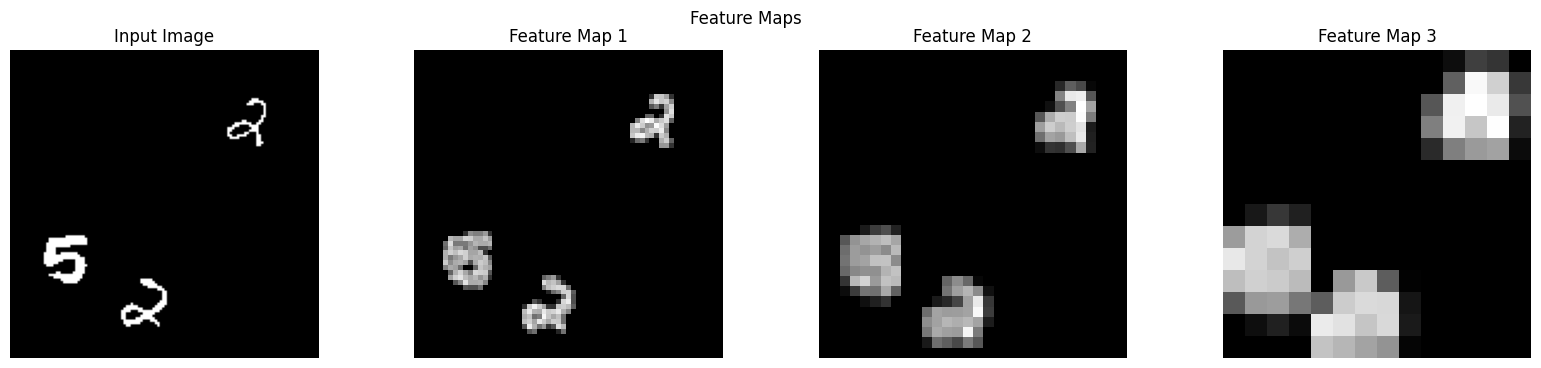

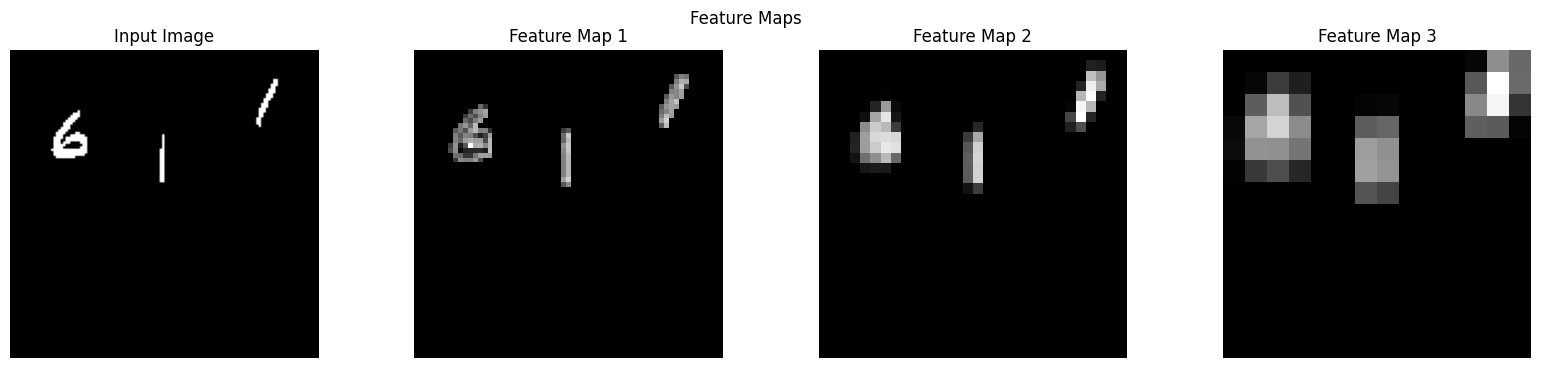

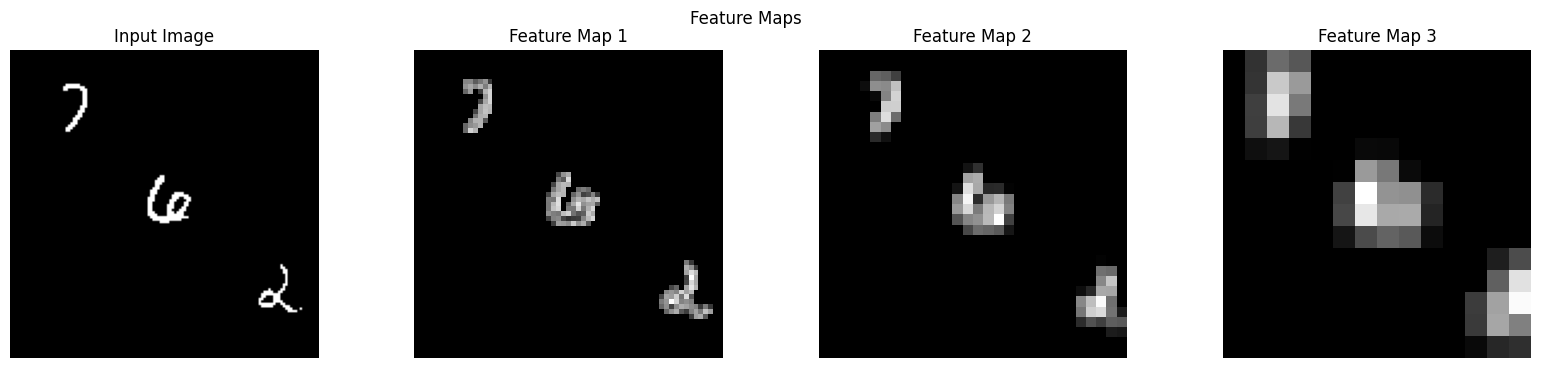

In [17]:
# regression feature maps
x = train_loader.dataset[0][0].unsqueeze(0)
show_feature_map(cnn_regression, x)
x = val_loader.dataset[0][0].unsqueeze(0)
show_feature_map(cnn_classification, x)
x = test_loader.dataset[0][0].unsqueeze(0)
show_feature_map(cnn_classification, x)

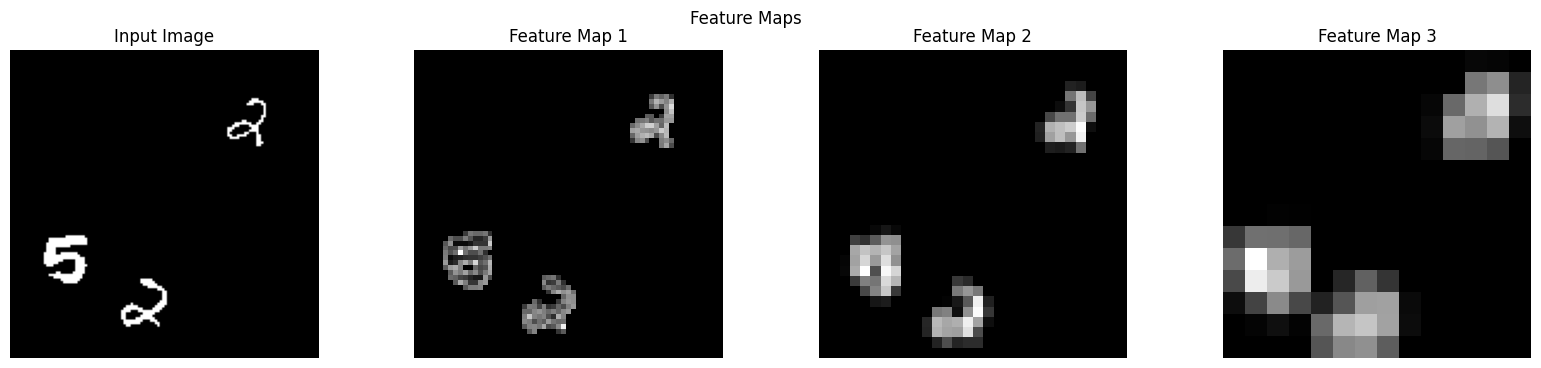

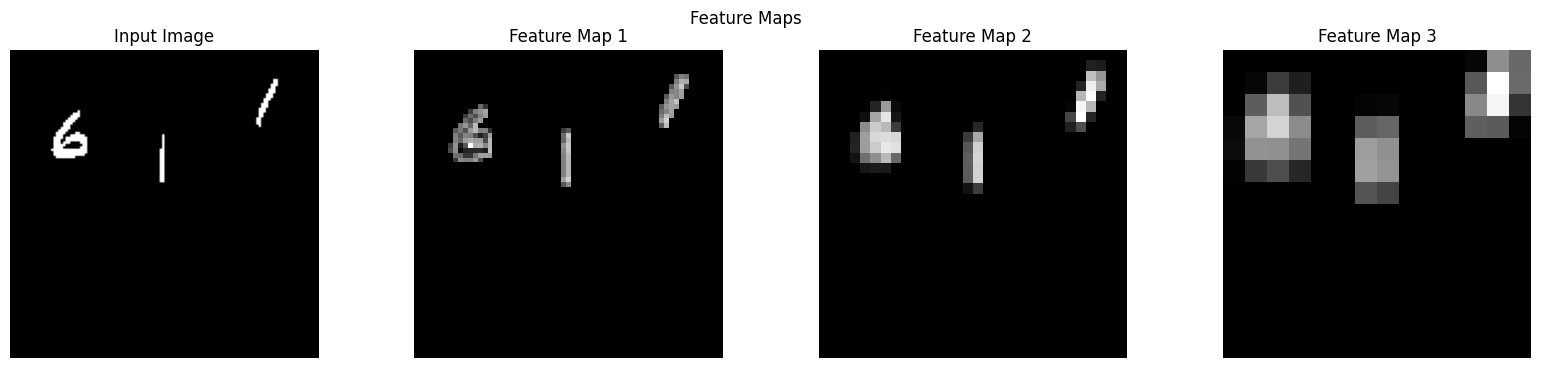

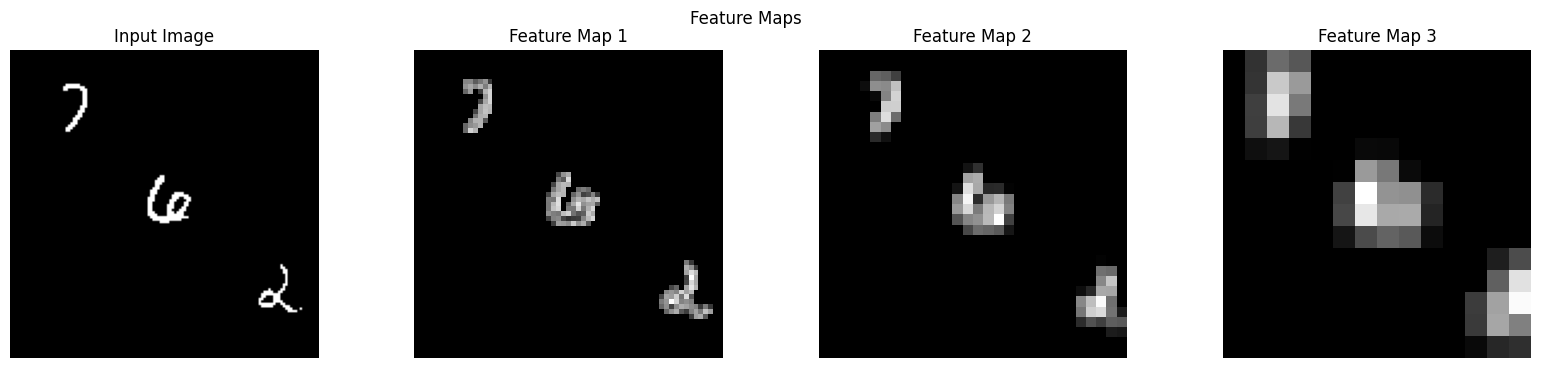

In [18]:
# classification feature maps
x = train_loader.dataset[0][0].unsqueeze(0)
show_feature_map(cnn_classification, x)
x = val_loader.dataset[0][0].unsqueeze(0)
show_feature_map(cnn_classification, x)
x = test_loader.dataset[0][0].unsqueeze(0)
show_feature_map(cnn_classification, x)

# 3. Multi Label Classsification

## 3.1 Data Loading and Preprocessing

In [19]:
def load_mnist_data_multi():
    data_dir = os.path.join(base_dir, "data", "external", "double_mnist")
    
    def one_hot_encode_multi(label):
        res = torch.tensor([0.0] * 33).float()
        # 0-9 indices store 0-9 value and index 10 stores none
        if len(label) >= 1:
            res[int(label[0])] = 1.0
        else:
            res[10] = 1.0
        if len(label) >= 2:
            res[int(label[1])+11] = 1.0
        else:
            res[21] = 1.0
        if len(label) >= 3:
            res[int(label[2])+22] = 1.0
        else:
            res[32] = 1.0
        return res

    def read_dataset(dataset_dir):
        images = []
        labels = []
        for label in os.listdir(dataset_dir):
            label_dir = os.path.join(dataset_dir, label)
            for image in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image)
                img = read_image(image_path).float()
                img = torch.where(img > 127, torch.tensor(1.0), torch.tensor(0.0))
                images.append(img)
                labels.append(one_hot_encode_multi(label if label!='0' else ''))
                    
        images = torch.stack(images)
        labels = torch.vstack(labels)
        return images, labels

    train_images, train_labels = read_dataset(os.path.join(data_dir, "train"))
    val_images, val_labels = read_dataset(os.path.join(data_dir, "val"))
    test_images, test_labels = read_dataset(os.path.join(data_dir, "test"))

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

train_images, train_labels, val_images, val_labels, test_images, test_labels = (
    load_mnist_data_multi()
)

In [20]:
# dataset instances
train_dataset = MultiMNISTDataset(train_images, train_labels)
val_dataset = MultiMNISTDataset(val_images, val_labels)
test_dataset = MultiMNISTDataset(test_images, test_labels)

In [21]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## 3.2 Sample run of the implemented model

In [22]:
multi_cnn = CNN(task="multilabel-classification", epochs=15, learning_rate=0.001, output_size=33)
multi_cnn.fit(train_loader, val_loader)

multi_cnn.evaluate(train_loader, type='Train')
multi_cnn.evaluate(val_loader, type='Validation')
multi_cnn.evaluate(test_loader, type='Test')

Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 120.74it/s]


Epoch 1/15, Loss: 8.398880411525669
	Validation Loss: 8.3448 Validation Accuracy: 3.57% Hamming Accuracy: 38.60%


100%|██████████| 197/197 [00:01<00:00, 121.51it/s]


Epoch 2/15, Loss: 7.837298245599428
	Validation Loss: 8.2864 Validation Accuracy: 4.03% Hamming Accuracy: 42.83%


100%|██████████| 197/197 [00:01<00:00, 121.43it/s]


Epoch 3/15, Loss: 7.556703894271464
	Validation Loss: 8.3454 Validation Accuracy: 3.80% Hamming Accuracy: 44.89%


100%|██████████| 197/197 [00:01<00:00, 121.26it/s]


Epoch 4/15, Loss: 7.195670781401813
	Validation Loss: 8.1751 Validation Accuracy: 4.33% Hamming Accuracy: 47.89%


100%|██████████| 197/197 [00:01<00:00, 121.05it/s]


Epoch 5/15, Loss: 6.8015541522030905
	Validation Loss: 7.6683 Validation Accuracy: 6.57% Hamming Accuracy: 51.19%


100%|██████████| 197/197 [00:01<00:00, 119.17it/s]


Epoch 6/15, Loss: 6.439481507703133
	Validation Loss: 7.3448 Validation Accuracy: 9.80% Hamming Accuracy: 55.10%


100%|██████████| 197/197 [00:01<00:00, 120.42it/s]


Epoch 7/15, Loss: 6.116519477766783
	Validation Loss: 7.2374 Validation Accuracy: 12.97% Hamming Accuracy: 59.07%


100%|██████████| 197/197 [00:01<00:00, 120.92it/s]


Epoch 8/15, Loss: 5.870237294792524
	Validation Loss: 6.9312 Validation Accuracy: 19.87% Hamming Accuracy: 63.87%


100%|██████████| 197/197 [00:01<00:00, 121.06it/s]


Epoch 9/15, Loss: 5.703662838427548
	Validation Loss: 6.6189 Validation Accuracy: 23.63% Hamming Accuracy: 67.70%


100%|██████████| 197/197 [00:01<00:00, 121.12it/s]


Epoch 10/15, Loss: 5.5507535619784125
	Validation Loss: 6.5899 Validation Accuracy: 26.57% Hamming Accuracy: 69.14%


100%|██████████| 197/197 [00:01<00:00, 120.98it/s]


Epoch 11/15, Loss: 5.448517697716728
	Validation Loss: 6.4791 Validation Accuracy: 29.67% Hamming Accuracy: 71.11%


100%|██████████| 197/197 [00:01<00:00, 121.05it/s]


Epoch 12/15, Loss: 5.366542232823251
	Validation Loss: 6.5974 Validation Accuracy: 28.57% Hamming Accuracy: 70.68%


100%|██████████| 197/197 [00:01<00:00, 121.13it/s]


Epoch 13/15, Loss: 5.301689837789778
	Validation Loss: 6.3535 Validation Accuracy: 31.43% Hamming Accuracy: 72.34%


100%|██████████| 197/197 [00:01<00:00, 120.35it/s]


Epoch 14/15, Loss: 5.21986215126696
	Validation Loss: 6.4557 Validation Accuracy: 32.50% Hamming Accuracy: 73.06%


100%|██████████| 197/197 [00:01<00:00, 121.09it/s]


Epoch 15/15, Loss: 5.181299412916155
	Validation Loss: 6.4693 Validation Accuracy: 33.83% Hamming Accuracy: 73.46%
	Train Loss: 4.8353 Train Accuracy: 73.93% Hamming Accuracy: 88.99%
	Validation Loss: 6.4697 Validation Accuracy: 33.83% Hamming Accuracy: 73.46%
	Test Loss: 7.2534 Test Accuracy: 28.67% Hamming Accuracy: 72.12%


## 3.3 Hyperparameter Tuning

In [23]:
# hyperparameter sweep for regression task using CNN
sweep_config = {
        "method": "grid",
        "metric": {"name": "hamming_accuracy", "goal": "maximize"},
        "parameters": {
            "learning_rate": {"values": [0.01, 0.001]},
            "dropout_rate": {"values": [0.1, 0.5, 0.9]},
            "num_layers": {"values": [1, 3, 5]},
            "activation_function": {"values": ["relu", "sigmoid", "tanh"]},
            "optimizer": {"values": ["adam", "sgd"]},
            "epochs": {"values": [10, 20]},
        },
    }

# sweep
activations = {'relu': nn.ReLU(), 'sigmoid': nn.Sigmoid(), 'tanh': nn.Tanh()}
optimizers = {'adam': optim.Adam, 'sgd': optim.SGD}
run_id = 0

def train():
    global run_id
    wandb.init(project="cnn-multilabel-classification", name=f"run-{run_id}")
    run_id += 1
    config = wandb.config
    model = CNN(
        learning_rate=config.learning_rate,
        dropout_rate=config.dropout_rate,
        kernel_sizes=[3]*config.num_layers,
        channel_sizes=[16,32,64,128, 32][:config.num_layers],
        activation_functions=[activations[config.activation_function]]*config.num_layers,
        optimizer=optimizers[config.optimizer],
        task="multilabel-classification",
        output_size=33,
        log_wandb=True
    )
    model.fit(train_loader, val_loader)
    loss, accuracy, hamming_accuracy = model.evaluate(test_loader, type="Test", return_output=True)
    wandb.log(
        {
            "loss": loss,
            "exact_match_accuracy": accuracy,
            "hamming_accuracy": hamming_accuracy
        }
    )

    wandb.finish()

sweep_id = wandb.sweep(sweep_config, project="cnn-multilabel-classification")
wandb.agent(sweep_id, train)

Create sweep with ID: yiqn4v2i
Sweep URL: https://wandb.ai/gauravbehera-iiith/cnn-multilabel-classification/sweeps/yiqn4v2i


wandb: Agent Starting Run: 8xhqu7gs with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 354.44it/s]


Epoch 1/10, Loss: 11.20172532076763
	Validation Loss: 9.3668  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 356.82it/s]


Epoch 2/10, Loss: 9.13463109882955
	Validation Loss: 9.2779  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 356.59it/s]


Epoch 3/10, Loss: 9.106422172585114
	Validation Loss: 9.2763  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 355.37it/s]


Epoch 4/10, Loss: 9.10562869618992
	Validation Loss: 9.2591  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 353.84it/s]


Epoch 5/10, Loss: 9.106256426893514
	Validation Loss: 9.2595  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 353.28it/s]


Epoch 6/10, Loss: 9.105550785355156
	Validation Loss: 9.2749  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 353.41it/s]


Epoch 7/10, Loss: 9.106377228867585
	Validation Loss: 9.2658  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 353.09it/s]


Epoch 8/10, Loss: 9.106281629068597
	Validation Loss: 9.2737  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 353.23it/s]


Epoch 9/10, Loss: 9.106572683692583
	Validation Loss: 9.2692  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 353.42it/s]


Epoch 10/10, Loss: 9.106204347562064
	Validation Loss: 9.2588  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: sb1o6ocu with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 367.71it/s]


Epoch 1/10, Loss: 9.051141816347384
	Validation Loss: 8.9334  Hamming Accuracy: 33.00%


100%|██████████| 197/197 [00:00<00:00, 369.59it/s]


Epoch 2/10, Loss: 8.5705986458638
	Validation Loss: 8.5601 Validation Accuracy: 0.17% Hamming Accuracy: 34.77%


100%|██████████| 197/197 [00:00<00:00, 379.93it/s]


Epoch 3/10, Loss: 8.24937004244267
	Validation Loss: 8.4601 Validation Accuracy: 3.53% Hamming Accuracy: 37.66%


100%|██████████| 197/197 [00:00<00:00, 369.64it/s]


Epoch 4/10, Loss: 8.045349885969598
	Validation Loss: 8.3248 Validation Accuracy: 3.90% Hamming Accuracy: 39.59%


100%|██████████| 197/197 [00:00<00:00, 378.33it/s]


Epoch 5/10, Loss: 7.909223902649081
	Validation Loss: 8.2185 Validation Accuracy: 4.33% Hamming Accuracy: 40.03%


100%|██████████| 197/197 [00:00<00:00, 370.16it/s]


Epoch 6/10, Loss: 7.791895011959947
	Validation Loss: 8.2021 Validation Accuracy: 6.03% Hamming Accuracy: 41.94%


100%|██████████| 197/197 [00:00<00:00, 371.45it/s]


Epoch 7/10, Loss: 7.705679356144165
	Validation Loss: 8.2604 Validation Accuracy: 5.40% Hamming Accuracy: 42.39%


100%|██████████| 197/197 [00:00<00:00, 377.11it/s]


Epoch 8/10, Loss: 7.634083433199655
	Validation Loss: 8.5152 Validation Accuracy: 4.17% Hamming Accuracy: 41.48%


100%|██████████| 197/197 [00:00<00:00, 376.16it/s]


Epoch 9/10, Loss: 7.567850497773456
	Validation Loss: 8.3641 Validation Accuracy: 4.43% Hamming Accuracy: 41.94%


100%|██████████| 197/197 [00:00<00:00, 371.92it/s]


Epoch 10/10, Loss: 7.497848271113361
	Validation Loss: 8.3797 Validation Accuracy: 4.60% Hamming Accuracy: 42.37%


wandb: Agent Starting Run: 562nmxdg with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.58it/s]


Epoch 1/10, Loss: 9.21302894650377
	Validation Loss: 9.3137  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 209.34it/s]


Epoch 2/10, Loss: 9.129834199314795
	Validation Loss: 9.2934  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 209.03it/s]


Epoch 3/10, Loss: 9.120403323681826
	Validation Loss: 9.2757  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.41it/s]


Epoch 4/10, Loss: 9.11664150935139
	Validation Loss: 9.3049  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 5/10, Loss: 9.11969547465368
	Validation Loss: 9.2796  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.00it/s]


Epoch 6/10, Loss: 9.113168077420463
	Validation Loss: 9.2716  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.81it/s]


Epoch 7/10, Loss: 9.111800552019613
	Validation Loss: 9.2936  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.04it/s]


Epoch 8/10, Loss: 9.11127250206652
	Validation Loss: 9.2701  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.15it/s]


Epoch 9/10, Loss: 9.110284684273193
	Validation Loss: 9.2597  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.87it/s]


Epoch 10/10, Loss: 9.110150332378252
	Validation Loss: 9.2634  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 7a17t7rm with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.90it/s]


Epoch 1/10, Loss: 9.274279115163734
	Validation Loss: 9.2548  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 215.12it/s]


Epoch 2/10, Loss: 9.058120790471886
	Validation Loss: 9.2497  Hamming Accuracy: 33.12%


100%|██████████| 197/197 [00:00<00:00, 215.97it/s]


Epoch 3/10, Loss: 8.703855153872881
	Validation Loss: 8.6824  Hamming Accuracy: 35.24%


100%|██████████| 197/197 [00:00<00:00, 212.12it/s]


Epoch 4/10, Loss: 8.1679703136386
	Validation Loss: 8.3376 Validation Accuracy: 3.63% Hamming Accuracy: 39.13%


100%|██████████| 197/197 [00:00<00:00, 215.56it/s]


Epoch 5/10, Loss: 7.937436183697076
	Validation Loss: 8.2993 Validation Accuracy: 3.47% Hamming Accuracy: 38.56%


100%|██████████| 197/197 [00:00<00:00, 215.53it/s]


Epoch 6/10, Loss: 7.812574522144298
	Validation Loss: 8.2365 Validation Accuracy: 4.53% Hamming Accuracy: 41.76%


100%|██████████| 197/197 [00:00<00:00, 215.53it/s]


Epoch 7/10, Loss: 7.715934951898411
	Validation Loss: 8.3707 Validation Accuracy: 4.07% Hamming Accuracy: 42.59%


100%|██████████| 197/197 [00:00<00:00, 215.55it/s]


Epoch 8/10, Loss: 7.64924676769276
	Validation Loss: 8.4306 Validation Accuracy: 4.13% Hamming Accuracy: 41.18%


100%|██████████| 197/197 [00:00<00:00, 215.98it/s]


Epoch 9/10, Loss: 7.588743284874156
	Validation Loss: 8.4482 Validation Accuracy: 4.97% Hamming Accuracy: 43.88%


100%|██████████| 197/197 [00:00<00:00, 215.73it/s]


Epoch 10/10, Loss: 7.528389758870081
	Validation Loss: 8.5345 Validation Accuracy: 4.87% Hamming Accuracy: 42.79%


wandb: Agent Starting Run: 2lkjt3jd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.94it/s]


Epoch 1/10, Loss: 9.356891114094536
	Validation Loss: 9.2391  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.72it/s]


Epoch 2/10, Loss: 9.130396237833246
	Validation Loss: 9.2661  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.52it/s]


Epoch 3/10, Loss: 9.118200544173343
	Validation Loss: 9.2786  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 189.52it/s]


Epoch 4/10, Loss: 9.116501362795757
	Validation Loss: 9.2797  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.39it/s]


Epoch 5/10, Loss: 9.113713472627746
	Validation Loss: 9.2703  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 189.05it/s]


Epoch 6/10, Loss: 9.113009903031557
	Validation Loss: 9.2919  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.09it/s]


Epoch 7/10, Loss: 9.113565106077242
	Validation Loss: 9.2456  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.93it/s]


Epoch 8/10, Loss: 9.109979556901806
	Validation Loss: 9.2688  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.15it/s]


Epoch 9/10, Loss: 9.110019737088741
	Validation Loss: 9.2679  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.33it/s]


Epoch 10/10, Loss: 9.110012795114276
	Validation Loss: 9.2714  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: vwgyzs1o with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.20it/s]


Epoch 1/10, Loss: 9.791782253284746
	Validation Loss: 9.3477  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.11it/s]


Epoch 2/10, Loss: 9.145136252272552
	Validation Loss: 9.2750  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.03it/s]


Epoch 3/10, Loss: 9.115079371457172
	Validation Loss: 9.2749  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.66it/s]


Epoch 4/10, Loss: 9.112091848692918
	Validation Loss: 9.2647  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.82it/s]


Epoch 5/10, Loss: 9.11139306199127
	Validation Loss: 9.2785  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 193.52it/s]


Epoch 6/10, Loss: 9.110004841373657
	Validation Loss: 9.2664  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.38it/s]


Epoch 7/10, Loss: 9.109056085499411
	Validation Loss: 9.2653  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.34it/s]


Epoch 8/10, Loss: 9.104504807951487
	Validation Loss: 9.2706  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.59it/s]


Epoch 9/10, Loss: 9.099689081840708
	Validation Loss: 9.2648  Hamming Accuracy: 32.08%


100%|██████████| 197/197 [00:01<00:00, 191.48it/s]


Epoch 10/10, Loss: 9.064037231019306
	Validation Loss: 9.1443  Hamming Accuracy: 33.08%


wandb: Agent Starting Run: t89pwijq with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 353.72it/s]


Epoch 1/10, Loss: 9.18572049213545
	Validation Loss: 8.6105  Hamming Accuracy: 35.76%


100%|██████████| 197/197 [00:00<00:00, 355.63it/s]


Epoch 2/10, Loss: 8.30757580432795
	Validation Loss: 8.3913 Validation Accuracy: 3.33% Hamming Accuracy: 36.49%


100%|██████████| 197/197 [00:00<00:00, 354.82it/s]


Epoch 3/10, Loss: 8.086023444451657
	Validation Loss: 8.3692 Validation Accuracy: 3.33% Hamming Accuracy: 37.59%


100%|██████████| 197/197 [00:00<00:00, 343.23it/s]


Epoch 4/10, Loss: 7.980275698724737
	Validation Loss: 8.3444 Validation Accuracy: 3.33% Hamming Accuracy: 38.57%


100%|██████████| 197/197 [00:00<00:00, 353.54it/s]


Epoch 5/10, Loss: 7.9309486471456925
	Validation Loss: 8.3327 Validation Accuracy: 4.03% Hamming Accuracy: 39.77%


100%|██████████| 197/197 [00:00<00:00, 350.32it/s]


Epoch 6/10, Loss: 7.899254619772664
	Validation Loss: 8.3425 Validation Accuracy: 3.97% Hamming Accuracy: 38.41%


100%|██████████| 197/197 [00:00<00:00, 352.74it/s]


Epoch 7/10, Loss: 7.872585884810705
	Validation Loss: 8.3009 Validation Accuracy: 4.07% Hamming Accuracy: 39.04%


100%|██████████| 197/197 [00:00<00:00, 353.15it/s]


Epoch 8/10, Loss: 7.847703055076793
	Validation Loss: 8.3132 Validation Accuracy: 4.33% Hamming Accuracy: 40.24%


100%|██████████| 197/197 [00:00<00:00, 353.47it/s]


Epoch 9/10, Loss: 7.822713694596653
	Validation Loss: 8.3722 Validation Accuracy: 4.30% Hamming Accuracy: 38.92%


100%|██████████| 197/197 [00:00<00:00, 353.31it/s]


Epoch 10/10, Loss: 7.805003635774409
	Validation Loss: 8.3419 Validation Accuracy: 4.03% Hamming Accuracy: 39.96%


wandb: Agent Starting Run: 93hxnb5e with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 369.06it/s]


Epoch 1/10, Loss: 9.547751523516505
	Validation Loss: 9.3691  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 374.26it/s]


Epoch 2/10, Loss: 9.182073781938117
	Validation Loss: 9.2363  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 377.94it/s]


Epoch 3/10, Loss: 9.062234641331706
	Validation Loss: 9.1557  Hamming Accuracy: 33.14%


100%|██████████| 197/197 [00:00<00:00, 375.37it/s]


Epoch 4/10, Loss: 8.985431003086457
	Validation Loss: 9.1104  Hamming Accuracy: 33.20%


100%|██████████| 197/197 [00:00<00:00, 376.08it/s]


Epoch 5/10, Loss: 8.923070050738184
	Validation Loss: 9.0734  Hamming Accuracy: 33.03%


100%|██████████| 197/197 [00:00<00:00, 377.05it/s]


Epoch 6/10, Loss: 8.869364898216906
	Validation Loss: 9.0170  Hamming Accuracy: 34.37%


100%|██████████| 197/197 [00:00<00:00, 375.83it/s]


Epoch 7/10, Loss: 8.818398785470102
	Validation Loss: 8.9829  Hamming Accuracy: 33.57%


100%|██████████| 197/197 [00:00<00:00, 375.05it/s]


Epoch 8/10, Loss: 8.768648413837258
	Validation Loss: 8.9372  Hamming Accuracy: 34.34%


100%|██████████| 197/197 [00:00<00:00, 380.91it/s]


Epoch 9/10, Loss: 8.717883110046387
	Validation Loss: 8.9121  Hamming Accuracy: 33.79%


100%|██████████| 197/197 [00:00<00:00, 377.36it/s]


Epoch 10/10, Loss: 8.666419668246041
	Validation Loss: 8.8437 Validation Accuracy: 0.10% Hamming Accuracy: 34.49%


wandb: Agent Starting Run: u6gy5z0l with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.17it/s]


Epoch 1/10, Loss: 8.47049572262062
	Validation Loss: 8.4707 Validation Accuracy: 5.23% Hamming Accuracy: 40.59%


100%|██████████| 197/197 [00:00<00:00, 208.39it/s]


Epoch 2/10, Loss: 7.858994074884405
	Validation Loss: 8.3132 Validation Accuracy: 5.77% Hamming Accuracy: 42.29%


100%|██████████| 197/197 [00:00<00:00, 206.84it/s]


Epoch 3/10, Loss: 7.557883085938275
	Validation Loss: 8.5712 Validation Accuracy: 5.07% Hamming Accuracy: 44.10%


100%|██████████| 197/197 [00:00<00:00, 208.55it/s]


Epoch 4/10, Loss: 7.212929018862962
	Validation Loss: 8.2737 Validation Accuracy: 6.83% Hamming Accuracy: 46.54%


100%|██████████| 197/197 [00:00<00:00, 208.27it/s]


Epoch 5/10, Loss: 6.884228578073724
	Validation Loss: 7.9521 Validation Accuracy: 7.20% Hamming Accuracy: 48.31%


100%|██████████| 197/197 [00:00<00:00, 207.09it/s]


Epoch 6/10, Loss: 6.569461752315463
	Validation Loss: 7.7525 Validation Accuracy: 8.70% Hamming Accuracy: 49.61%


100%|██████████| 197/197 [00:00<00:00, 206.65it/s]


Epoch 7/10, Loss: 6.330392084751033
	Validation Loss: 7.5730 Validation Accuracy: 8.30% Hamming Accuracy: 50.70%


100%|██████████| 197/197 [00:00<00:00, 206.41it/s]


Epoch 8/10, Loss: 6.142321179966031
	Validation Loss: 7.3900 Validation Accuracy: 10.73% Hamming Accuracy: 53.73%


100%|██████████| 197/197 [00:00<00:00, 206.23it/s]


Epoch 9/10, Loss: 5.980258092057281
	Validation Loss: 7.2330 Validation Accuracy: 15.10% Hamming Accuracy: 55.96%


100%|██████████| 197/197 [00:00<00:00, 208.04it/s]


Epoch 10/10, Loss: 5.8178005170096
	Validation Loss: 7.2548 Validation Accuracy: 13.60% Hamming Accuracy: 55.20%


wandb: Agent Starting Run: ee5nipvf with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.22it/s]


Epoch 1/10, Loss: 10.102144449495421
	Validation Loss: 9.5376  Hamming Accuracy: 28.28%


100%|██████████| 197/197 [00:00<00:00, 212.38it/s]


Epoch 2/10, Loss: 9.326338148359115
	Validation Loss: 9.3654  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.53it/s]


Epoch 3/10, Loss: 9.19617660154546
	Validation Loss: 9.3172  Hamming Accuracy: 33.62%


100%|██████████| 197/197 [00:00<00:00, 214.88it/s]


Epoch 4/10, Loss: 9.151387718123228
	Validation Loss: 9.2975  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.87it/s]


Epoch 5/10, Loss: 9.129394298882653
	Validation Loss: 9.2905  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.05it/s]


Epoch 6/10, Loss: 9.116575003880534
	Validation Loss: 9.2663  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.15it/s]


Epoch 7/10, Loss: 9.108230334248034
	Validation Loss: 9.2686  Hamming Accuracy: 32.87%


100%|██████████| 197/197 [00:00<00:00, 215.02it/s]


Epoch 8/10, Loss: 9.10136003058574
	Validation Loss: 9.2584  Hamming Accuracy: 32.90%


100%|██████████| 197/197 [00:00<00:00, 215.21it/s]


Epoch 9/10, Loss: 9.095345758544612
	Validation Loss: 9.2504  Hamming Accuracy: 32.92%


100%|██████████| 197/197 [00:00<00:00, 215.84it/s]


Epoch 10/10, Loss: 9.087479920556703
	Validation Loss: 9.2492  Hamming Accuracy: 31.80%


wandb: Agent Starting Run: 6uds14we with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.08it/s]


Epoch 1/10, Loss: 9.195439178931531
	Validation Loss: 8.7872  Hamming Accuracy: 34.69%


100%|██████████| 197/197 [00:01<00:00, 190.50it/s]


Epoch 2/10, Loss: 8.215457727461297
	Validation Loss: 8.3943 Validation Accuracy: 3.63% Hamming Accuracy: 38.21%


100%|██████████| 197/197 [00:01<00:00, 190.41it/s]


Epoch 3/10, Loss: 7.975728458559453
	Validation Loss: 8.3944 Validation Accuracy: 3.93% Hamming Accuracy: 39.69%


100%|██████████| 197/197 [00:01<00:00, 189.75it/s]


Epoch 4/10, Loss: 7.845418000584327
	Validation Loss: 8.5453 Validation Accuracy: 3.83% Hamming Accuracy: 39.73%


100%|██████████| 197/197 [00:01<00:00, 189.66it/s]


Epoch 5/10, Loss: 7.726653418565159
	Validation Loss: 8.4638 Validation Accuracy: 4.27% Hamming Accuracy: 41.46%


100%|██████████| 197/197 [00:01<00:00, 190.43it/s]


Epoch 6/10, Loss: 7.499554784164816
	Validation Loss: 8.1040 Validation Accuracy: 5.23% Hamming Accuracy: 44.23%


100%|██████████| 197/197 [00:01<00:00, 189.58it/s]


Epoch 7/10, Loss: 7.280521237910701
	Validation Loss: 8.1717 Validation Accuracy: 4.70% Hamming Accuracy: 43.43%


100%|██████████| 197/197 [00:01<00:00, 189.23it/s]


Epoch 8/10, Loss: 7.068524210586161
	Validation Loss: 7.7176 Validation Accuracy: 5.17% Hamming Accuracy: 45.29%


100%|██████████| 197/197 [00:01<00:00, 189.63it/s]


Epoch 9/10, Loss: 6.9369609924742415
	Validation Loss: 7.6649 Validation Accuracy: 5.87% Hamming Accuracy: 45.40%


100%|██████████| 197/197 [00:01<00:00, 190.11it/s]


Epoch 10/10, Loss: 6.807150741519057
	Validation Loss: 7.5782 Validation Accuracy: 6.33% Hamming Accuracy: 46.86%


wandb: Agent Starting Run: yxl3qyxv with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.47it/s]


Epoch 1/10, Loss: 10.366510759150316
	Validation Loss: 10.2968  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:00<00:00, 197.28it/s]


Epoch 2/10, Loss: 10.250681620563952
	Validation Loss: 10.1917  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:00<00:00, 197.33it/s]


Epoch 3/10, Loss: 10.141570052519668
	Validation Loss: 10.0927  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:01<00:00, 196.88it/s]


Epoch 4/10, Loss: 10.040430858050506
	Validation Loss: 9.9998  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:01<00:00, 196.10it/s]


Epoch 5/10, Loss: 9.943018869700165
	Validation Loss: 9.9091  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:01<00:00, 196.64it/s]


Epoch 6/10, Loss: 9.845379141986673
	Validation Loss: 9.8174  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 7/10, Loss: 9.743526298987684
	Validation Loss: 9.7200  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:01<00:00, 196.59it/s]


Epoch 8/10, Loss: 9.628761068818532
	Validation Loss: 9.6074 Validation Accuracy: 3.03% Hamming Accuracy: 30.39%


100%|██████████| 197/197 [00:01<00:00, 196.42it/s]


Epoch 9/10, Loss: 9.489907608419506
	Validation Loss: 9.4831 Validation Accuracy: 3.33% Hamming Accuracy: 30.50%


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 10/10, Loss: 9.369064800630365
	Validation Loss: 9.4244 Validation Accuracy: 2.43% Hamming Accuracy: 34.42%


wandb: Agent Starting Run: 05g8eg85 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 352.94it/s]


Epoch 1/10, Loss: 11.776921373938546
	Validation Loss: 9.3426  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 355.33it/s]


Epoch 2/10, Loss: 9.128395685689703
	Validation Loss: 9.2676  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 354.82it/s]


Epoch 3/10, Loss: 9.1061072470573
	Validation Loss: 9.2693  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.79it/s]


Epoch 4/10, Loss: 9.105471925687064
	Validation Loss: 9.2731  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 349.90it/s]


Epoch 5/10, Loss: 9.10584680199018
	Validation Loss: 9.2763  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 350.31it/s]


Epoch 6/10, Loss: 9.105652170132865
	Validation Loss: 9.2586  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 351.96it/s]


Epoch 7/10, Loss: 9.106300838102545
	Validation Loss: 9.2666  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.88it/s]


Epoch 8/10, Loss: 9.10609312105905
	Validation Loss: 9.2703  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.63it/s]


Epoch 9/10, Loss: 9.10594703461313
	Validation Loss: 9.2605  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 352.75it/s]


Epoch 10/10, Loss: 9.105896712559733
	Validation Loss: 9.2692  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: brlh3mj7 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 362.88it/s]


Epoch 1/10, Loss: 9.088027857281835
	Validation Loss: 9.0211  Hamming Accuracy: 33.47%


100%|██████████| 197/197 [00:00<00:00, 340.24it/s]


Epoch 2/10, Loss: 8.716264908688927
	Validation Loss: 8.7861 Validation Accuracy: 0.23% Hamming Accuracy: 34.61%


100%|██████████| 197/197 [00:00<00:00, 373.81it/s]


Epoch 3/10, Loss: 8.399778901017863
	Validation Loss: 8.4763  Hamming Accuracy: 36.06%


100%|██████████| 197/197 [00:00<00:00, 358.22it/s]


Epoch 4/10, Loss: 8.172966918364395
	Validation Loss: 8.3664 Validation Accuracy: 3.40% Hamming Accuracy: 37.47%


100%|██████████| 197/197 [00:00<00:00, 371.10it/s]


Epoch 5/10, Loss: 8.064647277599663
	Validation Loss: 8.3022 Validation Accuracy: 3.70% Hamming Accuracy: 40.12%


100%|██████████| 197/197 [00:00<00:00, 378.69it/s]


Epoch 6/10, Loss: 7.992714712462449
	Validation Loss: 8.2835 Validation Accuracy: 4.20% Hamming Accuracy: 40.62%


100%|██████████| 197/197 [00:00<00:00, 379.79it/s]


Epoch 7/10, Loss: 7.913413149451241
	Validation Loss: 8.2006 Validation Accuracy: 4.40% Hamming Accuracy: 40.89%


100%|██████████| 197/197 [00:00<00:00, 378.87it/s]


Epoch 8/10, Loss: 7.821960117611183
	Validation Loss: 8.2721 Validation Accuracy: 4.20% Hamming Accuracy: 40.53%


100%|██████████| 197/197 [00:00<00:00, 379.64it/s]


Epoch 9/10, Loss: 7.747005891073779
	Validation Loss: 8.2831 Validation Accuracy: 3.97% Hamming Accuracy: 41.49%


100%|██████████| 197/197 [00:00<00:00, 379.41it/s]


Epoch 10/10, Loss: 7.667526833297033
	Validation Loss: 8.3165 Validation Accuracy: 3.70% Hamming Accuracy: 41.54%


wandb: Agent Starting Run: 6wwqaue8 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.13it/s]


Epoch 1/10, Loss: 9.487985267251881
	Validation Loss: 9.2825  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.12it/s]


Epoch 2/10, Loss: 9.126412565938107
	Validation Loss: 9.2921  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 207.77it/s]


Epoch 3/10, Loss: 9.12113101107215
	Validation Loss: 9.2792  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.47it/s]


Epoch 4/10, Loss: 9.118013473936749
	Validation Loss: 9.2699  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 204.79it/s]


Epoch 5/10, Loss: 9.116423945741605
	Validation Loss: 9.2674  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 202.42it/s]


Epoch 6/10, Loss: 9.116397591411765
	Validation Loss: 9.2850  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 205.49it/s]


Epoch 7/10, Loss: 9.11485633753278
	Validation Loss: 9.2880  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.19it/s]


Epoch 8/10, Loss: 9.115229863200696
	Validation Loss: 9.2717  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 206.71it/s]


Epoch 9/10, Loss: 9.110141976835765
	Validation Loss: 9.2467  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.57it/s]


Epoch 10/10, Loss: 9.110153387040656
	Validation Loss: 9.2961  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: ityf2rd0 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.65it/s]


Epoch 1/10, Loss: 9.31597766779401
	Validation Loss: 9.2767  Hamming Accuracy: 33.09%


100%|██████████| 197/197 [00:00<00:00, 213.51it/s]


Epoch 2/10, Loss: 9.049968114359125
	Validation Loss: 9.0321  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.61it/s]


Epoch 3/10, Loss: 8.52199806174651
	Validation Loss: 8.5586 Validation Accuracy: 3.37% Hamming Accuracy: 35.98%


100%|██████████| 197/197 [00:00<00:00, 214.51it/s]


Epoch 4/10, Loss: 8.086122052923677
	Validation Loss: 8.3962 Validation Accuracy: 3.40% Hamming Accuracy: 37.13%


100%|██████████| 197/197 [00:00<00:00, 211.06it/s]


Epoch 5/10, Loss: 7.901600532725378
	Validation Loss: 8.3825 Validation Accuracy: 4.50% Hamming Accuracy: 39.08%


100%|██████████| 197/197 [00:00<00:00, 213.09it/s]


Epoch 6/10, Loss: 7.783213308014846
	Validation Loss: 8.3845 Validation Accuracy: 3.90% Hamming Accuracy: 41.82%


100%|██████████| 197/197 [00:00<00:00, 213.67it/s]


Epoch 7/10, Loss: 7.688876198027945
	Validation Loss: 8.3026 Validation Accuracy: 4.93% Hamming Accuracy: 42.10%


100%|██████████| 197/197 [00:00<00:00, 213.20it/s]


Epoch 8/10, Loss: 7.617393977750981
	Validation Loss: 8.3581 Validation Accuracy: 4.37% Hamming Accuracy: 43.11%


100%|██████████| 197/197 [00:00<00:00, 213.62it/s]


Epoch 9/10, Loss: 7.5588917465984515
	Validation Loss: 8.3687 Validation Accuracy: 5.63% Hamming Accuracy: 43.62%


100%|██████████| 197/197 [00:00<00:00, 213.41it/s]


Epoch 10/10, Loss: 7.505014419555664
	Validation Loss: 8.4805 Validation Accuracy: 4.90% Hamming Accuracy: 44.59%


wandb: Agent Starting Run: 63yvl45s with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.35it/s]


Epoch 1/10, Loss: 9.186859435841518
	Validation Loss: 9.2927  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.59it/s]


Epoch 2/10, Loss: 9.122601179907164
	Validation Loss: 9.2842  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.33it/s]


Epoch 3/10, Loss: 9.116999490612049
	Validation Loss: 9.2670  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.47it/s]


Epoch 4/10, Loss: 9.113848952472512
	Validation Loss: 9.2796  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.62it/s]


Epoch 5/10, Loss: 9.11143791373006
	Validation Loss: 9.2913  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.53it/s]


Epoch 6/10, Loss: 9.110749293099806
	Validation Loss: 9.2978  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.41it/s]


Epoch 7/10, Loss: 9.11178401036916
	Validation Loss: 9.2501  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.02it/s]


Epoch 8/10, Loss: 9.110362057758467
	Validation Loss: 9.2845  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 188.32it/s]


Epoch 9/10, Loss: 9.1098901826113
	Validation Loss: 9.2518  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.56it/s]


Epoch 10/10, Loss: 9.109557669779976
	Validation Loss: 9.2765  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 1o9a0zim with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.88it/s]


Epoch 1/10, Loss: 9.998638530673109
	Validation Loss: 9.4128  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 194.35it/s]


Epoch 2/10, Loss: 9.217954935761272
	Validation Loss: 9.3039  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.00it/s]


Epoch 3/10, Loss: 9.130874033506752
	Validation Loss: 9.2861  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.03it/s]


Epoch 4/10, Loss: 9.114644718654265
	Validation Loss: 9.2708  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 193.78it/s]


Epoch 5/10, Loss: 9.110617947457406
	Validation Loss: 9.2736  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.30it/s]


Epoch 6/10, Loss: 9.110418595638372
	Validation Loss: 9.2603  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.59it/s]


Epoch 7/10, Loss: 9.1076908208392
	Validation Loss: 9.2692  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.05it/s]


Epoch 8/10, Loss: 9.106251857002375
	Validation Loss: 9.2689  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.00it/s]


Epoch 9/10, Loss: 9.102136544164667
	Validation Loss: 9.2617  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.34it/s]


Epoch 10/10, Loss: 9.097140457424416
	Validation Loss: 9.2601  Hamming Accuracy: 33.06%


wandb: Agent Starting Run: uekn1nzm with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 350.83it/s]


Epoch 1/10, Loss: 8.841679200303131
	Validation Loss: 8.6018 Validation Accuracy: 1.33% Hamming Accuracy: 36.30%


100%|██████████| 197/197 [00:00<00:00, 355.42it/s]


Epoch 2/10, Loss: 8.150409710588795
	Validation Loss: 8.4501 Validation Accuracy: 4.07% Hamming Accuracy: 39.41%


100%|██████████| 197/197 [00:00<00:00, 355.18it/s]


Epoch 3/10, Loss: 7.885572697305437
	Validation Loss: 8.2962 Validation Accuracy: 5.40% Hamming Accuracy: 41.54%


100%|██████████| 197/197 [00:00<00:00, 354.19it/s]


Epoch 4/10, Loss: 7.7542475927904775
	Validation Loss: 8.5187 Validation Accuracy: 4.43% Hamming Accuracy: 42.06%


100%|██████████| 197/197 [00:00<00:00, 351.96it/s]


Epoch 5/10, Loss: 7.655130316158236
	Validation Loss: 8.5585 Validation Accuracy: 5.50% Hamming Accuracy: 42.77%


100%|██████████| 197/197 [00:00<00:00, 352.44it/s]


Epoch 6/10, Loss: 7.561768255863093
	Validation Loss: 8.7495 Validation Accuracy: 3.97% Hamming Accuracy: 41.84%


100%|██████████| 197/197 [00:00<00:00, 352.65it/s]


Epoch 7/10, Loss: 7.479603043667556
	Validation Loss: 8.9455 Validation Accuracy: 5.40% Hamming Accuracy: 43.52%


100%|██████████| 197/197 [00:00<00:00, 346.51it/s]


Epoch 8/10, Loss: 7.417966782139038
	Validation Loss: 9.2338 Validation Accuracy: 5.00% Hamming Accuracy: 43.33%


100%|██████████| 197/197 [00:00<00:00, 352.78it/s]


Epoch 9/10, Loss: 7.35392232352707
	Validation Loss: 9.3093 Validation Accuracy: 5.33% Hamming Accuracy: 43.80%


100%|██████████| 197/197 [00:00<00:00, 352.45it/s]


Epoch 10/10, Loss: 7.300498870423603
	Validation Loss: 9.6256 Validation Accuracy: 4.77% Hamming Accuracy: 43.91%


wandb: Agent Starting Run: a3al1wlj with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 375.20it/s]


Epoch 1/10, Loss: 9.424840946487969
	Validation Loss: 9.3604  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 378.07it/s]


Epoch 2/10, Loss: 9.07785004165572
	Validation Loss: 9.1946  Hamming Accuracy: 31.97%


100%|██████████| 197/197 [00:00<00:00, 379.03it/s]


Epoch 3/10, Loss: 8.98101566043602
	Validation Loss: 9.1374  Hamming Accuracy: 32.20%


100%|██████████| 197/197 [00:00<00:00, 378.14it/s]


Epoch 4/10, Loss: 8.918264621405433
	Validation Loss: 9.0578  Hamming Accuracy: 32.73%


100%|██████████| 197/197 [00:00<00:00, 378.10it/s]


Epoch 5/10, Loss: 8.863979804334301
	Validation Loss: 9.0055  Hamming Accuracy: 32.92%


100%|██████████| 197/197 [00:00<00:00, 377.50it/s]


Epoch 6/10, Loss: 8.807831938496701
	Validation Loss: 8.9643  Hamming Accuracy: 32.60%


100%|██████████| 197/197 [00:00<00:00, 377.88it/s]


Epoch 7/10, Loss: 8.750594371466468
	Validation Loss: 8.9211  Hamming Accuracy: 32.38%


100%|██████████| 197/197 [00:00<00:00, 377.54it/s]


Epoch 8/10, Loss: 8.691888964115666
	Validation Loss: 8.8677  Hamming Accuracy: 33.02%


100%|██████████| 197/197 [00:00<00:00, 377.16it/s]


Epoch 9/10, Loss: 8.633375008094129
	Validation Loss: 8.8106  Hamming Accuracy: 34.73%


100%|██████████| 197/197 [00:00<00:00, 377.53it/s]


Epoch 10/10, Loss: 8.572621500431584
	Validation Loss: 8.7588 Validation Accuracy: 0.03% Hamming Accuracy: 34.13%


wandb: Agent Starting Run: wdxk7ohv with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.18it/s]


Epoch 1/10, Loss: 8.576089159486257
	Validation Loss: 8.4323 Validation Accuracy: 3.90% Hamming Accuracy: 38.51%


100%|██████████| 197/197 [00:00<00:00, 208.45it/s]


Epoch 2/10, Loss: 7.889773615725755
	Validation Loss: 8.4050 Validation Accuracy: 4.23% Hamming Accuracy: 40.18%


100%|██████████| 197/197 [00:00<00:00, 208.15it/s]


Epoch 3/10, Loss: 7.549844216574267
	Validation Loss: 8.6700 Validation Accuracy: 4.93% Hamming Accuracy: 42.99%


100%|██████████| 197/197 [00:00<00:00, 206.71it/s]


Epoch 4/10, Loss: 7.052596201146315
	Validation Loss: 8.2238 Validation Accuracy: 5.43% Hamming Accuracy: 47.13%


100%|██████████| 197/197 [00:00<00:00, 207.49it/s]


Epoch 5/10, Loss: 6.672832607617838
	Validation Loss: 8.1284 Validation Accuracy: 8.27% Hamming Accuracy: 50.88%


100%|██████████| 197/197 [00:00<00:00, 207.00it/s]


Epoch 6/10, Loss: 6.395152806025471
	Validation Loss: 7.8121 Validation Accuracy: 10.53% Hamming Accuracy: 54.28%


100%|██████████| 197/197 [00:00<00:00, 206.96it/s]


Epoch 7/10, Loss: 6.208924620284647
	Validation Loss: 7.7480 Validation Accuracy: 11.50% Hamming Accuracy: 55.41%


100%|██████████| 197/197 [00:00<00:00, 207.00it/s]


Epoch 8/10, Loss: 6.077971487480977
	Validation Loss: 7.6757 Validation Accuracy: 14.47% Hamming Accuracy: 57.72%


100%|██████████| 197/197 [00:00<00:00, 207.31it/s]


Epoch 9/10, Loss: 5.980781719769318
	Validation Loss: 7.6437 Validation Accuracy: 14.50% Hamming Accuracy: 58.69%


100%|██████████| 197/197 [00:00<00:00, 206.74it/s]


Epoch 10/10, Loss: 5.877963559881684
	Validation Loss: 7.6179 Validation Accuracy: 15.43% Hamming Accuracy: 59.21%


wandb: Agent Starting Run: wz6qr18x with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.33it/s]


Epoch 1/10, Loss: 10.071335540810212
	Validation Loss: 9.6090  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.97it/s]


Epoch 2/10, Loss: 9.32370041106558
	Validation Loss: 9.4510  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.63it/s]


Epoch 3/10, Loss: 9.214604455202364
	Validation Loss: 9.3762  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.44it/s]


Epoch 4/10, Loss: 9.16038122515993
	Validation Loss: 9.3298  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.12it/s]


Epoch 5/10, Loss: 9.132211239809918
	Validation Loss: 9.2970  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.80it/s]


Epoch 6/10, Loss: 9.11748569991988
	Validation Loss: 9.2815  Hamming Accuracy: 32.54%


100%|██████████| 197/197 [00:00<00:00, 214.12it/s]


Epoch 7/10, Loss: 9.10908721304182
	Validation Loss: 9.2788  Hamming Accuracy: 31.99%


100%|██████████| 197/197 [00:00<00:00, 213.88it/s]


Epoch 8/10, Loss: 9.101399571762473
	Validation Loss: 9.2641  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.93it/s]


Epoch 9/10, Loss: 9.095568521373767
	Validation Loss: 9.2506  Hamming Accuracy: 32.28%


100%|██████████| 197/197 [00:00<00:00, 213.82it/s]


Epoch 10/10, Loss: 9.087930582501562
	Validation Loss: 9.2491  Hamming Accuracy: 33.01%


wandb: Agent Starting Run: wx0d5h8f with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 187.35it/s]


Epoch 1/10, Loss: 9.071560237613426
	Validation Loss: 8.6965 Validation Accuracy: 0.20% Hamming Accuracy: 33.94%


100%|██████████| 197/197 [00:01<00:00, 190.09it/s]


Epoch 2/10, Loss: 8.210549037468615
	Validation Loss: 8.3793 Validation Accuracy: 3.47% Hamming Accuracy: 38.61%


100%|██████████| 197/197 [00:01<00:00, 190.24it/s]


Epoch 3/10, Loss: 7.937745232267428
	Validation Loss: 8.4525 Validation Accuracy: 3.60% Hamming Accuracy: 39.69%


100%|██████████| 197/197 [00:01<00:00, 189.82it/s]


Epoch 4/10, Loss: 7.636044032682622
	Validation Loss: 8.0204 Validation Accuracy: 5.53% Hamming Accuracy: 44.49%


100%|██████████| 197/197 [00:01<00:00, 189.48it/s]


Epoch 5/10, Loss: 7.324959239378798
	Validation Loss: 7.8505 Validation Accuracy: 6.30% Hamming Accuracy: 45.07%


100%|██████████| 197/197 [00:01<00:00, 189.09it/s]


Epoch 6/10, Loss: 7.050737441493775
	Validation Loss: 7.7271 Validation Accuracy: 5.50% Hamming Accuracy: 44.60%


100%|██████████| 197/197 [00:01<00:00, 189.27it/s]


Epoch 7/10, Loss: 6.863020444279395
	Validation Loss: 7.5759 Validation Accuracy: 6.27% Hamming Accuracy: 45.90%


100%|██████████| 197/197 [00:01<00:00, 189.14it/s]


Epoch 8/10, Loss: 6.713168163590019
	Validation Loss: 7.5701 Validation Accuracy: 6.03% Hamming Accuracy: 45.38%


100%|██████████| 197/197 [00:01<00:00, 189.51it/s]


Epoch 9/10, Loss: 6.5698516695632545
	Validation Loss: 7.3483 Validation Accuracy: 6.80% Hamming Accuracy: 48.83%


100%|██████████| 197/197 [00:01<00:00, 188.91it/s]


Epoch 10/10, Loss: 6.4027265485773235
	Validation Loss: 7.0815 Validation Accuracy: 8.87% Hamming Accuracy: 52.66%


wandb: Agent Starting Run: g6gfur64 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.10it/s]


Epoch 1/10, Loss: 10.425334121975197
	Validation Loss: 10.3984  Hamming Accuracy: 9.50%


100%|██████████| 197/197 [00:01<00:00, 195.39it/s]


Epoch 2/10, Loss: 10.313314936487808
	Validation Loss: 10.2941  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.67it/s]


Epoch 3/10, Loss: 10.206720148851424
	Validation Loss: 10.1950  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.41it/s]


Epoch 4/10, Loss: 10.104145718104949
	Validation Loss: 10.0981  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.00it/s]


Epoch 5/10, Loss: 10.00273867185951
	Validation Loss: 10.0015  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.70it/s]


Epoch 6/10, Loss: 9.901548632510423
	Validation Loss: 9.9039  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.94it/s]


Epoch 7/10, Loss: 9.797672615438549
	Validation Loss: 9.8015  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.36it/s]


Epoch 8/10, Loss: 9.684481567537723
	Validation Loss: 9.6858  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.65it/s]


Epoch 9/10, Loss: 9.544769645342367
	Validation Loss: 9.5377  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.56it/s]


Epoch 10/10, Loss: 9.387372612348063
	Validation Loss: 9.4224  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 6akclb8m with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 340.69it/s]


Epoch 1/10, Loss: 10.840988933737508
	Validation Loss: 9.3780  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 346.67it/s]


Epoch 2/10, Loss: 9.132573151951513
	Validation Loss: 9.2724  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 342.91it/s]


Epoch 3/10, Loss: 9.106915246411628
	Validation Loss: 9.2629  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 341.05it/s]


Epoch 4/10, Loss: 9.105537855080541
	Validation Loss: 9.2696  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 341.54it/s]


Epoch 5/10, Loss: 9.10532601835764
	Validation Loss: 9.2662  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 342.49it/s]


Epoch 6/10, Loss: 9.106435896781495
	Validation Loss: 9.2740  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 338.59it/s]


Epoch 7/10, Loss: 9.10602454848701
	Validation Loss: 9.2569  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 340.63it/s]


Epoch 8/10, Loss: 9.105813287841487
	Validation Loss: 9.2599  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.79it/s]


Epoch 9/10, Loss: 9.105655592710233
	Validation Loss: 9.2639  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.46it/s]


Epoch 10/10, Loss: 9.106291015741183
	Validation Loss: 9.2768  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: yigxj4kh with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 365.04it/s]


Epoch 1/10, Loss: 9.02937930731604
	Validation Loss: 8.9570  Hamming Accuracy: 32.82%


100%|██████████| 197/197 [00:00<00:00, 372.50it/s]


Epoch 2/10, Loss: 8.597783216970221
	Validation Loss: 8.5568  Hamming Accuracy: 35.47%


100%|██████████| 197/197 [00:00<00:00, 371.49it/s]


Epoch 3/10, Loss: 8.253413834547633
	Validation Loss: 8.3975 Validation Accuracy: 3.63% Hamming Accuracy: 37.06%


100%|██████████| 197/197 [00:00<00:00, 375.66it/s]


Epoch 4/10, Loss: 8.05601340744096
	Validation Loss: 8.2426 Validation Accuracy: 4.77% Hamming Accuracy: 39.92%


100%|██████████| 197/197 [00:00<00:00, 375.28it/s]


Epoch 5/10, Loss: 7.9376685921915895
	Validation Loss: 8.2686 Validation Accuracy: 4.13% Hamming Accuracy: 39.99%


100%|██████████| 197/197 [00:00<00:00, 370.76it/s]


Epoch 6/10, Loss: 7.847874997230956
	Validation Loss: 8.2189 Validation Accuracy: 4.57% Hamming Accuracy: 41.10%


100%|██████████| 197/197 [00:00<00:00, 375.25it/s]


Epoch 7/10, Loss: 7.759758496647559
	Validation Loss: 8.1971 Validation Accuracy: 4.83% Hamming Accuracy: 41.34%


100%|██████████| 197/197 [00:00<00:00, 372.04it/s]


Epoch 8/10, Loss: 7.699433532463113
	Validation Loss: 8.3935 Validation Accuracy: 4.77% Hamming Accuracy: 40.97%


100%|██████████| 197/197 [00:00<00:00, 374.70it/s]


Epoch 9/10, Loss: 7.631290639112444
	Validation Loss: 8.3532 Validation Accuracy: 4.80% Hamming Accuracy: 41.17%


100%|██████████| 197/197 [00:00<00:00, 375.01it/s]


Epoch 10/10, Loss: 7.584471634801874
	Validation Loss: 8.4622 Validation Accuracy: 4.27% Hamming Accuracy: 41.58%


wandb: Agent Starting Run: kiazrwli with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.26it/s]


Epoch 1/10, Loss: 9.146533627195407
	Validation Loss: 8.7056 Validation Accuracy: 3.37% Hamming Accuracy: 35.71%


100%|██████████| 197/197 [00:00<00:00, 206.83it/s]


Epoch 2/10, Loss: 8.360773093809332
	Validation Loss: 8.4305 Validation Accuracy: 3.40% Hamming Accuracy: 36.67%


100%|██████████| 197/197 [00:00<00:00, 206.59it/s]


Epoch 3/10, Loss: 8.023994719316512
	Validation Loss: 8.3738 Validation Accuracy: 5.90% Hamming Accuracy: 39.46%


100%|██████████| 197/197 [00:00<00:00, 206.33it/s]


Epoch 4/10, Loss: 7.924323236881779
	Validation Loss: 8.6582 Validation Accuracy: 3.37% Hamming Accuracy: 37.23%


100%|██████████| 197/197 [00:00<00:00, 201.28it/s]


Epoch 5/10, Loss: 7.8838515257472315
	Validation Loss: 8.3462 Validation Accuracy: 3.43% Hamming Accuracy: 42.20%


100%|██████████| 197/197 [00:00<00:00, 209.32it/s]


Epoch 6/10, Loss: 7.764633665230068
	Validation Loss: 8.7275 Validation Accuracy: 3.50% Hamming Accuracy: 42.10%


100%|██████████| 197/197 [00:00<00:00, 206.17it/s]


Epoch 7/10, Loss: 7.611990229127371
	Validation Loss: 8.3704 Validation Accuracy: 5.07% Hamming Accuracy: 44.03%


100%|██████████| 197/197 [00:00<00:00, 206.61it/s]


Epoch 8/10, Loss: 7.522590930086707
	Validation Loss: 8.1816 Validation Accuracy: 5.73% Hamming Accuracy: 45.04%


100%|██████████| 197/197 [00:00<00:00, 206.75it/s]


Epoch 9/10, Loss: 7.480706357713883
	Validation Loss: 8.0799 Validation Accuracy: 8.33% Hamming Accuracy: 44.32%


100%|██████████| 197/197 [00:00<00:00, 205.58it/s]


Epoch 10/10, Loss: 7.437367085878014
	Validation Loss: 8.0759 Validation Accuracy: 5.43% Hamming Accuracy: 44.96%


wandb: Agent Starting Run: ks2rvapq with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.43it/s]


Epoch 1/10, Loss: 9.287865072337503
	Validation Loss: 9.2526  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 211.15it/s]


Epoch 2/10, Loss: 8.935462849999443
	Validation Loss: 8.8655 Validation Accuracy: 0.03% Hamming Accuracy: 33.18%


100%|██████████| 197/197 [00:00<00:00, 211.96it/s]


Epoch 3/10, Loss: 8.36960552670629
	Validation Loss: 8.4312 Validation Accuracy: 3.63% Hamming Accuracy: 37.58%


100%|██████████| 197/197 [00:00<00:00, 211.56it/s]


Epoch 4/10, Loss: 8.064054663411252
	Validation Loss: 8.4622 Validation Accuracy: 4.50% Hamming Accuracy: 38.58%


100%|██████████| 197/197 [00:00<00:00, 212.81it/s]


Epoch 5/10, Loss: 7.907712631419225
	Validation Loss: 8.3754 Validation Accuracy: 4.73% Hamming Accuracy: 40.87%


100%|██████████| 197/197 [00:00<00:00, 211.40it/s]


Epoch 6/10, Loss: 7.815698446961224
	Validation Loss: 8.3283 Validation Accuracy: 4.33% Hamming Accuracy: 41.37%


100%|██████████| 197/197 [00:00<00:00, 211.82it/s]


Epoch 7/10, Loss: 7.738733090725042
	Validation Loss: 8.4753 Validation Accuracy: 4.77% Hamming Accuracy: 41.93%


100%|██████████| 197/197 [00:00<00:00, 211.55it/s]


Epoch 8/10, Loss: 7.666736021864838
	Validation Loss: 8.4583 Validation Accuracy: 3.60% Hamming Accuracy: 42.50%


100%|██████████| 197/197 [00:00<00:00, 211.58it/s]


Epoch 9/10, Loss: 7.624390679567599
	Validation Loss: 8.7084 Validation Accuracy: 3.67% Hamming Accuracy: 42.04%


100%|██████████| 197/197 [00:00<00:00, 211.98it/s]


Epoch 10/10, Loss: 7.578819519372156
	Validation Loss: 8.6832 Validation Accuracy: 4.03% Hamming Accuracy: 42.90%


wandb: Agent Starting Run: wj3zk2g4 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.54it/s]


Epoch 1/10, Loss: 9.386515046134212
	Validation Loss: 9.2789  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.48it/s]


Epoch 2/10, Loss: 9.081355670987048
	Validation Loss: 8.9501  Hamming Accuracy: 34.57%


100%|██████████| 197/197 [00:01<00:00, 190.20it/s]


Epoch 3/10, Loss: 8.716968870405013
	Validation Loss: 8.5950 Validation Accuracy: 4.57% Hamming Accuracy: 36.74%


100%|██████████| 197/197 [00:01<00:00, 190.02it/s]


Epoch 4/10, Loss: 8.2859505421014
	Validation Loss: 8.1986 Validation Accuracy: 3.50% Hamming Accuracy: 39.79%


100%|██████████| 197/197 [00:01<00:00, 190.22it/s]


Epoch 5/10, Loss: 8.05495593027415
	Validation Loss: 8.1129 Validation Accuracy: 3.57% Hamming Accuracy: 38.08%


100%|██████████| 197/197 [00:01<00:00, 190.24it/s]


Epoch 6/10, Loss: 7.887361891983729
	Validation Loss: 8.0281 Validation Accuracy: 4.50% Hamming Accuracy: 40.18%


100%|██████████| 197/197 [00:01<00:00, 190.34it/s]


Epoch 7/10, Loss: 7.762249382619325
	Validation Loss: 7.8292 Validation Accuracy: 5.17% Hamming Accuracy: 40.86%


100%|██████████| 197/197 [00:01<00:00, 190.38it/s]


Epoch 8/10, Loss: 7.632610996362522
	Validation Loss: 7.8126 Validation Accuracy: 5.33% Hamming Accuracy: 42.22%


100%|██████████| 197/197 [00:01<00:00, 189.32it/s]


Epoch 9/10, Loss: 7.593932536652851
	Validation Loss: 7.7780 Validation Accuracy: 4.07% Hamming Accuracy: 40.94%


100%|██████████| 197/197 [00:01<00:00, 189.99it/s]


Epoch 10/10, Loss: 7.561256573284943
	Validation Loss: 7.7216 Validation Accuracy: 3.70% Hamming Accuracy: 42.22%


wandb: Agent Starting Run: w5xr0xl5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.07it/s]


Epoch 1/10, Loss: 9.937707450789244
	Validation Loss: 9.5379  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.15it/s]


Epoch 2/10, Loss: 9.333491562586751
	Validation Loss: 9.3143  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 193.00it/s]


Epoch 3/10, Loss: 9.193939998065154
	Validation Loss: 9.2924  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.35it/s]


Epoch 4/10, Loss: 9.143440144921318
	Validation Loss: 9.2857  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.87it/s]


Epoch 5/10, Loss: 9.123353992016787
	Validation Loss: 9.2768  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.20it/s]


Epoch 6/10, Loss: 9.115962217301886
	Validation Loss: 9.2655  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.36it/s]


Epoch 7/10, Loss: 9.110946238948609
	Validation Loss: 9.2640  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.97it/s]


Epoch 8/10, Loss: 9.110763874150775
	Validation Loss: 9.2586  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.53it/s]


Epoch 9/10, Loss: 9.105436678465248
	Validation Loss: 9.2628  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.18it/s]


Epoch 10/10, Loss: 9.097775832045501
	Validation Loss: 9.2493  Hamming Accuracy: 33.09%


wandb: Agent Starting Run: zzarsg2l with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.42it/s]


Epoch 1/10, Loss: 9.28721741129299
	Validation Loss: 8.9140 Validation Accuracy: 0.03% Hamming Accuracy: 35.11%


100%|██████████| 197/197 [00:00<00:00, 353.21it/s]


Epoch 2/10, Loss: 8.391259028826873
	Validation Loss: 8.6012 Validation Accuracy: 3.50% Hamming Accuracy: 38.34%


100%|██████████| 197/197 [00:00<00:00, 347.95it/s]


Epoch 3/10, Loss: 8.139186689696336
	Validation Loss: 8.5067 Validation Accuracy: 3.33% Hamming Accuracy: 37.18%


100%|██████████| 197/197 [00:00<00:00, 347.56it/s]


Epoch 4/10, Loss: 8.070874047158334
	Validation Loss: 8.4295 Validation Accuracy: 3.57% Hamming Accuracy: 38.67%


100%|██████████| 197/197 [00:00<00:00, 349.96it/s]


Epoch 5/10, Loss: 8.041899008194202
	Validation Loss: 8.4328 Validation Accuracy: 3.93% Hamming Accuracy: 39.70%


100%|██████████| 197/197 [00:00<00:00, 345.45it/s]


Epoch 6/10, Loss: 8.020116176702045
	Validation Loss: 8.4032 Validation Accuracy: 3.33% Hamming Accuracy: 36.90%


100%|██████████| 197/197 [00:00<00:00, 348.73it/s]


Epoch 7/10, Loss: 8.000646182123175
	Validation Loss: 8.4672 Validation Accuracy: 3.37% Hamming Accuracy: 39.36%


100%|██████████| 197/197 [00:00<00:00, 344.97it/s]


Epoch 8/10, Loss: 7.985686582962268
	Validation Loss: 8.4969 Validation Accuracy: 3.90% Hamming Accuracy: 40.00%


100%|██████████| 197/197 [00:00<00:00, 346.86it/s]


Epoch 9/10, Loss: 7.965206364084621
	Validation Loss: 8.4611 Validation Accuracy: 3.43% Hamming Accuracy: 37.98%


100%|██████████| 197/197 [00:00<00:00, 343.55it/s]


Epoch 10/10, Loss: 7.949863409632958
	Validation Loss: 8.4162 Validation Accuracy: 3.33% Hamming Accuracy: 39.24%


wandb: Agent Starting Run: sc8kt8cd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.16it/s]


Epoch 1/10, Loss: 9.371942946148403
	Validation Loss: 9.3346  Hamming Accuracy: 34.18%


100%|██████████| 197/197 [00:00<00:00, 372.58it/s]


Epoch 2/10, Loss: 9.07156962186552
	Validation Loss: 9.2013  Hamming Accuracy: 33.28%


100%|██████████| 197/197 [00:00<00:00, 372.17it/s]


Epoch 3/10, Loss: 8.9986324213483
	Validation Loss: 9.1409  Hamming Accuracy: 32.08%


100%|██████████| 197/197 [00:00<00:00, 378.34it/s]


Epoch 4/10, Loss: 8.943552409331812
	Validation Loss: 9.0971  Hamming Accuracy: 32.29%


100%|██████████| 197/197 [00:00<00:00, 376.47it/s]


Epoch 5/10, Loss: 8.889394566492381
	Validation Loss: 9.0426  Hamming Accuracy: 33.12%


100%|██████████| 197/197 [00:00<00:00, 373.31it/s]


Epoch 6/10, Loss: 8.840536829178708
	Validation Loss: 9.0002  Hamming Accuracy: 32.36%


100%|██████████| 197/197 [00:00<00:00, 377.36it/s]


Epoch 7/10, Loss: 8.786912119328068
	Validation Loss: 8.9754  Hamming Accuracy: 32.12%


100%|██████████| 197/197 [00:00<00:00, 370.96it/s]


Epoch 8/10, Loss: 8.732243078009127
	Validation Loss: 8.9119  Hamming Accuracy: 33.31%


100%|██████████| 197/197 [00:00<00:00, 375.35it/s]


Epoch 9/10, Loss: 8.67535746521151
	Validation Loss: 8.8515  Hamming Accuracy: 33.40%


100%|██████████| 197/197 [00:00<00:00, 372.12it/s]


Epoch 10/10, Loss: 8.616710687046728
	Validation Loss: 8.8003  Hamming Accuracy: 33.74%


wandb: Agent Starting Run: w1a2toyh with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.31it/s]


Epoch 1/10, Loss: 8.598762696164513
	Validation Loss: 8.3288 Validation Accuracy: 4.43% Hamming Accuracy: 39.61%


100%|██████████| 197/197 [00:00<00:00, 207.08it/s]


Epoch 2/10, Loss: 7.9025673164328945
	Validation Loss: 8.3532 Validation Accuracy: 4.13% Hamming Accuracy: 39.56%


100%|██████████| 197/197 [00:00<00:00, 208.51it/s]


Epoch 3/10, Loss: 7.7137733861274524
	Validation Loss: 8.6975 Validation Accuracy: 4.60% Hamming Accuracy: 42.08%


100%|██████████| 197/197 [00:00<00:00, 207.29it/s]


Epoch 4/10, Loss: 7.480829384121193
	Validation Loss: 8.3133 Validation Accuracy: 3.87% Hamming Accuracy: 43.92%


100%|██████████| 197/197 [00:00<00:00, 207.29it/s]


Epoch 5/10, Loss: 7.241030998036341
	Validation Loss: 8.1164 Validation Accuracy: 5.93% Hamming Accuracy: 45.78%


100%|██████████| 197/197 [00:00<00:00, 207.24it/s]


Epoch 6/10, Loss: 6.994612819652267
	Validation Loss: 7.8985 Validation Accuracy: 5.73% Hamming Accuracy: 47.86%


100%|██████████| 197/197 [00:00<00:00, 207.26it/s]


Epoch 7/10, Loss: 6.745439648023112
	Validation Loss: 7.6677 Validation Accuracy: 7.80% Hamming Accuracy: 49.48%


100%|██████████| 197/197 [00:00<00:00, 208.15it/s]


Epoch 8/10, Loss: 6.5528666815781955
	Validation Loss: 7.4483 Validation Accuracy: 10.90% Hamming Accuracy: 53.06%


100%|██████████| 197/197 [00:00<00:00, 207.35it/s]


Epoch 9/10, Loss: 6.381274366136735
	Validation Loss: 7.4301 Validation Accuracy: 8.70% Hamming Accuracy: 52.88%


100%|██████████| 197/197 [00:00<00:00, 207.35it/s]


Epoch 10/10, Loss: 6.240960643981314
	Validation Loss: 7.1422 Validation Accuracy: 9.67% Hamming Accuracy: 54.03%


wandb: Agent Starting Run: 3ba9xk4d with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.03it/s]


Epoch 1/10, Loss: 10.198142579364292
	Validation Loss: 9.8564  Hamming Accuracy: 28.50%


100%|██████████| 197/197 [00:00<00:00, 210.44it/s]


Epoch 2/10, Loss: 9.45476300583273
	Validation Loss: 9.5455  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.55it/s]


Epoch 3/10, Loss: 9.258935739546258
	Validation Loss: 9.4248  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.86it/s]


Epoch 4/10, Loss: 9.183615776488018
	Validation Loss: 9.3665  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.68it/s]


Epoch 5/10, Loss: 9.145954742044362
	Validation Loss: 9.3127  Hamming Accuracy: 33.00%


100%|██████████| 197/197 [00:00<00:00, 215.11it/s]


Epoch 6/10, Loss: 9.124490597526433
	Validation Loss: 9.2903  Hamming Accuracy: 32.89%


100%|██████████| 197/197 [00:00<00:00, 214.93it/s]


Epoch 7/10, Loss: 9.11404717634172
	Validation Loss: 9.2738  Hamming Accuracy: 31.87%


100%|██████████| 197/197 [00:00<00:00, 213.50it/s]


Epoch 8/10, Loss: 9.105383684187371
	Validation Loss: 9.2611  Hamming Accuracy: 33.06%


100%|██████████| 197/197 [00:00<00:00, 215.31it/s]


Epoch 9/10, Loss: 9.097694866548334
	Validation Loss: 9.2595  Hamming Accuracy: 31.88%


100%|██████████| 197/197 [00:00<00:00, 215.09it/s]


Epoch 10/10, Loss: 9.088956164829622
	Validation Loss: 9.2465  Hamming Accuracy: 32.04%


wandb: Agent Starting Run: 3pyysqf2 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.13it/s]


Epoch 1/10, Loss: 9.18589994750047
	Validation Loss: 8.8323  Hamming Accuracy: 33.88%


100%|██████████| 197/197 [00:01<00:00, 190.42it/s]


Epoch 2/10, Loss: 8.507916898291729
	Validation Loss: 8.4650 Validation Accuracy: 3.33% Hamming Accuracy: 35.28%


100%|██████████| 197/197 [00:01<00:00, 190.45it/s]


Epoch 3/10, Loss: 8.296966492222046
	Validation Loss: 8.3609 Validation Accuracy: 3.47% Hamming Accuracy: 37.27%


100%|██████████| 197/197 [00:01<00:00, 189.57it/s]


Epoch 4/10, Loss: 8.154141702022649
	Validation Loss: 8.3293 Validation Accuracy: 3.93% Hamming Accuracy: 37.99%


100%|██████████| 197/197 [00:01<00:00, 189.25it/s]


Epoch 5/10, Loss: 8.043215637884769
	Validation Loss: 8.1375 Validation Accuracy: 4.77% Hamming Accuracy: 41.97%


100%|██████████| 197/197 [00:01<00:00, 189.28it/s]


Epoch 6/10, Loss: 7.927828147326629
	Validation Loss: 8.1205 Validation Accuracy: 4.93% Hamming Accuracy: 41.08%


100%|██████████| 197/197 [00:01<00:00, 189.22it/s]


Epoch 7/10, Loss: 7.787081077014129
	Validation Loss: 7.8562 Validation Accuracy: 6.00% Hamming Accuracy: 43.33%


100%|██████████| 197/197 [00:01<00:00, 189.31it/s]


Epoch 8/10, Loss: 7.674635630573718
	Validation Loss: 7.7877 Validation Accuracy: 5.47% Hamming Accuracy: 43.77%


100%|██████████| 197/197 [00:01<00:00, 189.27it/s]


Epoch 9/10, Loss: 7.522161488605635
	Validation Loss: 7.7484 Validation Accuracy: 5.63% Hamming Accuracy: 44.24%


100%|██████████| 197/197 [00:01<00:00, 188.96it/s]


Epoch 10/10, Loss: 7.405325449057642
	Validation Loss: 7.5461 Validation Accuracy: 5.17% Hamming Accuracy: 45.08%


wandb: Agent Starting Run: 4kvmb51g with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.72it/s]


Epoch 1/10, Loss: 10.545174497033134
	Validation Loss: 10.4697  Hamming Accuracy: 8.34%


100%|██████████| 197/197 [00:01<00:00, 193.62it/s]


Epoch 2/10, Loss: 10.419474742134211
	Validation Loss: 10.3526 Validation Accuracy: 3.33% Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:01<00:00, 194.38it/s]


Epoch 3/10, Loss: 10.300056094445553
	Validation Loss: 10.2403 Validation Accuracy: 3.33% Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:01<00:00, 195.09it/s]


Epoch 4/10, Loss: 10.181743708963927
	Validation Loss: 10.1271  Hamming Accuracy: 28.33%


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 5/10, Loss: 10.060170473786174
	Validation Loss: 10.0093  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 6/10, Loss: 9.930875792721201
	Validation Loss: 9.8797  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 194.99it/s]


Epoch 7/10, Loss: 9.78336713277749
	Validation Loss: 9.7222  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 194.96it/s]


Epoch 8/10, Loss: 9.585204337454083
	Validation Loss: 9.4926  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.43it/s]


Epoch 9/10, Loss: 9.370112912909029
	Validation Loss: 9.3696  Hamming Accuracy: 34.44%


100%|██████████| 197/197 [00:01<00:00, 195.62it/s]


Epoch 10/10, Loss: 9.307250894265731
	Validation Loss: 9.3514  Hamming Accuracy: 32.81%


wandb: Agent Starting Run: l0ttb88d with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 348.24it/s]


Epoch 1/10, Loss: 11.341378860667271
	Validation Loss: 8.6650 Validation Accuracy: 3.33% Hamming Accuracy: 34.03%


100%|██████████| 197/197 [00:00<00:00, 354.99it/s]


Epoch 2/10, Loss: 8.334716259525512
	Validation Loss: 8.5018 Validation Accuracy: 3.33% Hamming Accuracy: 36.80%


100%|██████████| 197/197 [00:00<00:00, 355.08it/s]


Epoch 3/10, Loss: 8.17708810573907
	Validation Loss: 8.4342 Validation Accuracy: 3.33% Hamming Accuracy: 35.63%


100%|██████████| 197/197 [00:00<00:00, 351.02it/s]


Epoch 4/10, Loss: 8.13170945704891
	Validation Loss: 8.6361 Validation Accuracy: 3.33% Hamming Accuracy: 35.78%


100%|██████████| 197/197 [00:00<00:00, 349.38it/s]


Epoch 5/10, Loss: 8.104060560313577
	Validation Loss: 8.4503 Validation Accuracy: 3.33% Hamming Accuracy: 37.04%


100%|██████████| 197/197 [00:00<00:00, 350.23it/s]


Epoch 6/10, Loss: 8.08613013979142
	Validation Loss: 8.4098 Validation Accuracy: 3.33% Hamming Accuracy: 37.83%


100%|██████████| 197/197 [00:00<00:00, 349.98it/s]


Epoch 7/10, Loss: 8.094196452707203
	Validation Loss: 8.5508 Validation Accuracy: 3.33% Hamming Accuracy: 34.73%


100%|██████████| 197/197 [00:00<00:00, 351.99it/s]


Epoch 8/10, Loss: 8.077578438115
	Validation Loss: 8.5257 Validation Accuracy: 3.90% Hamming Accuracy: 36.58%


100%|██████████| 197/197 [00:00<00:00, 344.81it/s]


Epoch 9/10, Loss: 8.064408345876007
	Validation Loss: 8.6308 Validation Accuracy: 3.70% Hamming Accuracy: 35.93%


100%|██████████| 197/197 [00:00<00:00, 349.10it/s]


Epoch 10/10, Loss: 8.08539885554822
	Validation Loss: 8.3574 Validation Accuracy: 3.33% Hamming Accuracy: 37.08%


wandb: Agent Starting Run: 4hxvukz8 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 367.84it/s]


Epoch 1/10, Loss: 9.063292077350132
	Validation Loss: 9.0903  Hamming Accuracy: 32.96%


100%|██████████| 197/197 [00:00<00:00, 370.78it/s]


Epoch 2/10, Loss: 8.706640766356802
	Validation Loss: 8.7730  Hamming Accuracy: 35.01%


100%|██████████| 197/197 [00:00<00:00, 371.95it/s]


Epoch 3/10, Loss: 8.394649115915831
	Validation Loss: 8.5406 Validation Accuracy: 0.50% Hamming Accuracy: 35.37%


100%|██████████| 197/197 [00:00<00:00, 373.76it/s]


Epoch 4/10, Loss: 8.190410701151427
	Validation Loss: 8.3577 Validation Accuracy: 3.77% Hamming Accuracy: 38.52%


100%|██████████| 197/197 [00:00<00:00, 373.78it/s]


Epoch 5/10, Loss: 8.054632252242964
	Validation Loss: 8.3821 Validation Accuracy: 3.60% Hamming Accuracy: 37.66%


100%|██████████| 197/197 [00:00<00:00, 371.65it/s]


Epoch 6/10, Loss: 7.947879982478727
	Validation Loss: 8.3132 Validation Accuracy: 3.77% Hamming Accuracy: 39.23%


100%|██████████| 197/197 [00:00<00:00, 371.62it/s]


Epoch 7/10, Loss: 7.854937304094963
	Validation Loss: 8.3528 Validation Accuracy: 3.60% Hamming Accuracy: 39.06%


100%|██████████| 197/197 [00:00<00:00, 375.94it/s]


Epoch 8/10, Loss: 7.788376147371864
	Validation Loss: 8.4163 Validation Accuracy: 3.57% Hamming Accuracy: 39.46%


100%|██████████| 197/197 [00:00<00:00, 377.65it/s]


Epoch 9/10, Loss: 7.732526527443513
	Validation Loss: 8.3554 Validation Accuracy: 4.30% Hamming Accuracy: 40.82%


100%|██████████| 197/197 [00:00<00:00, 372.20it/s]


Epoch 10/10, Loss: 7.6726082133762725
	Validation Loss: 8.4128 Validation Accuracy: 3.70% Hamming Accuracy: 41.28%


wandb: Agent Starting Run: 3d9nhvls with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.00it/s]


Epoch 1/10, Loss: 9.326453775318747
	Validation Loss: 9.3798  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 207.47it/s]


Epoch 2/10, Loss: 9.141353195693892
	Validation Loss: 9.3410  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.06it/s]


Epoch 3/10, Loss: 9.141374220097731
	Validation Loss: 9.3211  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.54it/s]


Epoch 4/10, Loss: 9.126354440214671
	Validation Loss: 9.2492  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 206.54it/s]


Epoch 5/10, Loss: 9.114682802694098
	Validation Loss: 9.2758  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.47it/s]


Epoch 6/10, Loss: 9.112717623638018
	Validation Loss: 9.2734  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.21it/s]


Epoch 7/10, Loss: 9.110596971463432
	Validation Loss: 9.2880  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 205.82it/s]


Epoch 8/10, Loss: 9.11157114251616
	Validation Loss: 9.2719  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 207.02it/s]


Epoch 9/10, Loss: 9.110692677764119
	Validation Loss: 9.2794  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.01it/s]


Epoch 10/10, Loss: 9.110008748049664
	Validation Loss: 9.2592  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: dsdgucd0 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.35it/s]


Epoch 1/10, Loss: 9.26656443697547
	Validation Loss: 9.3025  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 211.87it/s]


Epoch 2/10, Loss: 8.901676429709807
	Validation Loss: 8.7277 Validation Accuracy: 0.10% Hamming Accuracy: 34.62%


100%|██████████| 197/197 [00:00<00:00, 212.91it/s]


Epoch 3/10, Loss: 8.320585744635103
	Validation Loss: 8.3547 Validation Accuracy: 3.87% Hamming Accuracy: 37.52%


100%|██████████| 197/197 [00:00<00:00, 212.21it/s]


Epoch 4/10, Loss: 8.039995517827533
	Validation Loss: 8.3021 Validation Accuracy: 3.67% Hamming Accuracy: 38.76%


100%|██████████| 197/197 [00:00<00:00, 212.27it/s]


Epoch 5/10, Loss: 7.889633747526837
	Validation Loss: 8.2448 Validation Accuracy: 3.73% Hamming Accuracy: 39.61%


100%|██████████| 197/197 [00:00<00:00, 212.47it/s]


Epoch 6/10, Loss: 7.795796278164471
	Validation Loss: 8.4407 Validation Accuracy: 4.00% Hamming Accuracy: 39.89%


100%|██████████| 197/197 [00:00<00:00, 212.02it/s]


Epoch 7/10, Loss: 7.703373908996582
	Validation Loss: 8.3276 Validation Accuracy: 5.53% Hamming Accuracy: 42.44%


100%|██████████| 197/197 [00:00<00:00, 213.85it/s]


Epoch 8/10, Loss: 7.634793407420822
	Validation Loss: 8.2878 Validation Accuracy: 5.87% Hamming Accuracy: 43.33%


100%|██████████| 197/197 [00:00<00:00, 213.02it/s]


Epoch 9/10, Loss: 7.566378866960554
	Validation Loss: 8.3156 Validation Accuracy: 4.33% Hamming Accuracy: 43.29%


100%|██████████| 197/197 [00:00<00:00, 212.31it/s]


Epoch 10/10, Loss: 7.514234767952546
	Validation Loss: 8.2482 Validation Accuracy: 6.10% Hamming Accuracy: 44.74%


wandb: Agent Starting Run: wku8hq11 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.22it/s]


Epoch 1/10, Loss: 9.285633677758542
	Validation Loss: 9.2873  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 190.07it/s]


Epoch 2/10, Loss: 9.126798828241183
	Validation Loss: 9.2858  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.61it/s]


Epoch 3/10, Loss: 9.115882999400801
	Validation Loss: 9.2666  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 189.18it/s]


Epoch 4/10, Loss: 9.114728825951591
	Validation Loss: 9.2879  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.10it/s]


Epoch 5/10, Loss: 9.113262007079149
	Validation Loss: 9.2498  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 187.36it/s]


Epoch 6/10, Loss: 9.111248127700108
	Validation Loss: 9.2734  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.06it/s]


Epoch 7/10, Loss: 9.1122479705036
	Validation Loss: 9.2536  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.91it/s]


Epoch 8/10, Loss: 9.11152969883178
	Validation Loss: 9.2714  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.89it/s]


Epoch 9/10, Loss: 9.110685493740334
	Validation Loss: 9.2740  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.38it/s]


Epoch 10/10, Loss: 9.110869001010952
	Validation Loss: 9.2776  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: edpk2c90 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.03it/s]


Epoch 1/10, Loss: 9.923343125938764
	Validation Loss: 9.4290  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 194.64it/s]


Epoch 2/10, Loss: 9.285195224781328
	Validation Loss: 9.2917  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.02it/s]


Epoch 3/10, Loss: 9.178167551302062
	Validation Loss: 9.2728  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 4/10, Loss: 9.139000723204637
	Validation Loss: 9.2687  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.52it/s]


Epoch 5/10, Loss: 9.123666405072672
	Validation Loss: 9.2657  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 6/10, Loss: 9.115931893363216
	Validation Loss: 9.2692  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.50it/s]


Epoch 7/10, Loss: 9.111329809663259
	Validation Loss: 9.2694  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.83it/s]


Epoch 8/10, Loss: 9.108359477241633
	Validation Loss: 9.2599  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.43it/s]


Epoch 9/10, Loss: 9.101444321840548
	Validation Loss: 9.2561  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.28it/s]


Epoch 10/10, Loss: 9.085748498209842
	Validation Loss: 9.2159  Hamming Accuracy: 33.08%


wandb: Agent Starting Run: 9qv33lbl with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 344.14it/s]


Epoch 1/10, Loss: 8.68814269419249
	Validation Loss: 8.5287 Validation Accuracy: 3.53% Hamming Accuracy: 37.14%


100%|██████████| 197/197 [00:00<00:00, 347.43it/s]


Epoch 2/10, Loss: 8.093937752815673
	Validation Loss: 8.3748 Validation Accuracy: 5.07% Hamming Accuracy: 39.57%


100%|██████████| 197/197 [00:00<00:00, 345.17it/s]


Epoch 3/10, Loss: 7.931219388990838
	Validation Loss: 8.3707 Validation Accuracy: 4.43% Hamming Accuracy: 39.97%


100%|██████████| 197/197 [00:00<00:00, 347.64it/s]


Epoch 4/10, Loss: 7.830660021244572
	Validation Loss: 8.3652 Validation Accuracy: 5.67% Hamming Accuracy: 40.66%


100%|██████████| 197/197 [00:00<00:00, 342.18it/s]


Epoch 5/10, Loss: 7.742626676704678
	Validation Loss: 8.5018 Validation Accuracy: 4.63% Hamming Accuracy: 40.52%


100%|██████████| 197/197 [00:00<00:00, 342.09it/s]


Epoch 6/10, Loss: 7.660321235656738
	Validation Loss: 8.4765 Validation Accuracy: 4.30% Hamming Accuracy: 41.50%


100%|██████████| 197/197 [00:00<00:00, 341.37it/s]


Epoch 7/10, Loss: 7.5954280383695805
	Validation Loss: 8.4599 Validation Accuracy: 4.07% Hamming Accuracy: 41.89%


100%|██████████| 197/197 [00:00<00:00, 341.56it/s]


Epoch 8/10, Loss: 7.5372172975298115
	Validation Loss: 8.6192 Validation Accuracy: 3.97% Hamming Accuracy: 41.73%


100%|██████████| 197/197 [00:00<00:00, 339.79it/s]


Epoch 9/10, Loss: 7.483391984465158
	Validation Loss: 8.5987 Validation Accuracy: 3.43% Hamming Accuracy: 42.37%


100%|██████████| 197/197 [00:00<00:00, 340.63it/s]


Epoch 10/10, Loss: 7.448248016047598
	Validation Loss: 8.7013 Validation Accuracy: 3.57% Hamming Accuracy: 41.58%


wandb: Agent Starting Run: hvwcyaqu with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.03it/s]


Epoch 1/10, Loss: 9.339841929789122
	Validation Loss: 9.3285  Hamming Accuracy: 32.42%


100%|██████████| 197/197 [00:00<00:00, 363.67it/s]


Epoch 2/10, Loss: 9.07831808758266
	Validation Loss: 9.2104  Hamming Accuracy: 31.96%


100%|██████████| 197/197 [00:00<00:00, 363.16it/s]


Epoch 3/10, Loss: 9.01408578417628
	Validation Loss: 9.1573  Hamming Accuracy: 32.07%


100%|██████████| 197/197 [00:00<00:00, 363.00it/s]


Epoch 4/10, Loss: 8.968930626883724
	Validation Loss: 9.1025  Hamming Accuracy: 32.58%


100%|██████████| 197/197 [00:00<00:00, 363.92it/s]


Epoch 5/10, Loss: 8.926351658583897
	Validation Loss: 9.0665  Hamming Accuracy: 32.24%


100%|██████████| 197/197 [00:00<00:00, 363.55it/s]


Epoch 6/10, Loss: 8.882818488300149
	Validation Loss: 9.0271  Hamming Accuracy: 32.11%


100%|██████████| 197/197 [00:00<00:00, 366.50it/s]


Epoch 7/10, Loss: 8.835459985103704
	Validation Loss: 8.9909  Hamming Accuracy: 32.98%


100%|██████████| 197/197 [00:00<00:00, 362.67it/s]


Epoch 8/10, Loss: 8.788578783800155
	Validation Loss: 8.9554  Hamming Accuracy: 32.73%


100%|██████████| 197/197 [00:00<00:00, 366.93it/s]


Epoch 9/10, Loss: 8.737354360861222
	Validation Loss: 8.8925  Hamming Accuracy: 32.70%


100%|██████████| 197/197 [00:00<00:00, 361.68it/s]


Epoch 10/10, Loss: 8.682776973937369
	Validation Loss: 8.8346  Hamming Accuracy: 33.02%


wandb: Agent Starting Run: eryrguvn with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.88it/s]


Epoch 1/10, Loss: 8.496671342607682
	Validation Loss: 8.5813 Validation Accuracy: 3.33% Hamming Accuracy: 37.97%


100%|██████████| 197/197 [00:00<00:00, 207.13it/s]


Epoch 2/10, Loss: 7.872985174208123
	Validation Loss: 8.6607 Validation Accuracy: 3.53% Hamming Accuracy: 39.67%


100%|██████████| 197/197 [00:00<00:00, 207.55it/s]


Epoch 3/10, Loss: 7.690047849858473
	Validation Loss: 8.8624 Validation Accuracy: 3.47% Hamming Accuracy: 41.26%


100%|██████████| 197/197 [00:00<00:00, 206.07it/s]


Epoch 4/10, Loss: 7.374716490053284
	Validation Loss: 8.6094 Validation Accuracy: 4.17% Hamming Accuracy: 44.94%


100%|██████████| 197/197 [00:00<00:00, 206.50it/s]


Epoch 5/10, Loss: 7.0348948294741245
	Validation Loss: 8.3212 Validation Accuracy: 5.77% Hamming Accuracy: 48.27%


100%|██████████| 197/197 [00:00<00:00, 205.40it/s]


Epoch 6/10, Loss: 6.764598631011653
	Validation Loss: 8.0502 Validation Accuracy: 8.37% Hamming Accuracy: 51.79%


100%|██████████| 197/197 [00:00<00:00, 205.43it/s]


Epoch 7/10, Loss: 6.525401413138143
	Validation Loss: 7.8421 Validation Accuracy: 6.93% Hamming Accuracy: 52.21%


100%|██████████| 197/197 [00:00<00:00, 205.87it/s]


Epoch 8/10, Loss: 6.348746408665846
	Validation Loss: 7.7166 Validation Accuracy: 11.97% Hamming Accuracy: 56.33%


100%|██████████| 197/197 [00:00<00:00, 205.40it/s]


Epoch 9/10, Loss: 6.187547081013016
	Validation Loss: 7.5532 Validation Accuracy: 14.53% Hamming Accuracy: 58.64%


100%|██████████| 197/197 [00:00<00:00, 203.34it/s]


Epoch 10/10, Loss: 6.057409097700555
	Validation Loss: 7.4654 Validation Accuracy: 14.87% Hamming Accuracy: 60.60%


wandb: Agent Starting Run: ru2gdchb with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.70it/s]


Epoch 1/10, Loss: 10.40136680022109
	Validation Loss: 9.9042  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:00<00:00, 213.53it/s]


Epoch 2/10, Loss: 9.408021815537197
	Validation Loss: 9.3727  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.64it/s]


Epoch 3/10, Loss: 9.212531835294618
	Validation Loss: 9.3316  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.04it/s]


Epoch 4/10, Loss: 9.15802225122597
	Validation Loss: 9.3049  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.88it/s]


Epoch 5/10, Loss: 9.132416729999678
	Validation Loss: 9.2870  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.40it/s]


Epoch 6/10, Loss: 9.120654043207313
	Validation Loss: 9.2774  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.26it/s]


Epoch 7/10, Loss: 9.115097980208809
	Validation Loss: 9.2744  Hamming Accuracy: 32.67%


100%|██████████| 197/197 [00:00<00:00, 213.12it/s]


Epoch 8/10, Loss: 9.108732063758191
	Validation Loss: 9.2643  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.56it/s]


Epoch 9/10, Loss: 9.106196030747467
	Validation Loss: 9.2746  Hamming Accuracy: 33.07%


100%|██████████| 197/197 [00:00<00:00, 214.48it/s]


Epoch 10/10, Loss: 9.100384784834034
	Validation Loss: 9.2446  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: rgkijgwd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.96it/s]


Epoch 1/10, Loss: 9.26763436273875
	Validation Loss: 8.8992 Validation Accuracy: 0.17% Hamming Accuracy: 34.19%


100%|██████████| 197/197 [00:01<00:00, 190.58it/s]


Epoch 2/10, Loss: 8.504468206221683
	Validation Loss: 8.5235 Validation Accuracy: 3.63% Hamming Accuracy: 37.02%


100%|██████████| 197/197 [00:01<00:00, 190.40it/s]


Epoch 3/10, Loss: 8.257464079687438
	Validation Loss: 8.3940 Validation Accuracy: 3.63% Hamming Accuracy: 38.36%


100%|██████████| 197/197 [00:01<00:00, 189.13it/s]


Epoch 4/10, Loss: 8.139788784956568
	Validation Loss: 8.4524 Validation Accuracy: 3.50% Hamming Accuracy: 36.80%


100%|██████████| 197/197 [00:01<00:00, 189.20it/s]


Epoch 5/10, Loss: 8.059035511791404
	Validation Loss: 8.2511 Validation Accuracy: 5.20% Hamming Accuracy: 41.80%


100%|██████████| 197/197 [00:01<00:00, 188.79it/s]


Epoch 6/10, Loss: 7.924792081571472
	Validation Loss: 8.1962 Validation Accuracy: 3.93% Hamming Accuracy: 41.63%


100%|██████████| 197/197 [00:01<00:00, 188.73it/s]


Epoch 7/10, Loss: 7.7648943160391095
	Validation Loss: 7.9491 Validation Accuracy: 5.57% Hamming Accuracy: 44.76%


100%|██████████| 197/197 [00:01<00:00, 189.80it/s]


Epoch 8/10, Loss: 7.586506652347933
	Validation Loss: 7.8230 Validation Accuracy: 3.83% Hamming Accuracy: 43.52%


100%|██████████| 197/197 [00:01<00:00, 189.21it/s]


Epoch 9/10, Loss: 7.433988271025837
	Validation Loss: 7.5617 Validation Accuracy: 5.67% Hamming Accuracy: 45.18%


100%|██████████| 197/197 [00:01<00:00, 189.10it/s]


Epoch 10/10, Loss: 7.2829844503838395
	Validation Loss: 7.4490 Validation Accuracy: 6.17% Hamming Accuracy: 46.03%


wandb: Agent Starting Run: 3wgb82ws with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.87it/s]


Epoch 1/10, Loss: 10.3730599166173
	Validation Loss: 10.3101  Hamming Accuracy: 30.89%


100%|██████████| 197/197 [00:01<00:00, 194.96it/s]


Epoch 2/10, Loss: 10.262198574046797
	Validation Loss: 10.2075  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 189.55it/s]


Epoch 3/10, Loss: 10.159072067531838
	Validation Loss: 10.1124  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 193.27it/s]


Epoch 4/10, Loss: 10.062221294732263
	Validation Loss: 10.0231  Hamming Accuracy: 34.17%


100%|██████████| 197/197 [00:01<00:00, 190.93it/s]


Epoch 5/10, Loss: 9.969186351989126
	Validation Loss: 9.9364  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.49it/s]


Epoch 6/10, Loss: 9.878747518897661
	Validation Loss: 9.8522  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.65it/s]


Epoch 7/10, Loss: 9.790062429941246
	Validation Loss: 9.7694  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.89it/s]


Epoch 8/10, Loss: 9.703020846178084
	Validation Loss: 9.6873  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.97it/s]


Epoch 9/10, Loss: 9.61602895514009
	Validation Loss: 9.6057  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.99it/s]


Epoch 10/10, Loss: 9.528630895663033
	Validation Loss: 9.5239  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: v77y06ir with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 344.55it/s]


Epoch 1/10, Loss: 10.462708105290602
	Validation Loss: 9.3185  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.53it/s]


Epoch 2/10, Loss: 9.119008311160325
	Validation Loss: 9.2708  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.75it/s]


Epoch 3/10, Loss: 9.10584641471127
	Validation Loss: 9.2750  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 348.91it/s]


Epoch 4/10, Loss: 9.1062213926751
	Validation Loss: 9.2622  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.42it/s]


Epoch 5/10, Loss: 9.106135489371827
	Validation Loss: 9.2717  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 342.68it/s]


Epoch 6/10, Loss: 9.106312717883116
	Validation Loss: 9.2508  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.89it/s]


Epoch 7/10, Loss: 9.106271114446185
	Validation Loss: 9.2788  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.16it/s]


Epoch 8/10, Loss: 9.106505926490435
	Validation Loss: 9.2721  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.01it/s]


Epoch 9/10, Loss: 9.105830633095678
	Validation Loss: 9.2643  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 343.69it/s]


Epoch 10/10, Loss: 9.107006077839033
	Validation Loss: 9.2687  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: urtqa3p9 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 369.68it/s]


Epoch 1/10, Loss: 9.062240222989
	Validation Loss: 8.9677  Hamming Accuracy: 33.63%


100%|██████████| 197/197 [00:00<00:00, 374.00it/s]


Epoch 2/10, Loss: 8.672306912804618
	Validation Loss: 8.6280 Validation Accuracy: 0.03% Hamming Accuracy: 34.69%


100%|██████████| 197/197 [00:00<00:00, 379.92it/s]


Epoch 3/10, Loss: 8.378432063281839
	Validation Loss: 8.4084 Validation Accuracy: 3.67% Hamming Accuracy: 37.70%


100%|██████████| 197/197 [00:00<00:00, 378.34it/s]


Epoch 4/10, Loss: 8.206147046258607
	Validation Loss: 8.2814 Validation Accuracy: 3.63% Hamming Accuracy: 38.53%


100%|██████████| 197/197 [00:00<00:00, 374.43it/s]


Epoch 5/10, Loss: 8.118149641201581
	Validation Loss: 8.2310 Validation Accuracy: 4.23% Hamming Accuracy: 40.69%


100%|██████████| 197/197 [00:00<00:00, 376.87it/s]


Epoch 6/10, Loss: 8.024965293516363
	Validation Loss: 8.2029 Validation Accuracy: 3.80% Hamming Accuracy: 40.01%


100%|██████████| 197/197 [00:00<00:00, 373.89it/s]


Epoch 7/10, Loss: 7.971999408024822
	Validation Loss: 8.2071 Validation Accuracy: 5.13% Hamming Accuracy: 41.58%


100%|██████████| 197/197 [00:00<00:00, 377.72it/s]


Epoch 8/10, Loss: 7.9022585946291235
	Validation Loss: 8.2102 Validation Accuracy: 4.40% Hamming Accuracy: 41.64%


100%|██████████| 197/197 [00:00<00:00, 375.94it/s]


Epoch 9/10, Loss: 7.8595570404517465
	Validation Loss: 8.1491 Validation Accuracy: 5.27% Hamming Accuracy: 41.97%


100%|██████████| 197/197 [00:00<00:00, 374.02it/s]


Epoch 10/10, Loss: 7.828694842188492
	Validation Loss: 8.1859 Validation Accuracy: 4.30% Hamming Accuracy: 41.91%


wandb: Agent Starting Run: bf7f1kkz with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.44it/s]


Epoch 1/10, Loss: 9.240924612519704
	Validation Loss: 9.2902  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.22it/s]


Epoch 2/10, Loss: 9.136705490538311
	Validation Loss: 9.2755  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.04it/s]


Epoch 3/10, Loss: 9.123609213659606
	Validation Loss: 9.2432  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 205.96it/s]


Epoch 4/10, Loss: 9.110789623357318
	Validation Loss: 9.2799  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.73it/s]


Epoch 5/10, Loss: 9.109305217181365
	Validation Loss: 9.2660  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 205.68it/s]


Epoch 6/10, Loss: 9.109697821176598
	Validation Loss: 9.2918  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 206.70it/s]


Epoch 7/10, Loss: 9.109612198650535
	Validation Loss: 9.2954  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.16it/s]


Epoch 8/10, Loss: 9.109443301476803
	Validation Loss: 9.2716  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 205.63it/s]


Epoch 9/10, Loss: 9.109378601693866
	Validation Loss: 9.2868  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.27it/s]


Epoch 10/10, Loss: 9.109909280302562
	Validation Loss: 9.2655  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: felacihy with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.78it/s]


Epoch 1/10, Loss: 9.308997130030908
	Validation Loss: 9.2686  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.27it/s]


Epoch 2/10, Loss: 9.061723370237399
	Validation Loss: 9.0276  Hamming Accuracy: 32.71%


100%|██████████| 197/197 [00:00<00:00, 212.24it/s]


Epoch 3/10, Loss: 8.629970122109816
	Validation Loss: 8.4051 Validation Accuracy: 3.63% Hamming Accuracy: 36.97%


100%|██████████| 197/197 [00:00<00:00, 212.43it/s]


Epoch 4/10, Loss: 8.282435102511178
	Validation Loss: 8.3561 Validation Accuracy: 3.50% Hamming Accuracy: 37.23%


100%|██████████| 197/197 [00:00<00:00, 212.00it/s]


Epoch 5/10, Loss: 8.124515702881789
	Validation Loss: 8.2938 Validation Accuracy: 3.70% Hamming Accuracy: 38.70%


100%|██████████| 197/197 [00:00<00:00, 211.92it/s]


Epoch 6/10, Loss: 8.019575344124421
	Validation Loss: 8.2904 Validation Accuracy: 3.83% Hamming Accuracy: 40.29%


100%|██████████| 197/197 [00:00<00:00, 211.87it/s]


Epoch 7/10, Loss: 7.940386363092413
	Validation Loss: 8.2631 Validation Accuracy: 3.80% Hamming Accuracy: 40.82%


100%|██████████| 197/197 [00:00<00:00, 209.56it/s]


Epoch 8/10, Loss: 7.87498291373858
	Validation Loss: 8.2895 Validation Accuracy: 3.83% Hamming Accuracy: 42.43%


100%|██████████| 197/197 [00:00<00:00, 212.11it/s]


Epoch 9/10, Loss: 7.823950903064708
	Validation Loss: 8.3469 Validation Accuracy: 5.40% Hamming Accuracy: 42.22%


100%|██████████| 197/197 [00:00<00:00, 213.43it/s]


Epoch 10/10, Loss: 7.78346318278821
	Validation Loss: 8.3208 Validation Accuracy: 4.27% Hamming Accuracy: 43.32%


wandb: Agent Starting Run: usv0eclr with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.35it/s]


Epoch 1/10, Loss: 9.189438916704981
	Validation Loss: 9.3153  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.83it/s]


Epoch 2/10, Loss: 9.117489563027009
	Validation Loss: 9.2866  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 190.79it/s]


Epoch 3/10, Loss: 9.116170132825822
	Validation Loss: 9.2628  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.97it/s]


Epoch 4/10, Loss: 9.115371384596461
	Validation Loss: 9.2904  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.76it/s]


Epoch 5/10, Loss: 9.113046834916632
	Validation Loss: 9.2881  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.95it/s]


Epoch 6/10, Loss: 9.112602514663928
	Validation Loss: 9.2813  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.23it/s]


Epoch 7/10, Loss: 9.113470576136246
	Validation Loss: 9.2805  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.90it/s]


Epoch 8/10, Loss: 9.11188090271151
	Validation Loss: 9.2870  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.17it/s]


Epoch 9/10, Loss: 9.111304413848723
	Validation Loss: 9.2705  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 188.71it/s]


Epoch 10/10, Loss: 9.111944101788671
	Validation Loss: 9.2492  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: pra07lgm with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.83it/s]


Epoch 1/10, Loss: 9.724983660702778
	Validation Loss: 9.4138  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 195.32it/s]


Epoch 2/10, Loss: 9.26289683308093
	Validation Loss: 9.3152  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.20it/s]


Epoch 3/10, Loss: 9.182140897373257
	Validation Loss: 9.2937  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.47it/s]


Epoch 4/10, Loss: 9.149349730632027
	Validation Loss: 9.2753  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 5/10, Loss: 9.122047676047698
	Validation Loss: 9.2538  Hamming Accuracy: 33.14%


100%|██████████| 197/197 [00:01<00:00, 195.57it/s]


Epoch 6/10, Loss: 9.082693966512148
	Validation Loss: 9.2088  Hamming Accuracy: 33.18%


100%|██████████| 197/197 [00:01<00:00, 194.94it/s]


Epoch 7/10, Loss: 9.037709332964747
	Validation Loss: 9.1495  Hamming Accuracy: 32.93%


100%|██████████| 197/197 [00:01<00:00, 194.94it/s]


Epoch 8/10, Loss: 8.992644242223749
	Validation Loss: 9.0894  Hamming Accuracy: 33.04%


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 9/10, Loss: 8.941916204346013
	Validation Loss: 9.0314  Hamming Accuracy: 32.92%


100%|██████████| 197/197 [00:01<00:00, 194.40it/s]


Epoch 10/10, Loss: 8.901197462517597
	Validation Loss: 8.9708  Hamming Accuracy: 33.06%


wandb: Agent Starting Run: y7grvza9 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.44it/s]


Epoch 1/10, Loss: 9.022143659252805
	Validation Loss: 8.7221 Validation Accuracy: 0.60% Hamming Accuracy: 35.11%


100%|██████████| 197/197 [00:00<00:00, 354.37it/s]


Epoch 2/10, Loss: 8.384313675352765
	Validation Loss: 8.4788 Validation Accuracy: 3.33% Hamming Accuracy: 36.71%


100%|██████████| 197/197 [00:00<00:00, 344.24it/s]


Epoch 3/10, Loss: 8.167822765214794
	Validation Loss: 8.3119 Validation Accuracy: 3.33% Hamming Accuracy: 38.20%


100%|██████████| 197/197 [00:00<00:00, 343.73it/s]


Epoch 4/10, Loss: 8.060355203405855
	Validation Loss: 8.2667 Validation Accuracy: 3.33% Hamming Accuracy: 38.91%


100%|██████████| 197/197 [00:00<00:00, 348.60it/s]


Epoch 5/10, Loss: 7.998301866695965
	Validation Loss: 8.2741 Validation Accuracy: 4.20% Hamming Accuracy: 40.08%


100%|██████████| 197/197 [00:00<00:00, 339.32it/s]


Epoch 6/10, Loss: 7.944629139101445
	Validation Loss: 8.3108 Validation Accuracy: 3.90% Hamming Accuracy: 39.20%


100%|██████████| 197/197 [00:00<00:00, 342.25it/s]


Epoch 7/10, Loss: 7.912627663104062
	Validation Loss: 8.2600 Validation Accuracy: 3.57% Hamming Accuracy: 39.51%


100%|██████████| 197/197 [00:00<00:00, 342.15it/s]


Epoch 8/10, Loss: 7.878043518453685
	Validation Loss: 8.2830 Validation Accuracy: 4.77% Hamming Accuracy: 41.98%


100%|██████████| 197/197 [00:00<00:00, 352.23it/s]


Epoch 9/10, Loss: 7.854907776498552
	Validation Loss: 8.3568 Validation Accuracy: 4.53% Hamming Accuracy: 40.87%


100%|██████████| 197/197 [00:00<00:00, 342.55it/s]


Epoch 10/10, Loss: 7.833944248063915
	Validation Loss: 8.2581 Validation Accuracy: 4.67% Hamming Accuracy: 42.06%


wandb: Agent Starting Run: ayjla3oa with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 369.41it/s]


Epoch 1/10, Loss: 9.52117433402744
	Validation Loss: 9.3514  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 370.28it/s]


Epoch 2/10, Loss: 9.170938491821289
	Validation Loss: 9.2613  Hamming Accuracy: 34.09%


100%|██████████| 197/197 [00:00<00:00, 375.21it/s]


Epoch 3/10, Loss: 9.096256856385827
	Validation Loss: 9.2204  Hamming Accuracy: 32.84%


100%|██████████| 197/197 [00:00<00:00, 372.42it/s]


Epoch 4/10, Loss: 9.059578445357115
	Validation Loss: 9.1806  Hamming Accuracy: 33.09%


100%|██████████| 197/197 [00:00<00:00, 366.19it/s]


Epoch 5/10, Loss: 9.033551341991133
	Validation Loss: 9.1642  Hamming Accuracy: 32.81%


100%|██████████| 197/197 [00:00<00:00, 373.71it/s]


Epoch 6/10, Loss: 9.002865442769782
	Validation Loss: 9.1306  Hamming Accuracy: 33.06%


100%|██████████| 197/197 [00:00<00:00, 372.05it/s]


Epoch 7/10, Loss: 8.975283535603944
	Validation Loss: 9.0977  Hamming Accuracy: 32.97%


100%|██████████| 197/197 [00:00<00:00, 373.17it/s]


Epoch 8/10, Loss: 8.945976179868437
	Validation Loss: 9.0618  Hamming Accuracy: 32.90%


100%|██████████| 197/197 [00:00<00:00, 371.55it/s]


Epoch 9/10, Loss: 8.91475795610302
	Validation Loss: 9.0451  Hamming Accuracy: 33.01%


100%|██████████| 197/197 [00:00<00:00, 372.64it/s]


Epoch 10/10, Loss: 8.879359898833455
	Validation Loss: 9.0063  Hamming Accuracy: 32.83%


wandb: Agent Starting Run: sv2obfb7 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 1/10, Loss: 8.659326863167855
	Validation Loss: 8.3232 Validation Accuracy: 3.73% Hamming Accuracy: 37.69%


100%|██████████| 197/197 [00:00<00:00, 207.15it/s]


Epoch 2/10, Loss: 8.10575764312357
	Validation Loss: 8.2350 Validation Accuracy: 4.27% Hamming Accuracy: 41.07%


100%|██████████| 197/197 [00:00<00:00, 207.12it/s]


Epoch 3/10, Loss: 7.957144364487701
	Validation Loss: 8.2517 Validation Accuracy: 4.70% Hamming Accuracy: 41.12%


100%|██████████| 197/197 [00:00<00:00, 208.35it/s]


Epoch 4/10, Loss: 7.849439083622192
	Validation Loss: 8.2842 Validation Accuracy: 3.80% Hamming Accuracy: 40.46%


100%|██████████| 197/197 [00:00<00:00, 206.39it/s]


Epoch 5/10, Loss: 7.72202836438484
	Validation Loss: 8.1463 Validation Accuracy: 5.00% Hamming Accuracy: 42.60%


100%|██████████| 197/197 [00:00<00:00, 206.12it/s]


Epoch 6/10, Loss: 7.606798554434994
	Validation Loss: 8.0689 Validation Accuracy: 4.90% Hamming Accuracy: 42.90%


100%|██████████| 197/197 [00:00<00:00, 205.98it/s]


Epoch 7/10, Loss: 7.491531933624732
	Validation Loss: 8.0004 Validation Accuracy: 6.87% Hamming Accuracy: 43.52%


100%|██████████| 197/197 [00:00<00:00, 205.96it/s]


Epoch 8/10, Loss: 7.401022429393633
	Validation Loss: 7.8178 Validation Accuracy: 6.63% Hamming Accuracy: 43.96%


100%|██████████| 197/197 [00:00<00:00, 206.46it/s]


Epoch 9/10, Loss: 7.309538836406572
	Validation Loss: 7.8172 Validation Accuracy: 6.37% Hamming Accuracy: 44.87%


100%|██████████| 197/197 [00:00<00:00, 206.33it/s]


Epoch 10/10, Loss: 7.250319076673634
	Validation Loss: 7.7575 Validation Accuracy: 6.27% Hamming Accuracy: 43.89%


wandb: Agent Starting Run: 7yzluzx5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.20it/s]


Epoch 1/10, Loss: 10.297114159250018
	Validation Loss: 9.8303  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.20it/s]


Epoch 2/10, Loss: 9.4069577231625
	Validation Loss: 9.4380  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.19it/s]


Epoch 3/10, Loss: 9.232519609673979
	Validation Loss: 9.3425  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.49it/s]


Epoch 4/10, Loss: 9.1759267748915
	Validation Loss: 9.3123  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.00it/s]


Epoch 5/10, Loss: 9.150187637600197
	Validation Loss: 9.2916  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 6/10, Loss: 9.131153387466663
	Validation Loss: 9.2780  Hamming Accuracy: 32.88%


100%|██████████| 197/197 [00:00<00:00, 213.61it/s]


Epoch 7/10, Loss: 9.121455807371188
	Validation Loss: 9.2637  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.06it/s]


Epoch 8/10, Loss: 9.111185054488594
	Validation Loss: 9.2583  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.55it/s]


Epoch 9/10, Loss: 9.104022660231227
	Validation Loss: 9.2455  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.74it/s]


Epoch 10/10, Loss: 9.085029248658776
	Validation Loss: 9.2277  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: e9eo92qc with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.23it/s]


Epoch 1/10, Loss: 9.530673056084492
	Validation Loss: 9.1976  Hamming Accuracy: 33.86%


100%|██████████| 197/197 [00:01<00:00, 189.96it/s]


Epoch 2/10, Loss: 9.034189238766123
	Validation Loss: 9.0796  Hamming Accuracy: 34.10%


100%|██████████| 197/197 [00:01<00:00, 189.67it/s]


Epoch 3/10, Loss: 8.949738686459924
	Validation Loss: 9.0703  Hamming Accuracy: 32.41%


100%|██████████| 197/197 [00:01<00:00, 188.84it/s]


Epoch 4/10, Loss: 8.895384870809952
	Validation Loss: 8.9929 Validation Accuracy: 3.33% Hamming Accuracy: 34.63%


100%|██████████| 197/197 [00:01<00:00, 188.96it/s]


Epoch 5/10, Loss: 8.850421590853463
	Validation Loss: 8.9766 Validation Accuracy: 3.33% Hamming Accuracy: 34.94%


100%|██████████| 197/197 [00:01<00:00, 188.65it/s]


Epoch 6/10, Loss: 8.827397036673453
	Validation Loss: 8.9241 Validation Accuracy: 3.33% Hamming Accuracy: 34.71%


100%|██████████| 197/197 [00:01<00:00, 190.33it/s]


Epoch 7/10, Loss: 8.821847964059279
	Validation Loss: 8.8947 Validation Accuracy: 3.33% Hamming Accuracy: 35.20%


100%|██████████| 197/197 [00:01<00:00, 188.65it/s]


Epoch 8/10, Loss: 8.791785288583204
	Validation Loss: 8.8979 Validation Accuracy: 3.33% Hamming Accuracy: 34.21%


100%|██████████| 197/197 [00:01<00:00, 189.05it/s]


Epoch 9/10, Loss: 8.785592655239977
	Validation Loss: 8.8820 Validation Accuracy: 3.33% Hamming Accuracy: 35.32%


100%|██████████| 197/197 [00:01<00:00, 189.44it/s]


Epoch 10/10, Loss: 8.790491225150635
	Validation Loss: 8.8954 Validation Accuracy: 3.33% Hamming Accuracy: 35.10%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xuapkh1i with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.11it/s]


Epoch 1/10, Loss: 10.513469124808529
	Validation Loss: 10.4193  Hamming Accuracy: 7.17%


100%|██████████| 197/197 [00:01<00:00, 193.62it/s]


Epoch 2/10, Loss: 10.395033236082435
	Validation Loss: 10.3106  Hamming Accuracy: 30.78%


100%|██████████| 197/197 [00:01<00:00, 195.09it/s]


Epoch 3/10, Loss: 10.280266200225366
	Validation Loss: 10.2048  Hamming Accuracy: 30.78%


100%|██████████| 197/197 [00:01<00:00, 195.48it/s]


Epoch 4/10, Loss: 10.16866975387341
	Validation Loss: 10.1016  Hamming Accuracy: 30.78%


100%|██████████| 197/197 [00:01<00:00, 195.44it/s]


Epoch 5/10, Loss: 10.058949301085496
	Validation Loss: 10.0001  Hamming Accuracy: 30.78%


100%|██████████| 197/197 [00:01<00:00, 195.28it/s]


Epoch 6/10, Loss: 9.951632698175265
	Validation Loss: 9.9010  Hamming Accuracy: 30.82%


100%|██████████| 197/197 [00:01<00:00, 195.14it/s]


Epoch 7/10, Loss: 9.845523112921546
	Validation Loss: 9.8038  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 195.53it/s]


Epoch 8/10, Loss: 9.741774873685111
	Validation Loss: 9.7092  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 194.66it/s]


Epoch 9/10, Loss: 9.639854508608126
	Validation Loss: 9.6174  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 195.39it/s]


Epoch 10/10, Loss: 9.541961403667624
	Validation Loss: 9.5332  Hamming Accuracy: 34.00%


wandb: Agent Starting Run: qgy4wad2 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 347.28it/s]


Epoch 1/10, Loss: 10.882953111290327
	Validation Loss: 9.3114  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.62it/s]


Epoch 2/10, Loss: 9.119681798867163
	Validation Loss: 9.2643  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.75it/s]


Epoch 3/10, Loss: 9.10578330761285
	Validation Loss: 9.2782  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.59it/s]


Epoch 4/10, Loss: 9.10569081088613
	Validation Loss: 9.2759  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.17it/s]


Epoch 5/10, Loss: 9.106218580062015
	Validation Loss: 9.2761  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.02it/s]


Epoch 6/10, Loss: 9.105867187383817
	Validation Loss: 9.2732  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.32it/s]


Epoch 7/10, Loss: 9.10597530113259
	Validation Loss: 9.2698  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.68it/s]


Epoch 8/10, Loss: 9.105961736688759
	Validation Loss: 9.2882  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.43it/s]


Epoch 9/10, Loss: 9.106388672959381
	Validation Loss: 9.2629  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.16it/s]


Epoch 10/10, Loss: 9.106483033465855
	Validation Loss: 9.2714  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 096jd8j7 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.54it/s]


Epoch 1/10, Loss: 8.995305753601384
	Validation Loss: 8.9485  Hamming Accuracy: 32.34%


100%|██████████| 197/197 [00:00<00:00, 368.12it/s]


Epoch 2/10, Loss: 8.570717789800034
	Validation Loss: 8.5754 Validation Accuracy: 3.90% Hamming Accuracy: 37.01%


100%|██████████| 197/197 [00:00<00:00, 372.76it/s]


Epoch 3/10, Loss: 8.308882255844658
	Validation Loss: 8.3853 Validation Accuracy: 3.50% Hamming Accuracy: 37.17%


100%|██████████| 197/197 [00:00<00:00, 372.56it/s]


Epoch 4/10, Loss: 8.185599014843781
	Validation Loss: 8.4561 Validation Accuracy: 3.37% Hamming Accuracy: 36.90%


100%|██████████| 197/197 [00:00<00:00, 368.88it/s]


Epoch 5/10, Loss: 8.1072387162804
	Validation Loss: 8.2938 Validation Accuracy: 3.73% Hamming Accuracy: 39.03%


100%|██████████| 197/197 [00:00<00:00, 367.95it/s]


Epoch 6/10, Loss: 8.046688111300396
	Validation Loss: 8.2488 Validation Accuracy: 3.77% Hamming Accuracy: 38.98%


100%|██████████| 197/197 [00:00<00:00, 371.99it/s]


Epoch 7/10, Loss: 7.969163357303833
	Validation Loss: 8.2070 Validation Accuracy: 4.43% Hamming Accuracy: 41.29%


100%|██████████| 197/197 [00:00<00:00, 372.52it/s]


Epoch 8/10, Loss: 7.923026886083147
	Validation Loss: 8.2059 Validation Accuracy: 3.97% Hamming Accuracy: 40.57%


100%|██████████| 197/197 [00:00<00:00, 368.33it/s]


Epoch 9/10, Loss: 7.8576935027456525
	Validation Loss: 8.1728 Validation Accuracy: 4.50% Hamming Accuracy: 40.78%


100%|██████████| 197/197 [00:00<00:00, 371.84it/s]


Epoch 10/10, Loss: 7.80778873269328
	Validation Loss: 8.1446 Validation Accuracy: 5.40% Hamming Accuracy: 41.86%


wandb: Agent Starting Run: 3q1sc4fd with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.01it/s]


Epoch 1/10, Loss: 9.213310173925409
	Validation Loss: 9.2710  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.53it/s]


Epoch 2/10, Loss: 9.140885033583277
	Validation Loss: 9.2816  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 207.40it/s]


Epoch 3/10, Loss: 9.117879020381094
	Validation Loss: 9.2807  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 203.95it/s]


Epoch 4/10, Loss: 9.111880307270185
	Validation Loss: 9.2641  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 203.08it/s]


Epoch 5/10, Loss: 9.11268801616533
	Validation Loss: 9.2451  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.09it/s]


Epoch 6/10, Loss: 9.111080368158175
	Validation Loss: 9.2613  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.06it/s]


Epoch 7/10, Loss: 9.111466407775879
	Validation Loss: 9.2817  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.11it/s]


Epoch 8/10, Loss: 9.110396322260048
	Validation Loss: 9.2778  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.01it/s]


Epoch 9/10, Loss: 9.111514260926223
	Validation Loss: 9.2734  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.84it/s]


Epoch 10/10, Loss: 9.11047496892474
	Validation Loss: 9.2643  Hamming Accuracy: 34.00%


wandb: Agent Starting Run: ygda0mq5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.62it/s]


Epoch 1/10, Loss: 9.310640911160387
	Validation Loss: 9.2395  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.03it/s]


Epoch 2/10, Loss: 8.888603132993437
	Validation Loss: 8.7249  Hamming Accuracy: 33.48%


100%|██████████| 197/197 [00:00<00:00, 214.24it/s]


Epoch 3/10, Loss: 8.46959078493457
	Validation Loss: 8.3251 Validation Accuracy: 5.03% Hamming Accuracy: 38.32%


100%|██████████| 197/197 [00:00<00:00, 214.89it/s]


Epoch 4/10, Loss: 8.231322104555701
	Validation Loss: 8.2648 Validation Accuracy: 3.67% Hamming Accuracy: 38.99%


100%|██████████| 197/197 [00:00<00:00, 215.21it/s]


Epoch 5/10, Loss: 8.087246422840254
	Validation Loss: 8.3030 Validation Accuracy: 3.33% Hamming Accuracy: 38.30%


100%|██████████| 197/197 [00:00<00:00, 214.39it/s]


Epoch 6/10, Loss: 8.010125966241517
	Validation Loss: 8.3219 Validation Accuracy: 3.77% Hamming Accuracy: 39.93%


100%|██████████| 197/197 [00:00<00:00, 215.08it/s]


Epoch 7/10, Loss: 7.944695477558271
	Validation Loss: 8.3319 Validation Accuracy: 5.53% Hamming Accuracy: 40.93%


100%|██████████| 197/197 [00:00<00:00, 214.91it/s]


Epoch 8/10, Loss: 7.891339275437563
	Validation Loss: 8.2748 Validation Accuracy: 4.23% Hamming Accuracy: 41.94%


100%|██████████| 197/197 [00:00<00:00, 216.04it/s]


Epoch 9/10, Loss: 7.851772376123419
	Validation Loss: 8.2560 Validation Accuracy: 6.17% Hamming Accuracy: 42.49%


100%|██████████| 197/197 [00:00<00:00, 214.86it/s]


Epoch 10/10, Loss: 7.812988087610545
	Validation Loss: 8.3196 Validation Accuracy: 3.87% Hamming Accuracy: 41.16%


wandb: Agent Starting Run: kr5eo85y with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.65it/s]


Epoch 1/10, Loss: 9.280180054872774
	Validation Loss: 9.3198  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.75it/s]


Epoch 2/10, Loss: 9.117772649387417
	Validation Loss: 9.2736  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.53it/s]


Epoch 3/10, Loss: 9.114735917996635
	Validation Loss: 9.3134  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.82it/s]


Epoch 4/10, Loss: 9.11474320852212
	Validation Loss: 9.2795  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.43it/s]


Epoch 5/10, Loss: 9.112506842250147
	Validation Loss: 9.2826  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.37it/s]


Epoch 6/10, Loss: 9.114683901598006
	Validation Loss: 9.2742  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.24it/s]


Epoch 7/10, Loss: 9.112112292178391
	Validation Loss: 9.2845  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.46it/s]


Epoch 8/10, Loss: 9.112468443546199
	Validation Loss: 9.2731  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.41it/s]


Epoch 9/10, Loss: 9.111703432150904
	Validation Loss: 9.2594  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.40it/s]


Epoch 10/10, Loss: 9.111898218919784
	Validation Loss: 9.2718  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: ccyxpfe5 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.54it/s]


Epoch 1/10, Loss: 9.932922474623936
	Validation Loss: 9.4859  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.11it/s]


Epoch 2/10, Loss: 9.327651987221035
	Validation Loss: 9.3337  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.95it/s]


Epoch 3/10, Loss: 9.21399036639838
	Validation Loss: 9.2997  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.60it/s]


Epoch 4/10, Loss: 9.162437250166375
	Validation Loss: 9.2875  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.43it/s]


Epoch 5/10, Loss: 9.136552791305
	Validation Loss: 9.2789  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.17it/s]


Epoch 6/10, Loss: 9.124125446764952
	Validation Loss: 9.2741  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.50it/s]


Epoch 7/10, Loss: 9.116121355047081
	Validation Loss: 9.2696  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.49it/s]


Epoch 8/10, Loss: 9.109062030230682
	Validation Loss: 9.2648  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.51it/s]


Epoch 9/10, Loss: 9.104265363083273
	Validation Loss: 9.2598  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.24it/s]


Epoch 10/10, Loss: 9.093900980683147
	Validation Loss: 9.2512  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 68ij0ez6 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.12it/s]


Epoch 1/10, Loss: 8.943169158122261
	Validation Loss: 8.5449  Hamming Accuracy: 34.66%


100%|██████████| 197/197 [00:00<00:00, 347.39it/s]


Epoch 2/10, Loss: 8.31851807705642
	Validation Loss: 8.3011 Validation Accuracy: 3.40% Hamming Accuracy: 36.83%


100%|██████████| 197/197 [00:00<00:00, 347.24it/s]


Epoch 3/10, Loss: 8.13999583878493
	Validation Loss: 8.3222 Validation Accuracy: 3.63% Hamming Accuracy: 38.12%


100%|██████████| 197/197 [00:00<00:00, 347.53it/s]


Epoch 4/10, Loss: 8.023930447960868
	Validation Loss: 8.2902 Validation Accuracy: 3.57% Hamming Accuracy: 39.00%


100%|██████████| 197/197 [00:00<00:00, 345.46it/s]


Epoch 5/10, Loss: 7.926340354880706
	Validation Loss: 8.3501 Validation Accuracy: 4.03% Hamming Accuracy: 39.93%


100%|██████████| 197/197 [00:00<00:00, 340.75it/s]


Epoch 6/10, Loss: 7.866732522315785
	Validation Loss: 8.3629 Validation Accuracy: 4.13% Hamming Accuracy: 40.86%


100%|██████████| 197/197 [00:00<00:00, 344.80it/s]


Epoch 7/10, Loss: 7.8174443123909425
	Validation Loss: 8.3933 Validation Accuracy: 3.60% Hamming Accuracy: 39.63%


100%|██████████| 197/197 [00:00<00:00, 341.17it/s]


Epoch 8/10, Loss: 7.778201093528477
	Validation Loss: 8.4111 Validation Accuracy: 4.17% Hamming Accuracy: 40.97%


100%|██████████| 197/197 [00:00<00:00, 345.13it/s]


Epoch 9/10, Loss: 7.742672230386492
	Validation Loss: 8.4080 Validation Accuracy: 4.43% Hamming Accuracy: 41.44%


100%|██████████| 197/197 [00:00<00:00, 343.12it/s]


Epoch 10/10, Loss: 7.704127043031799
	Validation Loss: 8.3974 Validation Accuracy: 5.00% Hamming Accuracy: 42.47%


wandb: Agent Starting Run: kee3q02a with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 377.98it/s]


Epoch 1/10, Loss: 9.548401711555908
	Validation Loss: 9.2921  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 378.86it/s]


Epoch 2/10, Loss: 9.154318199544994
	Validation Loss: 9.2372  Hamming Accuracy: 34.52%


100%|██████████| 197/197 [00:00<00:00, 380.90it/s]


Epoch 3/10, Loss: 9.061537921731242
	Validation Loss: 9.1788  Hamming Accuracy: 33.29%


100%|██████████| 197/197 [00:00<00:00, 378.68it/s]


Epoch 4/10, Loss: 9.01682665868459
	Validation Loss: 9.1559  Hamming Accuracy: 33.29%


100%|██████████| 197/197 [00:00<00:00, 380.00it/s]


Epoch 5/10, Loss: 8.972784347340541
	Validation Loss: 9.1066  Hamming Accuracy: 33.17%


100%|██████████| 197/197 [00:00<00:00, 380.17it/s]


Epoch 6/10, Loss: 8.932423126879078
	Validation Loss: 9.0778  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 380.03it/s]


Epoch 7/10, Loss: 8.887378595807226
	Validation Loss: 9.0252  Hamming Accuracy: 33.21%


100%|██████████| 197/197 [00:00<00:00, 380.85it/s]


Epoch 8/10, Loss: 8.84587386658954
	Validation Loss: 8.9788  Hamming Accuracy: 33.50%


100%|██████████| 197/197 [00:00<00:00, 381.14it/s]


Epoch 9/10, Loss: 8.799389050091584
	Validation Loss: 8.9360  Hamming Accuracy: 33.36%


100%|██████████| 197/197 [00:00<00:00, 378.93it/s]


Epoch 10/10, Loss: 8.753365763552903
	Validation Loss: 8.9104  Hamming Accuracy: 32.81%


wandb: Agent Starting Run: omidgnrx with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.59it/s]


Epoch 1/10, Loss: 8.745254884516527
	Validation Loss: 8.3238 Validation Accuracy: 3.60% Hamming Accuracy: 37.63%


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 2/10, Loss: 8.181556445087878
	Validation Loss: 8.3053 Validation Accuracy: 3.67% Hamming Accuracy: 37.92%


100%|██████████| 197/197 [00:00<00:00, 209.14it/s]


Epoch 3/10, Loss: 8.022045844702552
	Validation Loss: 8.2903 Validation Accuracy: 4.93% Hamming Accuracy: 39.46%


100%|██████████| 197/197 [00:00<00:00, 207.61it/s]


Epoch 4/10, Loss: 7.915590750989575
	Validation Loss: 8.3451 Validation Accuracy: 3.60% Hamming Accuracy: 41.80%


100%|██████████| 197/197 [00:00<00:00, 207.13it/s]


Epoch 5/10, Loss: 7.836425088988948
	Validation Loss: 8.4374 Validation Accuracy: 4.90% Hamming Accuracy: 41.19%


100%|██████████| 197/197 [00:00<00:00, 206.96it/s]


Epoch 6/10, Loss: 7.784270405164225
	Validation Loss: 8.4068 Validation Accuracy: 5.43% Hamming Accuracy: 42.06%


100%|██████████| 197/197 [00:00<00:00, 205.55it/s]


Epoch 7/10, Loss: 7.68975691141816
	Validation Loss: 8.3331 Validation Accuracy: 5.53% Hamming Accuracy: 44.80%


100%|██████████| 197/197 [00:00<00:00, 207.63it/s]


Epoch 8/10, Loss: 7.570855907982376
	Validation Loss: 8.1127 Validation Accuracy: 5.03% Hamming Accuracy: 44.59%


100%|██████████| 197/197 [00:00<00:00, 206.49it/s]


Epoch 9/10, Loss: 7.447880490782297
	Validation Loss: 7.9374 Validation Accuracy: 5.17% Hamming Accuracy: 45.11%


100%|██████████| 197/197 [00:00<00:00, 206.46it/s]


Epoch 10/10, Loss: 7.356805578706228
	Validation Loss: 7.8412 Validation Accuracy: 5.60% Hamming Accuracy: 45.36%


wandb: Agent Starting Run: f1qi70ac with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.19it/s]


Epoch 1/10, Loss: 10.071544366439587
	Validation Loss: 9.4637  Hamming Accuracy: 28.63%


100%|██████████| 197/197 [00:00<00:00, 213.55it/s]


Epoch 2/10, Loss: 9.395706384920226
	Validation Loss: 9.3560  Hamming Accuracy: 32.17%


100%|██████████| 197/197 [00:00<00:00, 213.26it/s]


Epoch 3/10, Loss: 9.280350050950414
	Validation Loss: 9.3198  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.12it/s]


Epoch 4/10, Loss: 9.21519249465865
	Validation Loss: 9.2957  Hamming Accuracy: 32.02%


100%|██████████| 197/197 [00:00<00:00, 213.66it/s]


Epoch 5/10, Loss: 9.179882262563947
	Validation Loss: 9.2810  Hamming Accuracy: 32.29%


100%|██████████| 197/197 [00:00<00:00, 214.10it/s]


Epoch 6/10, Loss: 9.154204170110868
	Validation Loss: 9.2654  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.56it/s]


Epoch 7/10, Loss: 9.136497947770327
	Validation Loss: 9.2588  Hamming Accuracy: 33.08%


100%|██████████| 197/197 [00:00<00:00, 213.34it/s]


Epoch 8/10, Loss: 9.125975458755105
	Validation Loss: 9.2471  Hamming Accuracy: 32.98%


100%|██████████| 197/197 [00:00<00:00, 213.48it/s]


Epoch 9/10, Loss: 9.111466359366014
	Validation Loss: 9.2428  Hamming Accuracy: 32.93%


100%|██████████| 197/197 [00:00<00:00, 214.16it/s]


Epoch 10/10, Loss: 9.099658060800001
	Validation Loss: 9.2369  Hamming Accuracy: 32.97%


wandb: Agent Starting Run: bmr2e8vi with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.12it/s]


Epoch 1/10, Loss: 9.383322183250776
	Validation Loss: 9.0698  Hamming Accuracy: 33.07%


100%|██████████| 197/197 [00:01<00:00, 192.03it/s]


Epoch 2/10, Loss: 8.968958036548596
	Validation Loss: 8.9091  Hamming Accuracy: 33.66%


100%|██████████| 197/197 [00:01<00:00, 190.71it/s]


Epoch 3/10, Loss: 8.82615662589291
	Validation Loss: 8.7715 Validation Accuracy: 3.33% Hamming Accuracy: 36.28%


100%|██████████| 197/197 [00:01<00:00, 190.49it/s]


Epoch 4/10, Loss: 8.76124932439194
	Validation Loss: 8.7737 Validation Accuracy: 3.33% Hamming Accuracy: 35.36%


100%|██████████| 197/197 [00:01<00:00, 190.52it/s]


Epoch 5/10, Loss: 8.708623087345646
	Validation Loss: 8.7279 Validation Accuracy: 3.37% Hamming Accuracy: 35.12%


100%|██████████| 197/197 [00:01<00:00, 190.39it/s]


Epoch 6/10, Loss: 8.67442064720967
	Validation Loss: 8.7373 Validation Accuracy: 3.33% Hamming Accuracy: 35.63%


100%|██████████| 197/197 [00:01<00:00, 190.41it/s]


Epoch 7/10, Loss: 8.638256198863692
	Validation Loss: 8.6591 Validation Accuracy: 3.60% Hamming Accuracy: 36.07%


100%|██████████| 197/197 [00:01<00:00, 190.24it/s]


Epoch 8/10, Loss: 8.62235398461976
	Validation Loss: 8.6651 Validation Accuracy: 3.67% Hamming Accuracy: 36.66%


100%|██████████| 197/197 [00:01<00:00, 190.16it/s]


Epoch 9/10, Loss: 8.611033778505277
	Validation Loss: 8.6409 Validation Accuracy: 3.93% Hamming Accuracy: 37.24%


100%|██████████| 197/197 [00:01<00:00, 189.82it/s]


Epoch 10/10, Loss: 8.609032834241837
	Validation Loss: 8.6339 Validation Accuracy: 4.27% Hamming Accuracy: 37.48%


wandb: Agent Starting Run: xk4ubi47 with config:
wandb: 	activation_function: relu
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.77it/s]


Epoch 1/10, Loss: 10.432515062051376
	Validation Loss: 10.3962  Hamming Accuracy: 7.39%


100%|██████████| 197/197 [00:01<00:00, 195.52it/s]


Epoch 2/10, Loss: 10.317011973579524
	Validation Loss: 10.2897  Hamming Accuracy: 31.06%


100%|██████████| 197/197 [00:01<00:00, 189.88it/s]


Epoch 3/10, Loss: 10.209640309290233
	Validation Loss: 10.1899  Hamming Accuracy: 31.06%


100%|██████████| 197/197 [00:01<00:00, 194.09it/s]


Epoch 4/10, Loss: 10.108789966796255
	Validation Loss: 10.0975  Hamming Accuracy: 31.06%


100%|██████████| 197/197 [00:01<00:00, 196.02it/s]


Epoch 5/10, Loss: 10.013140179784164
	Validation Loss: 10.0096  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 196.59it/s]


Epoch 6/10, Loss: 9.921743150895017
	Validation Loss: 9.9249  Hamming Accuracy: 34.36%


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 7/10, Loss: 9.834321418994575
	Validation Loss: 9.8447  Hamming Accuracy: 33.16%


100%|██████████| 197/197 [00:01<00:00, 196.66it/s]


Epoch 8/10, Loss: 9.75141487508861
	Validation Loss: 9.7678  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.67it/s]


Epoch 9/10, Loss: 9.67233146144654
	Validation Loss: 9.6964  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.03it/s]


Epoch 10/10, Loss: 9.59730423283456
	Validation Loss: 9.6296  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: fo0n1wq4 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.45it/s]


Epoch 1/10, Loss: 17.53616114195228
	Validation Loss: 9.3743  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.97it/s]


Epoch 2/10, Loss: 9.141947785004746
	Validation Loss: 9.2724  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.98it/s]


Epoch 3/10, Loss: 9.10928033935237
	Validation Loss: 9.2784  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.32it/s]


Epoch 4/10, Loss: 9.106173341044315
	Validation Loss: 9.2633  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.70it/s]


Epoch 5/10, Loss: 9.106451954333311
	Validation Loss: 9.2810  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.08it/s]


Epoch 6/10, Loss: 9.106338936665336
	Validation Loss: 9.2742  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.14it/s]


Epoch 7/10, Loss: 9.10595967926955
	Validation Loss: 9.2805  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.77it/s]


Epoch 8/10, Loss: 9.10608841562029
	Validation Loss: 9.2667  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 345.00it/s]


Epoch 9/10, Loss: 10.720341343565035
	Validation Loss: 9.2757  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.15it/s]


Epoch 10/10, Loss: 9.106307441207964
	Validation Loss: 9.2715  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: wcc14ito with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 369.14it/s]


Epoch 1/10, Loss: 10.158902381277326
	Validation Loss: 9.7714  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.12it/s]


Epoch 2/10, Loss: 9.533650407936367
	Validation Loss: 9.4533  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 369.92it/s]


Epoch 3/10, Loss: 9.323661600877791
	Validation Loss: 9.3639  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 372.84it/s]


Epoch 4/10, Loss: 9.250243554865648
	Validation Loss: 9.3334  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 372.82it/s]


Epoch 5/10, Loss: 9.212978605086429
	Validation Loss: 9.3170  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.57it/s]


Epoch 6/10, Loss: 9.188436396836025
	Validation Loss: 9.3075  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.38it/s]


Epoch 7/10, Loss: 9.170563000712903
	Validation Loss: 9.3010  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 370.99it/s]


Epoch 8/10, Loss: 9.157751431925043
	Validation Loss: 9.2951  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 370.55it/s]


Epoch 9/10, Loss: 9.147885893807194
	Validation Loss: 9.2909  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.96it/s]


Epoch 10/10, Loss: 9.140373263867373
	Validation Loss: 9.2894  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 5i9yucil with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.90it/s]


Epoch 1/10, Loss: 11.112798869912394
	Validation Loss: 9.2766  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 208.64it/s]


Epoch 2/10, Loss: 9.108805700001984
	Validation Loss: 9.2575  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 208.73it/s]


Epoch 3/10, Loss: 9.108759986567618
	Validation Loss: 9.2573  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.46it/s]


Epoch 4/10, Loss: 9.108937413559348
	Validation Loss: 9.2584  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.34it/s]


Epoch 5/10, Loss: 9.107934056199747
	Validation Loss: 9.2489  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 207.60it/s]


Epoch 6/10, Loss: 9.109246525062522
	Validation Loss: 9.2797  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.73it/s]


Epoch 7/10, Loss: 9.108719080232726
	Validation Loss: 9.2767  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 202.38it/s]


Epoch 8/10, Loss: 9.108828902849691
	Validation Loss: 9.2867  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 202.21it/s]


Epoch 9/10, Loss: 9.108793941246072
	Validation Loss: 9.2562  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 206.75it/s]


Epoch 10/10, Loss: 9.108438269135915
	Validation Loss: 9.2816  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 7nkadp3n with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.43it/s]


Epoch 1/10, Loss: 9.212044468991042
	Validation Loss: 9.2691  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 212.50it/s]


Epoch 2/10, Loss: 9.135177820467101
	Validation Loss: 9.3392  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 212.37it/s]


Epoch 3/10, Loss: 9.131918253632366
	Validation Loss: 9.2797  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 4/10, Loss: 9.131249679526702
	Validation Loss: 9.2866  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.05it/s]


Epoch 5/10, Loss: 9.126498779064507
	Validation Loss: 9.2917  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 6/10, Loss: 9.124771340849437
	Validation Loss: 9.3190  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 212.44it/s]


Epoch 7/10, Loss: 9.129131530142072
	Validation Loss: 9.2977  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.53it/s]


Epoch 8/10, Loss: 9.122869084934292
	Validation Loss: 9.3702  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 212.35it/s]


Epoch 9/10, Loss: 9.125015341085831
	Validation Loss: 9.3168  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.44it/s]


Epoch 10/10, Loss: 9.122189565358429
	Validation Loss: 9.2844  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 39wqqb7e with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.36it/s]


Epoch 1/10, Loss: 9.180969882132437
	Validation Loss: 9.2583  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.12it/s]


Epoch 2/10, Loss: 9.131906214099246
	Validation Loss: 9.2686  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.27it/s]


Epoch 3/10, Loss: 9.131397421589963
	Validation Loss: 9.2723  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.10it/s]


Epoch 4/10, Loss: 9.126699912366528
	Validation Loss: 9.2956  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.38it/s]


Epoch 5/10, Loss: 9.125930079348802
	Validation Loss: 9.2993  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.10it/s]


Epoch 6/10, Loss: 9.119965379008182
	Validation Loss: 9.2749  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.03it/s]


Epoch 7/10, Loss: 9.123598011617128
	Validation Loss: 9.2674  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.85it/s]


Epoch 8/10, Loss: 9.11491064855895
	Validation Loss: 9.3512  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 9/10, Loss: 9.11684570699779
	Validation Loss: 9.2549  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.89it/s]


Epoch 10/10, Loss: 9.113118554129818
	Validation Loss: 9.2858  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: za0i1unj with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.96it/s]


Epoch 1/10, Loss: 9.320936086819257
	Validation Loss: 9.2610  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.61it/s]


Epoch 2/10, Loss: 9.111417068442718
	Validation Loss: 9.2792  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.85it/s]


Epoch 3/10, Loss: 9.110100644494072
	Validation Loss: 9.2579  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 194.58it/s]


Epoch 4/10, Loss: 9.111276127965317
	Validation Loss: 9.2578  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.51it/s]


Epoch 5/10, Loss: 9.110075965145517
	Validation Loss: 9.2630  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.20it/s]


Epoch 6/10, Loss: 9.110990998708656
	Validation Loss: 9.2661  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 7/10, Loss: 9.110089577999211
	Validation Loss: 9.2739  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.24it/s]


Epoch 8/10, Loss: 9.110270117745182
	Validation Loss: 9.2633  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.48it/s]


Epoch 9/10, Loss: 9.10934478256303
	Validation Loss: 9.2570  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.84it/s]


Epoch 10/10, Loss: 9.109534917144002
	Validation Loss: 9.2618  Hamming Accuracy: 34.50%


wandb: Agent Starting Run: 8xtzt4k6 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 344.36it/s]


Epoch 1/10, Loss: 10.08015821911962
	Validation Loss: 9.2816  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.13it/s]


Epoch 2/10, Loss: 9.073798189308437
	Validation Loss: 9.1359  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.78it/s]


Epoch 3/10, Loss: 8.897147440063167
	Validation Loss: 8.9473  Hamming Accuracy: 33.33%


100%|██████████| 197/197 [00:00<00:00, 344.51it/s]


Epoch 4/10, Loss: 8.76623809156079
	Validation Loss: 8.8524  Hamming Accuracy: 33.59%


100%|██████████| 197/197 [00:00<00:00, 345.46it/s]


Epoch 5/10, Loss: 8.67742958649766
	Validation Loss: 8.8045  Hamming Accuracy: 34.14%


100%|██████████| 197/197 [00:00<00:00, 347.21it/s]


Epoch 6/10, Loss: 8.631559831841948
	Validation Loss: 8.7936  Hamming Accuracy: 33.43%


100%|██████████| 197/197 [00:00<00:00, 343.63it/s]


Epoch 7/10, Loss: 8.573000409276352
	Validation Loss: 8.9128  Hamming Accuracy: 33.59%


100%|██████████| 197/197 [00:00<00:00, 345.03it/s]


Epoch 8/10, Loss: 8.544800109669643
	Validation Loss: 8.7013  Hamming Accuracy: 34.29%


100%|██████████| 197/197 [00:00<00:00, 348.63it/s]


Epoch 9/10, Loss: 8.50016853894074
	Validation Loss: 8.6363  Hamming Accuracy: 34.33%


100%|██████████| 197/197 [00:00<00:00, 343.69it/s]


Epoch 10/10, Loss: 8.48736859094068
	Validation Loss: 8.6210  Hamming Accuracy: 34.32%


wandb: Agent Starting Run: 45m88ff3 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 374.21it/s]


Epoch 1/10, Loss: 9.274269956017509
	Validation Loss: 9.3357  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 374.71it/s]


Epoch 2/10, Loss: 9.14509044201846
	Validation Loss: 9.3171  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 376.07it/s]


Epoch 3/10, Loss: 9.128504598201229
	Validation Loss: 9.2797  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 372.15it/s]


Epoch 4/10, Loss: 9.121169380730178
	Validation Loss: 9.2590  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 377.08it/s]


Epoch 5/10, Loss: 9.118984174002245
	Validation Loss: 9.2664  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 373.49it/s]


Epoch 6/10, Loss: 9.117016472792262
	Validation Loss: 9.3194  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 375.45it/s]


Epoch 7/10, Loss: 9.118565888574281
	Validation Loss: 9.2526  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.75it/s]


Epoch 8/10, Loss: 9.11468909597639
	Validation Loss: 9.2500  Hamming Accuracy: 32.81%


100%|██████████| 197/197 [00:00<00:00, 372.86it/s]


Epoch 9/10, Loss: 9.113841841063524
	Validation Loss: 9.3328  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 375.18it/s]


Epoch 10/10, Loss: 9.115355331885633
	Validation Loss: 9.2569  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: tggjc47x with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.67it/s]


Epoch 1/10, Loss: 9.333241477230478
	Validation Loss: 9.2976  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.88it/s]


Epoch 2/10, Loss: 9.119028236660256
	Validation Loss: 9.2565  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.74it/s]


Epoch 3/10, Loss: 9.106295827681643
	Validation Loss: 9.2740  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.27it/s]


Epoch 4/10, Loss: 9.10510111097152
	Validation Loss: 9.2588  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 205.79it/s]


Epoch 5/10, Loss: 9.099371726137733
	Validation Loss: 9.3332  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 205.99it/s]


Epoch 6/10, Loss: 9.07470665849405
	Validation Loss: 9.2532  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.83it/s]


Epoch 7/10, Loss: 8.951777061230034
	Validation Loss: 8.9830  Hamming Accuracy: 33.88%


100%|██████████| 197/197 [00:00<00:00, 207.30it/s]


Epoch 8/10, Loss: 8.794726996252379
	Validation Loss: 8.9340  Hamming Accuracy: 33.88%


100%|██████████| 197/197 [00:00<00:00, 207.54it/s]


Epoch 9/10, Loss: 8.723237420096615
	Validation Loss: 8.9239  Hamming Accuracy: 32.79%


100%|██████████| 197/197 [00:00<00:00, 207.64it/s]


Epoch 10/10, Loss: 8.676447863506182
	Validation Loss: 8.8441  Hamming Accuracy: 33.94%


wandb: Agent Starting Run: ri73b40t with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.68it/s]


Epoch 1/10, Loss: 9.453525552894863
	Validation Loss: 9.3934  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.32it/s]


Epoch 2/10, Loss: 9.17655216255769
	Validation Loss: 9.3105  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.53it/s]


Epoch 3/10, Loss: 9.129996144832088
	Validation Loss: 9.2885  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 211.63it/s]


Epoch 4/10, Loss: 9.11606418299796
	Validation Loss: 9.2791  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.09it/s]


Epoch 5/10, Loss: 9.112265935404047
	Validation Loss: 9.2786  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.31it/s]


Epoch 6/10, Loss: 9.11072762484478
	Validation Loss: 9.2667  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.48it/s]


Epoch 7/10, Loss: 9.110679824945285
	Validation Loss: 9.2770  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.23it/s]


Epoch 8/10, Loss: 9.109169078962452
	Validation Loss: 9.2659  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.15it/s]


Epoch 9/10, Loss: 9.109080067745925
	Validation Loss: 9.2697  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.55it/s]


Epoch 10/10, Loss: 9.108525721554829
	Validation Loss: 9.3006  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: mwx1dztl with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.01it/s]


Epoch 1/10, Loss: 9.18023279354657
	Validation Loss: 9.2717  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.19it/s]


Epoch 2/10, Loss: 9.117568306511428
	Validation Loss: 9.2843  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.12it/s]


Epoch 3/10, Loss: 9.11839416910549
	Validation Loss: 9.2760  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.86it/s]


Epoch 4/10, Loss: 9.120299566820794
	Validation Loss: 9.2599  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.99it/s]


Epoch 5/10, Loss: 9.114942647478907
	Validation Loss: 9.2831  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 185.80it/s]


Epoch 6/10, Loss: 9.117045809169712
	Validation Loss: 9.2703  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.53it/s]


Epoch 7/10, Loss: 9.114895254222269
	Validation Loss: 9.2814  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.06it/s]


Epoch 8/10, Loss: 9.1155437624394
	Validation Loss: 9.2822  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.74it/s]


Epoch 9/10, Loss: 9.115938239896359
	Validation Loss: 9.2684  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.47it/s]


Epoch 10/10, Loss: 9.113587495639239
	Validation Loss: 9.2825  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: uqcrkc0v with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.90it/s]


Epoch 1/10, Loss: 9.93912886605045
	Validation Loss: 9.5629  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 194.09it/s]


Epoch 2/10, Loss: 9.345640521364164
	Validation Loss: 9.3862  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.05it/s]


Epoch 3/10, Loss: 9.232362437369254
	Validation Loss: 9.3480  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.21it/s]


Epoch 4/10, Loss: 9.184917861435014
	Validation Loss: 9.3277  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.28it/s]


Epoch 5/10, Loss: 9.154814095666566
	Validation Loss: 9.3154  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.07it/s]


Epoch 6/10, Loss: 9.13641507008354
	Validation Loss: 9.3040  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.71it/s]


Epoch 7/10, Loss: 9.123946238290236
	Validation Loss: 9.2958  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.82it/s]


Epoch 8/10, Loss: 9.118625805462678
	Validation Loss: 9.2908  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.23it/s]


Epoch 9/10, Loss: 9.116126297694173
	Validation Loss: 9.2851  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.90it/s]


Epoch 10/10, Loss: 9.112652638236883
	Validation Loss: 9.2823  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: svxzp1f8 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.97it/s]


Epoch 1/10, Loss: 17.591584660680162
	Validation Loss: 9.3454  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.12it/s]


Epoch 2/10, Loss: 9.134257108426942
	Validation Loss: 9.2677  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.75it/s]


Epoch 3/10, Loss: 9.110902621661346
	Validation Loss: 9.2709  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.60it/s]


Epoch 4/10, Loss: 9.106864198210276
	Validation Loss: 9.2668  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.17it/s]


Epoch 5/10, Loss: 9.10650773701934
	Validation Loss: 9.2707  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.87it/s]


Epoch 6/10, Loss: 9.105478005965955
	Validation Loss: 9.2783  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.38it/s]


Epoch 7/10, Loss: 9.106255463537225
	Validation Loss: 9.2683  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.92it/s]


Epoch 8/10, Loss: 9.106161228896397
	Validation Loss: 9.2797  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 341.75it/s]


Epoch 9/10, Loss: 9.105672589413405
	Validation Loss: 9.2858  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.81it/s]


Epoch 10/10, Loss: 9.106056203696934
	Validation Loss: 9.2755  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: hnpq2bmf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 372.09it/s]


Epoch 1/10, Loss: 10.164162456686727
	Validation Loss: 9.7417  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 374.55it/s]


Epoch 2/10, Loss: 9.514366333859826
	Validation Loss: 9.4484  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 370.23it/s]


Epoch 3/10, Loss: 9.321049777384337
	Validation Loss: 9.3667  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.65it/s]


Epoch 4/10, Loss: 9.252597058485001
	Validation Loss: 9.3383  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 374.04it/s]


Epoch 5/10, Loss: 9.216563147336698
	Validation Loss: 9.3218  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.31it/s]


Epoch 6/10, Loss: 9.192155973560315
	Validation Loss: 9.3101  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.41it/s]


Epoch 7/10, Loss: 9.174321247236378
	Validation Loss: 9.3045  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 372.40it/s]


Epoch 8/10, Loss: 9.160841748194041
	Validation Loss: 9.2978  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 376.33it/s]


Epoch 9/10, Loss: 9.15068631244795
	Validation Loss: 9.2934  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 372.85it/s]


Epoch 10/10, Loss: 9.142048985824973
	Validation Loss: 9.2904  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 08khwwzw with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.68it/s]


Epoch 1/10, Loss: 10.05004384190903
	Validation Loss: 9.2629  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.42it/s]


Epoch 2/10, Loss: 9.110030905244313
	Validation Loss: 9.2897  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.60it/s]


Epoch 3/10, Loss: 9.10911047882235
	Validation Loss: 9.2651  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.04it/s]


Epoch 4/10, Loss: 9.108609238251816
	Validation Loss: 9.2784  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 209.09it/s]


Epoch 5/10, Loss: 9.109660293850197
	Validation Loss: 9.2808  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.42it/s]


Epoch 6/10, Loss: 9.109304684672864
	Validation Loss: 9.2705  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.38it/s]


Epoch 7/10, Loss: 9.10884785531136
	Validation Loss: 9.2817  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 209.35it/s]


Epoch 8/10, Loss: 9.110267077605737
	Validation Loss: 9.2838  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 209.54it/s]


Epoch 9/10, Loss: 9.110532470160935
	Validation Loss: 9.2878  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.02it/s]


Epoch 10/10, Loss: 9.109045159393157
	Validation Loss: 9.2585  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: a2v9cys3 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.48it/s]


Epoch 1/10, Loss: 9.218082486070353
	Validation Loss: 9.3349  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.90it/s]


Epoch 2/10, Loss: 9.132571501175159
	Validation Loss: 9.2929  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.02it/s]


Epoch 3/10, Loss: 9.130389373314562
	Validation Loss: 9.2682  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 214.07it/s]


Epoch 4/10, Loss: 9.128042913330388
	Validation Loss: 9.2714  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 214.73it/s]


Epoch 5/10, Loss: 9.127432556926902
	Validation Loss: 9.2886  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 215.34it/s]


Epoch 6/10, Loss: 9.127580197329449
	Validation Loss: 9.2648  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.49it/s]


Epoch 7/10, Loss: 9.121902020449566
	Validation Loss: 9.2982  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.98it/s]


Epoch 8/10, Loss: 9.122456240775016
	Validation Loss: 9.2512  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.07it/s]


Epoch 9/10, Loss: 9.123815841481166
	Validation Loss: 9.2554  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.07it/s]


Epoch 10/10, Loss: 9.117947408995652
	Validation Loss: 9.2631  Hamming Accuracy: 34.50%


wandb: Agent Starting Run: is2fkeks with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.63it/s]


Epoch 1/10, Loss: 9.168942098085045
	Validation Loss: 9.2958  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 192.86it/s]


Epoch 2/10, Loss: 9.130229601400153
	Validation Loss: 9.2671  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.83it/s]


Epoch 3/10, Loss: 9.12896292826851
	Validation Loss: 9.2498  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 192.28it/s]


Epoch 4/10, Loss: 9.133959421651618
	Validation Loss: 9.2601  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.42it/s]


Epoch 5/10, Loss: 9.122425955564237
	Validation Loss: 9.2642  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.34it/s]


Epoch 6/10, Loss: 9.117309081372875
	Validation Loss: 9.2463  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.59it/s]


Epoch 7/10, Loss: 9.118044582115212
	Validation Loss: 9.2857  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.81it/s]


Epoch 8/10, Loss: 9.114978925830822
	Validation Loss: 9.2704  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.64it/s]


Epoch 9/10, Loss: 9.113193642669524
	Validation Loss: 9.2761  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.54it/s]


Epoch 10/10, Loss: 9.11475832208159
	Validation Loss: 9.2842  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: fqi60rzw with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.88it/s]


Epoch 1/10, Loss: 9.289113354561898
	Validation Loss: 9.2860  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.72it/s]


Epoch 2/10, Loss: 9.113878860086354
	Validation Loss: 9.2741  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.70it/s]


Epoch 3/10, Loss: 9.11189968089767
	Validation Loss: 9.2627  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.26it/s]


Epoch 4/10, Loss: 9.114290905482878
	Validation Loss: 9.2753  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.35it/s]


Epoch 5/10, Loss: 9.113097002058465
	Validation Loss: 9.2720  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.62it/s]


Epoch 6/10, Loss: 9.112361457747252
	Validation Loss: 9.2721  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.50it/s]


Epoch 7/10, Loss: 9.11014781022435
	Validation Loss: 9.2766  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.97it/s]


Epoch 8/10, Loss: 9.110804993489067
	Validation Loss: 9.2906  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 197.42it/s]


Epoch 9/10, Loss: 9.110246406593904
	Validation Loss: 9.2679  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 197.67it/s]


Epoch 10/10, Loss: 9.111657781649361
	Validation Loss: 9.2658  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: s2h39b5b with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 350.66it/s]


Epoch 1/10, Loss: 10.67073751827182
	Validation Loss: 10.1664  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 354.62it/s]


Epoch 2/10, Loss: 10.058569578955016
	Validation Loss: 9.9611  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 354.63it/s]


Epoch 3/10, Loss: 9.799739973194104
	Validation Loss: 9.7904  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 352.25it/s]


Epoch 4/10, Loss: 9.627194801562935
	Validation Loss: 9.6497  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.45it/s]


Epoch 5/10, Loss: 9.486606651151241
	Validation Loss: 9.5375  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 351.27it/s]


Epoch 6/10, Loss: 9.375497411350308
	Validation Loss: 9.4487  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.63it/s]


Epoch 7/10, Loss: 9.290132367671443
	Validation Loss: 9.3840  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.16it/s]


Epoch 8/10, Loss: 9.227073243426792
	Validation Loss: 9.3387  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.43it/s]


Epoch 9/10, Loss: 9.182356921549376
	Validation Loss: 9.3076  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 351.08it/s]


Epoch 10/10, Loss: 9.152599417013565
	Validation Loss: 9.2877  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 98xg7ajm with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 375.74it/s]


Epoch 1/10, Loss: 9.467530565213432
	Validation Loss: 9.4480  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 380.31it/s]


Epoch 2/10, Loss: 9.18387877275496
	Validation Loss: 9.3272  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 370.56it/s]


Epoch 3/10, Loss: 9.139909904015246
	Validation Loss: 9.2993  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 378.59it/s]


Epoch 4/10, Loss: 9.124455810198324
	Validation Loss: 9.3554  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 378.31it/s]


Epoch 5/10, Loss: 9.12213685185776
	Validation Loss: 9.3031  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 378.67it/s]


Epoch 6/10, Loss: 9.122082729630058
	Validation Loss: 9.2515  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 378.18it/s]


Epoch 7/10, Loss: 9.116290837980165
	Validation Loss: 9.2592  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 377.13it/s]


Epoch 8/10, Loss: 9.113106437140916
	Validation Loss: 9.2378  Hamming Accuracy: 33.12%


100%|██████████| 197/197 [00:00<00:00, 378.21it/s]


Epoch 9/10, Loss: 9.113203373052142
	Validation Loss: 9.2780  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 379.24it/s]


Epoch 10/10, Loss: 9.11254545879848
	Validation Loss: 9.2798  Hamming Accuracy: 34.01%


wandb: Agent Starting Run: 42pzl6p4 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.13it/s]


Epoch 1/10, Loss: 9.567986159155211
	Validation Loss: 9.3050  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.55it/s]


Epoch 2/10, Loss: 9.116787547387448
	Validation Loss: 9.2679  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.45it/s]


Epoch 3/10, Loss: 9.113175813316694
	Validation Loss: 9.2921  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.91it/s]


Epoch 4/10, Loss: 9.089724574597353
	Validation Loss: 9.2299  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.21it/s]


Epoch 5/10, Loss: 9.00934734441302
	Validation Loss: 9.1061  Hamming Accuracy: 32.76%


100%|██████████| 197/197 [00:00<00:00, 208.10it/s]


Epoch 6/10, Loss: 8.855202970165891
	Validation Loss: 8.9646  Hamming Accuracy: 32.41%


100%|██████████| 197/197 [00:00<00:00, 207.83it/s]


Epoch 7/10, Loss: 8.789449764387257
	Validation Loss: 8.9237  Hamming Accuracy: 33.14%


100%|██████████| 197/197 [00:00<00:00, 206.13it/s]


Epoch 8/10, Loss: 8.739562058811865
	Validation Loss: 8.9230  Hamming Accuracy: 33.06%


100%|██████████| 197/197 [00:00<00:00, 204.64it/s]


Epoch 9/10, Loss: 8.71984775175298
	Validation Loss: 8.8948  Hamming Accuracy: 33.32%


100%|██████████| 197/197 [00:00<00:00, 207.09it/s]


Epoch 10/10, Loss: 8.70756229652366
	Validation Loss: 8.9153  Hamming Accuracy: 32.36%


wandb: Agent Starting Run: znqnv5zk with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.19it/s]


Epoch 1/10, Loss: 9.310903689582942
	Validation Loss: 9.2978  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.79it/s]


Epoch 2/10, Loss: 9.155416386986747
	Validation Loss: 9.2826  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 216.00it/s]


Epoch 3/10, Loss: 9.127189084358022
	Validation Loss: 9.2712  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 4/10, Loss: 9.118715600918998
	Validation Loss: 9.2837  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 215.80it/s]


Epoch 5/10, Loss: 9.11546801068456
	Validation Loss: 9.3067  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.69it/s]


Epoch 6/10, Loss: 9.11380192713084
	Validation Loss: 9.2578  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 215.97it/s]


Epoch 7/10, Loss: 9.111079007841004
	Validation Loss: 9.2849  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.67it/s]


Epoch 8/10, Loss: 9.110540210898153
	Validation Loss: 9.2734  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.90it/s]


Epoch 9/10, Loss: 9.110173520703
	Validation Loss: 9.2615  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.90it/s]


Epoch 10/10, Loss: 9.11038779244205
	Validation Loss: 9.2706  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 29yu3oyo with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.94it/s]


Epoch 1/10, Loss: 9.197803826501527
	Validation Loss: 9.2463  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.40it/s]


Epoch 2/10, Loss: 9.12000348241196
	Validation Loss: 9.2612  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.68it/s]


Epoch 3/10, Loss: 9.119222350532029
	Validation Loss: 9.2719  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 193.29it/s]


Epoch 4/10, Loss: 9.119157520042458
	Validation Loss: 9.2577  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.30it/s]


Epoch 5/10, Loss: 9.120556521536734
	Validation Loss: 9.2613  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.21it/s]


Epoch 6/10, Loss: 9.115168276172
	Validation Loss: 9.2565  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.71it/s]


Epoch 7/10, Loss: 9.11595935143795
	Validation Loss: 9.2851  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.81it/s]


Epoch 8/10, Loss: 9.11512371973338
	Validation Loss: 9.2645  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.37it/s]


Epoch 9/10, Loss: 9.11621508138434
	Validation Loss: 9.2684  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.80it/s]


Epoch 10/10, Loss: 9.113767449625858
	Validation Loss: 9.2776  Hamming Accuracy: 34.50%


wandb: Agent Starting Run: as88fn0d with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.01it/s]


Epoch 1/10, Loss: 10.211493322691942
	Validation Loss: 9.8913  Hamming Accuracy: 28.28%


100%|██████████| 197/197 [00:01<00:00, 195.75it/s]


Epoch 2/10, Loss: 9.579038489288484
	Validation Loss: 9.5033  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.51it/s]


Epoch 3/10, Loss: 9.337526118089706
	Validation Loss: 9.4028  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.94it/s]


Epoch 4/10, Loss: 9.245386041360458
	Validation Loss: 9.3494  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.73it/s]


Epoch 5/10, Loss: 9.195087878232075
	Validation Loss: 9.3224  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.41it/s]


Epoch 6/10, Loss: 9.162592442507671
	Validation Loss: 9.3046  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.44it/s]


Epoch 7/10, Loss: 9.144672355070938
	Validation Loss: 9.2931  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.49it/s]


Epoch 8/10, Loss: 9.131346126498304
	Validation Loss: 9.2859  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.11it/s]


Epoch 9/10, Loss: 9.122238338296183
	Validation Loss: 9.2816  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.01it/s]


Epoch 10/10, Loss: 9.116339954627952
	Validation Loss: 9.2792  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: gykswoti with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.85it/s]


Epoch 1/10, Loss: 14.466901842107628
	Validation Loss: 9.3313  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 350.39it/s]


Epoch 2/10, Loss: 9.120147075749896
	Validation Loss: 9.2666  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.18it/s]


Epoch 3/10, Loss: 9.106201481698129
	Validation Loss: 9.2564  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.37it/s]


Epoch 4/10, Loss: 9.105301702083064
	Validation Loss: 9.2696  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 343.54it/s]


Epoch 5/10, Loss: 9.106253135022778
	Validation Loss: 9.2715  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.55it/s]


Epoch 6/10, Loss: 9.106147664452568
	Validation Loss: 9.2659  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.44it/s]


Epoch 7/10, Loss: 9.106064786765781
	Validation Loss: 9.2619  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.01it/s]


Epoch 8/10, Loss: 9.106119199452667
	Validation Loss: 9.2640  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.64it/s]


Epoch 9/10, Loss: 9.106337978150034
	Validation Loss: 9.2687  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 343.86it/s]


Epoch 10/10, Loss: 9.10563247700028
	Validation Loss: 9.2803  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: ubayt51q with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.05it/s]


Epoch 1/10, Loss: 10.075425946773006
	Validation Loss: 9.7391  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.08it/s]


Epoch 2/10, Loss: 9.506650832703876
	Validation Loss: 9.4397  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 376.81it/s]


Epoch 3/10, Loss: 9.31164272908632
	Validation Loss: 9.3599  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 377.23it/s]


Epoch 4/10, Loss: 9.24561919294638
	Validation Loss: 9.3320  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 373.34it/s]


Epoch 5/10, Loss: 9.211852194694092
	Validation Loss: 9.3180  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 377.79it/s]


Epoch 6/10, Loss: 9.18909879384307
	Validation Loss: 9.3078  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 374.57it/s]


Epoch 7/10, Loss: 9.172247450968941
	Validation Loss: 9.3012  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.68it/s]


Epoch 8/10, Loss: 9.159419326007669
	Validation Loss: 9.2961  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 377.12it/s]


Epoch 9/10, Loss: 9.149381860258616
	Validation Loss: 9.2923  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 378.11it/s]


Epoch 10/10, Loss: 9.141678282452114
	Validation Loss: 9.2889  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: ak0eilwf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.62it/s]


Epoch 1/10, Loss: 10.165124898029463
	Validation Loss: 9.2746  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.08it/s]


Epoch 2/10, Loss: 9.109017546406857
	Validation Loss: 9.2752  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.81it/s]


Epoch 3/10, Loss: 9.109612503632675
	Validation Loss: 9.2793  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.79it/s]


Epoch 4/10, Loss: 9.109337458150641
	Validation Loss: 9.2533  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.74it/s]


Epoch 5/10, Loss: 9.109128492132662
	Validation Loss: 9.2915  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.59it/s]


Epoch 6/10, Loss: 9.108337513686436
	Validation Loss: 9.2915  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.32it/s]


Epoch 7/10, Loss: 9.108560537928858
	Validation Loss: 9.2982  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.08it/s]


Epoch 8/10, Loss: 9.109113005817239
	Validation Loss: 9.2743  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 205.66it/s]


Epoch 9/10, Loss: 9.109337613062205
	Validation Loss: 9.2505  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 204.03it/s]


Epoch 10/10, Loss: 9.108571309123548
	Validation Loss: 9.2532  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: t7fp23mf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.41it/s]


Epoch 1/10, Loss: 9.206780777364818
	Validation Loss: 9.3589  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.65it/s]


Epoch 2/10, Loss: 9.149942325456493
	Validation Loss: 9.2975  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 214.67it/s]


Epoch 3/10, Loss: 9.140097971495033
	Validation Loss: 9.3043  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.20it/s]


Epoch 4/10, Loss: 9.131949303718994
	Validation Loss: 9.2806  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.88it/s]


Epoch 5/10, Loss: 9.13566623726472
	Validation Loss: 9.2880  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 214.76it/s]


Epoch 6/10, Loss: 9.12839122714125
	Validation Loss: 9.2901  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.70it/s]


Epoch 7/10, Loss: 9.12641905770084
	Validation Loss: 9.3021  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.07it/s]


Epoch 8/10, Loss: 9.127926303650522
	Validation Loss: 9.2583  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.85it/s]


Epoch 9/10, Loss: 9.124815326051664
	Validation Loss: 9.2564  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.04it/s]


Epoch 10/10, Loss: 9.122801127167522
	Validation Loss: 9.2772  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: udoh7tvf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.00it/s]


Epoch 1/10, Loss: 9.191839823262946
	Validation Loss: 9.2996  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.87it/s]


Epoch 2/10, Loss: 9.14073204873177
	Validation Loss: 9.3137  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.66it/s]


Epoch 3/10, Loss: 9.129283575842223
	Validation Loss: 9.2648  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.15it/s]


Epoch 4/10, Loss: 9.126951459700686
	Validation Loss: 9.2921  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.20it/s]


Epoch 5/10, Loss: 9.120343653683735
	Validation Loss: 9.2524  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.05it/s]


Epoch 6/10, Loss: 9.118507080271764
	Validation Loss: 9.2734  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.02it/s]


Epoch 7/10, Loss: 9.115275504020264
	Validation Loss: 9.2609  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.80it/s]


Epoch 8/10, Loss: 9.112225663238371
	Validation Loss: 9.2774  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.00it/s]


Epoch 9/10, Loss: 9.109919901426673
	Validation Loss: 9.2915  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.87it/s]


Epoch 10/10, Loss: 9.109829384663383
	Validation Loss: 9.2635  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: of7bigg9 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.83it/s]


Epoch 1/10, Loss: 9.31356753431601
	Validation Loss: 9.2855  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.19it/s]


Epoch 2/10, Loss: 9.139337767199212
	Validation Loss: 9.2722  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.94it/s]


Epoch 3/10, Loss: 9.13323560220941
	Validation Loss: 9.2795  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 4/10, Loss: 9.130833504768798
	Validation Loss: 9.2737  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.77it/s]


Epoch 5/10, Loss: 9.12578808353637
	Validation Loss: 9.2735  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.98it/s]


Epoch 6/10, Loss: 9.126276122737051
	Validation Loss: 9.2778  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.01it/s]


Epoch 7/10, Loss: 9.123358711978506
	Validation Loss: 9.2682  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.04it/s]


Epoch 8/10, Loss: 9.121353270438721
	Validation Loss: 9.2609  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 9/10, Loss: 9.121407073161324
	Validation Loss: 9.2764  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.32it/s]


Epoch 10/10, Loss: 9.122349831053448
	Validation Loss: 9.2748  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 4w4sduls with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.24it/s]


Epoch 1/10, Loss: 10.73129746393504
	Validation Loss: 10.2502  Hamming Accuracy: 31.00%


100%|██████████| 197/197 [00:00<00:00, 349.82it/s]


Epoch 2/10, Loss: 10.108756418760658
	Validation Loss: 10.0380  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 354.10it/s]


Epoch 3/10, Loss: 9.880195477287176
	Validation Loss: 9.8601  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.46it/s]


Epoch 4/10, Loss: 9.691611856373434
	Validation Loss: 9.7116  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.59it/s]


Epoch 5/10, Loss: 9.537586352546809
	Validation Loss: 9.5905  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.01it/s]


Epoch 6/10, Loss: 9.414595855674163
	Validation Loss: 9.4926  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.09it/s]


Epoch 7/10, Loss: 9.319121738375745
	Validation Loss: 9.4173  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.14it/s]


Epoch 8/10, Loss: 9.247191254862674
	Validation Loss: 9.3628  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.73it/s]


Epoch 9/10, Loss: 9.19527693811407
	Validation Loss: 9.3239  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.50it/s]


Epoch 10/10, Loss: 9.159916233895395
	Validation Loss: 9.2981  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: bvl4807l with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.59it/s]


Epoch 1/10, Loss: 9.355294566469144
	Validation Loss: 9.4197  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 376.14it/s]


Epoch 2/10, Loss: 9.166670416817448
	Validation Loss: 9.2938  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.16it/s]


Epoch 3/10, Loss: 9.146671808310572
	Validation Loss: 9.2631  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.89it/s]


Epoch 4/10, Loss: 9.138933457698919
	Validation Loss: 9.3022  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 372.03it/s]


Epoch 5/10, Loss: 9.133904064972388
	Validation Loss: 9.2477  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.09it/s]


Epoch 6/10, Loss: 9.128413597339302
	Validation Loss: 9.2923  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.34it/s]


Epoch 7/10, Loss: 9.124606911906131
	Validation Loss: 9.2800  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 375.62it/s]


Epoch 8/10, Loss: 9.125470016208396
	Validation Loss: 9.3419  Hamming Accuracy: 33.78%


100%|██████████| 197/197 [00:00<00:00, 379.27it/s]


Epoch 9/10, Loss: 9.123760276639523
	Validation Loss: 9.3301  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.11it/s]


Epoch 10/10, Loss: 9.122132901612877
	Validation Loss: 9.2591  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: lb0yngni with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.26it/s]


Epoch 1/10, Loss: 9.249923720577646
	Validation Loss: 9.3223  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 209.92it/s]


Epoch 2/10, Loss: 9.116349065364314
	Validation Loss: 9.3635  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 210.24it/s]


Epoch 3/10, Loss: 9.113371306869585
	Validation Loss: 9.2524  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.07it/s]


Epoch 4/10, Loss: 9.09725363484494
	Validation Loss: 9.2368  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 207.94it/s]


Epoch 5/10, Loss: 9.0733911591738
	Validation Loss: 9.2102  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.41it/s]


Epoch 6/10, Loss: 8.980526759539764
	Validation Loss: 9.0923  Hamming Accuracy: 32.01%


100%|██████████| 197/197 [00:00<00:00, 208.42it/s]


Epoch 7/10, Loss: 8.838389140095202
	Validation Loss: 9.0220  Hamming Accuracy: 32.10%


100%|██████████| 197/197 [00:00<00:00, 208.86it/s]


Epoch 8/10, Loss: 8.777415483736144
	Validation Loss: 8.9163  Hamming Accuracy: 35.14%


100%|██████████| 197/197 [00:00<00:00, 209.69it/s]


Epoch 9/10, Loss: 8.709564233189306
	Validation Loss: 8.7674 Validation Accuracy: 0.27% Hamming Accuracy: 35.31%


100%|██████████| 197/197 [00:00<00:00, 208.40it/s]


Epoch 10/10, Loss: 8.649084735037711
	Validation Loss: 8.7182  Hamming Accuracy: 33.91%


wandb: Agent Starting Run: czeldrl7 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.66it/s]


Epoch 1/10, Loss: 9.296717735716534
	Validation Loss: 9.3282  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 2/10, Loss: 9.156788157932649
	Validation Loss: 9.2910  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.89it/s]


Epoch 3/10, Loss: 9.137189840907373
	Validation Loss: 9.2796  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.38it/s]


Epoch 4/10, Loss: 9.130113577479639
	Validation Loss: 9.2647  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.80it/s]


Epoch 5/10, Loss: 9.130538688698396
	Validation Loss: 9.2676  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.94it/s]


Epoch 6/10, Loss: 9.126572323329558
	Validation Loss: 9.2809  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.69it/s]


Epoch 7/10, Loss: 9.124786284974384
	Validation Loss: 9.2591  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 211.89it/s]


Epoch 8/10, Loss: 9.125157167463739
	Validation Loss: 9.2592  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.41it/s]


Epoch 9/10, Loss: 9.126730517082407
	Validation Loss: 9.2866  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.56it/s]


Epoch 10/10, Loss: 9.125420120161802
	Validation Loss: 9.2709  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: dlttuega with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.30it/s]


Epoch 1/10, Loss: 9.25737167493946
	Validation Loss: 9.2880  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.43it/s]


Epoch 2/10, Loss: 9.149736133323708
	Validation Loss: 9.2851  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.30it/s]


Epoch 3/10, Loss: 9.143675871911993
	Validation Loss: 9.2622  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.17it/s]


Epoch 4/10, Loss: 9.135461860501827
	Validation Loss: 9.2734  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.04it/s]


Epoch 5/10, Loss: 9.135259395928552
	Validation Loss: 9.2684  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.88it/s]


Epoch 6/10, Loss: 9.13576659091233
	Validation Loss: 9.2929  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 192.93it/s]


Epoch 7/10, Loss: 9.135290174919941
	Validation Loss: 9.2604  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.78it/s]


Epoch 8/10, Loss: 9.13042554032379
	Validation Loss: 9.2679  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 193.00it/s]


Epoch 9/10, Loss: 9.128044568947729
	Validation Loss: 9.2884  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.71it/s]


Epoch 10/10, Loss: 9.129720552318592
	Validation Loss: 9.2769  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: ieupyz6t with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.90it/s]


Epoch 1/10, Loss: 10.227860218377282
	Validation Loss: 9.9158  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 194.72it/s]


Epoch 2/10, Loss: 9.584222817784033
	Validation Loss: 9.3990  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 194.44it/s]


Epoch 3/10, Loss: 9.317640202904716
	Validation Loss: 9.3187  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.48it/s]


Epoch 4/10, Loss: 9.241682986922676
	Validation Loss: 9.2877  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.73it/s]


Epoch 5/10, Loss: 9.207739326554506
	Validation Loss: 9.2722  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.70it/s]


Epoch 6/10, Loss: 9.181497549647608
	Validation Loss: 9.2670  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.87it/s]


Epoch 7/10, Loss: 9.163258508982391
	Validation Loss: 9.2639  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.21it/s]


Epoch 8/10, Loss: 9.152748253139748
	Validation Loss: 9.2635  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.16it/s]


Epoch 9/10, Loss: 9.149659587647104
	Validation Loss: 9.2629  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.62it/s]


Epoch 10/10, Loss: 9.146264710402125
	Validation Loss: 9.2630  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 3xpdv745 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.61it/s]


Epoch 1/10, Loss: 21.502397338751003
	Validation Loss: 9.3269  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 347.11it/s]


Epoch 2/10, Loss: 9.128370401217852
	Validation Loss: 9.2647  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 350.00it/s]


Epoch 3/10, Loss: 9.105807638410385
	Validation Loss: 9.2709  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.06it/s]


Epoch 4/10, Loss: 9.106097415013966
	Validation Loss: 9.2709  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 345.11it/s]


Epoch 5/10, Loss: 9.10569506127217
	Validation Loss: 9.2704  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.55it/s]


Epoch 6/10, Loss: 9.105106024572692
	Validation Loss: 9.2720  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.28it/s]


Epoch 7/10, Loss: 9.106298562838946
	Validation Loss: 9.2771  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 347.30it/s]


Epoch 8/10, Loss: 9.106246072023653
	Validation Loss: 9.2615  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.51it/s]


Epoch 9/10, Loss: 9.105924122224604
	Validation Loss: 9.2650  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.16it/s]


Epoch 10/10, Loss: 9.106001379526207
	Validation Loss: 9.2753  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 1s6cfpd0 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 366.17it/s]


Epoch 1/10, Loss: 10.188238308514435
	Validation Loss: 9.7429  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 371.09it/s]


Epoch 2/10, Loss: 9.524744266180823
	Validation Loss: 9.4650  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 371.42it/s]


Epoch 3/10, Loss: 9.33836566131127
	Validation Loss: 9.3842  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 369.40it/s]


Epoch 4/10, Loss: 9.26711093108666
	Validation Loss: 9.3499  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 369.96it/s]


Epoch 5/10, Loss: 9.22647171698246
	Validation Loss: 9.3308  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 370.21it/s]


Epoch 6/10, Loss: 9.199030958456436
	Validation Loss: 9.3179  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 371.72it/s]


Epoch 7/10, Loss: 9.179785118490306
	Validation Loss: 9.3085  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 370.28it/s]


Epoch 8/10, Loss: 9.164712218463723
	Validation Loss: 9.3021  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 371.67it/s]


Epoch 9/10, Loss: 9.153563228355447
	Validation Loss: 9.2975  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 372.07it/s]


Epoch 10/10, Loss: 9.144824720276189
	Validation Loss: 9.2932  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 05sa3vqn with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.70it/s]


Epoch 1/10, Loss: 10.22926530015045
	Validation Loss: 9.2655  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.27it/s]


Epoch 2/10, Loss: 9.108507935770877
	Validation Loss: 9.2776  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.96it/s]


Epoch 3/10, Loss: 9.10904531430472
	Validation Loss: 9.2562  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.10it/s]


Epoch 4/10, Loss: 9.108979128338964
	Validation Loss: 9.2764  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.93it/s]


Epoch 5/10, Loss: 9.10828000276827
	Validation Loss: 9.2663  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.90it/s]


Epoch 6/10, Loss: 9.108509538137367
	Validation Loss: 9.2863  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.56it/s]


Epoch 7/10, Loss: 9.1100138165624
	Validation Loss: 9.2723  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.46it/s]


Epoch 8/10, Loss: 9.108347234387082
	Validation Loss: 9.2680  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 208.28it/s]


Epoch 9/10, Loss: 9.108568999973045
	Validation Loss: 9.2981  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 10/10, Loss: 9.109200443713194
	Validation Loss: 9.2730  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: bmiu52yq with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.54it/s]


Epoch 1/10, Loss: 9.202272105338004
	Validation Loss: 9.2241  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.05it/s]


Epoch 2/10, Loss: 9.146006743920031
	Validation Loss: 9.2489  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.01it/s]


Epoch 3/10, Loss: 9.139824315376089
	Validation Loss: 9.2493  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.54it/s]


Epoch 4/10, Loss: 9.129438429314472
	Validation Loss: 9.2811  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 211.68it/s]


Epoch 5/10, Loss: 9.13229198262171
	Validation Loss: 9.2584  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.64it/s]


Epoch 6/10, Loss: 9.126745480571302
	Validation Loss: 9.2858  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.81it/s]


Epoch 7/10, Loss: 9.126317275962249
	Validation Loss: 9.2871  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.02it/s]


Epoch 8/10, Loss: 9.123887928609316
	Validation Loss: 9.2816  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.13it/s]


Epoch 9/10, Loss: 9.12435139980413
	Validation Loss: 9.2710  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 211.86it/s]


Epoch 10/10, Loss: 9.124306175309389
	Validation Loss: 9.2662  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 9l0sl476 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.40it/s]


Epoch 1/10, Loss: 9.189554800236891
	Validation Loss: 9.2782  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.51it/s]


Epoch 2/10, Loss: 9.148414868388684
	Validation Loss: 9.2924  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.97it/s]


Epoch 3/10, Loss: 9.134472338681293
	Validation Loss: 9.2829  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.46it/s]


Epoch 4/10, Loss: 9.127004938077201
	Validation Loss: 9.2986  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.01it/s]


Epoch 5/10, Loss: 9.121306211210145
	Validation Loss: 9.2798  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.09it/s]


Epoch 6/10, Loss: 9.115744731147883
	Validation Loss: 9.2559  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.94it/s]


Epoch 7/10, Loss: 9.112206081448473
	Validation Loss: 9.2426  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.92it/s]


Epoch 8/10, Loss: 9.11135230088597
	Validation Loss: 9.2702  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.90it/s]


Epoch 9/10, Loss: 9.110803541193153
	Validation Loss: 9.3014  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.78it/s]


Epoch 10/10, Loss: 9.109741273870323
	Validation Loss: 9.2654  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 8a05drgl with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 195.24it/s]


Epoch 1/10, Loss: 9.463767424452728
	Validation Loss: 9.2908  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.05it/s]


Epoch 2/10, Loss: 9.141592137099522
	Validation Loss: 9.2755  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.85it/s]


Epoch 3/10, Loss: 9.13227713531649
	Validation Loss: 9.2639  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.13it/s]


Epoch 4/10, Loss: 9.12754643629045
	Validation Loss: 9.2646  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.26it/s]


Epoch 5/10, Loss: 9.125148439165299
	Validation Loss: 9.2635  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.60it/s]


Epoch 6/10, Loss: 9.124918836022392
	Validation Loss: 9.2746  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 7/10, Loss: 9.122059483213473
	Validation Loss: 9.2634  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.48it/s]


Epoch 8/10, Loss: 9.121979911920382
	Validation Loss: 9.2691  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.53it/s]


Epoch 9/10, Loss: 9.118428714384283
	Validation Loss: 9.2663  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.32it/s]


Epoch 10/10, Loss: 9.120902075985361
	Validation Loss: 9.2740  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 34gozyjo with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.62it/s]


Epoch 1/10, Loss: 10.780844112338148
	Validation Loss: 10.3123  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 341.74it/s]


Epoch 2/10, Loss: 10.13900282903371
	Validation Loss: 10.1022  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 342.89it/s]


Epoch 3/10, Loss: 9.922061629706834
	Validation Loss: 9.9238  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.79it/s]


Epoch 4/10, Loss: 9.739386703762307
	Validation Loss: 9.7708  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 330.54it/s]


Epoch 5/10, Loss: 9.585769232154497
	Validation Loss: 9.6408  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.69it/s]


Epoch 6/10, Loss: 9.457706461097988
	Validation Loss: 9.5338  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 341.45it/s]


Epoch 7/10, Loss: 9.354192017298665
	Validation Loss: 9.4491  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.61it/s]


Epoch 8/10, Loss: 9.27373993578296
	Validation Loss: 9.3834  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.35it/s]


Epoch 9/10, Loss: 9.214239957974042
	Validation Loss: 9.3365  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.05it/s]


Epoch 10/10, Loss: 9.171926348342508
	Validation Loss: 9.3069  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: a461qq8d with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 374.97it/s]


Epoch 1/10, Loss: 9.329797096058803
	Validation Loss: 9.4313  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 362.44it/s]


Epoch 2/10, Loss: 9.189187272551097
	Validation Loss: 9.3847  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 366.68it/s]


Epoch 3/10, Loss: 9.150534203814976
	Validation Loss: 9.3315  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 364.79it/s]


Epoch 4/10, Loss: 9.131186490131514
	Validation Loss: 9.2592  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 362.68it/s]


Epoch 5/10, Loss: 9.116844104631298
	Validation Loss: 9.2957  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 377.23it/s]


Epoch 6/10, Loss: 9.118541247953619
	Validation Loss: 9.2409  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 372.98it/s]


Epoch 7/10, Loss: 9.118863749625113
	Validation Loss: 9.2793  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 376.73it/s]


Epoch 8/10, Loss: 9.113248771822391
	Validation Loss: 9.4083  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 376.96it/s]


Epoch 9/10, Loss: 9.111372952533857
	Validation Loss: 9.2367  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 374.89it/s]


Epoch 10/10, Loss: 9.110125745008439
	Validation Loss: 9.2691  Hamming Accuracy: 34.50%


wandb: Agent Starting Run: tsimpxod with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.15it/s]


Epoch 1/10, Loss: 9.493311717425506
	Validation Loss: 9.2487  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.50it/s]


Epoch 2/10, Loss: 9.113235899639614
	Validation Loss: 9.2602  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 209.58it/s]


Epoch 3/10, Loss: 9.108965065273537
	Validation Loss: 9.2635  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.10it/s]


Epoch 4/10, Loss: 9.101516849498458
	Validation Loss: 9.2735  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.01it/s]


Epoch 5/10, Loss: 9.084071125475889
	Validation Loss: 9.2216  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.55it/s]


Epoch 6/10, Loss: 9.0066106670399
	Validation Loss: 9.0549  Hamming Accuracy: 33.03%


100%|██████████| 197/197 [00:00<00:00, 206.85it/s]


Epoch 7/10, Loss: 8.866576862819304
	Validation Loss: 8.9676  Hamming Accuracy: 33.52%


100%|██████████| 197/197 [00:00<00:00, 207.19it/s]


Epoch 8/10, Loss: 8.769766933421797
	Validation Loss: 8.8918 Validation Accuracy: 0.03% Hamming Accuracy: 34.24%


100%|██████████| 197/197 [00:00<00:00, 204.91it/s]


Epoch 9/10, Loss: 8.70144716737234
	Validation Loss: 8.8132  Hamming Accuracy: 33.48%


100%|██████████| 197/197 [00:00<00:00, 207.19it/s]


Epoch 10/10, Loss: 8.630951876567705
	Validation Loss: 8.7630 Validation Accuracy: 0.13% Hamming Accuracy: 34.77%


wandb: Agent Starting Run: nm5wzi7v with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 214.13it/s]


Epoch 1/10, Loss: 9.381448087353391
	Validation Loss: 9.2951  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.17it/s]


Epoch 2/10, Loss: 9.142417835100048
	Validation Loss: 9.2714  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.82it/s]


Epoch 3/10, Loss: 9.126031536741305
	Validation Loss: 9.2631  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 216.18it/s]


Epoch 4/10, Loss: 9.122169107349997
	Validation Loss: 9.2661  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 215.92it/s]


Epoch 5/10, Loss: 9.122573678263553
	Validation Loss: 9.2512  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.28it/s]


Epoch 6/10, Loss: 9.12158324633758
	Validation Loss: 9.2579  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.95it/s]


Epoch 7/10, Loss: 9.119981305853365
	Validation Loss: 9.2795  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.55it/s]


Epoch 8/10, Loss: 9.120035887974772
	Validation Loss: 9.2783  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.95it/s]


Epoch 9/10, Loss: 9.12063540540976
	Validation Loss: 9.2553  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.80it/s]


Epoch 10/10, Loss: 9.121262409965398
	Validation Loss: 9.2618  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: tb5yzyes with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.60it/s]


Epoch 1/10, Loss: 9.258534349160751
	Validation Loss: 9.2935  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 192.50it/s]


Epoch 2/10, Loss: 9.147502395707338
	Validation Loss: 9.2645  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 192.78it/s]


Epoch 3/10, Loss: 9.144219253268943
	Validation Loss: 9.2658  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 192.76it/s]


Epoch 4/10, Loss: 9.139175560268654
	Validation Loss: 9.2633  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.76it/s]


Epoch 5/10, Loss: 9.134223899260391
	Validation Loss: 9.2384  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.96it/s]


Epoch 6/10, Loss: 9.135306101765124
	Validation Loss: 9.2739  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.62it/s]


Epoch 7/10, Loss: 9.128340246713707
	Validation Loss: 9.2811  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.68it/s]


Epoch 8/10, Loss: 9.129077151342091
	Validation Loss: 9.2704  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.76it/s]


Epoch 9/10, Loss: 9.132322166171775
	Validation Loss: 9.2830  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.23it/s]


Epoch 10/10, Loss: 9.12212431854403
	Validation Loss: 9.2740  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: sozdqk2y with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.56it/s]


Epoch 1/10, Loss: 9.918439685995809
	Validation Loss: 9.6082  Hamming Accuracy: 28.22%


100%|██████████| 197/197 [00:01<00:00, 193.99it/s]


Epoch 2/10, Loss: 9.466716253212866
	Validation Loss: 9.4417  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.04it/s]


Epoch 3/10, Loss: 9.32764660888517
	Validation Loss: 9.3721  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.17it/s]


Epoch 4/10, Loss: 9.253659495242356
	Validation Loss: 9.3333  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.47it/s]


Epoch 5/10, Loss: 9.214864445216765
	Validation Loss: 9.3107  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.36it/s]


Epoch 6/10, Loss: 9.185095496589158
	Validation Loss: 9.2931  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 7/10, Loss: 9.172395701335772
	Validation Loss: 9.2864  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.42it/s]


Epoch 8/10, Loss: 9.157341981297217
	Validation Loss: 9.2809  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.16it/s]


Epoch 9/10, Loss: 9.149136862779027
	Validation Loss: 9.2757  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.01it/s]


Epoch 10/10, Loss: 9.14453822586137
	Validation Loss: 9.2765  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: s2lgbhxe with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.75it/s]


Epoch 1/10, Loss: 13.025503240866104
	Validation Loss: 9.3086  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.12it/s]


Epoch 2/10, Loss: 9.115818580395073
	Validation Loss: 9.2776  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.91it/s]


Epoch 3/10, Loss: 9.105789673509937
	Validation Loss: 9.2697  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 347.61it/s]


Epoch 4/10, Loss: 9.105619774252025
	Validation Loss: 9.2641  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 348.08it/s]


Epoch 5/10, Loss: 9.106073582838029
	Validation Loss: 9.2647  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.66it/s]


Epoch 6/10, Loss: 9.106013060826335
	Validation Loss: 9.2702  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 346.79it/s]


Epoch 7/10, Loss: 9.105708180345255
	Validation Loss: 9.2686  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.01it/s]


Epoch 8/10, Loss: 9.105975020355379
	Validation Loss: 9.2729  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 348.18it/s]


Epoch 9/10, Loss: 9.105918923005234
	Validation Loss: 9.2687  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.81it/s]


Epoch 10/10, Loss: 9.10610049872229
	Validation Loss: 9.2715  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: ipx3q6sf with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.90it/s]


Epoch 1/10, Loss: 10.078333970858965
	Validation Loss: 9.7685  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 378.41it/s]


Epoch 2/10, Loss: 9.50948098952395
	Validation Loss: 9.4710  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 379.57it/s]


Epoch 3/10, Loss: 9.316612882662545
	Validation Loss: 9.3857  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 376.97it/s]


Epoch 4/10, Loss: 9.248535538687923
	Validation Loss: 9.3536  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 373.63it/s]


Epoch 5/10, Loss: 9.212514494881413
	Validation Loss: 9.3349  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 377.76it/s]


Epoch 6/10, Loss: 9.188573585548982
	Validation Loss: 9.3220  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 378.02it/s]


Epoch 7/10, Loss: 9.17121389069533
	Validation Loss: 9.3128  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 377.60it/s]


Epoch 8/10, Loss: 9.158316186236851
	Validation Loss: 9.3056  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 373.49it/s]


Epoch 9/10, Loss: 9.148622604796124
	Validation Loss: 9.3008  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 376.78it/s]


Epoch 10/10, Loss: 9.140751344903471
	Validation Loss: 9.2968  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 9fx407v5 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.46it/s]


Epoch 1/10, Loss: 9.575359731761331
	Validation Loss: 9.2898  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.36it/s]


Epoch 2/10, Loss: 9.109217575963983
	Validation Loss: 9.2820  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.70it/s]


Epoch 3/10, Loss: 9.110532174860765
	Validation Loss: 9.2436  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 206.72it/s]


Epoch 4/10, Loss: 9.10935631863357
	Validation Loss: 9.2647  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.24it/s]


Epoch 5/10, Loss: 9.109021787110924
	Validation Loss: 9.2948  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.27it/s]


Epoch 6/10, Loss: 9.109963571964787
	Validation Loss: 9.2874  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.07it/s]


Epoch 7/10, Loss: 9.109187131000654
	Validation Loss: 9.2537  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 205.12it/s]


Epoch 8/10, Loss: 9.108761366248736
	Validation Loss: 9.2492  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.81it/s]


Epoch 9/10, Loss: 9.10921870391381
	Validation Loss: 9.2801  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.23it/s]


Epoch 10/10, Loss: 9.108915406435274
	Validation Loss: 9.2899  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: ctl9ov42 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.76it/s]


Epoch 1/10, Loss: 9.245546113416022
	Validation Loss: 9.2480  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.32it/s]


Epoch 2/10, Loss: 9.164522306568127
	Validation Loss: 9.2793  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 216.22it/s]


Epoch 3/10, Loss: 9.147138653672892
	Validation Loss: 9.2495  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 215.47it/s]


Epoch 4/10, Loss: 9.146196820409164
	Validation Loss: 9.2753  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.22it/s]


Epoch 5/10, Loss: 9.139962699812681
	Validation Loss: 9.2912  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 215.37it/s]


Epoch 6/10, Loss: 9.140201892949603
	Validation Loss: 9.2711  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 214.97it/s]


Epoch 7/10, Loss: 9.133895786885683
	Validation Loss: 9.2717  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.88it/s]


Epoch 8/10, Loss: 9.131734664064979
	Validation Loss: 9.2832  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 215.17it/s]


Epoch 9/10, Loss: 9.131097052908185
	Validation Loss: 9.3133  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 215.13it/s]


Epoch 10/10, Loss: 9.13129456031141
	Validation Loss: 9.2824  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 5o0ndf4d with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.74it/s]


Epoch 1/10, Loss: 9.258822838061958
	Validation Loss: 9.3415  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 191.50it/s]


Epoch 2/10, Loss: 9.150474601590695
	Validation Loss: 9.2938  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 192.64it/s]


Epoch 3/10, Loss: 9.13460948866636
	Validation Loss: 9.2584  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.32it/s]


Epoch 4/10, Loss: 9.124346931573703
	Validation Loss: 9.2528  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.53it/s]


Epoch 5/10, Loss: 9.117135735332663
	Validation Loss: 9.2869  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.91it/s]


Epoch 6/10, Loss: 9.11275333075354
	Validation Loss: 9.2828  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.64it/s]


Epoch 7/10, Loss: 9.110702722810851
	Validation Loss: 9.2589  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.88it/s]


Epoch 8/10, Loss: 9.109785617305542
	Validation Loss: 9.2632  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.16it/s]


Epoch 9/10, Loss: 9.108606154543494
	Validation Loss: 9.2690  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.75it/s]


Epoch 10/10, Loss: 9.106502775008304
	Validation Loss: 9.2547  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: elqwrrmz with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.78it/s]


Epoch 1/10, Loss: 9.459353708373714
	Validation Loss: 9.3347  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.84it/s]


Epoch 2/10, Loss: 9.224498806871134
	Validation Loss: 9.3150  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.20it/s]


Epoch 3/10, Loss: 9.183741811568362
	Validation Loss: 9.2915  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.34it/s]


Epoch 4/10, Loss: 9.169772094881473
	Validation Loss: 9.2828  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.44it/s]


Epoch 5/10, Loss: 9.159379881650663
	Validation Loss: 9.2795  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.96it/s]


Epoch 6/10, Loss: 9.148456588009287
	Validation Loss: 9.2766  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.46it/s]


Epoch 7/10, Loss: 9.145124357969022
	Validation Loss: 9.2827  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.61it/s]


Epoch 8/10, Loss: 9.140114222686304
	Validation Loss: 9.2775  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.41it/s]


Epoch 9/10, Loss: 9.131620218306024
	Validation Loss: 9.2729  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 194.13it/s]


Epoch 10/10, Loss: 9.131514128089556
	Validation Loss: 9.2690  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: htez0epe with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 346.73it/s]


Epoch 1/10, Loss: 9.796320198756185
	Validation Loss: 9.3138  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.56it/s]


Epoch 2/10, Loss: 9.194305255328338
	Validation Loss: 9.3138  Hamming Accuracy: 31.74%


100%|██████████| 197/197 [00:00<00:00, 346.36it/s]


Epoch 3/10, Loss: 9.116478072810294
	Validation Loss: 9.1999  Hamming Accuracy: 31.79%


100%|██████████| 197/197 [00:00<00:00, 340.77it/s]


Epoch 4/10, Loss: 9.063701663525576
	Validation Loss: 9.1240  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 341.45it/s]


Epoch 5/10, Loss: 9.001132868268163
	Validation Loss: 9.0349  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.21it/s]


Epoch 6/10, Loss: 8.927303662760004
	Validation Loss: 9.0010  Hamming Accuracy: 33.48%


100%|██████████| 197/197 [00:00<00:00, 344.66it/s]


Epoch 7/10, Loss: 8.864178996400785
	Validation Loss: 8.9361  Hamming Accuracy: 33.12%


100%|██████████| 197/197 [00:00<00:00, 344.07it/s]


Epoch 8/10, Loss: 8.827042110075201
	Validation Loss: 8.8831  Hamming Accuracy: 32.03%


100%|██████████| 197/197 [00:00<00:00, 346.74it/s]


Epoch 9/10, Loss: 8.786316571501912
	Validation Loss: 8.8257  Hamming Accuracy: 33.69%


100%|██████████| 197/197 [00:00<00:00, 339.90it/s]


Epoch 10/10, Loss: 8.75355019545192
	Validation Loss: 8.7904  Hamming Accuracy: 33.33%


wandb: Agent Starting Run: jnycral3 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 368.35it/s]


Epoch 1/10, Loss: 9.579334118644597
	Validation Loss: 9.4823  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 369.71it/s]


Epoch 2/10, Loss: 9.262401493672792
	Validation Loss: 9.3471  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 366.06it/s]


Epoch 3/10, Loss: 9.174865591949617
	Validation Loss: 9.3106  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 368.48it/s]


Epoch 4/10, Loss: 9.143972401691572
	Validation Loss: 9.2855  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 368.68it/s]


Epoch 5/10, Loss: 9.137607511530067
	Validation Loss: 9.2886  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 366.74it/s]


Epoch 6/10, Loss: 9.131337645090172
	Validation Loss: 9.2687  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 367.95it/s]


Epoch 7/10, Loss: 9.123181197849021
	Validation Loss: 9.3026  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.04it/s]


Epoch 8/10, Loss: 9.121600528658949
	Validation Loss: 9.2716  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.17it/s]


Epoch 9/10, Loss: 9.12194996557865
	Validation Loss: 9.2530  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 364.60it/s]


Epoch 10/10, Loss: 9.119943725276114
	Validation Loss: 9.2469  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 5x8j4d11 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.25it/s]


Epoch 1/10, Loss: 9.222369857245896
	Validation Loss: 9.3243  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.19it/s]


Epoch 2/10, Loss: 9.122658351956286
	Validation Loss: 9.2583  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 208.56it/s]


Epoch 3/10, Loss: 9.114578460073712
	Validation Loss: 9.2552  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.63it/s]


Epoch 4/10, Loss: 9.108780415530132
	Validation Loss: 9.2370  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.49it/s]


Epoch 5/10, Loss: 9.10208524907301
	Validation Loss: 9.2433  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.65it/s]


Epoch 6/10, Loss: 9.09539224169581
	Validation Loss: 9.2783  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.23it/s]


Epoch 7/10, Loss: 9.089524932319138
	Validation Loss: 9.2218  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.41it/s]


Epoch 8/10, Loss: 9.068622584270342
	Validation Loss: 9.1949  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.38it/s]


Epoch 9/10, Loss: 9.031121365309971
	Validation Loss: 9.1182  Hamming Accuracy: 33.14%


100%|██████████| 197/197 [00:00<00:00, 209.33it/s]


Epoch 10/10, Loss: 8.96499463386342
	Validation Loss: 9.0163  Hamming Accuracy: 32.00%


wandb: Agent Starting Run: pxkrg72y with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.48it/s]


Epoch 1/10, Loss: 9.493442206213317
	Validation Loss: 9.3880  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.52it/s]


Epoch 2/10, Loss: 9.228442356671174
	Validation Loss: 9.3250  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.45it/s]


Epoch 3/10, Loss: 9.184565524764473
	Validation Loss: 9.2938  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.91it/s]


Epoch 4/10, Loss: 9.172881963894453
	Validation Loss: 9.2713  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.46it/s]


Epoch 5/10, Loss: 9.158615272057238
	Validation Loss: 9.2728  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.38it/s]


Epoch 6/10, Loss: 9.152185299674871
	Validation Loss: 9.2702  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.40it/s]


Epoch 7/10, Loss: 9.149685758019462
	Validation Loss: 9.2591  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.60it/s]


Epoch 8/10, Loss: 9.146763990373175
	Validation Loss: 9.2732  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.66it/s]


Epoch 9/10, Loss: 9.149653289523826
	Validation Loss: 9.2758  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.51it/s]


Epoch 10/10, Loss: 9.145356357400187
	Validation Loss: 9.2833  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 55q0oir9 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.94it/s]


Epoch 1/10, Loss: 9.464794647875172
	Validation Loss: 9.3012  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 192.40it/s]


Epoch 2/10, Loss: 9.200587219393192
	Validation Loss: 9.3019  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 192.69it/s]


Epoch 3/10, Loss: 9.17187850003315
	Validation Loss: 9.2930  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.61it/s]


Epoch 4/10, Loss: 9.152090101677754
	Validation Loss: 9.2729  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.82it/s]


Epoch 5/10, Loss: 9.13308554615466
	Validation Loss: 9.2736  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.82it/s]


Epoch 6/10, Loss: 9.118696856619742
	Validation Loss: 9.2642  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.18it/s]


Epoch 7/10, Loss: 9.111600503098542
	Validation Loss: 9.2755  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 193.85it/s]


Epoch 8/10, Loss: 9.109310726223864
	Validation Loss: 9.2735  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.77it/s]


Epoch 9/10, Loss: 9.106751030471724
	Validation Loss: 9.2512  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 193.81it/s]


Epoch 10/10, Loss: 9.106961531082385
	Validation Loss: 9.2653  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: gkfxzu4u with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.44it/s]


Epoch 1/10, Loss: 10.42241147326939
	Validation Loss: 10.1780 Validation Accuracy: 3.33% Hamming Accuracy: 30.50%


100%|██████████| 197/197 [00:01<00:00, 195.47it/s]


Epoch 2/10, Loss: 9.888001359658798
	Validation Loss: 9.7361  Hamming Accuracy: 29.61%


100%|██████████| 197/197 [00:01<00:00, 195.44it/s]


Epoch 3/10, Loss: 9.605839201641567
	Validation Loss: 9.5608  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 4/10, Loss: 9.485411997373939
	Validation Loss: 9.5003  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 195.03it/s]


Epoch 5/10, Loss: 9.416525564823054
	Validation Loss: 9.4556  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 196.16it/s]


Epoch 6/10, Loss: 9.373187452403421
	Validation Loss: 9.4268  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 195.80it/s]


Epoch 7/10, Loss: 9.340615219271122
	Validation Loss: 9.4016  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 8/10, Loss: 9.312782582897825
	Validation Loss: 9.3868  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 193.81it/s]


Epoch 9/10, Loss: 9.300885350571066
	Validation Loss: 9.3708  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 196.39it/s]


Epoch 10/10, Loss: 9.272796921318557
	Validation Loss: 9.3556  Hamming Accuracy: 34.00%


wandb: Agent Starting Run: qjgqwnwy with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.09it/s]


Epoch 1/10, Loss: 14.344020369089195
	Validation Loss: 9.3335  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 351.80it/s]


Epoch 2/10, Loss: 9.124303149692903
	Validation Loss: 9.2659  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.39it/s]


Epoch 3/10, Loss: 9.105779778533782
	Validation Loss: 9.2705  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.66it/s]


Epoch 4/10, Loss: 9.106397246346257
	Validation Loss: 9.2688  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.74it/s]


Epoch 5/10, Loss: 9.105783539980196
	Validation Loss: 9.2685  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 343.12it/s]


Epoch 6/10, Loss: 9.106358373225643
	Validation Loss: 9.2637  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.68it/s]


Epoch 7/10, Loss: 9.106046221583023
	Validation Loss: 9.2600  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 342.98it/s]


Epoch 8/10, Loss: 9.106055598573636
	Validation Loss: 9.2748  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 342.76it/s]


Epoch 9/10, Loss: 9.10632004713649
	Validation Loss: 9.2630  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 341.93it/s]


Epoch 10/10, Loss: 9.106316977951128
	Validation Loss: 9.2770  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: w6btf1yy with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.77it/s]


Epoch 1/10, Loss: 10.200663968391225
	Validation Loss: 9.8399  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 376.44it/s]


Epoch 2/10, Loss: 9.55367435900693
	Validation Loss: 9.4906  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 375.33it/s]


Epoch 3/10, Loss: 9.32791571447692
	Validation Loss: 9.3910  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 376.86it/s]


Epoch 4/10, Loss: 9.253475760445378
	Validation Loss: 9.3573  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 373.74it/s]


Epoch 5/10, Loss: 9.217001518017144
	Validation Loss: 9.3390  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 378.08it/s]


Epoch 6/10, Loss: 9.192928125410516
	Validation Loss: 9.3255  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.90it/s]


Epoch 7/10, Loss: 9.175425055063316
	Validation Loss: 9.3167  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 371.89it/s]


Epoch 8/10, Loss: 9.16167940343092
	Validation Loss: 9.3103  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 373.72it/s]


Epoch 9/10, Loss: 9.151401984510082
	Validation Loss: 9.3030  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 376.28it/s]


Epoch 10/10, Loss: 9.143505251347111
	Validation Loss: 9.2995  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 4tet6cum with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.74it/s]


Epoch 1/10, Loss: 9.584222401459204
	Validation Loss: 9.2833  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.70it/s]


Epoch 2/10, Loss: 9.107859514691503
	Validation Loss: 9.2785  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.60it/s]


Epoch 3/10, Loss: 9.108684786685227
	Validation Loss: 9.2875  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 205.41it/s]


Epoch 4/10, Loss: 9.108438975919928
	Validation Loss: 9.2682  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 206.11it/s]


Epoch 5/10, Loss: 9.10864105321429
	Validation Loss: 9.2495  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.04it/s]


Epoch 6/10, Loss: 9.108809461448399
	Validation Loss: 9.2669  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.08it/s]


Epoch 7/10, Loss: 9.10922650758385
	Validation Loss: 9.2633  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.98it/s]


Epoch 8/10, Loss: 9.107830313861673
	Validation Loss: 9.2726  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.28it/s]


Epoch 9/10, Loss: 9.108613866234794
	Validation Loss: 9.2833  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.66it/s]


Epoch 10/10, Loss: 9.108018666959657
	Validation Loss: 9.2614  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: ve9lvllp with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.78it/s]


Epoch 1/10, Loss: 9.256240747906835
	Validation Loss: 9.3667  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.58it/s]


Epoch 2/10, Loss: 9.16960060778003
	Validation Loss: 9.2702  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.62it/s]


Epoch 3/10, Loss: 9.160182652739705
	Validation Loss: 9.3288  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.64it/s]


Epoch 4/10, Loss: 9.151854098750855
	Validation Loss: 9.2614  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.35it/s]


Epoch 5/10, Loss: 9.144797673685297
	Validation Loss: 9.2599  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 211.45it/s]


Epoch 6/10, Loss: 9.144000140543517
	Validation Loss: 9.2792  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.74it/s]


Epoch 7/10, Loss: 9.14078986463208
	Validation Loss: 9.2644  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.24it/s]


Epoch 8/10, Loss: 9.13681970392992
	Validation Loss: 9.2265  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.62it/s]


Epoch 9/10, Loss: 9.13339018942741
	Validation Loss: 9.3091  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 209.88it/s]


Epoch 10/10, Loss: 9.130800595743402
	Validation Loss: 9.2913  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 6li507ha with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.42it/s]


Epoch 1/10, Loss: 9.265667402199682
	Validation Loss: 9.3182  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 192.67it/s]


Epoch 2/10, Loss: 9.15255204796186
	Validation Loss: 9.2915  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.76it/s]


Epoch 3/10, Loss: 9.132260153136277
	Validation Loss: 9.2667  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.98it/s]


Epoch 4/10, Loss: 9.121535504529923
	Validation Loss: 9.2680  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.19it/s]


Epoch 5/10, Loss: 9.115236800334175
	Validation Loss: 9.2754  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.73it/s]


Epoch 6/10, Loss: 9.111283573402366
	Validation Loss: 9.2652  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.27it/s]


Epoch 7/10, Loss: 9.108410883675978
	Validation Loss: 9.2641  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.74it/s]


Epoch 8/10, Loss: 9.107069131686602
	Validation Loss: 9.2651  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.05it/s]


Epoch 9/10, Loss: 9.10643125427556
	Validation Loss: 9.2857  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.93it/s]


Epoch 10/10, Loss: 9.106514896838194
	Validation Loss: 9.2688  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: mx5s995x with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.72it/s]


Epoch 1/10, Loss: 9.481593412796252
	Validation Loss: 9.3456  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.17it/s]


Epoch 2/10, Loss: 9.231607592045354
	Validation Loss: 9.3019  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.79it/s]


Epoch 3/10, Loss: 9.197222971069026
	Validation Loss: 9.2948  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.40it/s]


Epoch 4/10, Loss: 9.173630840282149
	Validation Loss: 9.2864  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.36it/s]


Epoch 5/10, Loss: 9.149629762330031
	Validation Loss: 9.2826  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.41it/s]


Epoch 6/10, Loss: 9.146965922437948
	Validation Loss: 9.2712  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.99it/s]


Epoch 7/10, Loss: 9.139034256717276
	Validation Loss: 9.2724  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.76it/s]


Epoch 8/10, Loss: 9.135845963724979
	Validation Loss: 9.2661  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.14it/s]


Epoch 9/10, Loss: 9.132123637320426
	Validation Loss: 9.2722  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.13it/s]


Epoch 10/10, Loss: 9.126726097261844
	Validation Loss: 9.2685  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: gfsudyse with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 341.85it/s]


Epoch 1/10, Loss: 10.012171154699955
	Validation Loss: 9.3339  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 344.20it/s]


Epoch 2/10, Loss: 9.209955888351208
	Validation Loss: 9.2409  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.36it/s]


Epoch 3/10, Loss: 9.09548500467678
	Validation Loss: 9.1209  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 343.73it/s]


Epoch 4/10, Loss: 9.022347547076075
	Validation Loss: 9.0855  Hamming Accuracy: 31.82%


100%|██████████| 197/197 [00:00<00:00, 342.56it/s]


Epoch 5/10, Loss: 8.970346378190868
	Validation Loss: 9.0379  Hamming Accuracy: 33.19%


100%|██████████| 197/197 [00:00<00:00, 342.81it/s]


Epoch 6/10, Loss: 8.905086614153712
	Validation Loss: 9.0017  Hamming Accuracy: 33.14%


100%|██████████| 197/197 [00:00<00:00, 342.22it/s]


Epoch 7/10, Loss: 8.85185956228808
	Validation Loss: 8.8748  Hamming Accuracy: 34.04%


100%|██████████| 197/197 [00:00<00:00, 342.96it/s]


Epoch 8/10, Loss: 8.833857642817618
	Validation Loss: 8.8468  Hamming Accuracy: 33.33%


100%|██████████| 197/197 [00:00<00:00, 344.83it/s]


Epoch 9/10, Loss: 8.78127004652459
	Validation Loss: 8.8373  Hamming Accuracy: 32.91%


100%|██████████| 197/197 [00:00<00:00, 344.16it/s]


Epoch 10/10, Loss: 8.757368567026207
	Validation Loss: 8.7965  Hamming Accuracy: 32.36%


wandb: Agent Starting Run: 1dcht8bw with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 368.80it/s]


Epoch 1/10, Loss: 9.419131671111597
	Validation Loss: 9.3688  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 368.48it/s]


Epoch 2/10, Loss: 9.224039619949263
	Validation Loss: 9.3209  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 366.29it/s]


Epoch 3/10, Loss: 9.185976870774013
	Validation Loss: 9.2895  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 368.90it/s]


Epoch 4/10, Loss: 9.180289675136509
	Validation Loss: 9.2744  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 379.38it/s]


Epoch 5/10, Loss: 9.16914231644064
	Validation Loss: 9.2648  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 366.65it/s]


Epoch 6/10, Loss: 9.163918921185024
	Validation Loss: 9.2730  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 368.77it/s]


Epoch 7/10, Loss: 9.157840999855003
	Validation Loss: 9.2856  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 367.32it/s]


Epoch 8/10, Loss: 9.153394694255693
	Validation Loss: 9.2630  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 370.34it/s]


Epoch 9/10, Loss: 9.151599482231333
	Validation Loss: 9.2720  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 366.65it/s]


Epoch 10/10, Loss: 9.141371383279713
	Validation Loss: 9.2916  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: zfp24sid with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.02it/s]


Epoch 1/10, Loss: 9.268058283074858
	Validation Loss: 9.2983  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 208.31it/s]


Epoch 2/10, Loss: 9.121305170398074
	Validation Loss: 9.2694  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.32it/s]


Epoch 3/10, Loss: 9.114400689371951
	Validation Loss: 9.2687  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.24it/s]


Epoch 4/10, Loss: 9.111574555411556
	Validation Loss: 9.2691  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.14it/s]


Epoch 5/10, Loss: 9.101666009970728
	Validation Loss: 9.2620  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 206.83it/s]


Epoch 6/10, Loss: 9.09640478240657
	Validation Loss: 9.2551  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 206.14it/s]


Epoch 7/10, Loss: 9.077981043588087
	Validation Loss: 9.2551  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.60it/s]


Epoch 8/10, Loss: 9.060524514483921
	Validation Loss: 9.1972  Hamming Accuracy: 33.09%


100%|██████████| 197/197 [00:00<00:00, 206.65it/s]


Epoch 9/10, Loss: 9.012400878867522
	Validation Loss: 9.0927  Hamming Accuracy: 32.78%


100%|██████████| 197/197 [00:00<00:00, 206.88it/s]


Epoch 10/10, Loss: 8.948772895154613
	Validation Loss: 9.0598  Hamming Accuracy: 31.94%


wandb: Agent Starting Run: wpres5g5 with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.42it/s]


Epoch 1/10, Loss: 9.481398853553733
	Validation Loss: 9.3000  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.80it/s]


Epoch 2/10, Loss: 9.251551933094936
	Validation Loss: 9.2752  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 212.16it/s]


Epoch 3/10, Loss: 9.20710524931777
	Validation Loss: 9.2602  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.21it/s]


Epoch 4/10, Loss: 9.190527804611904
	Validation Loss: 9.2782  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.24it/s]


Epoch 5/10, Loss: 9.175797084866442
	Validation Loss: 9.2696  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.52it/s]


Epoch 6/10, Loss: 9.166976793163318
	Validation Loss: 9.2625  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.05it/s]


Epoch 7/10, Loss: 9.15799655042929
	Validation Loss: 9.2586  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.89it/s]


Epoch 8/10, Loss: 9.156767971019454
	Validation Loss: 9.2559  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.68it/s]


Epoch 9/10, Loss: 9.159136384876852
	Validation Loss: 9.2540  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.17it/s]


Epoch 10/10, Loss: 9.156652169784314
	Validation Loss: 9.2785  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: eowpsmds with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.73it/s]


Epoch 1/10, Loss: 9.435473674444983
	Validation Loss: 9.2783  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.75it/s]


Epoch 2/10, Loss: 9.204201257773462
	Validation Loss: 9.2699  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.68it/s]


Epoch 3/10, Loss: 9.172652568913959
	Validation Loss: 9.2620  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 191.65it/s]


Epoch 4/10, Loss: 9.155744296040027
	Validation Loss: 9.2602  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.37it/s]


Epoch 5/10, Loss: 9.133249931529088
	Validation Loss: 9.2573  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.45it/s]


Epoch 6/10, Loss: 9.118029904244516
	Validation Loss: 9.2564  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.38it/s]


Epoch 7/10, Loss: 9.11267462599701
	Validation Loss: 9.2771  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.68it/s]


Epoch 8/10, Loss: 9.108694788163083
	Validation Loss: 9.2706  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.66it/s]


Epoch 9/10, Loss: 9.107927269136844
	Validation Loss: 9.2694  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.40it/s]


Epoch 10/10, Loss: 9.106194467108867
	Validation Loss: 9.2663  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: nhyf2w4v with config:
wandb: 	activation_function: sigmoid
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.18it/s]


Epoch 1/10, Loss: 10.101259468775716
	Validation Loss: 9.7644  Hamming Accuracy: 31.06%


100%|██████████| 197/197 [00:01<00:00, 195.05it/s]


Epoch 2/10, Loss: 9.670673980325612
	Validation Loss: 9.5321 Validation Accuracy: 3.33% Hamming Accuracy: 32.22%


100%|██████████| 197/197 [00:01<00:00, 195.29it/s]


Epoch 3/10, Loss: 9.543058647117034
	Validation Loss: 9.4753  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.98it/s]


Epoch 4/10, Loss: 9.452135052172666
	Validation Loss: 9.4396  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.74it/s]


Epoch 5/10, Loss: 9.405898994600712
	Validation Loss: 9.4102  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.40it/s]


Epoch 6/10, Loss: 9.371646944036339
	Validation Loss: 9.3910  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.49it/s]


Epoch 7/10, Loss: 9.327132985071483
	Validation Loss: 9.3782  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.33it/s]


Epoch 8/10, Loss: 9.304898339479708
	Validation Loss: 9.3634  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.47it/s]


Epoch 9/10, Loss: 9.301915168762207
	Validation Loss: 9.3617  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.82it/s]


Epoch 10/10, Loss: 9.278617650724305
	Validation Loss: 9.3522  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 6j4l3lop with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.13it/s]


Epoch 1/10, Loss: 13.393086994965063
	Validation Loss: 9.3500  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 347.31it/s]


Epoch 2/10, Loss: 9.133652619298944
	Validation Loss: 9.2626  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.77it/s]


Epoch 3/10, Loss: 9.106947700384305
	Validation Loss: 9.2632  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.16it/s]


Epoch 4/10, Loss: 9.105504612027087
	Validation Loss: 9.2723  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 340.53it/s]


Epoch 5/10, Loss: 9.105881545749412
	Validation Loss: 9.2705  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.75it/s]


Epoch 6/10, Loss: 9.105913907743348
	Validation Loss: 9.2711  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 341.86it/s]


Epoch 7/10, Loss: 9.106247170927562
	Validation Loss: 9.2860  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.46it/s]


Epoch 8/10, Loss: 9.106379233035945
	Validation Loss: 9.2666  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 342.96it/s]


Epoch 9/10, Loss: 9.10629493694015
	Validation Loss: 9.2712  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 340.98it/s]


Epoch 10/10, Loss: 9.105870338865948
	Validation Loss: 9.2634  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: s8n1abq2 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 360.10it/s]


Epoch 1/10, Loss: 9.051913188798778
	Validation Loss: 9.1686  Hamming Accuracy: 32.33%


100%|██████████| 197/197 [00:00<00:00, 374.90it/s]


Epoch 2/10, Loss: 8.755250741987664
	Validation Loss: 8.8443  Hamming Accuracy: 34.07%


100%|██████████| 197/197 [00:00<00:00, 371.94it/s]


Epoch 3/10, Loss: 8.569096628179405
	Validation Loss: 8.6293 Validation Accuracy: 0.03% Hamming Accuracy: 33.56%


100%|██████████| 197/197 [00:00<00:00, 371.71it/s]


Epoch 4/10, Loss: 8.429956361121938
	Validation Loss: 8.4539 Validation Accuracy: 0.03% Hamming Accuracy: 34.78%


100%|██████████| 197/197 [00:00<00:00, 376.25it/s]


Epoch 5/10, Loss: 8.296703435442774
	Validation Loss: 8.3891 Validation Accuracy: 3.43% Hamming Accuracy: 36.59%


100%|██████████| 197/197 [00:00<00:00, 377.64it/s]


Epoch 6/10, Loss: 8.157606664647911
	Validation Loss: 8.2842 Validation Accuracy: 3.77% Hamming Accuracy: 37.82%


100%|██████████| 197/197 [00:00<00:00, 373.10it/s]


Epoch 7/10, Loss: 8.041178507248157
	Validation Loss: 8.2764 Validation Accuracy: 4.43% Hamming Accuracy: 39.84%


100%|██████████| 197/197 [00:00<00:00, 372.40it/s]


Epoch 8/10, Loss: 7.942645673219323
	Validation Loss: 8.2233 Validation Accuracy: 4.33% Hamming Accuracy: 40.14%


100%|██████████| 197/197 [00:00<00:00, 372.64it/s]


Epoch 9/10, Loss: 7.8496637780049126
	Validation Loss: 8.2465 Validation Accuracy: 4.53% Hamming Accuracy: 40.16%


100%|██████████| 197/197 [00:00<00:00, 365.83it/s]


Epoch 10/10, Loss: 7.764335472571668
	Validation Loss: 8.1615 Validation Accuracy: 5.47% Hamming Accuracy: 41.66%


wandb: Agent Starting Run: 8e0no1wy with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 207.14it/s]


Epoch 1/10, Loss: 11.891489721191716
	Validation Loss: 9.3361  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.30it/s]


Epoch 2/10, Loss: 9.132486643524944
	Validation Loss: 9.2687  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.62it/s]


Epoch 3/10, Loss: 9.108096945709383
	Validation Loss: 9.2691  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 203.22it/s]


Epoch 4/10, Loss: 9.106508574509984
	Validation Loss: 9.2604  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.14it/s]


Epoch 5/10, Loss: 9.105864771731614
	Validation Loss: 9.2781  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.75it/s]


Epoch 6/10, Loss: 9.10580955544099
	Validation Loss: 9.2687  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.92it/s]


Epoch 7/10, Loss: 9.106175020866587
	Validation Loss: 9.2583  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.79it/s]


Epoch 8/10, Loss: 9.106418004495843
	Validation Loss: 9.2613  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.04it/s]


Epoch 9/10, Loss: 9.10568219393038
	Validation Loss: 9.2779  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 205.54it/s]


Epoch 10/10, Loss: 9.106079304883927
	Validation Loss: 9.2779  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 51mgosc7 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.25it/s]


Epoch 1/10, Loss: 9.215391749657956
	Validation Loss: 9.1945  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 214.73it/s]


Epoch 2/10, Loss: 8.821533406446427
	Validation Loss: 9.0813  Hamming Accuracy: 34.61%


100%|██████████| 197/197 [00:00<00:00, 212.02it/s]


Epoch 3/10, Loss: 8.50271420067337
	Validation Loss: 8.6678  Hamming Accuracy: 35.36%


100%|██████████| 197/197 [00:00<00:00, 214.78it/s]


Epoch 4/10, Loss: 8.313927205080914
	Validation Loss: 8.4110 Validation Accuracy: 3.53% Hamming Accuracy: 37.91%


100%|██████████| 197/197 [00:00<00:00, 214.85it/s]


Epoch 5/10, Loss: 8.181216397261256
	Validation Loss: 8.5023 Validation Accuracy: 3.50% Hamming Accuracy: 37.03%


100%|██████████| 197/197 [00:00<00:00, 214.98it/s]


Epoch 6/10, Loss: 8.045840585292293
	Validation Loss: 8.3296 Validation Accuracy: 4.33% Hamming Accuracy: 39.68%


100%|██████████| 197/197 [00:00<00:00, 214.21it/s]


Epoch 7/10, Loss: 7.955676388619515
	Validation Loss: 8.4040 Validation Accuracy: 3.70% Hamming Accuracy: 38.30%


100%|██████████| 197/197 [00:00<00:00, 214.34it/s]


Epoch 8/10, Loss: 7.847860331462725
	Validation Loss: 8.3696 Validation Accuracy: 4.40% Hamming Accuracy: 40.80%


100%|██████████| 197/197 [00:00<00:00, 214.92it/s]


Epoch 9/10, Loss: 7.778456794428946
	Validation Loss: 8.2560 Validation Accuracy: 5.57% Hamming Accuracy: 42.62%


100%|██████████| 197/197 [00:00<00:00, 214.67it/s]


Epoch 10/10, Loss: 7.6999927995168616
	Validation Loss: 8.4648 Validation Accuracy: 4.33% Hamming Accuracy: 40.71%


wandb: Agent Starting Run: 9t6c4mst with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.59it/s]


Epoch 1/10, Loss: 9.183320699004353
	Validation Loss: 9.2806  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.22it/s]


Epoch 2/10, Loss: 9.14153181356827
	Validation Loss: 9.2884  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.54it/s]


Epoch 3/10, Loss: 9.133330737273706
	Validation Loss: 9.2541  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 190.97it/s]


Epoch 4/10, Loss: 9.13175330670352
	Validation Loss: 9.2773  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.40it/s]


Epoch 5/10, Loss: 9.12814685898989
	Validation Loss: 9.2725  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.42it/s]


Epoch 6/10, Loss: 9.121096388337575
	Validation Loss: 9.2941  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.07it/s]


Epoch 7/10, Loss: 9.120409481416498
	Validation Loss: 9.2539  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.79it/s]


Epoch 8/10, Loss: 9.119130730023844
	Validation Loss: 9.2753  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.28it/s]


Epoch 9/10, Loss: 9.117051623194351
	Validation Loss: 9.2669  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.39it/s]


Epoch 10/10, Loss: 9.120742783328604
	Validation Loss: 9.2904  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 82uvcjfi with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.25it/s]


Epoch 1/10, Loss: 9.665210234937328
	Validation Loss: 9.2886  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.86it/s]


Epoch 2/10, Loss: 9.121704445272533
	Validation Loss: 9.2655  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.42it/s]


Epoch 3/10, Loss: 9.111629737815276
	Validation Loss: 9.2765  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.23it/s]


Epoch 4/10, Loss: 9.10623618672947
	Validation Loss: 9.2437  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.07it/s]


Epoch 5/10, Loss: 9.09053177518893
	Validation Loss: 9.2242  Hamming Accuracy: 33.10%


100%|██████████| 197/197 [00:01<00:00, 194.32it/s]


Epoch 6/10, Loss: 9.00723954021628
	Validation Loss: 9.1101  Hamming Accuracy: 32.98%


100%|██████████| 197/197 [00:01<00:00, 196.29it/s]


Epoch 7/10, Loss: 8.841663583281077
	Validation Loss: 8.9063  Hamming Accuracy: 33.13%


100%|██████████| 197/197 [00:01<00:00, 196.20it/s]


Epoch 8/10, Loss: 8.633261772581768
	Validation Loss: 8.7082 Validation Accuracy: 3.33% Hamming Accuracy: 35.06%


100%|██████████| 197/197 [00:01<00:00, 194.59it/s]


Epoch 9/10, Loss: 8.404768914740703
	Validation Loss: 8.5723 Validation Accuracy: 3.43% Hamming Accuracy: 35.41%


100%|██████████| 197/197 [00:01<00:00, 195.84it/s]


Epoch 10/10, Loss: 8.23502045113423
	Validation Loss: 8.5337 Validation Accuracy: 3.43% Hamming Accuracy: 35.42%


wandb: Agent Starting Run: 7vb1smak with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 340.67it/s]


Epoch 1/10, Loss: 9.58957019554177
	Validation Loss: 8.9171  Hamming Accuracy: 34.62%


100%|██████████| 197/197 [00:00<00:00, 346.54it/s]


Epoch 2/10, Loss: 8.62599660902459
	Validation Loss: 8.7445  Hamming Accuracy: 34.16%


100%|██████████| 197/197 [00:00<00:00, 344.55it/s]


Epoch 3/10, Loss: 8.503792961236789
	Validation Loss: 8.7633  Hamming Accuracy: 34.89%


100%|██████████| 197/197 [00:00<00:00, 340.74it/s]


Epoch 4/10, Loss: 8.454895106669005
	Validation Loss: 8.6533  Hamming Accuracy: 34.14%


100%|██████████| 197/197 [00:00<00:00, 343.41it/s]


Epoch 5/10, Loss: 8.40529342351226
	Validation Loss: 8.7146 Validation Accuracy: 3.33% Hamming Accuracy: 35.31%


100%|██████████| 197/197 [00:00<00:00, 341.37it/s]


Epoch 6/10, Loss: 8.360819550335105
	Validation Loss: 8.6485 Validation Accuracy: 3.33% Hamming Accuracy: 35.29%


100%|██████████| 197/197 [00:00<00:00, 340.35it/s]


Epoch 7/10, Loss: 8.32573759979403
	Validation Loss: 8.5960 Validation Accuracy: 3.33% Hamming Accuracy: 35.24%


100%|██████████| 197/197 [00:00<00:00, 345.59it/s]


Epoch 8/10, Loss: 8.288732260011779
	Validation Loss: 8.6615 Validation Accuracy: 3.33% Hamming Accuracy: 35.22%


100%|██████████| 197/197 [00:00<00:00, 346.42it/s]


Epoch 9/10, Loss: 8.252659666961824
	Validation Loss: 8.6263 Validation Accuracy: 3.33% Hamming Accuracy: 35.08%


100%|██████████| 197/197 [00:00<00:00, 339.85it/s]


Epoch 10/10, Loss: 8.230590082062077
	Validation Loss: 8.6272 Validation Accuracy: 3.33% Hamming Accuracy: 35.43%


wandb: Agent Starting Run: fwj1y20n with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 362.97it/s]


Epoch 1/10, Loss: 9.376500105494776
	Validation Loss: 9.4099  Hamming Accuracy: 31.86%


100%|██████████| 197/197 [00:00<00:00, 368.84it/s]


Epoch 2/10, Loss: 9.10977611929027
	Validation Loss: 9.2235  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 366.33it/s]


Epoch 3/10, Loss: 9.037611041577334
	Validation Loss: 9.1749  Hamming Accuracy: 32.71%


100%|██████████| 197/197 [00:00<00:00, 368.07it/s]


Epoch 4/10, Loss: 8.994657153405514
	Validation Loss: 9.1270  Hamming Accuracy: 33.07%


100%|██████████| 197/197 [00:00<00:00, 367.77it/s]


Epoch 5/10, Loss: 8.954069713650622
	Validation Loss: 9.0821  Hamming Accuracy: 33.53%


100%|██████████| 197/197 [00:00<00:00, 367.19it/s]


Epoch 6/10, Loss: 8.916400778717195
	Validation Loss: 9.0242  Hamming Accuracy: 33.71%


100%|██████████| 197/197 [00:00<00:00, 366.71it/s]


Epoch 7/10, Loss: 8.878955473149489
	Validation Loss: 9.0360  Hamming Accuracy: 32.01%


100%|██████████| 197/197 [00:00<00:00, 368.70it/s]


Epoch 8/10, Loss: 8.843644292221457
	Validation Loss: 8.9690  Hamming Accuracy: 33.72%


100%|██████████| 197/197 [00:00<00:00, 367.86it/s]


Epoch 9/10, Loss: 8.80661079484194
	Validation Loss: 8.9619  Hamming Accuracy: 33.53%


100%|██████████| 197/197 [00:00<00:00, 366.39it/s]


Epoch 10/10, Loss: 8.771599880934971
	Validation Loss: 8.9295  Hamming Accuracy: 33.92%


wandb: Agent Starting Run: tu7mutf7 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.23it/s]


Epoch 1/10, Loss: 8.410847477501418
	Validation Loss: 8.3692 Validation Accuracy: 4.23% Hamming Accuracy: 40.72%


100%|██████████| 197/197 [00:00<00:00, 208.76it/s]


Epoch 2/10, Loss: 7.821313899180611
	Validation Loss: 8.3992 Validation Accuracy: 3.63% Hamming Accuracy: 41.38%


100%|██████████| 197/197 [00:00<00:00, 210.16it/s]


Epoch 3/10, Loss: 7.526710149600421
	Validation Loss: 8.4068 Validation Accuracy: 4.10% Hamming Accuracy: 43.38%


100%|██████████| 197/197 [00:00<00:00, 210.41it/s]


Epoch 4/10, Loss: 7.2608365528474605
	Validation Loss: 8.2571 Validation Accuracy: 5.00% Hamming Accuracy: 45.38%


100%|██████████| 197/197 [00:00<00:00, 210.19it/s]


Epoch 5/10, Loss: 7.08151265207281
	Validation Loss: 8.0950 Validation Accuracy: 5.10% Hamming Accuracy: 46.36%


100%|██████████| 197/197 [00:00<00:00, 207.65it/s]


Epoch 6/10, Loss: 6.871677226826624
	Validation Loss: 8.0038 Validation Accuracy: 4.87% Hamming Accuracy: 47.00%


100%|██████████| 197/197 [00:00<00:00, 206.33it/s]


Epoch 7/10, Loss: 6.67278539589819
	Validation Loss: 8.0856 Validation Accuracy: 5.37% Hamming Accuracy: 48.89%


100%|██████████| 197/197 [00:00<00:00, 208.26it/s]


Epoch 8/10, Loss: 6.466089052597278
	Validation Loss: 7.8943 Validation Accuracy: 6.73% Hamming Accuracy: 50.52%


100%|██████████| 197/197 [00:00<00:00, 209.98it/s]


Epoch 9/10, Loss: 6.2858700098725135
	Validation Loss: 7.8116 Validation Accuracy: 7.00% Hamming Accuracy: 51.36%


100%|██████████| 197/197 [00:00<00:00, 208.11it/s]


Epoch 10/10, Loss: 6.074527406450455
	Validation Loss: 7.6113 Validation Accuracy: 8.60% Hamming Accuracy: 53.01%


wandb: Agent Starting Run: gdi3y8c4 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.83it/s]


Epoch 1/10, Loss: 9.951030750565117
	Validation Loss: 9.6515  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 211.40it/s]


Epoch 2/10, Loss: 9.352219315349753
	Validation Loss: 9.4559  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.67it/s]


Epoch 3/10, Loss: 9.19314406244888
	Validation Loss: 9.3340  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.40it/s]


Epoch 4/10, Loss: 9.123380961151897
	Validation Loss: 9.2817  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 214.09it/s]


Epoch 5/10, Loss: 9.098383409722807
	Validation Loss: 9.2601  Hamming Accuracy: 32.33%


100%|██████████| 197/197 [00:00<00:00, 213.37it/s]


Epoch 6/10, Loss: 9.085705732936182
	Validation Loss: 9.2482  Hamming Accuracy: 31.84%


100%|██████████| 197/197 [00:00<00:00, 213.95it/s]


Epoch 7/10, Loss: 9.075622887780824
	Validation Loss: 9.2315  Hamming Accuracy: 33.09%


100%|██████████| 197/197 [00:00<00:00, 213.30it/s]


Epoch 8/10, Loss: 9.064137836398206
	Validation Loss: 9.2267  Hamming Accuracy: 33.10%


100%|██████████| 197/197 [00:00<00:00, 213.73it/s]


Epoch 9/10, Loss: 9.050421584076082
	Validation Loss: 9.2032  Hamming Accuracy: 32.52%


100%|██████████| 197/197 [00:00<00:00, 213.73it/s]


Epoch 10/10, Loss: 9.031329866593259
	Validation Loss: 9.1900  Hamming Accuracy: 32.73%


wandb: Agent Starting Run: 607br36o with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.19it/s]


Epoch 1/10, Loss: 9.193106690034043
	Validation Loss: 9.2452  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 191.65it/s]


Epoch 2/10, Loss: 9.122301832673513
	Validation Loss: 9.2781  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.12it/s]


Epoch 3/10, Loss: 9.122066488120762
	Validation Loss: 9.2948  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.64it/s]


Epoch 4/10, Loss: 9.120871490633427
	Validation Loss: 9.2809  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.73it/s]


Epoch 5/10, Loss: 9.11920379987223
	Validation Loss: 9.2899  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.88it/s]


Epoch 6/10, Loss: 9.117807819153452
	Validation Loss: 9.2720  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.83it/s]


Epoch 7/10, Loss: 9.11858282234463
	Validation Loss: 9.2754  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.89it/s]


Epoch 8/10, Loss: 9.117267158430845
	Validation Loss: 9.2922  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.79it/s]


Epoch 9/10, Loss: 9.117299288057433
	Validation Loss: 9.2917  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.42it/s]


Epoch 10/10, Loss: 9.117232032233689
	Validation Loss: 9.2651  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 7basdg1y with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.23it/s]


Epoch 1/10, Loss: 10.553123135252047
	Validation Loss: 10.5150  Hamming Accuracy: 7.00%


100%|██████████| 197/197 [00:01<00:00, 195.38it/s]


Epoch 2/10, Loss: 10.426731540466928
	Validation Loss: 10.3918  Hamming Accuracy: 28.17%


100%|██████████| 197/197 [00:01<00:00, 194.30it/s]


Epoch 3/10, Loss: 10.277233491694261
	Validation Loss: 10.2315  Hamming Accuracy: 28.22%


100%|██████████| 197/197 [00:01<00:00, 195.33it/s]


Epoch 4/10, Loss: 10.019747036967786
	Validation Loss: 9.8882  Hamming Accuracy: 28.22%


100%|██████████| 197/197 [00:01<00:00, 195.13it/s]


Epoch 5/10, Loss: 9.533466116425954
	Validation Loss: 9.5720  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 194.82it/s]


Epoch 6/10, Loss: 9.332678489878697
	Validation Loss: 9.4958  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 194.92it/s]


Epoch 7/10, Loss: 9.258145676046459
	Validation Loss: 9.4451  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 195.89it/s]


Epoch 8/10, Loss: 9.210983363504942
	Validation Loss: 9.4093  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.59it/s]


Epoch 9/10, Loss: 9.179220223789892
	Validation Loss: 9.3772  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 193.26it/s]


Epoch 10/10, Loss: 9.156845165388233
	Validation Loss: 9.3548  Hamming Accuracy: 34.50%


wandb: Agent Starting Run: tf60n2dl with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.80it/s]


Epoch 1/10, Loss: 13.859730928682433
	Validation Loss: 9.3413  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 343.47it/s]


Epoch 2/10, Loss: 9.14278650041764
	Validation Loss: 9.2645  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.94it/s]


Epoch 3/10, Loss: 9.108902355136
	Validation Loss: 9.2640  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.00it/s]


Epoch 4/10, Loss: 9.106214658863049
	Validation Loss: 9.2621  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 342.62it/s]


Epoch 5/10, Loss: 9.105838945069289
	Validation Loss: 9.2728  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.35it/s]


Epoch 6/10, Loss: 9.105723695706596
	Validation Loss: 9.2716  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.56it/s]


Epoch 7/10, Loss: 9.105905808773137
	Validation Loss: 9.2636  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.76it/s]


Epoch 8/10, Loss: 9.106169129386165
	Validation Loss: 9.2594  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 343.43it/s]


Epoch 9/10, Loss: 9.105833474754682
	Validation Loss: 9.2683  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.47it/s]


Epoch 10/10, Loss: 9.10599700327452
	Validation Loss: 9.2715  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: 8x8orbl1 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 372.93it/s]


Epoch 1/10, Loss: 9.015411139744792
	Validation Loss: 8.9620  Hamming Accuracy: 32.72%


100%|██████████| 197/197 [00:00<00:00, 374.64it/s]


Epoch 2/10, Loss: 8.687222945508617
	Validation Loss: 8.8358  Hamming Accuracy: 33.81%


100%|██████████| 197/197 [00:00<00:00, 376.05it/s]


Epoch 3/10, Loss: 8.503286923248755
	Validation Loss: 8.6839  Hamming Accuracy: 35.09%


100%|██████████| 197/197 [00:00<00:00, 373.12it/s]


Epoch 4/10, Loss: 8.383388574958452
	Validation Loss: 8.5475 Validation Accuracy: 3.33% Hamming Accuracy: 35.28%


100%|██████████| 197/197 [00:00<00:00, 373.30it/s]


Epoch 5/10, Loss: 8.264483388910438
	Validation Loss: 8.5329 Validation Accuracy: 3.37% Hamming Accuracy: 36.36%


100%|██████████| 197/197 [00:00<00:00, 375.21it/s]


Epoch 6/10, Loss: 8.143870866843287
	Validation Loss: 8.3956 Validation Accuracy: 3.77% Hamming Accuracy: 38.12%


100%|██████████| 197/197 [00:00<00:00, 372.94it/s]


Epoch 7/10, Loss: 8.048936415444777
	Validation Loss: 8.2493 Validation Accuracy: 4.23% Hamming Accuracy: 39.31%


100%|██████████| 197/197 [00:00<00:00, 373.82it/s]


Epoch 8/10, Loss: 7.95439289306021
	Validation Loss: 8.2074 Validation Accuracy: 4.27% Hamming Accuracy: 40.11%


100%|██████████| 197/197 [00:00<00:00, 363.97it/s]


Epoch 9/10, Loss: 7.869772066319655
	Validation Loss: 8.3162 Validation Accuracy: 3.97% Hamming Accuracy: 38.64%


100%|██████████| 197/197 [00:00<00:00, 373.52it/s]


Epoch 10/10, Loss: 7.7842701026025765
	Validation Loss: 8.3404 Validation Accuracy: 4.37% Hamming Accuracy: 40.06%


wandb: Agent Starting Run: ol5smj5g with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.05it/s]


Epoch 1/10, Loss: 12.345010709036425
	Validation Loss: 9.3509  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 210.02it/s]


Epoch 2/10, Loss: 9.151166596388453
	Validation Loss: 9.2650  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.74it/s]


Epoch 3/10, Loss: 9.11125458073495
	Validation Loss: 9.2641  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.44it/s]


Epoch 4/10, Loss: 9.107125088648143
	Validation Loss: 9.2677  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.53it/s]


Epoch 5/10, Loss: 9.10603714957455
	Validation Loss: 9.2601  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.60it/s]


Epoch 6/10, Loss: 9.105921183745874
	Validation Loss: 9.2776  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.35it/s]


Epoch 7/10, Loss: 9.105903877219573
	Validation Loss: 9.2691  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.62it/s]


Epoch 8/10, Loss: 9.105797622409568
	Validation Loss: 9.2665  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.69it/s]


Epoch 9/10, Loss: 9.105316907621278
	Validation Loss: 9.2620  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.75it/s]


Epoch 10/10, Loss: 9.10585846876735
	Validation Loss: 9.2653  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 1opq5ktg with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.47it/s]


Epoch 1/10, Loss: 9.235126756774592
	Validation Loss: 9.1694  Hamming Accuracy: 33.03%


100%|██████████| 197/197 [00:00<00:00, 213.75it/s]


Epoch 2/10, Loss: 8.768724155910125
	Validation Loss: 9.2598  Hamming Accuracy: 33.19%


100%|██████████| 197/197 [00:00<00:00, 213.86it/s]


Epoch 3/10, Loss: 8.462740745641254
	Validation Loss: 8.4716 Validation Accuracy: 0.57% Hamming Accuracy: 36.63%


100%|██████████| 197/197 [00:00<00:00, 213.83it/s]


Epoch 4/10, Loss: 8.273062154121206
	Validation Loss: 8.4526 Validation Accuracy: 3.67% Hamming Accuracy: 37.37%


100%|██████████| 197/197 [00:00<00:00, 213.74it/s]


Epoch 5/10, Loss: 8.148982382062728
	Validation Loss: 8.3305 Validation Accuracy: 4.50% Hamming Accuracy: 40.60%


100%|██████████| 197/197 [00:00<00:00, 210.77it/s]


Epoch 6/10, Loss: 8.040221381308463
	Validation Loss: 8.2212 Validation Accuracy: 6.77% Hamming Accuracy: 42.66%


100%|██████████| 197/197 [00:00<00:00, 213.83it/s]


Epoch 7/10, Loss: 7.948799844925778
	Validation Loss: 8.3863 Validation Accuracy: 5.27% Hamming Accuracy: 40.24%


100%|██████████| 197/197 [00:00<00:00, 214.76it/s]


Epoch 8/10, Loss: 7.864023385314167
	Validation Loss: 8.2804 Validation Accuracy: 5.07% Hamming Accuracy: 41.19%


100%|██████████| 197/197 [00:00<00:00, 215.12it/s]


Epoch 9/10, Loss: 7.794847464198388
	Validation Loss: 8.2820 Validation Accuracy: 5.30% Hamming Accuracy: 42.49%


100%|██████████| 197/197 [00:00<00:00, 213.59it/s]


Epoch 10/10, Loss: 7.733523932810362
	Validation Loss: 8.2218 Validation Accuracy: 5.07% Hamming Accuracy: 42.60%


wandb: Agent Starting Run: 4alg15ci with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.02it/s]


Epoch 1/10, Loss: 9.181681928295774
	Validation Loss: 9.3087  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.46it/s]


Epoch 2/10, Loss: 9.140701874863678
	Validation Loss: 9.3013  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.50it/s]


Epoch 3/10, Loss: 9.134387006614414
	Validation Loss: 9.3211  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.16it/s]


Epoch 4/10, Loss: 9.131956545834614
	Validation Loss: 9.2895  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.35it/s]


Epoch 5/10, Loss: 9.135087298862825
	Validation Loss: 9.2985  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.65it/s]


Epoch 6/10, Loss: 9.128842828237465
	Validation Loss: 9.3257  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.77it/s]


Epoch 7/10, Loss: 9.133083813081537
	Validation Loss: 9.2885  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.99it/s]


Epoch 8/10, Loss: 9.121918566941005
	Validation Loss: 9.2804  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.67it/s]


Epoch 9/10, Loss: 9.121338950801016
	Validation Loss: 9.2585  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.58it/s]


Epoch 10/10, Loss: 9.114381422246169
	Validation Loss: 9.2436  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: h8fmnmaw with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.21it/s]


Epoch 1/10, Loss: 9.701564740408495
	Validation Loss: 9.3160  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.18it/s]


Epoch 2/10, Loss: 9.123399647359316
	Validation Loss: 9.2565  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.18it/s]


Epoch 3/10, Loss: 9.103887770986798
	Validation Loss: 9.2601  Hamming Accuracy: 34.10%


100%|██████████| 197/197 [00:01<00:00, 195.43it/s]


Epoch 4/10, Loss: 9.079795038639592
	Validation Loss: 9.1950  Hamming Accuracy: 33.13%


100%|██████████| 197/197 [00:01<00:00, 195.41it/s]


Epoch 5/10, Loss: 8.962200126067032
	Validation Loss: 9.1104  Hamming Accuracy: 32.90%


100%|██████████| 197/197 [00:01<00:00, 195.61it/s]


Epoch 6/10, Loss: 8.801771502809476
	Validation Loss: 8.8729  Hamming Accuracy: 33.94%


100%|██████████| 197/197 [00:01<00:00, 195.67it/s]


Epoch 7/10, Loss: 8.562681038367566
	Validation Loss: 8.6623 Validation Accuracy: 3.33% Hamming Accuracy: 35.40%


100%|██████████| 197/197 [00:01<00:00, 195.37it/s]


Epoch 8/10, Loss: 8.321645482542552
	Validation Loss: 8.5367 Validation Accuracy: 3.57% Hamming Accuracy: 35.90%


100%|██████████| 197/197 [00:01<00:00, 196.07it/s]


Epoch 9/10, Loss: 8.17787052532138
	Validation Loss: 8.5323 Validation Accuracy: 3.87% Hamming Accuracy: 35.82%


100%|██████████| 197/197 [00:01<00:00, 196.24it/s]


Epoch 10/10, Loss: 8.091506420658325
	Validation Loss: 8.4529 Validation Accuracy: 4.03% Hamming Accuracy: 36.73%


wandb: Agent Starting Run: wgbvfx3f with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 342.97it/s]


Epoch 1/10, Loss: 9.503683201552647
	Validation Loss: 8.8134  Hamming Accuracy: 33.97%


100%|██████████| 197/197 [00:00<00:00, 347.96it/s]


Epoch 2/10, Loss: 8.550820132802585
	Validation Loss: 8.7343  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 344.48it/s]


Epoch 3/10, Loss: 8.48078811229183
	Validation Loss: 8.7244  Hamming Accuracy: 34.86%


100%|██████████| 197/197 [00:00<00:00, 344.38it/s]


Epoch 4/10, Loss: 8.43087189088618
	Validation Loss: 8.6829 Validation Accuracy: 3.33% Hamming Accuracy: 34.41%


100%|██████████| 197/197 [00:00<00:00, 344.47it/s]


Epoch 5/10, Loss: 8.383988254566484
	Validation Loss: 8.6467  Hamming Accuracy: 34.12%


100%|██████████| 197/197 [00:00<00:00, 343.25it/s]


Epoch 6/10, Loss: 8.340024553579727
	Validation Loss: 8.6368 Validation Accuracy: 3.33% Hamming Accuracy: 34.98%


100%|██████████| 197/197 [00:00<00:00, 344.68it/s]


Epoch 7/10, Loss: 8.297335859482663
	Validation Loss: 8.5497 Validation Accuracy: 3.33% Hamming Accuracy: 35.43%


100%|██████████| 197/197 [00:00<00:00, 340.75it/s]


Epoch 8/10, Loss: 8.254742377905677
	Validation Loss: 8.5375 Validation Accuracy: 3.33% Hamming Accuracy: 35.82%


100%|██████████| 197/197 [00:00<00:00, 343.73it/s]


Epoch 9/10, Loss: 8.228205274204312
	Validation Loss: 8.5431 Validation Accuracy: 3.33% Hamming Accuracy: 35.51%


100%|██████████| 197/197 [00:00<00:00, 346.48it/s]


Epoch 10/10, Loss: 8.191805723354902
	Validation Loss: 8.5267 Validation Accuracy: 3.33% Hamming Accuracy: 36.24%


wandb: Agent Starting Run: 9f24kt63 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.88it/s]


Epoch 1/10, Loss: 9.512128098967112
	Validation Loss: 9.3222  Hamming Accuracy: 34.49%


100%|██████████| 197/197 [00:00<00:00, 372.80it/s]


Epoch 2/10, Loss: 9.127817149089678
	Validation Loss: 9.2306  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 373.35it/s]


Epoch 3/10, Loss: 9.053332043178191
	Validation Loss: 9.2018  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 377.43it/s]


Epoch 4/10, Loss: 9.007337967151313
	Validation Loss: 9.1466  Hamming Accuracy: 32.37%


100%|██████████| 197/197 [00:00<00:00, 375.22it/s]


Epoch 5/10, Loss: 8.967843031520166
	Validation Loss: 9.0978  Hamming Accuracy: 33.08%


100%|██████████| 197/197 [00:00<00:00, 374.37it/s]


Epoch 6/10, Loss: 8.928022636374846
	Validation Loss: 9.0451  Hamming Accuracy: 33.23%


100%|██████████| 197/197 [00:00<00:00, 377.96it/s]


Epoch 7/10, Loss: 8.888513458561777
	Validation Loss: 9.0481  Hamming Accuracy: 32.78%


100%|██████████| 197/197 [00:00<00:00, 374.85it/s]


Epoch 8/10, Loss: 8.850518105598876
	Validation Loss: 9.0358  Hamming Accuracy: 32.62%


100%|██████████| 197/197 [00:00<00:00, 378.78it/s]


Epoch 9/10, Loss: 8.81264088722655
	Validation Loss: 8.9910  Hamming Accuracy: 33.46%


100%|██████████| 197/197 [00:00<00:00, 369.19it/s]


Epoch 10/10, Loss: 8.774599041430479
	Validation Loss: 8.9623  Hamming Accuracy: 32.34%


wandb: Agent Starting Run: sz9afape with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.62it/s]


Epoch 1/10, Loss: 8.515632895648782
	Validation Loss: 8.4423 Validation Accuracy: 4.03% Hamming Accuracy: 38.24%


100%|██████████| 197/197 [00:00<00:00, 210.92it/s]


Epoch 2/10, Loss: 7.886949914361015
	Validation Loss: 8.5915 Validation Accuracy: 3.90% Hamming Accuracy: 39.87%


100%|██████████| 197/197 [00:00<00:00, 209.85it/s]


Epoch 3/10, Loss: 7.618100497928368
	Validation Loss: 8.5533 Validation Accuracy: 4.43% Hamming Accuracy: 42.64%


100%|██████████| 197/197 [00:00<00:00, 210.35it/s]


Epoch 4/10, Loss: 7.364484726474975
	Validation Loss: 8.6426 Validation Accuracy: 4.17% Hamming Accuracy: 44.40%


100%|██████████| 197/197 [00:00<00:00, 210.16it/s]


Epoch 5/10, Loss: 7.113149502555731
	Validation Loss: 8.6435 Validation Accuracy: 6.03% Hamming Accuracy: 46.79%


100%|██████████| 197/197 [00:00<00:00, 208.59it/s]


Epoch 6/10, Loss: 6.928498207615112
	Validation Loss: 8.3921 Validation Accuracy: 5.73% Hamming Accuracy: 46.78%


100%|██████████| 197/197 [00:00<00:00, 209.14it/s]


Epoch 7/10, Loss: 6.781670773694963
	Validation Loss: 9.2144 Validation Accuracy: 7.03% Hamming Accuracy: 48.07%


100%|██████████| 197/197 [00:00<00:00, 208.89it/s]


Epoch 8/10, Loss: 6.586719498416494
	Validation Loss: 9.0212 Validation Accuracy: 7.33% Hamming Accuracy: 49.13%


100%|██████████| 197/197 [00:00<00:00, 209.56it/s]


Epoch 9/10, Loss: 6.436450176432653
	Validation Loss: 8.7596 Validation Accuracy: 7.73% Hamming Accuracy: 49.98%


100%|██████████| 197/197 [00:00<00:00, 209.11it/s]


Epoch 10/10, Loss: 6.27105763720982
	Validation Loss: 8.6288 Validation Accuracy: 7.37% Hamming Accuracy: 51.24%


wandb: Agent Starting Run: 05ul29qu with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.10it/s]


Epoch 1/10, Loss: 9.863310576695476
	Validation Loss: 9.4165  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:00<00:00, 213.46it/s]


Epoch 2/10, Loss: 9.264657291664085
	Validation Loss: 9.3304  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.79it/s]


Epoch 3/10, Loss: 9.166556687524476
	Validation Loss: 9.2853  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.06it/s]


Epoch 4/10, Loss: 9.118742962174004
	Validation Loss: 9.2710  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.67it/s]


Epoch 5/10, Loss: 9.093936726526561
	Validation Loss: 9.2526  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 213.44it/s]


Epoch 6/10, Loss: 9.078835589026436
	Validation Loss: 9.2377  Hamming Accuracy: 32.68%


100%|██████████| 197/197 [00:00<00:00, 213.36it/s]


Epoch 7/10, Loss: 9.06353920002274
	Validation Loss: 9.2164  Hamming Accuracy: 32.48%


100%|██████████| 197/197 [00:00<00:00, 213.22it/s]


Epoch 8/10, Loss: 9.045784470998695
	Validation Loss: 9.2048  Hamming Accuracy: 31.88%


100%|██████████| 197/197 [00:00<00:00, 214.02it/s]


Epoch 9/10, Loss: 9.02074877259695
	Validation Loss: 9.1784  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 214.50it/s]


Epoch 10/10, Loss: 8.986600033522862
	Validation Loss: 9.1308  Hamming Accuracy: 33.00%


wandb: Agent Starting Run: wzu2a2d8 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.52it/s]


Epoch 1/10, Loss: 9.180173176799329
	Validation Loss: 9.2846  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.50it/s]


Epoch 2/10, Loss: 9.12477060017852
	Validation Loss: 9.2759  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.71it/s]


Epoch 3/10, Loss: 9.12235025706025
	Validation Loss: 9.2740  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.99it/s]


Epoch 4/10, Loss: 9.11995128205585
	Validation Loss: 9.2799  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 191.92it/s]


Epoch 5/10, Loss: 9.11880709072055
	Validation Loss: 9.2577  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 191.48it/s]


Epoch 6/10, Loss: 9.118831242401587
	Validation Loss: 9.2482  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.69it/s]


Epoch 7/10, Loss: 9.11617649872291
	Validation Loss: 9.2544  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.72it/s]


Epoch 8/10, Loss: 9.11588420480641
	Validation Loss: 9.2654  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.79it/s]


Epoch 9/10, Loss: 9.114382046733411
	Validation Loss: 9.2777  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.55it/s]


Epoch 10/10, Loss: 9.114062164035545
	Validation Loss: 9.2924  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: idr2170q with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.1
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.83it/s]


Epoch 1/10, Loss: 10.555217762283867
	Validation Loss: 10.5101  Hamming Accuracy: 10.61%


100%|██████████| 197/197 [00:01<00:00, 195.46it/s]


Epoch 2/10, Loss: 10.436660655258876
	Validation Loss: 10.3996  Hamming Accuracy: 33.94%


100%|██████████| 197/197 [00:01<00:00, 195.10it/s]


Epoch 3/10, Loss: 10.313938053731386
	Validation Loss: 10.2752  Hamming Accuracy: 33.94%


100%|██████████| 197/197 [00:01<00:00, 196.65it/s]


Epoch 4/10, Loss: 10.168322563171387
	Validation Loss: 10.1162  Hamming Accuracy: 33.98%


100%|██████████| 197/197 [00:01<00:00, 195.71it/s]


Epoch 5/10, Loss: 9.932272857820927
	Validation Loss: 9.7944  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.27it/s]


Epoch 6/10, Loss: 9.493970411077974
	Validation Loss: 9.4779  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.54it/s]


Epoch 7/10, Loss: 9.310128715437681
	Validation Loss: 9.4234  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.37it/s]


Epoch 8/10, Loss: 9.244390356964265
	Validation Loss: 9.3862  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.46it/s]


Epoch 9/10, Loss: 9.19995189318197
	Validation Loss: 9.3574  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.62it/s]


Epoch 10/10, Loss: 9.167372330796296
	Validation Loss: 9.3369  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: mhxgh0vh with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 350.21it/s]


Epoch 1/10, Loss: 11.629336279660917
	Validation Loss: 9.3430  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 354.19it/s]


Epoch 2/10, Loss: 9.127547782084664
	Validation Loss: 9.2599  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 354.59it/s]


Epoch 3/10, Loss: 9.10631491569093
	Validation Loss: 9.2660  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 353.73it/s]


Epoch 4/10, Loss: 9.105680610927834
	Validation Loss: 9.2626  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.42it/s]


Epoch 5/10, Loss: 9.105903998244232
	Validation Loss: 9.2720  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.98it/s]


Epoch 6/10, Loss: 9.106111928291128
	Validation Loss: 9.2739  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 349.64it/s]


Epoch 7/10, Loss: 9.106282684403627
	Validation Loss: 9.2728  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 349.06it/s]


Epoch 8/10, Loss: 9.105858720498642
	Validation Loss: 9.2714  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.51it/s]


Epoch 9/10, Loss: 9.106000711470086
	Validation Loss: 9.2657  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 348.45it/s]


Epoch 10/10, Loss: 9.106285041963993
	Validation Loss: 9.2758  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: y86yxm7i with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 375.98it/s]


Epoch 1/10, Loss: 9.102185505900891
	Validation Loss: 9.2683  Hamming Accuracy: 33.32%


100%|██████████| 197/197 [00:00<00:00, 377.23it/s]


Epoch 2/10, Loss: 8.786700408470812
	Validation Loss: 8.8142  Hamming Accuracy: 33.73%


100%|██████████| 197/197 [00:00<00:00, 377.67it/s]


Epoch 3/10, Loss: 8.558683693106405
	Validation Loss: 8.5895 Validation Accuracy: 0.03% Hamming Accuracy: 34.40%


100%|██████████| 197/197 [00:00<00:00, 379.05it/s]


Epoch 4/10, Loss: 8.421180896952672
	Validation Loss: 8.4630 Validation Accuracy: 3.47% Hamming Accuracy: 35.97%


100%|██████████| 197/197 [00:00<00:00, 379.07it/s]


Epoch 5/10, Loss: 8.295910765071811
	Validation Loss: 8.3738 Validation Accuracy: 3.80% Hamming Accuracy: 38.08%


100%|██████████| 197/197 [00:00<00:00, 373.92it/s]


Epoch 6/10, Loss: 8.1825736186226
	Validation Loss: 8.3901 Validation Accuracy: 3.73% Hamming Accuracy: 37.52%


100%|██████████| 197/197 [00:00<00:00, 379.16it/s]


Epoch 7/10, Loss: 8.106370785514715
	Validation Loss: 8.2850 Validation Accuracy: 4.73% Hamming Accuracy: 39.41%


100%|██████████| 197/197 [00:00<00:00, 374.52it/s]


Epoch 8/10, Loss: 8.0204229137014
	Validation Loss: 8.4269 Validation Accuracy: 6.80% Hamming Accuracy: 40.51%


100%|██████████| 197/197 [00:00<00:00, 377.98it/s]


Epoch 9/10, Loss: 7.937224833493305
	Validation Loss: 8.2464 Validation Accuracy: 5.73% Hamming Accuracy: 40.87%


100%|██████████| 197/197 [00:00<00:00, 363.88it/s]


Epoch 10/10, Loss: 7.873512718278139
	Validation Loss: 8.2443 Validation Accuracy: 5.20% Hamming Accuracy: 41.82%


wandb: Agent Starting Run: gtx4jsbm with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.18it/s]


Epoch 1/10, Loss: 12.654184598002942
	Validation Loss: 9.3643  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.16it/s]


Epoch 2/10, Loss: 9.144597866813543
	Validation Loss: 9.2586  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 210.31it/s]


Epoch 3/10, Loss: 9.106106501545398
	Validation Loss: 9.2657  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.90it/s]


Epoch 4/10, Loss: 9.105779560689394
	Validation Loss: 9.2663  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.42it/s]


Epoch 5/10, Loss: 9.106051353028583
	Validation Loss: 9.2698  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.12it/s]


Epoch 6/10, Loss: 9.105933392713517
	Validation Loss: 9.2643  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.92it/s]


Epoch 7/10, Loss: 9.105904225770592
	Validation Loss: 9.2616  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.15it/s]


Epoch 8/10, Loss: 9.105370231086228
	Validation Loss: 9.2689  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.49it/s]


Epoch 9/10, Loss: 9.106190729867384
	Validation Loss: 9.2716  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 205.17it/s]


Epoch 10/10, Loss: 9.106120114399092
	Validation Loss: 9.2669  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 7mq2640b with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 213.01it/s]


Epoch 1/10, Loss: 9.19095746151687
	Validation Loss: 9.1598  Hamming Accuracy: 31.86%


100%|██████████| 197/197 [00:00<00:00, 209.70it/s]


Epoch 2/10, Loss: 8.797841633636938
	Validation Loss: 8.7663 Validation Accuracy: 0.40% Hamming Accuracy: 35.09%


100%|██████████| 197/197 [00:00<00:00, 210.38it/s]


Epoch 3/10, Loss: 8.510204707305444
	Validation Loss: 8.5182 Validation Accuracy: 3.53% Hamming Accuracy: 36.04%


100%|██████████| 197/197 [00:00<00:00, 213.77it/s]


Epoch 4/10, Loss: 8.309116675769012
	Validation Loss: 8.4449 Validation Accuracy: 3.40% Hamming Accuracy: 37.08%


100%|██████████| 197/197 [00:00<00:00, 214.26it/s]


Epoch 5/10, Loss: 8.169192030950246
	Validation Loss: 8.2997 Validation Accuracy: 3.70% Hamming Accuracy: 39.47%


100%|██████████| 197/197 [00:00<00:00, 211.96it/s]


Epoch 6/10, Loss: 8.057028010411916
	Validation Loss: 8.3891 Validation Accuracy: 3.53% Hamming Accuracy: 37.14%


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 7/10, Loss: 7.976770313863222
	Validation Loss: 8.3812 Validation Accuracy: 3.93% Hamming Accuracy: 39.19%


100%|██████████| 197/197 [00:00<00:00, 210.21it/s]


Epoch 8/10, Loss: 7.883739035746773
	Validation Loss: 8.7608 Validation Accuracy: 3.47% Hamming Accuracy: 36.49%


100%|██████████| 197/197 [00:00<00:00, 214.29it/s]


Epoch 9/10, Loss: 7.826549164534826
	Validation Loss: 8.2467 Validation Accuracy: 3.80% Hamming Accuracy: 40.56%


100%|██████████| 197/197 [00:00<00:00, 214.21it/s]


Epoch 10/10, Loss: 7.753226132562318
	Validation Loss: 8.3009 Validation Accuracy: 4.33% Hamming Accuracy: 42.08%


wandb: Agent Starting Run: l63hhug3 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 183.31it/s]


Epoch 1/10, Loss: 9.192999089429826
	Validation Loss: 9.2507  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 185.88it/s]


Epoch 2/10, Loss: 9.143184589250438
	Validation Loss: 9.2592  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 187.12it/s]


Epoch 3/10, Loss: 9.137549531036223
	Validation Loss: 9.3135  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 187.27it/s]


Epoch 4/10, Loss: 9.13074715609478
	Validation Loss: 9.3181  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 185.58it/s]


Epoch 5/10, Loss: 9.123230856687284
	Validation Loss: 9.2502  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 187.65it/s]


Epoch 6/10, Loss: 9.121783242007803
	Validation Loss: 9.2864  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.65it/s]


Epoch 7/10, Loss: 9.115415834533382
	Validation Loss: 9.2812  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 187.84it/s]


Epoch 8/10, Loss: 9.112937414101538
	Validation Loss: 9.2726  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.38it/s]


Epoch 9/10, Loss: 9.112462871570878
	Validation Loss: 9.2616  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 188.54it/s]


Epoch 10/10, Loss: 9.109321594238281
	Validation Loss: 9.2756  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: w6a93e90 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 192.05it/s]


Epoch 1/10, Loss: 9.580792843387817
	Validation Loss: 9.3178  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.66it/s]


Epoch 2/10, Loss: 9.116516873316112
	Validation Loss: 9.2279  Hamming Accuracy: 31.82%


100%|██████████| 197/197 [00:01<00:00, 194.94it/s]


Epoch 3/10, Loss: 9.02652070486001
	Validation Loss: 9.0881  Hamming Accuracy: 33.13%


100%|██████████| 197/197 [00:01<00:00, 196.22it/s]


Epoch 4/10, Loss: 8.849832273376775
	Validation Loss: 8.9650  Hamming Accuracy: 33.52%


100%|██████████| 197/197 [00:01<00:00, 196.22it/s]


Epoch 5/10, Loss: 8.671996837945153
	Validation Loss: 8.7681 Validation Accuracy: 3.33% Hamming Accuracy: 35.14%


100%|██████████| 197/197 [00:01<00:00, 194.45it/s]


Epoch 6/10, Loss: 8.499412998935293
	Validation Loss: 8.6417 Validation Accuracy: 3.33% Hamming Accuracy: 35.54%


100%|██████████| 197/197 [00:01<00:00, 194.85it/s]


Epoch 7/10, Loss: 8.358367014657423
	Validation Loss: 8.5007 Validation Accuracy: 3.47% Hamming Accuracy: 35.98%


100%|██████████| 197/197 [00:01<00:00, 193.42it/s]


Epoch 8/10, Loss: 8.269302215672992
	Validation Loss: 8.4981 Validation Accuracy: 3.63% Hamming Accuracy: 36.18%


100%|██████████| 197/197 [00:01<00:00, 190.72it/s]


Epoch 9/10, Loss: 8.196739487236526
	Validation Loss: 8.4690 Validation Accuracy: 4.33% Hamming Accuracy: 36.77%


100%|██████████| 197/197 [00:01<00:00, 195.29it/s]


Epoch 10/10, Loss: 8.1514711694669
	Validation Loss: 8.4492 Validation Accuracy: 3.80% Hamming Accuracy: 37.74%


wandb: Agent Starting Run: q1l3id1u with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 335.04it/s]


Epoch 1/10, Loss: 9.560739899649837
	Validation Loss: 8.9008  Hamming Accuracy: 32.66%


100%|██████████| 197/197 [00:00<00:00, 348.58it/s]


Epoch 2/10, Loss: 8.643273101845368
	Validation Loss: 8.7713  Hamming Accuracy: 34.24%


100%|██████████| 197/197 [00:00<00:00, 348.17it/s]


Epoch 3/10, Loss: 8.53570457884503
	Validation Loss: 8.7446  Hamming Accuracy: 34.26%


100%|██████████| 197/197 [00:00<00:00, 348.22it/s]


Epoch 4/10, Loss: 8.483338440735327
	Validation Loss: 8.7024 Validation Accuracy: 3.33% Hamming Accuracy: 35.91%


100%|██████████| 197/197 [00:00<00:00, 344.47it/s]


Epoch 5/10, Loss: 8.439045739052865
	Validation Loss: 8.6270 Validation Accuracy: 3.33% Hamming Accuracy: 35.66%


100%|██████████| 197/197 [00:00<00:00, 329.79it/s]


Epoch 6/10, Loss: 8.390679911308482
	Validation Loss: 8.6027 Validation Accuracy: 3.33% Hamming Accuracy: 35.40%


100%|██████████| 197/197 [00:00<00:00, 333.91it/s]


Epoch 7/10, Loss: 8.350641826687731
	Validation Loss: 8.6010 Validation Accuracy: 3.33% Hamming Accuracy: 35.26%


100%|██████████| 197/197 [00:00<00:00, 338.03it/s]


Epoch 8/10, Loss: 8.310872963842401
	Validation Loss: 8.5603 Validation Accuracy: 3.33% Hamming Accuracy: 34.48%


100%|██████████| 197/197 [00:00<00:00, 335.59it/s]


Epoch 9/10, Loss: 8.27525577932445
	Validation Loss: 8.5489 Validation Accuracy: 3.33% Hamming Accuracy: 35.92%


100%|██████████| 197/197 [00:00<00:00, 327.87it/s]


Epoch 10/10, Loss: 8.245122035747857
	Validation Loss: 8.5858 Validation Accuracy: 3.33% Hamming Accuracy: 35.27%


wandb: Agent Starting Run: i5mozjvc with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 369.18it/s]


Epoch 1/10, Loss: 9.264257953856802
	Validation Loss: 9.2745  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 373.17it/s]


Epoch 2/10, Loss: 9.108147790589308
	Validation Loss: 9.2444  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 368.22it/s]


Epoch 3/10, Loss: 9.083589118144234
	Validation Loss: 9.2291  Hamming Accuracy: 33.26%


100%|██████████| 197/197 [00:00<00:00, 370.48it/s]


Epoch 4/10, Loss: 9.065698279947194
	Validation Loss: 9.2201  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 374.13it/s]


Epoch 5/10, Loss: 9.046525103186593
	Validation Loss: 9.1933  Hamming Accuracy: 34.07%


100%|██████████| 197/197 [00:00<00:00, 375.46it/s]


Epoch 6/10, Loss: 9.026422926617153
	Validation Loss: 9.1594  Hamming Accuracy: 34.16%


100%|██████████| 197/197 [00:00<00:00, 374.78it/s]


Epoch 7/10, Loss: 9.004080540032556
	Validation Loss: 9.1354  Hamming Accuracy: 33.32%


100%|██████████| 197/197 [00:00<00:00, 364.86it/s]


Epoch 8/10, Loss: 8.979398010951009
	Validation Loss: 9.1383  Hamming Accuracy: 31.84%


100%|██████████| 197/197 [00:00<00:00, 368.85it/s]


Epoch 9/10, Loss: 8.949399226813147
	Validation Loss: 9.1061  Hamming Accuracy: 32.31%


100%|██████████| 197/197 [00:00<00:00, 365.14it/s]


Epoch 10/10, Loss: 8.91787620002243
	Validation Loss: 9.1279  Hamming Accuracy: 33.43%


wandb: Agent Starting Run: arghxd7o with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.15it/s]


Epoch 1/10, Loss: 8.417555900999737
	Validation Loss: 8.3482 Validation Accuracy: 4.20% Hamming Accuracy: 39.30%


100%|██████████| 197/197 [00:00<00:00, 206.44it/s]


Epoch 2/10, Loss: 7.893854264680504
	Validation Loss: 8.3780 Validation Accuracy: 5.47% Hamming Accuracy: 42.57%


100%|██████████| 197/197 [00:00<00:00, 208.39it/s]


Epoch 3/10, Loss: 7.6198419362760434
	Validation Loss: 8.2780 Validation Accuracy: 5.57% Hamming Accuracy: 44.61%


100%|██████████| 197/197 [00:00<00:00, 207.96it/s]


Epoch 4/10, Loss: 7.353900369653847
	Validation Loss: 8.4568 Validation Accuracy: 5.47% Hamming Accuracy: 45.86%


100%|██████████| 197/197 [00:00<00:00, 208.40it/s]


Epoch 5/10, Loss: 7.140891155010553
	Validation Loss: 8.3922 Validation Accuracy: 4.60% Hamming Accuracy: 46.52%


100%|██████████| 197/197 [00:00<00:00, 205.50it/s]


Epoch 6/10, Loss: 6.946626571229267
	Validation Loss: 8.5989 Validation Accuracy: 4.90% Hamming Accuracy: 46.92%


100%|██████████| 197/197 [00:00<00:00, 207.67it/s]


Epoch 7/10, Loss: 6.768657679485186
	Validation Loss: 8.1894 Validation Accuracy: 5.47% Hamming Accuracy: 48.43%


100%|██████████| 197/197 [00:00<00:00, 208.18it/s]


Epoch 8/10, Loss: 6.57353876326895
	Validation Loss: 8.2102 Validation Accuracy: 5.17% Hamming Accuracy: 49.73%


100%|██████████| 197/197 [00:00<00:00, 208.11it/s]


Epoch 9/10, Loss: 6.401052000558921
	Validation Loss: 8.3758 Validation Accuracy: 6.60% Hamming Accuracy: 51.49%


100%|██████████| 197/197 [00:00<00:00, 206.12it/s]


Epoch 10/10, Loss: 6.248382638553678
	Validation Loss: 8.1710 Validation Accuracy: 7.10% Hamming Accuracy: 53.80%


wandb: Agent Starting Run: tpcwy2y1 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.59it/s]


Epoch 1/10, Loss: 9.721215078673387
	Validation Loss: 9.3647 Validation Accuracy: 16.67% Hamming Accuracy: 38.67%


100%|██████████| 197/197 [00:00<00:00, 214.64it/s]


Epoch 2/10, Loss: 9.184721661098113
	Validation Loss: 9.2950  Hamming Accuracy: 31.84%


100%|██████████| 197/197 [00:01<00:00, 182.26it/s]


Epoch 3/10, Loss: 9.112376866606892
	Validation Loss: 9.2568  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:00<00:00, 212.26it/s]


Epoch 4/10, Loss: 9.085513439275287
	Validation Loss: 9.2378  Hamming Accuracy: 32.72%


100%|██████████| 197/197 [00:00<00:00, 215.47it/s]


Epoch 5/10, Loss: 9.069755931796156
	Validation Loss: 9.2227  Hamming Accuracy: 31.84%


100%|██████████| 197/197 [00:00<00:00, 215.32it/s]


Epoch 6/10, Loss: 9.05458645409134
	Validation Loss: 9.2176  Hamming Accuracy: 32.00%


100%|██████████| 197/197 [00:00<00:00, 214.14it/s]


Epoch 7/10, Loss: 9.037905862488723
	Validation Loss: 9.2001  Hamming Accuracy: 31.87%


100%|██████████| 197/197 [00:00<00:00, 214.92it/s]


Epoch 8/10, Loss: 9.018407361761568
	Validation Loss: 9.1706  Hamming Accuracy: 33.13%


100%|██████████| 197/197 [00:00<00:00, 215.17it/s]


Epoch 9/10, Loss: 8.992688721206587
	Validation Loss: 9.1352  Hamming Accuracy: 33.04%


100%|██████████| 197/197 [00:00<00:00, 212.60it/s]


Epoch 10/10, Loss: 8.960314295618668
	Validation Loss: 9.1126  Hamming Accuracy: 32.01%


wandb: Agent Starting Run: 444degu1 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 188.18it/s]


Epoch 1/10, Loss: 9.256643614793187
	Validation Loss: 9.2433  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 188.21it/s]


Epoch 2/10, Loss: 9.157426340325834
	Validation Loss: 9.2895  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.85it/s]


Epoch 3/10, Loss: 9.13867623188774
	Validation Loss: 9.2492  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.86it/s]


Epoch 4/10, Loss: 9.139050309428104
	Validation Loss: 9.2482  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 158.67it/s]


Epoch 5/10, Loss: 9.132253646850586
	Validation Loss: 9.3148  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.07it/s]


Epoch 6/10, Loss: 9.130096943850445
	Validation Loss: 9.2923  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.97it/s]


Epoch 7/10, Loss: 9.132162500759067
	Validation Loss: 9.2567  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.25it/s]


Epoch 8/10, Loss: 9.129424298475236
	Validation Loss: 9.2549  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.36it/s]


Epoch 9/10, Loss: 9.128201189380007
	Validation Loss: 9.2857  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.25it/s]


Epoch 10/10, Loss: 9.125193271540143
	Validation Loss: 9.2524  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: tfxny5ft with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 174.78it/s]


Epoch 1/10, Loss: 10.550969259387951
	Validation Loss: 10.4886  Hamming Accuracy: 7.61%


100%|██████████| 197/197 [00:01<00:00, 193.75it/s]


Epoch 2/10, Loss: 10.414635798652766
	Validation Loss: 10.3565  Hamming Accuracy: 30.94%


100%|██████████| 197/197 [00:01<00:00, 193.10it/s]


Epoch 3/10, Loss: 10.27140859904023
	Validation Loss: 10.2048  Hamming Accuracy: 31.17%


100%|██████████| 197/197 [00:01<00:00, 194.42it/s]


Epoch 4/10, Loss: 10.07769055051852
	Validation Loss: 9.9498  Hamming Accuracy: 31.17%


100%|██████████| 197/197 [00:01<00:00, 192.13it/s]


Epoch 5/10, Loss: 9.65412577033648
	Validation Loss: 9.4438  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 194.25it/s]


Epoch 6/10, Loss: 9.322256010801054
	Validation Loss: 9.3820  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 194.40it/s]


Epoch 7/10, Loss: 9.253791552509753
	Validation Loss: 9.3472  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 194.32it/s]


Epoch 8/10, Loss: 9.216371991307602
	Validation Loss: 9.3285  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 193.86it/s]


Epoch 9/10, Loss: 9.185290297880996
	Validation Loss: 9.3129  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 193.18it/s]


Epoch 10/10, Loss: 9.169479718668207
	Validation Loss: 9.3043  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: va8vybvx with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 349.08it/s]


Epoch 1/10, Loss: 12.006705390620352
	Validation Loss: 9.3190  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 349.78it/s]


Epoch 2/10, Loss: 9.119038683508858
	Validation Loss: 9.2676  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 352.63it/s]


Epoch 3/10, Loss: 9.105651550486607
	Validation Loss: 9.2735  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.10it/s]


Epoch 4/10, Loss: 9.105808601766674
	Validation Loss: 9.2722  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.77it/s]


Epoch 5/10, Loss: 9.106617230449231
	Validation Loss: 9.2706  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.68it/s]


Epoch 6/10, Loss: 9.106382810524877
	Validation Loss: 9.2794  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 354.18it/s]


Epoch 7/10, Loss: 9.105951986942195
	Validation Loss: 9.2668  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 338.00it/s]


Epoch 8/10, Loss: 9.106456199878364
	Validation Loss: 9.2652  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 352.81it/s]


Epoch 9/10, Loss: 9.106441662396271
	Validation Loss: 9.2852  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 341.96it/s]


Epoch 10/10, Loss: 9.106744558072938
	Validation Loss: 9.2663  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: sjdpblgk with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 370.88it/s]


Epoch 1/10, Loss: 9.141454817679932
	Validation Loss: 9.1602  Hamming Accuracy: 34.53%


100%|██████████| 197/197 [00:00<00:00, 371.16it/s]


Epoch 2/10, Loss: 8.90015126726954
	Validation Loss: 8.9426  Hamming Accuracy: 34.80%


100%|██████████| 197/197 [00:00<00:00, 373.35it/s]


Epoch 3/10, Loss: 8.682933812214033
	Validation Loss: 8.8359  Hamming Accuracy: 32.43%


100%|██████████| 197/197 [00:00<00:00, 371.37it/s]


Epoch 4/10, Loss: 8.520186569484963
	Validation Loss: 8.6494 Validation Accuracy: 3.33% Hamming Accuracy: 35.70%


100%|██████████| 197/197 [00:00<00:00, 374.56it/s]


Epoch 5/10, Loss: 8.36263555681645
	Validation Loss: 8.4641 Validation Accuracy: 3.43% Hamming Accuracy: 36.38%


100%|██████████| 197/197 [00:00<00:00, 376.79it/s]


Epoch 6/10, Loss: 8.236380497211128
	Validation Loss: 8.4108 Validation Accuracy: 3.77% Hamming Accuracy: 38.10%


100%|██████████| 197/197 [00:00<00:00, 372.54it/s]


Epoch 7/10, Loss: 8.13749513529279
	Validation Loss: 8.4493 Validation Accuracy: 4.07% Hamming Accuracy: 36.98%


100%|██████████| 197/197 [00:00<00:00, 368.26it/s]


Epoch 8/10, Loss: 8.041731972379733
	Validation Loss: 8.4709 Validation Accuracy: 3.53% Hamming Accuracy: 37.06%


100%|██████████| 197/197 [00:00<00:00, 372.66it/s]


Epoch 9/10, Loss: 7.951369881024821
	Validation Loss: 8.3713 Validation Accuracy: 3.63% Hamming Accuracy: 38.22%


100%|██████████| 197/197 [00:00<00:00, 375.96it/s]


Epoch 10/10, Loss: 7.867366432538493
	Validation Loss: 8.1827 Validation Accuracy: 5.67% Hamming Accuracy: 41.20%


wandb: Agent Starting Run: r7ykyk2m with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.11it/s]


Epoch 1/10, Loss: 11.472807860011377
	Validation Loss: 9.3233  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 209.99it/s]


Epoch 2/10, Loss: 9.123909069196827
	Validation Loss: 9.2588  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.80it/s]


Epoch 3/10, Loss: 9.10593043487084
	Validation Loss: 9.2693  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 207.78it/s]


Epoch 4/10, Loss: 9.105805353464813
	Validation Loss: 9.2729  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 205.72it/s]


Epoch 5/10, Loss: 9.105616608246933
	Validation Loss: 9.2789  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 207.54it/s]


Epoch 6/10, Loss: 9.105985757663165
	Validation Loss: 9.2696  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 206.65it/s]


Epoch 7/10, Loss: 9.106061223799808
	Validation Loss: 9.2761  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 204.47it/s]


Epoch 8/10, Loss: 9.106408888918494
	Validation Loss: 9.2776  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.62it/s]


Epoch 9/10, Loss: 9.106407843265437
	Validation Loss: 9.2721  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.74it/s]


Epoch 10/10, Loss: 9.106207295722768
	Validation Loss: 9.2699  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: l1vf5emw with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.36it/s]


Epoch 1/10, Loss: 9.201361491595428
	Validation Loss: 9.1937  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.14it/s]


Epoch 2/10, Loss: 8.909053671783601
	Validation Loss: 8.8603  Hamming Accuracy: 32.67%


100%|██████████| 197/197 [00:00<00:00, 213.13it/s]


Epoch 3/10, Loss: 8.579249953255436
	Validation Loss: 8.5770 Validation Accuracy: 0.07% Hamming Accuracy: 34.53%


100%|██████████| 197/197 [00:00<00:00, 213.47it/s]


Epoch 4/10, Loss: 8.393413308913333
	Validation Loss: 8.5025 Validation Accuracy: 0.70% Hamming Accuracy: 36.98%


100%|██████████| 197/197 [00:00<00:00, 213.57it/s]


Epoch 5/10, Loss: 8.234372368923903
	Validation Loss: 8.3415 Validation Accuracy: 4.43% Hamming Accuracy: 39.38%


100%|██████████| 197/197 [00:00<00:00, 214.54it/s]


Epoch 6/10, Loss: 8.11512083692599
	Validation Loss: 8.2974 Validation Accuracy: 4.40% Hamming Accuracy: 40.27%


100%|██████████| 197/197 [00:00<00:00, 212.90it/s]


Epoch 7/10, Loss: 8.010138516498701
	Validation Loss: 8.2631 Validation Accuracy: 4.73% Hamming Accuracy: 40.06%


100%|██████████| 197/197 [00:00<00:00, 210.15it/s]


Epoch 8/10, Loss: 7.905194219598916
	Validation Loss: 8.3980 Validation Accuracy: 4.93% Hamming Accuracy: 40.12%


100%|██████████| 197/197 [00:00<00:00, 212.99it/s]


Epoch 9/10, Loss: 7.8307820044193175
	Validation Loss: 8.2708 Validation Accuracy: 5.43% Hamming Accuracy: 41.57%


100%|██████████| 197/197 [00:00<00:00, 212.85it/s]


Epoch 10/10, Loss: 7.7532370005767355
	Validation Loss: 8.3961 Validation Accuracy: 4.87% Hamming Accuracy: 41.10%


wandb: Agent Starting Run: npo601q8 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 189.77it/s]


Epoch 1/10, Loss: 9.201088590670357
	Validation Loss: 9.3032  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 191.13it/s]


Epoch 2/10, Loss: 9.156785079065314
	Validation Loss: 9.2871  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.68it/s]


Epoch 3/10, Loss: 9.1475208882753
	Validation Loss: 9.2832  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.24it/s]


Epoch 4/10, Loss: 9.13438379219946
	Validation Loss: 9.3057  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.43it/s]


Epoch 5/10, Loss: 9.126969836084976
	Validation Loss: 9.2554  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 190.72it/s]


Epoch 6/10, Loss: 9.120337650860627
	Validation Loss: 9.2582  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.88it/s]


Epoch 7/10, Loss: 9.114159898709525
	Validation Loss: 9.2664  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.33it/s]


Epoch 8/10, Loss: 9.111472618761402
	Validation Loss: 9.2675  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.05it/s]


Epoch 9/10, Loss: 9.10784973589902
	Validation Loss: 9.2626  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.94it/s]


Epoch 10/10, Loss: 9.106223924510974
	Validation Loss: 9.2806  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 0vyt65h8 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.78it/s]


Epoch 1/10, Loss: 9.642730751618515
	Validation Loss: 9.3001  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.78it/s]


Epoch 2/10, Loss: 9.129868604204981
	Validation Loss: 9.2495  Hamming Accuracy: 32.51%


100%|██████████| 197/197 [00:01<00:00, 195.67it/s]


Epoch 3/10, Loss: 9.072728549163354
	Validation Loss: 9.1458  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.08it/s]


Epoch 4/10, Loss: 8.929578965085412
	Validation Loss: 9.0258 Validation Accuracy: 0.10% Hamming Accuracy: 33.13%


100%|██████████| 197/197 [00:01<00:00, 193.96it/s]


Epoch 5/10, Loss: 8.749122338851697
	Validation Loss: 8.7832 Validation Accuracy: 0.57% Hamming Accuracy: 34.36%


100%|██████████| 197/197 [00:01<00:00, 195.18it/s]


Epoch 6/10, Loss: 8.534365535387533
	Validation Loss: 8.6239 Validation Accuracy: 4.10% Hamming Accuracy: 36.22%


100%|██████████| 197/197 [00:00<00:00, 197.17it/s]


Epoch 7/10, Loss: 8.372551666298493
	Validation Loss: 8.5639 Validation Accuracy: 3.73% Hamming Accuracy: 35.89%


100%|██████████| 197/197 [00:01<00:00, 194.39it/s]


Epoch 8/10, Loss: 8.265872289686639
	Validation Loss: 8.4875 Validation Accuracy: 3.37% Hamming Accuracy: 35.79%


100%|██████████| 197/197 [00:00<00:00, 197.17it/s]


Epoch 9/10, Loss: 8.201659064607572
	Validation Loss: 8.4624 Validation Accuracy: 3.63% Hamming Accuracy: 36.83%


100%|██████████| 197/197 [00:01<00:00, 194.75it/s]


Epoch 10/10, Loss: 8.160139265399295
	Validation Loss: 8.4546 Validation Accuracy: 4.30% Hamming Accuracy: 37.52%


wandb: Agent Starting Run: hd0a47cd with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.48it/s]


Epoch 1/10, Loss: 10.352012934418498
	Validation Loss: 10.1821  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.34it/s]


Epoch 2/10, Loss: 10.028428130948605
	Validation Loss: 9.9808  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 344.15it/s]


Epoch 3/10, Loss: 9.812455390310529
	Validation Loss: 9.8110  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 351.82it/s]


Epoch 4/10, Loss: 9.635287773790699
	Validation Loss: 9.6685  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 350.51it/s]


Epoch 5/10, Loss: 9.491839805835395
	Validation Loss: 9.5543  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.53it/s]


Epoch 6/10, Loss: 9.378103628981536
	Validation Loss: 9.4633  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 340.48it/s]


Epoch 7/10, Loss: 9.290652667205347
	Validation Loss: 9.3953  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.80it/s]


Epoch 8/10, Loss: 9.22602014493216
	Validation Loss: 9.3463  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 340.50it/s]


Epoch 9/10, Loss: 9.180325963170395
	Validation Loss: 9.3134  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 342.97it/s]


Epoch 10/10, Loss: 9.149649687829962
	Validation Loss: 9.2934  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 7n09phcc with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 365.50it/s]


Epoch 1/10, Loss: 9.30510543203596
	Validation Loss: 9.2518  Hamming Accuracy: 33.40%


100%|██████████| 197/197 [00:00<00:00, 369.75it/s]


Epoch 2/10, Loss: 9.089035034179688
	Validation Loss: 9.2117  Hamming Accuracy: 33.88%


100%|██████████| 197/197 [00:00<00:00, 368.23it/s]


Epoch 3/10, Loss: 9.026949001447804
	Validation Loss: 9.1811  Hamming Accuracy: 32.98%


100%|██████████| 197/197 [00:00<00:00, 374.69it/s]


Epoch 4/10, Loss: 8.981484592263469
	Validation Loss: 9.1382  Hamming Accuracy: 32.77%


100%|██████████| 197/197 [00:00<00:00, 365.42it/s]


Epoch 5/10, Loss: 8.935384987574544
	Validation Loss: 9.0812  Hamming Accuracy: 32.84%


100%|██████████| 197/197 [00:00<00:00, 359.22it/s]


Epoch 6/10, Loss: 8.890937345282076
	Validation Loss: 9.0622  Hamming Accuracy: 32.90%


100%|██████████| 197/197 [00:00<00:00, 372.87it/s]


Epoch 7/10, Loss: 8.850922831423997
	Validation Loss: 9.0163  Hamming Accuracy: 32.96%


100%|██████████| 197/197 [00:00<00:00, 374.36it/s]


Epoch 8/10, Loss: 8.807936179456371
	Validation Loss: 8.9723  Hamming Accuracy: 32.79%


100%|██████████| 197/197 [00:00<00:00, 366.38it/s]


Epoch 9/10, Loss: 8.766611229949797
	Validation Loss: 8.9479  Hamming Accuracy: 32.93%


100%|██████████| 197/197 [00:00<00:00, 368.84it/s]


Epoch 10/10, Loss: 8.72647905107682
	Validation Loss: 8.8870  Hamming Accuracy: 32.91%


wandb: Agent Starting Run: 6mw6vbau with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.13it/s]


Epoch 1/10, Loss: 8.45234297495808
	Validation Loss: 8.4182 Validation Accuracy: 3.40% Hamming Accuracy: 38.43%


100%|██████████| 197/197 [00:00<00:00, 211.69it/s]


Epoch 2/10, Loss: 7.904105413988762
	Validation Loss: 8.2362 Validation Accuracy: 4.43% Hamming Accuracy: 41.43%


100%|██████████| 197/197 [00:00<00:00, 211.86it/s]


Epoch 3/10, Loss: 7.586318054780137
	Validation Loss: 8.2714 Validation Accuracy: 4.63% Hamming Accuracy: 44.17%


100%|██████████| 197/197 [00:00<00:00, 211.57it/s]


Epoch 4/10, Loss: 7.321234877339474
	Validation Loss: 8.3050 Validation Accuracy: 5.53% Hamming Accuracy: 45.67%


100%|██████████| 197/197 [00:00<00:00, 211.63it/s]


Epoch 5/10, Loss: 7.118334167499833
	Validation Loss: 8.2520 Validation Accuracy: 5.80% Hamming Accuracy: 47.28%


100%|██████████| 197/197 [00:00<00:00, 210.84it/s]


Epoch 6/10, Loss: 6.9474763628189935
	Validation Loss: 8.1159 Validation Accuracy: 4.80% Hamming Accuracy: 46.87%


100%|██████████| 197/197 [00:00<00:00, 211.08it/s]


Epoch 7/10, Loss: 6.82006283338905
	Validation Loss: 8.2303 Validation Accuracy: 5.90% Hamming Accuracy: 47.69%


100%|██████████| 197/197 [00:00<00:00, 211.26it/s]


Epoch 8/10, Loss: 6.669291975534507
	Validation Loss: 8.3590 Validation Accuracy: 6.00% Hamming Accuracy: 49.49%


100%|██████████| 197/197 [00:00<00:00, 210.98it/s]


Epoch 9/10, Loss: 6.562089012358999
	Validation Loss: 8.6554 Validation Accuracy: 5.93% Hamming Accuracy: 47.83%


100%|██████████| 197/197 [00:00<00:00, 211.10it/s]


Epoch 10/10, Loss: 6.440045903781949
	Validation Loss: 8.4506 Validation Accuracy: 6.77% Hamming Accuracy: 51.29%


wandb: Agent Starting Run: zfn440gp with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.34it/s]


Epoch 1/10, Loss: 9.615363164601593
	Validation Loss: 9.4224  Hamming Accuracy: 33.23%


100%|██████████| 197/197 [00:00<00:00, 213.00it/s]


Epoch 2/10, Loss: 9.174881601091569
	Validation Loss: 9.3145  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 213.36it/s]


Epoch 3/10, Loss: 9.129986182082122
	Validation Loss: 9.2987  Hamming Accuracy: 33.52%


100%|██████████| 197/197 [00:00<00:00, 213.00it/s]


Epoch 4/10, Loss: 9.1119666220573
	Validation Loss: 9.2816  Hamming Accuracy: 31.91%


100%|██████████| 197/197 [00:00<00:00, 210.89it/s]


Epoch 5/10, Loss: 9.09903747055131
	Validation Loss: 9.2632  Hamming Accuracy: 31.89%


100%|██████████| 197/197 [00:00<00:00, 213.21it/s]


Epoch 6/10, Loss: 9.089075277299445
	Validation Loss: 9.2408  Hamming Accuracy: 33.88%


100%|██████████| 197/197 [00:00<00:00, 212.86it/s]


Epoch 7/10, Loss: 9.079345044750852
	Validation Loss: 9.2277  Hamming Accuracy: 33.12%


100%|██████████| 197/197 [00:00<00:00, 214.81it/s]


Epoch 8/10, Loss: 9.068182291718303
	Validation Loss: 9.2334  Hamming Accuracy: 31.90%


100%|██████████| 197/197 [00:00<00:00, 213.32it/s]


Epoch 9/10, Loss: 9.054795744455406
	Validation Loss: 9.2139  Hamming Accuracy: 33.09%


100%|██████████| 197/197 [00:00<00:00, 211.10it/s]


Epoch 10/10, Loss: 9.033757722922388
	Validation Loss: 9.1905  Hamming Accuracy: 31.96%


wandb: Agent Starting Run: 6d6cgptw with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.94it/s]


Epoch 1/10, Loss: 9.230956193759356
	Validation Loss: 9.2699  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.58it/s]


Epoch 2/10, Loss: 9.152919643421464
	Validation Loss: 9.2954  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.56it/s]


Epoch 3/10, Loss: 9.142882255128193
	Validation Loss: 9.2831  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 193.08it/s]


Epoch 4/10, Loss: 9.136068523232707
	Validation Loss: 9.2554  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 192.43it/s]


Epoch 5/10, Loss: 9.131788994455096
	Validation Loss: 9.2802  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 192.40it/s]


Epoch 6/10, Loss: 9.12995753312474
	Validation Loss: 9.2971  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.52it/s]


Epoch 7/10, Loss: 9.126489155183588
	Validation Loss: 9.2398  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.67it/s]


Epoch 8/10, Loss: 9.125984671152183
	Validation Loss: 9.2721  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.55it/s]


Epoch 9/10, Loss: 9.123880579991994
	Validation Loss: 9.2715  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.60it/s]


Epoch 10/10, Loss: 9.124729151653154
	Validation Loss: 9.2608  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: gcri69yx with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 191.97it/s]


Epoch 1/10, Loss: 10.533616564600601
	Validation Loss: 10.4383  Hamming Accuracy: 5.39%


100%|██████████| 197/197 [00:01<00:00, 195.87it/s]


Epoch 2/10, Loss: 10.379799963859131
	Validation Loss: 10.2679  Hamming Accuracy: 28.61%


100%|██████████| 197/197 [00:01<00:00, 195.27it/s]


Epoch 3/10, Loss: 10.16792424681223
	Validation Loss: 9.9650  Hamming Accuracy: 30.02%


100%|██████████| 197/197 [00:01<00:00, 195.81it/s]


Epoch 4/10, Loss: 9.710871062302953
	Validation Loss: 9.4062  Hamming Accuracy: 30.89%


100%|██████████| 197/197 [00:01<00:00, 196.18it/s]


Epoch 5/10, Loss: 9.383448208649146
	Validation Loss: 9.3176  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.98it/s]


Epoch 6/10, Loss: 9.290891802250432
	Validation Loss: 9.2915  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 196.02it/s]


Epoch 7/10, Loss: 9.240690211959297
	Validation Loss: 9.2852  Hamming Accuracy: 33.40%


100%|██████████| 197/197 [00:01<00:00, 193.79it/s]


Epoch 8/10, Loss: 9.20399392800888
	Validation Loss: 9.2828  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.38it/s]


Epoch 9/10, Loss: 9.181671713814518
	Validation Loss: 9.2848  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 196.00it/s]


Epoch 10/10, Loss: 9.166296576485417
	Validation Loss: 9.2855  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: wcpctqss with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 342.34it/s]


Epoch 1/10, Loss: 10.896996130192946
	Validation Loss: 9.3391  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 345.32it/s]


Epoch 2/10, Loss: 9.124289328676795
	Validation Loss: 9.2734  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.23it/s]


Epoch 3/10, Loss: 9.106229675602792
	Validation Loss: 9.2630  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 344.75it/s]


Epoch 4/10, Loss: 9.105953720015318
	Validation Loss: 9.2700  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 350.58it/s]


Epoch 5/10, Loss: 9.106279518398537
	Validation Loss: 9.2637  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 345.11it/s]


Epoch 6/10, Loss: 9.10556312987042
	Validation Loss: 9.2763  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 343.59it/s]


Epoch 7/10, Loss: 9.106310616895026
	Validation Loss: 9.2690  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 352.06it/s]


Epoch 8/10, Loss: 9.106441575258517
	Validation Loss: 9.2670  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 343.37it/s]


Epoch 9/10, Loss: 9.105943069845287
	Validation Loss: 9.2722  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 341.34it/s]


Epoch 10/10, Loss: 9.10610529613979
	Validation Loss: 9.2815  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: 8paed15o with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 362.57it/s]


Epoch 1/10, Loss: 9.124018325418385
	Validation Loss: 9.0576  Hamming Accuracy: 32.84%


100%|██████████| 197/197 [00:00<00:00, 363.99it/s]


Epoch 2/10, Loss: 8.781283644855325
	Validation Loss: 8.8186  Hamming Accuracy: 34.11%


100%|██████████| 197/197 [00:00<00:00, 367.09it/s]


Epoch 3/10, Loss: 8.587101171464484
	Validation Loss: 8.6936  Hamming Accuracy: 34.12%


100%|██████████| 197/197 [00:00<00:00, 367.24it/s]


Epoch 4/10, Loss: 8.453282203771137
	Validation Loss: 8.5373 Validation Accuracy: 3.37% Hamming Accuracy: 35.48%


100%|██████████| 197/197 [00:00<00:00, 366.43it/s]


Epoch 5/10, Loss: 8.359549849166482
	Validation Loss: 8.5983 Validation Accuracy: 3.33% Hamming Accuracy: 35.97%


100%|██████████| 197/197 [00:00<00:00, 366.72it/s]


Epoch 6/10, Loss: 8.248985406711016
	Validation Loss: 8.3479 Validation Accuracy: 3.47% Hamming Accuracy: 38.38%


100%|██████████| 197/197 [00:00<00:00, 370.70it/s]


Epoch 7/10, Loss: 8.177051817705184
	Validation Loss: 8.2950 Validation Accuracy: 3.83% Hamming Accuracy: 38.53%


100%|██████████| 197/197 [00:00<00:00, 359.86it/s]


Epoch 8/10, Loss: 8.081821567516036
	Validation Loss: 8.3348 Validation Accuracy: 3.63% Hamming Accuracy: 37.84%


100%|██████████| 197/197 [00:00<00:00, 364.71it/s]


Epoch 9/10, Loss: 8.005215373741189
	Validation Loss: 8.2527 Validation Accuracy: 4.07% Hamming Accuracy: 39.56%


100%|██████████| 197/197 [00:00<00:00, 364.48it/s]


Epoch 10/10, Loss: 7.943781160461116
	Validation Loss: 8.3005 Validation Accuracy: 4.07% Hamming Accuracy: 39.08%


wandb: Agent Starting Run: 7e2obtq9 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 206.86it/s]


Epoch 1/10, Loss: 11.615182958883683
	Validation Loss: 8.6129 Validation Accuracy: 3.33% Hamming Accuracy: 38.39%


100%|██████████| 197/197 [00:00<00:00, 208.99it/s]


Epoch 2/10, Loss: 8.084448168120408
	Validation Loss: 8.8831 Validation Accuracy: 3.40% Hamming Accuracy: 38.02%


100%|██████████| 197/197 [00:00<00:00, 208.76it/s]


Epoch 3/10, Loss: 8.050167265277224
	Validation Loss: 8.7617 Validation Accuracy: 3.40% Hamming Accuracy: 38.07%


100%|██████████| 197/197 [00:00<00:00, 209.79it/s]


Epoch 4/10, Loss: 7.99664206432207
	Validation Loss: 9.1407 Validation Accuracy: 3.33% Hamming Accuracy: 37.98%


100%|██████████| 197/197 [00:00<00:00, 209.83it/s]


Epoch 5/10, Loss: 7.98718406706292
	Validation Loss: 8.6071 Validation Accuracy: 3.33% Hamming Accuracy: 35.91%


100%|██████████| 197/197 [00:00<00:00, 208.80it/s]


Epoch 6/10, Loss: 7.966810797676822
	Validation Loss: 9.0882 Validation Accuracy: 3.33% Hamming Accuracy: 38.37%


100%|██████████| 197/197 [00:00<00:00, 205.17it/s]


Epoch 7/10, Loss: 7.948266876530527
	Validation Loss: 8.8146 Validation Accuracy: 3.33% Hamming Accuracy: 35.93%


100%|██████████| 197/197 [00:00<00:00, 207.35it/s]


Epoch 8/10, Loss: 7.967177478190001
	Validation Loss: 9.6019 Validation Accuracy: 3.33% Hamming Accuracy: 38.67%


100%|██████████| 197/197 [00:00<00:00, 209.72it/s]


Epoch 9/10, Loss: 7.969125377345206
	Validation Loss: 9.0122 Validation Accuracy: 3.33% Hamming Accuracy: 35.92%


100%|██████████| 197/197 [00:00<00:00, 206.20it/s]


Epoch 10/10, Loss: 7.958944265007368
	Validation Loss: 8.8446 Validation Accuracy: 3.33% Hamming Accuracy: 34.78%


wandb: Agent Starting Run: lpoeodmg with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 209.69it/s]


Epoch 1/10, Loss: 9.19086076765496
	Validation Loss: 9.1599  Hamming Accuracy: 32.67%


100%|██████████| 197/197 [00:00<00:00, 213.44it/s]


Epoch 2/10, Loss: 8.810257011258663
	Validation Loss: 8.7985  Hamming Accuracy: 33.32%


100%|██████████| 197/197 [00:00<00:00, 212.74it/s]


Epoch 3/10, Loss: 8.543945276192602
	Validation Loss: 8.6543  Hamming Accuracy: 35.08%


100%|██████████| 197/197 [00:00<00:00, 213.13it/s]


Epoch 4/10, Loss: 8.41734425065481
	Validation Loss: 8.9087 Validation Accuracy: 3.33% Hamming Accuracy: 35.76%


100%|██████████| 197/197 [00:00<00:00, 213.19it/s]


Epoch 5/10, Loss: 8.314127498471798
	Validation Loss: 8.3761 Validation Accuracy: 3.40% Hamming Accuracy: 37.11%


100%|██████████| 197/197 [00:00<00:00, 210.74it/s]


Epoch 6/10, Loss: 8.227820408525806
	Validation Loss: 8.4293 Validation Accuracy: 3.47% Hamming Accuracy: 36.78%


100%|██████████| 197/197 [00:00<00:00, 213.54it/s]


Epoch 7/10, Loss: 8.1489070175868
	Validation Loss: 8.3513 Validation Accuracy: 3.87% Hamming Accuracy: 37.47%


100%|██████████| 197/197 [00:00<00:00, 212.64it/s]


Epoch 8/10, Loss: 8.095609669757978
	Validation Loss: 8.2411 Validation Accuracy: 4.63% Hamming Accuracy: 40.60%


100%|██████████| 197/197 [00:00<00:00, 212.16it/s]


Epoch 9/10, Loss: 8.018172578763236
	Validation Loss: 8.5395 Validation Accuracy: 3.57% Hamming Accuracy: 38.37%


100%|██████████| 197/197 [00:00<00:00, 213.15it/s]


Epoch 10/10, Loss: 7.972076783930589
	Validation Loss: 8.4198 Validation Accuracy: 3.80% Hamming Accuracy: 39.00%


wandb: Agent Starting Run: it1goxph with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.83it/s]


Epoch 1/10, Loss: 9.271720474746626
	Validation Loss: 9.2596  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 192.16it/s]


Epoch 2/10, Loss: 9.157047654166439
	Validation Loss: 9.2648  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 192.05it/s]


Epoch 3/10, Loss: 9.130169882992197
	Validation Loss: 9.2941  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.31it/s]


Epoch 4/10, Loss: 9.121095913920911
	Validation Loss: 9.2560  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.75it/s]


Epoch 5/10, Loss: 9.112461230476496
	Validation Loss: 9.2579  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.66it/s]


Epoch 6/10, Loss: 9.107435574991449
	Validation Loss: 9.2844  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.50it/s]


Epoch 7/10, Loss: 9.107018920975893
	Validation Loss: 9.2665  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.78it/s]


Epoch 8/10, Loss: 9.106760223504855
	Validation Loss: 9.2796  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.55it/s]


Epoch 9/10, Loss: 9.106669024162485
	Validation Loss: 9.2768  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.57it/s]


Epoch 10/10, Loss: 9.106525048386628
	Validation Loss: 9.2694  Hamming Accuracy: 31.83%


wandb: Agent Starting Run: p2ffyvht with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.67it/s]


Epoch 1/10, Loss: 9.780576279925816
	Validation Loss: 9.3606  Hamming Accuracy: 34.48%


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 2/10, Loss: 9.235657478952167
	Validation Loss: 9.3009  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.13it/s]


Epoch 3/10, Loss: 9.140645738785642
	Validation Loss: 9.2316  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 192.88it/s]


Epoch 4/10, Loss: 9.033694238227032
	Validation Loss: 9.0985  Hamming Accuracy: 32.31%


100%|██████████| 197/197 [00:01<00:00, 195.69it/s]


Epoch 5/10, Loss: 8.94486742455342
	Validation Loss: 9.0158  Hamming Accuracy: 32.80%


100%|██████████| 197/197 [00:01<00:00, 194.98it/s]


Epoch 6/10, Loss: 8.856280268751425
	Validation Loss: 8.9218  Hamming Accuracy: 32.70%


100%|██████████| 197/197 [00:01<00:00, 196.48it/s]


Epoch 7/10, Loss: 8.773101772753721
	Validation Loss: 8.8562  Hamming Accuracy: 33.26%


100%|██████████| 197/197 [00:01<00:00, 196.49it/s]


Epoch 8/10, Loss: 8.705308768954978
	Validation Loss: 8.7675 Validation Accuracy: 3.33% Hamming Accuracy: 34.34%


100%|██████████| 197/197 [00:01<00:00, 196.77it/s]


Epoch 9/10, Loss: 8.647893653908357
	Validation Loss: 8.7778 Validation Accuracy: 3.37% Hamming Accuracy: 34.94%


100%|██████████| 197/197 [00:00<00:00, 197.35it/s]


Epoch 10/10, Loss: 8.60351490369303
	Validation Loss: 8.6696 Validation Accuracy: 3.33% Hamming Accuracy: 34.12%


wandb: Agent Starting Run: rvs81dvd with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 345.40it/s]


Epoch 1/10, Loss: 9.543296262092397
	Validation Loss: 8.8841  Hamming Accuracy: 33.51%


100%|██████████| 197/197 [00:00<00:00, 348.90it/s]


Epoch 2/10, Loss: 8.656859572163693
	Validation Loss: 8.7341  Hamming Accuracy: 33.80%


100%|██████████| 197/197 [00:00<00:00, 348.15it/s]


Epoch 3/10, Loss: 8.55762512671766
	Validation Loss: 8.6424  Hamming Accuracy: 33.36%


100%|██████████| 197/197 [00:00<00:00, 348.09it/s]


Epoch 4/10, Loss: 8.5042711103023
	Validation Loss: 8.6298  Hamming Accuracy: 34.06%


100%|██████████| 197/197 [00:00<00:00, 347.00it/s]


Epoch 5/10, Loss: 8.46733592125365
	Validation Loss: 8.6326 Validation Accuracy: 3.33% Hamming Accuracy: 35.09%


100%|██████████| 197/197 [00:00<00:00, 347.04it/s]


Epoch 6/10, Loss: 8.414993629842845
	Validation Loss: 8.5774 Validation Accuracy: 3.33% Hamming Accuracy: 35.14%


100%|██████████| 197/197 [00:00<00:00, 347.13it/s]


Epoch 7/10, Loss: 8.382449888335872
	Validation Loss: 8.5313 Validation Accuracy: 3.33% Hamming Accuracy: 35.33%


100%|██████████| 197/197 [00:00<00:00, 345.28it/s]


Epoch 8/10, Loss: 8.354116076745358
	Validation Loss: 8.5210 Validation Accuracy: 3.33% Hamming Accuracy: 35.46%


100%|██████████| 197/197 [00:00<00:00, 346.94it/s]


Epoch 9/10, Loss: 8.324864532741799
	Validation Loss: 8.4878 Validation Accuracy: 3.33% Hamming Accuracy: 35.51%


100%|██████████| 197/197 [00:00<00:00, 341.55it/s]


Epoch 10/10, Loss: 8.304684822934533
	Validation Loss: 8.4320 Validation Accuracy: 3.33% Hamming Accuracy: 35.31%


wandb: Agent Starting Run: r2kbpw45 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 373.46it/s]


Epoch 1/10, Loss: 9.502571439985092
	Validation Loss: 9.2749 Validation Accuracy: 13.80% Hamming Accuracy: 37.36%


100%|██████████| 197/197 [00:00<00:00, 372.93it/s]


Epoch 2/10, Loss: 9.136868549482472
	Validation Loss: 9.1881  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 372.99it/s]


Epoch 3/10, Loss: 9.062601713964781
	Validation Loss: 9.1533  Hamming Accuracy: 33.10%


100%|██████████| 197/197 [00:00<00:00, 376.29it/s]


Epoch 4/10, Loss: 9.020023331424307
	Validation Loss: 9.1222  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 376.50it/s]


Epoch 5/10, Loss: 8.980952950298484
	Validation Loss: 9.0904  Hamming Accuracy: 32.83%


100%|██████████| 197/197 [00:00<00:00, 375.12it/s]


Epoch 6/10, Loss: 8.947151430972337
	Validation Loss: 9.0696  Hamming Accuracy: 31.90%


100%|██████████| 197/197 [00:00<00:00, 376.16it/s]


Epoch 7/10, Loss: 8.914014148228059
	Validation Loss: 9.0428  Hamming Accuracy: 32.11%


100%|██████████| 197/197 [00:00<00:00, 374.67it/s]


Epoch 8/10, Loss: 8.87637833532343
	Validation Loss: 9.0068  Hamming Accuracy: 32.02%


100%|██████████| 197/197 [00:00<00:00, 376.53it/s]


Epoch 9/10, Loss: 8.848066320274082
	Validation Loss: 8.9878  Hamming Accuracy: 32.52%


100%|██████████| 197/197 [00:00<00:00, 374.93it/s]


Epoch 10/10, Loss: 8.814009913333177
	Validation Loss: 8.9559  Hamming Accuracy: 33.06%


wandb: Agent Starting Run: 6u98oyu2 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.66it/s]


Epoch 1/10, Loss: 8.497810855129648
	Validation Loss: 8.4378 Validation Accuracy: 4.27% Hamming Accuracy: 38.37%


100%|██████████| 197/197 [00:00<00:00, 210.36it/s]


Epoch 2/10, Loss: 8.019442986715868
	Validation Loss: 8.2897 Validation Accuracy: 4.73% Hamming Accuracy: 41.01%


100%|██████████| 197/197 [00:00<00:00, 209.30it/s]


Epoch 3/10, Loss: 7.849660113378224
	Validation Loss: 8.6070 Validation Accuracy: 3.53% Hamming Accuracy: 40.59%


100%|██████████| 197/197 [00:00<00:00, 209.30it/s]


Epoch 4/10, Loss: 7.744895625235466
	Validation Loss: 8.5383 Validation Accuracy: 4.63% Hamming Accuracy: 43.39%


100%|██████████| 197/197 [00:00<00:00, 200.59it/s]


Epoch 5/10, Loss: 7.629952186255285
	Validation Loss: 8.4189 Validation Accuracy: 5.77% Hamming Accuracy: 44.26%


100%|██████████| 197/197 [00:00<00:00, 199.60it/s]


Epoch 6/10, Loss: 7.499997521414975
	Validation Loss: 8.5343 Validation Accuracy: 3.67% Hamming Accuracy: 43.42%


100%|██████████| 197/197 [00:00<00:00, 203.23it/s]


Epoch 7/10, Loss: 7.351163413924009
	Validation Loss: 8.3016 Validation Accuracy: 4.37% Hamming Accuracy: 44.74%


100%|██████████| 197/197 [00:00<00:00, 209.29it/s]


Epoch 8/10, Loss: 7.214786193092462
	Validation Loss: 7.9578 Validation Accuracy: 5.33% Hamming Accuracy: 46.41%


100%|██████████| 197/197 [00:00<00:00, 209.58it/s]


Epoch 9/10, Loss: 7.07183335396239
	Validation Loss: 8.0218 Validation Accuracy: 6.20% Hamming Accuracy: 48.54%


100%|██████████| 197/197 [00:00<00:00, 210.08it/s]


Epoch 10/10, Loss: 6.977760116460964
	Validation Loss: 7.8710 Validation Accuracy: 5.60% Hamming Accuracy: 49.33%


wandb: Agent Starting Run: m33wvofz with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 210.22it/s]


Epoch 1/10, Loss: 9.735601575241477
	Validation Loss: 9.4990  Hamming Accuracy: 34.42%


100%|██████████| 197/197 [00:00<00:00, 212.68it/s]


Epoch 2/10, Loss: 9.293416526716978
	Validation Loss: 9.3803  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:00<00:00, 212.41it/s]


Epoch 3/10, Loss: 9.206747180919356
	Validation Loss: 9.3237  Hamming Accuracy: 33.76%


100%|██████████| 197/197 [00:00<00:00, 212.41it/s]


Epoch 4/10, Loss: 9.159227022664801
	Validation Loss: 9.2873  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.71it/s]


Epoch 5/10, Loss: 9.13049265575893
	Validation Loss: 9.2652  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 211.62it/s]


Epoch 6/10, Loss: 9.115452635711824
	Validation Loss: 9.2541  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.59it/s]


Epoch 7/10, Loss: 9.102541289353734
	Validation Loss: 9.2403  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 212.77it/s]


Epoch 8/10, Loss: 9.091076754071386
	Validation Loss: 9.2296  Hamming Accuracy: 32.92%


100%|██████████| 197/197 [00:00<00:00, 213.01it/s]


Epoch 9/10, Loss: 9.071849576107741
	Validation Loss: 9.2135  Hamming Accuracy: 33.04%


100%|██████████| 197/197 [00:00<00:00, 214.43it/s]


Epoch 10/10, Loss: 9.060064122156444
	Validation Loss: 9.1951  Hamming Accuracy: 32.83%


wandb: Agent Starting Run: zsz1kg8s with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.02it/s]


Epoch 1/10, Loss: 9.156169842947557
	Validation Loss: 8.8060 Validation Accuracy: 3.33% Hamming Accuracy: 35.46%


100%|██████████| 197/197 [00:01<00:00, 191.39it/s]


Epoch 2/10, Loss: 8.622100805873194
	Validation Loss: 8.5814 Validation Accuracy: 3.37% Hamming Accuracy: 35.86%


100%|██████████| 197/197 [00:01<00:00, 190.72it/s]


Epoch 3/10, Loss: 8.440905440277254
	Validation Loss: 8.5243 Validation Accuracy: 3.47% Hamming Accuracy: 37.22%


100%|██████████| 197/197 [00:01<00:00, 190.50it/s]


Epoch 4/10, Loss: 8.340681427021318
	Validation Loss: 8.5331 Validation Accuracy: 3.37% Hamming Accuracy: 37.08%


100%|██████████| 197/197 [00:01<00:00, 191.58it/s]


Epoch 5/10, Loss: 8.289885753302405
	Validation Loss: 8.4394 Validation Accuracy: 3.33% Hamming Accuracy: 37.16%


100%|██████████| 197/197 [00:01<00:00, 191.51it/s]


Epoch 6/10, Loss: 8.241873206220907
	Validation Loss: 8.4833 Validation Accuracy: 3.47% Hamming Accuracy: 38.31%


100%|██████████| 197/197 [00:01<00:00, 191.09it/s]


Epoch 7/10, Loss: 8.213977912960924
	Validation Loss: 8.4454 Validation Accuracy: 3.40% Hamming Accuracy: 38.83%


100%|██████████| 197/197 [00:01<00:00, 192.97it/s]


Epoch 8/10, Loss: 8.182865561567587
	Validation Loss: 8.4282 Validation Accuracy: 3.57% Hamming Accuracy: 39.28%


100%|██████████| 197/197 [00:01<00:00, 192.77it/s]


Epoch 9/10, Loss: 8.154602133078019
	Validation Loss: 8.4108 Validation Accuracy: 3.87% Hamming Accuracy: 39.77%


100%|██████████| 197/197 [00:01<00:00, 192.26it/s]


Epoch 10/10, Loss: 8.076749804056236
	Validation Loss: 8.3294 Validation Accuracy: 4.77% Hamming Accuracy: 42.50%


wandb: Agent Starting Run: 1dh2jn5c with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 10
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.12it/s]


Epoch 1/10, Loss: 10.451042678755552
	Validation Loss: 10.4259 Validation Accuracy: 0.13% Hamming Accuracy: 2.76%


100%|██████████| 197/197 [00:01<00:00, 187.02it/s]


Epoch 2/10, Loss: 10.321438958802199
	Validation Loss: 10.2981  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 188.83it/s]


Epoch 3/10, Loss: 10.183723105996998
	Validation Loss: 10.1442  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 195.40it/s]


Epoch 4/10, Loss: 9.999155857841375
	Validation Loss: 9.8892  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 196.13it/s]


Epoch 5/10, Loss: 9.688155638990063
	Validation Loss: 9.5183 Validation Accuracy: 16.67% Hamming Accuracy: 38.67%


100%|██████████| 197/197 [00:01<00:00, 196.37it/s]


Epoch 6/10, Loss: 9.501387184646529
	Validation Loss: 9.4224  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 196.02it/s]


Epoch 7/10, Loss: 9.419088368488447
	Validation Loss: 9.3831  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 196.14it/s]


Epoch 8/10, Loss: 9.376094808433262
	Validation Loss: 9.3539  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 196.20it/s]


Epoch 9/10, Loss: 9.333397526426364
	Validation Loss: 9.3389  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 195.89it/s]


Epoch 10/10, Loss: 9.297677219216594
	Validation Loss: 9.3278  Hamming Accuracy: 34.50%


wandb: Agent Starting Run: rfqmn8za with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 332.10it/s]


Epoch 1/10, Loss: 9.26516924291698
	Validation Loss: 8.4621 Validation Accuracy: 3.33% Hamming Accuracy: 38.34%


100%|██████████| 197/197 [00:00<00:00, 346.71it/s]


Epoch 2/10, Loss: 8.169783691464342
	Validation Loss: 8.5437 Validation Accuracy: 3.33% Hamming Accuracy: 36.89%


100%|██████████| 197/197 [00:00<00:00, 346.83it/s]


Epoch 3/10, Loss: 8.151284680148672
	Validation Loss: 8.5297 Validation Accuracy: 3.93% Hamming Accuracy: 38.54%


100%|██████████| 197/197 [00:00<00:00, 346.35it/s]


Epoch 4/10, Loss: 8.156518255998641
	Validation Loss: 8.4545 Validation Accuracy: 3.33% Hamming Accuracy: 36.19%


100%|██████████| 197/197 [00:00<00:00, 339.56it/s]


Epoch 5/10, Loss: 8.165898434401768
	Validation Loss: 8.6944 Validation Accuracy: 3.33% Hamming Accuracy: 38.80%


100%|██████████| 197/197 [00:00<00:00, 340.53it/s]


Epoch 6/10, Loss: 8.126426817802002
	Validation Loss: 8.5525 Validation Accuracy: 3.33% Hamming Accuracy: 36.48%


100%|██████████| 197/197 [00:00<00:00, 342.51it/s]


Epoch 7/10, Loss: 8.113625386039617
	Validation Loss: 8.3090 Validation Accuracy: 3.33% Hamming Accuracy: 37.31%


100%|██████████| 197/197 [00:00<00:00, 343.83it/s]


Epoch 8/10, Loss: 8.136401144986225
	Validation Loss: 8.6619 Validation Accuracy: 3.33% Hamming Accuracy: 39.06%


100%|██████████| 197/197 [00:00<00:00, 341.75it/s]


Epoch 9/10, Loss: 8.102355741607356
	Validation Loss: 8.5952 Validation Accuracy: 3.33% Hamming Accuracy: 37.29%


100%|██████████| 197/197 [00:00<00:00, 345.31it/s]


Epoch 10/10, Loss: 8.120629073399577
	Validation Loss: 8.4150 Validation Accuracy: 3.33% Hamming Accuracy: 37.47%


wandb: Agent Starting Run: lc3pav66 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 366.20it/s]


Epoch 1/10, Loss: 9.112385909569445
	Validation Loss: 9.2484  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 368.33it/s]


Epoch 2/10, Loss: 8.734957346456305
	Validation Loss: 8.7870  Hamming Accuracy: 32.71%


100%|██████████| 197/197 [00:00<00:00, 368.76it/s]


Epoch 3/10, Loss: 8.536562934139658
	Validation Loss: 8.6285 Validation Accuracy: 0.13% Hamming Accuracy: 35.06%


100%|██████████| 197/197 [00:00<00:00, 369.08it/s]


Epoch 4/10, Loss: 8.429676368151824
	Validation Loss: 8.4518 Validation Accuracy: 3.33% Hamming Accuracy: 35.74%


100%|██████████| 197/197 [00:00<00:00, 356.51it/s]


Epoch 5/10, Loss: 8.341639688172316
	Validation Loss: 8.4000 Validation Accuracy: 3.33% Hamming Accuracy: 37.83%


100%|██████████| 197/197 [00:00<00:00, 366.85it/s]


Epoch 6/10, Loss: 8.25051459685195
	Validation Loss: 8.3186 Validation Accuracy: 3.60% Hamming Accuracy: 38.56%


100%|██████████| 197/197 [00:00<00:00, 366.78it/s]


Epoch 7/10, Loss: 8.148468249945472
	Validation Loss: 8.4452 Validation Accuracy: 3.37% Hamming Accuracy: 37.44%


100%|██████████| 197/197 [00:00<00:00, 367.91it/s]


Epoch 8/10, Loss: 8.080150139513355
	Validation Loss: 8.3152 Validation Accuracy: 3.80% Hamming Accuracy: 38.66%


100%|██████████| 197/197 [00:00<00:00, 365.33it/s]


Epoch 9/10, Loss: 8.015464872273093
	Validation Loss: 8.2203 Validation Accuracy: 4.07% Hamming Accuracy: 40.84%


100%|██████████| 197/197 [00:00<00:00, 367.82it/s]


Epoch 10/10, Loss: 7.938189341937225
	Validation Loss: 8.2425 Validation Accuracy: 5.10% Hamming Accuracy: 41.01%


wandb: Agent Starting Run: ab09pp6z with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 208.71it/s]


Epoch 1/10, Loss: 11.297190777541417
	Validation Loss: 9.3093  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 210.57it/s]


Epoch 2/10, Loss: 9.118634766128462
	Validation Loss: 9.2690  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 208.07it/s]


Epoch 3/10, Loss: 9.106162264867482
	Validation Loss: 9.2667  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 209.37it/s]


Epoch 4/10, Loss: 9.105652765574188
	Validation Loss: 9.2647  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.38it/s]


Epoch 5/10, Loss: 9.105708770945592
	Validation Loss: 9.2684  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.68it/s]


Epoch 6/10, Loss: 9.106081309052287
	Validation Loss: 9.2750  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.94it/s]


Epoch 7/10, Loss: 9.10633004377336
	Validation Loss: 9.2667  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.70it/s]


Epoch 8/10, Loss: 9.105874942643993
	Validation Loss: 9.2841  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.77it/s]


Epoch 9/10, Loss: 9.106337711895783
	Validation Loss: 9.2699  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 208.80it/s]


Epoch 10/10, Loss: 9.106310079545539
	Validation Loss: 9.2602  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: d84kodpn with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 212.14it/s]


Epoch 1/10, Loss: 9.247975886775757
	Validation Loss: 9.2068  Hamming Accuracy: 33.49%


100%|██████████| 197/197 [00:00<00:00, 214.44it/s]


Epoch 2/10, Loss: 8.892136728703068
	Validation Loss: 8.9473  Hamming Accuracy: 33.01%


100%|██████████| 197/197 [00:00<00:00, 214.71it/s]


Epoch 3/10, Loss: 8.614519959173832
	Validation Loss: 8.6801 Validation Accuracy: 0.27% Hamming Accuracy: 34.58%


100%|██████████| 197/197 [00:00<00:00, 214.63it/s]


Epoch 4/10, Loss: 8.454039295312716
	Validation Loss: 8.4868 Validation Accuracy: 3.33% Hamming Accuracy: 35.07%


100%|██████████| 197/197 [00:00<00:00, 214.68it/s]


Epoch 5/10, Loss: 8.331187352311188
	Validation Loss: 8.3554 Validation Accuracy: 4.23% Hamming Accuracy: 38.03%


100%|██████████| 197/197 [00:00<00:00, 214.32it/s]


Epoch 6/10, Loss: 8.224591533544706
	Validation Loss: 8.4109 Validation Accuracy: 2.27% Hamming Accuracy: 38.63%


100%|██████████| 197/197 [00:00<00:00, 214.45it/s]


Epoch 7/10, Loss: 8.149759890464356
	Validation Loss: 8.3139 Validation Accuracy: 4.07% Hamming Accuracy: 39.38%


100%|██████████| 197/197 [00:00<00:00, 214.28it/s]


Epoch 8/10, Loss: 8.069460614683665
	Validation Loss: 8.3344 Validation Accuracy: 3.63% Hamming Accuracy: 38.64%


100%|██████████| 197/197 [00:00<00:00, 214.50it/s]


Epoch 9/10, Loss: 8.020301494501568
	Validation Loss: 8.2599 Validation Accuracy: 3.70% Hamming Accuracy: 39.30%


100%|██████████| 197/197 [00:00<00:00, 214.11it/s]


Epoch 10/10, Loss: 7.949914017304551
	Validation Loss: 8.2636 Validation Accuracy: 3.73% Hamming Accuracy: 40.39%


wandb: Agent Starting Run: pmpax77p with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 190.50it/s]


Epoch 1/10, Loss: 9.324292981685115
	Validation Loss: 9.2800  Hamming Accuracy: 34.50%


100%|██████████| 197/197 [00:01<00:00, 190.32it/s]


Epoch 2/10, Loss: 9.163862765743042
	Validation Loss: 9.2729  Hamming Accuracy: 34.00%


100%|██████████| 197/197 [00:01<00:00, 191.47it/s]


Epoch 3/10, Loss: 9.132649542716553
	Validation Loss: 9.2817  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.38it/s]


Epoch 4/10, Loss: 9.121378971235401
	Validation Loss: 9.2663  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 190.12it/s]


Epoch 5/10, Loss: 9.10995922475902
	Validation Loss: 9.2684  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 190.02it/s]


Epoch 6/10, Loss: 9.10669509287413
	Validation Loss: 9.2800  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.85it/s]


Epoch 7/10, Loss: 9.107365869628596
	Validation Loss: 9.2717  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.47it/s]


Epoch 8/10, Loss: 9.106927610290837
	Validation Loss: 9.2639  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 189.64it/s]


Epoch 9/10, Loss: 9.10666153515656
	Validation Loss: 9.2741  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:01<00:00, 189.69it/s]


Epoch 10/10, Loss: 9.106084988201935
	Validation Loss: 9.2705  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: g8maty2b with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.01
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 194.53it/s]


Epoch 1/10, Loss: 9.74824458572465
	Validation Loss: 9.3275  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.13it/s]


Epoch 2/10, Loss: 9.239551539348467
	Validation Loss: 9.2749  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 195.05it/s]


Epoch 3/10, Loss: 9.140534759172933
	Validation Loss: 9.1879  Hamming Accuracy: 32.57%


100%|██████████| 197/197 [00:01<00:00, 195.45it/s]


Epoch 4/10, Loss: 9.022117193580279
	Validation Loss: 9.0928  Hamming Accuracy: 32.40%


100%|██████████| 197/197 [00:01<00:00, 193.24it/s]


Epoch 5/10, Loss: 8.921634010857131
	Validation Loss: 8.9838  Hamming Accuracy: 32.77%


100%|██████████| 197/197 [00:01<00:00, 192.76it/s]


Epoch 6/10, Loss: 8.834469112647971
	Validation Loss: 8.9025  Hamming Accuracy: 32.86%


100%|██████████| 197/197 [00:01<00:00, 195.65it/s]


Epoch 7/10, Loss: 8.75403484112115
	Validation Loss: 8.7895  Hamming Accuracy: 33.39%


100%|██████████| 197/197 [00:01<00:00, 196.37it/s]


Epoch 8/10, Loss: 8.682728849691788
	Validation Loss: 8.7438 Validation Accuracy: 3.33% Hamming Accuracy: 34.78%


100%|██████████| 197/197 [00:01<00:00, 194.49it/s]


Epoch 9/10, Loss: 8.608297135019061
	Validation Loss: 8.6762 Validation Accuracy: 3.33% Hamming Accuracy: 34.61%


100%|██████████| 197/197 [00:01<00:00, 196.45it/s]


Epoch 10/10, Loss: 8.565262891314356
	Validation Loss: 8.6131 Validation Accuracy: 3.33% Hamming Accuracy: 34.26%


wandb: Agent Starting Run: cnryiizb with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 343.75it/s]


Epoch 1/10, Loss: 10.347630311994989
	Validation Loss: 10.1950  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 351.15it/s]


Epoch 2/10, Loss: 10.01117697100954
	Validation Loss: 9.9868  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 351.48it/s]


Epoch 3/10, Loss: 9.799455119873667
	Validation Loss: 9.8158  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 346.04it/s]


Epoch 4/10, Loss: 9.626809473570228
	Validation Loss: 9.6736  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 334.32it/s]


Epoch 5/10, Loss: 9.486799424069787
	Validation Loss: 9.5590  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 345.90it/s]


Epoch 6/10, Loss: 9.375055027492156
	Validation Loss: 9.4690  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 346.88it/s]


Epoch 7/10, Loss: 9.288977579416962
	Validation Loss: 9.3997  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 347.21it/s]


Epoch 8/10, Loss: 9.224584032436313
	Validation Loss: 9.3488  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 348.32it/s]


Epoch 9/10, Loss: 9.179439680225354
	Validation Loss: 9.3149  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 346.28it/s]


Epoch 10/10, Loss: 9.14919460606454
	Validation Loss: 9.2934  Hamming Accuracy: 33.11%


wandb: Agent Starting Run: ud6nehzo with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 1
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 364.55it/s]


Epoch 1/10, Loss: 9.48362474877217
	Validation Loss: 9.3012  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 373.88it/s]


Epoch 2/10, Loss: 9.143902996469876
	Validation Loss: 9.2401  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 375.02it/s]


Epoch 3/10, Loss: 9.07948339530054
	Validation Loss: 9.2073  Hamming Accuracy: 33.21%


100%|██████████| 197/197 [00:00<00:00, 375.14it/s]


Epoch 4/10, Loss: 9.049395285282039
	Validation Loss: 9.1890  Hamming Accuracy: 33.18%


100%|██████████| 197/197 [00:00<00:00, 373.40it/s]


Epoch 5/10, Loss: 9.022531243145163
	Validation Loss: 9.1676  Hamming Accuracy: 33.17%


100%|██████████| 197/197 [00:00<00:00, 377.69it/s]


Epoch 6/10, Loss: 8.99218621713861
	Validation Loss: 9.1307  Hamming Accuracy: 32.80%


100%|██████████| 197/197 [00:00<00:00, 361.66it/s]


Epoch 7/10, Loss: 8.959249946671694
	Validation Loss: 9.0855  Hamming Accuracy: 33.63%


100%|██████████| 197/197 [00:00<00:00, 375.51it/s]


Epoch 8/10, Loss: 8.930359641912625
	Validation Loss: 9.0380  Hamming Accuracy: 33.91%


100%|██████████| 197/197 [00:00<00:00, 375.58it/s]


Epoch 9/10, Loss: 8.897486391406375
	Validation Loss: 9.0143  Hamming Accuracy: 33.49%


100%|██████████| 197/197 [00:00<00:00, 375.29it/s]


Epoch 10/10, Loss: 8.859692152381548
	Validation Loss: 8.9667  Hamming Accuracy: 33.42%


wandb: Agent Starting Run: pqc0pw0a with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 205.16it/s]


Epoch 1/10, Loss: 8.603007602207551
	Validation Loss: 8.4262 Validation Accuracy: 4.20% Hamming Accuracy: 38.28%


100%|██████████| 197/197 [00:00<00:00, 210.04it/s]


Epoch 2/10, Loss: 8.045778313264023
	Validation Loss: 8.3293 Validation Accuracy: 3.67% Hamming Accuracy: 39.42%


100%|██████████| 197/197 [00:00<00:00, 208.63it/s]


Epoch 3/10, Loss: 7.88811196167457
	Validation Loss: 8.3924 Validation Accuracy: 3.63% Hamming Accuracy: 40.38%


100%|██████████| 197/197 [00:00<00:00, 210.17it/s]


Epoch 4/10, Loss: 7.802472458273021
	Validation Loss: 8.5456 Validation Accuracy: 3.43% Hamming Accuracy: 42.09%


100%|██████████| 197/197 [00:00<00:00, 210.42it/s]


Epoch 5/10, Loss: 7.7149560027921265
	Validation Loss: 8.7157 Validation Accuracy: 3.47% Hamming Accuracy: 42.79%


100%|██████████| 197/197 [00:00<00:00, 209.14it/s]


Epoch 6/10, Loss: 7.604398347399561
	Validation Loss: 8.5934 Validation Accuracy: 4.60% Hamming Accuracy: 44.28%


100%|██████████| 197/197 [00:00<00:00, 209.55it/s]


Epoch 7/10, Loss: 7.49380289358536
	Validation Loss: 8.4345 Validation Accuracy: 5.03% Hamming Accuracy: 45.09%


100%|██████████| 197/197 [00:00<00:00, 211.07it/s]


Epoch 8/10, Loss: 7.377724110172485
	Validation Loss: 8.0886 Validation Accuracy: 3.57% Hamming Accuracy: 44.59%


100%|██████████| 197/197 [00:00<00:00, 210.32it/s]


Epoch 9/10, Loss: 7.273019492928752
	Validation Loss: 8.3001 Validation Accuracy: 3.67% Hamming Accuracy: 44.03%


100%|██████████| 197/197 [00:00<00:00, 208.76it/s]


Epoch 10/10, Loss: 7.162805295837712
	Validation Loss: 8.2514 Validation Accuracy: 5.23% Hamming Accuracy: 45.77%


wandb: Agent Starting Run: ot6mzga1 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 3
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:00<00:00, 211.87it/s]


Epoch 1/10, Loss: 9.78418012802976
	Validation Loss: 9.4095  Hamming Accuracy: 33.94%


100%|██████████| 197/197 [00:00<00:00, 214.07it/s]


Epoch 2/10, Loss: 9.199876901461993
	Validation Loss: 9.3295  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:00<00:00, 210.79it/s]


Epoch 3/10, Loss: 9.125610864707056
	Validation Loss: 9.2790  Hamming Accuracy: 33.07%


100%|██████████| 197/197 [00:00<00:00, 210.90it/s]


Epoch 4/10, Loss: 9.099379592740597
	Validation Loss: 9.2518  Hamming Accuracy: 32.11%


100%|██████████| 197/197 [00:00<00:00, 213.90it/s]


Epoch 5/10, Loss: 9.085797256624637
	Validation Loss: 9.2382  Hamming Accuracy: 31.83%


100%|██████████| 197/197 [00:00<00:00, 213.87it/s]


Epoch 6/10, Loss: 9.069340725235527
	Validation Loss: 9.2206  Hamming Accuracy: 32.10%


100%|██████████| 197/197 [00:00<00:00, 213.54it/s]


Epoch 7/10, Loss: 9.047838937207526
	Validation Loss: 9.1947  Hamming Accuracy: 32.38%


100%|██████████| 197/197 [00:00<00:00, 213.41it/s]


Epoch 8/10, Loss: 9.029345739916497
	Validation Loss: 9.1646  Hamming Accuracy: 32.99%


100%|██████████| 197/197 [00:00<00:00, 216.00it/s]


Epoch 9/10, Loss: 8.999881991275071
	Validation Loss: 9.1400  Hamming Accuracy: 33.08%


100%|██████████| 197/197 [00:00<00:00, 213.76it/s]


Epoch 10/10, Loss: 8.959292053571208
	Validation Loss: 9.0975  Hamming Accuracy: 32.78%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: gtzqo5ov with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 184.33it/s]


Epoch 1/10, Loss: 9.229596423618684
	Validation Loss: 8.8456  Hamming Accuracy: 34.79%


100%|██████████| 197/197 [00:01<00:00, 189.22it/s]


Epoch 2/10, Loss: 8.671102063910006
	Validation Loss: 8.7170 Validation Accuracy: 3.40% Hamming Accuracy: 36.86%


100%|██████████| 197/197 [00:01<00:00, 191.06it/s]


Epoch 3/10, Loss: 8.459353173444718
	Validation Loss: 8.6545 Validation Accuracy: 3.47% Hamming Accuracy: 37.18%


100%|██████████| 197/197 [00:01<00:00, 191.57it/s]


Epoch 4/10, Loss: 8.365972598797173
	Validation Loss: 8.6140 Validation Accuracy: 3.67% Hamming Accuracy: 37.99%


100%|██████████| 197/197 [00:01<00:00, 191.40it/s]


Epoch 5/10, Loss: 8.313399491576375
	Validation Loss: 8.5931 Validation Accuracy: 3.47% Hamming Accuracy: 37.54%


100%|██████████| 197/197 [00:01<00:00, 191.66it/s]


Epoch 6/10, Loss: 8.26012826813054
	Validation Loss: 8.5456 Validation Accuracy: 3.57% Hamming Accuracy: 37.47%


100%|██████████| 197/197 [00:01<00:00, 191.88it/s]


Epoch 7/10, Loss: 8.242645360491602
	Validation Loss: 8.5039 Validation Accuracy: 3.63% Hamming Accuracy: 37.32%


100%|██████████| 197/197 [00:01<00:00, 193.31it/s]


Epoch 8/10, Loss: 8.216916694253834
	Validation Loss: 8.5054 Validation Accuracy: 3.40% Hamming Accuracy: 36.72%


100%|██████████| 197/197 [00:01<00:00, 192.06it/s]


Epoch 9/10, Loss: 8.189401658053326
	Validation Loss: 8.4416 Validation Accuracy: 3.40% Hamming Accuracy: 38.50%


100%|██████████| 197/197 [00:01<00:00, 193.37it/s]


Epoch 10/10, Loss: 8.158471078436992
	Validation Loss: 8.4478 Validation Accuracy: 3.50% Hamming Accuracy: 38.17%


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yxn46922 with config:
wandb: 	activation_function: tanh
wandb: 	dropout_rate: 0.9
wandb: 	epochs: 20
wandb: 	learning_rate: 0.001
wandb: 	num_layers: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Using device: cuda


100%|██████████| 197/197 [00:01<00:00, 193.50it/s]


Epoch 1/10, Loss: 10.564534148589004
	Validation Loss: 10.4945  Hamming Accuracy: 7.17%


100%|██████████| 197/197 [00:01<00:00, 194.54it/s]


Epoch 2/10, Loss: 10.429568711876264
	Validation Loss: 10.3552 Validation Accuracy: 3.33% Hamming Accuracy: 31.17%


100%|██████████| 197/197 [00:01<00:00, 194.27it/s]


Epoch 3/10, Loss: 10.237434329115194
	Validation Loss: 10.1068  Hamming Accuracy: 31.12%


100%|██████████| 197/197 [00:01<00:00, 194.41it/s]


Epoch 4/10, Loss: 9.809655184673174
	Validation Loss: 9.5146  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 194.45it/s]


Epoch 5/10, Loss: 9.482625288406604
	Validation Loss: 9.3837  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 193.09it/s]


Epoch 6/10, Loss: 9.399874048184623
	Validation Loss: 9.3606  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 194.31it/s]


Epoch 7/10, Loss: 9.355591953103312
	Validation Loss: 9.3389  Hamming Accuracy: 34.39%


100%|██████████| 197/197 [00:01<00:00, 194.49it/s]


Epoch 8/10, Loss: 9.315461274936114
	Validation Loss: 9.3249  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 194.93it/s]


Epoch 9/10, Loss: 9.30272616952809
	Validation Loss: 9.3152  Hamming Accuracy: 33.11%


100%|██████████| 197/197 [00:01<00:00, 191.72it/s]


Epoch 10/10, Loss: 9.265417060271133
	Validation Loss: 9.3192  Hamming Accuracy: 33.11%


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
